# 1. Overview

The notebook details a process to select ASML suppliers by analyzing historical stock data for companies like: Carl Zeiss Meditec, Lam Research Corporation, and Tokyo Electron Limited. It involves retrieving stock data, plotting trends, checking for seasonality, and using Prophet models to forecast weekly closing prices. The forecasting models for each supplier were optimized through fine-tuning, and key metrics like MAPE and RMSE were calculated to assess accuracy. The final models were saved, along with the weekly supplier data, for future reference and further analysis.

# 2. Data Understanding

## 2.1 Data Description

## 2.2 Import necessary libraries

In [1]:
# pip install optuna

In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import warnings
import logging
import joblib
import optuna
import logging

from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
from sktime.utils.plotting import plot_series
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.model_selection import ParameterGrid
from itertools import product

# Suppress the SettingWithCopyWarning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# Disable all logs from cmdstanpy by setting the logger to the ERROR level
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

# Set the logging level for Optuna to ERROR
optuna.logging.set_verbosity(optuna.logging.ERROR)

# Set logging level for cmdstanpy to WARNING or ERROR
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

# Disable Optuna logs entirely
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## 2.3 Define Global Variables

In [3]:
# Define the company tickers and names
company_tickers = {
    'CZMWY': 'Carl Zeiss Meditec',
    'LRCX': 'Lam Research Corporation',
    'TOELY': 'Tokyo Electron Limited',
    'TSM': 'Taiwan Semiconductor Manufacturing Company',
    '005930.KS': 'Samsung Electronics',
    'INTC': 'Intel Corporation'
}
start_date = '2019-01-01'
output_data = 'data/weekly_data_suppliers.csv'

test_weeks = 12

## 2.4 Functions

In [4]:
def get_historical_data(ticker_symbol:str, start_date:str, end_date:str)->pd.DataFrame:
    """
    Fetches historical stock data for a given company between specified dates. 
    Returns a DataFrame containing the historical data.

    Input:
    - ticker_symbol: The stock ticker of the company (e.g., 'ASML').
    - start_date: The start date for the historical data (e.g., '2000-01-01').
    - end_date: The end date for the historical data (e.g., '2024-10-05').

    Output:
    - A pandas DataFrame containing the historical stock data for the specified period.
    """
    # Define the ticker symbol
    stock_data = yf.Ticker(ticker_symbol)

    # Download historical data between the start and end dates
    historical_data = stock_data.history(start=start_date, end=end_date)

    # Reset the index to convert 'Date' from an index to a regular column
    historical_data.reset_index(inplace=True)

    # Return the resulting DataFrame
    return historical_data

In [5]:
def plot_closing_prices(data:pd.DataFrame, close_column:str, company_name:str):
    """
    Plots the historical closing prices of a company's stock over time.

    Input:
    - data: DataFrame containing the stock data with 'Date' and 'Close' columns.
    - close_column: The name of the 'Close' column to be displayed in the plot title.
    - company_name: The name of the company to be displayed in the plot title.

    Output:
    - A line plot of the company's historical closing prices.
    """
    
    # Convert the 'Date' and 'Close' columns to numpy arrays
    dates = np.array(data.index)
    close_prices = np.array(data[close_column])

    # Create the plot for the 'Close' (closing price) column using matplotlib
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.plot(dates, close_prices, label='Closing Price', color='blue')

    # Add title and axis labels
    plt.title(f'Historical Closing Prices of {company_name} between {dates[0]} and {dates[-1]}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')

    # Rotate X-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the legend
    plt.legend()

    # Adjust layout to prevent overlap of elements
    plt.tight_layout()

    # Display the plot
    plt.show()


In [6]:
def plot_stock_with_multiple_boxplots(data: pd.DataFrame, close_column: str, company_name: str):
    """
    Plots the stock's closing price distribution for weekly, monthly, and quarterly with
    multiple boxplots for each period.
    
    Input:
    - data: DataFrame containing the stock data with 'Date' and 'Close' columns.
    - close_column: The name of the 'Close' column to be displayed in the plot title.
    - company_name: The name of the company to be displayed in the plot title.
    
    Output:
    - Boxplots for each period (7 for weekly, 12 for monthly, and 4 for quarterly).
    """

    # Ensure 'Date' column is in datetime format
    data['Date'] = pd.to_datetime(data.index)

    # Extract additional time period information
    data['Weekday'] = data['Date'].dt.weekday  # Weekday (0=Monday, 6=Sunday)
    data['Month'] = data['Date'].dt.month      # Month (1=January, 12=December)
    data['Quarter'] = data['Date'].dt.quarter  # Quarter (1 to 4)

    # Plot Weekly Data (7 boxplots for each day of the week)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Weekday', grid=True)
    plt.title(f'{company_name} - Weekly Closing Prices (by Weekday)')
    plt.suptitle('')
    plt.xlabel('Weekday (0=Monday, 6=Sunday)')
    plt.ylabel('Closing Price (USD)')
    plt.show()

    # Plot Monthly Data (12 boxplots for each month)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Month', grid=True)
    plt.title(f'{company_name} - Monthly Closing Prices (by Month)')
    plt.suptitle('')
    plt.xlabel('Month')
    plt.ylabel('Closing Price (USD)')
    plt.show()

    # Plot Quarterly Data (4 boxplots for each quarter)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Quarter', grid=True)
    plt.title(f'{company_name} - Quarterly Closing Prices (by Quarter)')
    plt.suptitle('')
    plt.xlabel('Quarter')
    plt.ylabel('Closing Price (USD)')
    plt.show()

    return data

In [7]:
def get_last_friday():
    """
    Input: No arguments; the function uses the current date as the starting point.
    Output: Returns `end_date` as a string formatted as `YYYY-MM-DD`, representing the last Friday's date.
    Logic: Calculate the number of days back to the last Friday.    
    
    """
    today = datetime.today()
    # Calculate the number of days back to the last Friday
    days_back = (today.weekday() - 4) % 7
    last_friday = today - timedelta(days=days_back)
    end_date = last_friday.strftime("%Y-%m-%d")
    return end_date


end_date = get_last_friday()

In [8]:
def objective(trial, train_data_prophet: pd.DataFrame, test_data: pd.DataFrame, company_name: str) -> float:
    """
    Objective function for optimizing Prophet model hyperparameters with Optuna.

    Inputs:
        - trial: An Optuna trial object for suggesting hyperparameter values.
        - train_data_prophet: Training data formatted for Prophet with 'ds' (datetime) and 'y' (target variable).
        - test_data: Test data containing actual values to evaluate model predictions.
        - company_name: Name of the company being optimized (for logging and tracking).

    Outputs:
        - mape: Mean Absolute Percentage Error (MAPE) between predicted and actual test data.

    Logic:
        - Suggests values for Prophet hyperparameters (changepoint_prior_scale, seasonality_prior_scale, etc.).
        - Fits a Prophet model with these hyperparameters on the training data.
        - Makes future predictions and evaluates them against test data using MAPE.
    """

    # Suggest parameters within the new ranges
    changepoint_prior_scale = trial.suggest_float("changepoint_prior_scale", 0.001, 1.0)
    seasonality_prior_scale = trial.suggest_float("seasonality_prior_scale", 0.01, 10)
    seasonality_mode = trial.suggest_categorical("seasonality_mode", ['additive','multiplicative'])
    weekly_seasonality = trial.suggest_categorical("weekly_seasonality", [True, False])
    yearly_seasonality = trial.suggest_categorical("yearly_seasonality", [True, False])
    daily_seasonality = trial.suggest_categorical("daily_seasonality", [True, False])

    # Create and fit the Prophet model with the suggested parameters
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        seasonality_mode=seasonality_mode,
        weekly_seasonality=weekly_seasonality,
        yearly_seasonality=yearly_seasonality,
        daily_seasonality=daily_seasonality
    )
    model.fit(train_data_prophet)

    # Make predictions
    future = model.make_future_dataframe(periods=test_weeks, freq='W')
    forecast = model.predict(future)
    forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

    # Calculate MAPE between test data and predictions
    actuals = test_data['Close']
    predictions = forecast_filtered['Close']
    common_index = actuals.index.intersection(predictions.index)
    mape = mean_absolute_percentage_error(actuals.loc[common_index], predictions.loc[common_index]) * 100

    return mape


## 2.5 Code

### 2.5.1 Looking at the dataset

We are going to load the data using the function get_historical_data

In [9]:
# Create an empty DataFrame for the merged data
merged_data = pd.DataFrame()

# Load historical data for each company and merge
for ticker, company_name in company_tickers.items():
    print(f"Loading data for {company_name}...")

    # Call the function get_historical_data for each ticker
    historical_data = get_historical_data(ticker, start_date, end_date)

    # Convert 'Date' column to datetime format and keep only the date (without time)
    historical_data['Date'] = pd.to_datetime(historical_data['Date']).dt.date

    # Rename 'Close' column to include the company name
    historical_data.rename(columns={'Close': f'Close_{company_name}'}, inplace=True)

    # If merged_data is empty, initialize it with the first company's data
    if merged_data.empty:
        merged_data = historical_data[['Date', f'Close_{company_name}']]
    else:
        # Merge with the existing DataFrame on 'Date'
        merged_data = merged_data.merge(historical_data[['Date', f'Close_{company_name}']], on='Date', how='outer')

# Set 'Date' as the index
merged_data.set_index('Date', inplace=True)

# Display the merged data
merged_data.head()

Loading data for Carl Zeiss Meditec...
Loading data for Lam Research Corporation...
Loading data for Tokyo Electron Limited...
Loading data for Taiwan Semiconductor Manufacturing Company...
Loading data for Samsung Electronics...
Loading data for Intel Corporation...


Close_Carl Zeiss Meditec  Close_Lam Research Corporation  \
Date                                                                   
2019-01-02                 75.651283                        8.056945   
2019-01-03                 75.651283                        7.668372   
2019-01-04                 76.849052                        8.042964   
2019-01-07                 76.849052                        8.114620   
2019-01-08                 76.849052                        7.977132   

            Close_Tokyo Electron Limited  \
Date                                       
2019-01-02                     18.986668   
2019-01-03                     18.620001   
2019-01-04                     18.953333   
2019-01-07                     19.620001   
2019-01-08                     19.559999   

            Close_Taiwan Semiconductor Manufacturing Company  \
Date                                                           
2019-01-02                                         31.758677   
2019-01-03                                         29.880293   
2019-01-04                                         30.410755   
2019-01-07                                         30.636860   
2019-01-08                                         30.384666   

            Close_Samsung Electronics  Close_Intel Corporation  
Date                                                            
2019-01-02               33287.281250                40.518044  
2019-01-03               32299.406250                38.289036  
2019-01-04               32170.546875                40.638531  
2019-01-07               33287.281250                40.827873  
2019-01-08               32728.919922                41.086052

Now let's plot the stock data

****CARL ZEISS MEDITEC****



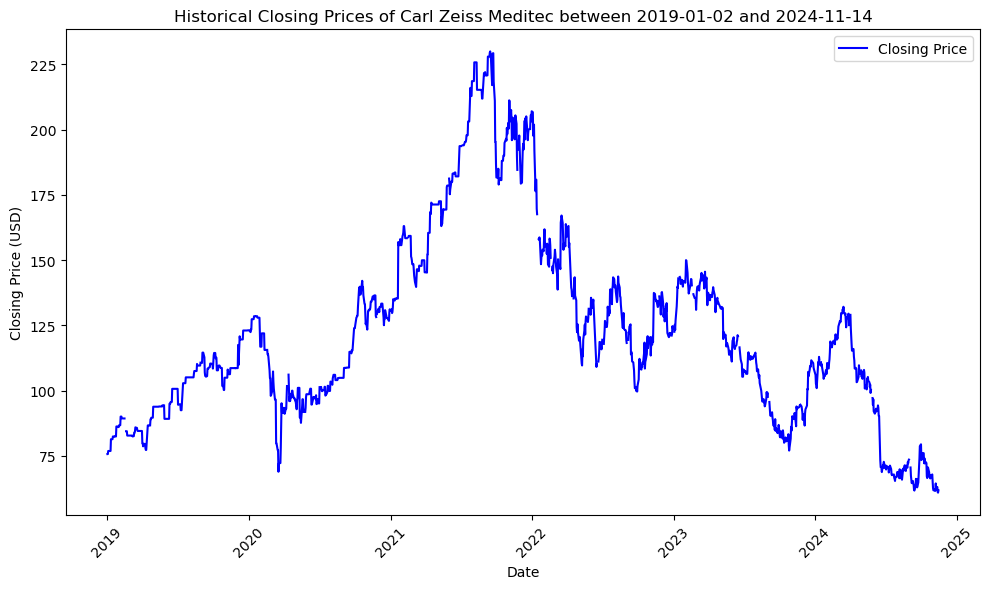


****LAM RESEARCH CORPORATION****



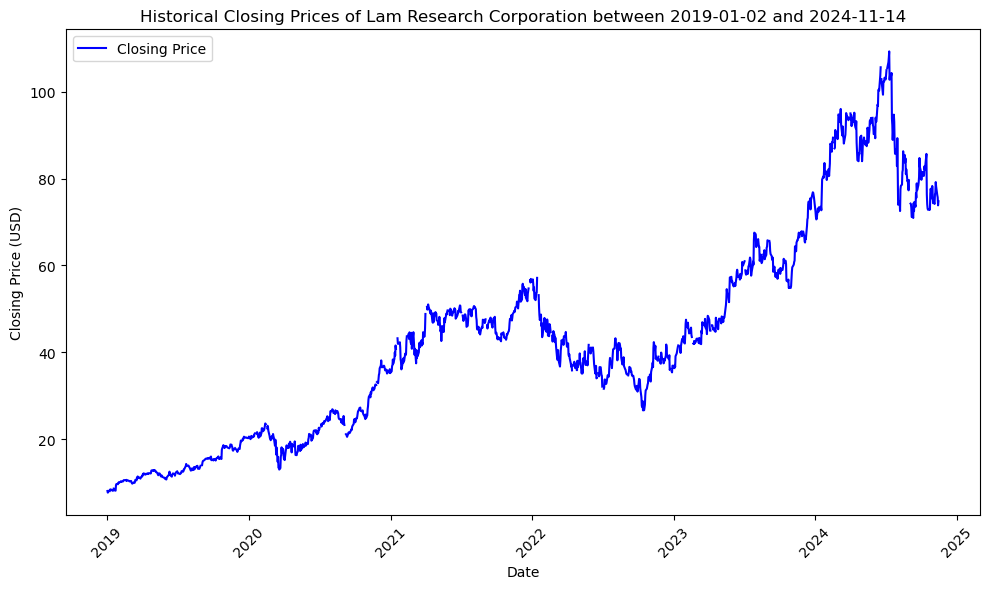


****TOKYO ELECTRON LIMITED****



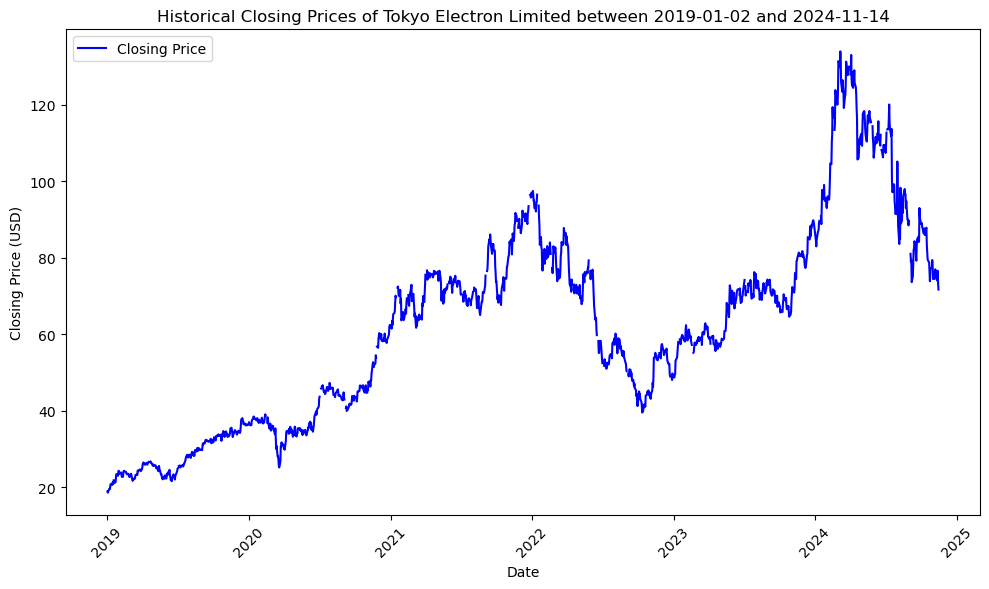


****TAIWAN SEMICONDUCTOR MANUFACTURING COMPANY****



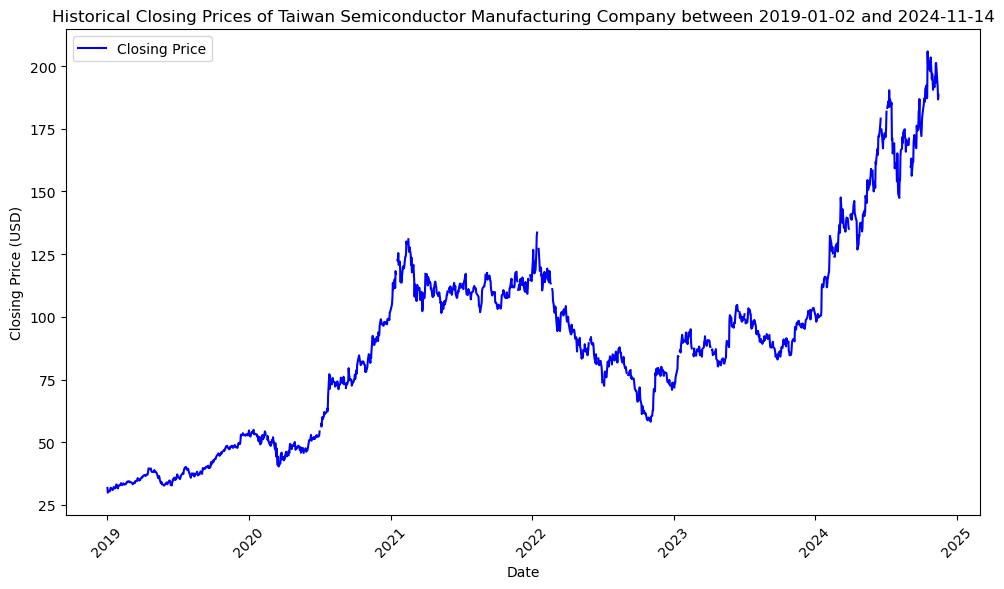


****SAMSUNG ELECTRONICS****



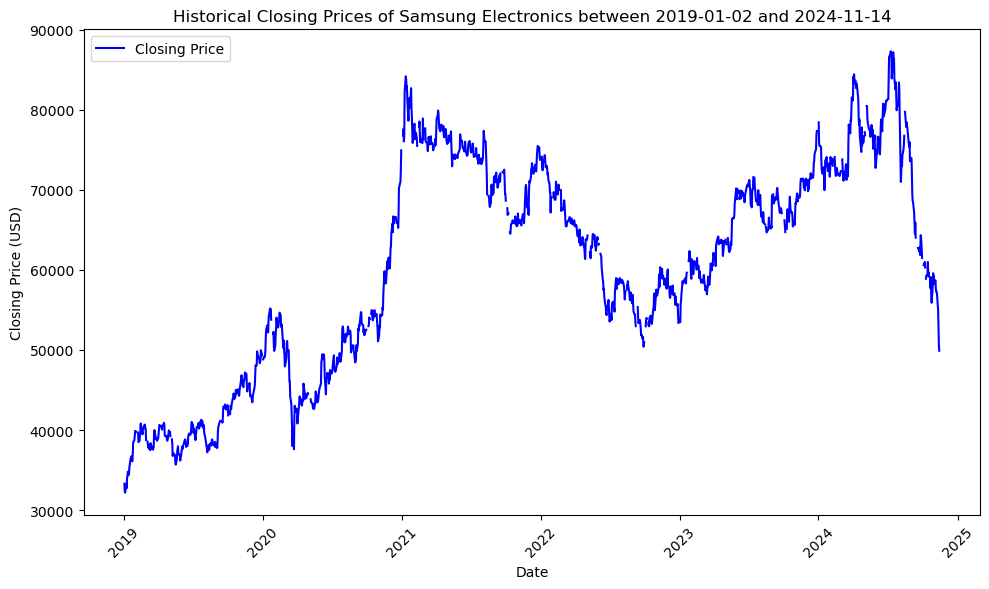


****INTEL CORPORATION****



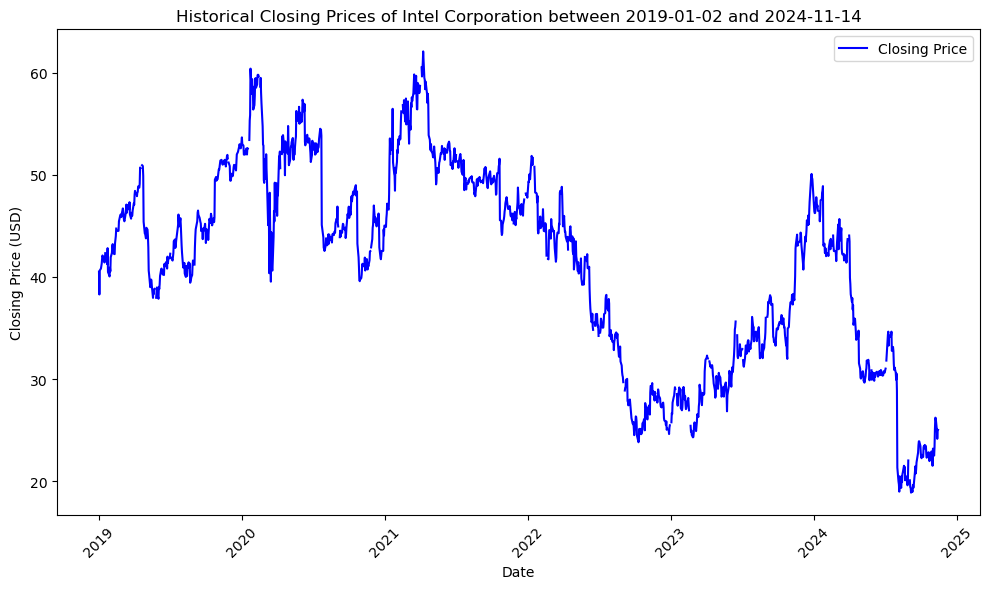

In [10]:
for company in company_tickers.values():
    print(f'****{company.upper()}****')
    print()
    plot_closing_prices(merged_data,f'Close_{company}',company)
    print()

### 2.5.2 Checking for duplicate values

In [11]:
merged_data.duplicated().sum()

1

There is one duplicate value. We are going to eliminate it.

In [12]:
merged_data = merged_data[~merged_data.duplicated()]

### 2.5.3 Checking for missing dates

In [13]:
(merged_data.isna().sum()/len(merged_data))*100

Close_Carl Zeiss Meditec                            2.952756
Close_Lam Research Corporation                      2.952756
Close_Tokyo Electron Limited                        2.952756
Close_Taiwan Semiconductor Manufacturing Company    2.952756
Close_Samsung Electronics                           5.314961
Close_Intel Corporation                             2.952756
dtype: float64

As we can see there are null values. However, since we are going to group data weekly, we will try to see if it can be solved in the following steps.

### 2.5.4 Looking at seasonality

****CARL ZEISS MEDITEC****



<Figure size 1200x800 with 0 Axes>

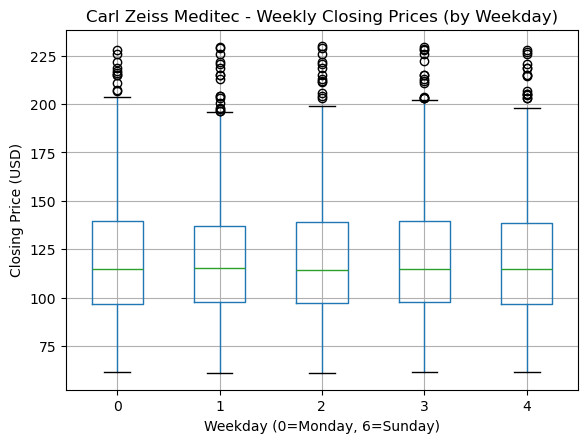

<Figure size 1200x800 with 0 Axes>

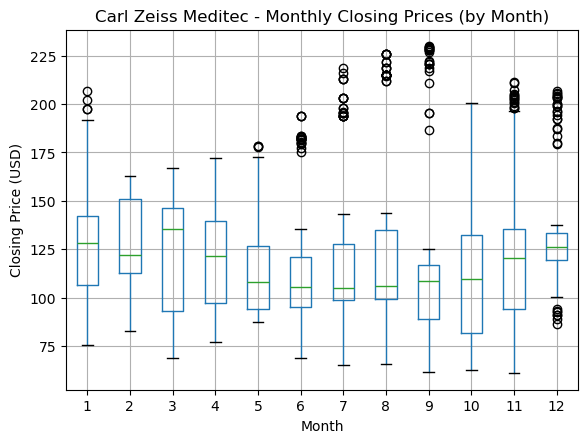

<Figure size 1200x800 with 0 Axes>

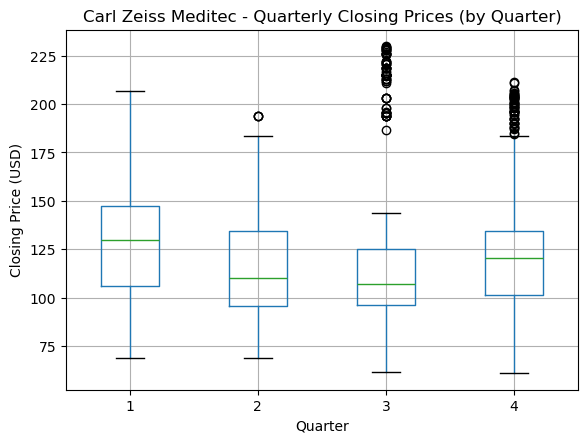


****LAM RESEARCH CORPORATION****



<Figure size 1200x800 with 0 Axes>

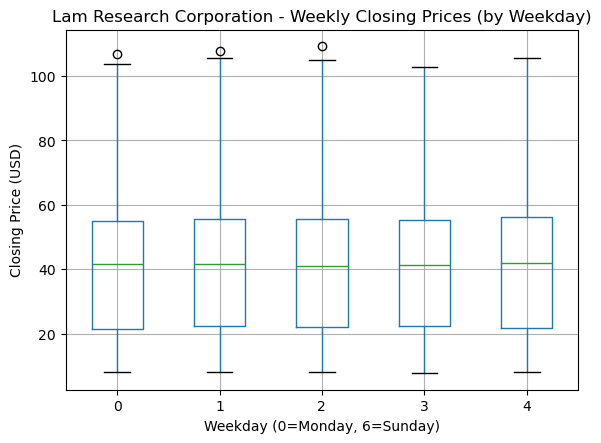

<Figure size 1200x800 with 0 Axes>

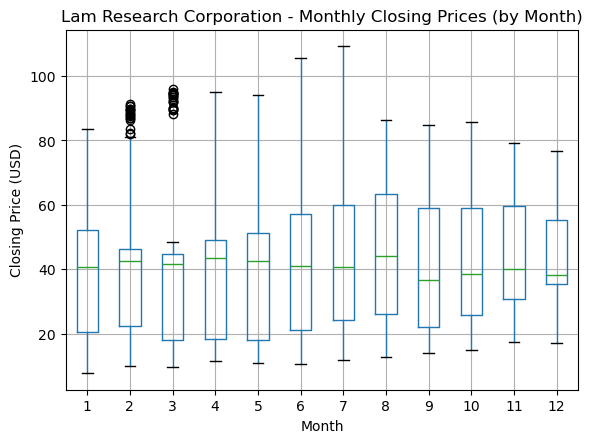

<Figure size 1200x800 with 0 Axes>

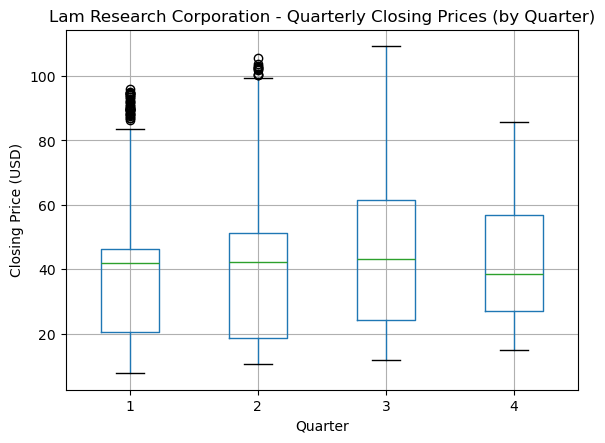


****TOKYO ELECTRON LIMITED****



<Figure size 1200x800 with 0 Axes>

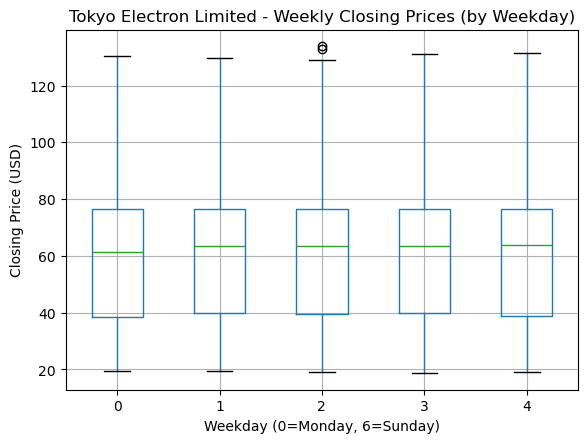

<Figure size 1200x800 with 0 Axes>

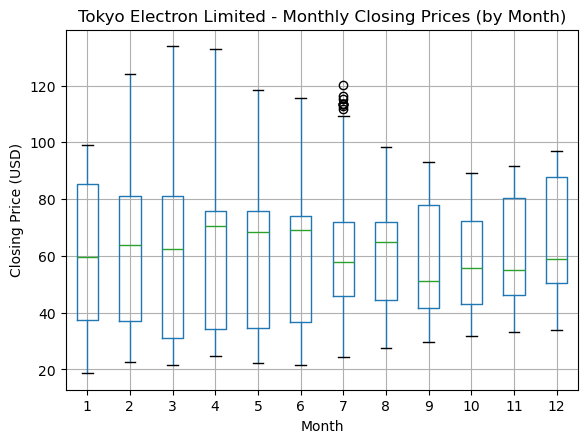

<Figure size 1200x800 with 0 Axes>

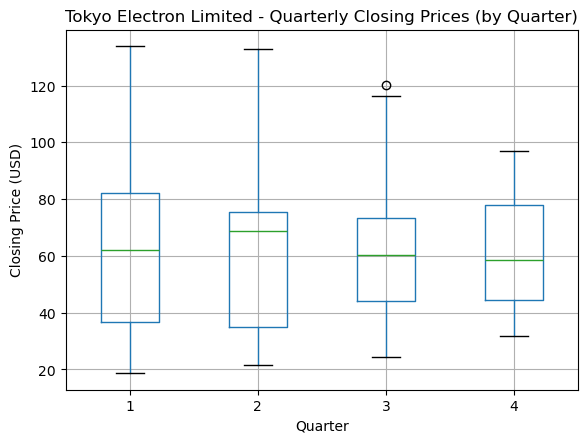


****TAIWAN SEMICONDUCTOR MANUFACTURING COMPANY****



<Figure size 1200x800 with 0 Axes>

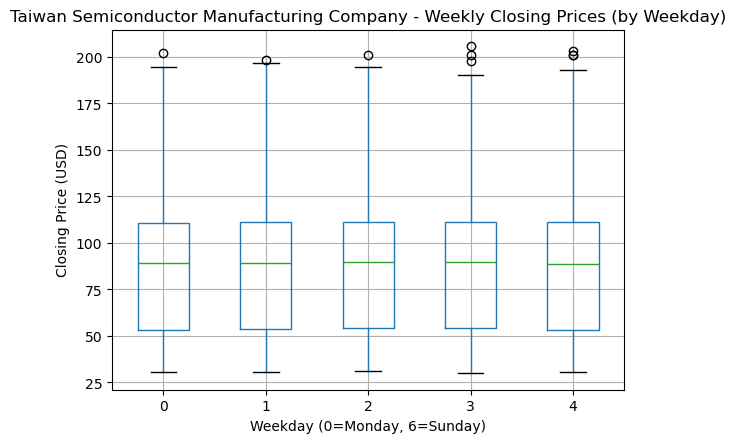

<Figure size 1200x800 with 0 Axes>

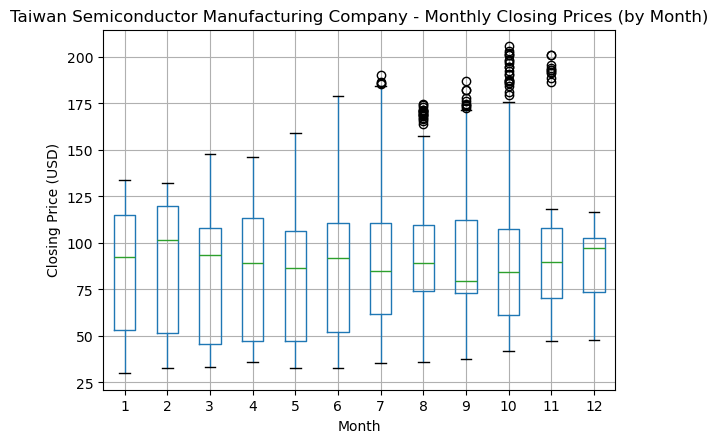

<Figure size 1200x800 with 0 Axes>

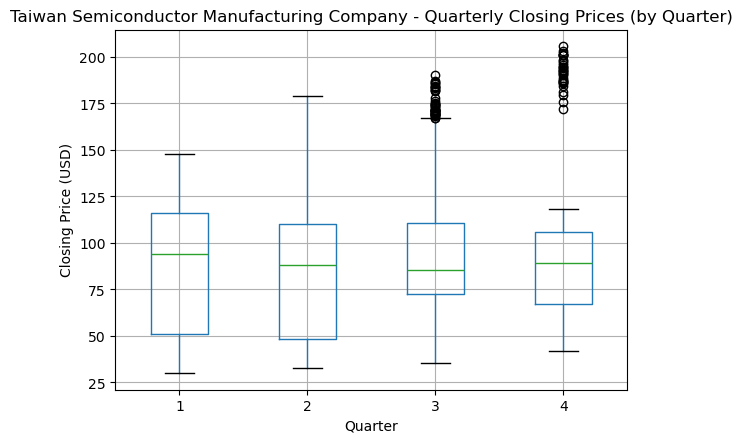


****SAMSUNG ELECTRONICS****



<Figure size 1200x800 with 0 Axes>

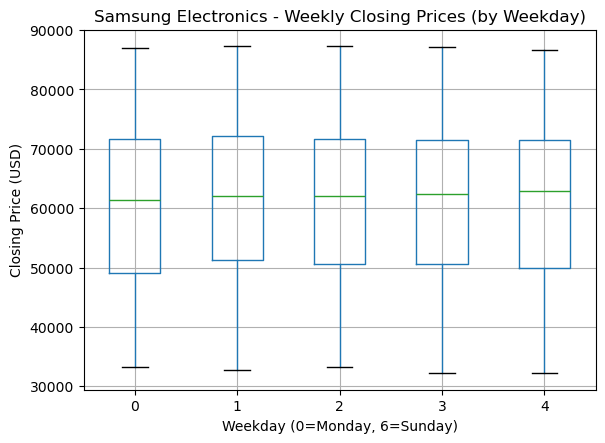

<Figure size 1200x800 with 0 Axes>

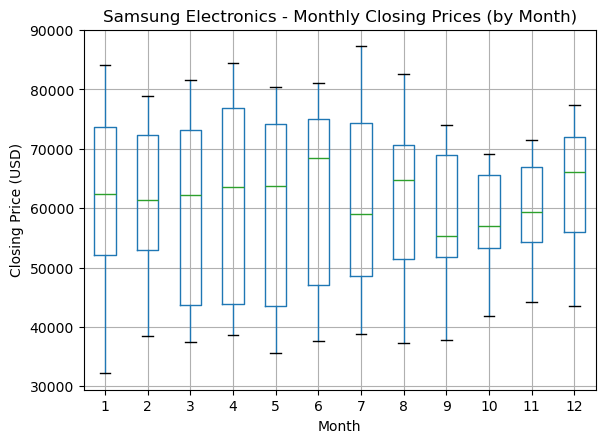

<Figure size 1200x800 with 0 Axes>

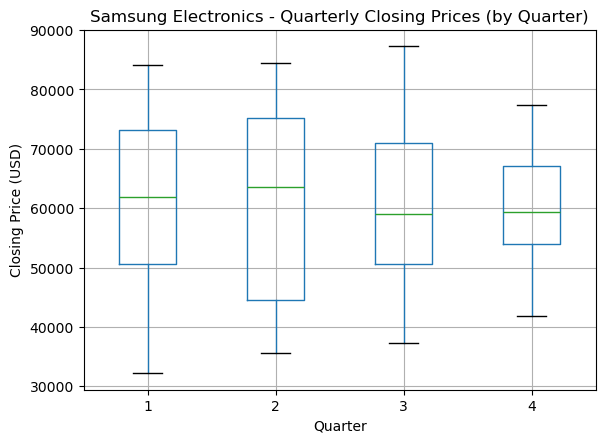


****INTEL CORPORATION****



<Figure size 1200x800 with 0 Axes>

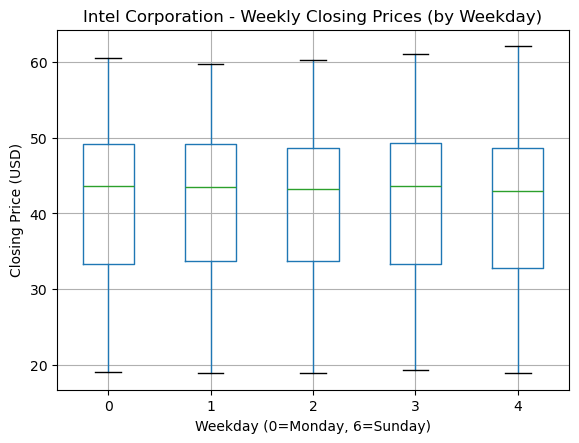

<Figure size 1200x800 with 0 Axes>

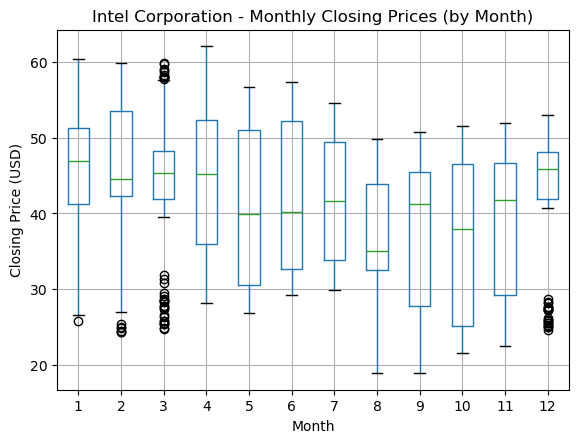

<Figure size 1200x800 with 0 Axes>

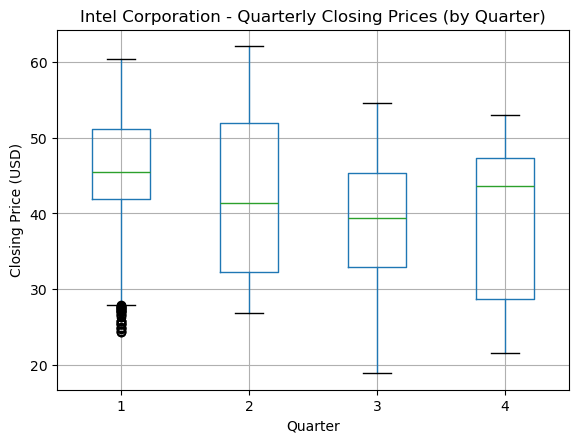

In [14]:
for company in company_tickers.values():
    print(f'****{company.upper()}****')
    print()
    plot_stock_with_multiple_boxplots(merged_data,f'Close_{company}',company)
    print()

With the results above, we cannot determine if there is any clear seasonality for any of the three suppliers. 

### 2.5.5 Choosing the time series of our dataset

Let's chose just the weekly data for the suppliers. To be consistent with the logic with which we viewed ASML's stock data

In [15]:
# Convert the index to a datetime index if it's not already
merged_data.index = pd.to_datetime(merged_data.index)

# Resample the data to weekly frequency and calculate the median
weekly_data_suppliers = merged_data.resample('W').median()

# Display the weekly data
weekly_data_suppliers.head()

Close_Carl Zeiss Meditec  Close_Lam Research Corporation  \
Date                                                                   
2019-01-06                 75.651283                        8.042964   
2019-01-13                 76.849052                        8.389010   
2019-01-20                 82.406715                        8.181032   
2019-01-27                 82.406715                        8.770302   
2019-02-03                 86.019196                        9.879226   

            Close_Tokyo Electron Limited  \
Date                                       
2019-01-06                     18.953333   
2019-01-13                     20.006666   
2019-01-20                     21.273333   
2019-01-27                     22.076667   
2019-02-03                     23.473333   

            Close_Taiwan Semiconductor Manufacturing Company  \
Date                                                           
2019-01-06                                         30.410755   
2019-01-13                                         30.967323   
2019-01-20                                         31.341263   
2019-01-27                                         32.232620   
2019-02-03                                         32.558731   

            Close_Samsung Electronics  Close_Intel Corporation       Date  \
Date                                                                        
2019-01-06               32299.406250                40.518044 2019-01-03   
2019-01-13               34017.464844                41.318417 2019-01-09   
2019-01-20               35606.656250                41.714310 2019-01-16   
2019-01-27               36723.386719                41.400179 2019-01-23   
2019-02-03               39644.078125                40.552475 2019-01-30   

            Weekday  Month  Quarter  
Date                                 
2019-01-06      3.0    1.0      1.0  
2019-01-13      2.0    1.0      1.0  
2019-01-20      2.0    1.0      1.0  
2019-01-27      2.0    1.0      1.0  
2019-02-03      2.0    1.0      1.0

Let's check that the null values have disappeared with the weekly grouping of the stocks for each company

In [16]:
weekly_data_suppliers[weekly_data_suppliers['Close_Carl Zeiss Meditec'].isna()]

Empty DataFrame
Columns: [Close_Carl Zeiss Meditec, Close_Lam Research Corporation, Close_Tokyo Electron Limited, Close_Taiwan Semiconductor Manufacturing Company, Close_Samsung Electronics, Close_Intel Corporation, Date, Weekday, Month, Quarter]
Index: []

As is observable, the null values have disappeared.

### 2.5.6 Prophet model for each supplier

#### 2.5.6.1 Train-test split

In [17]:
# Drop unnecessary columns from the dataframe
weekly_data_suppliers = weekly_data_suppliers.drop(columns=['Date', 'Weekday', 'Month', 'Quarter'], axis=1)

In [18]:
# Create dictionaries to store train and test dataframes for each company
train_dataframes = {}
test_dataframes = {}

# Iterate over each company in company_tickers
for company in company_tickers.values():
    # Filter only the columns corresponding to the current company
    company_data = weekly_data_suppliers[[f'Close_{company}']]
    
    # Rename the column to 'Close'
    company_data.columns = ['Close']
    
    # Create train and test dataframes
    train_dataframes[company] = company_data[:-test_weeks]
    test_dataframes[company] = company_data[-test_weeks:]
    
    # Set 'Date' as the index of the dataframe
    train_dataframes[company].index.name = 'Date'
    test_dataframes[company].index.name = 'Date'

# Display the train dataframe for 'Carl Zeiss Meditec' as an example
train_dataframes['Carl Zeiss Meditec'].head()

Close
Date                 
2019-01-06  75.651283
2019-01-13  76.849052
2019-01-20  82.406715
2019-01-27  82.406715
2019-02-03  86.019196

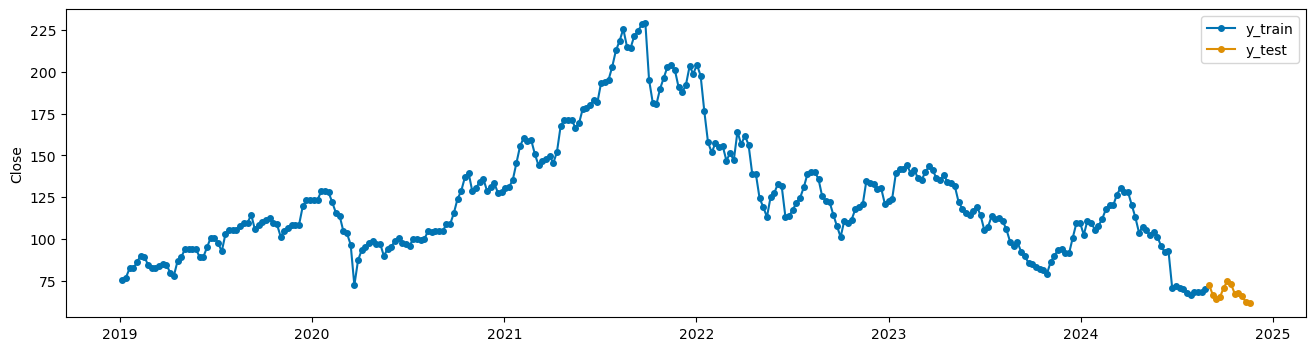

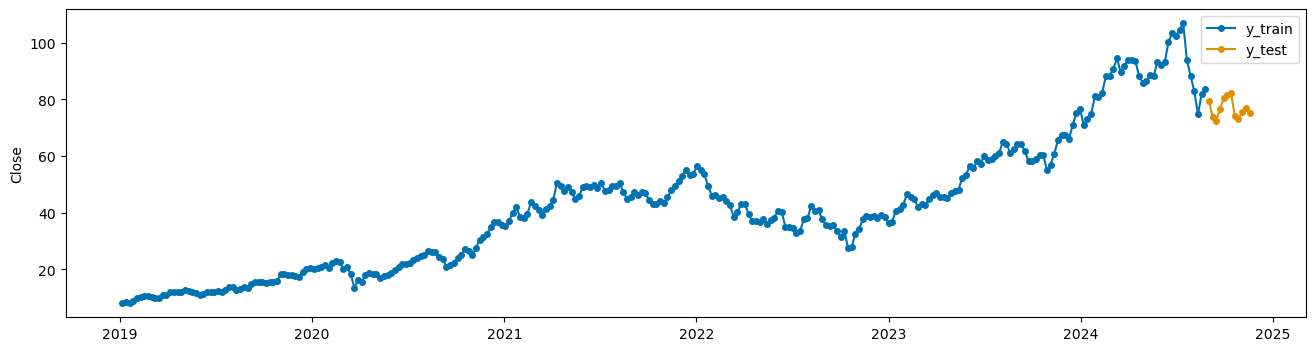

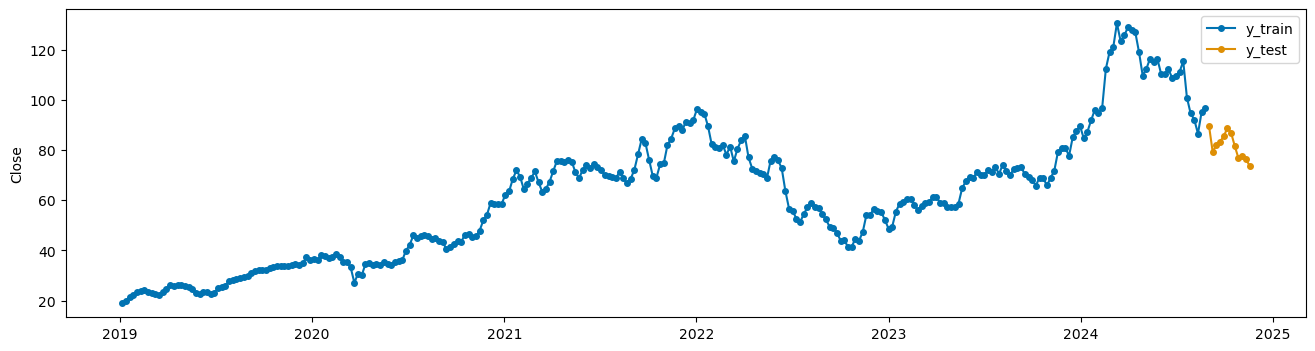

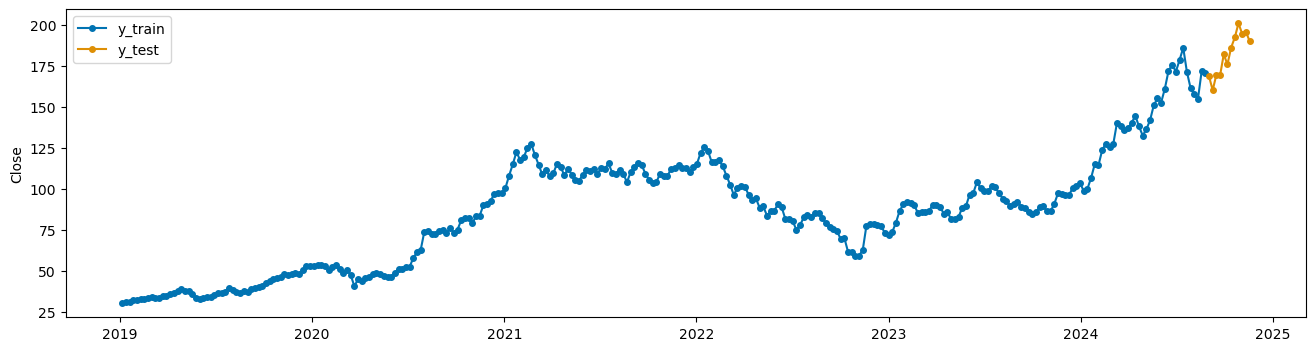

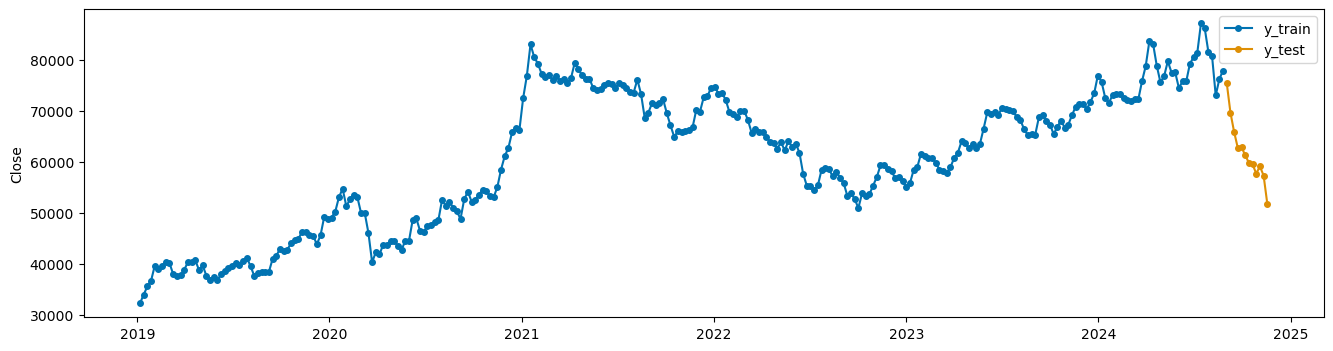

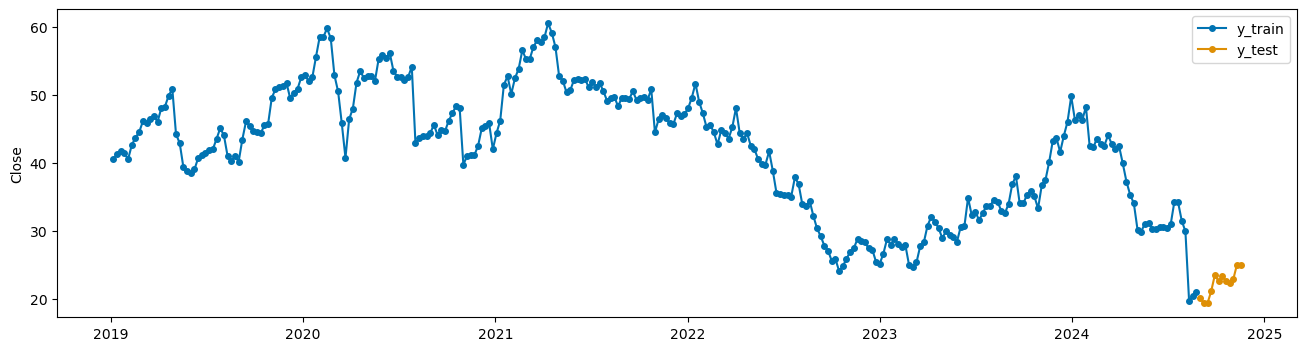

In [19]:
# Iterate over each company to plot the series
for company in company_tickers.values():
    # Extract the train and test data for the current company
    train_data = train_dataframes[company]
    test_data = test_dataframes[company]
    
    # Plot the series for the current company
    plot_series(train_data, test_data, labels=["y_train", "y_test"])

#### 2.5.6.2 Prophet models

03:18:53 - cmdstanpy - INFO - Chain [1] start processing
03:18:53 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Carl Zeiss Meditec
MAPE: 11.62
RMSE: 8.85


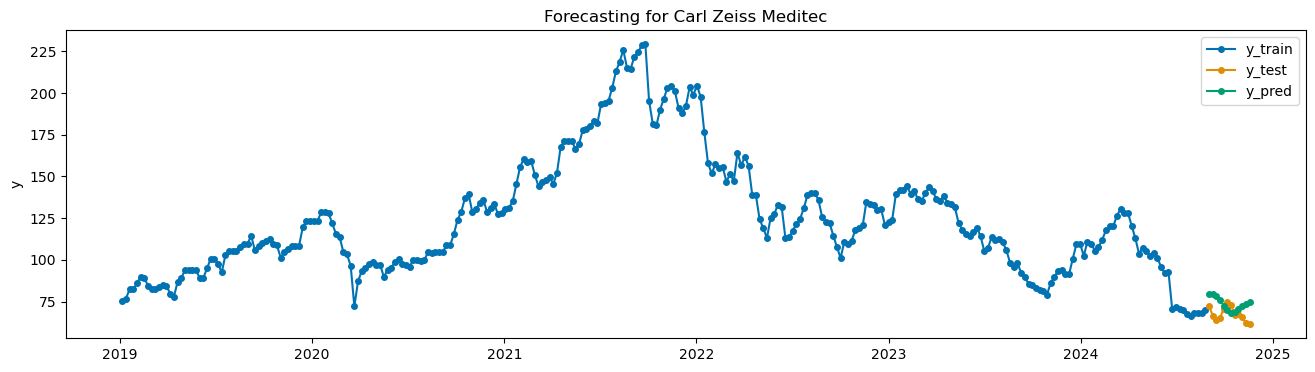

03:18:53 - cmdstanpy - INFO - Chain [1] start processing
03:18:53 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Lam Research Corporation
MAPE: 30.74
RMSE: 23.81


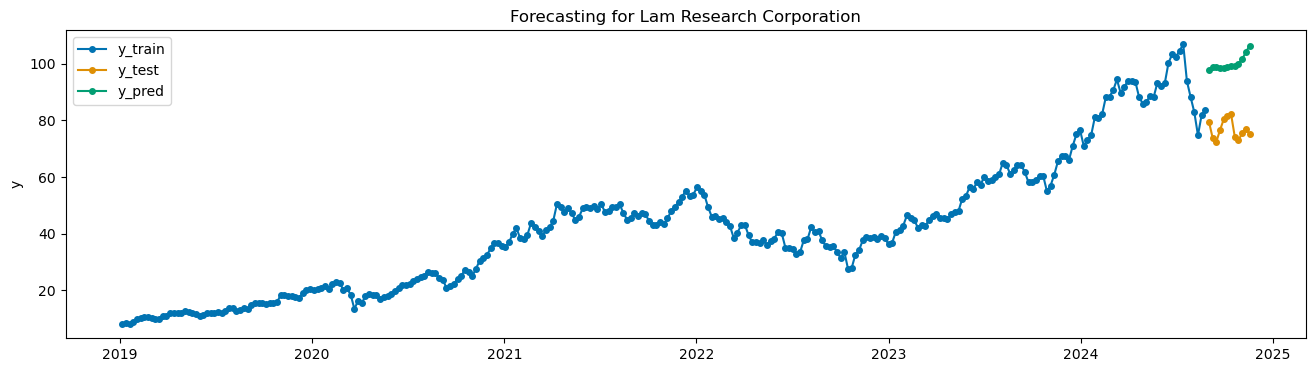

03:18:54 - cmdstanpy - INFO - Chain [1] start processing
03:18:54 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Tokyo Electron Limited
MAPE: 44.14
RMSE: 36.35


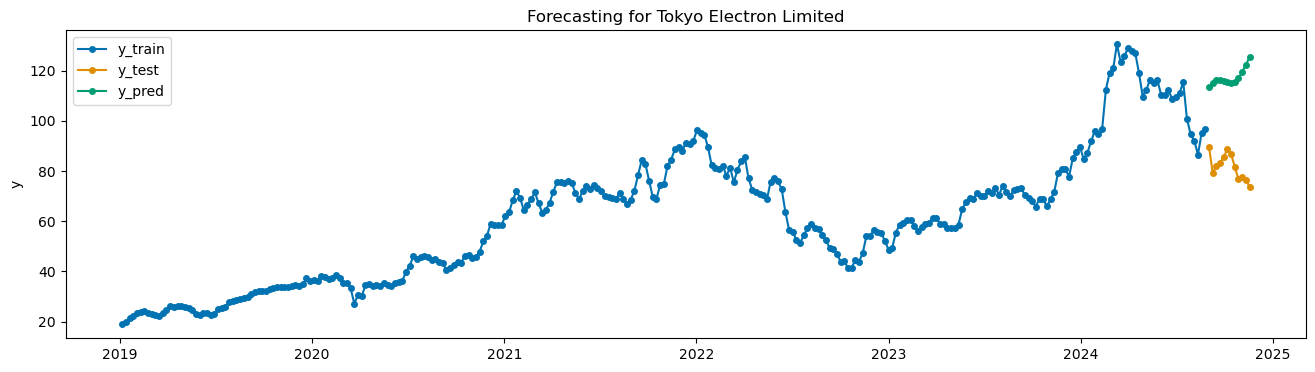

03:18:54 - cmdstanpy - INFO - Chain [1] start processing
03:18:54 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Taiwan Semiconductor Manufacturing Company
MAPE: 10.37
RMSE: 22.26


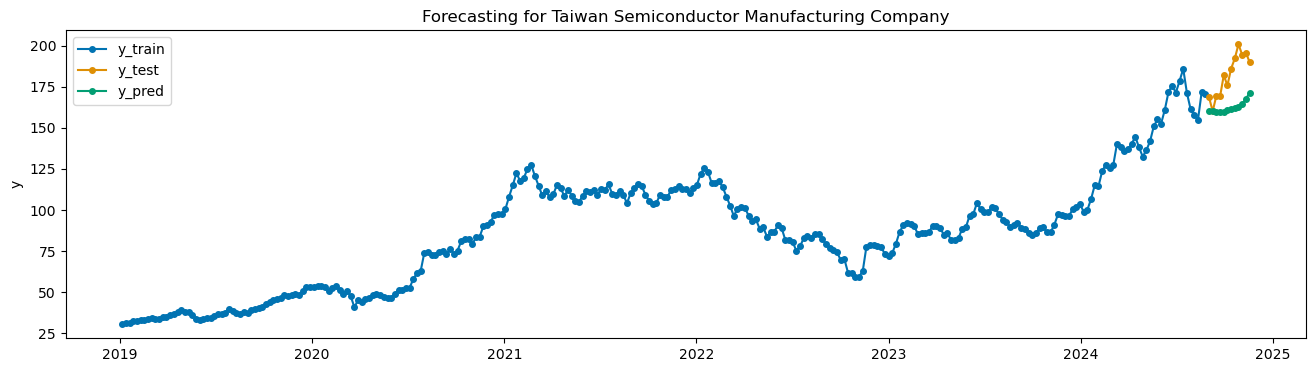

03:18:54 - cmdstanpy - INFO - Chain [1] start processing
03:18:54 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Samsung Electronics
MAPE: 31.34
RMSE: 19863.06


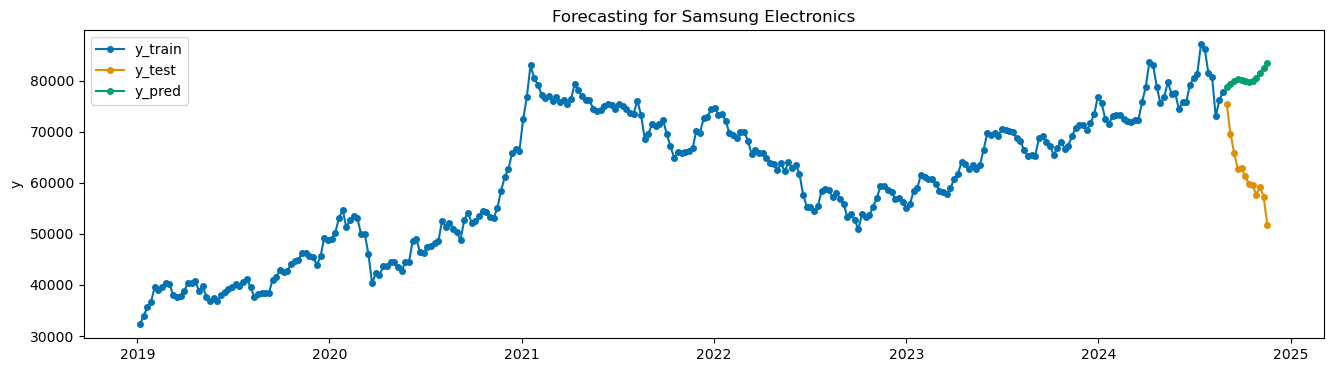

03:18:55 - cmdstanpy - INFO - Chain [1] start processing
03:18:55 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Intel Corporation
MAPE: 56.31
RMSE: 12.44


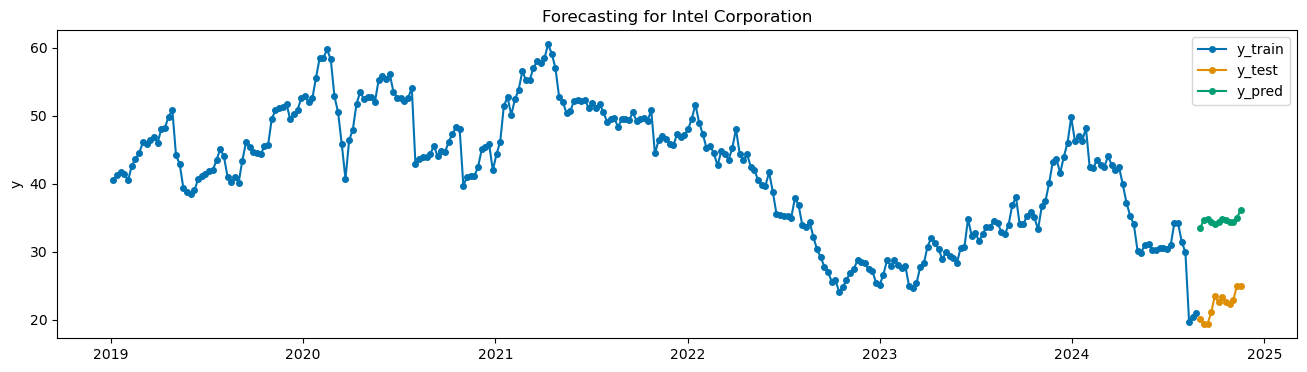

In [20]:
# Dictionary to store each Prophet model by company
prophet_models = {}

# Iterate over each company in company_tickers
for company in company_tickers.values():
    # Prepare the data for Prophet
    train_data = train_dataframes[company][['Close']].copy()
    train_data.index = pd.to_datetime(train_data.index)  # Ensure DatetimeIndex
    train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close': 'y'})

    # Initialize and fit the Prophet model
    prophet_model = Prophet()
    prophet_model.fit(train_data_prophet)

    # Define the forecast horizon (e.g., 12 periods into the future)
    future = prophet_model.make_future_dataframe(periods=test_weeks, freq='W')

    # Generate the predictions
    forecast = prophet_model.predict(future)

    # Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
    forecast = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

    # Ensure 'ds' is the index of train_data_prophet 
    train_data_prophet = train_data_prophet.set_index('ds')

    # Calculate MAPE and RMSE errors
    actuals = test_dataframes[company]['Close']  # Actual values from test data
    predictions = forecast['Close']              # Predicted values from forecast

    # Ensure the indices of actuals and predictions align
    common_index = actuals.index.intersection(predictions.index)
    actuals = actuals.loc[common_index]
    predictions = predictions.loc[common_index]

    mape = mean_absolute_percentage_error(actuals, predictions)*100
    rmse = root_mean_squared_error(actuals, predictions)

    # Display errors
    print(f'Forecasting for {company}')
    print(f'MAPE: {mape:.2f}')
    print(f'RMSE: {rmse:.2f}')
    
    # Plot the forecast results
    plot_series(
        train_data_prophet[-500:],  # Only pass the 'Close' column for training data
        test_dataframes[company],   # Only pass the 'Close' column for test data
        forecast,                   # Only pass the 'Close' column for forecast
        labels=["y_train", "y_test", "y_pred"]
    )
    
    plt.title(f'Forecasting for {company}')  # Add title for better clarity
    plt.show()  # Show the plot before moving to the next company

#### 2.5.6.3 Fine-tunning the prophet models

We will first run a code using Optuna to gain an understanding of the approximate locations of the global minimal for each company

Optimizing for Carl Zeiss Meditec...


03:18:55 - cmdstanpy - INFO - Chain [1] start processing
03:18:55 - cmdstanpy - INFO - Chain [1] done processing
03:18:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
03:18:55 - cmdstanpy - INFO - Chain [1] start processing
03:18:56 - cmdstanpy - INFO - Chain [1] done processing
03:18:56 - cmdstanpy - INFO - Chain [1] start processing
03:18:56 - cmdstanpy - INFO - Chain [1] done processing
03:18:56 - cmdstanpy - INFO - Chain [1] start processing
03:18:56 - cmdstanpy - INFO - Chain [1] done processing
03:18:57 - cmdstanpy - INFO - Chain [1] start processing
03:18:57 - cmdstanpy - INFO - Chain [1] done processing
03:18:57 - cmdstanpy - INFO - Chain [1] start processing
03:18:57 - cmdstanpy - INFO - Chain [1] done processing
03:18:58 - cmdstanpy - INFO - Chain [1] start processing
03:18:58 - cmdstanpy - INFO - Chain [1] done processing
03:18:58 - cmdstanpy - INFO - Chain [1] start process


Forecasting for Carl Zeiss Meditec:
Best parameters: {'changepoint_prior_scale': 0.8907036164897, 'seasonality_prior_scale': 7.545472149050083, 'seasonality_mode': 'multiplicative', 'weekly_seasonality': False, 'yearly_seasonality': True, 'daily_seasonality': False}
MAPE: 14.69
RMSE: 12.55


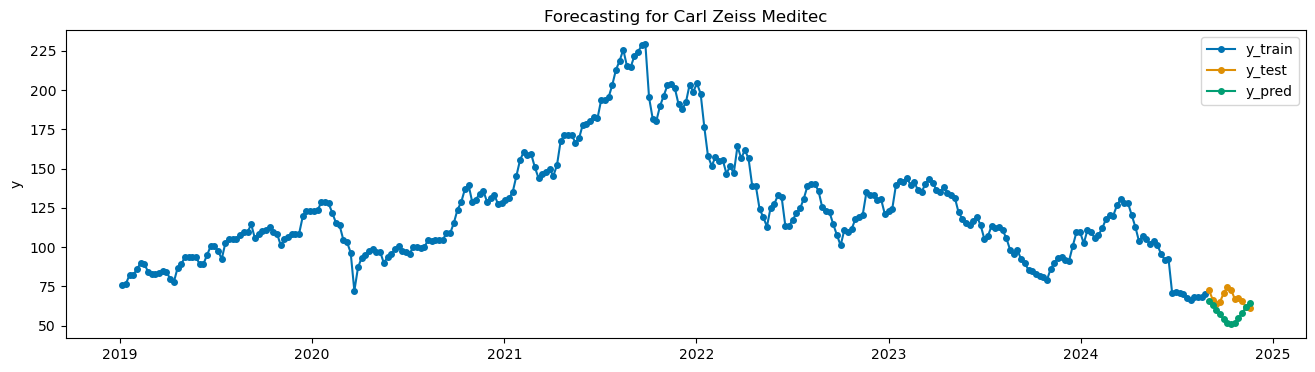

Optimizing for Lam Research Corporation...


03:19:14 - cmdstanpy - INFO - Chain [1] start processing
03:19:14 - cmdstanpy - INFO - Chain [1] done processing
03:19:14 - cmdstanpy - INFO - Chain [1] start processing
03:19:14 - cmdstanpy - INFO - Chain [1] done processing
03:19:14 - cmdstanpy - INFO - Chain [1] start processing
03:19:15 - cmdstanpy - INFO - Chain [1] done processing
03:19:15 - cmdstanpy - INFO - Chain [1] start processing
03:19:15 - cmdstanpy - INFO - Chain [1] done processing
03:19:15 - cmdstanpy - INFO - Chain [1] start processing
03:19:15 - cmdstanpy - INFO - Chain [1] done processing
03:19:16 - cmdstanpy - INFO - Chain [1] start processing
03:19:16 - cmdstanpy - INFO - Chain [1] done processing
03:19:16 - cmdstanpy - INFO - Chain [1] start processing
03:19:16 - cmdstanpy - INFO - Chain [1] done processing
03:19:16 - cmdstanpy - INFO - Chain [1] start processing
03:19:16 - cmdstanpy - INFO - Chain [1] done processing
03:19:16 - cmdstanpy - INFO - Chain [1] start processing
03:19:16 - cmdstanpy - INFO - Chain [1]


Forecasting for Lam Research Corporation:
Best parameters: {'changepoint_prior_scale': 0.6894486824060482, 'seasonality_prior_scale': 6.151720263587043, 'seasonality_mode': 'multiplicative', 'weekly_seasonality': False, 'yearly_seasonality': True, 'daily_seasonality': True}
MAPE: 22.11
RMSE: 17.30


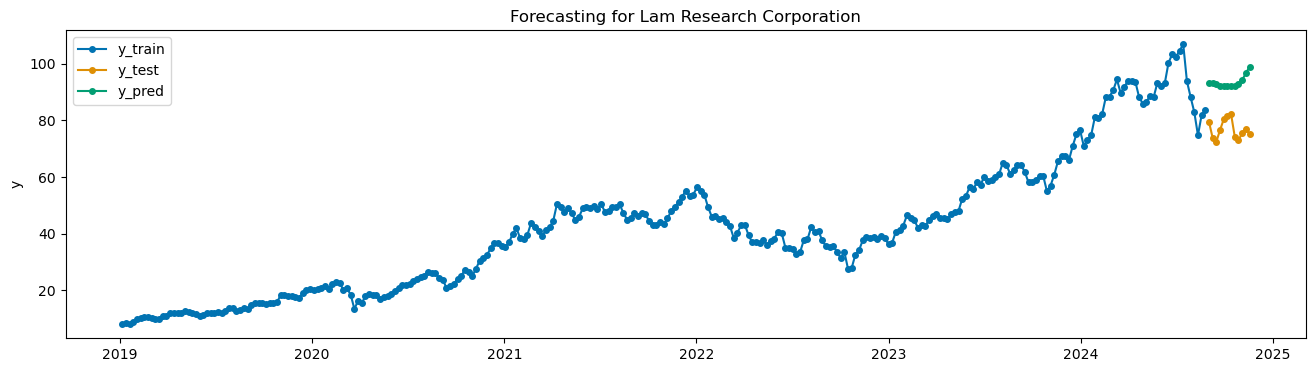

Optimizing for Tokyo Electron Limited...


03:19:33 - cmdstanpy - INFO - Chain [1] start processing
03:19:33 - cmdstanpy - INFO - Chain [1] done processing
03:19:33 - cmdstanpy - INFO - Chain [1] start processing
03:19:34 - cmdstanpy - INFO - Chain [1] done processing
03:19:34 - cmdstanpy - INFO - Chain [1] start processing
03:19:34 - cmdstanpy - INFO - Chain [1] done processing
03:19:34 - cmdstanpy - INFO - Chain [1] start processing
03:19:34 - cmdstanpy - INFO - Chain [1] done processing
03:19:34 - cmdstanpy - INFO - Chain [1] start processing
03:19:34 - cmdstanpy - INFO - Chain [1] done processing
03:19:34 - cmdstanpy - INFO - Chain [1] start processing
03:19:35 - cmdstanpy - INFO - Chain [1] done processing
03:19:35 - cmdstanpy - INFO - Chain [1] start processing
03:19:35 - cmdstanpy - INFO - Chain [1] done processing
03:19:35 - cmdstanpy - INFO - Chain [1] start processing
03:19:35 - cmdstanpy - INFO - Chain [1] done processing
03:19:35 - cmdstanpy - INFO - Chain [1] start processing
03:19:35 - cmdstanpy - INFO - Chain [1]


Forecasting for Tokyo Electron Limited:
Best parameters: {'changepoint_prior_scale': 0.01885491681963053, 'seasonality_prior_scale': 4.221732339489484, 'seasonality_mode': 'multiplicative', 'weekly_seasonality': False, 'yearly_seasonality': True, 'daily_seasonality': False}
MAPE: 13.80
RMSE: 12.61


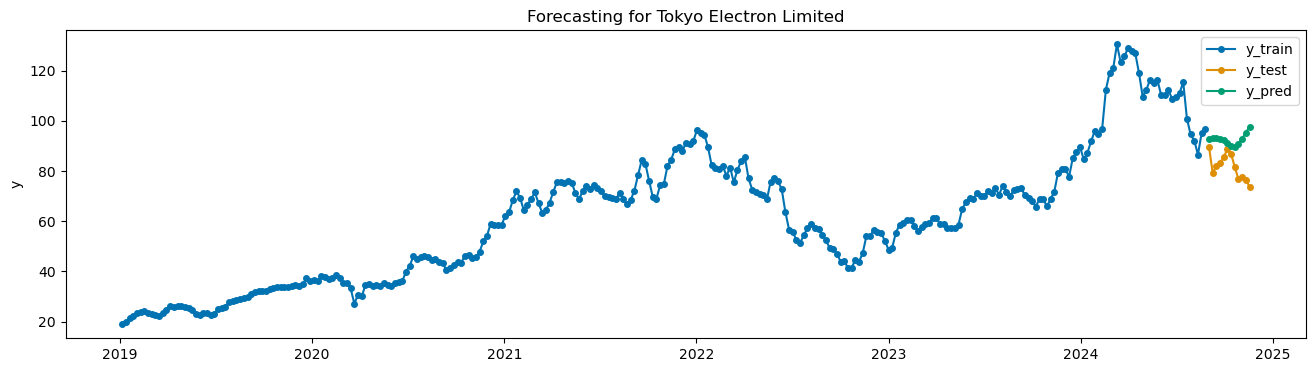

Optimizing for Taiwan Semiconductor Manufacturing Company...


03:19:49 - cmdstanpy - INFO - Chain [1] start processing
03:19:49 - cmdstanpy - INFO - Chain [1] done processing
03:19:49 - cmdstanpy - INFO - Chain [1] start processing
03:19:50 - cmdstanpy - INFO - Chain [1] done processing
03:19:50 - cmdstanpy - INFO - Chain [1] start processing
03:19:50 - cmdstanpy - INFO - Chain [1] done processing
03:19:50 - cmdstanpy - INFO - Chain [1] start processing
03:19:50 - cmdstanpy - INFO - Chain [1] done processing
03:19:50 - cmdstanpy - INFO - Chain [1] start processing
03:19:50 - cmdstanpy - INFO - Chain [1] done processing
03:19:51 - cmdstanpy - INFO - Chain [1] start processing
03:19:51 - cmdstanpy - INFO - Chain [1] done processing
03:19:51 - cmdstanpy - INFO - Chain [1] start processing
03:19:51 - cmdstanpy - INFO - Chain [1] done processing
03:19:51 - cmdstanpy - INFO - Chain [1] start processing
03:19:51 - cmdstanpy - INFO - Chain [1] done processing
03:19:51 - cmdstanpy - INFO - Chain [1] start processing
03:19:52 - cmdstanpy - INFO - Chain [1]


Forecasting for Taiwan Semiconductor Manufacturing Company:
Best parameters: {'changepoint_prior_scale': 0.8803352762264305, 'seasonality_prior_scale': 8.615649603417245, 'seasonality_mode': 'multiplicative', 'weekly_seasonality': True, 'yearly_seasonality': False, 'daily_seasonality': False}
MAPE: 10.72
RMSE: 24.05


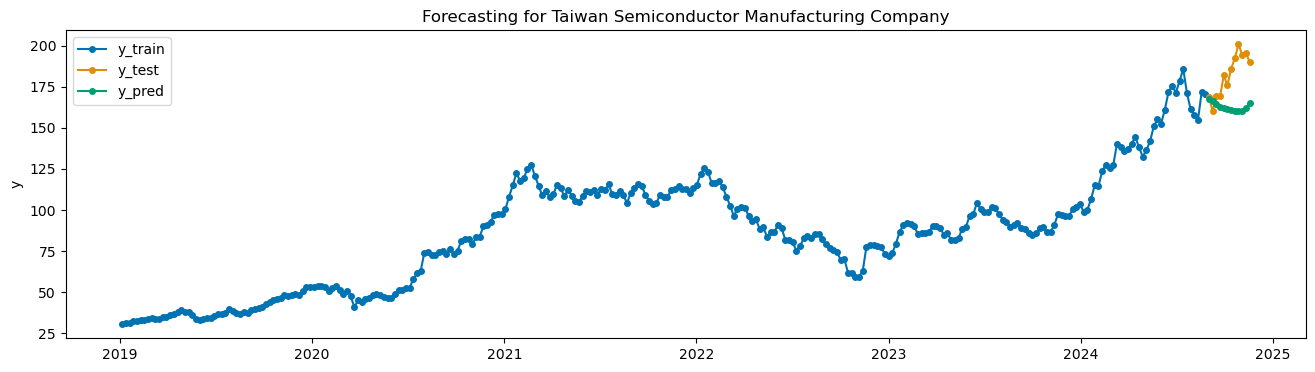

Optimizing for Samsung Electronics...


03:20:06 - cmdstanpy - INFO - Chain [1] start processing
03:20:07 - cmdstanpy - INFO - Chain [1] done processing
03:20:07 - cmdstanpy - INFO - Chain [1] start processing
03:20:07 - cmdstanpy - INFO - Chain [1] done processing
03:20:07 - cmdstanpy - INFO - Chain [1] start processing
03:20:07 - cmdstanpy - INFO - Chain [1] done processing
03:20:07 - cmdstanpy - INFO - Chain [1] start processing
03:20:07 - cmdstanpy - INFO - Chain [1] done processing
03:20:08 - cmdstanpy - INFO - Chain [1] start processing
03:20:08 - cmdstanpy - INFO - Chain [1] done processing
03:20:08 - cmdstanpy - INFO - Chain [1] start processing
03:20:08 - cmdstanpy - INFO - Chain [1] done processing
03:20:08 - cmdstanpy - INFO - Chain [1] start processing
03:20:08 - cmdstanpy - INFO - Chain [1] done processing
03:20:09 - cmdstanpy - INFO - Chain [1] start processing
03:20:09 - cmdstanpy - INFO - Chain [1] done processing
03:20:09 - cmdstanpy - INFO - Chain [1] start processing
03:20:09 - cmdstanpy - INFO - Chain [1]


Forecasting for Samsung Electronics:
Best parameters: {'changepoint_prior_scale': 0.8346963763490303, 'seasonality_prior_scale': 9.961015404514685, 'seasonality_mode': 'multiplicative', 'weekly_seasonality': True, 'yearly_seasonality': True, 'daily_seasonality': True}
MAPE: 28.02
RMSE: 17784.19


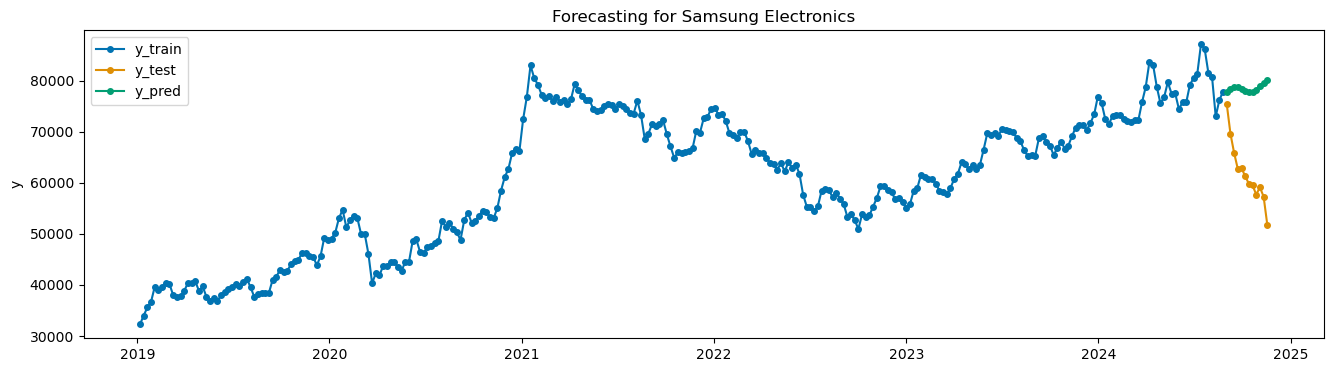

Optimizing for Intel Corporation...


03:20:26 - cmdstanpy - INFO - Chain [1] start processing
03:20:26 - cmdstanpy - INFO - Chain [1] done processing
03:20:27 - cmdstanpy - INFO - Chain [1] start processing
03:20:27 - cmdstanpy - INFO - Chain [1] done processing
03:20:27 - cmdstanpy - INFO - Chain [1] start processing
03:20:27 - cmdstanpy - INFO - Chain [1] done processing
03:20:27 - cmdstanpy - INFO - Chain [1] start processing
03:20:27 - cmdstanpy - INFO - Chain [1] done processing
03:20:28 - cmdstanpy - INFO - Chain [1] start processing
03:20:28 - cmdstanpy - INFO - Chain [1] done processing
03:20:28 - cmdstanpy - INFO - Chain [1] start processing
03:20:28 - cmdstanpy - INFO - Chain [1] done processing
03:20:28 - cmdstanpy - INFO - Chain [1] start processing
03:20:28 - cmdstanpy - INFO - Chain [1] done processing
03:20:28 - cmdstanpy - INFO - Chain [1] start processing
03:20:28 - cmdstanpy - INFO - Chain [1] done processing
03:20:29 - cmdstanpy - INFO - Chain [1] start processing
03:20:29 - cmdstanpy - INFO - Chain [1]


Forecasting for Intel Corporation:
Best parameters: {'changepoint_prior_scale': 0.9283684627906434, 'seasonality_prior_scale': 6.518693523949576, 'seasonality_mode': 'multiplicative', 'weekly_seasonality': False, 'yearly_seasonality': True, 'daily_seasonality': True}
MAPE: 35.17
RMSE: 7.80


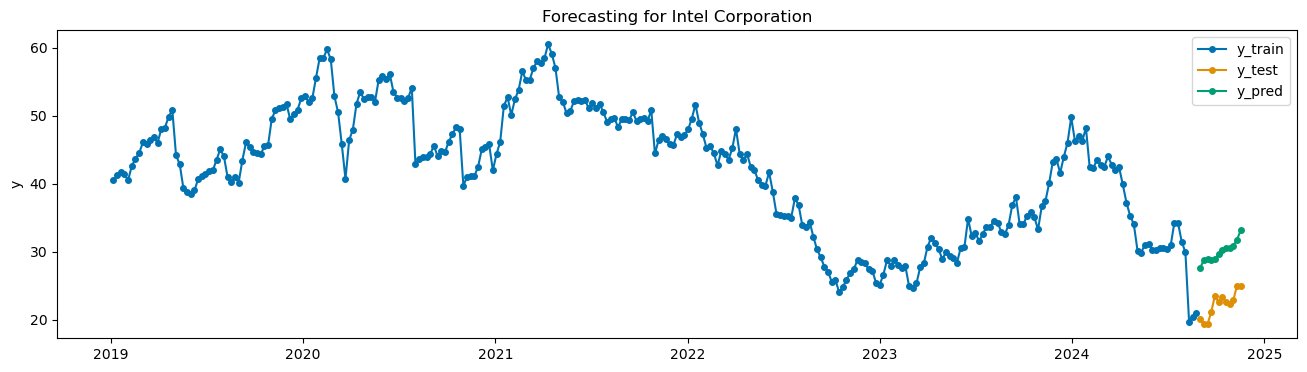

In [21]:
# Dictionary to store the best parameters, MAPE, and RMSE for each company
best_params_per_company = {}
final_mape_per_company = {}
final_rmse_per_company = {}
company_params = {}  # New dictionary to store the best parameters for each ticker
n_trials = 50  # Total number of trials to be tested

# Loop through each company in company_tickers
for ticker, company in company_tickers.items():
    print(f"Optimizing for {company}...")

    # Prepare training and test data for Prophet
    train_data = train_dataframes[company][['Close']].copy()
    train_data.index = pd.to_datetime(train_data.index)  # Ensure the index is of datetime type
    train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close': 'y'})

    test_data = test_dataframes[company][['Close']].copy()
    test_data.index = pd.to_datetime(test_data.index)

    # Create an Optuna study and optimize
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, train_data_prophet, test_data, company), n_trials=n_trials)

    # Save the best parameters for the current company
    best_params_per_company[company] = study.best_params
    company_params[company] = {
        'changepoint_prior_scale': study.best_params['changepoint_prior_scale'],
        'seasonality_prior_scale': study.best_params['seasonality_prior_scale']
    }

    # Fit the model with the best parameters to calculate the final MAPE and RMSE
    model = Prophet(
        changepoint_prior_scale=study.best_params['changepoint_prior_scale'],
        seasonality_prior_scale=study.best_params['seasonality_prior_scale']
    )
    model.fit(train_data_prophet)

    future = model.make_future_dataframe(periods=test_weeks, freq='W')
    forecast = model.predict(future)
    forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

    actuals = test_data['Close']
    predictions = forecast_filtered['Close']
    common_index = actuals.index.intersection(predictions.index)
    actuals = actuals.loc[common_index]
    predictions = predictions.loc[common_index]

    final_mape = mean_absolute_percentage_error(actuals, predictions) * 100
    final_rmse = root_mean_squared_error(actuals, predictions)

    # Store the final MAPE and RMSE for the company
    final_mape_per_company[company] = final_mape
    final_rmse_per_company[company] = final_rmse

    # Print the best parameters, MAPE, and RMSE for the company
    print(f"\nForecasting for {company}:")
    print(f"Best parameters: {best_params_per_company[company]}")
    print(f"MAPE: {final_mape:.2f}")
    print(f"RMSE: {final_rmse:.2f}")

    # Plot the forecast results for the company
    plot_series(
        train_data_prophet.set_index("ds")['y'][-500:],  # Last 500 points of training data
        test_data['Close'],
        forecast_filtered['Close'],
        labels=["y_train", "y_test", "y_pred"]
    )
    plt.title(f"Forecasting for {company}")  # Title for clarity
    plt.show()  # Show the plot immediately after the results


Now let's run a specific param_grid for each of the companies


Processing company: Carl Zeiss Meditec (1/6)...

Total combinations to test for Carl Zeiss Meditec: 1600


03:20:47 - cmdstanpy - INFO - Chain [1] start processing
03:20:47 - cmdstanpy - INFO - Chain [1] done processing
03:20:47 - cmdstanpy - INFO - Chain [1] start processing


03:20:47 - cmdstanpy - INFO - Chain [1] done processing
03:20:47 - cmdstanpy - INFO - Chain [1] start processing


03:20:47 - cmdstanpy - INFO - Chain [1] done processing
03:20:47 - cmdstanpy - INFO - Chain [1] start processing
03:20:48 - cmdstanpy - INFO - Chain [1] done processing


03:20:48 - cmdstanpy - INFO - Chain [1] start processing


03:20:48 - cmdstanpy - INFO - Chain [1] done processing
03:20:48 - cmdstanpy - INFO - Chain [1] start processing


03:20:48 - cmdstanpy - INFO - Chain [1] done processing
03:20:48 - cmdstanpy - INFO - Chain [1] start processing


03:20:49 - cmdstanpy - INFO - Chain [1] done processing
03:20:49 - cmdstanpy - INFO - Chain [1] start processing
03:20:49 - cmdstanpy - INFO - Chain [1] done processing


03:20:49 - cmdstanpy - INFO - Chain [1] start processing


03:20:49 - cmdstanpy - INFO - Chain [1] done processing
03:20:49 - cmdstanpy - INFO - Chain [1] start processing


03:20:50 - cmdstanpy - INFO - Chain [1] done processing
03:20:50 - cmdstanpy - INFO - Chain [1] start processing


03:20:50 - cmdstanpy - INFO - Chain [1] done processing
03:20:50 - cmdstanpy - INFO - Chain [1] start processing


03:20:51 - cmdstanpy - INFO - Chain [1] done processing
03:20:51 - cmdstanpy - INFO - Chain [1] start processing


03:20:51 - cmdstanpy - INFO - Chain [1] done processing
03:20:51 - cmdstanpy - INFO - Chain [1] start processing


03:20:51 - cmdstanpy - INFO - Chain [1] done processing
03:20:52 - cmdstanpy - INFO - Chain [1] start processing


03:20:52 - cmdstanpy - INFO - Chain [1] done processing
03:20:52 - cmdstanpy - INFO - Chain [1] start processing
03:20:52 - cmdstanpy - INFO - Chain [1] done processing


03:20:52 - cmdstanpy - INFO - Chain [1] start processing
03:20:52 - cmdstanpy - INFO - Chain [1] done processing
03:20:52 - cmdstanpy - INFO - Chain [1] start processing


03:20:53 - cmdstanpy - INFO - Chain [1] done processing
03:20:53 - cmdstanpy - INFO - Chain [1] start processing
03:20:53 - cmdstanpy - INFO - Chain [1] done processing


03:20:53 - cmdstanpy - INFO - Chain [1] start processing
03:20:53 - cmdstanpy - INFO - Chain [1] done processing


03:20:53 - cmdstanpy - INFO - Chain [1] start processing


03:20:54 - cmdstanpy - INFO - Chain [1] done processing
03:20:54 - cmdstanpy - INFO - Chain [1] start processing


03:20:54 - cmdstanpy - INFO - Chain [1] done processing
03:20:54 - cmdstanpy - INFO - Chain [1] start processing
03:20:54 - cmdstanpy - INFO - Chain [1] done processing


03:20:54 - cmdstanpy - INFO - Chain [1] start processing
03:20:54 - cmdstanpy - INFO - Chain [1] done processing


03:20:54 - cmdstanpy - INFO - Chain [1] start processing
03:20:55 - cmdstanpy - INFO - Chain [1] done processing
03:20:55 - cmdstanpy - INFO - Chain [1] start processing


03:20:55 - cmdstanpy - INFO - Chain [1] done processing
03:20:56 - cmdstanpy - INFO - Chain [1] start processing


03:20:56 - cmdstanpy - INFO - Chain [1] done processing
03:20:56 - cmdstanpy - INFO - Chain [1] start processing


03:20:56 - cmdstanpy - INFO - Chain [1] done processing
03:20:56 - cmdstanpy - INFO - Chain [1] start processing


03:20:57 - cmdstanpy - INFO - Chain [1] done processing
03:20:57 - cmdstanpy - INFO - Chain [1] start processing
03:20:57 - cmdstanpy - INFO - Chain [1] done processing


03:20:57 - cmdstanpy - INFO - Chain [1] start processing


03:20:57 - cmdstanpy - INFO - Chain [1] done processing
03:20:57 - cmdstanpy - INFO - Chain [1] start processing
03:20:58 - cmdstanpy - INFO - Chain [1] done processing


03:20:58 - cmdstanpy - INFO - Chain [1] start processing
03:20:58 - cmdstanpy - INFO - Chain [1] done processing
03:20:58 - cmdstanpy - INFO - Chain [1] start processing


03:20:58 - cmdstanpy - INFO - Chain [1] done processing
03:20:58 - cmdstanpy - INFO - Chain [1] start processing


03:20:58 - cmdstanpy - INFO - Chain [1] done processing
03:20:59 - cmdstanpy - INFO - Chain [1] start processing
03:20:59 - cmdstanpy - INFO - Chain [1] done processing


03:20:59 - cmdstanpy - INFO - Chain [1] start processing


03:20:59 - cmdstanpy - INFO - Chain [1] done processing
03:20:59 - cmdstanpy - INFO - Chain [1] start processing


03:20:59 - cmdstanpy - INFO - Chain [1] done processing
03:21:00 - cmdstanpy - INFO - Chain [1] start processing
03:21:00 - cmdstanpy - INFO - Chain [1] done processing


03:21:00 - cmdstanpy - INFO - Chain [1] start processing
03:21:00 - cmdstanpy - INFO - Chain [1] done processing


03:21:00 - cmdstanpy - INFO - Chain [1] start processing
03:21:00 - cmdstanpy - INFO - Chain [1] done processing
03:21:01 - cmdstanpy - INFO - Chain [1] start processing


03:21:01 - cmdstanpy - INFO - Chain [1] done processing
03:21:01 - cmdstanpy - INFO - Chain [1] start processing


03:21:01 - cmdstanpy - INFO - Chain [1] done processing
03:21:01 - cmdstanpy - INFO - Chain [1] start processing


03:21:02 - cmdstanpy - INFO - Chain [1] done processing
03:21:02 - cmdstanpy - INFO - Chain [1] start processing


03:21:02 - cmdstanpy - INFO - Chain [1] done processing
03:21:02 - cmdstanpy - INFO - Chain [1] start processing


03:21:02 - cmdstanpy - INFO - Chain [1] done processing
03:21:03 - cmdstanpy - INFO - Chain [1] start processing


03:21:03 - cmdstanpy - INFO - Chain [1] done processing
03:21:03 - cmdstanpy - INFO - Chain [1] start processing
03:21:03 - cmdstanpy - INFO - Chain [1] done processing


03:21:03 - cmdstanpy - INFO - Chain [1] start processing


03:21:03 - cmdstanpy - INFO - Chain [1] done processing
03:21:04 - cmdstanpy - INFO - Chain [1] start processing


03:21:04 - cmdstanpy - INFO - Chain [1] done processing
03:21:04 - cmdstanpy - INFO - Chain [1] start processing


03:21:04 - cmdstanpy - INFO - Chain [1] done processing
03:21:04 - cmdstanpy - INFO - Chain [1] start processing
03:21:04 - cmdstanpy - INFO - Chain [1] done processing


03:21:04 - cmdstanpy - INFO - Chain [1] start processing


03:21:05 - cmdstanpy - INFO - Chain [1] done processing
03:21:05 - cmdstanpy - INFO - Chain [1] start processing


03:21:05 - cmdstanpy - INFO - Chain [1] done processing
03:21:05 - cmdstanpy - INFO - Chain [1] start processing
03:21:05 - cmdstanpy - INFO - Chain [1] done processing


03:21:05 - cmdstanpy - INFO - Chain [1] start processing
03:21:05 - cmdstanpy - INFO - Chain [1] done processing


03:21:05 - cmdstanpy - INFO - Chain [1] start processing
03:21:06 - cmdstanpy - INFO - Chain [1] done processing
03:21:06 - cmdstanpy - INFO - Chain [1] start processing


03:21:06 - cmdstanpy - INFO - Chain [1] done processing
03:21:07 - cmdstanpy - INFO - Chain [1] start processing


03:21:07 - cmdstanpy - INFO - Chain [1] done processing
03:21:07 - cmdstanpy - INFO - Chain [1] start processing


03:21:07 - cmdstanpy - INFO - Chain [1] done processing
03:21:07 - cmdstanpy - INFO - Chain [1] start processing


03:21:08 - cmdstanpy - INFO - Chain [1] done processing
03:21:08 - cmdstanpy - INFO - Chain [1] start processing


03:21:08 - cmdstanpy - INFO - Chain [1] done processing
03:21:08 - cmdstanpy - INFO - Chain [1] start processing


03:21:08 - cmdstanpy - INFO - Chain [1] done processing
03:21:09 - cmdstanpy - INFO - Chain [1] start processing
03:21:09 - cmdstanpy - INFO - Chain [1] done processing


03:21:09 - cmdstanpy - INFO - Chain [1] start processing
03:21:09 - cmdstanpy - INFO - Chain [1] done processing
03:21:09 - cmdstanpy - INFO - Chain [1] start processing


03:21:09 - cmdstanpy - INFO - Chain [1] done processing
03:21:10 - cmdstanpy - INFO - Chain [1] start processing


03:21:10 - cmdstanpy - INFO - Chain [1] done processing
03:21:10 - cmdstanpy - INFO - Chain [1] start processing
03:21:10 - cmdstanpy - INFO - Chain [1] done processing


03:21:10 - cmdstanpy - INFO - Chain [1] start processing


03:21:10 - cmdstanpy - INFO - Chain [1] done processing
03:21:10 - cmdstanpy - INFO - Chain [1] start processing


03:21:11 - cmdstanpy - INFO - Chain [1] done processing
03:21:11 - cmdstanpy - INFO - Chain [1] start processing
03:21:11 - cmdstanpy - INFO - Chain [1] done processing


03:21:11 - cmdstanpy - INFO - Chain [1] start processing
03:21:11 - cmdstanpy - INFO - Chain [1] done processing


03:21:11 - cmdstanpy - INFO - Chain [1] start processing


03:21:12 - cmdstanpy - INFO - Chain [1] done processing
03:21:12 - cmdstanpy - INFO - Chain [1] start processing


03:21:12 - cmdstanpy - INFO - Chain [1] done processing
03:21:12 - cmdstanpy - INFO - Chain [1] start processing


03:21:13 - cmdstanpy - INFO - Chain [1] done processing
03:21:13 - cmdstanpy - INFO - Chain [1] start processing


03:21:13 - cmdstanpy - INFO - Chain [1] done processing
03:21:13 - cmdstanpy - INFO - Chain [1] start processing


03:21:14 - cmdstanpy - INFO - Chain [1] done processing
03:21:14 - cmdstanpy - INFO - Chain [1] start processing


03:21:14 - cmdstanpy - INFO - Chain [1] done processing
03:21:14 - cmdstanpy - INFO - Chain [1] start processing


03:21:14 - cmdstanpy - INFO - Chain [1] done processing
03:21:14 - cmdstanpy - INFO - Chain [1] start processing
03:21:14 - cmdstanpy - INFO - Chain [1] done processing


03:21:15 - cmdstanpy - INFO - Chain [1] start processing
03:21:15 - cmdstanpy - INFO - Chain [1] done processing
03:21:15 - cmdstanpy - INFO - Chain [1] start processing


03:21:15 - cmdstanpy - INFO - Chain [1] done processing
03:21:15 - cmdstanpy - INFO - Chain [1] start processing


03:21:15 - cmdstanpy - INFO - Chain [1] done processing
03:21:16 - cmdstanpy - INFO - Chain [1] start processing
03:21:16 - cmdstanpy - INFO - Chain [1] done processing


03:21:16 - cmdstanpy - INFO - Chain [1] start processing


03:21:16 - cmdstanpy - INFO - Chain [1] done processing
03:21:16 - cmdstanpy - INFO - Chain [1] start processing


03:21:16 - cmdstanpy - INFO - Chain [1] done processing
03:21:16 - cmdstanpy - INFO - Chain [1] start processing
03:21:17 - cmdstanpy - INFO - Chain [1] done processing


03:21:17 - cmdstanpy - INFO - Chain [1] start processing
03:21:17 - cmdstanpy - INFO - Chain [1] done processing


03:21:17 - cmdstanpy - INFO - Chain [1] start processing
03:21:17 - cmdstanpy - INFO - Chain [1] done processing
03:21:17 - cmdstanpy - INFO - Chain [1] start processing


03:21:18 - cmdstanpy - INFO - Chain [1] done processing
03:21:18 - cmdstanpy - INFO - Chain [1] start processing


03:21:18 - cmdstanpy - INFO - Chain [1] done processing
03:21:18 - cmdstanpy - INFO - Chain [1] start processing


03:21:18 - cmdstanpy - INFO - Chain [1] done processing
03:21:19 - cmdstanpy - INFO - Chain [1] start processing


03:21:19 - cmdstanpy - INFO - Chain [1] done processing
03:21:19 - cmdstanpy - INFO - Chain [1] start processing


03:21:19 - cmdstanpy - INFO - Chain [1] done processing
03:21:19 - cmdstanpy - INFO - Chain [1] start processing


03:21:20 - cmdstanpy - INFO - Chain [1] done processing
03:21:20 - cmdstanpy - INFO - Chain [1] start processing
03:21:20 - cmdstanpy - INFO - Chain [1] done processing


03:21:20 - cmdstanpy - INFO - Chain [1] start processing
03:21:20 - cmdstanpy - INFO - Chain [1] done processing
03:21:20 - cmdstanpy - INFO - Chain [1] start processing


03:21:21 - cmdstanpy - INFO - Chain [1] done processing
03:21:21 - cmdstanpy - INFO - Chain [1] start processing


03:21:21 - cmdstanpy - INFO - Chain [1] done processing
03:21:21 - cmdstanpy - INFO - Chain [1] start processing
03:21:21 - cmdstanpy - INFO - Chain [1] done processing


03:21:21 - cmdstanpy - INFO - Chain [1] start processing


03:21:21 - cmdstanpy - INFO - Chain [1] done processing
03:21:22 - cmdstanpy - INFO - Chain [1] start processing


03:21:22 - cmdstanpy - INFO - Chain [1] done processing
03:21:22 - cmdstanpy - INFO - Chain [1] start processing
03:21:22 - cmdstanpy - INFO - Chain [1] done processing


03:21:22 - cmdstanpy - INFO - Chain [1] start processing
03:21:22 - cmdstanpy - INFO - Chain [1] done processing


03:21:22 - cmdstanpy - INFO - Chain [1] start processing


03:21:23 - cmdstanpy - INFO - Chain [1] done processing
03:21:23 - cmdstanpy - INFO - Chain [1] start processing


03:21:23 - cmdstanpy - INFO - Chain [1] done processing
03:21:23 - cmdstanpy - INFO - Chain [1] start processing


03:21:24 - cmdstanpy - INFO - Chain [1] done processing
03:21:24 - cmdstanpy - INFO - Chain [1] start processing


03:21:24 - cmdstanpy - INFO - Chain [1] done processing
03:21:24 - cmdstanpy - INFO - Chain [1] start processing


03:21:24 - cmdstanpy - INFO - Chain [1] done processing
03:21:25 - cmdstanpy - INFO - Chain [1] start processing


03:21:25 - cmdstanpy - INFO - Chain [1] done processing
03:21:25 - cmdstanpy - INFO - Chain [1] start processing


03:21:25 - cmdstanpy - INFO - Chain [1] done processing
03:21:25 - cmdstanpy - INFO - Chain [1] start processing
03:21:25 - cmdstanpy - INFO - Chain [1] done processing


03:21:25 - cmdstanpy - INFO - Chain [1] start processing
03:21:26 - cmdstanpy - INFO - Chain [1] done processing
03:21:26 - cmdstanpy - INFO - Chain [1] start processing


03:21:26 - cmdstanpy - INFO - Chain [1] done processing
03:21:26 - cmdstanpy - INFO - Chain [1] start processing


03:21:26 - cmdstanpy - INFO - Chain [1] done processing
03:21:26 - cmdstanpy - INFO - Chain [1] start processing
03:21:27 - cmdstanpy - INFO - Chain [1] done processing


03:21:27 - cmdstanpy - INFO - Chain [1] start processing


03:21:27 - cmdstanpy - INFO - Chain [1] done processing
03:21:27 - cmdstanpy - INFO - Chain [1] start processing


03:21:27 - cmdstanpy - INFO - Chain [1] done processing
03:21:27 - cmdstanpy - INFO - Chain [1] start processing


03:21:27 - cmdstanpy - INFO - Chain [1] done processing
03:21:28 - cmdstanpy - INFO - Chain [1] start processing
03:21:28 - cmdstanpy - INFO - Chain [1] done processing


03:21:28 - cmdstanpy - INFO - Chain [1] start processing


03:21:28 - cmdstanpy - INFO - Chain [1] done processing
03:21:28 - cmdstanpy - INFO - Chain [1] start processing


03:21:29 - cmdstanpy - INFO - Chain [1] done processing
03:21:29 - cmdstanpy - INFO - Chain [1] start processing


03:21:29 - cmdstanpy - INFO - Chain [1] done processing
03:21:29 - cmdstanpy - INFO - Chain [1] start processing


03:21:29 - cmdstanpy - INFO - Chain [1] done processing
03:21:30 - cmdstanpy - INFO - Chain [1] start processing


03:21:30 - cmdstanpy - INFO - Chain [1] done processing
03:21:30 - cmdstanpy - INFO - Chain [1] start processing


03:21:30 - cmdstanpy - INFO - Chain [1] done processing
03:21:30 - cmdstanpy - INFO - Chain [1] start processing


03:21:31 - cmdstanpy - INFO - Chain [1] done processing
03:21:31 - cmdstanpy - INFO - Chain [1] start processing
03:21:31 - cmdstanpy - INFO - Chain [1] done processing


03:21:31 - cmdstanpy - INFO - Chain [1] start processing
03:21:31 - cmdstanpy - INFO - Chain [1] done processing
03:21:31 - cmdstanpy - INFO - Chain [1] start processing


03:21:32 - cmdstanpy - INFO - Chain [1] done processing
03:21:32 - cmdstanpy - INFO - Chain [1] start processing
03:21:32 - cmdstanpy - INFO - Chain [1] done processing


03:21:32 - cmdstanpy - INFO - Chain [1] start processing


03:21:32 - cmdstanpy - INFO - Chain [1] done processing
03:21:32 - cmdstanpy - INFO - Chain [1] start processing
03:21:32 - cmdstanpy - INFO - Chain [1] done processing


03:21:32 - cmdstanpy - INFO - Chain [1] start processing


03:21:33 - cmdstanpy - INFO - Chain [1] done processing
03:21:33 - cmdstanpy - INFO - Chain [1] start processing
03:21:33 - cmdstanpy - INFO - Chain [1] done processing


03:21:33 - cmdstanpy - INFO - Chain [1] start processing
03:21:33 - cmdstanpy - INFO - Chain [1] done processing


03:21:33 - cmdstanpy - INFO - Chain [1] start processing


03:21:34 - cmdstanpy - INFO - Chain [1] done processing
03:21:34 - cmdstanpy - INFO - Chain [1] start processing


03:21:34 - cmdstanpy - INFO - Chain [1] done processing
03:21:34 - cmdstanpy - INFO - Chain [1] start processing


03:21:35 - cmdstanpy - INFO - Chain [1] done processing
03:21:35 - cmdstanpy - INFO - Chain [1] start processing


03:21:35 - cmdstanpy - INFO - Chain [1] done processing
03:21:35 - cmdstanpy - INFO - Chain [1] start processing


03:21:35 - cmdstanpy - INFO - Chain [1] done processing
03:21:36 - cmdstanpy - INFO - Chain [1] start processing


03:21:36 - cmdstanpy - INFO - Chain [1] done processing
03:21:36 - cmdstanpy - INFO - Chain [1] start processing


03:21:36 - cmdstanpy - INFO - Chain [1] done processing
03:21:36 - cmdstanpy - INFO - Chain [1] start processing
03:21:36 - cmdstanpy - INFO - Chain [1] done processing


03:21:36 - cmdstanpy - INFO - Chain [1] start processing


03:21:37 - cmdstanpy - INFO - Chain [1] done processing
03:21:37 - cmdstanpy - INFO - Chain [1] start processing


03:21:37 - cmdstanpy - INFO - Chain [1] done processing
03:21:37 - cmdstanpy - INFO - Chain [1] start processing


03:21:37 - cmdstanpy - INFO - Chain [1] done processing
03:21:37 - cmdstanpy - INFO - Chain [1] start processing
03:21:37 - cmdstanpy - INFO - Chain [1] done processing


03:21:38 - cmdstanpy - INFO - Chain [1] start processing


03:21:38 - cmdstanpy - INFO - Chain [1] done processing
03:21:38 - cmdstanpy - INFO - Chain [1] start processing


03:21:38 - cmdstanpy - INFO - Chain [1] done processing
03:21:38 - cmdstanpy - INFO - Chain [1] start processing
03:21:38 - cmdstanpy - INFO - Chain [1] done processing


03:21:38 - cmdstanpy - INFO - Chain [1] start processing
03:21:38 - cmdstanpy - INFO - Chain [1] done processing


03:21:39 - cmdstanpy - INFO - Chain [1] start processing
03:21:39 - cmdstanpy - INFO - Chain [1] done processing
03:21:39 - cmdstanpy - INFO - Chain [1] start processing


03:21:39 - cmdstanpy - INFO - Chain [1] done processing
03:21:40 - cmdstanpy - INFO - Chain [1] start processing


03:21:40 - cmdstanpy - INFO - Chain [1] done processing
03:21:40 - cmdstanpy - INFO - Chain [1] start processing


03:21:40 - cmdstanpy - INFO - Chain [1] done processing
03:21:40 - cmdstanpy - INFO - Chain [1] start processing


03:21:41 - cmdstanpy - INFO - Chain [1] done processing
03:21:41 - cmdstanpy - INFO - Chain [1] start processing


03:21:41 - cmdstanpy - INFO - Chain [1] done processing
03:21:41 - cmdstanpy - INFO - Chain [1] start processing


03:21:42 - cmdstanpy - INFO - Chain [1] done processing
03:21:42 - cmdstanpy - INFO - Chain [1] start processing
03:21:42 - cmdstanpy - INFO - Chain [1] done processing


03:21:42 - cmdstanpy - INFO - Chain [1] start processing
03:21:42 - cmdstanpy - INFO - Chain [1] done processing
03:21:42 - cmdstanpy - INFO - Chain [1] start processing


03:21:42 - cmdstanpy - INFO - Chain [1] done processing
03:21:42 - cmdstanpy - INFO - Chain [1] start processing


03:21:43 - cmdstanpy - INFO - Chain [1] done processing
03:21:43 - cmdstanpy - INFO - Chain [1] start processing
03:21:43 - cmdstanpy - INFO - Chain [1] done processing


03:21:43 - cmdstanpy - INFO - Chain [1] start processing


03:21:43 - cmdstanpy - INFO - Chain [1] done processing
03:21:43 - cmdstanpy - INFO - Chain [1] start processing


03:21:43 - cmdstanpy - INFO - Chain [1] done processing
03:21:44 - cmdstanpy - INFO - Chain [1] start processing
03:21:44 - cmdstanpy - INFO - Chain [1] done processing


03:21:44 - cmdstanpy - INFO - Chain [1] start processing
03:21:44 - cmdstanpy - INFO - Chain [1] done processing


03:21:44 - cmdstanpy - INFO - Chain [1] start processing
03:21:45 - cmdstanpy - INFO - Chain [1] done processing
03:21:45 - cmdstanpy - INFO - Chain [1] start processing


03:21:45 - cmdstanpy - INFO - Chain [1] done processing
03:21:45 - cmdstanpy - INFO - Chain [1] start processing


03:21:45 - cmdstanpy - INFO - Chain [1] done processing
03:21:45 - cmdstanpy - INFO - Chain [1] start processing


03:21:46 - cmdstanpy - INFO - Chain [1] done processing
03:21:46 - cmdstanpy - INFO - Chain [1] start processing


03:21:46 - cmdstanpy - INFO - Chain [1] done processing
03:21:46 - cmdstanpy - INFO - Chain [1] start processing


03:21:46 - cmdstanpy - INFO - Chain [1] done processing
03:21:47 - cmdstanpy - INFO - Chain [1] start processing


03:21:47 - cmdstanpy - INFO - Chain [1] done processing
03:21:47 - cmdstanpy - INFO - Chain [1] start processing
03:21:47 - cmdstanpy - INFO - Chain [1] done processing


03:21:47 - cmdstanpy - INFO - Chain [1] start processing


03:21:47 - cmdstanpy - INFO - Chain [1] done processing
03:21:48 - cmdstanpy - INFO - Chain [1] start processing


03:21:48 - cmdstanpy - INFO - Chain [1] done processing
03:21:48 - cmdstanpy - INFO - Chain [1] start processing


03:21:48 - cmdstanpy - INFO - Chain [1] done processing
03:21:48 - cmdstanpy - INFO - Chain [1] start processing
03:21:48 - cmdstanpy - INFO - Chain [1] done processing


03:21:48 - cmdstanpy - INFO - Chain [1] start processing


03:21:49 - cmdstanpy - INFO - Chain [1] done processing
03:21:49 - cmdstanpy - INFO - Chain [1] start processing
03:21:49 - cmdstanpy - INFO - Chain [1] done processing


03:21:49 - cmdstanpy - INFO - Chain [1] start processing
03:21:49 - cmdstanpy - INFO - Chain [1] done processing


03:21:49 - cmdstanpy - INFO - Chain [1] start processing
03:21:49 - cmdstanpy - INFO - Chain [1] done processing


03:21:49 - cmdstanpy - INFO - Chain [1] start processing


03:21:50 - cmdstanpy - INFO - Chain [1] done processing
03:21:50 - cmdstanpy - INFO - Chain [1] start processing


03:21:50 - cmdstanpy - INFO - Chain [1] done processing
03:21:50 - cmdstanpy - INFO - Chain [1] start processing


03:21:51 - cmdstanpy - INFO - Chain [1] done processing
03:21:51 - cmdstanpy - INFO - Chain [1] start processing


03:21:51 - cmdstanpy - INFO - Chain [1] done processing
03:21:51 - cmdstanpy - INFO - Chain [1] start processing


03:21:51 - cmdstanpy - INFO - Chain [1] done processing
03:21:52 - cmdstanpy - INFO - Chain [1] start processing


03:21:52 - cmdstanpy - INFO - Chain [1] done processing
03:21:52 - cmdstanpy - INFO - Chain [1] start processing


03:21:52 - cmdstanpy - INFO - Chain [1] done processing
03:21:52 - cmdstanpy - INFO - Chain [1] start processing
03:21:52 - cmdstanpy - INFO - Chain [1] done processing


03:21:53 - cmdstanpy - INFO - Chain [1] start processing


03:21:53 - cmdstanpy - INFO - Chain [1] done processing
03:21:53 - cmdstanpy - INFO - Chain [1] start processing


03:21:53 - cmdstanpy - INFO - Chain [1] done processing
03:21:53 - cmdstanpy - INFO - Chain [1] start processing


03:21:53 - cmdstanpy - INFO - Chain [1] done processing
03:21:54 - cmdstanpy - INFO - Chain [1] start processing
03:21:54 - cmdstanpy - INFO - Chain [1] done processing


03:21:54 - cmdstanpy - INFO - Chain [1] start processing


03:21:54 - cmdstanpy - INFO - Chain [1] done processing
03:21:54 - cmdstanpy - INFO - Chain [1] start processing


03:21:54 - cmdstanpy - INFO - Chain [1] done processing
03:21:54 - cmdstanpy - INFO - Chain [1] start processing
03:21:55 - cmdstanpy - INFO - Chain [1] done processing


03:21:55 - cmdstanpy - INFO - Chain [1] start processing
03:21:55 - cmdstanpy - INFO - Chain [1] done processing


03:21:55 - cmdstanpy - INFO - Chain [1] start processing


03:21:55 - cmdstanpy - INFO - Chain [1] done processing
03:21:55 - cmdstanpy - INFO - Chain [1] start processing


03:21:56 - cmdstanpy - INFO - Chain [1] done processing
03:21:56 - cmdstanpy - INFO - Chain [1] start processing


03:21:56 - cmdstanpy - INFO - Chain [1] done processing
03:21:56 - cmdstanpy - INFO - Chain [1] start processing


03:21:56 - cmdstanpy - INFO - Chain [1] done processing
03:21:57 - cmdstanpy - INFO - Chain [1] start processing


03:21:57 - cmdstanpy - INFO - Chain [1] done processing
03:21:57 - cmdstanpy - INFO - Chain [1] start processing


03:21:57 - cmdstanpy - INFO - Chain [1] done processing
03:21:57 - cmdstanpy - INFO - Chain [1] start processing


03:21:58 - cmdstanpy - INFO - Chain [1] done processing
03:21:58 - cmdstanpy - INFO - Chain [1] start processing
03:21:58 - cmdstanpy - INFO - Chain [1] done processing


03:21:58 - cmdstanpy - INFO - Chain [1] start processing
03:21:58 - cmdstanpy - INFO - Chain [1] done processing
03:21:58 - cmdstanpy - INFO - Chain [1] start processing


03:21:59 - cmdstanpy - INFO - Chain [1] done processing
03:21:59 - cmdstanpy - INFO - Chain [1] start processing


03:21:59 - cmdstanpy - INFO - Chain [1] done processing
03:21:59 - cmdstanpy - INFO - Chain [1] start processing


03:21:59 - cmdstanpy - INFO - Chain [1] done processing
03:21:59 - cmdstanpy - INFO - Chain [1] start processing


03:21:59 - cmdstanpy - INFO - Chain [1] done processing
03:22:00 - cmdstanpy - INFO - Chain [1] start processing


03:22:00 - cmdstanpy - INFO - Chain [1] done processing
03:22:00 - cmdstanpy - INFO - Chain [1] start processing
03:22:00 - cmdstanpy - INFO - Chain [1] done processing


03:22:00 - cmdstanpy - INFO - Chain [1] start processing
03:22:00 - cmdstanpy - INFO - Chain [1] done processing


03:22:00 - cmdstanpy - INFO - Chain [1] start processing
03:22:01 - cmdstanpy - INFO - Chain [1] done processing
03:22:01 - cmdstanpy - INFO - Chain [1] start processing


03:22:01 - cmdstanpy - INFO - Chain [1] done processing
03:22:01 - cmdstanpy - INFO - Chain [1] start processing


03:22:02 - cmdstanpy - INFO - Chain [1] done processing
03:22:02 - cmdstanpy - INFO - Chain [1] start processing


03:22:02 - cmdstanpy - INFO - Chain [1] done processing
03:22:02 - cmdstanpy - INFO - Chain [1] start processing


03:22:02 - cmdstanpy - INFO - Chain [1] done processing
03:22:03 - cmdstanpy - INFO - Chain [1] start processing


03:22:03 - cmdstanpy - INFO - Chain [1] done processing
03:22:03 - cmdstanpy - INFO - Chain [1] start processing


03:22:03 - cmdstanpy - INFO - Chain [1] done processing
03:22:03 - cmdstanpy - INFO - Chain [1] start processing
03:22:03 - cmdstanpy - INFO - Chain [1] done processing


03:22:03 - cmdstanpy - INFO - Chain [1] start processing


03:22:04 - cmdstanpy - INFO - Chain [1] done processing
03:22:04 - cmdstanpy - INFO - Chain [1] start processing


03:22:04 - cmdstanpy - INFO - Chain [1] done processing
03:22:04 - cmdstanpy - INFO - Chain [1] start processing
03:22:04 - cmdstanpy - INFO - Chain [1] done processing


03:22:04 - cmdstanpy - INFO - Chain [1] start processing
03:22:04 - cmdstanpy - INFO - Chain [1] done processing


03:22:05 - cmdstanpy - INFO - Chain [1] start processing


03:22:05 - cmdstanpy - INFO - Chain [1] done processing
03:22:05 - cmdstanpy - INFO - Chain [1] start processing
03:22:05 - cmdstanpy - INFO - Chain [1] done processing


03:22:05 - cmdstanpy - INFO - Chain [1] start processing
03:22:05 - cmdstanpy - INFO - Chain [1] done processing


03:22:05 - cmdstanpy - INFO - Chain [1] start processing
03:22:06 - cmdstanpy - INFO - Chain [1] done processing


03:22:06 - cmdstanpy - INFO - Chain [1] start processing


03:22:06 - cmdstanpy - INFO - Chain [1] done processing
03:22:06 - cmdstanpy - INFO - Chain [1] start processing


03:22:07 - cmdstanpy - INFO - Chain [1] done processing
03:22:07 - cmdstanpy - INFO - Chain [1] start processing


03:22:07 - cmdstanpy - INFO - Chain [1] done processing
03:22:07 - cmdstanpy - INFO - Chain [1] start processing


03:22:07 - cmdstanpy - INFO - Chain [1] done processing
03:22:08 - cmdstanpy - INFO - Chain [1] start processing


03:22:08 - cmdstanpy - INFO - Chain [1] done processing
03:22:08 - cmdstanpy - INFO - Chain [1] start processing


03:22:08 - cmdstanpy - INFO - Chain [1] done processing
03:22:08 - cmdstanpy - INFO - Chain [1] start processing


03:22:09 - cmdstanpy - INFO - Chain [1] done processing
03:22:09 - cmdstanpy - INFO - Chain [1] start processing
03:22:09 - cmdstanpy - INFO - Chain [1] done processing


03:22:09 - cmdstanpy - INFO - Chain [1] start processing
03:22:09 - cmdstanpy - INFO - Chain [1] done processing
03:22:09 - cmdstanpy - INFO - Chain [1] start processing


03:22:10 - cmdstanpy - INFO - Chain [1] done processing
03:22:10 - cmdstanpy - INFO - Chain [1] start processing
03:22:10 - cmdstanpy - INFO - Chain [1] done processing


03:22:10 - cmdstanpy - INFO - Chain [1] start processing
03:22:10 - cmdstanpy - INFO - Chain [1] done processing


03:22:10 - cmdstanpy - INFO - Chain [1] start processing


03:22:10 - cmdstanpy - INFO - Chain [1] done processing
03:22:11 - cmdstanpy - INFO - Chain [1] start processing


03:22:11 - cmdstanpy - INFO - Chain [1] done processing
03:22:11 - cmdstanpy - INFO - Chain [1] start processing
03:22:11 - cmdstanpy - INFO - Chain [1] done processing


03:22:11 - cmdstanpy - INFO - Chain [1] start processing
03:22:11 - cmdstanpy - INFO - Chain [1] done processing


03:22:11 - cmdstanpy - INFO - Chain [1] start processing
03:22:12 - cmdstanpy - INFO - Chain [1] done processing
03:22:12 - cmdstanpy - INFO - Chain [1] start processing


03:22:12 - cmdstanpy - INFO - Chain [1] done processing
03:22:12 - cmdstanpy - INFO - Chain [1] start processing


03:22:13 - cmdstanpy - INFO - Chain [1] done processing
03:22:13 - cmdstanpy - INFO - Chain [1] start processing


03:22:13 - cmdstanpy - INFO - Chain [1] done processing
03:22:13 - cmdstanpy - INFO - Chain [1] start processing


03:22:14 - cmdstanpy - INFO - Chain [1] done processing
03:22:14 - cmdstanpy - INFO - Chain [1] start processing


03:22:14 - cmdstanpy - INFO - Chain [1] done processing
03:22:14 - cmdstanpy - INFO - Chain [1] start processing


03:22:14 - cmdstanpy - INFO - Chain [1] done processing
03:22:15 - cmdstanpy - INFO - Chain [1] start processing
03:22:15 - cmdstanpy - INFO - Chain [1] done processing


03:22:15 - cmdstanpy - INFO - Chain [1] start processing
03:22:15 - cmdstanpy - INFO - Chain [1] done processing
03:22:15 - cmdstanpy - INFO - Chain [1] start processing


03:22:15 - cmdstanpy - INFO - Chain [1] done processing
03:22:16 - cmdstanpy - INFO - Chain [1] start processing


03:22:16 - cmdstanpy - INFO - Chain [1] done processing
03:22:16 - cmdstanpy - INFO - Chain [1] start processing
03:22:16 - cmdstanpy - INFO - Chain [1] done processing


03:22:16 - cmdstanpy - INFO - Chain [1] start processing


03:22:16 - cmdstanpy - INFO - Chain [1] done processing
03:22:16 - cmdstanpy - INFO - Chain [1] start processing


03:22:17 - cmdstanpy - INFO - Chain [1] done processing
03:22:17 - cmdstanpy - INFO - Chain [1] start processing
03:22:17 - cmdstanpy - INFO - Chain [1] done processing


03:22:17 - cmdstanpy - INFO - Chain [1] start processing
03:22:17 - cmdstanpy - INFO - Chain [1] done processing


03:22:17 - cmdstanpy - INFO - Chain [1] start processing
03:22:18 - cmdstanpy - INFO - Chain [1] done processing
03:22:18 - cmdstanpy - INFO - Chain [1] start processing


03:22:18 - cmdstanpy - INFO - Chain [1] done processing
03:22:18 - cmdstanpy - INFO - Chain [1] start processing


03:22:19 - cmdstanpy - INFO - Chain [1] done processing
03:22:19 - cmdstanpy - INFO - Chain [1] start processing


03:22:19 - cmdstanpy - INFO - Chain [1] done processing
03:22:19 - cmdstanpy - INFO - Chain [1] start processing


03:22:20 - cmdstanpy - INFO - Chain [1] done processing
03:22:20 - cmdstanpy - INFO - Chain [1] start processing


03:22:20 - cmdstanpy - INFO - Chain [1] done processing
03:22:20 - cmdstanpy - INFO - Chain [1] start processing


03:22:20 - cmdstanpy - INFO - Chain [1] done processing
03:22:20 - cmdstanpy - INFO - Chain [1] start processing
03:22:20 - cmdstanpy - INFO - Chain [1] done processing


03:22:21 - cmdstanpy - INFO - Chain [1] start processing
03:22:21 - cmdstanpy - INFO - Chain [1] done processing
03:22:21 - cmdstanpy - INFO - Chain [1] start processing


03:22:21 - cmdstanpy - INFO - Chain [1] done processing
03:22:21 - cmdstanpy - INFO - Chain [1] start processing


03:22:21 - cmdstanpy - INFO - Chain [1] done processing
03:22:22 - cmdstanpy - INFO - Chain [1] start processing


03:22:22 - cmdstanpy - INFO - Chain [1] done processing
03:22:22 - cmdstanpy - INFO - Chain [1] start processing


03:22:22 - cmdstanpy - INFO - Chain [1] done processing
03:22:22 - cmdstanpy - INFO - Chain [1] start processing


03:22:22 - cmdstanpy - INFO - Chain [1] done processing
03:22:23 - cmdstanpy - INFO - Chain [1] start processing
03:22:23 - cmdstanpy - INFO - Chain [1] done processing


03:22:23 - cmdstanpy - INFO - Chain [1] start processing
03:22:23 - cmdstanpy - INFO - Chain [1] done processing


03:22:23 - cmdstanpy - INFO - Chain [1] start processing
03:22:24 - cmdstanpy - INFO - Chain [1] done processing
03:22:24 - cmdstanpy - INFO - Chain [1] start processing


03:22:24 - cmdstanpy - INFO - Chain [1] done processing
03:22:24 - cmdstanpy - INFO - Chain [1] start processing


03:22:24 - cmdstanpy - INFO - Chain [1] done processing
03:22:25 - cmdstanpy - INFO - Chain [1] start processing


03:22:25 - cmdstanpy - INFO - Chain [1] done processing
03:22:25 - cmdstanpy - INFO - Chain [1] start processing


03:22:25 - cmdstanpy - INFO - Chain [1] done processing
03:22:26 - cmdstanpy - INFO - Chain [1] start processing


03:22:26 - cmdstanpy - INFO - Chain [1] done processing
03:22:26 - cmdstanpy - INFO - Chain [1] start processing


03:22:26 - cmdstanpy - INFO - Chain [1] done processing
03:22:26 - cmdstanpy - INFO - Chain [1] start processing
03:22:26 - cmdstanpy - INFO - Chain [1] done processing


03:22:27 - cmdstanpy - INFO - Chain [1] start processing


03:22:27 - cmdstanpy - INFO - Chain [1] done processing
03:22:27 - cmdstanpy - INFO - Chain [1] start processing


03:22:27 - cmdstanpy - INFO - Chain [1] done processing
03:22:27 - cmdstanpy - INFO - Chain [1] start processing


03:22:27 - cmdstanpy - INFO - Chain [1] done processing
03:22:28 - cmdstanpy - INFO - Chain [1] start processing
03:22:28 - cmdstanpy - INFO - Chain [1] done processing


03:22:28 - cmdstanpy - INFO - Chain [1] start processing


03:22:28 - cmdstanpy - INFO - Chain [1] done processing
03:22:28 - cmdstanpy - INFO - Chain [1] start processing


03:22:28 - cmdstanpy - INFO - Chain [1] done processing
03:22:29 - cmdstanpy - INFO - Chain [1] start processing


03:22:29 - cmdstanpy - INFO - Chain [1] done processing
03:22:29 - cmdstanpy - INFO - Chain [1] start processing
03:22:29 - cmdstanpy - INFO - Chain [1] done processing


03:22:29 - cmdstanpy - INFO - Chain [1] start processing


03:22:29 - cmdstanpy - INFO - Chain [1] done processing
03:22:30 - cmdstanpy - INFO - Chain [1] start processing


03:22:30 - cmdstanpy - INFO - Chain [1] done processing
03:22:30 - cmdstanpy - INFO - Chain [1] start processing


03:22:30 - cmdstanpy - INFO - Chain [1] done processing
03:22:30 - cmdstanpy - INFO - Chain [1] start processing


03:22:31 - cmdstanpy - INFO - Chain [1] done processing
03:22:31 - cmdstanpy - INFO - Chain [1] start processing


03:22:31 - cmdstanpy - INFO - Chain [1] done processing
03:22:32 - cmdstanpy - INFO - Chain [1] start processing


03:22:32 - cmdstanpy - INFO - Chain [1] done processing
03:22:32 - cmdstanpy - INFO - Chain [1] start processing


03:22:32 - cmdstanpy - INFO - Chain [1] done processing
03:22:32 - cmdstanpy - INFO - Chain [1] start processing
03:22:32 - cmdstanpy - INFO - Chain [1] done processing


03:22:32 - cmdstanpy - INFO - Chain [1] start processing


03:22:33 - cmdstanpy - INFO - Chain [1] done processing
03:22:33 - cmdstanpy - INFO - Chain [1] start processing


03:22:33 - cmdstanpy - INFO - Chain [1] done processing
03:22:33 - cmdstanpy - INFO - Chain [1] start processing


03:22:33 - cmdstanpy - INFO - Chain [1] done processing
03:22:33 - cmdstanpy - INFO - Chain [1] start processing
03:22:34 - cmdstanpy - INFO - Chain [1] done processing


03:22:34 - cmdstanpy - INFO - Chain [1] start processing


03:22:34 - cmdstanpy - INFO - Chain [1] done processing
03:22:34 - cmdstanpy - INFO - Chain [1] start processing


03:22:34 - cmdstanpy - INFO - Chain [1] done processing
03:22:34 - cmdstanpy - INFO - Chain [1] start processing


03:22:34 - cmdstanpy - INFO - Chain [1] done processing
03:22:35 - cmdstanpy - INFO - Chain [1] start processing
03:22:35 - cmdstanpy - INFO - Chain [1] done processing


03:22:35 - cmdstanpy - INFO - Chain [1] start processing


03:22:35 - cmdstanpy - INFO - Chain [1] done processing
03:22:35 - cmdstanpy - INFO - Chain [1] start processing


03:22:36 - cmdstanpy - INFO - Chain [1] done processing
03:22:36 - cmdstanpy - INFO - Chain [1] start processing


03:22:36 - cmdstanpy - INFO - Chain [1] done processing
03:22:36 - cmdstanpy - INFO - Chain [1] start processing


03:22:36 - cmdstanpy - INFO - Chain [1] done processing
03:22:37 - cmdstanpy - INFO - Chain [1] start processing


03:22:37 - cmdstanpy - INFO - Chain [1] done processing
03:22:37 - cmdstanpy - INFO - Chain [1] start processing


03:22:37 - cmdstanpy - INFO - Chain [1] done processing
03:22:38 - cmdstanpy - INFO - Chain [1] start processing


03:22:38 - cmdstanpy - INFO - Chain [1] done processing
03:22:38 - cmdstanpy - INFO - Chain [1] start processing
03:22:38 - cmdstanpy - INFO - Chain [1] done processing


03:22:38 - cmdstanpy - INFO - Chain [1] start processing


03:22:38 - cmdstanpy - INFO - Chain [1] done processing
03:22:39 - cmdstanpy - INFO - Chain [1] start processing


03:22:39 - cmdstanpy - INFO - Chain [1] done processing
03:22:39 - cmdstanpy - INFO - Chain [1] start processing
03:22:39 - cmdstanpy - INFO - Chain [1] done processing


03:22:39 - cmdstanpy - INFO - Chain [1] start processing
03:22:39 - cmdstanpy - INFO - Chain [1] done processing


03:22:39 - cmdstanpy - INFO - Chain [1] start processing


03:22:40 - cmdstanpy - INFO - Chain [1] done processing
03:22:40 - cmdstanpy - INFO - Chain [1] start processing


03:22:40 - cmdstanpy - INFO - Chain [1] done processing
03:22:40 - cmdstanpy - INFO - Chain [1] start processing


03:22:40 - cmdstanpy - INFO - Chain [1] done processing
03:22:40 - cmdstanpy - INFO - Chain [1] start processing
03:22:40 - cmdstanpy - INFO - Chain [1] done processing


03:22:40 - cmdstanpy - INFO - Chain [1] start processing


03:22:41 - cmdstanpy - INFO - Chain [1] done processing
03:22:41 - cmdstanpy - INFO - Chain [1] start processing


03:22:41 - cmdstanpy - INFO - Chain [1] done processing
03:22:41 - cmdstanpy - INFO - Chain [1] start processing


03:22:42 - cmdstanpy - INFO - Chain [1] done processing
03:22:42 - cmdstanpy - INFO - Chain [1] start processing


03:22:42 - cmdstanpy - INFO - Chain [1] done processing
03:22:42 - cmdstanpy - INFO - Chain [1] start processing


03:22:42 - cmdstanpy - INFO - Chain [1] done processing
03:22:43 - cmdstanpy - INFO - Chain [1] start processing


03:22:43 - cmdstanpy - INFO - Chain [1] done processing
03:22:43 - cmdstanpy - INFO - Chain [1] start processing


03:22:43 - cmdstanpy - INFO - Chain [1] done processing
03:22:43 - cmdstanpy - INFO - Chain [1] start processing
03:22:43 - cmdstanpy - INFO - Chain [1] done processing


03:22:44 - cmdstanpy - INFO - Chain [1] start processing


03:22:44 - cmdstanpy - INFO - Chain [1] done processing
03:22:44 - cmdstanpy - INFO - Chain [1] start processing


03:22:44 - cmdstanpy - INFO - Chain [1] done processing
03:22:44 - cmdstanpy - INFO - Chain [1] start processing
03:22:44 - cmdstanpy - INFO - Chain [1] done processing


03:22:44 - cmdstanpy - INFO - Chain [1] start processing
03:22:45 - cmdstanpy - INFO - Chain [1] done processing


03:22:45 - cmdstanpy - INFO - Chain [1] start processing


03:22:45 - cmdstanpy - INFO - Chain [1] done processing
03:22:45 - cmdstanpy - INFO - Chain [1] start processing
03:22:45 - cmdstanpy - INFO - Chain [1] done processing


03:22:45 - cmdstanpy - INFO - Chain [1] start processing
03:22:45 - cmdstanpy - INFO - Chain [1] done processing


03:22:46 - cmdstanpy - INFO - Chain [1] start processing
03:22:46 - cmdstanpy - INFO - Chain [1] done processing


03:22:46 - cmdstanpy - INFO - Chain [1] start processing


03:22:46 - cmdstanpy - INFO - Chain [1] done processing
03:22:46 - cmdstanpy - INFO - Chain [1] start processing


03:22:47 - cmdstanpy - INFO - Chain [1] done processing
03:22:47 - cmdstanpy - INFO - Chain [1] start processing


03:22:47 - cmdstanpy - INFO - Chain [1] done processing
03:22:47 - cmdstanpy - INFO - Chain [1] start processing


03:22:47 - cmdstanpy - INFO - Chain [1] done processing
03:22:48 - cmdstanpy - INFO - Chain [1] start processing


03:22:48 - cmdstanpy - INFO - Chain [1] done processing
03:22:48 - cmdstanpy - INFO - Chain [1] start processing


03:22:48 - cmdstanpy - INFO - Chain [1] done processing
03:22:48 - cmdstanpy - INFO - Chain [1] start processing


03:22:49 - cmdstanpy - INFO - Chain [1] done processing
03:22:49 - cmdstanpy - INFO - Chain [1] start processing
03:22:49 - cmdstanpy - INFO - Chain [1] done processing


03:22:49 - cmdstanpy - INFO - Chain [1] start processing


03:22:49 - cmdstanpy - INFO - Chain [1] done processing
03:22:50 - cmdstanpy - INFO - Chain [1] start processing


03:22:50 - cmdstanpy - INFO - Chain [1] done processing
03:22:50 - cmdstanpy - INFO - Chain [1] start processing


03:22:50 - cmdstanpy - INFO - Chain [1] done processing
03:22:50 - cmdstanpy - INFO - Chain [1] start processing


03:22:50 - cmdstanpy - INFO - Chain [1] done processing
03:22:50 - cmdstanpy - INFO - Chain [1] start processing


03:22:51 - cmdstanpy - INFO - Chain [1] done processing
03:22:51 - cmdstanpy - INFO - Chain [1] start processing


03:22:51 - cmdstanpy - INFO - Chain [1] done processing
03:22:51 - cmdstanpy - INFO - Chain [1] start processing
03:22:51 - cmdstanpy - INFO - Chain [1] done processing


03:22:51 - cmdstanpy - INFO - Chain [1] start processing
03:22:51 - cmdstanpy - INFO - Chain [1] done processing


03:22:52 - cmdstanpy - INFO - Chain [1] start processing


03:22:52 - cmdstanpy - INFO - Chain [1] done processing
03:22:52 - cmdstanpy - INFO - Chain [1] start processing


03:22:52 - cmdstanpy - INFO - Chain [1] done processing
03:22:53 - cmdstanpy - INFO - Chain [1] start processing


03:22:53 - cmdstanpy - INFO - Chain [1] done processing
03:22:53 - cmdstanpy - INFO - Chain [1] start processing


03:22:53 - cmdstanpy - INFO - Chain [1] done processing
03:22:53 - cmdstanpy - INFO - Chain [1] start processing


03:22:54 - cmdstanpy - INFO - Chain [1] done processing
03:22:54 - cmdstanpy - INFO - Chain [1] start processing


03:22:54 - cmdstanpy - INFO - Chain [1] done processing
03:22:54 - cmdstanpy - INFO - Chain [1] start processing


03:22:54 - cmdstanpy - INFO - Chain [1] done processing
03:22:54 - cmdstanpy - INFO - Chain [1] start processing
03:22:55 - cmdstanpy - INFO - Chain [1] done processing


03:22:55 - cmdstanpy - INFO - Chain [1] start processing
03:22:55 - cmdstanpy - INFO - Chain [1] done processing
03:22:55 - cmdstanpy - INFO - Chain [1] start processing


03:22:55 - cmdstanpy - INFO - Chain [1] done processing
03:22:55 - cmdstanpy - INFO - Chain [1] start processing


03:22:56 - cmdstanpy - INFO - Chain [1] done processing
03:22:56 - cmdstanpy - INFO - Chain [1] start processing
03:22:56 - cmdstanpy - INFO - Chain [1] done processing


03:22:56 - cmdstanpy - INFO - Chain [1] start processing


03:22:56 - cmdstanpy - INFO - Chain [1] done processing
03:22:56 - cmdstanpy - INFO - Chain [1] start processing


03:22:56 - cmdstanpy - INFO - Chain [1] done processing
03:22:57 - cmdstanpy - INFO - Chain [1] start processing
03:22:57 - cmdstanpy - INFO - Chain [1] done processing


03:22:57 - cmdstanpy - INFO - Chain [1] start processing
03:22:57 - cmdstanpy - INFO - Chain [1] done processing


03:22:57 - cmdstanpy - INFO - Chain [1] start processing


03:22:57 - cmdstanpy - INFO - Chain [1] done processing
03:22:57 - cmdstanpy - INFO - Chain [1] start processing


03:22:58 - cmdstanpy - INFO - Chain [1] done processing
03:22:58 - cmdstanpy - INFO - Chain [1] start processing


03:22:58 - cmdstanpy - INFO - Chain [1] done processing
03:22:58 - cmdstanpy - INFO - Chain [1] start processing


03:22:58 - cmdstanpy - INFO - Chain [1] done processing
03:22:59 - cmdstanpy - INFO - Chain [1] start processing


03:22:59 - cmdstanpy - INFO - Chain [1] done processing
03:22:59 - cmdstanpy - INFO - Chain [1] start processing


03:22:59 - cmdstanpy - INFO - Chain [1] done processing
03:22:59 - cmdstanpy - INFO - Chain [1] start processing


03:23:00 - cmdstanpy - INFO - Chain [1] done processing
03:23:00 - cmdstanpy - INFO - Chain [1] start processing
03:23:00 - cmdstanpy - INFO - Chain [1] done processing


03:23:00 - cmdstanpy - INFO - Chain [1] start processing
03:23:00 - cmdstanpy - INFO - Chain [1] done processing
03:23:00 - cmdstanpy - INFO - Chain [1] start processing


03:23:01 - cmdstanpy - INFO - Chain [1] done processing
03:23:01 - cmdstanpy - INFO - Chain [1] start processing
03:23:01 - cmdstanpy - INFO - Chain [1] done processing


03:23:01 - cmdstanpy - INFO - Chain [1] start processing
03:23:01 - cmdstanpy - INFO - Chain [1] done processing


03:23:01 - cmdstanpy - INFO - Chain [1] start processing


03:23:01 - cmdstanpy - INFO - Chain [1] done processing
03:23:02 - cmdstanpy - INFO - Chain [1] start processing
03:23:02 - cmdstanpy - INFO - Chain [1] done processing


03:23:02 - cmdstanpy - INFO - Chain [1] start processing
03:23:02 - cmdstanpy - INFO - Chain [1] done processing


03:23:02 - cmdstanpy - INFO - Chain [1] start processing
03:23:02 - cmdstanpy - INFO - Chain [1] done processing


03:23:02 - cmdstanpy - INFO - Chain [1] start processing
03:23:03 - cmdstanpy - INFO - Chain [1] done processing
03:23:03 - cmdstanpy - INFO - Chain [1] start processing


03:23:03 - cmdstanpy - INFO - Chain [1] done processing
03:23:03 - cmdstanpy - INFO - Chain [1] start processing


03:23:04 - cmdstanpy - INFO - Chain [1] done processing
03:23:04 - cmdstanpy - INFO - Chain [1] start processing


03:23:04 - cmdstanpy - INFO - Chain [1] done processing
03:23:04 - cmdstanpy - INFO - Chain [1] start processing


03:23:04 - cmdstanpy - INFO - Chain [1] done processing
03:23:05 - cmdstanpy - INFO - Chain [1] start processing


03:23:05 - cmdstanpy - INFO - Chain [1] done processing
03:23:05 - cmdstanpy - INFO - Chain [1] start processing


03:23:05 - cmdstanpy - INFO - Chain [1] done processing
03:23:05 - cmdstanpy - INFO - Chain [1] start processing
03:23:05 - cmdstanpy - INFO - Chain [1] done processing


03:23:06 - cmdstanpy - INFO - Chain [1] start processing


03:23:06 - cmdstanpy - INFO - Chain [1] done processing
03:23:06 - cmdstanpy - INFO - Chain [1] start processing


03:23:06 - cmdstanpy - INFO - Chain [1] done processing
03:23:06 - cmdstanpy - INFO - Chain [1] start processing


03:23:06 - cmdstanpy - INFO - Chain [1] done processing
03:23:07 - cmdstanpy - INFO - Chain [1] start processing
03:23:07 - cmdstanpy - INFO - Chain [1] done processing


03:23:07 - cmdstanpy - INFO - Chain [1] start processing


03:23:07 - cmdstanpy - INFO - Chain [1] done processing
03:23:07 - cmdstanpy - INFO - Chain [1] start processing


03:23:07 - cmdstanpy - INFO - Chain [1] done processing
03:23:07 - cmdstanpy - INFO - Chain [1] start processing
03:23:08 - cmdstanpy - INFO - Chain [1] done processing


03:23:08 - cmdstanpy - INFO - Chain [1] start processing
03:23:08 - cmdstanpy - INFO - Chain [1] done processing


03:23:08 - cmdstanpy - INFO - Chain [1] start processing


03:23:08 - cmdstanpy - INFO - Chain [1] done processing
03:23:08 - cmdstanpy - INFO - Chain [1] start processing


03:23:09 - cmdstanpy - INFO - Chain [1] done processing
03:23:09 - cmdstanpy - INFO - Chain [1] start processing


03:23:09 - cmdstanpy - INFO - Chain [1] done processing
03:23:09 - cmdstanpy - INFO - Chain [1] start processing


03:23:10 - cmdstanpy - INFO - Chain [1] done processing
03:23:10 - cmdstanpy - INFO - Chain [1] start processing


03:23:10 - cmdstanpy - INFO - Chain [1] done processing
03:23:10 - cmdstanpy - INFO - Chain [1] start processing


03:23:11 - cmdstanpy - INFO - Chain [1] done processing
03:23:11 - cmdstanpy - INFO - Chain [1] start processing


03:23:11 - cmdstanpy - INFO - Chain [1] done processing
03:23:11 - cmdstanpy - INFO - Chain [1] start processing
03:23:11 - cmdstanpy - INFO - Chain [1] done processing


03:23:11 - cmdstanpy - INFO - Chain [1] start processing


03:23:12 - cmdstanpy - INFO - Chain [1] done processing
03:23:12 - cmdstanpy - INFO - Chain [1] start processing


03:23:12 - cmdstanpy - INFO - Chain [1] done processing
03:23:12 - cmdstanpy - INFO - Chain [1] start processing
03:23:12 - cmdstanpy - INFO - Chain [1] done processing


03:23:12 - cmdstanpy - INFO - Chain [1] start processing
03:23:13 - cmdstanpy - INFO - Chain [1] done processing


03:23:13 - cmdstanpy - INFO - Chain [1] start processing


03:23:13 - cmdstanpy - INFO - Chain [1] done processing
03:23:13 - cmdstanpy - INFO - Chain [1] start processing


03:23:13 - cmdstanpy - INFO - Chain [1] done processing
03:23:13 - cmdstanpy - INFO - Chain [1] start processing


03:23:14 - cmdstanpy - INFO - Chain [1] done processing
03:23:14 - cmdstanpy - INFO - Chain [1] start processing
03:23:14 - cmdstanpy - INFO - Chain [1] done processing


03:23:14 - cmdstanpy - INFO - Chain [1] start processing


03:23:14 - cmdstanpy - INFO - Chain [1] done processing
03:23:14 - cmdstanpy - INFO - Chain [1] start processing


03:23:15 - cmdstanpy - INFO - Chain [1] done processing
03:23:15 - cmdstanpy - INFO - Chain [1] start processing


03:23:15 - cmdstanpy - INFO - Chain [1] done processing
03:23:15 - cmdstanpy - INFO - Chain [1] start processing


03:23:16 - cmdstanpy - INFO - Chain [1] done processing
03:23:16 - cmdstanpy - INFO - Chain [1] start processing


03:23:16 - cmdstanpy - INFO - Chain [1] done processing
03:23:16 - cmdstanpy - INFO - Chain [1] start processing


03:23:16 - cmdstanpy - INFO - Chain [1] done processing
03:23:17 - cmdstanpy - INFO - Chain [1] start processing


03:23:17 - cmdstanpy - INFO - Chain [1] done processing
03:23:17 - cmdstanpy - INFO - Chain [1] start processing
03:23:17 - cmdstanpy - INFO - Chain [1] done processing


03:23:17 - cmdstanpy - INFO - Chain [1] start processing


03:23:17 - cmdstanpy - INFO - Chain [1] done processing
03:23:17 - cmdstanpy - INFO - Chain [1] start processing


03:23:18 - cmdstanpy - INFO - Chain [1] done processing
03:23:18 - cmdstanpy - INFO - Chain [1] start processing
03:23:18 - cmdstanpy - INFO - Chain [1] done processing


03:23:18 - cmdstanpy - INFO - Chain [1] start processing
03:23:18 - cmdstanpy - INFO - Chain [1] done processing


03:23:18 - cmdstanpy - INFO - Chain [1] start processing


03:23:18 - cmdstanpy - INFO - Chain [1] done processing
03:23:19 - cmdstanpy - INFO - Chain [1] start processing


03:23:19 - cmdstanpy - INFO - Chain [1] done processing
03:23:19 - cmdstanpy - INFO - Chain [1] start processing
03:23:19 - cmdstanpy - INFO - Chain [1] done processing


03:23:19 - cmdstanpy - INFO - Chain [1] start processing
03:23:19 - cmdstanpy - INFO - Chain [1] done processing


03:23:20 - cmdstanpy - INFO - Chain [1] start processing


03:23:20 - cmdstanpy - INFO - Chain [1] done processing
03:23:20 - cmdstanpy - INFO - Chain [1] start processing


03:23:20 - cmdstanpy - INFO - Chain [1] done processing
03:23:21 - cmdstanpy - INFO - Chain [1] start processing


03:23:21 - cmdstanpy - INFO - Chain [1] done processing
03:23:21 - cmdstanpy - INFO - Chain [1] start processing


03:23:21 - cmdstanpy - INFO - Chain [1] done processing
03:23:21 - cmdstanpy - INFO - Chain [1] start processing


03:23:22 - cmdstanpy - INFO - Chain [1] done processing
03:23:22 - cmdstanpy - INFO - Chain [1] start processing


03:23:22 - cmdstanpy - INFO - Chain [1] done processing
03:23:22 - cmdstanpy - INFO - Chain [1] start processing


03:23:22 - cmdstanpy - INFO - Chain [1] done processing
03:23:23 - cmdstanpy - INFO - Chain [1] start processing
03:23:23 - cmdstanpy - INFO - Chain [1] done processing


03:23:23 - cmdstanpy - INFO - Chain [1] start processing


03:23:23 - cmdstanpy - INFO - Chain [1] done processing
03:23:23 - cmdstanpy - INFO - Chain [1] start processing


03:23:23 - cmdstanpy - INFO - Chain [1] done processing
03:23:24 - cmdstanpy - INFO - Chain [1] start processing


03:23:24 - cmdstanpy - INFO - Chain [1] done processing
03:23:24 - cmdstanpy - INFO - Chain [1] start processing


03:23:24 - cmdstanpy - INFO - Chain [1] done processing
03:23:24 - cmdstanpy - INFO - Chain [1] start processing


03:23:24 - cmdstanpy - INFO - Chain [1] done processing
03:23:24 - cmdstanpy - INFO - Chain [1] start processing


03:23:25 - cmdstanpy - INFO - Chain [1] done processing
03:23:25 - cmdstanpy - INFO - Chain [1] start processing
03:23:25 - cmdstanpy - INFO - Chain [1] done processing


03:23:25 - cmdstanpy - INFO - Chain [1] start processing
03:23:25 - cmdstanpy - INFO - Chain [1] done processing


03:23:25 - cmdstanpy - INFO - Chain [1] start processing


03:23:26 - cmdstanpy - INFO - Chain [1] done processing
03:23:26 - cmdstanpy - INFO - Chain [1] start processing


03:23:26 - cmdstanpy - INFO - Chain [1] done processing
03:23:26 - cmdstanpy - INFO - Chain [1] start processing


03:23:27 - cmdstanpy - INFO - Chain [1] done processing
03:23:27 - cmdstanpy - INFO - Chain [1] start processing


03:23:27 - cmdstanpy - INFO - Chain [1] done processing
03:23:27 - cmdstanpy - INFO - Chain [1] start processing


03:23:28 - cmdstanpy - INFO - Chain [1] done processing
03:23:28 - cmdstanpy - INFO - Chain [1] start processing


03:23:28 - cmdstanpy - INFO - Chain [1] done processing
03:23:28 - cmdstanpy - INFO - Chain [1] start processing


03:23:28 - cmdstanpy - INFO - Chain [1] done processing
03:23:29 - cmdstanpy - INFO - Chain [1] start processing
03:23:29 - cmdstanpy - INFO - Chain [1] done processing


03:23:29 - cmdstanpy - INFO - Chain [1] start processing


03:23:29 - cmdstanpy - INFO - Chain [1] done processing
03:23:29 - cmdstanpy - INFO - Chain [1] start processing


03:23:29 - cmdstanpy - INFO - Chain [1] done processing
03:23:30 - cmdstanpy - INFO - Chain [1] start processing
03:23:30 - cmdstanpy - INFO - Chain [1] done processing


03:23:30 - cmdstanpy - INFO - Chain [1] start processing


03:23:30 - cmdstanpy - INFO - Chain [1] done processing
03:23:30 - cmdstanpy - INFO - Chain [1] start processing


03:23:30 - cmdstanpy - INFO - Chain [1] done processing
03:23:30 - cmdstanpy - INFO - Chain [1] start processing
03:23:31 - cmdstanpy - INFO - Chain [1] done processing


03:23:31 - cmdstanpy - INFO - Chain [1] start processing
03:23:31 - cmdstanpy - INFO - Chain [1] done processing


03:23:31 - cmdstanpy - INFO - Chain [1] start processing
03:23:31 - cmdstanpy - INFO - Chain [1] done processing


03:23:31 - cmdstanpy - INFO - Chain [1] start processing


03:23:32 - cmdstanpy - INFO - Chain [1] done processing
03:23:32 - cmdstanpy - INFO - Chain [1] start processing


03:23:32 - cmdstanpy - INFO - Chain [1] done processing
03:23:32 - cmdstanpy - INFO - Chain [1] start processing


03:23:33 - cmdstanpy - INFO - Chain [1] done processing
03:23:33 - cmdstanpy - INFO - Chain [1] start processing


03:23:33 - cmdstanpy - INFO - Chain [1] done processing
03:23:33 - cmdstanpy - INFO - Chain [1] start processing


03:23:34 - cmdstanpy - INFO - Chain [1] done processing
03:23:34 - cmdstanpy - INFO - Chain [1] start processing


03:23:34 - cmdstanpy - INFO - Chain [1] done processing
03:23:34 - cmdstanpy - INFO - Chain [1] start processing


03:23:34 - cmdstanpy - INFO - Chain [1] done processing
03:23:35 - cmdstanpy - INFO - Chain [1] start processing
03:23:35 - cmdstanpy - INFO - Chain [1] done processing


03:23:35 - cmdstanpy - INFO - Chain [1] start processing


03:23:35 - cmdstanpy - INFO - Chain [1] done processing
03:23:35 - cmdstanpy - INFO - Chain [1] start processing


03:23:36 - cmdstanpy - INFO - Chain [1] done processing
03:23:36 - cmdstanpy - INFO - Chain [1] start processing


03:23:36 - cmdstanpy - INFO - Chain [1] done processing
03:23:36 - cmdstanpy - INFO - Chain [1] start processing


03:23:36 - cmdstanpy - INFO - Chain [1] done processing
03:23:36 - cmdstanpy - INFO - Chain [1] start processing


03:23:37 - cmdstanpy - INFO - Chain [1] done processing
03:23:37 - cmdstanpy - INFO - Chain [1] start processing


03:23:37 - cmdstanpy - INFO - Chain [1] done processing
03:23:37 - cmdstanpy - INFO - Chain [1] start processing


03:23:37 - cmdstanpy - INFO - Chain [1] done processing
03:23:37 - cmdstanpy - INFO - Chain [1] start processing
03:23:37 - cmdstanpy - INFO - Chain [1] done processing


03:23:38 - cmdstanpy - INFO - Chain [1] start processing


03:23:38 - cmdstanpy - INFO - Chain [1] done processing
03:23:38 - cmdstanpy - INFO - Chain [1] start processing


03:23:38 - cmdstanpy - INFO - Chain [1] done processing
03:23:39 - cmdstanpy - INFO - Chain [1] start processing


03:23:39 - cmdstanpy - INFO - Chain [1] done processing
03:23:39 - cmdstanpy - INFO - Chain [1] start processing


03:23:39 - cmdstanpy - INFO - Chain [1] done processing
03:23:39 - cmdstanpy - INFO - Chain [1] start processing


03:23:40 - cmdstanpy - INFO - Chain [1] done processing
03:23:40 - cmdstanpy - INFO - Chain [1] start processing


03:23:40 - cmdstanpy - INFO - Chain [1] done processing
03:23:40 - cmdstanpy - INFO - Chain [1] start processing


03:23:40 - cmdstanpy - INFO - Chain [1] done processing
03:23:41 - cmdstanpy - INFO - Chain [1] start processing
03:23:41 - cmdstanpy - INFO - Chain [1] done processing


03:23:41 - cmdstanpy - INFO - Chain [1] start processing


03:23:41 - cmdstanpy - INFO - Chain [1] done processing
03:23:41 - cmdstanpy - INFO - Chain [1] start processing


03:23:42 - cmdstanpy - INFO - Chain [1] done processing
03:23:42 - cmdstanpy - INFO - Chain [1] start processing


03:23:42 - cmdstanpy - INFO - Chain [1] done processing
03:23:42 - cmdstanpy - INFO - Chain [1] start processing


03:23:42 - cmdstanpy - INFO - Chain [1] done processing
03:23:42 - cmdstanpy - INFO - Chain [1] start processing


03:23:43 - cmdstanpy - INFO - Chain [1] done processing
03:23:43 - cmdstanpy - INFO - Chain [1] start processing


03:23:43 - cmdstanpy - INFO - Chain [1] done processing
03:23:43 - cmdstanpy - INFO - Chain [1] start processing


03:23:43 - cmdstanpy - INFO - Chain [1] done processing
03:23:43 - cmdstanpy - INFO - Chain [1] start processing
03:23:44 - cmdstanpy - INFO - Chain [1] done processing


03:23:44 - cmdstanpy - INFO - Chain [1] start processing


03:23:44 - cmdstanpy - INFO - Chain [1] done processing
03:23:44 - cmdstanpy - INFO - Chain [1] start processing


03:23:44 - cmdstanpy - INFO - Chain [1] done processing
03:23:45 - cmdstanpy - INFO - Chain [1] start processing


03:23:45 - cmdstanpy - INFO - Chain [1] done processing
03:23:45 - cmdstanpy - INFO - Chain [1] start processing


03:23:45 - cmdstanpy - INFO - Chain [1] done processing
03:23:45 - cmdstanpy - INFO - Chain [1] start processing


03:23:46 - cmdstanpy - INFO - Chain [1] done processing
03:23:46 - cmdstanpy - INFO - Chain [1] start processing


03:23:46 - cmdstanpy - INFO - Chain [1] done processing
03:23:46 - cmdstanpy - INFO - Chain [1] start processing


03:23:46 - cmdstanpy - INFO - Chain [1] done processing
03:23:47 - cmdstanpy - INFO - Chain [1] start processing
03:23:47 - cmdstanpy - INFO - Chain [1] done processing


03:23:47 - cmdstanpy - INFO - Chain [1] start processing


03:23:47 - cmdstanpy - INFO - Chain [1] done processing
03:23:47 - cmdstanpy - INFO - Chain [1] start processing


03:23:47 - cmdstanpy - INFO - Chain [1] done processing
03:23:48 - cmdstanpy - INFO - Chain [1] start processing


03:23:48 - cmdstanpy - INFO - Chain [1] done processing
03:23:48 - cmdstanpy - INFO - Chain [1] start processing
03:23:48 - cmdstanpy - INFO - Chain [1] done processing


03:23:48 - cmdstanpy - INFO - Chain [1] start processing


03:23:48 - cmdstanpy - INFO - Chain [1] done processing
03:23:49 - cmdstanpy - INFO - Chain [1] start processing


03:23:49 - cmdstanpy - INFO - Chain [1] done processing
03:23:49 - cmdstanpy - INFO - Chain [1] start processing
03:23:49 - cmdstanpy - INFO - Chain [1] done processing


03:23:49 - cmdstanpy - INFO - Chain [1] start processing
03:23:49 - cmdstanpy - INFO - Chain [1] done processing


03:23:49 - cmdstanpy - INFO - Chain [1] start processing


03:23:50 - cmdstanpy - INFO - Chain [1] done processing
03:23:50 - cmdstanpy - INFO - Chain [1] start processing


03:23:50 - cmdstanpy - INFO - Chain [1] done processing
03:23:50 - cmdstanpy - INFO - Chain [1] start processing


03:23:51 - cmdstanpy - INFO - Chain [1] done processing
03:23:51 - cmdstanpy - INFO - Chain [1] start processing


03:23:51 - cmdstanpy - INFO - Chain [1] done processing
03:23:51 - cmdstanpy - INFO - Chain [1] start processing


03:23:52 - cmdstanpy - INFO - Chain [1] done processing
03:23:52 - cmdstanpy - INFO - Chain [1] start processing


03:23:52 - cmdstanpy - INFO - Chain [1] done processing
03:23:52 - cmdstanpy - INFO - Chain [1] start processing


03:23:52 - cmdstanpy - INFO - Chain [1] done processing
03:23:52 - cmdstanpy - INFO - Chain [1] start processing
03:23:52 - cmdstanpy - INFO - Chain [1] done processing


03:23:53 - cmdstanpy - INFO - Chain [1] start processing


03:23:53 - cmdstanpy - INFO - Chain [1] done processing
03:23:53 - cmdstanpy - INFO - Chain [1] start processing


03:23:53 - cmdstanpy - INFO - Chain [1] done processing
03:23:53 - cmdstanpy - INFO - Chain [1] start processing


03:23:53 - cmdstanpy - INFO - Chain [1] done processing
03:23:54 - cmdstanpy - INFO - Chain [1] start processing


03:23:54 - cmdstanpy - INFO - Chain [1] done processing
03:23:54 - cmdstanpy - INFO - Chain [1] start processing


03:23:54 - cmdstanpy - INFO - Chain [1] done processing
03:23:54 - cmdstanpy - INFO - Chain [1] start processing


03:23:54 - cmdstanpy - INFO - Chain [1] done processing
03:23:55 - cmdstanpy - INFO - Chain [1] start processing
03:23:55 - cmdstanpy - INFO - Chain [1] done processing


03:23:55 - cmdstanpy - INFO - Chain [1] start processing
03:23:55 - cmdstanpy - INFO - Chain [1] done processing


03:23:55 - cmdstanpy - INFO - Chain [1] start processing


03:23:55 - cmdstanpy - INFO - Chain [1] done processing
03:23:55 - cmdstanpy - INFO - Chain [1] start processing


03:23:56 - cmdstanpy - INFO - Chain [1] done processing
03:23:56 - cmdstanpy - INFO - Chain [1] start processing


03:23:56 - cmdstanpy - INFO - Chain [1] done processing
03:23:56 - cmdstanpy - INFO - Chain [1] start processing


03:23:56 - cmdstanpy - INFO - Chain [1] done processing
03:23:57 - cmdstanpy - INFO - Chain [1] start processing


03:23:57 - cmdstanpy - INFO - Chain [1] done processing
03:23:57 - cmdstanpy - INFO - Chain [1] start processing


03:23:57 - cmdstanpy - INFO - Chain [1] done processing
03:23:57 - cmdstanpy - INFO - Chain [1] start processing


03:23:58 - cmdstanpy - INFO - Chain [1] done processing
03:23:58 - cmdstanpy - INFO - Chain [1] start processing
03:23:58 - cmdstanpy - INFO - Chain [1] done processing


03:23:58 - cmdstanpy - INFO - Chain [1] start processing


03:23:58 - cmdstanpy - INFO - Chain [1] done processing
03:23:58 - cmdstanpy - INFO - Chain [1] start processing


03:23:59 - cmdstanpy - INFO - Chain [1] done processing
03:23:59 - cmdstanpy - INFO - Chain [1] start processing


03:23:59 - cmdstanpy - INFO - Chain [1] done processing
03:23:59 - cmdstanpy - INFO - Chain [1] start processing
03:23:59 - cmdstanpy - INFO - Chain [1] done processing


03:23:59 - cmdstanpy - INFO - Chain [1] start processing


03:23:59 - cmdstanpy - INFO - Chain [1] done processing
03:24:00 - cmdstanpy - INFO - Chain [1] start processing


03:24:00 - cmdstanpy - INFO - Chain [1] done processing
03:24:00 - cmdstanpy - INFO - Chain [1] start processing
03:24:00 - cmdstanpy - INFO - Chain [1] done processing


03:24:00 - cmdstanpy - INFO - Chain [1] start processing
03:24:00 - cmdstanpy - INFO - Chain [1] done processing


03:24:00 - cmdstanpy - INFO - Chain [1] start processing


03:24:01 - cmdstanpy - INFO - Chain [1] done processing
03:24:01 - cmdstanpy - INFO - Chain [1] start processing


03:24:01 - cmdstanpy - INFO - Chain [1] done processing
03:24:01 - cmdstanpy - INFO - Chain [1] start processing


03:24:02 - cmdstanpy - INFO - Chain [1] done processing
03:24:02 - cmdstanpy - INFO - Chain [1] start processing


03:24:02 - cmdstanpy - INFO - Chain [1] done processing
03:24:02 - cmdstanpy - INFO - Chain [1] start processing


03:24:03 - cmdstanpy - INFO - Chain [1] done processing
03:24:03 - cmdstanpy - INFO - Chain [1] start processing


03:24:03 - cmdstanpy - INFO - Chain [1] done processing
03:24:03 - cmdstanpy - INFO - Chain [1] start processing


03:24:03 - cmdstanpy - INFO - Chain [1] done processing
03:24:03 - cmdstanpy - INFO - Chain [1] start processing
03:24:03 - cmdstanpy - INFO - Chain [1] done processing


03:24:04 - cmdstanpy - INFO - Chain [1] start processing


03:24:04 - cmdstanpy - INFO - Chain [1] done processing
03:24:04 - cmdstanpy - INFO - Chain [1] start processing


03:24:04 - cmdstanpy - INFO - Chain [1] done processing
03:24:04 - cmdstanpy - INFO - Chain [1] start processing
03:24:04 - cmdstanpy - INFO - Chain [1] done processing


03:24:05 - cmdstanpy - INFO - Chain [1] start processing
03:24:05 - cmdstanpy - INFO - Chain [1] done processing


03:24:05 - cmdstanpy - INFO - Chain [1] start processing


03:24:05 - cmdstanpy - INFO - Chain [1] done processing
03:24:05 - cmdstanpy - INFO - Chain [1] start processing


03:24:05 - cmdstanpy - INFO - Chain [1] done processing
03:24:06 - cmdstanpy - INFO - Chain [1] start processing


03:24:06 - cmdstanpy - INFO - Chain [1] done processing
03:24:06 - cmdstanpy - INFO - Chain [1] start processing
03:24:06 - cmdstanpy - INFO - Chain [1] done processing


03:24:06 - cmdstanpy - INFO - Chain [1] start processing


03:24:07 - cmdstanpy - INFO - Chain [1] done processing
03:24:07 - cmdstanpy - INFO - Chain [1] start processing


03:24:07 - cmdstanpy - INFO - Chain [1] done processing
03:24:07 - cmdstanpy - INFO - Chain [1] start processing


03:24:08 - cmdstanpy - INFO - Chain [1] done processing
03:24:08 - cmdstanpy - INFO - Chain [1] start processing


03:24:08 - cmdstanpy - INFO - Chain [1] done processing
03:24:08 - cmdstanpy - INFO - Chain [1] start processing


03:24:09 - cmdstanpy - INFO - Chain [1] done processing
03:24:09 - cmdstanpy - INFO - Chain [1] start processing


03:24:09 - cmdstanpy - INFO - Chain [1] done processing
03:24:09 - cmdstanpy - INFO - Chain [1] start processing


03:24:09 - cmdstanpy - INFO - Chain [1] done processing
03:24:09 - cmdstanpy - INFO - Chain [1] start processing
03:24:09 - cmdstanpy - INFO - Chain [1] done processing


03:24:10 - cmdstanpy - INFO - Chain [1] start processing


03:24:10 - cmdstanpy - INFO - Chain [1] done processing
03:24:10 - cmdstanpy - INFO - Chain [1] start processing


03:24:10 - cmdstanpy - INFO - Chain [1] done processing
03:24:10 - cmdstanpy - INFO - Chain [1] start processing


03:24:11 - cmdstanpy - INFO - Chain [1] done processing
03:24:11 - cmdstanpy - INFO - Chain [1] start processing


03:24:11 - cmdstanpy - INFO - Chain [1] done processing
03:24:11 - cmdstanpy - INFO - Chain [1] start processing


03:24:11 - cmdstanpy - INFO - Chain [1] done processing
03:24:11 - cmdstanpy - INFO - Chain [1] start processing


03:24:12 - cmdstanpy - INFO - Chain [1] done processing
03:24:12 - cmdstanpy - INFO - Chain [1] start processing


03:24:12 - cmdstanpy - INFO - Chain [1] done processing
03:24:12 - cmdstanpy - INFO - Chain [1] start processing
03:24:12 - cmdstanpy - INFO - Chain [1] done processing


03:24:12 - cmdstanpy - INFO - Chain [1] start processing


03:24:13 - cmdstanpy - INFO - Chain [1] done processing
03:24:13 - cmdstanpy - INFO - Chain [1] start processing


03:24:13 - cmdstanpy - INFO - Chain [1] done processing
03:24:13 - cmdstanpy - INFO - Chain [1] start processing


03:24:13 - cmdstanpy - INFO - Chain [1] done processing
03:24:14 - cmdstanpy - INFO - Chain [1] start processing


03:24:14 - cmdstanpy - INFO - Chain [1] done processing
03:24:14 - cmdstanpy - INFO - Chain [1] start processing


03:24:14 - cmdstanpy - INFO - Chain [1] done processing
03:24:15 - cmdstanpy - INFO - Chain [1] start processing


03:24:15 - cmdstanpy - INFO - Chain [1] done processing
03:24:15 - cmdstanpy - INFO - Chain [1] start processing


03:24:15 - cmdstanpy - INFO - Chain [1] done processing
03:24:15 - cmdstanpy - INFO - Chain [1] start processing


03:24:16 - cmdstanpy - INFO - Chain [1] done processing
03:24:16 - cmdstanpy - INFO - Chain [1] start processing


03:24:16 - cmdstanpy - INFO - Chain [1] done processing
03:24:16 - cmdstanpy - INFO - Chain [1] start processing


03:24:16 - cmdstanpy - INFO - Chain [1] done processing
03:24:17 - cmdstanpy - INFO - Chain [1] start processing
03:24:17 - cmdstanpy - INFO - Chain [1] done processing


03:24:17 - cmdstanpy - INFO - Chain [1] start processing


03:24:17 - cmdstanpy - INFO - Chain [1] done processing
03:24:17 - cmdstanpy - INFO - Chain [1] start processing


03:24:17 - cmdstanpy - INFO - Chain [1] done processing
03:24:17 - cmdstanpy - INFO - Chain [1] start processing


03:24:18 - cmdstanpy - INFO - Chain [1] done processing
03:24:18 - cmdstanpy - INFO - Chain [1] start processing


03:24:18 - cmdstanpy - INFO - Chain [1] done processing
03:24:18 - cmdstanpy - INFO - Chain [1] start processing
03:24:18 - cmdstanpy - INFO - Chain [1] done processing


03:24:18 - cmdstanpy - INFO - Chain [1] start processing


03:24:19 - cmdstanpy - INFO - Chain [1] done processing
03:24:19 - cmdstanpy - INFO - Chain [1] start processing


03:24:19 - cmdstanpy - INFO - Chain [1] done processing
03:24:19 - cmdstanpy - INFO - Chain [1] start processing


03:24:19 - cmdstanpy - INFO - Chain [1] done processing
03:24:20 - cmdstanpy - INFO - Chain [1] start processing


03:24:20 - cmdstanpy - INFO - Chain [1] done processing
03:24:20 - cmdstanpy - INFO - Chain [1] start processing


03:24:20 - cmdstanpy - INFO - Chain [1] done processing
03:24:21 - cmdstanpy - INFO - Chain [1] start processing


03:24:21 - cmdstanpy - INFO - Chain [1] done processing
03:24:21 - cmdstanpy - INFO - Chain [1] start processing


03:24:21 - cmdstanpy - INFO - Chain [1] done processing
03:24:21 - cmdstanpy - INFO - Chain [1] start processing
03:24:21 - cmdstanpy - INFO - Chain [1] done processing


03:24:22 - cmdstanpy - INFO - Chain [1] start processing


03:24:22 - cmdstanpy - INFO - Chain [1] done processing
03:24:22 - cmdstanpy - INFO - Chain [1] start processing


03:24:22 - cmdstanpy - INFO - Chain [1] done processing
03:24:22 - cmdstanpy - INFO - Chain [1] start processing


03:24:23 - cmdstanpy - INFO - Chain [1] done processing
03:24:23 - cmdstanpy - INFO - Chain [1] start processing
03:24:23 - cmdstanpy - INFO - Chain [1] done processing


03:24:23 - cmdstanpy - INFO - Chain [1] start processing


03:24:23 - cmdstanpy - INFO - Chain [1] done processing
03:24:23 - cmdstanpy - INFO - Chain [1] start processing


03:24:24 - cmdstanpy - INFO - Chain [1] done processing
03:24:24 - cmdstanpy - INFO - Chain [1] start processing
03:24:24 - cmdstanpy - INFO - Chain [1] done processing


03:24:24 - cmdstanpy - INFO - Chain [1] start processing
03:24:24 - cmdstanpy - INFO - Chain [1] done processing


03:24:24 - cmdstanpy - INFO - Chain [1] start processing


03:24:25 - cmdstanpy - INFO - Chain [1] done processing
03:24:25 - cmdstanpy - INFO - Chain [1] start processing


03:24:25 - cmdstanpy - INFO - Chain [1] done processing
03:24:25 - cmdstanpy - INFO - Chain [1] start processing


03:24:25 - cmdstanpy - INFO - Chain [1] done processing
03:24:26 - cmdstanpy - INFO - Chain [1] start processing


03:24:26 - cmdstanpy - INFO - Chain [1] done processing
03:24:26 - cmdstanpy - INFO - Chain [1] start processing


03:24:26 - cmdstanpy - INFO - Chain [1] done processing
03:24:26 - cmdstanpy - INFO - Chain [1] start processing


03:24:27 - cmdstanpy - INFO - Chain [1] done processing
03:24:27 - cmdstanpy - INFO - Chain [1] start processing


03:24:27 - cmdstanpy - INFO - Chain [1] done processing
03:24:27 - cmdstanpy - INFO - Chain [1] start processing
03:24:27 - cmdstanpy - INFO - Chain [1] done processing


03:24:27 - cmdstanpy - INFO - Chain [1] start processing


03:24:28 - cmdstanpy - INFO - Chain [1] done processing
03:24:28 - cmdstanpy - INFO - Chain [1] start processing


03:24:28 - cmdstanpy - INFO - Chain [1] done processing
03:24:28 - cmdstanpy - INFO - Chain [1] start processing


03:24:28 - cmdstanpy - INFO - Chain [1] done processing
03:24:28 - cmdstanpy - INFO - Chain [1] start processing
03:24:29 - cmdstanpy - INFO - Chain [1] done processing


03:24:29 - cmdstanpy - INFO - Chain [1] start processing


03:24:29 - cmdstanpy - INFO - Chain [1] done processing
03:24:29 - cmdstanpy - INFO - Chain [1] start processing


03:24:29 - cmdstanpy - INFO - Chain [1] done processing
03:24:29 - cmdstanpy - INFO - Chain [1] start processing
03:24:30 - cmdstanpy - INFO - Chain [1] done processing


03:24:30 - cmdstanpy - INFO - Chain [1] start processing
03:24:30 - cmdstanpy - INFO - Chain [1] done processing


03:24:30 - cmdstanpy - INFO - Chain [1] start processing


03:24:30 - cmdstanpy - INFO - Chain [1] done processing
03:24:30 - cmdstanpy - INFO - Chain [1] start processing


03:24:31 - cmdstanpy - INFO - Chain [1] done processing
03:24:31 - cmdstanpy - INFO - Chain [1] start processing


03:24:31 - cmdstanpy - INFO - Chain [1] done processing
03:24:31 - cmdstanpy - INFO - Chain [1] start processing


03:24:32 - cmdstanpy - INFO - Chain [1] done processing
03:24:32 - cmdstanpy - INFO - Chain [1] start processing


03:24:32 - cmdstanpy - INFO - Chain [1] done processing
03:24:32 - cmdstanpy - INFO - Chain [1] start processing


03:24:32 - cmdstanpy - INFO - Chain [1] done processing
03:24:32 - cmdstanpy - INFO - Chain [1] start processing


03:24:33 - cmdstanpy - INFO - Chain [1] done processing
03:24:33 - cmdstanpy - INFO - Chain [1] start processing
03:24:33 - cmdstanpy - INFO - Chain [1] done processing


03:24:33 - cmdstanpy - INFO - Chain [1] start processing


03:24:33 - cmdstanpy - INFO - Chain [1] done processing
03:24:34 - cmdstanpy - INFO - Chain [1] start processing


03:24:34 - cmdstanpy - INFO - Chain [1] done processing
03:24:34 - cmdstanpy - INFO - Chain [1] start processing


03:24:34 - cmdstanpy - INFO - Chain [1] done processing
03:24:34 - cmdstanpy - INFO - Chain [1] start processing
03:24:34 - cmdstanpy - INFO - Chain [1] done processing


03:24:34 - cmdstanpy - INFO - Chain [1] start processing


03:24:35 - cmdstanpy - INFO - Chain [1] done processing
03:24:35 - cmdstanpy - INFO - Chain [1] start processing


03:24:35 - cmdstanpy - INFO - Chain [1] done processing
03:24:35 - cmdstanpy - INFO - Chain [1] start processing


03:24:35 - cmdstanpy - INFO - Chain [1] done processing
03:24:35 - cmdstanpy - INFO - Chain [1] start processing
03:24:35 - cmdstanpy - INFO - Chain [1] done processing


03:24:36 - cmdstanpy - INFO - Chain [1] start processing


03:24:36 - cmdstanpy - INFO - Chain [1] done processing
03:24:36 - cmdstanpy - INFO - Chain [1] start processing


03:24:37 - cmdstanpy - INFO - Chain [1] done processing
03:24:37 - cmdstanpy - INFO - Chain [1] start processing


03:24:37 - cmdstanpy - INFO - Chain [1] done processing
03:24:37 - cmdstanpy - INFO - Chain [1] start processing


03:24:37 - cmdstanpy - INFO - Chain [1] done processing
03:24:37 - cmdstanpy - INFO - Chain [1] start processing


03:24:38 - cmdstanpy - INFO - Chain [1] done processing
03:24:38 - cmdstanpy - INFO - Chain [1] start processing


03:24:38 - cmdstanpy - INFO - Chain [1] done processing
03:24:38 - cmdstanpy - INFO - Chain [1] start processing


03:24:38 - cmdstanpy - INFO - Chain [1] done processing
03:24:39 - cmdstanpy - INFO - Chain [1] start processing
03:24:39 - cmdstanpy - INFO - Chain [1] done processing


03:24:39 - cmdstanpy - INFO - Chain [1] start processing


03:24:39 - cmdstanpy - INFO - Chain [1] done processing
03:24:39 - cmdstanpy - INFO - Chain [1] start processing


03:24:39 - cmdstanpy - INFO - Chain [1] done processing
03:24:40 - cmdstanpy - INFO - Chain [1] start processing


03:24:40 - cmdstanpy - INFO - Chain [1] done processing
03:24:40 - cmdstanpy - INFO - Chain [1] start processing


03:24:40 - cmdstanpy - INFO - Chain [1] done processing
03:24:40 - cmdstanpy - INFO - Chain [1] start processing


03:24:40 - cmdstanpy - INFO - Chain [1] done processing
03:24:41 - cmdstanpy - INFO - Chain [1] start processing


03:24:41 - cmdstanpy - INFO - Chain [1] done processing
03:24:41 - cmdstanpy - INFO - Chain [1] start processing


03:24:41 - cmdstanpy - INFO - Chain [1] done processing
03:24:41 - cmdstanpy - INFO - Chain [1] start processing
03:24:41 - cmdstanpy - INFO - Chain [1] done processing


03:24:41 - cmdstanpy - INFO - Chain [1] start processing


03:24:42 - cmdstanpy - INFO - Chain [1] done processing
03:24:42 - cmdstanpy - INFO - Chain [1] start processing


03:24:42 - cmdstanpy - INFO - Chain [1] done processing
03:24:42 - cmdstanpy - INFO - Chain [1] start processing


03:24:43 - cmdstanpy - INFO - Chain [1] done processing
03:24:43 - cmdstanpy - INFO - Chain [1] start processing


03:24:43 - cmdstanpy - INFO - Chain [1] done processing
03:24:43 - cmdstanpy - INFO - Chain [1] start processing


03:24:43 - cmdstanpy - INFO - Chain [1] done processing
03:24:44 - cmdstanpy - INFO - Chain [1] start processing


03:24:44 - cmdstanpy - INFO - Chain [1] done processing
03:24:44 - cmdstanpy - INFO - Chain [1] start processing


03:24:44 - cmdstanpy - INFO - Chain [1] done processing
03:24:44 - cmdstanpy - INFO - Chain [1] start processing
03:24:44 - cmdstanpy - INFO - Chain [1] done processing


03:24:44 - cmdstanpy - INFO - Chain [1] start processing


03:24:45 - cmdstanpy - INFO - Chain [1] done processing
03:24:45 - cmdstanpy - INFO - Chain [1] start processing


03:24:45 - cmdstanpy - INFO - Chain [1] done processing
03:24:45 - cmdstanpy - INFO - Chain [1] start processing


03:24:45 - cmdstanpy - INFO - Chain [1] done processing
03:24:46 - cmdstanpy - INFO - Chain [1] start processing


03:24:46 - cmdstanpy - INFO - Chain [1] done processing
03:24:46 - cmdstanpy - INFO - Chain [1] start processing


03:24:46 - cmdstanpy - INFO - Chain [1] done processing
03:24:46 - cmdstanpy - INFO - Chain [1] start processing


03:24:46 - cmdstanpy - INFO - Chain [1] done processing
03:24:47 - cmdstanpy - INFO - Chain [1] start processing
03:24:47 - cmdstanpy - INFO - Chain [1] done processing


03:24:47 - cmdstanpy - INFO - Chain [1] start processing
03:24:47 - cmdstanpy - INFO - Chain [1] done processing


03:24:47 - cmdstanpy - INFO - Chain [1] start processing


03:24:47 - cmdstanpy - INFO - Chain [1] done processing
03:24:48 - cmdstanpy - INFO - Chain [1] start processing


03:24:48 - cmdstanpy - INFO - Chain [1] done processing
03:24:48 - cmdstanpy - INFO - Chain [1] start processing


03:24:48 - cmdstanpy - INFO - Chain [1] done processing
03:24:48 - cmdstanpy - INFO - Chain [1] start processing


03:24:49 - cmdstanpy - INFO - Chain [1] done processing
03:24:49 - cmdstanpy - INFO - Chain [1] start processing


03:24:49 - cmdstanpy - INFO - Chain [1] done processing
03:24:49 - cmdstanpy - INFO - Chain [1] start processing


03:24:49 - cmdstanpy - INFO - Chain [1] done processing
03:24:50 - cmdstanpy - INFO - Chain [1] start processing


03:24:50 - cmdstanpy - INFO - Chain [1] done processing
03:24:50 - cmdstanpy - INFO - Chain [1] start processing
03:24:50 - cmdstanpy - INFO - Chain [1] done processing


03:24:50 - cmdstanpy - INFO - Chain [1] start processing
03:24:50 - cmdstanpy - INFO - Chain [1] done processing
03:24:51 - cmdstanpy - INFO - Chain [1] start processing


03:24:51 - cmdstanpy - INFO - Chain [1] done processing
03:24:51 - cmdstanpy - INFO - Chain [1] start processing


03:24:51 - cmdstanpy - INFO - Chain [1] done processing
03:24:51 - cmdstanpy - INFO - Chain [1] start processing
03:24:51 - cmdstanpy - INFO - Chain [1] done processing


03:24:51 - cmdstanpy - INFO - Chain [1] start processing


03:24:52 - cmdstanpy - INFO - Chain [1] done processing
03:24:52 - cmdstanpy - INFO - Chain [1] start processing


03:24:52 - cmdstanpy - INFO - Chain [1] done processing
03:24:52 - cmdstanpy - INFO - Chain [1] start processing


03:24:52 - cmdstanpy - INFO - Chain [1] done processing
03:24:52 - cmdstanpy - INFO - Chain [1] start processing
03:24:52 - cmdstanpy - INFO - Chain [1] done processing


03:24:53 - cmdstanpy - INFO - Chain [1] start processing


03:24:53 - cmdstanpy - INFO - Chain [1] done processing
03:24:53 - cmdstanpy - INFO - Chain [1] start processing


03:24:53 - cmdstanpy - INFO - Chain [1] done processing
03:24:54 - cmdstanpy - INFO - Chain [1] start processing


03:24:54 - cmdstanpy - INFO - Chain [1] done processing
03:24:54 - cmdstanpy - INFO - Chain [1] start processing


03:24:54 - cmdstanpy - INFO - Chain [1] done processing
03:24:54 - cmdstanpy - INFO - Chain [1] start processing


03:24:55 - cmdstanpy - INFO - Chain [1] done processing
03:24:55 - cmdstanpy - INFO - Chain [1] start processing


03:24:55 - cmdstanpy - INFO - Chain [1] done processing
03:24:55 - cmdstanpy - INFO - Chain [1] start processing


03:24:55 - cmdstanpy - INFO - Chain [1] done processing
03:24:56 - cmdstanpy - INFO - Chain [1] start processing
03:24:56 - cmdstanpy - INFO - Chain [1] done processing


03:24:56 - cmdstanpy - INFO - Chain [1] start processing
03:24:56 - cmdstanpy - INFO - Chain [1] done processing
03:24:56 - cmdstanpy - INFO - Chain [1] start processing


03:24:56 - cmdstanpy - INFO - Chain [1] done processing
03:24:57 - cmdstanpy - INFO - Chain [1] start processing
03:24:57 - cmdstanpy - INFO - Chain [1] done processing


03:24:57 - cmdstanpy - INFO - Chain [1] start processing
03:24:57 - cmdstanpy - INFO - Chain [1] done processing


03:24:57 - cmdstanpy - INFO - Chain [1] start processing


03:24:57 - cmdstanpy - INFO - Chain [1] done processing
03:24:58 - cmdstanpy - INFO - Chain [1] start processing


03:24:58 - cmdstanpy - INFO - Chain [1] done processing
03:24:58 - cmdstanpy - INFO - Chain [1] start processing
03:24:58 - cmdstanpy - INFO - Chain [1] done processing


03:24:58 - cmdstanpy - INFO - Chain [1] start processing
03:24:58 - cmdstanpy - INFO - Chain [1] done processing


03:24:58 - cmdstanpy - INFO - Chain [1] start processing


03:24:59 - cmdstanpy - INFO - Chain [1] done processing
03:24:59 - cmdstanpy - INFO - Chain [1] start processing


03:24:59 - cmdstanpy - INFO - Chain [1] done processing
03:24:59 - cmdstanpy - INFO - Chain [1] start processing


03:25:00 - cmdstanpy - INFO - Chain [1] done processing
03:25:00 - cmdstanpy - INFO - Chain [1] start processing


03:25:00 - cmdstanpy - INFO - Chain [1] done processing
03:25:00 - cmdstanpy - INFO - Chain [1] start processing


03:25:00 - cmdstanpy - INFO - Chain [1] done processing
03:25:01 - cmdstanpy - INFO - Chain [1] start processing


03:25:01 - cmdstanpy - INFO - Chain [1] done processing
03:25:01 - cmdstanpy - INFO - Chain [1] start processing


03:25:01 - cmdstanpy - INFO - Chain [1] done processing
03:25:01 - cmdstanpy - INFO - Chain [1] start processing
03:25:01 - cmdstanpy - INFO - Chain [1] done processing


03:25:02 - cmdstanpy - INFO - Chain [1] start processing


03:25:02 - cmdstanpy - INFO - Chain [1] done processing
03:25:02 - cmdstanpy - INFO - Chain [1] start processing


03:25:02 - cmdstanpy - INFO - Chain [1] done processing
03:25:02 - cmdstanpy - INFO - Chain [1] start processing


03:25:03 - cmdstanpy - INFO - Chain [1] done processing
03:25:03 - cmdstanpy - INFO - Chain [1] start processing


03:25:03 - cmdstanpy - INFO - Chain [1] done processing
03:25:03 - cmdstanpy - INFO - Chain [1] start processing


03:25:03 - cmdstanpy - INFO - Chain [1] done processing
03:25:03 - cmdstanpy - INFO - Chain [1] start processing


03:25:04 - cmdstanpy - INFO - Chain [1] done processing
03:25:04 - cmdstanpy - INFO - Chain [1] start processing


03:25:04 - cmdstanpy - INFO - Chain [1] done processing
03:25:04 - cmdstanpy - INFO - Chain [1] start processing
03:25:04 - cmdstanpy - INFO - Chain [1] done processing


03:25:04 - cmdstanpy - INFO - Chain [1] start processing


03:25:05 - cmdstanpy - INFO - Chain [1] done processing
03:25:05 - cmdstanpy - INFO - Chain [1] start processing


03:25:05 - cmdstanpy - INFO - Chain [1] done processing
03:25:05 - cmdstanpy - INFO - Chain [1] start processing


03:25:05 - cmdstanpy - INFO - Chain [1] done processing
03:25:05 - cmdstanpy - INFO - Chain [1] start processing


03:25:06 - cmdstanpy - INFO - Chain [1] done processing
03:25:06 - cmdstanpy - INFO - Chain [1] start processing


03:25:06 - cmdstanpy - INFO - Chain [1] done processing
03:25:06 - cmdstanpy - INFO - Chain [1] start processing


03:25:07 - cmdstanpy - INFO - Chain [1] done processing
03:25:07 - cmdstanpy - INFO - Chain [1] start processing


03:25:07 - cmdstanpy - INFO - Chain [1] done processing
03:25:07 - cmdstanpy - INFO - Chain [1] start processing
03:25:07 - cmdstanpy - INFO - Chain [1] done processing


03:25:07 - cmdstanpy - INFO - Chain [1] start processing
03:25:07 - cmdstanpy - INFO - Chain [1] done processing
03:25:08 - cmdstanpy - INFO - Chain [1] start processing


03:25:08 - cmdstanpy - INFO - Chain [1] done processing
03:25:08 - cmdstanpy - INFO - Chain [1] start processing


03:25:08 - cmdstanpy - INFO - Chain [1] done processing
03:25:08 - cmdstanpy - INFO - Chain [1] start processing


03:25:08 - cmdstanpy - INFO - Chain [1] done processing
03:25:09 - cmdstanpy - INFO - Chain [1] start processing


03:25:09 - cmdstanpy - INFO - Chain [1] done processing
03:25:09 - cmdstanpy - INFO - Chain [1] start processing


03:25:09 - cmdstanpy - INFO - Chain [1] done processing
03:25:09 - cmdstanpy - INFO - Chain [1] start processing


03:25:09 - cmdstanpy - INFO - Chain [1] done processing
03:25:09 - cmdstanpy - INFO - Chain [1] start processing
03:25:10 - cmdstanpy - INFO - Chain [1] done processing


03:25:10 - cmdstanpy - INFO - Chain [1] start processing
03:25:10 - cmdstanpy - INFO - Chain [1] done processing
03:25:10 - cmdstanpy - INFO - Chain [1] start processing


03:25:11 - cmdstanpy - INFO - Chain [1] done processing
03:25:11 - cmdstanpy - INFO - Chain [1] start processing


03:25:11 - cmdstanpy - INFO - Chain [1] done processing
03:25:11 - cmdstanpy - INFO - Chain [1] start processing


03:25:11 - cmdstanpy - INFO - Chain [1] done processing
03:25:12 - cmdstanpy - INFO - Chain [1] start processing


03:25:12 - cmdstanpy - INFO - Chain [1] done processing
03:25:12 - cmdstanpy - INFO - Chain [1] start processing


03:25:12 - cmdstanpy - INFO - Chain [1] done processing
03:25:12 - cmdstanpy - INFO - Chain [1] start processing


03:25:12 - cmdstanpy - INFO - Chain [1] done processing
03:25:13 - cmdstanpy - INFO - Chain [1] start processing
03:25:13 - cmdstanpy - INFO - Chain [1] done processing


03:25:13 - cmdstanpy - INFO - Chain [1] start processing


03:25:13 - cmdstanpy - INFO - Chain [1] done processing
03:25:13 - cmdstanpy - INFO - Chain [1] start processing


03:25:13 - cmdstanpy - INFO - Chain [1] done processing
03:25:14 - cmdstanpy - INFO - Chain [1] start processing


03:25:14 - cmdstanpy - INFO - Chain [1] done processing
03:25:14 - cmdstanpy - INFO - Chain [1] start processing


03:25:14 - cmdstanpy - INFO - Chain [1] done processing
03:25:14 - cmdstanpy - INFO - Chain [1] start processing


03:25:14 - cmdstanpy - INFO - Chain [1] done processing
03:25:15 - cmdstanpy - INFO - Chain [1] start processing


03:25:15 - cmdstanpy - INFO - Chain [1] done processing
03:25:15 - cmdstanpy - INFO - Chain [1] start processing
03:25:15 - cmdstanpy - INFO - Chain [1] done processing


03:25:15 - cmdstanpy - INFO - Chain [1] start processing
03:25:15 - cmdstanpy - INFO - Chain [1] done processing


03:25:15 - cmdstanpy - INFO - Chain [1] start processing
03:25:16 - cmdstanpy - INFO - Chain [1] done processing
03:25:16 - cmdstanpy - INFO - Chain [1] start processing


03:25:16 - cmdstanpy - INFO - Chain [1] done processing
03:25:16 - cmdstanpy - INFO - Chain [1] start processing


03:25:17 - cmdstanpy - INFO - Chain [1] done processing
03:25:17 - cmdstanpy - INFO - Chain [1] start processing


03:25:17 - cmdstanpy - INFO - Chain [1] done processing
03:25:17 - cmdstanpy - INFO - Chain [1] start processing


03:25:17 - cmdstanpy - INFO - Chain [1] done processing
03:25:17 - cmdstanpy - INFO - Chain [1] start processing
03:25:18 - cmdstanpy - INFO - Chain [1] done processing


03:25:18 - cmdstanpy - INFO - Chain [1] start processing


03:25:18 - cmdstanpy - INFO - Chain [1] done processing
03:25:18 - cmdstanpy - INFO - Chain [1] start processing
03:25:18 - cmdstanpy - INFO - Chain [1] done processing


03:25:18 - cmdstanpy - INFO - Chain [1] start processing


03:25:19 - cmdstanpy - INFO - Chain [1] done processing
03:25:19 - cmdstanpy - INFO - Chain [1] start processing


03:25:19 - cmdstanpy - INFO - Chain [1] done processing
03:25:19 - cmdstanpy - INFO - Chain [1] start processing


03:25:19 - cmdstanpy - INFO - Chain [1] done processing
03:25:19 - cmdstanpy - INFO - Chain [1] start processing


03:25:19 - cmdstanpy - INFO - Chain [1] done processing
03:25:20 - cmdstanpy - INFO - Chain [1] start processing


03:25:20 - cmdstanpy - INFO - Chain [1] done processing
03:25:20 - cmdstanpy - INFO - Chain [1] start processing


03:25:20 - cmdstanpy - INFO - Chain [1] done processing
03:25:20 - cmdstanpy - INFO - Chain [1] start processing


03:25:20 - cmdstanpy - INFO - Chain [1] done processing
03:25:21 - cmdstanpy - INFO - Chain [1] start processing
03:25:21 - cmdstanpy - INFO - Chain [1] done processing


03:25:21 - cmdstanpy - INFO - Chain [1] start processing


03:25:21 - cmdstanpy - INFO - Chain [1] done processing
03:25:21 - cmdstanpy - INFO - Chain [1] start processing


03:25:21 - cmdstanpy - INFO - Chain [1] done processing
03:25:22 - cmdstanpy - INFO - Chain [1] start processing


03:25:22 - cmdstanpy - INFO - Chain [1] done processing
03:25:22 - cmdstanpy - INFO - Chain [1] start processing


03:25:22 - cmdstanpy - INFO - Chain [1] done processing
03:25:22 - cmdstanpy - INFO - Chain [1] start processing


03:25:22 - cmdstanpy - INFO - Chain [1] done processing
03:25:23 - cmdstanpy - INFO - Chain [1] start processing


03:25:23 - cmdstanpy - INFO - Chain [1] done processing
03:25:23 - cmdstanpy - INFO - Chain [1] start processing


03:25:23 - cmdstanpy - INFO - Chain [1] done processing
03:25:23 - cmdstanpy - INFO - Chain [1] start processing
03:25:23 - cmdstanpy - INFO - Chain [1] done processing


03:25:24 - cmdstanpy - INFO - Chain [1] start processing
03:25:24 - cmdstanpy - INFO - Chain [1] done processing
03:25:24 - cmdstanpy - INFO - Chain [1] start processing


03:25:24 - cmdstanpy - INFO - Chain [1] done processing
03:25:24 - cmdstanpy - INFO - Chain [1] start processing


03:25:25 - cmdstanpy - INFO - Chain [1] done processing
03:25:25 - cmdstanpy - INFO - Chain [1] start processing


03:25:25 - cmdstanpy - INFO - Chain [1] done processing
03:25:25 - cmdstanpy - INFO - Chain [1] start processing


03:25:25 - cmdstanpy - INFO - Chain [1] done processing
03:25:25 - cmdstanpy - INFO - Chain [1] start processing


03:25:26 - cmdstanpy - INFO - Chain [1] done processing
03:25:26 - cmdstanpy - INFO - Chain [1] start processing
03:25:26 - cmdstanpy - INFO - Chain [1] done processing


03:25:26 - cmdstanpy - INFO - Chain [1] start processing
03:25:26 - cmdstanpy - INFO - Chain [1] done processing


03:25:26 - cmdstanpy - INFO - Chain [1] start processing


03:25:27 - cmdstanpy - INFO - Chain [1] done processing
03:25:27 - cmdstanpy - INFO - Chain [1] start processing


03:25:27 - cmdstanpy - INFO - Chain [1] done processing
03:25:27 - cmdstanpy - INFO - Chain [1] start processing


03:25:27 - cmdstanpy - INFO - Chain [1] done processing
03:25:28 - cmdstanpy - INFO - Chain [1] start processing


03:25:28 - cmdstanpy - INFO - Chain [1] done processing
03:25:28 - cmdstanpy - INFO - Chain [1] start processing


03:25:28 - cmdstanpy - INFO - Chain [1] done processing
03:25:28 - cmdstanpy - INFO - Chain [1] start processing


03:25:29 - cmdstanpy - INFO - Chain [1] done processing
03:25:29 - cmdstanpy - INFO - Chain [1] start processing


03:25:29 - cmdstanpy - INFO - Chain [1] done processing
03:25:29 - cmdstanpy - INFO - Chain [1] start processing
03:25:29 - cmdstanpy - INFO - Chain [1] done processing


03:25:29 - cmdstanpy - INFO - Chain [1] start processing


03:25:30 - cmdstanpy - INFO - Chain [1] done processing
03:25:30 - cmdstanpy - INFO - Chain [1] start processing


03:25:30 - cmdstanpy - INFO - Chain [1] done processing
03:25:30 - cmdstanpy - INFO - Chain [1] start processing
03:25:30 - cmdstanpy - INFO - Chain [1] done processing


03:25:30 - cmdstanpy - INFO - Chain [1] start processing
03:25:31 - cmdstanpy - INFO - Chain [1] done processing


03:25:31 - cmdstanpy - INFO - Chain [1] start processing


03:25:31 - cmdstanpy - INFO - Chain [1] done processing
03:25:31 - cmdstanpy - INFO - Chain [1] start processing


03:25:31 - cmdstanpy - INFO - Chain [1] done processing
03:25:31 - cmdstanpy - INFO - Chain [1] start processing


03:25:32 - cmdstanpy - INFO - Chain [1] done processing
03:25:32 - cmdstanpy - INFO - Chain [1] start processing
03:25:32 - cmdstanpy - INFO - Chain [1] done processing


03:25:32 - cmdstanpy - INFO - Chain [1] start processing


03:25:32 - cmdstanpy - INFO - Chain [1] done processing
03:25:32 - cmdstanpy - INFO - Chain [1] start processing


03:25:33 - cmdstanpy - INFO - Chain [1] done processing
03:25:33 - cmdstanpy - INFO - Chain [1] start processing


03:25:33 - cmdstanpy - INFO - Chain [1] done processing
03:25:33 - cmdstanpy - INFO - Chain [1] start processing


03:25:33 - cmdstanpy - INFO - Chain [1] done processing
03:25:34 - cmdstanpy - INFO - Chain [1] start processing


03:25:34 - cmdstanpy - INFO - Chain [1] done processing
03:25:34 - cmdstanpy - INFO - Chain [1] start processing


03:25:34 - cmdstanpy - INFO - Chain [1] done processing
03:25:34 - cmdstanpy - INFO - Chain [1] start processing


03:25:34 - cmdstanpy - INFO - Chain [1] done processing
03:25:35 - cmdstanpy - INFO - Chain [1] start processing
03:25:35 - cmdstanpy - INFO - Chain [1] done processing


03:25:35 - cmdstanpy - INFO - Chain [1] start processing


03:25:35 - cmdstanpy - INFO - Chain [1] done processing
03:25:35 - cmdstanpy - INFO - Chain [1] start processing


03:25:35 - cmdstanpy - INFO - Chain [1] done processing
03:25:36 - cmdstanpy - INFO - Chain [1] start processing


03:25:36 - cmdstanpy - INFO - Chain [1] done processing
03:25:36 - cmdstanpy - INFO - Chain [1] start processing


03:25:36 - cmdstanpy - INFO - Chain [1] done processing
03:25:36 - cmdstanpy - INFO - Chain [1] start processing


03:25:36 - cmdstanpy - INFO - Chain [1] done processing
03:25:37 - cmdstanpy - INFO - Chain [1] start processing


03:25:37 - cmdstanpy - INFO - Chain [1] done processing
03:25:37 - cmdstanpy - INFO - Chain [1] start processing


03:25:37 - cmdstanpy - INFO - Chain [1] done processing
03:25:37 - cmdstanpy - INFO - Chain [1] start processing
03:25:37 - cmdstanpy - INFO - Chain [1] done processing


03:25:37 - cmdstanpy - INFO - Chain [1] start processing


03:25:38 - cmdstanpy - INFO - Chain [1] done processing
03:25:38 - cmdstanpy - INFO - Chain [1] start processing


03:25:38 - cmdstanpy - INFO - Chain [1] done processing
03:25:38 - cmdstanpy - INFO - Chain [1] start processing


03:25:39 - cmdstanpy - INFO - Chain [1] done processing
03:25:39 - cmdstanpy - INFO - Chain [1] start processing


03:25:39 - cmdstanpy - INFO - Chain [1] done processing
03:25:39 - cmdstanpy - INFO - Chain [1] start processing


03:25:39 - cmdstanpy - INFO - Chain [1] done processing
03:25:39 - cmdstanpy - INFO - Chain [1] start processing


03:25:40 - cmdstanpy - INFO - Chain [1] done processing
03:25:40 - cmdstanpy - INFO - Chain [1] start processing


03:25:40 - cmdstanpy - INFO - Chain [1] done processing
03:25:40 - cmdstanpy - INFO - Chain [1] start processing
03:25:40 - cmdstanpy - INFO - Chain [1] done processing


03:25:40 - cmdstanpy - INFO - Chain [1] start processing


03:25:41 - cmdstanpy - INFO - Chain [1] done processing
03:25:41 - cmdstanpy - INFO - Chain [1] start processing


03:25:41 - cmdstanpy - INFO - Chain [1] done processing
03:25:41 - cmdstanpy - INFO - Chain [1] start processing


03:25:41 - cmdstanpy - INFO - Chain [1] done processing
03:25:41 - cmdstanpy - INFO - Chain [1] start processing


03:25:42 - cmdstanpy - INFO - Chain [1] done processing
03:25:42 - cmdstanpy - INFO - Chain [1] start processing


03:25:42 - cmdstanpy - INFO - Chain [1] done processing
03:25:42 - cmdstanpy - INFO - Chain [1] start processing


03:25:42 - cmdstanpy - INFO - Chain [1] done processing
03:25:42 - cmdstanpy - INFO - Chain [1] start processing
03:25:42 - cmdstanpy - INFO - Chain [1] done processing


03:25:43 - cmdstanpy - INFO - Chain [1] start processing
03:25:43 - cmdstanpy - INFO - Chain [1] done processing


03:25:43 - cmdstanpy - INFO - Chain [1] start processing


03:25:43 - cmdstanpy - INFO - Chain [1] done processing
03:25:43 - cmdstanpy - INFO - Chain [1] start processing


03:25:44 - cmdstanpy - INFO - Chain [1] done processing
03:25:44 - cmdstanpy - INFO - Chain [1] start processing


03:25:44 - cmdstanpy - INFO - Chain [1] done processing
03:25:44 - cmdstanpy - INFO - Chain [1] start processing


03:25:44 - cmdstanpy - INFO - Chain [1] done processing
03:25:44 - cmdstanpy - INFO - Chain [1] start processing


03:25:45 - cmdstanpy - INFO - Chain [1] done processing
03:25:45 - cmdstanpy - INFO - Chain [1] start processing


03:25:45 - cmdstanpy - INFO - Chain [1] done processing
03:25:45 - cmdstanpy - INFO - Chain [1] start processing


03:25:45 - cmdstanpy - INFO - Chain [1] done processing
03:25:46 - cmdstanpy - INFO - Chain [1] start processing
03:25:46 - cmdstanpy - INFO - Chain [1] done processing


03:25:46 - cmdstanpy - INFO - Chain [1] start processing


03:25:46 - cmdstanpy - INFO - Chain [1] done processing
03:25:46 - cmdstanpy - INFO - Chain [1] start processing


03:25:46 - cmdstanpy - INFO - Chain [1] done processing
03:25:46 - cmdstanpy - INFO - Chain [1] start processing


03:25:47 - cmdstanpy - INFO - Chain [1] done processing
03:25:47 - cmdstanpy - INFO - Chain [1] start processing
03:25:47 - cmdstanpy - INFO - Chain [1] done processing


03:25:47 - cmdstanpy - INFO - Chain [1] start processing


03:25:47 - cmdstanpy - INFO - Chain [1] done processing
03:25:47 - cmdstanpy - INFO - Chain [1] start processing


03:25:48 - cmdstanpy - INFO - Chain [1] done processing
03:25:48 - cmdstanpy - INFO - Chain [1] start processing
03:25:48 - cmdstanpy - INFO - Chain [1] done processing


03:25:48 - cmdstanpy - INFO - Chain [1] start processing
03:25:48 - cmdstanpy - INFO - Chain [1] done processing


03:25:48 - cmdstanpy - INFO - Chain [1] start processing


03:25:49 - cmdstanpy - INFO - Chain [1] done processing
03:25:49 - cmdstanpy - INFO - Chain [1] start processing


03:25:49 - cmdstanpy - INFO - Chain [1] done processing
03:25:49 - cmdstanpy - INFO - Chain [1] start processing


03:25:49 - cmdstanpy - INFO - Chain [1] done processing
03:25:49 - cmdstanpy - INFO - Chain [1] start processing


03:25:50 - cmdstanpy - INFO - Chain [1] done processing
03:25:50 - cmdstanpy - INFO - Chain [1] start processing


03:25:50 - cmdstanpy - INFO - Chain [1] done processing
03:25:50 - cmdstanpy - INFO - Chain [1] start processing


03:25:50 - cmdstanpy - INFO - Chain [1] done processing
03:25:51 - cmdstanpy - INFO - Chain [1] start processing


03:25:51 - cmdstanpy - INFO - Chain [1] done processing
03:25:51 - cmdstanpy - INFO - Chain [1] start processing
03:25:51 - cmdstanpy - INFO - Chain [1] done processing


03:25:51 - cmdstanpy - INFO - Chain [1] start processing
03:25:51 - cmdstanpy - INFO - Chain [1] done processing
03:25:52 - cmdstanpy - INFO - Chain [1] start processing


03:25:52 - cmdstanpy - INFO - Chain [1] done processing
03:25:52 - cmdstanpy - INFO - Chain [1] start processing


03:25:52 - cmdstanpy - INFO - Chain [1] done processing
03:25:52 - cmdstanpy - INFO - Chain [1] start processing
03:25:52 - cmdstanpy - INFO - Chain [1] done processing


03:25:53 - cmdstanpy - INFO - Chain [1] start processing


03:25:53 - cmdstanpy - INFO - Chain [1] done processing
03:25:53 - cmdstanpy - INFO - Chain [1] start processing


03:25:53 - cmdstanpy - INFO - Chain [1] done processing
03:25:53 - cmdstanpy - INFO - Chain [1] start processing


03:25:53 - cmdstanpy - INFO - Chain [1] done processing
03:25:54 - cmdstanpy - INFO - Chain [1] start processing
03:25:54 - cmdstanpy - INFO - Chain [1] done processing


03:25:54 - cmdstanpy - INFO - Chain [1] start processing


03:25:54 - cmdstanpy - INFO - Chain [1] done processing
03:25:54 - cmdstanpy - INFO - Chain [1] start processing


03:25:54 - cmdstanpy - INFO - Chain [1] done processing
03:25:55 - cmdstanpy - INFO - Chain [1] start processing


03:25:55 - cmdstanpy - INFO - Chain [1] done processing
03:25:55 - cmdstanpy - INFO - Chain [1] start processing


03:25:55 - cmdstanpy - INFO - Chain [1] done processing
03:25:55 - cmdstanpy - INFO - Chain [1] start processing


03:25:56 - cmdstanpy - INFO - Chain [1] done processing
03:25:56 - cmdstanpy - INFO - Chain [1] start processing


03:25:56 - cmdstanpy - INFO - Chain [1] done processing
03:25:56 - cmdstanpy - INFO - Chain [1] start processing


03:25:56 - cmdstanpy - INFO - Chain [1] done processing
03:25:57 - cmdstanpy - INFO - Chain [1] start processing
03:25:57 - cmdstanpy - INFO - Chain [1] done processing


03:25:57 - cmdstanpy - INFO - Chain [1] start processing


03:25:57 - cmdstanpy - INFO - Chain [1] done processing
03:25:57 - cmdstanpy - INFO - Chain [1] start processing


03:25:58 - cmdstanpy - INFO - Chain [1] done processing
03:25:58 - cmdstanpy - INFO - Chain [1] start processing


03:25:58 - cmdstanpy - INFO - Chain [1] done processing
03:25:58 - cmdstanpy - INFO - Chain [1] start processing
03:25:58 - cmdstanpy - INFO - Chain [1] done processing


03:25:58 - cmdstanpy - INFO - Chain [1] start processing


03:25:59 - cmdstanpy - INFO - Chain [1] done processing
03:25:59 - cmdstanpy - INFO - Chain [1] start processing


03:25:59 - cmdstanpy - INFO - Chain [1] done processing
03:25:59 - cmdstanpy - INFO - Chain [1] start processing
03:25:59 - cmdstanpy - INFO - Chain [1] done processing


03:25:59 - cmdstanpy - INFO - Chain [1] start processing
03:25:59 - cmdstanpy - INFO - Chain [1] done processing


03:25:59 - cmdstanpy - INFO - Chain [1] start processing
03:26:00 - cmdstanpy - INFO - Chain [1] done processing
03:26:00 - cmdstanpy - INFO - Chain [1] start processing


03:26:00 - cmdstanpy - INFO - Chain [1] done processing
03:26:00 - cmdstanpy - INFO - Chain [1] start processing


03:26:01 - cmdstanpy - INFO - Chain [1] done processing
03:26:01 - cmdstanpy - INFO - Chain [1] start processing


03:26:01 - cmdstanpy - INFO - Chain [1] done processing
03:26:01 - cmdstanpy - INFO - Chain [1] start processing


03:26:02 - cmdstanpy - INFO - Chain [1] done processing
03:26:02 - cmdstanpy - INFO - Chain [1] start processing


03:26:02 - cmdstanpy - INFO - Chain [1] done processing
03:26:02 - cmdstanpy - INFO - Chain [1] start processing


03:26:02 - cmdstanpy - INFO - Chain [1] done processing
03:26:02 - cmdstanpy - INFO - Chain [1] start processing
03:26:02 - cmdstanpy - INFO - Chain [1] done processing


03:26:03 - cmdstanpy - INFO - Chain [1] start processing


03:26:03 - cmdstanpy - INFO - Chain [1] done processing
03:26:03 - cmdstanpy - INFO - Chain [1] start processing


03:26:03 - cmdstanpy - INFO - Chain [1] done processing
03:26:03 - cmdstanpy - INFO - Chain [1] start processing
03:26:03 - cmdstanpy - INFO - Chain [1] done processing


03:26:04 - cmdstanpy - INFO - Chain [1] start processing
03:26:04 - cmdstanpy - INFO - Chain [1] done processing


03:26:04 - cmdstanpy - INFO - Chain [1] start processing


03:26:04 - cmdstanpy - INFO - Chain [1] done processing
03:26:04 - cmdstanpy - INFO - Chain [1] start processing


03:26:04 - cmdstanpy - INFO - Chain [1] done processing
03:26:05 - cmdstanpy - INFO - Chain [1] start processing


03:26:05 - cmdstanpy - INFO - Chain [1] done processing
03:26:05 - cmdstanpy - INFO - Chain [1] start processing
03:26:05 - cmdstanpy - INFO - Chain [1] done processing


03:26:05 - cmdstanpy - INFO - Chain [1] start processing
03:26:05 - cmdstanpy - INFO - Chain [1] done processing
03:26:06 - cmdstanpy - INFO - Chain [1] start processing


03:26:06 - cmdstanpy - INFO - Chain [1] done processing
03:26:06 - cmdstanpy - INFO - Chain [1] start processing


03:26:06 - cmdstanpy - INFO - Chain [1] done processing
03:26:07 - cmdstanpy - INFO - Chain [1] start processing


03:26:07 - cmdstanpy - INFO - Chain [1] done processing
03:26:07 - cmdstanpy - INFO - Chain [1] start processing


03:26:07 - cmdstanpy - INFO - Chain [1] done processing
03:26:08 - cmdstanpy - INFO - Chain [1] start processing


03:26:08 - cmdstanpy - INFO - Chain [1] done processing
03:26:08 - cmdstanpy - INFO - Chain [1] start processing


03:26:08 - cmdstanpy - INFO - Chain [1] done processing
03:26:08 - cmdstanpy - INFO - Chain [1] start processing
03:26:09 - cmdstanpy - INFO - Chain [1] done processing


03:26:09 - cmdstanpy - INFO - Chain [1] start processing


03:26:09 - cmdstanpy - INFO - Chain [1] done processing
03:26:09 - cmdstanpy - INFO - Chain [1] start processing


03:26:09 - cmdstanpy - INFO - Chain [1] done processing
03:26:09 - cmdstanpy - INFO - Chain [1] start processing


03:26:10 - cmdstanpy - INFO - Chain [1] done processing
03:26:10 - cmdstanpy - INFO - Chain [1] start processing
03:26:10 - cmdstanpy - INFO - Chain [1] done processing


03:26:10 - cmdstanpy - INFO - Chain [1] start processing


03:26:10 - cmdstanpy - INFO - Chain [1] done processing
03:26:10 - cmdstanpy - INFO - Chain [1] start processing


03:26:10 - cmdstanpy - INFO - Chain [1] done processing
03:26:11 - cmdstanpy - INFO - Chain [1] start processing


03:26:11 - cmdstanpy - INFO - Chain [1] done processing
03:26:11 - cmdstanpy - INFO - Chain [1] start processing
03:26:11 - cmdstanpy - INFO - Chain [1] done processing


03:26:11 - cmdstanpy - INFO - Chain [1] start processing


03:26:11 - cmdstanpy - INFO - Chain [1] done processing
03:26:12 - cmdstanpy - INFO - Chain [1] start processing


03:26:12 - cmdstanpy - INFO - Chain [1] done processing
03:26:12 - cmdstanpy - INFO - Chain [1] start processing


03:26:12 - cmdstanpy - INFO - Chain [1] done processing
03:26:12 - cmdstanpy - INFO - Chain [1] start processing


03:26:13 - cmdstanpy - INFO - Chain [1] done processing
03:26:13 - cmdstanpy - INFO - Chain [1] start processing


03:26:13 - cmdstanpy - INFO - Chain [1] done processing
03:26:13 - cmdstanpy - INFO - Chain [1] start processing


03:26:14 - cmdstanpy - INFO - Chain [1] done processing
03:26:14 - cmdstanpy - INFO - Chain [1] start processing


03:26:14 - cmdstanpy - INFO - Chain [1] done processing
03:26:14 - cmdstanpy - INFO - Chain [1] start processing
03:26:14 - cmdstanpy - INFO - Chain [1] done processing


03:26:14 - cmdstanpy - INFO - Chain [1] start processing


03:26:15 - cmdstanpy - INFO - Chain [1] done processing
03:26:15 - cmdstanpy - INFO - Chain [1] start processing


03:26:15 - cmdstanpy - INFO - Chain [1] done processing
03:26:15 - cmdstanpy - INFO - Chain [1] start processing


03:26:15 - cmdstanpy - INFO - Chain [1] done processing
03:26:15 - cmdstanpy - INFO - Chain [1] start processing
03:26:15 - cmdstanpy - INFO - Chain [1] done processing


03:26:16 - cmdstanpy - INFO - Chain [1] start processing


03:26:16 - cmdstanpy - INFO - Chain [1] done processing
03:26:16 - cmdstanpy - INFO - Chain [1] start processing


03:26:16 - cmdstanpy - INFO - Chain [1] done processing
03:26:16 - cmdstanpy - INFO - Chain [1] start processing


03:26:16 - cmdstanpy - INFO - Chain [1] done processing
03:26:17 - cmdstanpy - INFO - Chain [1] start processing
03:26:17 - cmdstanpy - INFO - Chain [1] done processing


03:26:17 - cmdstanpy - INFO - Chain [1] start processing


03:26:17 - cmdstanpy - INFO - Chain [1] done processing
03:26:17 - cmdstanpy - INFO - Chain [1] start processing


03:26:18 - cmdstanpy - INFO - Chain [1] done processing
03:26:18 - cmdstanpy - INFO - Chain [1] start processing


03:26:18 - cmdstanpy - INFO - Chain [1] done processing
03:26:18 - cmdstanpy - INFO - Chain [1] start processing


03:26:18 - cmdstanpy - INFO - Chain [1] done processing
03:26:19 - cmdstanpy - INFO - Chain [1] start processing


03:26:19 - cmdstanpy - INFO - Chain [1] done processing
03:26:19 - cmdstanpy - INFO - Chain [1] start processing


03:26:19 - cmdstanpy - INFO - Chain [1] done processing
03:26:19 - cmdstanpy - INFO - Chain [1] start processing


03:26:20 - cmdstanpy - INFO - Chain [1] done processing
03:26:20 - cmdstanpy - INFO - Chain [1] start processing
03:26:20 - cmdstanpy - INFO - Chain [1] done processing


03:26:20 - cmdstanpy - INFO - Chain [1] start processing


03:26:20 - cmdstanpy - INFO - Chain [1] done processing
03:26:20 - cmdstanpy - INFO - Chain [1] start processing


03:26:21 - cmdstanpy - INFO - Chain [1] done processing
03:26:21 - cmdstanpy - INFO - Chain [1] start processing


03:26:21 - cmdstanpy - INFO - Chain [1] done processing
03:26:21 - cmdstanpy - INFO - Chain [1] start processing
03:26:21 - cmdstanpy - INFO - Chain [1] done processing


03:26:21 - cmdstanpy - INFO - Chain [1] start processing


03:26:22 - cmdstanpy - INFO - Chain [1] done processing
03:26:22 - cmdstanpy - INFO - Chain [1] start processing


03:26:22 - cmdstanpy - INFO - Chain [1] done processing
03:26:22 - cmdstanpy - INFO - Chain [1] start processing
03:26:22 - cmdstanpy - INFO - Chain [1] done processing


03:26:22 - cmdstanpy - INFO - Chain [1] start processing
03:26:22 - cmdstanpy - INFO - Chain [1] done processing


03:26:22 - cmdstanpy - INFO - Chain [1] start processing


03:26:23 - cmdstanpy - INFO - Chain [1] done processing
03:26:23 - cmdstanpy - INFO - Chain [1] start processing


03:26:23 - cmdstanpy - INFO - Chain [1] done processing
03:26:23 - cmdstanpy - INFO - Chain [1] start processing


03:26:24 - cmdstanpy - INFO - Chain [1] done processing
03:26:24 - cmdstanpy - INFO - Chain [1] start processing


03:26:24 - cmdstanpy - INFO - Chain [1] done processing
03:26:24 - cmdstanpy - INFO - Chain [1] start processing


03:26:25 - cmdstanpy - INFO - Chain [1] done processing
03:26:25 - cmdstanpy - INFO - Chain [1] start processing


03:26:25 - cmdstanpy - INFO - Chain [1] done processing
03:26:25 - cmdstanpy - INFO - Chain [1] start processing


03:26:25 - cmdstanpy - INFO - Chain [1] done processing
03:26:25 - cmdstanpy - INFO - Chain [1] start processing
03:26:25 - cmdstanpy - INFO - Chain [1] done processing


03:26:26 - cmdstanpy - INFO - Chain [1] start processing


03:26:26 - cmdstanpy - INFO - Chain [1] done processing
03:26:26 - cmdstanpy - INFO - Chain [1] start processing


03:26:26 - cmdstanpy - INFO - Chain [1] done processing
03:26:26 - cmdstanpy - INFO - Chain [1] start processing


03:26:27 - cmdstanpy - INFO - Chain [1] done processing
03:26:27 - cmdstanpy - INFO - Chain [1] start processing


03:26:27 - cmdstanpy - INFO - Chain [1] done processing
03:26:27 - cmdstanpy - INFO - Chain [1] start processing


03:26:27 - cmdstanpy - INFO - Chain [1] done processing
03:26:27 - cmdstanpy - INFO - Chain [1] start processing


03:26:28 - cmdstanpy - INFO - Chain [1] done processing
03:26:28 - cmdstanpy - INFO - Chain [1] start processing
03:26:28 - cmdstanpy - INFO - Chain [1] done processing


03:26:28 - cmdstanpy - INFO - Chain [1] start processing
03:26:28 - cmdstanpy - INFO - Chain [1] done processing


03:26:28 - cmdstanpy - INFO - Chain [1] start processing


03:26:29 - cmdstanpy - INFO - Chain [1] done processing
03:26:29 - cmdstanpy - INFO - Chain [1] start processing


03:26:29 - cmdstanpy - INFO - Chain [1] done processing
03:26:29 - cmdstanpy - INFO - Chain [1] start processing


03:26:29 - cmdstanpy - INFO - Chain [1] done processing
03:26:30 - cmdstanpy - INFO - Chain [1] start processing


03:26:30 - cmdstanpy - INFO - Chain [1] done processing
03:26:30 - cmdstanpy - INFO - Chain [1] start processing


03:26:30 - cmdstanpy - INFO - Chain [1] done processing
03:26:30 - cmdstanpy - INFO - Chain [1] start processing


03:26:31 - cmdstanpy - INFO - Chain [1] done processing
03:26:31 - cmdstanpy - INFO - Chain [1] start processing


03:26:31 - cmdstanpy - INFO - Chain [1] done processing
03:26:31 - cmdstanpy - INFO - Chain [1] start processing


03:26:31 - cmdstanpy - INFO - Chain [1] done processing
03:26:31 - cmdstanpy - INFO - Chain [1] start processing


03:26:32 - cmdstanpy - INFO - Chain [1] done processing
03:26:32 - cmdstanpy - INFO - Chain [1] start processing


03:26:32 - cmdstanpy - INFO - Chain [1] done processing
03:26:32 - cmdstanpy - INFO - Chain [1] start processing


03:26:32 - cmdstanpy - INFO - Chain [1] done processing
03:26:32 - cmdstanpy - INFO - Chain [1] start processing
03:26:33 - cmdstanpy - INFO - Chain [1] done processing


03:26:33 - cmdstanpy - INFO - Chain [1] start processing


03:26:33 - cmdstanpy - INFO - Chain [1] done processing
03:26:33 - cmdstanpy - INFO - Chain [1] start processing


03:26:33 - cmdstanpy - INFO - Chain [1] done processing
03:26:33 - cmdstanpy - INFO - Chain [1] start processing


03:26:34 - cmdstanpy - INFO - Chain [1] done processing
03:26:34 - cmdstanpy - INFO - Chain [1] start processing
03:26:34 - cmdstanpy - INFO - Chain [1] done processing


03:26:34 - cmdstanpy - INFO - Chain [1] start processing


03:26:34 - cmdstanpy - INFO - Chain [1] done processing
03:26:34 - cmdstanpy - INFO - Chain [1] start processing


03:26:35 - cmdstanpy - INFO - Chain [1] done processing
03:26:35 - cmdstanpy - INFO - Chain [1] start processing
03:26:35 - cmdstanpy - INFO - Chain [1] done processing


03:26:35 - cmdstanpy - INFO - Chain [1] start processing


03:26:35 - cmdstanpy - INFO - Chain [1] done processing
03:26:35 - cmdstanpy - INFO - Chain [1] start processing


03:26:36 - cmdstanpy - INFO - Chain [1] done processing
03:26:36 - cmdstanpy - INFO - Chain [1] start processing


03:26:36 - cmdstanpy - INFO - Chain [1] done processing
03:26:36 - cmdstanpy - INFO - Chain [1] start processing


03:26:36 - cmdstanpy - INFO - Chain [1] done processing
03:26:37 - cmdstanpy - INFO - Chain [1] start processing
03:26:37 - cmdstanpy - INFO - Chain [1] done processing


03:26:37 - cmdstanpy - INFO - Chain [1] start processing


03:26:37 - cmdstanpy - INFO - Chain [1] done processing
03:26:37 - cmdstanpy - INFO - Chain [1] start processing


03:26:37 - cmdstanpy - INFO - Chain [1] done processing
03:26:38 - cmdstanpy - INFO - Chain [1] start processing
03:26:38 - cmdstanpy - INFO - Chain [1] done processing


03:26:38 - cmdstanpy - INFO - Chain [1] start processing
03:26:38 - cmdstanpy - INFO - Chain [1] done processing


03:26:38 - cmdstanpy - INFO - Chain [1] start processing


03:26:38 - cmdstanpy - INFO - Chain [1] done processing
03:26:38 - cmdstanpy - INFO - Chain [1] start processing


03:26:39 - cmdstanpy - INFO - Chain [1] done processing
03:26:39 - cmdstanpy - INFO - Chain [1] start processing


03:26:39 - cmdstanpy - INFO - Chain [1] done processing
03:26:39 - cmdstanpy - INFO - Chain [1] start processing
03:26:39 - cmdstanpy - INFO - Chain [1] done processing


03:26:39 - cmdstanpy - INFO - Chain [1] start processing


03:26:40 - cmdstanpy - INFO - Chain [1] done processing
03:26:40 - cmdstanpy - INFO - Chain [1] start processing


03:26:40 - cmdstanpy - INFO - Chain [1] done processing
03:26:40 - cmdstanpy - INFO - Chain [1] start processing


03:26:40 - cmdstanpy - INFO - Chain [1] done processing
03:26:40 - cmdstanpy - INFO - Chain [1] start processing


03:26:41 - cmdstanpy - INFO - Chain [1] done processing
03:26:41 - cmdstanpy - INFO - Chain [1] start processing


03:26:41 - cmdstanpy - INFO - Chain [1] done processing
03:26:41 - cmdstanpy - INFO - Chain [1] start processing


03:26:41 - cmdstanpy - INFO - Chain [1] done processing
03:26:42 - cmdstanpy - INFO - Chain [1] start processing


03:26:42 - cmdstanpy - INFO - Chain [1] done processing
03:26:42 - cmdstanpy - INFO - Chain [1] start processing
03:26:42 - cmdstanpy - INFO - Chain [1] done processing


03:26:42 - cmdstanpy - INFO - Chain [1] start processing


03:26:42 - cmdstanpy - INFO - Chain [1] done processing
03:26:43 - cmdstanpy - INFO - Chain [1] start processing


03:26:43 - cmdstanpy - INFO - Chain [1] done processing
03:26:43 - cmdstanpy - INFO - Chain [1] start processing


03:26:43 - cmdstanpy - INFO - Chain [1] done processing
03:26:43 - cmdstanpy - INFO - Chain [1] start processing
03:26:43 - cmdstanpy - INFO - Chain [1] done processing


03:26:43 - cmdstanpy - INFO - Chain [1] start processing


03:26:44 - cmdstanpy - INFO - Chain [1] done processing
03:26:44 - cmdstanpy - INFO - Chain [1] start processing


03:26:44 - cmdstanpy - INFO - Chain [1] done processing
03:26:44 - cmdstanpy - INFO - Chain [1] start processing
03:26:44 - cmdstanpy - INFO - Chain [1] done processing


03:26:44 - cmdstanpy - INFO - Chain [1] start processing
03:26:45 - cmdstanpy - INFO - Chain [1] done processing


03:26:45 - cmdstanpy - INFO - Chain [1] start processing


03:26:45 - cmdstanpy - INFO - Chain [1] done processing
03:26:45 - cmdstanpy - INFO - Chain [1] start processing


03:26:45 - cmdstanpy - INFO - Chain [1] done processing
03:26:46 - cmdstanpy - INFO - Chain [1] start processing


03:26:46 - cmdstanpy - INFO - Chain [1] done processing
03:26:46 - cmdstanpy - INFO - Chain [1] start processing


03:26:46 - cmdstanpy - INFO - Chain [1] done processing
03:26:46 - cmdstanpy - INFO - Chain [1] start processing


03:26:47 - cmdstanpy - INFO - Chain [1] done processing
03:26:47 - cmdstanpy - INFO - Chain [1] start processing


03:26:47 - cmdstanpy - INFO - Chain [1] done processing
03:26:47 - cmdstanpy - INFO - Chain [1] start processing


03:26:47 - cmdstanpy - INFO - Chain [1] done processing
03:26:48 - cmdstanpy - INFO - Chain [1] start processing
03:26:48 - cmdstanpy - INFO - Chain [1] done processing


03:26:48 - cmdstanpy - INFO - Chain [1] start processing


03:26:48 - cmdstanpy - INFO - Chain [1] done processing
03:26:48 - cmdstanpy - INFO - Chain [1] start processing


03:26:49 - cmdstanpy - INFO - Chain [1] done processing
03:26:49 - cmdstanpy - INFO - Chain [1] start processing


03:26:49 - cmdstanpy - INFO - Chain [1] done processing
03:26:49 - cmdstanpy - INFO - Chain [1] start processing


03:26:49 - cmdstanpy - INFO - Chain [1] done processing
03:26:49 - cmdstanpy - INFO - Chain [1] start processing


03:26:50 - cmdstanpy - INFO - Chain [1] done processing
03:26:50 - cmdstanpy - INFO - Chain [1] start processing


03:26:50 - cmdstanpy - INFO - Chain [1] done processing
03:26:50 - cmdstanpy - INFO - Chain [1] start processing


03:26:50 - cmdstanpy - INFO - Chain [1] done processing
03:26:50 - cmdstanpy - INFO - Chain [1] start processing
03:26:50 - cmdstanpy - INFO - Chain [1] done processing


03:26:51 - cmdstanpy - INFO - Chain [1] start processing


03:26:51 - cmdstanpy - INFO - Chain [1] done processing
03:26:51 - cmdstanpy - INFO - Chain [1] start processing


03:26:51 - cmdstanpy - INFO - Chain [1] done processing
03:26:51 - cmdstanpy - INFO - Chain [1] start processing


03:26:52 - cmdstanpy - INFO - Chain [1] done processing
03:26:52 - cmdstanpy - INFO - Chain [1] start processing


03:26:52 - cmdstanpy - INFO - Chain [1] done processing
03:26:52 - cmdstanpy - INFO - Chain [1] start processing


03:26:53 - cmdstanpy - INFO - Chain [1] done processing
03:26:53 - cmdstanpy - INFO - Chain [1] start processing


03:26:53 - cmdstanpy - INFO - Chain [1] done processing
03:26:53 - cmdstanpy - INFO - Chain [1] start processing


03:26:53 - cmdstanpy - INFO - Chain [1] done processing
03:26:53 - cmdstanpy - INFO - Chain [1] start processing
03:26:54 - cmdstanpy - INFO - Chain [1] done processing


03:26:54 - cmdstanpy - INFO - Chain [1] start processing


03:26:54 - cmdstanpy - INFO - Chain [1] done processing
03:26:54 - cmdstanpy - INFO - Chain [1] start processing


03:26:54 - cmdstanpy - INFO - Chain [1] done processing
03:26:54 - cmdstanpy - INFO - Chain [1] start processing


03:26:55 - cmdstanpy - INFO - Chain [1] done processing
03:26:55 - cmdstanpy - INFO - Chain [1] start processing
03:26:55 - cmdstanpy - INFO - Chain [1] done processing


03:26:55 - cmdstanpy - INFO - Chain [1] start processing


03:26:55 - cmdstanpy - INFO - Chain [1] done processing
03:26:55 - cmdstanpy - INFO - Chain [1] start processing


03:26:55 - cmdstanpy - INFO - Chain [1] done processing
03:26:56 - cmdstanpy - INFO - Chain [1] start processing


03:26:56 - cmdstanpy - INFO - Chain [1] done processing
03:26:56 - cmdstanpy - INFO - Chain [1] start processing


03:26:56 - cmdstanpy - INFO - Chain [1] done processing
03:26:56 - cmdstanpy - INFO - Chain [1] start processing


03:26:56 - cmdstanpy - INFO - Chain [1] done processing
03:26:57 - cmdstanpy - INFO - Chain [1] start processing


03:26:57 - cmdstanpy - INFO - Chain [1] done processing
03:26:57 - cmdstanpy - INFO - Chain [1] start processing


03:26:57 - cmdstanpy - INFO - Chain [1] done processing
03:26:58 - cmdstanpy - INFO - Chain [1] start processing


03:26:58 - cmdstanpy - INFO - Chain [1] done processing
03:26:58 - cmdstanpy - INFO - Chain [1] start processing


03:26:58 - cmdstanpy - INFO - Chain [1] done processing
03:26:58 - cmdstanpy - INFO - Chain [1] start processing


03:26:59 - cmdstanpy - INFO - Chain [1] done processing
03:26:59 - cmdstanpy - INFO - Chain [1] start processing


03:26:59 - cmdstanpy - INFO - Chain [1] done processing
03:26:59 - cmdstanpy - INFO - Chain [1] start processing
03:26:59 - cmdstanpy - INFO - Chain [1] done processing


03:26:59 - cmdstanpy - INFO - Chain [1] start processing


03:27:00 - cmdstanpy - INFO - Chain [1] done processing
03:27:00 - cmdstanpy - INFO - Chain [1] start processing


03:27:00 - cmdstanpy - INFO - Chain [1] done processing
03:27:00 - cmdstanpy - INFO - Chain [1] start processing


03:27:01 - cmdstanpy - INFO - Chain [1] done processing
03:27:01 - cmdstanpy - INFO - Chain [1] start processing
03:27:01 - cmdstanpy - INFO - Chain [1] done processing


03:27:01 - cmdstanpy - INFO - Chain [1] start processing


03:27:01 - cmdstanpy - INFO - Chain [1] done processing
03:27:01 - cmdstanpy - INFO - Chain [1] start processing


03:27:02 - cmdstanpy - INFO - Chain [1] done processing
03:27:02 - cmdstanpy - INFO - Chain [1] start processing
03:27:02 - cmdstanpy - INFO - Chain [1] done processing


03:27:02 - cmdstanpy - INFO - Chain [1] start processing


03:27:02 - cmdstanpy - INFO - Chain [1] done processing
03:27:02 - cmdstanpy - INFO - Chain [1] start processing


03:27:03 - cmdstanpy - INFO - Chain [1] done processing
03:27:03 - cmdstanpy - INFO - Chain [1] start processing


03:27:03 - cmdstanpy - INFO - Chain [1] done processing
03:27:03 - cmdstanpy - INFO - Chain [1] start processing


03:27:04 - cmdstanpy - INFO - Chain [1] done processing
03:27:04 - cmdstanpy - INFO - Chain [1] start processing


03:27:04 - cmdstanpy - INFO - Chain [1] done processing
03:27:04 - cmdstanpy - INFO - Chain [1] start processing


03:27:04 - cmdstanpy - INFO - Chain [1] done processing
03:27:05 - cmdstanpy - INFO - Chain [1] start processing


03:27:05 - cmdstanpy - INFO - Chain [1] done processing
03:27:05 - cmdstanpy - INFO - Chain [1] start processing


03:27:05 - cmdstanpy - INFO - Chain [1] done processing
03:27:05 - cmdstanpy - INFO - Chain [1] start processing
03:27:05 - cmdstanpy - INFO - Chain [1] done processing


03:27:06 - cmdstanpy - INFO - Chain [1] start processing


03:27:06 - cmdstanpy - INFO - Chain [1] done processing
03:27:06 - cmdstanpy - INFO - Chain [1] start processing


03:27:06 - cmdstanpy - INFO - Chain [1] done processing
03:27:06 - cmdstanpy - INFO - Chain [1] start processing


03:27:06 - cmdstanpy - INFO - Chain [1] done processing
03:27:07 - cmdstanpy - INFO - Chain [1] start processing
03:27:07 - cmdstanpy - INFO - Chain [1] done processing


03:27:07 - cmdstanpy - INFO - Chain [1] start processing


03:27:07 - cmdstanpy - INFO - Chain [1] done processing
03:27:07 - cmdstanpy - INFO - Chain [1] start processing


03:27:07 - cmdstanpy - INFO - Chain [1] done processing
03:27:08 - cmdstanpy - INFO - Chain [1] start processing


03:27:08 - cmdstanpy - INFO - Chain [1] done processing
03:27:08 - cmdstanpy - INFO - Chain [1] start processing
03:27:08 - cmdstanpy - INFO - Chain [1] done processing


03:27:08 - cmdstanpy - INFO - Chain [1] start processing


03:27:08 - cmdstanpy - INFO - Chain [1] done processing
03:27:09 - cmdstanpy - INFO - Chain [1] start processing


03:27:09 - cmdstanpy - INFO - Chain [1] done processing
03:27:09 - cmdstanpy - INFO - Chain [1] start processing


03:27:09 - cmdstanpy - INFO - Chain [1] done processing
03:27:10 - cmdstanpy - INFO - Chain [1] start processing


03:27:10 - cmdstanpy - INFO - Chain [1] done processing
03:27:10 - cmdstanpy - INFO - Chain [1] start processing


03:27:10 - cmdstanpy - INFO - Chain [1] done processing
03:27:11 - cmdstanpy - INFO - Chain [1] start processing


03:27:11 - cmdstanpy - INFO - Chain [1] done processing
03:27:11 - cmdstanpy - INFO - Chain [1] start processing


03:27:11 - cmdstanpy - INFO - Chain [1] done processing
03:27:11 - cmdstanpy - INFO - Chain [1] start processing
03:27:11 - cmdstanpy - INFO - Chain [1] done processing


03:27:11 - cmdstanpy - INFO - Chain [1] start processing


03:27:12 - cmdstanpy - INFO - Chain [1] done processing
03:27:12 - cmdstanpy - INFO - Chain [1] start processing


03:27:12 - cmdstanpy - INFO - Chain [1] done processing
03:27:12 - cmdstanpy - INFO - Chain [1] start processing


03:27:12 - cmdstanpy - INFO - Chain [1] done processing
03:27:13 - cmdstanpy - INFO - Chain [1] start processing


03:27:13 - cmdstanpy - INFO - Chain [1] done processing
03:27:13 - cmdstanpy - INFO - Chain [1] start processing


03:27:13 - cmdstanpy - INFO - Chain [1] done processing
03:27:13 - cmdstanpy - INFO - Chain [1] start processing


03:27:14 - cmdstanpy - INFO - Chain [1] done processing
03:27:14 - cmdstanpy - INFO - Chain [1] start processing


03:27:14 - cmdstanpy - INFO - Chain [1] done processing
03:27:14 - cmdstanpy - INFO - Chain [1] start processing


03:27:14 - cmdstanpy - INFO - Chain [1] done processing
03:27:14 - cmdstanpy - INFO - Chain [1] start processing


03:27:15 - cmdstanpy - INFO - Chain [1] done processing
03:27:15 - cmdstanpy - INFO - Chain [1] start processing


03:27:15 - cmdstanpy - INFO - Chain [1] done processing
03:27:15 - cmdstanpy - INFO - Chain [1] start processing


03:27:16 - cmdstanpy - INFO - Chain [1] done processing
03:27:16 - cmdstanpy - INFO - Chain [1] start processing


03:27:16 - cmdstanpy - INFO - Chain [1] done processing
03:27:16 - cmdstanpy - INFO - Chain [1] start processing


03:27:16 - cmdstanpy - INFO - Chain [1] done processing
03:27:17 - cmdstanpy - INFO - Chain [1] start processing


03:27:17 - cmdstanpy - INFO - Chain [1] done processing
03:27:17 - cmdstanpy - INFO - Chain [1] start processing


03:27:17 - cmdstanpy - INFO - Chain [1] done processing
03:27:17 - cmdstanpy - INFO - Chain [1] start processing
03:27:17 - cmdstanpy - INFO - Chain [1] done processing


03:27:18 - cmdstanpy - INFO - Chain [1] start processing


03:27:18 - cmdstanpy - INFO - Chain [1] done processing
03:27:18 - cmdstanpy - INFO - Chain [1] start processing


03:27:18 - cmdstanpy - INFO - Chain [1] done processing
03:27:18 - cmdstanpy - INFO - Chain [1] start processing


03:27:18 - cmdstanpy - INFO - Chain [1] done processing
03:27:19 - cmdstanpy - INFO - Chain [1] start processing
03:27:19 - cmdstanpy - INFO - Chain [1] done processing


03:27:19 - cmdstanpy - INFO - Chain [1] start processing


03:27:19 - cmdstanpy - INFO - Chain [1] done processing
03:27:19 - cmdstanpy - INFO - Chain [1] start processing


03:27:19 - cmdstanpy - INFO - Chain [1] done processing
03:27:20 - cmdstanpy - INFO - Chain [1] start processing
03:27:20 - cmdstanpy - INFO - Chain [1] done processing


03:27:20 - cmdstanpy - INFO - Chain [1] start processing
03:27:20 - cmdstanpy - INFO - Chain [1] done processing


03:27:20 - cmdstanpy - INFO - Chain [1] start processing


03:27:20 - cmdstanpy - INFO - Chain [1] done processing
03:27:21 - cmdstanpy - INFO - Chain [1] start processing


03:27:21 - cmdstanpy - INFO - Chain [1] done processing
03:27:21 - cmdstanpy - INFO - Chain [1] start processing


03:27:21 - cmdstanpy - INFO - Chain [1] done processing
03:27:21 - cmdstanpy - INFO - Chain [1] start processing


03:27:22 - cmdstanpy - INFO - Chain [1] done processing
03:27:22 - cmdstanpy - INFO - Chain [1] start processing


03:27:22 - cmdstanpy - INFO - Chain [1] done processing
03:27:22 - cmdstanpy - INFO - Chain [1] start processing


03:27:22 - cmdstanpy - INFO - Chain [1] done processing
03:27:23 - cmdstanpy - INFO - Chain [1] start processing


03:27:23 - cmdstanpy - INFO - Chain [1] done processing
03:27:23 - cmdstanpy - INFO - Chain [1] start processing
03:27:23 - cmdstanpy - INFO - Chain [1] done processing


03:27:23 - cmdstanpy - INFO - Chain [1] start processing


03:27:23 - cmdstanpy - INFO - Chain [1] done processing
03:27:24 - cmdstanpy - INFO - Chain [1] start processing


03:27:24 - cmdstanpy - INFO - Chain [1] done processing
03:27:24 - cmdstanpy - INFO - Chain [1] start processing
03:27:24 - cmdstanpy - INFO - Chain [1] done processing


03:27:24 - cmdstanpy - INFO - Chain [1] start processing
03:27:24 - cmdstanpy - INFO - Chain [1] done processing


03:27:24 - cmdstanpy - INFO - Chain [1] start processing


03:27:25 - cmdstanpy - INFO - Chain [1] done processing
03:27:25 - cmdstanpy - INFO - Chain [1] start processing


03:27:25 - cmdstanpy - INFO - Chain [1] done processing
03:27:25 - cmdstanpy - INFO - Chain [1] start processing
03:27:25 - cmdstanpy - INFO - Chain [1] done processing


03:27:25 - cmdstanpy - INFO - Chain [1] start processing
03:27:26 - cmdstanpy - INFO - Chain [1] done processing


03:27:26 - cmdstanpy - INFO - Chain [1] start processing


03:27:26 - cmdstanpy - INFO - Chain [1] done processing
03:27:26 - cmdstanpy - INFO - Chain [1] start processing


03:27:26 - cmdstanpy - INFO - Chain [1] done processing
03:27:26 - cmdstanpy - INFO - Chain [1] start processing


03:27:27 - cmdstanpy - INFO - Chain [1] done processing
03:27:27 - cmdstanpy - INFO - Chain [1] start processing


03:27:27 - cmdstanpy - INFO - Chain [1] done processing
03:27:27 - cmdstanpy - INFO - Chain [1] start processing


03:27:27 - cmdstanpy - INFO - Chain [1] done processing
03:27:28 - cmdstanpy - INFO - Chain [1] start processing


03:27:28 - cmdstanpy - INFO - Chain [1] done processing
03:27:28 - cmdstanpy - INFO - Chain [1] start processing


03:27:28 - cmdstanpy - INFO - Chain [1] done processing
03:27:28 - cmdstanpy - INFO - Chain [1] start processing
03:27:28 - cmdstanpy - INFO - Chain [1] done processing


03:27:28 - cmdstanpy - INFO - Chain [1] start processing


03:27:29 - cmdstanpy - INFO - Chain [1] done processing
03:27:29 - cmdstanpy - INFO - Chain [1] start processing


03:27:29 - cmdstanpy - INFO - Chain [1] done processing
03:27:29 - cmdstanpy - INFO - Chain [1] start processing
03:27:29 - cmdstanpy - INFO - Chain [1] done processing


03:27:30 - cmdstanpy - INFO - Chain [1] start processing


03:27:30 - cmdstanpy - INFO - Chain [1] done processing
03:27:30 - cmdstanpy - INFO - Chain [1] start processing


03:27:30 - cmdstanpy - INFO - Chain [1] done processing
03:27:30 - cmdstanpy - INFO - Chain [1] start processing


03:27:30 - cmdstanpy - INFO - Chain [1] done processing
03:27:31 - cmdstanpy - INFO - Chain [1] start processing


03:27:31 - cmdstanpy - INFO - Chain [1] done processing
03:27:31 - cmdstanpy - INFO - Chain [1] start processing
03:27:31 - cmdstanpy - INFO - Chain [1] done processing


03:27:31 - cmdstanpy - INFO - Chain [1] start processing


03:27:32 - cmdstanpy - INFO - Chain [1] done processing
03:27:32 - cmdstanpy - INFO - Chain [1] start processing


03:27:32 - cmdstanpy - INFO - Chain [1] done processing
03:27:32 - cmdstanpy - INFO - Chain [1] start processing


03:27:32 - cmdstanpy - INFO - Chain [1] done processing
03:27:32 - cmdstanpy - INFO - Chain [1] start processing


03:27:33 - cmdstanpy - INFO - Chain [1] done processing
03:27:33 - cmdstanpy - INFO - Chain [1] start processing


03:27:33 - cmdstanpy - INFO - Chain [1] done processing
03:27:33 - cmdstanpy - INFO - Chain [1] start processing


03:27:34 - cmdstanpy - INFO - Chain [1] done processing
03:27:34 - cmdstanpy - INFO - Chain [1] start processing


03:27:34 - cmdstanpy - INFO - Chain [1] done processing
03:27:34 - cmdstanpy - INFO - Chain [1] start processing
03:27:34 - cmdstanpy - INFO - Chain [1] done processing


03:27:34 - cmdstanpy - INFO - Chain [1] start processing


03:27:34 - cmdstanpy - INFO - Chain [1] done processing
03:27:35 - cmdstanpy - INFO - Chain [1] start processing


03:27:35 - cmdstanpy - INFO - Chain [1] done processing
03:27:35 - cmdstanpy - INFO - Chain [1] start processing


03:27:35 - cmdstanpy - INFO - Chain [1] done processing
03:27:35 - cmdstanpy - INFO - Chain [1] start processing


03:27:35 - cmdstanpy - INFO - Chain [1] done processing
03:27:36 - cmdstanpy - INFO - Chain [1] start processing


03:27:36 - cmdstanpy - INFO - Chain [1] done processing
03:27:36 - cmdstanpy - INFO - Chain [1] start processing


03:27:36 - cmdstanpy - INFO - Chain [1] done processing
03:27:36 - cmdstanpy - INFO - Chain [1] start processing
03:27:36 - cmdstanpy - INFO - Chain [1] done processing


03:27:37 - cmdstanpy - INFO - Chain [1] start processing
03:27:37 - cmdstanpy - INFO - Chain [1] done processing


03:27:37 - cmdstanpy - INFO - Chain [1] start processing


03:27:37 - cmdstanpy - INFO - Chain [1] done processing
03:27:37 - cmdstanpy - INFO - Chain [1] start processing


03:27:38 - cmdstanpy - INFO - Chain [1] done processing
03:27:38 - cmdstanpy - INFO - Chain [1] start processing


03:27:38 - cmdstanpy - INFO - Chain [1] done processing
03:27:38 - cmdstanpy - INFO - Chain [1] start processing


03:27:38 - cmdstanpy - INFO - Chain [1] done processing
03:27:38 - cmdstanpy - INFO - Chain [1] start processing


03:27:39 - cmdstanpy - INFO - Chain [1] done processing
03:27:39 - cmdstanpy - INFO - Chain [1] start processing


03:27:39 - cmdstanpy - INFO - Chain [1] done processing
03:27:39 - cmdstanpy - INFO - Chain [1] start processing


03:27:40 - cmdstanpy - INFO - Chain [1] done processing
03:27:40 - cmdstanpy - INFO - Chain [1] start processing
03:27:40 - cmdstanpy - INFO - Chain [1] done processing


03:27:40 - cmdstanpy - INFO - Chain [1] start processing


03:27:40 - cmdstanpy - INFO - Chain [1] done processing
03:27:40 - cmdstanpy - INFO - Chain [1] start processing


03:27:41 - cmdstanpy - INFO - Chain [1] done processing
03:27:41 - cmdstanpy - INFO - Chain [1] start processing


03:27:41 - cmdstanpy - INFO - Chain [1] done processing
03:27:41 - cmdstanpy - INFO - Chain [1] start processing


03:27:41 - cmdstanpy - INFO - Chain [1] done processing
03:27:41 - cmdstanpy - INFO - Chain [1] start processing


03:27:42 - cmdstanpy - INFO - Chain [1] done processing
03:27:42 - cmdstanpy - INFO - Chain [1] start processing


03:27:42 - cmdstanpy - INFO - Chain [1] done processing
03:27:42 - cmdstanpy - INFO - Chain [1] start processing


03:27:42 - cmdstanpy - INFO - Chain [1] done processing
03:27:42 - cmdstanpy - INFO - Chain [1] start processing


03:27:42 - cmdstanpy - INFO - Chain [1] done processing
03:27:43 - cmdstanpy - INFO - Chain [1] start processing


03:27:43 - cmdstanpy - INFO - Chain [1] done processing
03:27:43 - cmdstanpy - INFO - Chain [1] start processing


03:27:43 - cmdstanpy - INFO - Chain [1] done processing
03:27:44 - cmdstanpy - INFO - Chain [1] start processing


03:27:44 - cmdstanpy - INFO - Chain [1] done processing
03:27:44 - cmdstanpy - INFO - Chain [1] start processing


03:27:44 - cmdstanpy - INFO - Chain [1] done processing
03:27:44 - cmdstanpy - INFO - Chain [1] start processing


03:27:45 - cmdstanpy - INFO - Chain [1] done processing
03:27:45 - cmdstanpy - INFO - Chain [1] start processing


03:27:45 - cmdstanpy - INFO - Chain [1] done processing
03:27:45 - cmdstanpy - INFO - Chain [1] start processing


03:27:45 - cmdstanpy - INFO - Chain [1] done processing
03:27:45 - cmdstanpy - INFO - Chain [1] start processing


03:27:45 - cmdstanpy - INFO - Chain [1] done processing
03:27:46 - cmdstanpy - INFO - Chain [1] start processing


03:27:46 - cmdstanpy - INFO - Chain [1] done processing
03:27:46 - cmdstanpy - INFO - Chain [1] start processing


03:27:46 - cmdstanpy - INFO - Chain [1] done processing
03:27:47 - cmdstanpy - INFO - Chain [1] start processing


03:27:47 - cmdstanpy - INFO - Chain [1] done processing
03:27:47 - cmdstanpy - INFO - Chain [1] start processing
03:27:47 - cmdstanpy - INFO - Chain [1] done processing


03:27:47 - cmdstanpy - INFO - Chain [1] start processing


03:27:47 - cmdstanpy - INFO - Chain [1] done processing
03:27:48 - cmdstanpy - INFO - Chain [1] start processing


03:27:48 - cmdstanpy - INFO - Chain [1] done processing
03:27:48 - cmdstanpy - INFO - Chain [1] start processing
03:27:48 - cmdstanpy - INFO - Chain [1] done processing


03:27:48 - cmdstanpy - INFO - Chain [1] start processing


03:27:48 - cmdstanpy - INFO - Chain [1] done processing
03:27:48 - cmdstanpy - INFO - Chain [1] start processing


03:27:49 - cmdstanpy - INFO - Chain [1] done processing
03:27:49 - cmdstanpy - INFO - Chain [1] start processing


03:27:49 - cmdstanpy - INFO - Chain [1] done processing
03:27:49 - cmdstanpy - INFO - Chain [1] start processing


03:27:50 - cmdstanpy - INFO - Chain [1] done processing
03:27:50 - cmdstanpy - INFO - Chain [1] start processing


03:27:50 - cmdstanpy - INFO - Chain [1] done processing
03:27:50 - cmdstanpy - INFO - Chain [1] start processing


03:27:51 - cmdstanpy - INFO - Chain [1] done processing
03:27:51 - cmdstanpy - INFO - Chain [1] start processing


03:27:51 - cmdstanpy - INFO - Chain [1] done processing
03:27:51 - cmdstanpy - INFO - Chain [1] start processing


03:27:51 - cmdstanpy - INFO - Chain [1] done processing
03:27:51 - cmdstanpy - INFO - Chain [1] start processing
03:27:52 - cmdstanpy - INFO - Chain [1] done processing


03:27:52 - cmdstanpy - INFO - Chain [1] start processing


03:27:52 - cmdstanpy - INFO - Chain [1] done processing
03:27:52 - cmdstanpy - INFO - Chain [1] start processing


03:27:52 - cmdstanpy - INFO - Chain [1] done processing
03:27:53 - cmdstanpy - INFO - Chain [1] start processing


03:27:53 - cmdstanpy - INFO - Chain [1] done processing
03:27:53 - cmdstanpy - INFO - Chain [1] start processing


03:27:53 - cmdstanpy - INFO - Chain [1] done processing
03:27:53 - cmdstanpy - INFO - Chain [1] start processing


03:27:53 - cmdstanpy - INFO - Chain [1] done processing
03:27:54 - cmdstanpy - INFO - Chain [1] start processing


03:27:54 - cmdstanpy - INFO - Chain [1] done processing
03:27:54 - cmdstanpy - INFO - Chain [1] start processing


03:27:54 - cmdstanpy - INFO - Chain [1] done processing
03:27:54 - cmdstanpy - INFO - Chain [1] start processing
03:27:54 - cmdstanpy - INFO - Chain [1] done processing


03:27:54 - cmdstanpy - INFO - Chain [1] start processing


03:27:55 - cmdstanpy - INFO - Chain [1] done processing
03:27:55 - cmdstanpy - INFO - Chain [1] start processing


03:27:55 - cmdstanpy - INFO - Chain [1] done processing
03:27:55 - cmdstanpy - INFO - Chain [1] start processing


03:27:55 - cmdstanpy - INFO - Chain [1] done processing
03:27:56 - cmdstanpy - INFO - Chain [1] start processing


03:27:56 - cmdstanpy - INFO - Chain [1] done processing
03:27:56 - cmdstanpy - INFO - Chain [1] start processing


03:27:56 - cmdstanpy - INFO - Chain [1] done processing
03:27:56 - cmdstanpy - INFO - Chain [1] start processing


03:27:57 - cmdstanpy - INFO - Chain [1] done processing
03:27:57 - cmdstanpy - INFO - Chain [1] start processing


03:27:57 - cmdstanpy - INFO - Chain [1] done processing
03:27:57 - cmdstanpy - INFO - Chain [1] start processing
03:27:57 - cmdstanpy - INFO - Chain [1] done processing


03:27:57 - cmdstanpy - INFO - Chain [1] start processing


03:27:58 - cmdstanpy - INFO - Chain [1] done processing
03:27:58 - cmdstanpy - INFO - Chain [1] start processing


03:27:58 - cmdstanpy - INFO - Chain [1] done processing
03:27:58 - cmdstanpy - INFO - Chain [1] start processing


03:27:58 - cmdstanpy - INFO - Chain [1] done processing
03:27:58 - cmdstanpy - INFO - Chain [1] start processing
03:27:59 - cmdstanpy - INFO - Chain [1] done processing


03:27:59 - cmdstanpy - INFO - Chain [1] start processing


03:27:59 - cmdstanpy - INFO - Chain [1] done processing
03:27:59 - cmdstanpy - INFO - Chain [1] start processing


03:27:59 - cmdstanpy - INFO - Chain [1] done processing
03:27:59 - cmdstanpy - INFO - Chain [1] start processing


03:28:00 - cmdstanpy - INFO - Chain [1] done processing
03:28:00 - cmdstanpy - INFO - Chain [1] start processing
03:28:00 - cmdstanpy - INFO - Chain [1] done processing


03:28:00 - cmdstanpy - INFO - Chain [1] start processing


03:28:00 - cmdstanpy - INFO - Chain [1] done processing
03:28:01 - cmdstanpy - INFO - Chain [1] start processing


03:28:01 - cmdstanpy - INFO - Chain [1] done processing
03:28:01 - cmdstanpy - INFO - Chain [1] start processing


03:28:01 - cmdstanpy - INFO - Chain [1] done processing
03:28:02 - cmdstanpy - INFO - Chain [1] start processing


03:28:02 - cmdstanpy - INFO - Chain [1] done processing
03:28:02 - cmdstanpy - INFO - Chain [1] start processing


03:28:02 - cmdstanpy - INFO - Chain [1] done processing
03:28:02 - cmdstanpy - INFO - Chain [1] start processing


03:28:03 - cmdstanpy - INFO - Chain [1] done processing
03:28:03 - cmdstanpy - INFO - Chain [1] start processing


03:28:03 - cmdstanpy - INFO - Chain [1] done processing
03:28:03 - cmdstanpy - INFO - Chain [1] start processing
03:28:03 - cmdstanpy - INFO - Chain [1] done processing


03:28:03 - cmdstanpy - INFO - Chain [1] start processing


03:28:04 - cmdstanpy - INFO - Chain [1] done processing
03:28:04 - cmdstanpy - INFO - Chain [1] start processing


03:28:04 - cmdstanpy - INFO - Chain [1] done processing
03:28:04 - cmdstanpy - INFO - Chain [1] start processing


03:28:04 - cmdstanpy - INFO - Chain [1] done processing
03:28:04 - cmdstanpy - INFO - Chain [1] start processing
03:28:05 - cmdstanpy - INFO - Chain [1] done processing


03:28:05 - cmdstanpy - INFO - Chain [1] start processing


03:28:05 - cmdstanpy - INFO - Chain [1] done processing
03:28:05 - cmdstanpy - INFO - Chain [1] start processing


03:28:05 - cmdstanpy - INFO - Chain [1] done processing
03:28:06 - cmdstanpy - INFO - Chain [1] start processing


03:28:06 - cmdstanpy - INFO - Chain [1] done processing
03:28:06 - cmdstanpy - INFO - Chain [1] start processing
03:28:06 - cmdstanpy - INFO - Chain [1] done processing


03:28:06 - cmdstanpy - INFO - Chain [1] start processing


03:28:06 - cmdstanpy - INFO - Chain [1] done processing
03:28:06 - cmdstanpy - INFO - Chain [1] start processing


03:28:07 - cmdstanpy - INFO - Chain [1] done processing
03:28:07 - cmdstanpy - INFO - Chain [1] start processing


03:28:07 - cmdstanpy - INFO - Chain [1] done processing
03:28:07 - cmdstanpy - INFO - Chain [1] start processing


03:28:08 - cmdstanpy - INFO - Chain [1] done processing
03:28:08 - cmdstanpy - INFO - Chain [1] start processing


03:28:08 - cmdstanpy - INFO - Chain [1] done processing
03:28:08 - cmdstanpy - INFO - Chain [1] start processing


03:28:08 - cmdstanpy - INFO - Chain [1] done processing
03:28:08 - cmdstanpy - INFO - Chain [1] start processing


03:28:09 - cmdstanpy - INFO - Chain [1] done processing
03:28:09 - cmdstanpy - INFO - Chain [1] start processing
03:28:09 - cmdstanpy - INFO - Chain [1] done processing


03:28:09 - cmdstanpy - INFO - Chain [1] start processing


03:28:09 - cmdstanpy - INFO - Chain [1] done processing
03:28:09 - cmdstanpy - INFO - Chain [1] start processing


03:28:10 - cmdstanpy - INFO - Chain [1] done processing
03:28:10 - cmdstanpy - INFO - Chain [1] start processing


03:28:10 - cmdstanpy - INFO - Chain [1] done processing
03:28:10 - cmdstanpy - INFO - Chain [1] start processing


03:28:10 - cmdstanpy - INFO - Chain [1] done processing
03:28:10 - cmdstanpy - INFO - Chain [1] start processing


03:28:11 - cmdstanpy - INFO - Chain [1] done processing
03:28:11 - cmdstanpy - INFO - Chain [1] start processing


03:28:11 - cmdstanpy - INFO - Chain [1] done processing
03:28:11 - cmdstanpy - INFO - Chain [1] start processing
03:28:11 - cmdstanpy - INFO - Chain [1] done processing


03:28:11 - cmdstanpy - INFO - Chain [1] start processing
03:28:11 - cmdstanpy - INFO - Chain [1] done processing


03:28:12 - cmdstanpy - INFO - Chain [1] start processing


03:28:12 - cmdstanpy - INFO - Chain [1] done processing
03:28:12 - cmdstanpy - INFO - Chain [1] start processing


03:28:12 - cmdstanpy - INFO - Chain [1] done processing
03:28:13 - cmdstanpy - INFO - Chain [1] start processing


03:28:13 - cmdstanpy - INFO - Chain [1] done processing
03:28:13 - cmdstanpy - INFO - Chain [1] start processing


03:28:13 - cmdstanpy - INFO - Chain [1] done processing
03:28:13 - cmdstanpy - INFO - Chain [1] start processing


03:28:14 - cmdstanpy - INFO - Chain [1] done processing
03:28:14 - cmdstanpy - INFO - Chain [1] start processing


03:28:14 - cmdstanpy - INFO - Chain [1] done processing
03:28:14 - cmdstanpy - INFO - Chain [1] start processing


03:28:14 - cmdstanpy - INFO - Chain [1] done processing
03:28:15 - cmdstanpy - INFO - Chain [1] start processing
03:28:15 - cmdstanpy - INFO - Chain [1] done processing


03:28:15 - cmdstanpy - INFO - Chain [1] start processing


03:28:15 - cmdstanpy - INFO - Chain [1] done processing
03:28:15 - cmdstanpy - INFO - Chain [1] start processing


03:28:15 - cmdstanpy - INFO - Chain [1] done processing
03:28:16 - cmdstanpy - INFO - Chain [1] start processing


03:28:16 - cmdstanpy - INFO - Chain [1] done processing
03:28:16 - cmdstanpy - INFO - Chain [1] start processing


03:28:16 - cmdstanpy - INFO - Chain [1] done processing
03:28:16 - cmdstanpy - INFO - Chain [1] start processing


03:28:16 - cmdstanpy - INFO - Chain [1] done processing
03:28:16 - cmdstanpy - INFO - Chain [1] start processing


03:28:17 - cmdstanpy - INFO - Chain [1] done processing
03:28:17 - cmdstanpy - INFO - Chain [1] start processing
03:28:17 - cmdstanpy - INFO - Chain [1] done processing


03:28:17 - cmdstanpy - INFO - Chain [1] start processing
03:28:17 - cmdstanpy - INFO - Chain [1] done processing


03:28:17 - cmdstanpy - INFO - Chain [1] start processing


03:28:18 - cmdstanpy - INFO - Chain [1] done processing
03:28:18 - cmdstanpy - INFO - Chain [1] start processing


03:28:18 - cmdstanpy - INFO - Chain [1] done processing
03:28:18 - cmdstanpy - INFO - Chain [1] start processing


03:28:18 - cmdstanpy - INFO - Chain [1] done processing
03:28:19 - cmdstanpy - INFO - Chain [1] start processing


03:28:19 - cmdstanpy - INFO - Chain [1] done processing
03:28:19 - cmdstanpy - INFO - Chain [1] start processing


03:28:19 - cmdstanpy - INFO - Chain [1] done processing
03:28:19 - cmdstanpy - INFO - Chain [1] start processing


03:28:20 - cmdstanpy - INFO - Chain [1] done processing
03:28:20 - cmdstanpy - INFO - Chain [1] start processing


03:28:20 - cmdstanpy - INFO - Chain [1] done processing
03:28:20 - cmdstanpy - INFO - Chain [1] start processing
03:28:20 - cmdstanpy - INFO - Chain [1] done processing


03:28:20 - cmdstanpy - INFO - Chain [1] start processing


03:28:21 - cmdstanpy - INFO - Chain [1] done processing
03:28:21 - cmdstanpy - INFO - Chain [1] start processing


03:28:21 - cmdstanpy - INFO - Chain [1] done processing
03:28:21 - cmdstanpy - INFO - Chain [1] start processing


03:28:21 - cmdstanpy - INFO - Chain [1] done processing
03:28:21 - cmdstanpy - INFO - Chain [1] start processing


03:28:22 - cmdstanpy - INFO - Chain [1] done processing
03:28:22 - cmdstanpy - INFO - Chain [1] start processing


03:28:22 - cmdstanpy - INFO - Chain [1] done processing
03:28:22 - cmdstanpy - INFO - Chain [1] start processing


03:28:22 - cmdstanpy - INFO - Chain [1] done processing
03:28:22 - cmdstanpy - INFO - Chain [1] start processing


03:28:23 - cmdstanpy - INFO - Chain [1] done processing
03:28:23 - cmdstanpy - INFO - Chain [1] start processing
03:28:23 - cmdstanpy - INFO - Chain [1] done processing


03:28:23 - cmdstanpy - INFO - Chain [1] start processing


03:28:23 - cmdstanpy - INFO - Chain [1] done processing
03:28:24 - cmdstanpy - INFO - Chain [1] start processing


03:28:24 - cmdstanpy - INFO - Chain [1] done processing
03:28:24 - cmdstanpy - INFO - Chain [1] start processing


03:28:24 - cmdstanpy - INFO - Chain [1] done processing
03:28:24 - cmdstanpy - INFO - Chain [1] start processing


03:28:25 - cmdstanpy - INFO - Chain [1] done processing
03:28:25 - cmdstanpy - INFO - Chain [1] start processing


03:28:25 - cmdstanpy - INFO - Chain [1] done processing
03:28:25 - cmdstanpy - INFO - Chain [1] start processing


03:28:25 - cmdstanpy - INFO - Chain [1] done processing
03:28:26 - cmdstanpy - INFO - Chain [1] start processing


03:28:26 - cmdstanpy - INFO - Chain [1] done processing
03:28:26 - cmdstanpy - INFO - Chain [1] start processing
03:28:26 - cmdstanpy - INFO - Chain [1] done processing


03:28:26 - cmdstanpy - INFO - Chain [1] start processing


03:28:26 - cmdstanpy - INFO - Chain [1] done processing
03:28:26 - cmdstanpy - INFO - Chain [1] start processing


03:28:27 - cmdstanpy - INFO - Chain [1] done processing
03:28:27 - cmdstanpy - INFO - Chain [1] start processing


03:28:27 - cmdstanpy - INFO - Chain [1] done processing
03:28:27 - cmdstanpy - INFO - Chain [1] start processing


03:28:27 - cmdstanpy - INFO - Chain [1] done processing
03:28:27 - cmdstanpy - INFO - Chain [1] start processing


03:28:28 - cmdstanpy - INFO - Chain [1] done processing
03:28:28 - cmdstanpy - INFO - Chain [1] start processing


03:28:28 - cmdstanpy - INFO - Chain [1] done processing
03:28:28 - cmdstanpy - INFO - Chain [1] start processing


03:28:28 - cmdstanpy - INFO - Chain [1] done processing
03:28:28 - cmdstanpy - INFO - Chain [1] start processing
03:28:29 - cmdstanpy - INFO - Chain [1] done processing


03:28:29 - cmdstanpy - INFO - Chain [1] start processing


03:28:29 - cmdstanpy - INFO - Chain [1] done processing
03:28:29 - cmdstanpy - INFO - Chain [1] start processing


03:28:29 - cmdstanpy - INFO - Chain [1] done processing
03:28:30 - cmdstanpy - INFO - Chain [1] start processing


03:28:30 - cmdstanpy - INFO - Chain [1] done processing
03:28:30 - cmdstanpy - INFO - Chain [1] start processing


03:28:30 - cmdstanpy - INFO - Chain [1] done processing
03:28:30 - cmdstanpy - INFO - Chain [1] start processing


03:28:30 - cmdstanpy - INFO - Chain [1] done processing
03:28:31 - cmdstanpy - INFO - Chain [1] start processing


03:28:31 - cmdstanpy - INFO - Chain [1] done processing
03:28:31 - cmdstanpy - INFO - Chain [1] start processing


03:28:31 - cmdstanpy - INFO - Chain [1] done processing
03:28:31 - cmdstanpy - INFO - Chain [1] start processing
03:28:32 - cmdstanpy - INFO - Chain [1] done processing


03:28:32 - cmdstanpy - INFO - Chain [1] start processing


03:28:32 - cmdstanpy - INFO - Chain [1] done processing
03:28:32 - cmdstanpy - INFO - Chain [1] start processing


03:28:32 - cmdstanpy - INFO - Chain [1] done processing
03:28:32 - cmdstanpy - INFO - Chain [1] start processing
03:28:32 - cmdstanpy - INFO - Chain [1] done processing


03:28:33 - cmdstanpy - INFO - Chain [1] start processing


03:28:33 - cmdstanpy - INFO - Chain [1] done processing
03:28:33 - cmdstanpy - INFO - Chain [1] start processing


03:28:33 - cmdstanpy - INFO - Chain [1] done processing
03:28:33 - cmdstanpy - INFO - Chain [1] start processing


03:28:33 - cmdstanpy - INFO - Chain [1] done processing
03:28:34 - cmdstanpy - INFO - Chain [1] start processing
03:28:34 - cmdstanpy - INFO - Chain [1] done processing


03:28:34 - cmdstanpy - INFO - Chain [1] start processing
03:28:34 - cmdstanpy - INFO - Chain [1] done processing


03:28:34 - cmdstanpy - INFO - Chain [1] start processing


03:28:35 - cmdstanpy - INFO - Chain [1] done processing
03:28:35 - cmdstanpy - INFO - Chain [1] start processing


03:28:35 - cmdstanpy - INFO - Chain [1] done processing
03:28:35 - cmdstanpy - INFO - Chain [1] start processing


03:28:35 - cmdstanpy - INFO - Chain [1] done processing
03:28:35 - cmdstanpy - INFO - Chain [1] start processing


03:28:36 - cmdstanpy - INFO - Chain [1] done processing
03:28:36 - cmdstanpy - INFO - Chain [1] start processing


03:28:36 - cmdstanpy - INFO - Chain [1] done processing
03:28:36 - cmdstanpy - INFO - Chain [1] start processing


03:28:36 - cmdstanpy - INFO - Chain [1] done processing
03:28:37 - cmdstanpy - INFO - Chain [1] start processing


03:28:37 - cmdstanpy - INFO - Chain [1] done processing
03:28:37 - cmdstanpy - INFO - Chain [1] start processing
03:28:37 - cmdstanpy - INFO - Chain [1] done processing


03:28:37 - cmdstanpy - INFO - Chain [1] start processing


03:28:37 - cmdstanpy - INFO - Chain [1] done processing
03:28:38 - cmdstanpy - INFO - Chain [1] start processing


03:28:38 - cmdstanpy - INFO - Chain [1] done processing
03:28:38 - cmdstanpy - INFO - Chain [1] start processing


03:28:38 - cmdstanpy - INFO - Chain [1] done processing
03:28:38 - cmdstanpy - INFO - Chain [1] start processing


03:28:38 - cmdstanpy - INFO - Chain [1] done processing
03:28:39 - cmdstanpy - INFO - Chain [1] start processing


03:28:39 - cmdstanpy - INFO - Chain [1] done processing
03:28:39 - cmdstanpy - INFO - Chain [1] start processing


03:28:39 - cmdstanpy - INFO - Chain [1] done processing
03:28:39 - cmdstanpy - INFO - Chain [1] start processing


03:28:39 - cmdstanpy - INFO - Chain [1] done processing
03:28:40 - cmdstanpy - INFO - Chain [1] start processing


03:28:40 - cmdstanpy - INFO - Chain [1] done processing
03:28:40 - cmdstanpy - INFO - Chain [1] start processing


03:28:40 - cmdstanpy - INFO - Chain [1] done processing
03:28:41 - cmdstanpy - INFO - Chain [1] start processing


03:28:41 - cmdstanpy - INFO - Chain [1] done processing
03:28:41 - cmdstanpy - INFO - Chain [1] start processing


03:28:41 - cmdstanpy - INFO - Chain [1] done processing
03:28:41 - cmdstanpy - INFO - Chain [1] start processing


03:28:42 - cmdstanpy - INFO - Chain [1] done processing
03:28:42 - cmdstanpy - INFO - Chain [1] start processing


03:28:42 - cmdstanpy - INFO - Chain [1] done processing
03:28:42 - cmdstanpy - INFO - Chain [1] start processing


03:28:42 - cmdstanpy - INFO - Chain [1] done processing
03:28:43 - cmdstanpy - INFO - Chain [1] start processing


03:28:43 - cmdstanpy - INFO - Chain [1] done processing
03:28:43 - cmdstanpy - INFO - Chain [1] start processing


03:28:43 - cmdstanpy - INFO - Chain [1] done processing
03:28:43 - cmdstanpy - INFO - Chain [1] start processing


03:28:44 - cmdstanpy - INFO - Chain [1] done processing
03:28:44 - cmdstanpy - INFO - Chain [1] start processing


03:28:44 - cmdstanpy - INFO - Chain [1] done processing
03:28:44 - cmdstanpy - INFO - Chain [1] start processing


03:28:44 - cmdstanpy - INFO - Chain [1] done processing
03:28:45 - cmdstanpy - INFO - Chain [1] start processing


03:28:45 - cmdstanpy - INFO - Chain [1] done processing
03:28:45 - cmdstanpy - INFO - Chain [1] start processing


03:28:45 - cmdstanpy - INFO - Chain [1] done processing
03:28:45 - cmdstanpy - INFO - Chain [1] start processing


03:28:46 - cmdstanpy - INFO - Chain [1] done processing
03:28:46 - cmdstanpy - INFO - Chain [1] start processing


03:28:46 - cmdstanpy - INFO - Chain [1] done processing
03:28:46 - cmdstanpy - INFO - Chain [1] start processing


03:28:46 - cmdstanpy - INFO - Chain [1] done processing
03:28:46 - cmdstanpy - INFO - Chain [1] start processing


03:28:47 - cmdstanpy - INFO - Chain [1] done processing
03:28:47 - cmdstanpy - INFO - Chain [1] start processing


03:28:47 - cmdstanpy - INFO - Chain [1] done processing
03:28:48 - cmdstanpy - INFO - Chain [1] start processing


03:28:48 - cmdstanpy - INFO - Chain [1] done processing
03:28:48 - cmdstanpy - INFO - Chain [1] start processing


03:28:48 - cmdstanpy - INFO - Chain [1] done processing
03:28:49 - cmdstanpy - INFO - Chain [1] start processing


03:28:49 - cmdstanpy - INFO - Chain [1] done processing
03:28:49 - cmdstanpy - INFO - Chain [1] start processing


03:28:49 - cmdstanpy - INFO - Chain [1] done processing
03:28:49 - cmdstanpy - INFO - Chain [1] start processing


03:28:50 - cmdstanpy - INFO - Chain [1] done processing
03:28:50 - cmdstanpy - INFO - Chain [1] start processing


03:28:50 - cmdstanpy - INFO - Chain [1] done processing
03:28:50 - cmdstanpy - INFO - Chain [1] start processing


03:28:50 - cmdstanpy - INFO - Chain [1] done processing
03:28:51 - cmdstanpy - INFO - Chain [1] start processing


03:28:51 - cmdstanpy - INFO - Chain [1] done processing
03:28:51 - cmdstanpy - INFO - Chain [1] start processing


03:28:51 - cmdstanpy - INFO - Chain [1] done processing
03:28:51 - cmdstanpy - INFO - Chain [1] start processing
03:28:51 - cmdstanpy - INFO - Chain [1] done processing


03:28:51 - cmdstanpy - INFO - Chain [1] start processing


03:28:52 - cmdstanpy - INFO - Chain [1] done processing
03:28:52 - cmdstanpy - INFO - Chain [1] start processing


03:28:52 - cmdstanpy - INFO - Chain [1] done processing
03:28:52 - cmdstanpy - INFO - Chain [1] start processing


03:28:52 - cmdstanpy - INFO - Chain [1] done processing
03:28:52 - cmdstanpy - INFO - Chain [1] start processing
03:28:52 - cmdstanpy - INFO - Chain [1] done processing


03:28:53 - cmdstanpy - INFO - Chain [1] start processing


03:28:53 - cmdstanpy - INFO - Chain [1] done processing
03:28:53 - cmdstanpy - INFO - Chain [1] start processing


03:28:53 - cmdstanpy - INFO - Chain [1] done processing
03:28:54 - cmdstanpy - INFO - Chain [1] start processing


03:28:54 - cmdstanpy - INFO - Chain [1] done processing
03:28:54 - cmdstanpy - INFO - Chain [1] start processing


03:28:54 - cmdstanpy - INFO - Chain [1] done processing
03:28:54 - cmdstanpy - INFO - Chain [1] start processing


03:28:54 - cmdstanpy - INFO - Chain [1] done processing
03:28:55 - cmdstanpy - INFO - Chain [1] start processing


03:28:55 - cmdstanpy - INFO - Chain [1] done processing
03:28:55 - cmdstanpy - INFO - Chain [1] start processing


03:28:55 - cmdstanpy - INFO - Chain [1] done processing
03:28:55 - cmdstanpy - INFO - Chain [1] start processing
03:28:56 - cmdstanpy - INFO - Chain [1] done processing


03:28:56 - cmdstanpy - INFO - Chain [1] start processing


03:28:56 - cmdstanpy - INFO - Chain [1] done processing
03:28:56 - cmdstanpy - INFO - Chain [1] start processing


03:28:56 - cmdstanpy - INFO - Chain [1] done processing
03:28:56 - cmdstanpy - INFO - Chain [1] start processing


03:28:57 - cmdstanpy - INFO - Chain [1] done processing
03:28:57 - cmdstanpy - INFO - Chain [1] start processing


03:28:57 - cmdstanpy - INFO - Chain [1] done processing
03:28:57 - cmdstanpy - INFO - Chain [1] start processing


03:28:57 - cmdstanpy - INFO - Chain [1] done processing
03:28:57 - cmdstanpy - INFO - Chain [1] start processing


03:28:58 - cmdstanpy - INFO - Chain [1] done processing
03:28:58 - cmdstanpy - INFO - Chain [1] start processing


03:28:58 - cmdstanpy - INFO - Chain [1] done processing
03:28:58 - cmdstanpy - INFO - Chain [1] start processing
03:28:58 - cmdstanpy - INFO - Chain [1] done processing


03:28:58 - cmdstanpy - INFO - Chain [1] start processing


03:28:59 - cmdstanpy - INFO - Chain [1] done processing
03:28:59 - cmdstanpy - INFO - Chain [1] start processing


03:28:59 - cmdstanpy - INFO - Chain [1] done processing
03:28:59 - cmdstanpy - INFO - Chain [1] start processing


03:28:59 - cmdstanpy - INFO - Chain [1] done processing
03:28:59 - cmdstanpy - INFO - Chain [1] start processing


03:29:00 - cmdstanpy - INFO - Chain [1] done processing
03:29:00 - cmdstanpy - INFO - Chain [1] start processing


03:29:00 - cmdstanpy - INFO - Chain [1] done processing
03:29:00 - cmdstanpy - INFO - Chain [1] start processing


03:29:01 - cmdstanpy - INFO - Chain [1] done processing
03:29:01 - cmdstanpy - INFO - Chain [1] start processing


03:29:01 - cmdstanpy - INFO - Chain [1] done processing
03:29:01 - cmdstanpy - INFO - Chain [1] start processing
03:29:01 - cmdstanpy - INFO - Chain [1] done processing


03:29:01 - cmdstanpy - INFO - Chain [1] start processing


03:29:01 - cmdstanpy - INFO - Chain [1] done processing
03:29:02 - cmdstanpy - INFO - Chain [1] start processing


03:29:02 - cmdstanpy - INFO - Chain [1] done processing
03:29:02 - cmdstanpy - INFO - Chain [1] start processing
03:29:02 - cmdstanpy - INFO - Chain [1] done processing


03:29:02 - cmdstanpy - INFO - Chain [1] start processing


03:29:02 - cmdstanpy - INFO - Chain [1] done processing
03:29:02 - cmdstanpy - INFO - Chain [1] start processing


03:29:03 - cmdstanpy - INFO - Chain [1] done processing
03:29:03 - cmdstanpy - INFO - Chain [1] start processing


03:29:03 - cmdstanpy - INFO - Chain [1] done processing
03:29:03 - cmdstanpy - INFO - Chain [1] start processing


03:29:03 - cmdstanpy - INFO - Chain [1] done processing
03:29:03 - cmdstanpy - INFO - Chain [1] start processing
03:29:03 - cmdstanpy - INFO - Chain [1] done processing


03:29:04 - cmdstanpy - INFO - Chain [1] start processing


03:29:04 - cmdstanpy - INFO - Chain [1] done processing
03:29:04 - cmdstanpy - INFO - Chain [1] start processing


03:29:04 - cmdstanpy - INFO - Chain [1] done processing
03:29:05 - cmdstanpy - INFO - Chain [1] start processing


03:29:05 - cmdstanpy - INFO - Chain [1] done processing
03:29:05 - cmdstanpy - INFO - Chain [1] start processing


03:29:05 - cmdstanpy - INFO - Chain [1] done processing
03:29:05 - cmdstanpy - INFO - Chain [1] start processing


03:29:05 - cmdstanpy - INFO - Chain [1] done processing
03:29:06 - cmdstanpy - INFO - Chain [1] start processing


03:29:06 - cmdstanpy - INFO - Chain [1] done processing
03:29:06 - cmdstanpy - INFO - Chain [1] start processing


03:29:06 - cmdstanpy - INFO - Chain [1] done processing
03:29:06 - cmdstanpy - INFO - Chain [1] start processing
03:29:06 - cmdstanpy - INFO - Chain [1] done processing


03:29:07 - cmdstanpy - INFO - Chain [1] start processing


03:29:07 - cmdstanpy - INFO - Chain [1] done processing
03:29:07 - cmdstanpy - INFO - Chain [1] start processing


03:29:07 - cmdstanpy - INFO - Chain [1] done processing
03:29:07 - cmdstanpy - INFO - Chain [1] start processing
03:29:07 - cmdstanpy - INFO - Chain [1] done processing


03:29:07 - cmdstanpy - INFO - Chain [1] start processing
03:29:08 - cmdstanpy - INFO - Chain [1] done processing


03:29:08 - cmdstanpy - INFO - Chain [1] start processing


03:29:08 - cmdstanpy - INFO - Chain [1] done processing
03:29:08 - cmdstanpy - INFO - Chain [1] start processing


03:29:08 - cmdstanpy - INFO - Chain [1] done processing
03:29:08 - cmdstanpy - INFO - Chain [1] start processing
03:29:09 - cmdstanpy - INFO - Chain [1] done processing


03:29:09 - cmdstanpy - INFO - Chain [1] start processing
03:29:09 - cmdstanpy - INFO - Chain [1] done processing


03:29:09 - cmdstanpy - INFO - Chain [1] start processing


03:29:09 - cmdstanpy - INFO - Chain [1] done processing
03:29:09 - cmdstanpy - INFO - Chain [1] start processing


03:29:10 - cmdstanpy - INFO - Chain [1] done processing
03:29:10 - cmdstanpy - INFO - Chain [1] start processing


03:29:10 - cmdstanpy - INFO - Chain [1] done processing
03:29:10 - cmdstanpy - INFO - Chain [1] start processing


03:29:10 - cmdstanpy - INFO - Chain [1] done processing
03:29:11 - cmdstanpy - INFO - Chain [1] start processing


03:29:11 - cmdstanpy - INFO - Chain [1] done processing
03:29:11 - cmdstanpy - INFO - Chain [1] start processing


03:29:11 - cmdstanpy - INFO - Chain [1] done processing
03:29:11 - cmdstanpy - INFO - Chain [1] start processing


03:29:12 - cmdstanpy - INFO - Chain [1] done processing
03:29:12 - cmdstanpy - INFO - Chain [1] start processing
03:29:12 - cmdstanpy - INFO - Chain [1] done processing


03:29:12 - cmdstanpy - INFO - Chain [1] start processing


03:29:12 - cmdstanpy - INFO - Chain [1] done processing
03:29:13 - cmdstanpy - INFO - Chain [1] start processing


03:29:13 - cmdstanpy - INFO - Chain [1] done processing
03:29:13 - cmdstanpy - INFO - Chain [1] start processing


03:29:13 - cmdstanpy - INFO - Chain [1] done processing
03:29:13 - cmdstanpy - INFO - Chain [1] start processing
03:29:13 - cmdstanpy - INFO - Chain [1] done processing


03:29:13 - cmdstanpy - INFO - Chain [1] start processing


03:29:14 - cmdstanpy - INFO - Chain [1] done processing
03:29:14 - cmdstanpy - INFO - Chain [1] start processing


03:29:14 - cmdstanpy - INFO - Chain [1] done processing
03:29:14 - cmdstanpy - INFO - Chain [1] start processing


03:29:14 - cmdstanpy - INFO - Chain [1] done processing
03:29:14 - cmdstanpy - INFO - Chain [1] start processing


03:29:15 - cmdstanpy - INFO - Chain [1] done processing
03:29:15 - cmdstanpy - INFO - Chain [1] start processing


03:29:15 - cmdstanpy - INFO - Chain [1] done processing
03:29:15 - cmdstanpy - INFO - Chain [1] start processing


03:29:16 - cmdstanpy - INFO - Chain [1] done processing
03:29:16 - cmdstanpy - INFO - Chain [1] start processing


03:29:16 - cmdstanpy - INFO - Chain [1] done processing
03:29:16 - cmdstanpy - INFO - Chain [1] start processing


03:29:16 - cmdstanpy - INFO - Chain [1] done processing
03:29:16 - cmdstanpy - INFO - Chain [1] start processing


03:29:17 - cmdstanpy - INFO - Chain [1] done processing
03:29:17 - cmdstanpy - INFO - Chain [1] start processing


03:29:17 - cmdstanpy - INFO - Chain [1] done processing
03:29:17 - cmdstanpy - INFO - Chain [1] start processing


03:29:18 - cmdstanpy - INFO - Chain [1] done processing
03:29:18 - cmdstanpy - INFO - Chain [1] start processing
03:29:18 - cmdstanpy - INFO - Chain [1] done processing


03:29:18 - cmdstanpy - INFO - Chain [1] start processing


03:29:18 - cmdstanpy - INFO - Chain [1] done processing
03:29:18 - cmdstanpy - INFO - Chain [1] start processing


03:29:19 - cmdstanpy - INFO - Chain [1] done processing
03:29:19 - cmdstanpy - INFO - Chain [1] start processing


03:29:19 - cmdstanpy - INFO - Chain [1] done processing
03:29:19 - cmdstanpy - INFO - Chain [1] start processing


03:29:19 - cmdstanpy - INFO - Chain [1] done processing
03:29:19 - cmdstanpy - INFO - Chain [1] start processing


03:29:20 - cmdstanpy - INFO - Chain [1] done processing
03:29:20 - cmdstanpy - INFO - Chain [1] start processing


03:29:20 - cmdstanpy - INFO - Chain [1] done processing
03:29:20 - cmdstanpy - INFO - Chain [1] start processing


03:29:20 - cmdstanpy - INFO - Chain [1] done processing
03:29:20 - cmdstanpy - INFO - Chain [1] start processing
03:29:21 - cmdstanpy - INFO - Chain [1] done processing


03:29:21 - cmdstanpy - INFO - Chain [1] start processing


03:29:21 - cmdstanpy - INFO - Chain [1] done processing
03:29:21 - cmdstanpy - INFO - Chain [1] start processing


03:29:21 - cmdstanpy - INFO - Chain [1] done processing
03:29:22 - cmdstanpy - INFO - Chain [1] start processing


03:29:22 - cmdstanpy - INFO - Chain [1] done processing
03:29:22 - cmdstanpy - INFO - Chain [1] start processing


03:29:22 - cmdstanpy - INFO - Chain [1] done processing
03:29:22 - cmdstanpy - INFO - Chain [1] start processing


03:29:23 - cmdstanpy - INFO - Chain [1] done processing
03:29:23 - cmdstanpy - INFO - Chain [1] start processing


03:29:23 - cmdstanpy - INFO - Chain [1] done processing
03:29:23 - cmdstanpy - INFO - Chain [1] start processing


03:29:23 - cmdstanpy - INFO - Chain [1] done processing
03:29:23 - cmdstanpy - INFO - Chain [1] start processing
03:29:24 - cmdstanpy - INFO - Chain [1] done processing


03:29:24 - cmdstanpy - INFO - Chain [1] start processing


03:29:24 - cmdstanpy - INFO - Chain [1] done processing
03:29:24 - cmdstanpy - INFO - Chain [1] start processing


03:29:24 - cmdstanpy - INFO - Chain [1] done processing
03:29:25 - cmdstanpy - INFO - Chain [1] start processing


03:29:25 - cmdstanpy - INFO - Chain [1] done processing
03:29:25 - cmdstanpy - INFO - Chain [1] start processing


03:29:25 - cmdstanpy - INFO - Chain [1] done processing
03:29:25 - cmdstanpy - INFO - Chain [1] start processing


03:29:25 - cmdstanpy - INFO - Chain [1] done processing
03:29:26 - cmdstanpy - INFO - Chain [1] start processing


03:29:26 - cmdstanpy - INFO - Chain [1] done processing
03:29:26 - cmdstanpy - INFO - Chain [1] start processing
03:29:26 - cmdstanpy - INFO - Chain [1] done processing


03:29:26 - cmdstanpy - INFO - Chain [1] start processing
03:29:26 - cmdstanpy - INFO - Chain [1] done processing


03:29:26 - cmdstanpy - INFO - Chain [1] start processing


03:29:27 - cmdstanpy - INFO - Chain [1] done processing
03:29:27 - cmdstanpy - INFO - Chain [1] start processing


03:29:27 - cmdstanpy - INFO - Chain [1] done processing
03:29:27 - cmdstanpy - INFO - Chain [1] start processing


03:29:27 - cmdstanpy - INFO - Chain [1] done processing
03:29:28 - cmdstanpy - INFO - Chain [1] start processing


03:29:28 - cmdstanpy - INFO - Chain [1] done processing
03:29:28 - cmdstanpy - INFO - Chain [1] start processing


03:29:28 - cmdstanpy - INFO - Chain [1] done processing
03:29:28 - cmdstanpy - INFO - Chain [1] start processing


03:29:29 - cmdstanpy - INFO - Chain [1] done processing
03:29:29 - cmdstanpy - INFO - Chain [1] start processing


03:29:29 - cmdstanpy - INFO - Chain [1] done processing
03:29:29 - cmdstanpy - INFO - Chain [1] start processing


03:29:29 - cmdstanpy - INFO - Chain [1] done processing
03:29:29 - cmdstanpy - INFO - Chain [1] start processing


03:29:30 - cmdstanpy - INFO - Chain [1] done processing
03:29:30 - cmdstanpy - INFO - Chain [1] start processing


03:29:30 - cmdstanpy - INFO - Chain [1] done processing
03:29:30 - cmdstanpy - INFO - Chain [1] start processing


03:29:30 - cmdstanpy - INFO - Chain [1] done processing
03:29:30 - cmdstanpy - INFO - Chain [1] start processing
03:29:31 - cmdstanpy - INFO - Chain [1] done processing


03:29:31 - cmdstanpy - INFO - Chain [1] start processing


03:29:31 - cmdstanpy - INFO - Chain [1] done processing
03:29:31 - cmdstanpy - INFO - Chain [1] start processing


03:29:31 - cmdstanpy - INFO - Chain [1] done processing
03:29:31 - cmdstanpy - INFO - Chain [1] start processing
03:29:32 - cmdstanpy - INFO - Chain [1] done processing


03:29:32 - cmdstanpy - INFO - Chain [1] start processing
03:29:32 - cmdstanpy - INFO - Chain [1] done processing


03:29:32 - cmdstanpy - INFO - Chain [1] start processing


03:29:32 - cmdstanpy - INFO - Chain [1] done processing
03:29:32 - cmdstanpy - INFO - Chain [1] start processing


03:29:33 - cmdstanpy - INFO - Chain [1] done processing
03:29:33 - cmdstanpy - INFO - Chain [1] start processing


03:29:33 - cmdstanpy - INFO - Chain [1] done processing
03:29:33 - cmdstanpy - INFO - Chain [1] start processing


03:29:33 - cmdstanpy - INFO - Chain [1] done processing
03:29:33 - cmdstanpy - INFO - Chain [1] start processing


03:29:34 - cmdstanpy - INFO - Chain [1] done processing
03:29:34 - cmdstanpy - INFO - Chain [1] start processing


03:29:34 - cmdstanpy - INFO - Chain [1] done processing
03:29:34 - cmdstanpy - INFO - Chain [1] start processing


03:29:34 - cmdstanpy - INFO - Chain [1] done processing
03:29:35 - cmdstanpy - INFO - Chain [1] start processing
03:29:35 - cmdstanpy - INFO - Chain [1] done processing


03:29:35 - cmdstanpy - INFO - Chain [1] start processing


03:29:35 - cmdstanpy - INFO - Chain [1] done processing
03:29:35 - cmdstanpy - INFO - Chain [1] start processing


03:29:35 - cmdstanpy - INFO - Chain [1] done processing
03:29:36 - cmdstanpy - INFO - Chain [1] start processing
03:29:36 - cmdstanpy - INFO - Chain [1] done processing


03:29:36 - cmdstanpy - INFO - Chain [1] start processing
03:29:36 - cmdstanpy - INFO - Chain [1] done processing


03:29:36 - cmdstanpy - INFO - Chain [1] start processing


03:29:36 - cmdstanpy - INFO - Chain [1] done processing
03:29:36 - cmdstanpy - INFO - Chain [1] start processing


03:29:37 - cmdstanpy - INFO - Chain [1] done processing
03:29:37 - cmdstanpy - INFO - Chain [1] start processing


03:29:37 - cmdstanpy - INFO - Chain [1] done processing
03:29:37 - cmdstanpy - INFO - Chain [1] start processing


03:29:37 - cmdstanpy - INFO - Chain [1] done processing
03:29:37 - cmdstanpy - INFO - Chain [1] start processing


03:29:38 - cmdstanpy - INFO - Chain [1] done processing
03:29:38 - cmdstanpy - INFO - Chain [1] start processing


03:29:38 - cmdstanpy - INFO - Chain [1] done processing
03:29:38 - cmdstanpy - INFO - Chain [1] start processing


03:29:39 - cmdstanpy - INFO - Chain [1] done processing
03:29:39 - cmdstanpy - INFO - Chain [1] start processing


03:29:39 - cmdstanpy - INFO - Chain [1] done processing
03:29:39 - cmdstanpy - INFO - Chain [1] start processing


03:29:39 - cmdstanpy - INFO - Chain [1] done processing
03:29:40 - cmdstanpy - INFO - Chain [1] start processing


03:29:40 - cmdstanpy - INFO - Chain [1] done processing
03:29:40 - cmdstanpy - INFO - Chain [1] start processing


03:29:40 - cmdstanpy - INFO - Chain [1] done processing
03:29:40 - cmdstanpy - INFO - Chain [1] start processing
03:29:40 - cmdstanpy - INFO - Chain [1] done processing


03:29:41 - cmdstanpy - INFO - Chain [1] start processing


03:29:41 - cmdstanpy - INFO - Chain [1] done processing
03:29:41 - cmdstanpy - INFO - Chain [1] start processing


03:29:41 - cmdstanpy - INFO - Chain [1] done processing
03:29:41 - cmdstanpy - INFO - Chain [1] start processing


03:29:41 - cmdstanpy - INFO - Chain [1] done processing
03:29:42 - cmdstanpy - INFO - Chain [1] start processing
03:29:42 - cmdstanpy - INFO - Chain [1] done processing


03:29:42 - cmdstanpy - INFO - Chain [1] start processing


03:29:42 - cmdstanpy - INFO - Chain [1] done processing
03:29:42 - cmdstanpy - INFO - Chain [1] start processing


03:29:42 - cmdstanpy - INFO - Chain [1] done processing
03:29:43 - cmdstanpy - INFO - Chain [1] start processing


03:29:43 - cmdstanpy - INFO - Chain [1] done processing
03:29:43 - cmdstanpy - INFO - Chain [1] start processing
03:29:43 - cmdstanpy - INFO - Chain [1] done processing


03:29:43 - cmdstanpy - INFO - Chain [1] start processing


03:29:43 - cmdstanpy - INFO - Chain [1] done processing
03:29:44 - cmdstanpy - INFO - Chain [1] start processing


03:29:44 - cmdstanpy - INFO - Chain [1] done processing
03:29:44 - cmdstanpy - INFO - Chain [1] start processing


03:29:44 - cmdstanpy - INFO - Chain [1] done processing
03:29:44 - cmdstanpy - INFO - Chain [1] start processing


03:29:45 - cmdstanpy - INFO - Chain [1] done processing
03:29:45 - cmdstanpy - INFO - Chain [1] start processing


03:29:45 - cmdstanpy - INFO - Chain [1] done processing
03:29:45 - cmdstanpy - INFO - Chain [1] start processing


03:29:45 - cmdstanpy - INFO - Chain [1] done processing
03:29:46 - cmdstanpy - INFO - Chain [1] start processing


03:29:46 - cmdstanpy - INFO - Chain [1] done processing
03:29:46 - cmdstanpy - INFO - Chain [1] start processing
03:29:46 - cmdstanpy - INFO - Chain [1] done processing


03:29:46 - cmdstanpy - INFO - Chain [1] start processing


03:29:46 - cmdstanpy - INFO - Chain [1] done processing
03:29:47 - cmdstanpy - INFO - Chain [1] start processing


03:29:47 - cmdstanpy - INFO - Chain [1] done processing
03:29:47 - cmdstanpy - INFO - Chain [1] start processing


03:29:47 - cmdstanpy - INFO - Chain [1] done processing
03:29:47 - cmdstanpy - INFO - Chain [1] start processing
03:29:47 - cmdstanpy - INFO - Chain [1] done processing


03:29:48 - cmdstanpy - INFO - Chain [1] start processing


03:29:48 - cmdstanpy - INFO - Chain [1] done processing
03:29:48 - cmdstanpy - INFO - Chain [1] start processing


03:29:48 - cmdstanpy - INFO - Chain [1] done processing
03:29:48 - cmdstanpy - INFO - Chain [1] start processing


03:29:48 - cmdstanpy - INFO - Chain [1] done processing
03:29:48 - cmdstanpy - INFO - Chain [1] start processing
03:29:49 - cmdstanpy - INFO - Chain [1] done processing


03:29:49 - cmdstanpy - INFO - Chain [1] start processing


03:29:49 - cmdstanpy - INFO - Chain [1] done processing
03:29:49 - cmdstanpy - INFO - Chain [1] start processing


03:29:49 - cmdstanpy - INFO - Chain [1] done processing
03:29:50 - cmdstanpy - INFO - Chain [1] start processing


03:29:50 - cmdstanpy - INFO - Chain [1] done processing
03:29:50 - cmdstanpy - INFO - Chain [1] start processing


03:29:50 - cmdstanpy - INFO - Chain [1] done processing
03:29:50 - cmdstanpy - INFO - Chain [1] start processing


03:29:51 - cmdstanpy - INFO - Chain [1] done processing
03:29:51 - cmdstanpy - INFO - Chain [1] start processing


03:29:51 - cmdstanpy - INFO - Chain [1] done processing
03:29:51 - cmdstanpy - INFO - Chain [1] start processing


03:29:51 - cmdstanpy - INFO - Chain [1] done processing
03:29:51 - cmdstanpy - INFO - Chain [1] start processing
03:29:51 - cmdstanpy - INFO - Chain [1] done processing


03:29:52 - cmdstanpy - INFO - Chain [1] start processing


03:29:52 - cmdstanpy - INFO - Chain [1] done processing
03:29:52 - cmdstanpy - INFO - Chain [1] start processing


03:29:52 - cmdstanpy - INFO - Chain [1] done processing
03:29:52 - cmdstanpy - INFO - Chain [1] start processing
03:29:52 - cmdstanpy - INFO - Chain [1] done processing


03:29:53 - cmdstanpy - INFO - Chain [1] start processing
03:29:53 - cmdstanpy - INFO - Chain [1] done processing


03:29:53 - cmdstanpy - INFO - Chain [1] start processing


03:29:53 - cmdstanpy - INFO - Chain [1] done processing
03:29:53 - cmdstanpy - INFO - Chain [1] start processing


03:29:53 - cmdstanpy - INFO - Chain [1] done processing
03:29:54 - cmdstanpy - INFO - Chain [1] start processing
03:29:54 - cmdstanpy - INFO - Chain [1] done processing


03:29:54 - cmdstanpy - INFO - Chain [1] start processing
03:29:54 - cmdstanpy - INFO - Chain [1] done processing
03:29:54 - cmdstanpy - INFO - Chain [1] start processing


03:29:54 - cmdstanpy - INFO - Chain [1] done processing
03:29:54 - cmdstanpy - INFO - Chain [1] start processing


03:29:55 - cmdstanpy - INFO - Chain [1] done processing
03:29:55 - cmdstanpy - INFO - Chain [1] start processing


03:29:55 - cmdstanpy - INFO - Chain [1] done processing
03:29:55 - cmdstanpy - INFO - Chain [1] start processing


03:29:55 - cmdstanpy - INFO - Chain [1] done processing
03:29:56 - cmdstanpy - INFO - Chain [1] start processing


03:29:56 - cmdstanpy - INFO - Chain [1] done processing
03:29:56 - cmdstanpy - INFO - Chain [1] start processing


03:29:56 - cmdstanpy - INFO - Chain [1] done processing
03:29:56 - cmdstanpy - INFO - Chain [1] start processing


03:29:57 - cmdstanpy - INFO - Chain [1] done processing
03:29:57 - cmdstanpy - INFO - Chain [1] start processing
03:29:57 - cmdstanpy - INFO - Chain [1] done processing


03:29:57 - cmdstanpy - INFO - Chain [1] start processing


03:29:57 - cmdstanpy - INFO - Chain [1] done processing
03:29:57 - cmdstanpy - INFO - Chain [1] start processing


03:29:58 - cmdstanpy - INFO - Chain [1] done processing
03:29:58 - cmdstanpy - INFO - Chain [1] start processing


03:29:58 - cmdstanpy - INFO - Chain [1] done processing
03:29:58 - cmdstanpy - INFO - Chain [1] start processing


03:29:58 - cmdstanpy - INFO - Chain [1] done processing
03:29:58 - cmdstanpy - INFO - Chain [1] start processing


03:29:59 - cmdstanpy - INFO - Chain [1] done processing
03:29:59 - cmdstanpy - INFO - Chain [1] start processing


03:29:59 - cmdstanpy - INFO - Chain [1] done processing
03:29:59 - cmdstanpy - INFO - Chain [1] start processing
03:29:59 - cmdstanpy - INFO - Chain [1] done processing


03:29:59 - cmdstanpy - INFO - Chain [1] start processing
03:29:59 - cmdstanpy - INFO - Chain [1] done processing


03:30:00 - cmdstanpy - INFO - Chain [1] start processing


03:30:00 - cmdstanpy - INFO - Chain [1] done processing
03:30:00 - cmdstanpy - INFO - Chain [1] start processing


03:30:00 - cmdstanpy - INFO - Chain [1] done processing
03:30:00 - cmdstanpy - INFO - Chain [1] start processing


03:30:01 - cmdstanpy - INFO - Chain [1] done processing
03:30:01 - cmdstanpy - INFO - Chain [1] start processing


03:30:01 - cmdstanpy - INFO - Chain [1] done processing
03:30:01 - cmdstanpy - INFO - Chain [1] start processing


03:30:01 - cmdstanpy - INFO - Chain [1] done processing
03:30:01 - cmdstanpy - INFO - Chain [1] start processing


03:30:02 - cmdstanpy - INFO - Chain [1] done processing
03:30:02 - cmdstanpy - INFO - Chain [1] start processing


03:30:02 - cmdstanpy - INFO - Chain [1] done processing
03:30:02 - cmdstanpy - INFO - Chain [1] start processing
03:30:02 - cmdstanpy - INFO - Chain [1] done processing


03:30:02 - cmdstanpy - INFO - Chain [1] start processing


03:30:03 - cmdstanpy - INFO - Chain [1] done processing
03:30:03 - cmdstanpy - INFO - Chain [1] start processing


03:30:03 - cmdstanpy - INFO - Chain [1] done processing
03:30:03 - cmdstanpy - INFO - Chain [1] start processing
03:30:03 - cmdstanpy - INFO - Chain [1] done processing


03:30:03 - cmdstanpy - INFO - Chain [1] start processing


03:30:03 - cmdstanpy - INFO - Chain [1] done processing
03:30:04 - cmdstanpy - INFO - Chain [1] start processing


03:30:04 - cmdstanpy - INFO - Chain [1] done processing
03:30:04 - cmdstanpy - INFO - Chain [1] start processing


03:30:04 - cmdstanpy - INFO - Chain [1] done processing
03:30:04 - cmdstanpy - INFO - Chain [1] start processing
03:30:04 - cmdstanpy - INFO - Chain [1] done processing


03:30:05 - cmdstanpy - INFO - Chain [1] start processing
03:30:05 - cmdstanpy - INFO - Chain [1] done processing


03:30:05 - cmdstanpy - INFO - Chain [1] start processing


03:30:05 - cmdstanpy - INFO - Chain [1] done processing
03:30:05 - cmdstanpy - INFO - Chain [1] start processing


03:30:05 - cmdstanpy - INFO - Chain [1] done processing
03:30:06 - cmdstanpy - INFO - Chain [1] start processing


03:30:06 - cmdstanpy - INFO - Chain [1] done processing
03:30:06 - cmdstanpy - INFO - Chain [1] start processing


03:30:06 - cmdstanpy - INFO - Chain [1] done processing
03:30:06 - cmdstanpy - INFO - Chain [1] start processing


03:30:07 - cmdstanpy - INFO - Chain [1] done processing
03:30:07 - cmdstanpy - INFO - Chain [1] start processing


03:30:07 - cmdstanpy - INFO - Chain [1] done processing
03:30:07 - cmdstanpy - INFO - Chain [1] start processing


03:30:07 - cmdstanpy - INFO - Chain [1] done processing
03:30:07 - cmdstanpy - INFO - Chain [1] start processing
03:30:08 - cmdstanpy - INFO - Chain [1] done processing


03:30:08 - cmdstanpy - INFO - Chain [1] start processing


03:30:08 - cmdstanpy - INFO - Chain [1] done processing
03:30:08 - cmdstanpy - INFO - Chain [1] start processing


03:30:08 - cmdstanpy - INFO - Chain [1] done processing
03:30:08 - cmdstanpy - INFO - Chain [1] start processing


03:30:09 - cmdstanpy - INFO - Chain [1] done processing
03:30:09 - cmdstanpy - INFO - Chain [1] start processing
03:30:09 - cmdstanpy - INFO - Chain [1] done processing


03:30:09 - cmdstanpy - INFO - Chain [1] start processing


03:30:09 - cmdstanpy - INFO - Chain [1] done processing
03:30:09 - cmdstanpy - INFO - Chain [1] start processing


03:30:10 - cmdstanpy - INFO - Chain [1] done processing
03:30:10 - cmdstanpy - INFO - Chain [1] start processing
03:30:10 - cmdstanpy - INFO - Chain [1] done processing


03:30:10 - cmdstanpy - INFO - Chain [1] start processing
03:30:10 - cmdstanpy - INFO - Chain [1] done processing


03:30:10 - cmdstanpy - INFO - Chain [1] start processing


03:30:11 - cmdstanpy - INFO - Chain [1] done processing
03:30:11 - cmdstanpy - INFO - Chain [1] start processing


03:30:11 - cmdstanpy - INFO - Chain [1] done processing
03:30:11 - cmdstanpy - INFO - Chain [1] start processing


03:30:11 - cmdstanpy - INFO - Chain [1] done processing
03:30:12 - cmdstanpy - INFO - Chain [1] start processing


03:30:12 - cmdstanpy - INFO - Chain [1] done processing
03:30:12 - cmdstanpy - INFO - Chain [1] start processing


03:30:12 - cmdstanpy - INFO - Chain [1] done processing
03:30:12 - cmdstanpy - INFO - Chain [1] start processing


03:30:13 - cmdstanpy - INFO - Chain [1] done processing
03:30:13 - cmdstanpy - INFO - Chain [1] start processing


03:30:13 - cmdstanpy - INFO - Chain [1] done processing
03:30:13 - cmdstanpy - INFO - Chain [1] start processing
03:30:13 - cmdstanpy - INFO - Chain [1] done processing


03:30:13 - cmdstanpy - INFO - Chain [1] start processing



Best parameters for Carl Zeiss Meditec: {'changepoint_prior_scale': 0.8907, 'seasonality_prior_scale': 15.09094, 'seasonality_mode': 'multiplicative', 'weekly_seasonality': False, 'yearly_seasonality': True, 'daily_seasonality': False}
MAPE: 7.63
RMSE: 6.48


03:30:14 - cmdstanpy - INFO - Chain [1] done processing


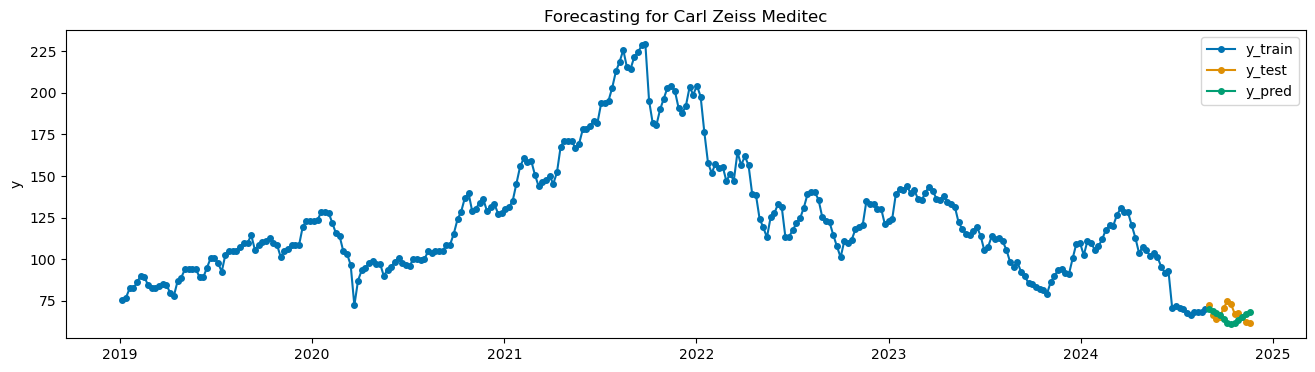

03:30:14 - cmdstanpy - INFO - Chain [1] start processing
03:30:14 - cmdstanpy - INFO - Chain [1] done processing
03:30:14 - cmdstanpy - INFO - Chain [1] start processing
03:30:14 - cmdstanpy - INFO - Chain [1] done processing



Processing company: Lam Research Corporation (2/6)...

Total combinations to test for Lam Research Corporation: 1600


03:30:15 - cmdstanpy - INFO - Chain [1] start processing
03:30:15 - cmdstanpy - INFO - Chain [1] done processing


03:30:15 - cmdstanpy - INFO - Chain [1] start processing
03:30:15 - cmdstanpy - INFO - Chain [1] done processing


03:30:15 - cmdstanpy - INFO - Chain [1] start processing
03:30:15 - cmdstanpy - INFO - Chain [1] done processing


03:30:15 - cmdstanpy - INFO - Chain [1] start processing
03:30:15 - cmdstanpy - INFO - Chain [1] done processing


03:30:16 - cmdstanpy - INFO - Chain [1] start processing
03:30:16 - cmdstanpy - INFO - Chain [1] done processing


03:30:16 - cmdstanpy - INFO - Chain [1] start processing
03:30:16 - cmdstanpy - INFO - Chain [1] done processing


03:30:16 - cmdstanpy - INFO - Chain [1] start processing
03:30:16 - cmdstanpy - INFO - Chain [1] done processing


03:30:16 - cmdstanpy - INFO - Chain [1] start processing
03:30:16 - cmdstanpy - INFO - Chain [1] done processing
03:30:17 - cmdstanpy - INFO - Chain [1] start processing


03:30:17 - cmdstanpy - INFO - Chain [1] done processing
03:30:17 - cmdstanpy - INFO - Chain [1] start processing


03:30:17 - cmdstanpy - INFO - Chain [1] done processing
03:30:17 - cmdstanpy - INFO - Chain [1] start processing


03:30:18 - cmdstanpy - INFO - Chain [1] done processing
03:30:18 - cmdstanpy - INFO - Chain [1] start processing


03:30:18 - cmdstanpy - INFO - Chain [1] done processing
03:30:18 - cmdstanpy - INFO - Chain [1] start processing


03:30:18 - cmdstanpy - INFO - Chain [1] done processing
03:30:18 - cmdstanpy - INFO - Chain [1] start processing


03:30:19 - cmdstanpy - INFO - Chain [1] done processing
03:30:19 - cmdstanpy - INFO - Chain [1] start processing
03:30:19 - cmdstanpy - INFO - Chain [1] done processing


03:30:19 - cmdstanpy - INFO - Chain [1] start processing
03:30:19 - cmdstanpy - INFO - Chain [1] done processing
03:30:19 - cmdstanpy - INFO - Chain [1] start processing
03:30:19 - cmdstanpy - INFO - Chain [1] done processing


03:30:20 - cmdstanpy - INFO - Chain [1] start processing
03:30:20 - cmdstanpy - INFO - Chain [1] done processing


03:30:20 - cmdstanpy - INFO - Chain [1] start processing
03:30:20 - cmdstanpy - INFO - Chain [1] done processing


03:30:20 - cmdstanpy - INFO - Chain [1] start processing
03:30:20 - cmdstanpy - INFO - Chain [1] done processing


03:30:20 - cmdstanpy - INFO - Chain [1] start processing
03:30:20 - cmdstanpy - INFO - Chain [1] done processing


03:30:21 - cmdstanpy - INFO - Chain [1] start processing
03:30:21 - cmdstanpy - INFO - Chain [1] done processing


03:30:21 - cmdstanpy - INFO - Chain [1] start processing
03:30:21 - cmdstanpy - INFO - Chain [1] done processing


03:30:21 - cmdstanpy - INFO - Chain [1] start processing
03:30:21 - cmdstanpy - INFO - Chain [1] done processing
03:30:22 - cmdstanpy - INFO - Chain [1] start processing


03:30:22 - cmdstanpy - INFO - Chain [1] done processing
03:30:22 - cmdstanpy - INFO - Chain [1] start processing


03:30:22 - cmdstanpy - INFO - Chain [1] done processing
03:30:22 - cmdstanpy - INFO - Chain [1] start processing


03:30:22 - cmdstanpy - INFO - Chain [1] done processing
03:30:23 - cmdstanpy - INFO - Chain [1] start processing


03:30:23 - cmdstanpy - INFO - Chain [1] done processing
03:30:23 - cmdstanpy - INFO - Chain [1] start processing


03:30:23 - cmdstanpy - INFO - Chain [1] done processing
03:30:23 - cmdstanpy - INFO - Chain [1] start processing


03:30:23 - cmdstanpy - INFO - Chain [1] done processing
03:30:24 - cmdstanpy - INFO - Chain [1] start processing
03:30:24 - cmdstanpy - INFO - Chain [1] done processing


03:30:24 - cmdstanpy - INFO - Chain [1] start processing


03:30:24 - cmdstanpy - INFO - Chain [1] done processing
03:30:24 - cmdstanpy - INFO - Chain [1] start processing


03:30:24 - cmdstanpy - INFO - Chain [1] done processing
03:30:24 - cmdstanpy - INFO - Chain [1] start processing
03:30:25 - cmdstanpy - INFO - Chain [1] done processing


03:30:25 - cmdstanpy - INFO - Chain [1] start processing
03:30:25 - cmdstanpy - INFO - Chain [1] done processing


03:30:25 - cmdstanpy - INFO - Chain [1] start processing
03:30:25 - cmdstanpy - INFO - Chain [1] done processing
03:30:25 - cmdstanpy - INFO - Chain [1] start processing
03:30:25 - cmdstanpy - INFO - Chain [1] done processing


03:30:25 - cmdstanpy - INFO - Chain [1] start processing
03:30:25 - cmdstanpy - INFO - Chain [1] done processing


03:30:26 - cmdstanpy - INFO - Chain [1] start processing
03:30:26 - cmdstanpy - INFO - Chain [1] done processing


03:30:26 - cmdstanpy - INFO - Chain [1] start processing
03:30:26 - cmdstanpy - INFO - Chain [1] done processing
03:30:26 - cmdstanpy - INFO - Chain [1] start processing


03:30:26 - cmdstanpy - INFO - Chain [1] done processing
03:30:27 - cmdstanpy - INFO - Chain [1] start processing


03:30:27 - cmdstanpy - INFO - Chain [1] done processing
03:30:27 - cmdstanpy - INFO - Chain [1] start processing


03:30:27 - cmdstanpy - INFO - Chain [1] done processing
03:30:27 - cmdstanpy - INFO - Chain [1] start processing


03:30:28 - cmdstanpy - INFO - Chain [1] done processing
03:30:28 - cmdstanpy - INFO - Chain [1] start processing
03:30:28 - cmdstanpy - INFO - Chain [1] done processing


03:30:28 - cmdstanpy - INFO - Chain [1] start processing


03:30:28 - cmdstanpy - INFO - Chain [1] done processing
03:30:29 - cmdstanpy - INFO - Chain [1] start processing
03:30:29 - cmdstanpy - INFO - Chain [1] done processing


03:30:29 - cmdstanpy - INFO - Chain [1] start processing
03:30:29 - cmdstanpy - INFO - Chain [1] done processing
03:30:29 - cmdstanpy - INFO - Chain [1] start processing
03:30:29 - cmdstanpy - INFO - Chain [1] done processing


03:30:29 - cmdstanpy - INFO - Chain [1] start processing


03:30:29 - cmdstanpy - INFO - Chain [1] done processing
03:30:30 - cmdstanpy - INFO - Chain [1] start processing
03:30:30 - cmdstanpy - INFO - Chain [1] done processing


03:30:30 - cmdstanpy - INFO - Chain [1] start processing
03:30:30 - cmdstanpy - INFO - Chain [1] done processing


03:30:30 - cmdstanpy - INFO - Chain [1] start processing
03:30:30 - cmdstanpy - INFO - Chain [1] done processing


03:30:30 - cmdstanpy - INFO - Chain [1] start processing
03:30:30 - cmdstanpy - INFO - Chain [1] done processing


03:30:30 - cmdstanpy - INFO - Chain [1] start processing
03:30:31 - cmdstanpy - INFO - Chain [1] done processing
03:30:31 - cmdstanpy - INFO - Chain [1] start processing


03:30:31 - cmdstanpy - INFO - Chain [1] done processing
03:30:31 - cmdstanpy - INFO - Chain [1] start processing


03:30:31 - cmdstanpy - INFO - Chain [1] done processing
03:30:32 - cmdstanpy - INFO - Chain [1] start processing


03:30:32 - cmdstanpy - INFO - Chain [1] done processing
03:30:32 - cmdstanpy - INFO - Chain [1] start processing


03:30:32 - cmdstanpy - INFO - Chain [1] done processing
03:30:32 - cmdstanpy - INFO - Chain [1] start processing


03:30:33 - cmdstanpy - INFO - Chain [1] done processing
03:30:33 - cmdstanpy - INFO - Chain [1] start processing
03:30:33 - cmdstanpy - INFO - Chain [1] done processing


03:30:33 - cmdstanpy - INFO - Chain [1] start processing


03:30:33 - cmdstanpy - INFO - Chain [1] done processing
03:30:33 - cmdstanpy - INFO - Chain [1] start processing
03:30:33 - cmdstanpy - INFO - Chain [1] done processing


03:30:33 - cmdstanpy - INFO - Chain [1] start processing
03:30:34 - cmdstanpy - INFO - Chain [1] done processing
03:30:34 - cmdstanpy - INFO - Chain [1] start processing
03:30:34 - cmdstanpy - INFO - Chain [1] done processing


03:30:34 - cmdstanpy - INFO - Chain [1] start processing
03:30:34 - cmdstanpy - INFO - Chain [1] done processing


03:30:34 - cmdstanpy - INFO - Chain [1] start processing
03:30:34 - cmdstanpy - INFO - Chain [1] done processing


03:30:34 - cmdstanpy - INFO - Chain [1] start processing
03:30:35 - cmdstanpy - INFO - Chain [1] done processing


03:30:35 - cmdstanpy - INFO - Chain [1] start processing
03:30:35 - cmdstanpy - INFO - Chain [1] done processing


03:30:35 - cmdstanpy - INFO - Chain [1] start processing
03:30:35 - cmdstanpy - INFO - Chain [1] done processing


03:30:35 - cmdstanpy - INFO - Chain [1] start processing
03:30:35 - cmdstanpy - INFO - Chain [1] done processing


03:30:35 - cmdstanpy - INFO - Chain [1] start processing
03:30:36 - cmdstanpy - INFO - Chain [1] done processing
03:30:36 - cmdstanpy - INFO - Chain [1] start processing


03:30:36 - cmdstanpy - INFO - Chain [1] done processing
03:30:36 - cmdstanpy - INFO - Chain [1] start processing


03:30:37 - cmdstanpy - INFO - Chain [1] done processing
03:30:37 - cmdstanpy - INFO - Chain [1] start processing


03:30:37 - cmdstanpy - INFO - Chain [1] done processing
03:30:37 - cmdstanpy - INFO - Chain [1] start processing


03:30:37 - cmdstanpy - INFO - Chain [1] done processing
03:30:37 - cmdstanpy - INFO - Chain [1] start processing
03:30:37 - cmdstanpy - INFO - Chain [1] done processing


03:30:38 - cmdstanpy - INFO - Chain [1] start processing


03:30:38 - cmdstanpy - INFO - Chain [1] done processing
03:30:38 - cmdstanpy - INFO - Chain [1] start processing
03:30:38 - cmdstanpy - INFO - Chain [1] done processing


03:30:38 - cmdstanpy - INFO - Chain [1] start processing
03:30:38 - cmdstanpy - INFO - Chain [1] done processing
03:30:38 - cmdstanpy - INFO - Chain [1] start processing
03:30:39 - cmdstanpy - INFO - Chain [1] done processing


03:30:39 - cmdstanpy - INFO - Chain [1] start processing
03:30:39 - cmdstanpy - INFO - Chain [1] done processing


03:30:39 - cmdstanpy - INFO - Chain [1] start processing
03:30:39 - cmdstanpy - INFO - Chain [1] done processing


03:30:39 - cmdstanpy - INFO - Chain [1] start processing
03:30:39 - cmdstanpy - INFO - Chain [1] done processing


03:30:39 - cmdstanpy - INFO - Chain [1] start processing
03:30:39 - cmdstanpy - INFO - Chain [1] done processing


03:30:40 - cmdstanpy - INFO - Chain [1] start processing
03:30:40 - cmdstanpy - INFO - Chain [1] done processing


03:30:40 - cmdstanpy - INFO - Chain [1] start processing
03:30:40 - cmdstanpy - INFO - Chain [1] done processing


03:30:40 - cmdstanpy - INFO - Chain [1] start processing
03:30:40 - cmdstanpy - INFO - Chain [1] done processing
03:30:41 - cmdstanpy - INFO - Chain [1] start processing


03:30:41 - cmdstanpy - INFO - Chain [1] done processing
03:30:41 - cmdstanpy - INFO - Chain [1] start processing


03:30:41 - cmdstanpy - INFO - Chain [1] done processing
03:30:41 - cmdstanpy - INFO - Chain [1] start processing


03:30:42 - cmdstanpy - INFO - Chain [1] done processing
03:30:42 - cmdstanpy - INFO - Chain [1] start processing


03:30:42 - cmdstanpy - INFO - Chain [1] done processing
03:30:42 - cmdstanpy - INFO - Chain [1] start processing
03:30:42 - cmdstanpy - INFO - Chain [1] done processing


03:30:42 - cmdstanpy - INFO - Chain [1] start processing


03:30:43 - cmdstanpy - INFO - Chain [1] done processing
03:30:43 - cmdstanpy - INFO - Chain [1] start processing
03:30:43 - cmdstanpy - INFO - Chain [1] done processing


03:30:43 - cmdstanpy - INFO - Chain [1] start processing
03:30:43 - cmdstanpy - INFO - Chain [1] done processing
03:30:43 - cmdstanpy - INFO - Chain [1] start processing
03:30:43 - cmdstanpy - INFO - Chain [1] done processing


03:30:43 - cmdstanpy - INFO - Chain [1] start processing
03:30:44 - cmdstanpy - INFO - Chain [1] done processing


03:30:44 - cmdstanpy - INFO - Chain [1] start processing
03:30:44 - cmdstanpy - INFO - Chain [1] done processing


03:30:44 - cmdstanpy - INFO - Chain [1] start processing
03:30:44 - cmdstanpy - INFO - Chain [1] done processing


03:30:44 - cmdstanpy - INFO - Chain [1] start processing
03:30:44 - cmdstanpy - INFO - Chain [1] done processing


03:30:44 - cmdstanpy - INFO - Chain [1] start processing
03:30:44 - cmdstanpy - INFO - Chain [1] done processing


03:30:45 - cmdstanpy - INFO - Chain [1] start processing
03:30:45 - cmdstanpy - INFO - Chain [1] done processing


03:30:45 - cmdstanpy - INFO - Chain [1] start processing
03:30:45 - cmdstanpy - INFO - Chain [1] done processing
03:30:45 - cmdstanpy - INFO - Chain [1] start processing


03:30:46 - cmdstanpy - INFO - Chain [1] done processing
03:30:46 - cmdstanpy - INFO - Chain [1] start processing


03:30:46 - cmdstanpy - INFO - Chain [1] done processing
03:30:46 - cmdstanpy - INFO - Chain [1] start processing


03:30:46 - cmdstanpy - INFO - Chain [1] done processing
03:30:46 - cmdstanpy - INFO - Chain [1] start processing


03:30:46 - cmdstanpy - INFO - Chain [1] done processing
03:30:47 - cmdstanpy - INFO - Chain [1] start processing
03:30:47 - cmdstanpy - INFO - Chain [1] done processing


03:30:47 - cmdstanpy - INFO - Chain [1] start processing


03:30:47 - cmdstanpy - INFO - Chain [1] done processing
03:30:47 - cmdstanpy - INFO - Chain [1] start processing
03:30:47 - cmdstanpy - INFO - Chain [1] done processing


03:30:47 - cmdstanpy - INFO - Chain [1] start processing
03:30:48 - cmdstanpy - INFO - Chain [1] done processing
03:30:48 - cmdstanpy - INFO - Chain [1] start processing
03:30:48 - cmdstanpy - INFO - Chain [1] done processing


03:30:48 - cmdstanpy - INFO - Chain [1] start processing
03:30:48 - cmdstanpy - INFO - Chain [1] done processing


03:30:48 - cmdstanpy - INFO - Chain [1] start processing
03:30:48 - cmdstanpy - INFO - Chain [1] done processing


03:30:48 - cmdstanpy - INFO - Chain [1] start processing
03:30:48 - cmdstanpy - INFO - Chain [1] done processing
03:30:49 - cmdstanpy - INFO - Chain [1] start processing
03:30:49 - cmdstanpy - INFO - Chain [1] done processing


03:30:49 - cmdstanpy - INFO - Chain [1] start processing
03:30:49 - cmdstanpy - INFO - Chain [1] done processing
03:30:49 - cmdstanpy - INFO - Chain [1] start processing
03:30:49 - cmdstanpy - INFO - Chain [1] done processing


03:30:49 - cmdstanpy - INFO - Chain [1] start processing
03:30:50 - cmdstanpy - INFO - Chain [1] done processing
03:30:50 - cmdstanpy - INFO - Chain [1] start processing


03:30:50 - cmdstanpy - INFO - Chain [1] done processing
03:30:50 - cmdstanpy - INFO - Chain [1] start processing


03:30:50 - cmdstanpy - INFO - Chain [1] done processing
03:30:51 - cmdstanpy - INFO - Chain [1] start processing
03:30:51 - cmdstanpy - INFO - Chain [1] done processing


03:30:51 - cmdstanpy - INFO - Chain [1] start processing


03:30:51 - cmdstanpy - INFO - Chain [1] done processing
03:30:51 - cmdstanpy - INFO - Chain [1] start processing


03:30:51 - cmdstanpy - INFO - Chain [1] done processing
03:30:51 - cmdstanpy - INFO - Chain [1] start processing


03:30:52 - cmdstanpy - INFO - Chain [1] done processing
03:30:52 - cmdstanpy - INFO - Chain [1] start processing
03:30:52 - cmdstanpy - INFO - Chain [1] done processing


03:30:52 - cmdstanpy - INFO - Chain [1] start processing
03:30:52 - cmdstanpy - INFO - Chain [1] done processing
03:30:52 - cmdstanpy - INFO - Chain [1] start processing
03:30:52 - cmdstanpy - INFO - Chain [1] done processing


03:30:53 - cmdstanpy - INFO - Chain [1] start processing
03:30:53 - cmdstanpy - INFO - Chain [1] done processing


03:30:53 - cmdstanpy - INFO - Chain [1] start processing
03:30:53 - cmdstanpy - INFO - Chain [1] done processing


03:30:53 - cmdstanpy - INFO - Chain [1] start processing


03:30:53 - cmdstanpy - INFO - Chain [1] done processing
03:30:53 - cmdstanpy - INFO - Chain [1] start processing
03:30:53 - cmdstanpy - INFO - Chain [1] done processing


03:30:54 - cmdstanpy - INFO - Chain [1] start processing
03:30:54 - cmdstanpy - INFO - Chain [1] done processing


03:30:54 - cmdstanpy - INFO - Chain [1] start processing
03:30:54 - cmdstanpy - INFO - Chain [1] done processing


03:30:54 - cmdstanpy - INFO - Chain [1] start processing
03:30:54 - cmdstanpy - INFO - Chain [1] done processing
03:30:54 - cmdstanpy - INFO - Chain [1] start processing


03:30:55 - cmdstanpy - INFO - Chain [1] done processing
03:30:55 - cmdstanpy - INFO - Chain [1] start processing


03:30:55 - cmdstanpy - INFO - Chain [1] done processing
03:30:55 - cmdstanpy - INFO - Chain [1] start processing


03:30:56 - cmdstanpy - INFO - Chain [1] done processing
03:30:56 - cmdstanpy - INFO - Chain [1] start processing


03:30:56 - cmdstanpy - INFO - Chain [1] done processing
03:30:56 - cmdstanpy - INFO - Chain [1] start processing
03:30:56 - cmdstanpy - INFO - Chain [1] done processing


03:30:56 - cmdstanpy - INFO - Chain [1] start processing


03:30:57 - cmdstanpy - INFO - Chain [1] done processing
03:30:57 - cmdstanpy - INFO - Chain [1] start processing
03:30:57 - cmdstanpy - INFO - Chain [1] done processing


03:30:57 - cmdstanpy - INFO - Chain [1] start processing
03:30:57 - cmdstanpy - INFO - Chain [1] done processing
03:30:57 - cmdstanpy - INFO - Chain [1] start processing
03:30:57 - cmdstanpy - INFO - Chain [1] done processing


03:30:58 - cmdstanpy - INFO - Chain [1] start processing
03:30:58 - cmdstanpy - INFO - Chain [1] done processing


03:30:58 - cmdstanpy - INFO - Chain [1] start processing
03:30:58 - cmdstanpy - INFO - Chain [1] done processing


03:30:58 - cmdstanpy - INFO - Chain [1] start processing
03:30:58 - cmdstanpy - INFO - Chain [1] done processing
03:30:58 - cmdstanpy - INFO - Chain [1] start processing
03:30:58 - cmdstanpy - INFO - Chain [1] done processing


03:30:59 - cmdstanpy - INFO - Chain [1] start processing
03:30:59 - cmdstanpy - INFO - Chain [1] done processing


03:30:59 - cmdstanpy - INFO - Chain [1] start processing
03:30:59 - cmdstanpy - INFO - Chain [1] done processing


03:30:59 - cmdstanpy - INFO - Chain [1] start processing
03:30:59 - cmdstanpy - INFO - Chain [1] done processing
03:30:59 - cmdstanpy - INFO - Chain [1] start processing


03:31:00 - cmdstanpy - INFO - Chain [1] done processing
03:31:00 - cmdstanpy - INFO - Chain [1] start processing


03:31:00 - cmdstanpy - INFO - Chain [1] done processing
03:31:00 - cmdstanpy - INFO - Chain [1] start processing
03:31:00 - cmdstanpy - INFO - Chain [1] done processing


03:31:00 - cmdstanpy - INFO - Chain [1] start processing


03:31:01 - cmdstanpy - INFO - Chain [1] done processing
03:31:01 - cmdstanpy - INFO - Chain [1] start processing


03:31:01 - cmdstanpy - INFO - Chain [1] done processing
03:31:01 - cmdstanpy - INFO - Chain [1] start processing
03:31:01 - cmdstanpy - INFO - Chain [1] done processing


03:31:01 - cmdstanpy - INFO - Chain [1] start processing
03:31:01 - cmdstanpy - INFO - Chain [1] done processing
03:31:02 - cmdstanpy - INFO - Chain [1] start processing


03:31:02 - cmdstanpy - INFO - Chain [1] done processing
03:31:02 - cmdstanpy - INFO - Chain [1] start processing
03:31:02 - cmdstanpy - INFO - Chain [1] done processing


03:31:02 - cmdstanpy - INFO - Chain [1] start processing
03:31:02 - cmdstanpy - INFO - Chain [1] done processing


03:31:02 - cmdstanpy - INFO - Chain [1] start processing
03:31:02 - cmdstanpy - INFO - Chain [1] done processing


03:31:03 - cmdstanpy - INFO - Chain [1] start processing
03:31:03 - cmdstanpy - INFO - Chain [1] done processing
03:31:03 - cmdstanpy - INFO - Chain [1] start processing
03:31:03 - cmdstanpy - INFO - Chain [1] done processing


03:31:03 - cmdstanpy - INFO - Chain [1] start processing
03:31:03 - cmdstanpy - INFO - Chain [1] done processing


03:31:03 - cmdstanpy - INFO - Chain [1] start processing
03:31:03 - cmdstanpy - INFO - Chain [1] done processing


03:31:04 - cmdstanpy - INFO - Chain [1] start processing
03:31:04 - cmdstanpy - INFO - Chain [1] done processing
03:31:04 - cmdstanpy - INFO - Chain [1] start processing


03:31:04 - cmdstanpy - INFO - Chain [1] done processing
03:31:04 - cmdstanpy - INFO - Chain [1] start processing


03:31:05 - cmdstanpy - INFO - Chain [1] done processing
03:31:05 - cmdstanpy - INFO - Chain [1] start processing


03:31:05 - cmdstanpy - INFO - Chain [1] done processing
03:31:05 - cmdstanpy - INFO - Chain [1] start processing


03:31:05 - cmdstanpy - INFO - Chain [1] done processing
03:31:05 - cmdstanpy - INFO - Chain [1] start processing
03:31:05 - cmdstanpy - INFO - Chain [1] done processing


03:31:06 - cmdstanpy - INFO - Chain [1] start processing


03:31:06 - cmdstanpy - INFO - Chain [1] done processing
03:31:06 - cmdstanpy - INFO - Chain [1] start processing
03:31:06 - cmdstanpy - INFO - Chain [1] done processing


03:31:06 - cmdstanpy - INFO - Chain [1] start processing
03:31:06 - cmdstanpy - INFO - Chain [1] done processing
03:31:06 - cmdstanpy - INFO - Chain [1] start processing


03:31:07 - cmdstanpy - INFO - Chain [1] done processing
03:31:07 - cmdstanpy - INFO - Chain [1] start processing
03:31:07 - cmdstanpy - INFO - Chain [1] done processing


03:31:07 - cmdstanpy - INFO - Chain [1] start processing
03:31:07 - cmdstanpy - INFO - Chain [1] done processing


03:31:07 - cmdstanpy - INFO - Chain [1] start processing
03:31:07 - cmdstanpy - INFO - Chain [1] done processing
03:31:08 - cmdstanpy - INFO - Chain [1] start processing
03:31:08 - cmdstanpy - INFO - Chain [1] done processing


03:31:08 - cmdstanpy - INFO - Chain [1] start processing
03:31:08 - cmdstanpy - INFO - Chain [1] done processing


03:31:08 - cmdstanpy - INFO - Chain [1] start processing
03:31:08 - cmdstanpy - INFO - Chain [1] done processing


03:31:08 - cmdstanpy - INFO - Chain [1] start processing
03:31:09 - cmdstanpy - INFO - Chain [1] done processing
03:31:09 - cmdstanpy - INFO - Chain [1] start processing


03:31:09 - cmdstanpy - INFO - Chain [1] done processing
03:31:09 - cmdstanpy - INFO - Chain [1] start processing


03:31:09 - cmdstanpy - INFO - Chain [1] done processing
03:31:09 - cmdstanpy - INFO - Chain [1] start processing
03:31:10 - cmdstanpy - INFO - Chain [1] done processing


03:31:10 - cmdstanpy - INFO - Chain [1] start processing


03:31:10 - cmdstanpy - INFO - Chain [1] done processing
03:31:10 - cmdstanpy - INFO - Chain [1] start processing
03:31:10 - cmdstanpy - INFO - Chain [1] done processing


03:31:10 - cmdstanpy - INFO - Chain [1] start processing


03:31:11 - cmdstanpy - INFO - Chain [1] done processing
03:31:11 - cmdstanpy - INFO - Chain [1] start processing
03:31:11 - cmdstanpy - INFO - Chain [1] done processing


03:31:11 - cmdstanpy - INFO - Chain [1] start processing


03:31:11 - cmdstanpy - INFO - Chain [1] done processing
03:31:11 - cmdstanpy - INFO - Chain [1] start processing
03:31:11 - cmdstanpy - INFO - Chain [1] done processing


03:31:12 - cmdstanpy - INFO - Chain [1] start processing
03:31:12 - cmdstanpy - INFO - Chain [1] done processing


03:31:12 - cmdstanpy - INFO - Chain [1] start processing
03:31:12 - cmdstanpy - INFO - Chain [1] done processing


03:31:12 - cmdstanpy - INFO - Chain [1] start processing


03:31:12 - cmdstanpy - INFO - Chain [1] done processing
03:31:12 - cmdstanpy - INFO - Chain [1] start processing


03:31:13 - cmdstanpy - INFO - Chain [1] done processing
03:31:13 - cmdstanpy - INFO - Chain [1] start processing
03:31:13 - cmdstanpy - INFO - Chain [1] done processing


03:31:13 - cmdstanpy - INFO - Chain [1] start processing
03:31:13 - cmdstanpy - INFO - Chain [1] done processing


03:31:13 - cmdstanpy - INFO - Chain [1] start processing


03:31:13 - cmdstanpy - INFO - Chain [1] done processing
03:31:14 - cmdstanpy - INFO - Chain [1] start processing


03:31:14 - cmdstanpy - INFO - Chain [1] done processing
03:31:14 - cmdstanpy - INFO - Chain [1] start processing


03:31:14 - cmdstanpy - INFO - Chain [1] done processing
03:31:14 - cmdstanpy - INFO - Chain [1] start processing


03:31:15 - cmdstanpy - INFO - Chain [1] done processing
03:31:15 - cmdstanpy - INFO - Chain [1] start processing


03:31:15 - cmdstanpy - INFO - Chain [1] done processing
03:31:15 - cmdstanpy - INFO - Chain [1] start processing
03:31:15 - cmdstanpy - INFO - Chain [1] done processing


03:31:15 - cmdstanpy - INFO - Chain [1] start processing


03:31:16 - cmdstanpy - INFO - Chain [1] done processing
03:31:16 - cmdstanpy - INFO - Chain [1] start processing
03:31:16 - cmdstanpy - INFO - Chain [1] done processing


03:31:16 - cmdstanpy - INFO - Chain [1] start processing


03:31:16 - cmdstanpy - INFO - Chain [1] done processing
03:31:16 - cmdstanpy - INFO - Chain [1] start processing


03:31:16 - cmdstanpy - INFO - Chain [1] done processing
03:31:17 - cmdstanpy - INFO - Chain [1] start processing
03:31:17 - cmdstanpy - INFO - Chain [1] done processing


03:31:17 - cmdstanpy - INFO - Chain [1] start processing
03:31:17 - cmdstanpy - INFO - Chain [1] done processing


03:31:17 - cmdstanpy - INFO - Chain [1] start processing
03:31:17 - cmdstanpy - INFO - Chain [1] done processing


03:31:17 - cmdstanpy - INFO - Chain [1] start processing
03:31:17 - cmdstanpy - INFO - Chain [1] done processing


03:31:18 - cmdstanpy - INFO - Chain [1] start processing
03:31:18 - cmdstanpy - INFO - Chain [1] done processing


03:31:18 - cmdstanpy - INFO - Chain [1] start processing
03:31:18 - cmdstanpy - INFO - Chain [1] done processing


03:31:18 - cmdstanpy - INFO - Chain [1] start processing


03:31:18 - cmdstanpy - INFO - Chain [1] done processing
03:31:18 - cmdstanpy - INFO - Chain [1] start processing


03:31:19 - cmdstanpy - INFO - Chain [1] done processing
03:31:19 - cmdstanpy - INFO - Chain [1] start processing


03:31:19 - cmdstanpy - INFO - Chain [1] done processing
03:31:19 - cmdstanpy - INFO - Chain [1] start processing


03:31:19 - cmdstanpy - INFO - Chain [1] done processing
03:31:19 - cmdstanpy - INFO - Chain [1] start processing


03:31:20 - cmdstanpy - INFO - Chain [1] done processing
03:31:20 - cmdstanpy - INFO - Chain [1] start processing
03:31:20 - cmdstanpy - INFO - Chain [1] done processing


03:31:20 - cmdstanpy - INFO - Chain [1] start processing


03:31:20 - cmdstanpy - INFO - Chain [1] done processing
03:31:20 - cmdstanpy - INFO - Chain [1] start processing
03:31:21 - cmdstanpy - INFO - Chain [1] done processing


03:31:21 - cmdstanpy - INFO - Chain [1] start processing
03:31:21 - cmdstanpy - INFO - Chain [1] done processing
03:31:21 - cmdstanpy - INFO - Chain [1] start processing


03:31:21 - cmdstanpy - INFO - Chain [1] done processing
03:31:21 - cmdstanpy - INFO - Chain [1] start processing


03:31:21 - cmdstanpy - INFO - Chain [1] done processing
03:31:22 - cmdstanpy - INFO - Chain [1] start processing
03:31:22 - cmdstanpy - INFO - Chain [1] done processing


03:31:22 - cmdstanpy - INFO - Chain [1] start processing


03:31:22 - cmdstanpy - INFO - Chain [1] done processing
03:31:22 - cmdstanpy - INFO - Chain [1] start processing


03:31:22 - cmdstanpy - INFO - Chain [1] done processing
03:31:23 - cmdstanpy - INFO - Chain [1] start processing
03:31:23 - cmdstanpy - INFO - Chain [1] done processing


03:31:23 - cmdstanpy - INFO - Chain [1] start processing
03:31:23 - cmdstanpy - INFO - Chain [1] done processing


03:31:23 - cmdstanpy - INFO - Chain [1] start processing


03:31:23 - cmdstanpy - INFO - Chain [1] done processing
03:31:24 - cmdstanpy - INFO - Chain [1] start processing


03:31:24 - cmdstanpy - INFO - Chain [1] done processing
03:31:24 - cmdstanpy - INFO - Chain [1] start processing


03:31:24 - cmdstanpy - INFO - Chain [1] done processing
03:31:24 - cmdstanpy - INFO - Chain [1] start processing


03:31:25 - cmdstanpy - INFO - Chain [1] done processing
03:31:25 - cmdstanpy - INFO - Chain [1] start processing


03:31:25 - cmdstanpy - INFO - Chain [1] done processing
03:31:25 - cmdstanpy - INFO - Chain [1] start processing


03:31:25 - cmdstanpy - INFO - Chain [1] done processing
03:31:26 - cmdstanpy - INFO - Chain [1] start processing
03:31:26 - cmdstanpy - INFO - Chain [1] done processing


03:31:26 - cmdstanpy - INFO - Chain [1] start processing
03:31:26 - cmdstanpy - INFO - Chain [1] done processing


03:31:26 - cmdstanpy - INFO - Chain [1] start processing
03:31:26 - cmdstanpy - INFO - Chain [1] done processing
03:31:26 - cmdstanpy - INFO - Chain [1] start processing


03:31:26 - cmdstanpy - INFO - Chain [1] done processing
03:31:27 - cmdstanpy - INFO - Chain [1] start processing
03:31:27 - cmdstanpy - INFO - Chain [1] done processing


03:31:27 - cmdstanpy - INFO - Chain [1] start processing
03:31:27 - cmdstanpy - INFO - Chain [1] done processing


03:31:27 - cmdstanpy - INFO - Chain [1] start processing
03:31:27 - cmdstanpy - INFO - Chain [1] done processing
03:31:27 - cmdstanpy - INFO - Chain [1] start processing
03:31:27 - cmdstanpy - INFO - Chain [1] done processing


03:31:28 - cmdstanpy - INFO - Chain [1] start processing
03:31:28 - cmdstanpy - INFO - Chain [1] done processing


03:31:28 - cmdstanpy - INFO - Chain [1] start processing
03:31:28 - cmdstanpy - INFO - Chain [1] done processing


03:31:28 - cmdstanpy - INFO - Chain [1] start processing


03:31:28 - cmdstanpy - INFO - Chain [1] done processing
03:31:29 - cmdstanpy - INFO - Chain [1] start processing


03:31:29 - cmdstanpy - INFO - Chain [1] done processing
03:31:29 - cmdstanpy - INFO - Chain [1] start processing


03:31:29 - cmdstanpy - INFO - Chain [1] done processing
03:31:29 - cmdstanpy - INFO - Chain [1] start processing


03:31:29 - cmdstanpy - INFO - Chain [1] done processing
03:31:30 - cmdstanpy - INFO - Chain [1] start processing


03:31:30 - cmdstanpy - INFO - Chain [1] done processing
03:31:30 - cmdstanpy - INFO - Chain [1] start processing


03:31:30 - cmdstanpy - INFO - Chain [1] done processing
03:31:30 - cmdstanpy - INFO - Chain [1] start processing


03:31:31 - cmdstanpy - INFO - Chain [1] done processing
03:31:31 - cmdstanpy - INFO - Chain [1] start processing
03:31:31 - cmdstanpy - INFO - Chain [1] done processing


03:31:31 - cmdstanpy - INFO - Chain [1] start processing


03:31:31 - cmdstanpy - INFO - Chain [1] done processing
03:31:31 - cmdstanpy - INFO - Chain [1] start processing


03:31:31 - cmdstanpy - INFO - Chain [1] done processing
03:31:32 - cmdstanpy - INFO - Chain [1] start processing
03:31:32 - cmdstanpy - INFO - Chain [1] done processing


03:31:32 - cmdstanpy - INFO - Chain [1] start processing
03:31:32 - cmdstanpy - INFO - Chain [1] done processing


03:31:32 - cmdstanpy - INFO - Chain [1] start processing


03:31:32 - cmdstanpy - INFO - Chain [1] done processing
03:31:32 - cmdstanpy - INFO - Chain [1] start processing


03:31:33 - cmdstanpy - INFO - Chain [1] done processing
03:31:33 - cmdstanpy - INFO - Chain [1] start processing
03:31:33 - cmdstanpy - INFO - Chain [1] done processing


03:31:33 - cmdstanpy - INFO - Chain [1] start processing
03:31:33 - cmdstanpy - INFO - Chain [1] done processing
03:31:33 - cmdstanpy - INFO - Chain [1] start processing


03:31:33 - cmdstanpy - INFO - Chain [1] done processing
03:31:34 - cmdstanpy - INFO - Chain [1] start processing


03:31:34 - cmdstanpy - INFO - Chain [1] done processing
03:31:34 - cmdstanpy - INFO - Chain [1] start processing


03:31:34 - cmdstanpy - INFO - Chain [1] done processing
03:31:34 - cmdstanpy - INFO - Chain [1] start processing


03:31:35 - cmdstanpy - INFO - Chain [1] done processing
03:31:35 - cmdstanpy - INFO - Chain [1] start processing


03:31:35 - cmdstanpy - INFO - Chain [1] done processing
03:31:35 - cmdstanpy - INFO - Chain [1] start processing
03:31:35 - cmdstanpy - INFO - Chain [1] done processing


03:31:35 - cmdstanpy - INFO - Chain [1] start processing


03:31:36 - cmdstanpy - INFO - Chain [1] done processing
03:31:36 - cmdstanpy - INFO - Chain [1] start processing
03:31:36 - cmdstanpy - INFO - Chain [1] done processing


03:31:36 - cmdstanpy - INFO - Chain [1] start processing


03:31:36 - cmdstanpy - INFO - Chain [1] done processing
03:31:36 - cmdstanpy - INFO - Chain [1] start processing


03:31:36 - cmdstanpy - INFO - Chain [1] done processing
03:31:37 - cmdstanpy - INFO - Chain [1] start processing
03:31:37 - cmdstanpy - INFO - Chain [1] done processing


03:31:37 - cmdstanpy - INFO - Chain [1] start processing
03:31:37 - cmdstanpy - INFO - Chain [1] done processing


03:31:37 - cmdstanpy - INFO - Chain [1] start processing


03:31:37 - cmdstanpy - INFO - Chain [1] done processing
03:31:37 - cmdstanpy - INFO - Chain [1] start processing
03:31:37 - cmdstanpy - INFO - Chain [1] done processing


03:31:38 - cmdstanpy - INFO - Chain [1] start processing
03:31:38 - cmdstanpy - INFO - Chain [1] done processing


03:31:38 - cmdstanpy - INFO - Chain [1] start processing
03:31:38 - cmdstanpy - INFO - Chain [1] done processing


03:31:38 - cmdstanpy - INFO - Chain [1] start processing
03:31:38 - cmdstanpy - INFO - Chain [1] done processing
03:31:39 - cmdstanpy - INFO - Chain [1] start processing


03:31:39 - cmdstanpy - INFO - Chain [1] done processing
03:31:39 - cmdstanpy - INFO - Chain [1] start processing


03:31:39 - cmdstanpy - INFO - Chain [1] done processing
03:31:39 - cmdstanpy - INFO - Chain [1] start processing


03:31:40 - cmdstanpy - INFO - Chain [1] done processing
03:31:40 - cmdstanpy - INFO - Chain [1] start processing


03:31:40 - cmdstanpy - INFO - Chain [1] done processing
03:31:40 - cmdstanpy - INFO - Chain [1] start processing
03:31:40 - cmdstanpy - INFO - Chain [1] done processing


03:31:40 - cmdstanpy - INFO - Chain [1] start processing


03:31:41 - cmdstanpy - INFO - Chain [1] done processing
03:31:41 - cmdstanpy - INFO - Chain [1] start processing
03:31:41 - cmdstanpy - INFO - Chain [1] done processing


03:31:41 - cmdstanpy - INFO - Chain [1] start processing
03:31:41 - cmdstanpy - INFO - Chain [1] done processing
03:31:41 - cmdstanpy - INFO - Chain [1] start processing


03:31:41 - cmdstanpy - INFO - Chain [1] done processing
03:31:42 - cmdstanpy - INFO - Chain [1] start processing
03:31:42 - cmdstanpy - INFO - Chain [1] done processing


03:31:42 - cmdstanpy - INFO - Chain [1] start processing
03:31:42 - cmdstanpy - INFO - Chain [1] done processing


03:31:42 - cmdstanpy - INFO - Chain [1] start processing
03:31:42 - cmdstanpy - INFO - Chain [1] done processing
03:31:42 - cmdstanpy - INFO - Chain [1] start processing
03:31:42 - cmdstanpy - INFO - Chain [1] done processing


03:31:43 - cmdstanpy - INFO - Chain [1] start processing
03:31:43 - cmdstanpy - INFO - Chain [1] done processing


03:31:43 - cmdstanpy - INFO - Chain [1] start processing
03:31:43 - cmdstanpy - INFO - Chain [1] done processing


03:31:43 - cmdstanpy - INFO - Chain [1] start processing
03:31:43 - cmdstanpy - INFO - Chain [1] done processing
03:31:43 - cmdstanpy - INFO - Chain [1] start processing


03:31:44 - cmdstanpy - INFO - Chain [1] done processing
03:31:44 - cmdstanpy - INFO - Chain [1] start processing


03:31:44 - cmdstanpy - INFO - Chain [1] done processing
03:31:44 - cmdstanpy - INFO - Chain [1] start processing


03:31:44 - cmdstanpy - INFO - Chain [1] done processing
03:31:45 - cmdstanpy - INFO - Chain [1] start processing


03:31:45 - cmdstanpy - INFO - Chain [1] done processing
03:31:45 - cmdstanpy - INFO - Chain [1] start processing
03:31:45 - cmdstanpy - INFO - Chain [1] done processing


03:31:45 - cmdstanpy - INFO - Chain [1] start processing


03:31:45 - cmdstanpy - INFO - Chain [1] done processing
03:31:46 - cmdstanpy - INFO - Chain [1] start processing
03:31:46 - cmdstanpy - INFO - Chain [1] done processing


03:31:46 - cmdstanpy - INFO - Chain [1] start processing
03:31:46 - cmdstanpy - INFO - Chain [1] done processing
03:31:46 - cmdstanpy - INFO - Chain [1] start processing


03:31:46 - cmdstanpy - INFO - Chain [1] done processing
03:31:46 - cmdstanpy - INFO - Chain [1] start processing
03:31:46 - cmdstanpy - INFO - Chain [1] done processing


03:31:47 - cmdstanpy - INFO - Chain [1] start processing
03:31:47 - cmdstanpy - INFO - Chain [1] done processing


03:31:47 - cmdstanpy - INFO - Chain [1] start processing


03:31:47 - cmdstanpy - INFO - Chain [1] done processing
03:31:47 - cmdstanpy - INFO - Chain [1] start processing
03:31:47 - cmdstanpy - INFO - Chain [1] done processing


03:31:47 - cmdstanpy - INFO - Chain [1] start processing
03:31:47 - cmdstanpy - INFO - Chain [1] done processing


03:31:48 - cmdstanpy - INFO - Chain [1] start processing
03:31:48 - cmdstanpy - INFO - Chain [1] done processing


03:31:48 - cmdstanpy - INFO - Chain [1] start processing


03:31:48 - cmdstanpy - INFO - Chain [1] done processing
03:31:48 - cmdstanpy - INFO - Chain [1] start processing


03:31:49 - cmdstanpy - INFO - Chain [1] done processing
03:31:49 - cmdstanpy - INFO - Chain [1] start processing


03:31:49 - cmdstanpy - INFO - Chain [1] done processing
03:31:49 - cmdstanpy - INFO - Chain [1] start processing


03:31:49 - cmdstanpy - INFO - Chain [1] done processing
03:31:49 - cmdstanpy - INFO - Chain [1] start processing


03:31:50 - cmdstanpy - INFO - Chain [1] done processing
03:31:50 - cmdstanpy - INFO - Chain [1] start processing
03:31:50 - cmdstanpy - INFO - Chain [1] done processing


03:31:50 - cmdstanpy - INFO - Chain [1] start processing


03:31:50 - cmdstanpy - INFO - Chain [1] done processing
03:31:50 - cmdstanpy - INFO - Chain [1] start processing
03:31:50 - cmdstanpy - INFO - Chain [1] done processing


03:31:51 - cmdstanpy - INFO - Chain [1] start processing
03:31:51 - cmdstanpy - INFO - Chain [1] done processing
03:31:51 - cmdstanpy - INFO - Chain [1] start processing


03:31:51 - cmdstanpy - INFO - Chain [1] done processing
03:31:51 - cmdstanpy - INFO - Chain [1] start processing
03:31:51 - cmdstanpy - INFO - Chain [1] done processing


03:31:51 - cmdstanpy - INFO - Chain [1] start processing
03:31:51 - cmdstanpy - INFO - Chain [1] done processing


03:31:52 - cmdstanpy - INFO - Chain [1] start processing
03:31:52 - cmdstanpy - INFO - Chain [1] done processing
03:31:52 - cmdstanpy - INFO - Chain [1] start processing


03:31:52 - cmdstanpy - INFO - Chain [1] done processing
03:31:52 - cmdstanpy - INFO - Chain [1] start processing
03:31:52 - cmdstanpy - INFO - Chain [1] done processing


03:31:52 - cmdstanpy - INFO - Chain [1] start processing
03:31:53 - cmdstanpy - INFO - Chain [1] done processing
03:31:53 - cmdstanpy - INFO - Chain [1] start processing


03:31:53 - cmdstanpy - INFO - Chain [1] done processing
03:31:53 - cmdstanpy - INFO - Chain [1] start processing


03:31:53 - cmdstanpy - INFO - Chain [1] done processing
03:31:54 - cmdstanpy - INFO - Chain [1] start processing


03:31:54 - cmdstanpy - INFO - Chain [1] done processing
03:31:54 - cmdstanpy - INFO - Chain [1] start processing


03:31:54 - cmdstanpy - INFO - Chain [1] done processing
03:31:54 - cmdstanpy - INFO - Chain [1] start processing


03:31:55 - cmdstanpy - INFO - Chain [1] done processing
03:31:55 - cmdstanpy - INFO - Chain [1] start processing


03:31:55 - cmdstanpy - INFO - Chain [1] done processing
03:31:55 - cmdstanpy - INFO - Chain [1] start processing


03:31:55 - cmdstanpy - INFO - Chain [1] done processing
03:31:55 - cmdstanpy - INFO - Chain [1] start processing
03:31:56 - cmdstanpy - INFO - Chain [1] done processing


03:31:56 - cmdstanpy - INFO - Chain [1] start processing


03:31:56 - cmdstanpy - INFO - Chain [1] done processing
03:31:56 - cmdstanpy - INFO - Chain [1] start processing


03:31:56 - cmdstanpy - INFO - Chain [1] done processing
03:31:56 - cmdstanpy - INFO - Chain [1] start processing
03:31:56 - cmdstanpy - INFO - Chain [1] done processing


03:31:57 - cmdstanpy - INFO - Chain [1] start processing
03:31:57 - cmdstanpy - INFO - Chain [1] done processing


03:31:57 - cmdstanpy - INFO - Chain [1] start processing
03:31:57 - cmdstanpy - INFO - Chain [1] done processing
03:31:57 - cmdstanpy - INFO - Chain [1] start processing


03:31:57 - cmdstanpy - INFO - Chain [1] done processing
03:31:57 - cmdstanpy - INFO - Chain [1] start processing
03:31:57 - cmdstanpy - INFO - Chain [1] done processing


03:31:57 - cmdstanpy - INFO - Chain [1] start processing
03:31:58 - cmdstanpy - INFO - Chain [1] done processing
03:31:58 - cmdstanpy - INFO - Chain [1] start processing


03:31:58 - cmdstanpy - INFO - Chain [1] done processing
03:31:58 - cmdstanpy - INFO - Chain [1] start processing


03:31:58 - cmdstanpy - INFO - Chain [1] done processing
03:31:58 - cmdstanpy - INFO - Chain [1] start processing


03:31:59 - cmdstanpy - INFO - Chain [1] done processing
03:31:59 - cmdstanpy - INFO - Chain [1] start processing


03:31:59 - cmdstanpy - INFO - Chain [1] done processing
03:31:59 - cmdstanpy - INFO - Chain [1] start processing


03:31:59 - cmdstanpy - INFO - Chain [1] done processing
03:32:00 - cmdstanpy - INFO - Chain [1] start processing
03:32:00 - cmdstanpy - INFO - Chain [1] done processing


03:32:00 - cmdstanpy - INFO - Chain [1] start processing


03:32:00 - cmdstanpy - INFO - Chain [1] done processing
03:32:00 - cmdstanpy - INFO - Chain [1] start processing
03:32:00 - cmdstanpy - INFO - Chain [1] done processing


03:32:00 - cmdstanpy - INFO - Chain [1] start processing
03:32:01 - cmdstanpy - INFO - Chain [1] done processing
03:32:01 - cmdstanpy - INFO - Chain [1] start processing


03:32:01 - cmdstanpy - INFO - Chain [1] done processing
03:32:01 - cmdstanpy - INFO - Chain [1] start processing
03:32:01 - cmdstanpy - INFO - Chain [1] done processing


03:32:01 - cmdstanpy - INFO - Chain [1] start processing
03:32:01 - cmdstanpy - INFO - Chain [1] done processing


03:32:01 - cmdstanpy - INFO - Chain [1] start processing
03:32:02 - cmdstanpy - INFO - Chain [1] done processing
03:32:02 - cmdstanpy - INFO - Chain [1] start processing


03:32:02 - cmdstanpy - INFO - Chain [1] done processing
03:32:02 - cmdstanpy - INFO - Chain [1] start processing
03:32:02 - cmdstanpy - INFO - Chain [1] done processing


03:32:02 - cmdstanpy - INFO - Chain [1] start processing
03:32:02 - cmdstanpy - INFO - Chain [1] done processing


03:32:02 - cmdstanpy - INFO - Chain [1] start processing
03:32:03 - cmdstanpy - INFO - Chain [1] done processing
03:32:03 - cmdstanpy - INFO - Chain [1] start processing


03:32:03 - cmdstanpy - INFO - Chain [1] done processing
03:32:03 - cmdstanpy - INFO - Chain [1] start processing


03:32:04 - cmdstanpy - INFO - Chain [1] done processing
03:32:04 - cmdstanpy - INFO - Chain [1] start processing


03:32:04 - cmdstanpy - INFO - Chain [1] done processing
03:32:04 - cmdstanpy - INFO - Chain [1] start processing


03:32:04 - cmdstanpy - INFO - Chain [1] done processing
03:32:05 - cmdstanpy - INFO - Chain [1] start processing


03:32:05 - cmdstanpy - INFO - Chain [1] done processing
03:32:05 - cmdstanpy - INFO - Chain [1] start processing


03:32:05 - cmdstanpy - INFO - Chain [1] done processing
03:32:05 - cmdstanpy - INFO - Chain [1] start processing
03:32:05 - cmdstanpy - INFO - Chain [1] done processing


03:32:06 - cmdstanpy - INFO - Chain [1] start processing


03:32:06 - cmdstanpy - INFO - Chain [1] done processing
03:32:06 - cmdstanpy - INFO - Chain [1] start processing


03:32:06 - cmdstanpy - INFO - Chain [1] done processing
03:32:06 - cmdstanpy - INFO - Chain [1] start processing
03:32:06 - cmdstanpy - INFO - Chain [1] done processing


03:32:06 - cmdstanpy - INFO - Chain [1] start processing
03:32:06 - cmdstanpy - INFO - Chain [1] done processing


03:32:07 - cmdstanpy - INFO - Chain [1] start processing


03:32:07 - cmdstanpy - INFO - Chain [1] done processing
03:32:07 - cmdstanpy - INFO - Chain [1] start processing


03:32:07 - cmdstanpy - INFO - Chain [1] done processing
03:32:07 - cmdstanpy - INFO - Chain [1] start processing


03:32:07 - cmdstanpy - INFO - Chain [1] done processing
03:32:08 - cmdstanpy - INFO - Chain [1] start processing
03:32:08 - cmdstanpy - INFO - Chain [1] done processing


03:32:08 - cmdstanpy - INFO - Chain [1] start processing


03:32:08 - cmdstanpy - INFO - Chain [1] done processing
03:32:08 - cmdstanpy - INFO - Chain [1] start processing


03:32:09 - cmdstanpy - INFO - Chain [1] done processing
03:32:09 - cmdstanpy - INFO - Chain [1] start processing


03:32:09 - cmdstanpy - INFO - Chain [1] done processing
03:32:09 - cmdstanpy - INFO - Chain [1] start processing
03:32:09 - cmdstanpy - INFO - Chain [1] done processing


03:32:09 - cmdstanpy - INFO - Chain [1] start processing


03:32:10 - cmdstanpy - INFO - Chain [1] done processing
03:32:10 - cmdstanpy - INFO - Chain [1] start processing


03:32:10 - cmdstanpy - INFO - Chain [1] done processing
03:32:10 - cmdstanpy - INFO - Chain [1] start processing


03:32:10 - cmdstanpy - INFO - Chain [1] done processing
03:32:10 - cmdstanpy - INFO - Chain [1] start processing
03:32:10 - cmdstanpy - INFO - Chain [1] done processing


03:32:11 - cmdstanpy - INFO - Chain [1] start processing


03:32:11 - cmdstanpy - INFO - Chain [1] done processing
03:32:11 - cmdstanpy - INFO - Chain [1] start processing


03:32:11 - cmdstanpy - INFO - Chain [1] done processing
03:32:11 - cmdstanpy - INFO - Chain [1] start processing
03:32:11 - cmdstanpy - INFO - Chain [1] done processing


03:32:12 - cmdstanpy - INFO - Chain [1] start processing
03:32:12 - cmdstanpy - INFO - Chain [1] done processing


03:32:12 - cmdstanpy - INFO - Chain [1] start processing


03:32:12 - cmdstanpy - INFO - Chain [1] done processing
03:32:12 - cmdstanpy - INFO - Chain [1] start processing
03:32:12 - cmdstanpy - INFO - Chain [1] done processing


03:32:12 - cmdstanpy - INFO - Chain [1] start processing


03:32:13 - cmdstanpy - INFO - Chain [1] done processing
03:32:13 - cmdstanpy - INFO - Chain [1] start processing
03:32:13 - cmdstanpy - INFO - Chain [1] done processing


03:32:13 - cmdstanpy - INFO - Chain [1] start processing


03:32:13 - cmdstanpy - INFO - Chain [1] done processing
03:32:13 - cmdstanpy - INFO - Chain [1] start processing


03:32:14 - cmdstanpy - INFO - Chain [1] done processing
03:32:14 - cmdstanpy - INFO - Chain [1] start processing


03:32:14 - cmdstanpy - INFO - Chain [1] done processing
03:32:14 - cmdstanpy - INFO - Chain [1] start processing


03:32:14 - cmdstanpy - INFO - Chain [1] done processing
03:32:15 - cmdstanpy - INFO - Chain [1] start processing


03:32:15 - cmdstanpy - INFO - Chain [1] done processing
03:32:15 - cmdstanpy - INFO - Chain [1] start processing


03:32:15 - cmdstanpy - INFO - Chain [1] done processing
03:32:15 - cmdstanpy - INFO - Chain [1] start processing


03:32:15 - cmdstanpy - INFO - Chain [1] done processing
03:32:16 - cmdstanpy - INFO - Chain [1] start processing
03:32:16 - cmdstanpy - INFO - Chain [1] done processing


03:32:16 - cmdstanpy - INFO - Chain [1] start processing
03:32:16 - cmdstanpy - INFO - Chain [1] done processing
03:32:16 - cmdstanpy - INFO - Chain [1] start processing


03:32:16 - cmdstanpy - INFO - Chain [1] done processing
03:32:16 - cmdstanpy - INFO - Chain [1] start processing


03:32:17 - cmdstanpy - INFO - Chain [1] done processing
03:32:17 - cmdstanpy - INFO - Chain [1] start processing
03:32:17 - cmdstanpy - INFO - Chain [1] done processing


03:32:17 - cmdstanpy - INFO - Chain [1] start processing


03:32:17 - cmdstanpy - INFO - Chain [1] done processing
03:32:17 - cmdstanpy - INFO - Chain [1] start processing


03:32:17 - cmdstanpy - INFO - Chain [1] done processing
03:32:18 - cmdstanpy - INFO - Chain [1] start processing
03:32:18 - cmdstanpy - INFO - Chain [1] done processing


03:32:18 - cmdstanpy - INFO - Chain [1] start processing
03:32:18 - cmdstanpy - INFO - Chain [1] done processing


03:32:18 - cmdstanpy - INFO - Chain [1] start processing
03:32:18 - cmdstanpy - INFO - Chain [1] done processing
03:32:19 - cmdstanpy - INFO - Chain [1] start processing


03:32:19 - cmdstanpy - INFO - Chain [1] done processing
03:32:19 - cmdstanpy - INFO - Chain [1] start processing


03:32:19 - cmdstanpy - INFO - Chain [1] done processing
03:32:19 - cmdstanpy - INFO - Chain [1] start processing


03:32:20 - cmdstanpy - INFO - Chain [1] done processing
03:32:20 - cmdstanpy - INFO - Chain [1] start processing


03:32:20 - cmdstanpy - INFO - Chain [1] done processing
03:32:20 - cmdstanpy - INFO - Chain [1] start processing


03:32:20 - cmdstanpy - INFO - Chain [1] done processing
03:32:20 - cmdstanpy - INFO - Chain [1] start processing


03:32:21 - cmdstanpy - INFO - Chain [1] done processing
03:32:21 - cmdstanpy - INFO - Chain [1] start processing
03:32:21 - cmdstanpy - INFO - Chain [1] done processing


03:32:21 - cmdstanpy - INFO - Chain [1] start processing


03:32:21 - cmdstanpy - INFO - Chain [1] done processing
03:32:21 - cmdstanpy - INFO - Chain [1] start processing


03:32:22 - cmdstanpy - INFO - Chain [1] done processing
03:32:22 - cmdstanpy - INFO - Chain [1] start processing
03:32:22 - cmdstanpy - INFO - Chain [1] done processing


03:32:22 - cmdstanpy - INFO - Chain [1] start processing
03:32:22 - cmdstanpy - INFO - Chain [1] done processing


03:32:22 - cmdstanpy - INFO - Chain [1] start processing


03:32:22 - cmdstanpy - INFO - Chain [1] done processing
03:32:23 - cmdstanpy - INFO - Chain [1] start processing


03:32:23 - cmdstanpy - INFO - Chain [1] done processing
03:32:23 - cmdstanpy - INFO - Chain [1] start processing
03:32:23 - cmdstanpy - INFO - Chain [1] done processing


03:32:23 - cmdstanpy - INFO - Chain [1] start processing
03:32:23 - cmdstanpy - INFO - Chain [1] done processing
03:32:23 - cmdstanpy - INFO - Chain [1] start processing


03:32:24 - cmdstanpy - INFO - Chain [1] done processing
03:32:24 - cmdstanpy - INFO - Chain [1] start processing


03:32:24 - cmdstanpy - INFO - Chain [1] done processing
03:32:24 - cmdstanpy - INFO - Chain [1] start processing


03:32:25 - cmdstanpy - INFO - Chain [1] done processing
03:32:25 - cmdstanpy - INFO - Chain [1] start processing


03:32:25 - cmdstanpy - INFO - Chain [1] done processing
03:32:25 - cmdstanpy - INFO - Chain [1] start processing


03:32:26 - cmdstanpy - INFO - Chain [1] done processing
03:32:26 - cmdstanpy - INFO - Chain [1] start processing


03:32:26 - cmdstanpy - INFO - Chain [1] done processing
03:32:26 - cmdstanpy - INFO - Chain [1] start processing


03:32:26 - cmdstanpy - INFO - Chain [1] done processing
03:32:26 - cmdstanpy - INFO - Chain [1] start processing
03:32:27 - cmdstanpy - INFO - Chain [1] done processing


03:32:27 - cmdstanpy - INFO - Chain [1] start processing


03:32:27 - cmdstanpy - INFO - Chain [1] done processing
03:32:27 - cmdstanpy - INFO - Chain [1] start processing


03:32:27 - cmdstanpy - INFO - Chain [1] done processing
03:32:27 - cmdstanpy - INFO - Chain [1] start processing
03:32:27 - cmdstanpy - INFO - Chain [1] done processing


03:32:28 - cmdstanpy - INFO - Chain [1] start processing
03:32:28 - cmdstanpy - INFO - Chain [1] done processing


03:32:28 - cmdstanpy - INFO - Chain [1] start processing


03:32:28 - cmdstanpy - INFO - Chain [1] done processing
03:32:28 - cmdstanpy - INFO - Chain [1] start processing


03:32:28 - cmdstanpy - INFO - Chain [1] done processing
03:32:29 - cmdstanpy - INFO - Chain [1] start processing
03:32:29 - cmdstanpy - INFO - Chain [1] done processing


03:32:29 - cmdstanpy - INFO - Chain [1] start processing
03:32:29 - cmdstanpy - INFO - Chain [1] done processing


03:32:29 - cmdstanpy - INFO - Chain [1] start processing
03:32:29 - cmdstanpy - INFO - Chain [1] done processing
03:32:29 - cmdstanpy - INFO - Chain [1] start processing


03:32:30 - cmdstanpy - INFO - Chain [1] done processing
03:32:30 - cmdstanpy - INFO - Chain [1] start processing


03:32:30 - cmdstanpy - INFO - Chain [1] done processing
03:32:30 - cmdstanpy - INFO - Chain [1] start processing


03:32:31 - cmdstanpy - INFO - Chain [1] done processing
03:32:31 - cmdstanpy - INFO - Chain [1] start processing


03:32:31 - cmdstanpy - INFO - Chain [1] done processing
03:32:31 - cmdstanpy - INFO - Chain [1] start processing
03:32:31 - cmdstanpy - INFO - Chain [1] done processing


03:32:31 - cmdstanpy - INFO - Chain [1] start processing


03:32:32 - cmdstanpy - INFO - Chain [1] done processing
03:32:32 - cmdstanpy - INFO - Chain [1] start processing
03:32:32 - cmdstanpy - INFO - Chain [1] done processing


03:32:32 - cmdstanpy - INFO - Chain [1] start processing
03:32:32 - cmdstanpy - INFO - Chain [1] done processing
03:32:32 - cmdstanpy - INFO - Chain [1] start processing


03:32:32 - cmdstanpy - INFO - Chain [1] done processing
03:32:33 - cmdstanpy - INFO - Chain [1] start processing
03:32:33 - cmdstanpy - INFO - Chain [1] done processing


03:32:33 - cmdstanpy - INFO - Chain [1] start processing
03:32:33 - cmdstanpy - INFO - Chain [1] done processing


03:32:33 - cmdstanpy - INFO - Chain [1] start processing
03:32:33 - cmdstanpy - INFO - Chain [1] done processing
03:32:33 - cmdstanpy - INFO - Chain [1] start processing
03:32:33 - cmdstanpy - INFO - Chain [1] done processing


03:32:34 - cmdstanpy - INFO - Chain [1] start processing
03:32:34 - cmdstanpy - INFO - Chain [1] done processing


03:32:34 - cmdstanpy - INFO - Chain [1] start processing
03:32:34 - cmdstanpy - INFO - Chain [1] done processing


03:32:34 - cmdstanpy - INFO - Chain [1] start processing
03:32:34 - cmdstanpy - INFO - Chain [1] done processing
03:32:35 - cmdstanpy - INFO - Chain [1] start processing


03:32:35 - cmdstanpy - INFO - Chain [1] done processing
03:32:35 - cmdstanpy - INFO - Chain [1] start processing


03:32:35 - cmdstanpy - INFO - Chain [1] done processing
03:32:35 - cmdstanpy - INFO - Chain [1] start processing


03:32:35 - cmdstanpy - INFO - Chain [1] done processing
03:32:36 - cmdstanpy - INFO - Chain [1] start processing


03:32:36 - cmdstanpy - INFO - Chain [1] done processing
03:32:36 - cmdstanpy - INFO - Chain [1] start processing


03:32:36 - cmdstanpy - INFO - Chain [1] done processing
03:32:36 - cmdstanpy - INFO - Chain [1] start processing


03:32:37 - cmdstanpy - INFO - Chain [1] done processing
03:32:37 - cmdstanpy - INFO - Chain [1] start processing
03:32:37 - cmdstanpy - INFO - Chain [1] done processing


03:32:37 - cmdstanpy - INFO - Chain [1] start processing


03:32:37 - cmdstanpy - INFO - Chain [1] done processing
03:32:37 - cmdstanpy - INFO - Chain [1] start processing


03:32:38 - cmdstanpy - INFO - Chain [1] done processing
03:32:38 - cmdstanpy - INFO - Chain [1] start processing


03:32:38 - cmdstanpy - INFO - Chain [1] done processing
03:32:38 - cmdstanpy - INFO - Chain [1] start processing
03:32:38 - cmdstanpy - INFO - Chain [1] done processing


03:32:38 - cmdstanpy - INFO - Chain [1] start processing


03:32:39 - cmdstanpy - INFO - Chain [1] done processing
03:32:39 - cmdstanpy - INFO - Chain [1] start processing


03:32:39 - cmdstanpy - INFO - Chain [1] done processing
03:32:39 - cmdstanpy - INFO - Chain [1] start processing
03:32:39 - cmdstanpy - INFO - Chain [1] done processing


03:32:39 - cmdstanpy - INFO - Chain [1] start processing
03:32:39 - cmdstanpy - INFO - Chain [1] done processing


03:32:40 - cmdstanpy - INFO - Chain [1] start processing


03:32:40 - cmdstanpy - INFO - Chain [1] done processing
03:32:40 - cmdstanpy - INFO - Chain [1] start processing


03:32:40 - cmdstanpy - INFO - Chain [1] done processing
03:32:40 - cmdstanpy - INFO - Chain [1] start processing


03:32:41 - cmdstanpy - INFO - Chain [1] done processing
03:32:41 - cmdstanpy - INFO - Chain [1] start processing


03:32:41 - cmdstanpy - INFO - Chain [1] done processing
03:32:41 - cmdstanpy - INFO - Chain [1] start processing


03:32:41 - cmdstanpy - INFO - Chain [1] done processing
03:32:42 - cmdstanpy - INFO - Chain [1] start processing


03:32:42 - cmdstanpy - INFO - Chain [1] done processing
03:32:42 - cmdstanpy - INFO - Chain [1] start processing


03:32:42 - cmdstanpy - INFO - Chain [1] done processing
03:32:42 - cmdstanpy - INFO - Chain [1] start processing
03:32:42 - cmdstanpy - INFO - Chain [1] done processing


03:32:42 - cmdstanpy - INFO - Chain [1] start processing


03:32:43 - cmdstanpy - INFO - Chain [1] done processing
03:32:43 - cmdstanpy - INFO - Chain [1] start processing


03:32:43 - cmdstanpy - INFO - Chain [1] done processing
03:32:43 - cmdstanpy - INFO - Chain [1] start processing
03:32:43 - cmdstanpy - INFO - Chain [1] done processing


03:32:43 - cmdstanpy - INFO - Chain [1] start processing
03:32:43 - cmdstanpy - INFO - Chain [1] done processing


03:32:44 - cmdstanpy - INFO - Chain [1] start processing


03:32:44 - cmdstanpy - INFO - Chain [1] done processing
03:32:44 - cmdstanpy - INFO - Chain [1] start processing


03:32:44 - cmdstanpy - INFO - Chain [1] done processing
03:32:44 - cmdstanpy - INFO - Chain [1] start processing


03:32:44 - cmdstanpy - INFO - Chain [1] done processing
03:32:45 - cmdstanpy - INFO - Chain [1] start processing
03:32:45 - cmdstanpy - INFO - Chain [1] done processing


03:32:45 - cmdstanpy - INFO - Chain [1] start processing


03:32:45 - cmdstanpy - INFO - Chain [1] done processing
03:32:45 - cmdstanpy - INFO - Chain [1] start processing


03:32:46 - cmdstanpy - INFO - Chain [1] done processing
03:32:46 - cmdstanpy - INFO - Chain [1] start processing


03:32:46 - cmdstanpy - INFO - Chain [1] done processing
03:32:46 - cmdstanpy - INFO - Chain [1] start processing


03:32:46 - cmdstanpy - INFO - Chain [1] done processing
03:32:47 - cmdstanpy - INFO - Chain [1] start processing


03:32:47 - cmdstanpy - INFO - Chain [1] done processing
03:32:47 - cmdstanpy - INFO - Chain [1] start processing


03:32:47 - cmdstanpy - INFO - Chain [1] done processing
03:32:47 - cmdstanpy - INFO - Chain [1] start processing


03:32:47 - cmdstanpy - INFO - Chain [1] done processing
03:32:48 - cmdstanpy - INFO - Chain [1] start processing
03:32:48 - cmdstanpy - INFO - Chain [1] done processing


03:32:48 - cmdstanpy - INFO - Chain [1] start processing


03:32:48 - cmdstanpy - INFO - Chain [1] done processing
03:32:48 - cmdstanpy - INFO - Chain [1] start processing


03:32:49 - cmdstanpy - INFO - Chain [1] done processing
03:32:49 - cmdstanpy - INFO - Chain [1] start processing


03:32:49 - cmdstanpy - INFO - Chain [1] done processing
03:32:49 - cmdstanpy - INFO - Chain [1] start processing
03:32:49 - cmdstanpy - INFO - Chain [1] done processing


03:32:49 - cmdstanpy - INFO - Chain [1] start processing


03:32:49 - cmdstanpy - INFO - Chain [1] done processing
03:32:50 - cmdstanpy - INFO - Chain [1] start processing


03:32:50 - cmdstanpy - INFO - Chain [1] done processing
03:32:50 - cmdstanpy - INFO - Chain [1] start processing
03:32:50 - cmdstanpy - INFO - Chain [1] done processing


03:32:50 - cmdstanpy - INFO - Chain [1] start processing
03:32:50 - cmdstanpy - INFO - Chain [1] done processing


03:32:50 - cmdstanpy - INFO - Chain [1] start processing


03:32:51 - cmdstanpy - INFO - Chain [1] done processing
03:32:51 - cmdstanpy - INFO - Chain [1] start processing


03:32:51 - cmdstanpy - INFO - Chain [1] done processing
03:32:51 - cmdstanpy - INFO - Chain [1] start processing


03:32:51 - cmdstanpy - INFO - Chain [1] done processing
03:32:52 - cmdstanpy - INFO - Chain [1] start processing


03:32:52 - cmdstanpy - INFO - Chain [1] done processing
03:32:52 - cmdstanpy - INFO - Chain [1] start processing


03:32:52 - cmdstanpy - INFO - Chain [1] done processing
03:32:52 - cmdstanpy - INFO - Chain [1] start processing
03:32:52 - cmdstanpy - INFO - Chain [1] done processing


03:32:52 - cmdstanpy - INFO - Chain [1] start processing


03:32:53 - cmdstanpy - INFO - Chain [1] done processing
03:32:53 - cmdstanpy - INFO - Chain [1] start processing
03:32:53 - cmdstanpy - INFO - Chain [1] done processing


03:32:53 - cmdstanpy - INFO - Chain [1] start processing


03:32:53 - cmdstanpy - INFO - Chain [1] done processing
03:32:53 - cmdstanpy - INFO - Chain [1] start processing


03:32:54 - cmdstanpy - INFO - Chain [1] done processing
03:32:54 - cmdstanpy - INFO - Chain [1] start processing


03:32:54 - cmdstanpy - INFO - Chain [1] done processing
03:32:54 - cmdstanpy - INFO - Chain [1] start processing
03:32:54 - cmdstanpy - INFO - Chain [1] done processing


03:32:54 - cmdstanpy - INFO - Chain [1] start processing


03:32:54 - cmdstanpy - INFO - Chain [1] done processing
03:32:55 - cmdstanpy - INFO - Chain [1] start processing


03:32:55 - cmdstanpy - INFO - Chain [1] done processing
03:32:55 - cmdstanpy - INFO - Chain [1] start processing
03:32:55 - cmdstanpy - INFO - Chain [1] done processing


03:32:55 - cmdstanpy - INFO - Chain [1] start processing
03:32:55 - cmdstanpy - INFO - Chain [1] done processing


03:32:55 - cmdstanpy - INFO - Chain [1] start processing


03:32:56 - cmdstanpy - INFO - Chain [1] done processing
03:32:56 - cmdstanpy - INFO - Chain [1] start processing


03:32:56 - cmdstanpy - INFO - Chain [1] done processing
03:32:56 - cmdstanpy - INFO - Chain [1] start processing


03:32:56 - cmdstanpy - INFO - Chain [1] done processing
03:32:57 - cmdstanpy - INFO - Chain [1] start processing


03:32:57 - cmdstanpy - INFO - Chain [1] done processing
03:32:57 - cmdstanpy - INFO - Chain [1] start processing


03:32:57 - cmdstanpy - INFO - Chain [1] done processing
03:32:57 - cmdstanpy - INFO - Chain [1] start processing
03:32:58 - cmdstanpy - INFO - Chain [1] done processing


03:32:58 - cmdstanpy - INFO - Chain [1] start processing


03:32:58 - cmdstanpy - INFO - Chain [1] done processing
03:32:58 - cmdstanpy - INFO - Chain [1] start processing
03:32:58 - cmdstanpy - INFO - Chain [1] done processing


03:32:58 - cmdstanpy - INFO - Chain [1] start processing


03:32:58 - cmdstanpy - INFO - Chain [1] done processing
03:32:59 - cmdstanpy - INFO - Chain [1] start processing


03:32:59 - cmdstanpy - INFO - Chain [1] done processing
03:32:59 - cmdstanpy - INFO - Chain [1] start processing
03:32:59 - cmdstanpy - INFO - Chain [1] done processing


03:32:59 - cmdstanpy - INFO - Chain [1] start processing
03:32:59 - cmdstanpy - INFO - Chain [1] done processing


03:32:59 - cmdstanpy - INFO - Chain [1] start processing


03:33:00 - cmdstanpy - INFO - Chain [1] done processing
03:33:00 - cmdstanpy - INFO - Chain [1] start processing


03:33:00 - cmdstanpy - INFO - Chain [1] done processing
03:33:00 - cmdstanpy - INFO - Chain [1] start processing
03:33:00 - cmdstanpy - INFO - Chain [1] done processing


03:33:00 - cmdstanpy - INFO - Chain [1] start processing
03:33:00 - cmdstanpy - INFO - Chain [1] done processing
03:33:00 - cmdstanpy - INFO - Chain [1] start processing


03:33:01 - cmdstanpy - INFO - Chain [1] done processing
03:33:01 - cmdstanpy - INFO - Chain [1] start processing


03:33:01 - cmdstanpy - INFO - Chain [1] done processing
03:33:01 - cmdstanpy - INFO - Chain [1] start processing


03:33:01 - cmdstanpy - INFO - Chain [1] done processing
03:33:02 - cmdstanpy - INFO - Chain [1] start processing


03:33:02 - cmdstanpy - INFO - Chain [1] done processing
03:33:02 - cmdstanpy - INFO - Chain [1] start processing


03:33:02 - cmdstanpy - INFO - Chain [1] done processing
03:33:02 - cmdstanpy - INFO - Chain [1] start processing


03:33:02 - cmdstanpy - INFO - Chain [1] done processing
03:33:03 - cmdstanpy - INFO - Chain [1] start processing


03:33:03 - cmdstanpy - INFO - Chain [1] done processing
03:33:03 - cmdstanpy - INFO - Chain [1] start processing
03:33:03 - cmdstanpy - INFO - Chain [1] done processing


03:33:03 - cmdstanpy - INFO - Chain [1] start processing


03:33:03 - cmdstanpy - INFO - Chain [1] done processing
03:33:03 - cmdstanpy - INFO - Chain [1] start processing


03:33:04 - cmdstanpy - INFO - Chain [1] done processing
03:33:04 - cmdstanpy - INFO - Chain [1] start processing
03:33:04 - cmdstanpy - INFO - Chain [1] done processing


03:33:04 - cmdstanpy - INFO - Chain [1] start processing
03:33:04 - cmdstanpy - INFO - Chain [1] done processing


03:33:04 - cmdstanpy - INFO - Chain [1] start processing


03:33:04 - cmdstanpy - INFO - Chain [1] done processing
03:33:05 - cmdstanpy - INFO - Chain [1] start processing


03:33:05 - cmdstanpy - INFO - Chain [1] done processing
03:33:05 - cmdstanpy - INFO - Chain [1] start processing
03:33:05 - cmdstanpy - INFO - Chain [1] done processing


03:33:05 - cmdstanpy - INFO - Chain [1] start processing
03:33:05 - cmdstanpy - INFO - Chain [1] done processing


03:33:05 - cmdstanpy - INFO - Chain [1] start processing


03:33:06 - cmdstanpy - INFO - Chain [1] done processing
03:33:06 - cmdstanpy - INFO - Chain [1] start processing


03:33:06 - cmdstanpy - INFO - Chain [1] done processing
03:33:06 - cmdstanpy - INFO - Chain [1] start processing


03:33:06 - cmdstanpy - INFO - Chain [1] done processing
03:33:06 - cmdstanpy - INFO - Chain [1] start processing


03:33:07 - cmdstanpy - INFO - Chain [1] done processing
03:33:07 - cmdstanpy - INFO - Chain [1] start processing


03:33:07 - cmdstanpy - INFO - Chain [1] done processing
03:33:07 - cmdstanpy - INFO - Chain [1] start processing
03:33:07 - cmdstanpy - INFO - Chain [1] done processing


03:33:07 - cmdstanpy - INFO - Chain [1] start processing


03:33:08 - cmdstanpy - INFO - Chain [1] done processing
03:33:08 - cmdstanpy - INFO - Chain [1] start processing
03:33:08 - cmdstanpy - INFO - Chain [1] done processing


03:33:08 - cmdstanpy - INFO - Chain [1] start processing


03:33:08 - cmdstanpy - INFO - Chain [1] done processing
03:33:08 - cmdstanpy - INFO - Chain [1] start processing


03:33:09 - cmdstanpy - INFO - Chain [1] done processing
03:33:09 - cmdstanpy - INFO - Chain [1] start processing
03:33:09 - cmdstanpy - INFO - Chain [1] done processing


03:33:09 - cmdstanpy - INFO - Chain [1] start processing
03:33:09 - cmdstanpy - INFO - Chain [1] done processing


03:33:09 - cmdstanpy - INFO - Chain [1] start processing
03:33:09 - cmdstanpy - INFO - Chain [1] done processing
03:33:09 - cmdstanpy - INFO - Chain [1] start processing


03:33:10 - cmdstanpy - INFO - Chain [1] done processing
03:33:10 - cmdstanpy - INFO - Chain [1] start processing
03:33:10 - cmdstanpy - INFO - Chain [1] done processing


03:33:10 - cmdstanpy - INFO - Chain [1] start processing
03:33:10 - cmdstanpy - INFO - Chain [1] done processing


03:33:10 - cmdstanpy - INFO - Chain [1] start processing


03:33:10 - cmdstanpy - INFO - Chain [1] done processing
03:33:11 - cmdstanpy - INFO - Chain [1] start processing


03:33:11 - cmdstanpy - INFO - Chain [1] done processing
03:33:11 - cmdstanpy - INFO - Chain [1] start processing


03:33:11 - cmdstanpy - INFO - Chain [1] done processing
03:33:11 - cmdstanpy - INFO - Chain [1] start processing


03:33:11 - cmdstanpy - INFO - Chain [1] done processing
03:33:12 - cmdstanpy - INFO - Chain [1] start processing


03:33:12 - cmdstanpy - INFO - Chain [1] done processing
03:33:12 - cmdstanpy - INFO - Chain [1] start processing


03:33:12 - cmdstanpy - INFO - Chain [1] done processing
03:33:12 - cmdstanpy - INFO - Chain [1] start processing


03:33:13 - cmdstanpy - INFO - Chain [1] done processing
03:33:13 - cmdstanpy - INFO - Chain [1] start processing
03:33:13 - cmdstanpy - INFO - Chain [1] done processing


03:33:13 - cmdstanpy - INFO - Chain [1] start processing


03:33:13 - cmdstanpy - INFO - Chain [1] done processing
03:33:13 - cmdstanpy - INFO - Chain [1] start processing


03:33:14 - cmdstanpy - INFO - Chain [1] done processing
03:33:14 - cmdstanpy - INFO - Chain [1] start processing


03:33:14 - cmdstanpy - INFO - Chain [1] done processing
03:33:14 - cmdstanpy - INFO - Chain [1] start processing
03:33:14 - cmdstanpy - INFO - Chain [1] done processing


03:33:14 - cmdstanpy - INFO - Chain [1] start processing


03:33:15 - cmdstanpy - INFO - Chain [1] done processing
03:33:15 - cmdstanpy - INFO - Chain [1] start processing


03:33:15 - cmdstanpy - INFO - Chain [1] done processing
03:33:15 - cmdstanpy - INFO - Chain [1] start processing
03:33:15 - cmdstanpy - INFO - Chain [1] done processing


03:33:15 - cmdstanpy - INFO - Chain [1] start processing


03:33:16 - cmdstanpy - INFO - Chain [1] done processing
03:33:16 - cmdstanpy - INFO - Chain [1] start processing


03:33:16 - cmdstanpy - INFO - Chain [1] done processing
03:33:16 - cmdstanpy - INFO - Chain [1] start processing


03:33:17 - cmdstanpy - INFO - Chain [1] done processing
03:33:17 - cmdstanpy - INFO - Chain [1] start processing


03:33:17 - cmdstanpy - INFO - Chain [1] done processing
03:33:17 - cmdstanpy - INFO - Chain [1] start processing


03:33:17 - cmdstanpy - INFO - Chain [1] done processing
03:33:18 - cmdstanpy - INFO - Chain [1] start processing


03:33:18 - cmdstanpy - INFO - Chain [1] done processing
03:33:18 - cmdstanpy - INFO - Chain [1] start processing
03:33:18 - cmdstanpy - INFO - Chain [1] done processing


03:33:18 - cmdstanpy - INFO - Chain [1] start processing


03:33:19 - cmdstanpy - INFO - Chain [1] done processing
03:33:19 - cmdstanpy - INFO - Chain [1] start processing
03:33:19 - cmdstanpy - INFO - Chain [1] done processing


03:33:19 - cmdstanpy - INFO - Chain [1] start processing


03:33:19 - cmdstanpy - INFO - Chain [1] done processing
03:33:19 - cmdstanpy - INFO - Chain [1] start processing


03:33:19 - cmdstanpy - INFO - Chain [1] done processing
03:33:20 - cmdstanpy - INFO - Chain [1] start processing
03:33:20 - cmdstanpy - INFO - Chain [1] done processing


03:33:20 - cmdstanpy - INFO - Chain [1] start processing
03:33:20 - cmdstanpy - INFO - Chain [1] done processing


03:33:20 - cmdstanpy - INFO - Chain [1] start processing


03:33:20 - cmdstanpy - INFO - Chain [1] done processing
03:33:20 - cmdstanpy - INFO - Chain [1] start processing
03:33:21 - cmdstanpy - INFO - Chain [1] done processing


03:33:21 - cmdstanpy - INFO - Chain [1] start processing
03:33:21 - cmdstanpy - INFO - Chain [1] done processing


03:33:21 - cmdstanpy - INFO - Chain [1] start processing
03:33:21 - cmdstanpy - INFO - Chain [1] done processing
03:33:21 - cmdstanpy - INFO - Chain [1] start processing


03:33:21 - cmdstanpy - INFO - Chain [1] done processing
03:33:22 - cmdstanpy - INFO - Chain [1] start processing


03:33:22 - cmdstanpy - INFO - Chain [1] done processing
03:33:22 - cmdstanpy - INFO - Chain [1] start processing


03:33:22 - cmdstanpy - INFO - Chain [1] done processing
03:33:22 - cmdstanpy - INFO - Chain [1] start processing


03:33:23 - cmdstanpy - INFO - Chain [1] done processing
03:33:23 - cmdstanpy - INFO - Chain [1] start processing


03:33:23 - cmdstanpy - INFO - Chain [1] done processing
03:33:23 - cmdstanpy - INFO - Chain [1] start processing


03:33:23 - cmdstanpy - INFO - Chain [1] done processing
03:33:23 - cmdstanpy - INFO - Chain [1] start processing


03:33:24 - cmdstanpy - INFO - Chain [1] done processing
03:33:24 - cmdstanpy - INFO - Chain [1] start processing
03:33:24 - cmdstanpy - INFO - Chain [1] done processing


03:33:24 - cmdstanpy - INFO - Chain [1] start processing
03:33:24 - cmdstanpy - INFO - Chain [1] done processing
03:33:24 - cmdstanpy - INFO - Chain [1] start processing


03:33:24 - cmdstanpy - INFO - Chain [1] done processing
03:33:25 - cmdstanpy - INFO - Chain [1] start processing
03:33:25 - cmdstanpy - INFO - Chain [1] done processing


03:33:25 - cmdstanpy - INFO - Chain [1] start processing
03:33:25 - cmdstanpy - INFO - Chain [1] done processing


03:33:25 - cmdstanpy - INFO - Chain [1] start processing


03:33:25 - cmdstanpy - INFO - Chain [1] done processing
03:33:25 - cmdstanpy - INFO - Chain [1] start processing


03:33:26 - cmdstanpy - INFO - Chain [1] done processing
03:33:26 - cmdstanpy - INFO - Chain [1] start processing
03:33:26 - cmdstanpy - INFO - Chain [1] done processing


03:33:26 - cmdstanpy - INFO - Chain [1] start processing
03:33:26 - cmdstanpy - INFO - Chain [1] done processing


03:33:26 - cmdstanpy - INFO - Chain [1] start processing


03:33:27 - cmdstanpy - INFO - Chain [1] done processing
03:33:27 - cmdstanpy - INFO - Chain [1] start processing


03:33:27 - cmdstanpy - INFO - Chain [1] done processing
03:33:27 - cmdstanpy - INFO - Chain [1] start processing


03:33:27 - cmdstanpy - INFO - Chain [1] done processing
03:33:28 - cmdstanpy - INFO - Chain [1] start processing


03:33:28 - cmdstanpy - INFO - Chain [1] done processing
03:33:28 - cmdstanpy - INFO - Chain [1] start processing


03:33:28 - cmdstanpy - INFO - Chain [1] done processing
03:33:28 - cmdstanpy - INFO - Chain [1] start processing
03:33:28 - cmdstanpy - INFO - Chain [1] done processing


03:33:29 - cmdstanpy - INFO - Chain [1] start processing


03:33:29 - cmdstanpy - INFO - Chain [1] done processing
03:33:29 - cmdstanpy - INFO - Chain [1] start processing
03:33:29 - cmdstanpy - INFO - Chain [1] done processing


03:33:29 - cmdstanpy - INFO - Chain [1] start processing


03:33:29 - cmdstanpy - INFO - Chain [1] done processing
03:33:30 - cmdstanpy - INFO - Chain [1] start processing


03:33:30 - cmdstanpy - INFO - Chain [1] done processing
03:33:30 - cmdstanpy - INFO - Chain [1] start processing
03:33:30 - cmdstanpy - INFO - Chain [1] done processing


03:33:30 - cmdstanpy - INFO - Chain [1] start processing
03:33:30 - cmdstanpy - INFO - Chain [1] done processing


03:33:30 - cmdstanpy - INFO - Chain [1] start processing


03:33:31 - cmdstanpy - INFO - Chain [1] done processing
03:33:31 - cmdstanpy - INFO - Chain [1] start processing


03:33:31 - cmdstanpy - INFO - Chain [1] done processing
03:33:31 - cmdstanpy - INFO - Chain [1] start processing
03:33:31 - cmdstanpy - INFO - Chain [1] done processing


03:33:31 - cmdstanpy - INFO - Chain [1] start processing
03:33:31 - cmdstanpy - INFO - Chain [1] done processing


03:33:31 - cmdstanpy - INFO - Chain [1] start processing


03:33:32 - cmdstanpy - INFO - Chain [1] done processing
03:33:32 - cmdstanpy - INFO - Chain [1] start processing


03:33:32 - cmdstanpy - INFO - Chain [1] done processing
03:33:32 - cmdstanpy - INFO - Chain [1] start processing


03:33:33 - cmdstanpy - INFO - Chain [1] done processing
03:33:33 - cmdstanpy - INFO - Chain [1] start processing


03:33:33 - cmdstanpy - INFO - Chain [1] done processing
03:33:33 - cmdstanpy - INFO - Chain [1] start processing


03:33:33 - cmdstanpy - INFO - Chain [1] done processing
03:33:34 - cmdstanpy - INFO - Chain [1] start processing
03:33:34 - cmdstanpy - INFO - Chain [1] done processing


03:33:34 - cmdstanpy - INFO - Chain [1] start processing


03:33:34 - cmdstanpy - INFO - Chain [1] done processing
03:33:34 - cmdstanpy - INFO - Chain [1] start processing
03:33:34 - cmdstanpy - INFO - Chain [1] done processing


03:33:34 - cmdstanpy - INFO - Chain [1] start processing


03:33:34 - cmdstanpy - INFO - Chain [1] done processing
03:33:35 - cmdstanpy - INFO - Chain [1] start processing


03:33:35 - cmdstanpy - INFO - Chain [1] done processing
03:33:35 - cmdstanpy - INFO - Chain [1] start processing


03:33:35 - cmdstanpy - INFO - Chain [1] done processing
03:33:35 - cmdstanpy - INFO - Chain [1] start processing
03:33:35 - cmdstanpy - INFO - Chain [1] done processing


03:33:36 - cmdstanpy - INFO - Chain [1] start processing


03:33:36 - cmdstanpy - INFO - Chain [1] done processing
03:33:36 - cmdstanpy - INFO - Chain [1] start processing


03:33:36 - cmdstanpy - INFO - Chain [1] done processing
03:33:36 - cmdstanpy - INFO - Chain [1] start processing
03:33:36 - cmdstanpy - INFO - Chain [1] done processing


03:33:36 - cmdstanpy - INFO - Chain [1] start processing
03:33:36 - cmdstanpy - INFO - Chain [1] done processing


03:33:37 - cmdstanpy - INFO - Chain [1] start processing
03:33:37 - cmdstanpy - INFO - Chain [1] done processing
03:33:37 - cmdstanpy - INFO - Chain [1] start processing


03:33:37 - cmdstanpy - INFO - Chain [1] done processing
03:33:37 - cmdstanpy - INFO - Chain [1] start processing


03:33:38 - cmdstanpy - INFO - Chain [1] done processing
03:33:38 - cmdstanpy - INFO - Chain [1] start processing


03:33:38 - cmdstanpy - INFO - Chain [1] done processing
03:33:38 - cmdstanpy - INFO - Chain [1] start processing


03:33:38 - cmdstanpy - INFO - Chain [1] done processing
03:33:38 - cmdstanpy - INFO - Chain [1] start processing


03:33:39 - cmdstanpy - INFO - Chain [1] done processing
03:33:39 - cmdstanpy - INFO - Chain [1] start processing


03:33:39 - cmdstanpy - INFO - Chain [1] done processing
03:33:39 - cmdstanpy - INFO - Chain [1] start processing
03:33:39 - cmdstanpy - INFO - Chain [1] done processing


03:33:39 - cmdstanpy - INFO - Chain [1] start processing
03:33:39 - cmdstanpy - INFO - Chain [1] done processing
03:33:39 - cmdstanpy - INFO - Chain [1] start processing
03:33:40 - cmdstanpy - INFO - Chain [1] done processing


03:33:40 - cmdstanpy - INFO - Chain [1] start processing
03:33:40 - cmdstanpy - INFO - Chain [1] done processing


03:33:40 - cmdstanpy - INFO - Chain [1] start processing
03:33:40 - cmdstanpy - INFO - Chain [1] done processing


03:33:40 - cmdstanpy - INFO - Chain [1] start processing


03:33:40 - cmdstanpy - INFO - Chain [1] done processing
03:33:41 - cmdstanpy - INFO - Chain [1] start processing


03:33:41 - cmdstanpy - INFO - Chain [1] done processing
03:33:41 - cmdstanpy - INFO - Chain [1] start processing
03:33:41 - cmdstanpy - INFO - Chain [1] done processing


03:33:41 - cmdstanpy - INFO - Chain [1] start processing
03:33:41 - cmdstanpy - INFO - Chain [1] done processing


03:33:41 - cmdstanpy - INFO - Chain [1] start processing
03:33:42 - cmdstanpy - INFO - Chain [1] done processing
03:33:42 - cmdstanpy - INFO - Chain [1] start processing


03:33:42 - cmdstanpy - INFO - Chain [1] done processing
03:33:42 - cmdstanpy - INFO - Chain [1] start processing


03:33:42 - cmdstanpy - INFO - Chain [1] done processing
03:33:43 - cmdstanpy - INFO - Chain [1] start processing


03:33:43 - cmdstanpy - INFO - Chain [1] done processing
03:33:43 - cmdstanpy - INFO - Chain [1] start processing


03:33:43 - cmdstanpy - INFO - Chain [1] done processing
03:33:43 - cmdstanpy - INFO - Chain [1] start processing


03:33:43 - cmdstanpy - INFO - Chain [1] done processing
03:33:44 - cmdstanpy - INFO - Chain [1] start processing


03:33:44 - cmdstanpy - INFO - Chain [1] done processing
03:33:44 - cmdstanpy - INFO - Chain [1] start processing
03:33:44 - cmdstanpy - INFO - Chain [1] done processing


03:33:44 - cmdstanpy - INFO - Chain [1] start processing
03:33:44 - cmdstanpy - INFO - Chain [1] done processing
03:33:44 - cmdstanpy - INFO - Chain [1] start processing


03:33:44 - cmdstanpy - INFO - Chain [1] done processing
03:33:45 - cmdstanpy - INFO - Chain [1] start processing
03:33:45 - cmdstanpy - INFO - Chain [1] done processing


03:33:45 - cmdstanpy - INFO - Chain [1] start processing
03:33:45 - cmdstanpy - INFO - Chain [1] done processing


03:33:45 - cmdstanpy - INFO - Chain [1] start processing


03:33:45 - cmdstanpy - INFO - Chain [1] done processing
03:33:45 - cmdstanpy - INFO - Chain [1] start processing
03:33:46 - cmdstanpy - INFO - Chain [1] done processing


03:33:46 - cmdstanpy - INFO - Chain [1] start processing
03:33:46 - cmdstanpy - INFO - Chain [1] done processing


03:33:46 - cmdstanpy - INFO - Chain [1] start processing
03:33:46 - cmdstanpy - INFO - Chain [1] done processing


03:33:46 - cmdstanpy - INFO - Chain [1] start processing
03:33:46 - cmdstanpy - INFO - Chain [1] done processing
03:33:47 - cmdstanpy - INFO - Chain [1] start processing


03:33:47 - cmdstanpy - INFO - Chain [1] done processing
03:33:47 - cmdstanpy - INFO - Chain [1] start processing


03:33:47 - cmdstanpy - INFO - Chain [1] done processing
03:33:47 - cmdstanpy - INFO - Chain [1] start processing


03:33:48 - cmdstanpy - INFO - Chain [1] done processing
03:33:48 - cmdstanpy - INFO - Chain [1] start processing


03:33:48 - cmdstanpy - INFO - Chain [1] done processing
03:33:48 - cmdstanpy - INFO - Chain [1] start processing


03:33:48 - cmdstanpy - INFO - Chain [1] done processing
03:33:48 - cmdstanpy - INFO - Chain [1] start processing


03:33:49 - cmdstanpy - INFO - Chain [1] done processing
03:33:49 - cmdstanpy - INFO - Chain [1] start processing
03:33:49 - cmdstanpy - INFO - Chain [1] done processing


03:33:49 - cmdstanpy - INFO - Chain [1] start processing
03:33:49 - cmdstanpy - INFO - Chain [1] done processing
03:33:49 - cmdstanpy - INFO - Chain [1] start processing


03:33:49 - cmdstanpy - INFO - Chain [1] done processing
03:33:50 - cmdstanpy - INFO - Chain [1] start processing
03:33:50 - cmdstanpy - INFO - Chain [1] done processing


03:33:50 - cmdstanpy - INFO - Chain [1] start processing
03:33:50 - cmdstanpy - INFO - Chain [1] done processing


03:33:50 - cmdstanpy - INFO - Chain [1] start processing


03:33:50 - cmdstanpy - INFO - Chain [1] done processing
03:33:50 - cmdstanpy - INFO - Chain [1] start processing


03:33:50 - cmdstanpy - INFO - Chain [1] done processing
03:33:51 - cmdstanpy - INFO - Chain [1] start processing
03:33:51 - cmdstanpy - INFO - Chain [1] done processing


03:33:51 - cmdstanpy - INFO - Chain [1] start processing
03:33:51 - cmdstanpy - INFO - Chain [1] done processing


03:33:51 - cmdstanpy - INFO - Chain [1] start processing
03:33:51 - cmdstanpy - INFO - Chain [1] done processing
03:33:52 - cmdstanpy - INFO - Chain [1] start processing


03:33:52 - cmdstanpy - INFO - Chain [1] done processing
03:33:52 - cmdstanpy - INFO - Chain [1] start processing


03:33:52 - cmdstanpy - INFO - Chain [1] done processing
03:33:52 - cmdstanpy - INFO - Chain [1] start processing


03:33:52 - cmdstanpy - INFO - Chain [1] done processing
03:33:53 - cmdstanpy - INFO - Chain [1] start processing


03:33:53 - cmdstanpy - INFO - Chain [1] done processing
03:33:53 - cmdstanpy - INFO - Chain [1] start processing
03:33:53 - cmdstanpy - INFO - Chain [1] done processing


03:33:53 - cmdstanpy - INFO - Chain [1] start processing


03:33:53 - cmdstanpy - INFO - Chain [1] done processing
03:33:54 - cmdstanpy - INFO - Chain [1] start processing
03:33:54 - cmdstanpy - INFO - Chain [1] done processing


03:33:54 - cmdstanpy - INFO - Chain [1] start processing
03:33:54 - cmdstanpy - INFO - Chain [1] done processing
03:33:54 - cmdstanpy - INFO - Chain [1] start processing


03:33:54 - cmdstanpy - INFO - Chain [1] done processing
03:33:54 - cmdstanpy - INFO - Chain [1] start processing
03:33:54 - cmdstanpy - INFO - Chain [1] done processing


03:33:55 - cmdstanpy - INFO - Chain [1] start processing
03:33:55 - cmdstanpy - INFO - Chain [1] done processing


03:33:55 - cmdstanpy - INFO - Chain [1] start processing


03:33:55 - cmdstanpy - INFO - Chain [1] done processing
03:33:55 - cmdstanpy - INFO - Chain [1] start processing


03:33:55 - cmdstanpy - INFO - Chain [1] done processing
03:33:55 - cmdstanpy - INFO - Chain [1] start processing
03:33:56 - cmdstanpy - INFO - Chain [1] done processing


03:33:56 - cmdstanpy - INFO - Chain [1] start processing
03:33:56 - cmdstanpy - INFO - Chain [1] done processing


03:33:56 - cmdstanpy - INFO - Chain [1] start processing


03:33:56 - cmdstanpy - INFO - Chain [1] done processing
03:33:56 - cmdstanpy - INFO - Chain [1] start processing


03:33:57 - cmdstanpy - INFO - Chain [1] done processing
03:33:57 - cmdstanpy - INFO - Chain [1] start processing


03:33:57 - cmdstanpy - INFO - Chain [1] done processing
03:33:57 - cmdstanpy - INFO - Chain [1] start processing


03:33:57 - cmdstanpy - INFO - Chain [1] done processing
03:33:57 - cmdstanpy - INFO - Chain [1] start processing


03:33:58 - cmdstanpy - INFO - Chain [1] done processing
03:33:58 - cmdstanpy - INFO - Chain [1] start processing
03:33:58 - cmdstanpy - INFO - Chain [1] done processing


03:33:58 - cmdstanpy - INFO - Chain [1] start processing


03:33:58 - cmdstanpy - INFO - Chain [1] done processing
03:33:58 - cmdstanpy - INFO - Chain [1] start processing
03:33:58 - cmdstanpy - INFO - Chain [1] done processing


03:33:59 - cmdstanpy - INFO - Chain [1] start processing
03:33:59 - cmdstanpy - INFO - Chain [1] done processing
03:33:59 - cmdstanpy - INFO - Chain [1] start processing


03:33:59 - cmdstanpy - INFO - Chain [1] done processing
03:33:59 - cmdstanpy - INFO - Chain [1] start processing


03:33:59 - cmdstanpy - INFO - Chain [1] done processing
03:33:59 - cmdstanpy - INFO - Chain [1] start processing
03:34:00 - cmdstanpy - INFO - Chain [1] done processing


03:34:00 - cmdstanpy - INFO - Chain [1] start processing


03:34:00 - cmdstanpy - INFO - Chain [1] done processing
03:34:00 - cmdstanpy - INFO - Chain [1] start processing
03:34:00 - cmdstanpy - INFO - Chain [1] done processing


03:34:00 - cmdstanpy - INFO - Chain [1] start processing
03:34:00 - cmdstanpy - INFO - Chain [1] done processing


03:34:00 - cmdstanpy - INFO - Chain [1] start processing
03:34:01 - cmdstanpy - INFO - Chain [1] done processing


03:34:01 - cmdstanpy - INFO - Chain [1] start processing
03:34:01 - cmdstanpy - INFO - Chain [1] done processing
03:34:01 - cmdstanpy - INFO - Chain [1] start processing


03:34:01 - cmdstanpy - INFO - Chain [1] done processing
03:34:01 - cmdstanpy - INFO - Chain [1] start processing


03:34:02 - cmdstanpy - INFO - Chain [1] done processing
03:34:02 - cmdstanpy - INFO - Chain [1] start processing


03:34:02 - cmdstanpy - INFO - Chain [1] done processing
03:34:02 - cmdstanpy - INFO - Chain [1] start processing


03:34:02 - cmdstanpy - INFO - Chain [1] done processing
03:34:02 - cmdstanpy - INFO - Chain [1] start processing


03:34:03 - cmdstanpy - INFO - Chain [1] done processing
03:34:03 - cmdstanpy - INFO - Chain [1] start processing


03:34:03 - cmdstanpy - INFO - Chain [1] done processing
03:34:03 - cmdstanpy - INFO - Chain [1] start processing
03:34:03 - cmdstanpy - INFO - Chain [1] done processing


03:34:03 - cmdstanpy - INFO - Chain [1] start processing
03:34:03 - cmdstanpy - INFO - Chain [1] done processing
03:34:04 - cmdstanpy - INFO - Chain [1] start processing


03:34:04 - cmdstanpy - INFO - Chain [1] done processing
03:34:04 - cmdstanpy - INFO - Chain [1] start processing


03:34:04 - cmdstanpy - INFO - Chain [1] done processing
03:34:04 - cmdstanpy - INFO - Chain [1] start processing
03:34:04 - cmdstanpy - INFO - Chain [1] done processing


03:34:04 - cmdstanpy - INFO - Chain [1] start processing


03:34:05 - cmdstanpy - INFO - Chain [1] done processing
03:34:05 - cmdstanpy - INFO - Chain [1] start processing
03:34:05 - cmdstanpy - INFO - Chain [1] done processing


03:34:05 - cmdstanpy - INFO - Chain [1] start processing
03:34:05 - cmdstanpy - INFO - Chain [1] done processing


03:34:05 - cmdstanpy - INFO - Chain [1] start processing
03:34:05 - cmdstanpy - INFO - Chain [1] done processing


03:34:05 - cmdstanpy - INFO - Chain [1] start processing
03:34:06 - cmdstanpy - INFO - Chain [1] done processing
03:34:06 - cmdstanpy - INFO - Chain [1] start processing


03:34:06 - cmdstanpy - INFO - Chain [1] done processing
03:34:06 - cmdstanpy - INFO - Chain [1] start processing


03:34:07 - cmdstanpy - INFO - Chain [1] done processing
03:34:07 - cmdstanpy - INFO - Chain [1] start processing


03:34:07 - cmdstanpy - INFO - Chain [1] done processing
03:34:07 - cmdstanpy - INFO - Chain [1] start processing


03:34:07 - cmdstanpy - INFO - Chain [1] done processing
03:34:08 - cmdstanpy - INFO - Chain [1] start processing


03:34:08 - cmdstanpy - INFO - Chain [1] done processing
03:34:08 - cmdstanpy - INFO - Chain [1] start processing


03:34:08 - cmdstanpy - INFO - Chain [1] done processing
03:34:08 - cmdstanpy - INFO - Chain [1] start processing
03:34:08 - cmdstanpy - INFO - Chain [1] done processing


03:34:08 - cmdstanpy - INFO - Chain [1] start processing
03:34:08 - cmdstanpy - INFO - Chain [1] done processing
03:34:09 - cmdstanpy - INFO - Chain [1] start processing


03:34:09 - cmdstanpy - INFO - Chain [1] done processing
03:34:09 - cmdstanpy - INFO - Chain [1] start processing


03:34:09 - cmdstanpy - INFO - Chain [1] done processing
03:34:09 - cmdstanpy - INFO - Chain [1] start processing
03:34:09 - cmdstanpy - INFO - Chain [1] done processing


03:34:10 - cmdstanpy - INFO - Chain [1] start processing


03:34:10 - cmdstanpy - INFO - Chain [1] done processing
03:34:10 - cmdstanpy - INFO - Chain [1] start processing
03:34:10 - cmdstanpy - INFO - Chain [1] done processing


03:34:10 - cmdstanpy - INFO - Chain [1] start processing
03:34:10 - cmdstanpy - INFO - Chain [1] done processing


03:34:10 - cmdstanpy - INFO - Chain [1] start processing
03:34:10 - cmdstanpy - INFO - Chain [1] done processing


03:34:11 - cmdstanpy - INFO - Chain [1] start processing


03:34:11 - cmdstanpy - INFO - Chain [1] done processing
03:34:11 - cmdstanpy - INFO - Chain [1] start processing


03:34:11 - cmdstanpy - INFO - Chain [1] done processing
03:34:11 - cmdstanpy - INFO - Chain [1] start processing


03:34:12 - cmdstanpy - INFO - Chain [1] done processing
03:34:12 - cmdstanpy - INFO - Chain [1] start processing


03:34:12 - cmdstanpy - INFO - Chain [1] done processing
03:34:12 - cmdstanpy - INFO - Chain [1] start processing


03:34:12 - cmdstanpy - INFO - Chain [1] done processing
03:34:12 - cmdstanpy - INFO - Chain [1] start processing
03:34:13 - cmdstanpy - INFO - Chain [1] done processing


03:34:13 - cmdstanpy - INFO - Chain [1] start processing


03:34:13 - cmdstanpy - INFO - Chain [1] done processing
03:34:13 - cmdstanpy - INFO - Chain [1] start processing
03:34:13 - cmdstanpy - INFO - Chain [1] done processing


03:34:13 - cmdstanpy - INFO - Chain [1] start processing
03:34:13 - cmdstanpy - INFO - Chain [1] done processing
03:34:14 - cmdstanpy - INFO - Chain [1] start processing


03:34:14 - cmdstanpy - INFO - Chain [1] done processing
03:34:14 - cmdstanpy - INFO - Chain [1] start processing
03:34:14 - cmdstanpy - INFO - Chain [1] done processing


03:34:14 - cmdstanpy - INFO - Chain [1] start processing
03:34:14 - cmdstanpy - INFO - Chain [1] done processing


03:34:14 - cmdstanpy - INFO - Chain [1] start processing


03:34:14 - cmdstanpy - INFO - Chain [1] done processing
03:34:15 - cmdstanpy - INFO - Chain [1] start processing


03:34:15 - cmdstanpy - INFO - Chain [1] done processing
03:34:15 - cmdstanpy - INFO - Chain [1] start processing
03:34:15 - cmdstanpy - INFO - Chain [1] done processing


03:34:15 - cmdstanpy - INFO - Chain [1] start processing
03:34:15 - cmdstanpy - INFO - Chain [1] done processing


03:34:15 - cmdstanpy - INFO - Chain [1] start processing
03:34:16 - cmdstanpy - INFO - Chain [1] done processing
03:34:16 - cmdstanpy - INFO - Chain [1] start processing


03:34:16 - cmdstanpy - INFO - Chain [1] done processing
03:34:16 - cmdstanpy - INFO - Chain [1] start processing


03:34:16 - cmdstanpy - INFO - Chain [1] done processing
03:34:17 - cmdstanpy - INFO - Chain [1] start processing


03:34:17 - cmdstanpy - INFO - Chain [1] done processing
03:34:17 - cmdstanpy - INFO - Chain [1] start processing


03:34:17 - cmdstanpy - INFO - Chain [1] done processing
03:34:17 - cmdstanpy - INFO - Chain [1] start processing
03:34:17 - cmdstanpy - INFO - Chain [1] done processing


03:34:17 - cmdstanpy - INFO - Chain [1] start processing


03:34:18 - cmdstanpy - INFO - Chain [1] done processing
03:34:18 - cmdstanpy - INFO - Chain [1] start processing
03:34:18 - cmdstanpy - INFO - Chain [1] done processing


03:34:18 - cmdstanpy - INFO - Chain [1] start processing
03:34:18 - cmdstanpy - INFO - Chain [1] done processing
03:34:18 - cmdstanpy - INFO - Chain [1] start processing


03:34:19 - cmdstanpy - INFO - Chain [1] done processing
03:34:19 - cmdstanpy - INFO - Chain [1] start processing
03:34:19 - cmdstanpy - INFO - Chain [1] done processing


03:34:19 - cmdstanpy - INFO - Chain [1] start processing
03:34:19 - cmdstanpy - INFO - Chain [1] done processing


03:34:19 - cmdstanpy - INFO - Chain [1] start processing


03:34:19 - cmdstanpy - INFO - Chain [1] done processing
03:34:19 - cmdstanpy - INFO - Chain [1] start processing
03:34:20 - cmdstanpy - INFO - Chain [1] done processing


03:34:20 - cmdstanpy - INFO - Chain [1] start processing
03:34:20 - cmdstanpy - INFO - Chain [1] done processing


03:34:20 - cmdstanpy - INFO - Chain [1] start processing
03:34:20 - cmdstanpy - INFO - Chain [1] done processing


03:34:20 - cmdstanpy - INFO - Chain [1] start processing


03:34:21 - cmdstanpy - INFO - Chain [1] done processing
03:34:21 - cmdstanpy - INFO - Chain [1] start processing


03:34:21 - cmdstanpy - INFO - Chain [1] done processing
03:34:21 - cmdstanpy - INFO - Chain [1] start processing


03:34:21 - cmdstanpy - INFO - Chain [1] done processing
03:34:21 - cmdstanpy - INFO - Chain [1] start processing


03:34:22 - cmdstanpy - INFO - Chain [1] done processing
03:34:22 - cmdstanpy - INFO - Chain [1] start processing


03:34:22 - cmdstanpy - INFO - Chain [1] done processing
03:34:22 - cmdstanpy - INFO - Chain [1] start processing
03:34:22 - cmdstanpy - INFO - Chain [1] done processing


03:34:22 - cmdstanpy - INFO - Chain [1] start processing


03:34:23 - cmdstanpy - INFO - Chain [1] done processing
03:34:23 - cmdstanpy - INFO - Chain [1] start processing
03:34:23 - cmdstanpy - INFO - Chain [1] done processing


03:34:23 - cmdstanpy - INFO - Chain [1] start processing


03:34:23 - cmdstanpy - INFO - Chain [1] done processing
03:34:23 - cmdstanpy - INFO - Chain [1] start processing


03:34:24 - cmdstanpy - INFO - Chain [1] done processing
03:34:24 - cmdstanpy - INFO - Chain [1] start processing
03:34:24 - cmdstanpy - INFO - Chain [1] done processing


03:34:24 - cmdstanpy - INFO - Chain [1] start processing
03:34:24 - cmdstanpy - INFO - Chain [1] done processing


03:34:24 - cmdstanpy - INFO - Chain [1] start processing


03:34:24 - cmdstanpy - INFO - Chain [1] done processing
03:34:24 - cmdstanpy - INFO - Chain [1] start processing


03:34:25 - cmdstanpy - INFO - Chain [1] done processing
03:34:25 - cmdstanpy - INFO - Chain [1] start processing
03:34:25 - cmdstanpy - INFO - Chain [1] done processing


03:34:25 - cmdstanpy - INFO - Chain [1] start processing
03:34:25 - cmdstanpy - INFO - Chain [1] done processing


03:34:25 - cmdstanpy - INFO - Chain [1] start processing
03:34:25 - cmdstanpy - INFO - Chain [1] done processing
03:34:26 - cmdstanpy - INFO - Chain [1] start processing


03:34:26 - cmdstanpy - INFO - Chain [1] done processing
03:34:26 - cmdstanpy - INFO - Chain [1] start processing


03:34:26 - cmdstanpy - INFO - Chain [1] done processing
03:34:26 - cmdstanpy - INFO - Chain [1] start processing


03:34:27 - cmdstanpy - INFO - Chain [1] done processing
03:34:27 - cmdstanpy - INFO - Chain [1] start processing


03:34:27 - cmdstanpy - INFO - Chain [1] done processing
03:34:27 - cmdstanpy - INFO - Chain [1] start processing
03:34:27 - cmdstanpy - INFO - Chain [1] done processing


03:34:27 - cmdstanpy - INFO - Chain [1] start processing


03:34:28 - cmdstanpy - INFO - Chain [1] done processing
03:34:28 - cmdstanpy - INFO - Chain [1] start processing
03:34:28 - cmdstanpy - INFO - Chain [1] done processing


03:34:28 - cmdstanpy - INFO - Chain [1] start processing
03:34:28 - cmdstanpy - INFO - Chain [1] done processing
03:34:28 - cmdstanpy - INFO - Chain [1] start processing


03:34:28 - cmdstanpy - INFO - Chain [1] done processing
03:34:29 - cmdstanpy - INFO - Chain [1] start processing
03:34:29 - cmdstanpy - INFO - Chain [1] done processing


03:34:29 - cmdstanpy - INFO - Chain [1] start processing
03:34:29 - cmdstanpy - INFO - Chain [1] done processing


03:34:29 - cmdstanpy - INFO - Chain [1] start processing


03:34:29 - cmdstanpy - INFO - Chain [1] done processing
03:34:29 - cmdstanpy - INFO - Chain [1] start processing


03:34:29 - cmdstanpy - INFO - Chain [1] done processing
03:34:30 - cmdstanpy - INFO - Chain [1] start processing
03:34:30 - cmdstanpy - INFO - Chain [1] done processing


03:34:30 - cmdstanpy - INFO - Chain [1] start processing
03:34:30 - cmdstanpy - INFO - Chain [1] done processing


03:34:30 - cmdstanpy - INFO - Chain [1] start processing
03:34:30 - cmdstanpy - INFO - Chain [1] done processing
03:34:30 - cmdstanpy - INFO - Chain [1] start processing


03:34:31 - cmdstanpy - INFO - Chain [1] done processing
03:34:31 - cmdstanpy - INFO - Chain [1] start processing


03:34:31 - cmdstanpy - INFO - Chain [1] done processing
03:34:31 - cmdstanpy - INFO - Chain [1] start processing


03:34:31 - cmdstanpy - INFO - Chain [1] done processing
03:34:31 - cmdstanpy - INFO - Chain [1] start processing


03:34:32 - cmdstanpy - INFO - Chain [1] done processing
03:34:32 - cmdstanpy - INFO - Chain [1] start processing


03:34:32 - cmdstanpy - INFO - Chain [1] done processing
03:34:32 - cmdstanpy - INFO - Chain [1] start processing


03:34:32 - cmdstanpy - INFO - Chain [1] done processing
03:34:32 - cmdstanpy - INFO - Chain [1] start processing
03:34:33 - cmdstanpy - INFO - Chain [1] done processing


03:34:33 - cmdstanpy - INFO - Chain [1] start processing
03:34:33 - cmdstanpy - INFO - Chain [1] done processing
03:34:33 - cmdstanpy - INFO - Chain [1] start processing


03:34:33 - cmdstanpy - INFO - Chain [1] done processing
03:34:33 - cmdstanpy - INFO - Chain [1] start processing


03:34:33 - cmdstanpy - INFO - Chain [1] done processing
03:34:34 - cmdstanpy - INFO - Chain [1] start processing
03:34:34 - cmdstanpy - INFO - Chain [1] done processing


03:34:34 - cmdstanpy - INFO - Chain [1] start processing


03:34:34 - cmdstanpy - INFO - Chain [1] done processing
03:34:34 - cmdstanpy - INFO - Chain [1] start processing
03:34:34 - cmdstanpy - INFO - Chain [1] done processing


03:34:34 - cmdstanpy - INFO - Chain [1] start processing
03:34:34 - cmdstanpy - INFO - Chain [1] done processing


03:34:35 - cmdstanpy - INFO - Chain [1] start processing
03:34:35 - cmdstanpy - INFO - Chain [1] done processing


03:34:35 - cmdstanpy - INFO - Chain [1] start processing
03:34:35 - cmdstanpy - INFO - Chain [1] done processing
03:34:35 - cmdstanpy - INFO - Chain [1] start processing


03:34:35 - cmdstanpy - INFO - Chain [1] done processing
03:34:36 - cmdstanpy - INFO - Chain [1] start processing


03:34:36 - cmdstanpy - INFO - Chain [1] done processing
03:34:36 - cmdstanpy - INFO - Chain [1] start processing


03:34:36 - cmdstanpy - INFO - Chain [1] done processing
03:34:36 - cmdstanpy - INFO - Chain [1] start processing


03:34:36 - cmdstanpy - INFO - Chain [1] done processing
03:34:37 - cmdstanpy - INFO - Chain [1] start processing
03:34:37 - cmdstanpy - INFO - Chain [1] done processing


03:34:37 - cmdstanpy - INFO - Chain [1] start processing


03:34:37 - cmdstanpy - INFO - Chain [1] done processing
03:34:37 - cmdstanpy - INFO - Chain [1] start processing
03:34:37 - cmdstanpy - INFO - Chain [1] done processing


03:34:37 - cmdstanpy - INFO - Chain [1] start processing
03:34:38 - cmdstanpy - INFO - Chain [1] done processing
03:34:38 - cmdstanpy - INFO - Chain [1] start processing


03:34:38 - cmdstanpy - INFO - Chain [1] done processing
03:34:38 - cmdstanpy - INFO - Chain [1] start processing


03:34:38 - cmdstanpy - INFO - Chain [1] done processing
03:34:38 - cmdstanpy - INFO - Chain [1] start processing
03:34:38 - cmdstanpy - INFO - Chain [1] done processing


03:34:39 - cmdstanpy - INFO - Chain [1] start processing


03:34:39 - cmdstanpy - INFO - Chain [1] done processing
03:34:39 - cmdstanpy - INFO - Chain [1] start processing


03:34:39 - cmdstanpy - INFO - Chain [1] done processing
03:34:39 - cmdstanpy - INFO - Chain [1] start processing
03:34:39 - cmdstanpy - INFO - Chain [1] done processing


03:34:39 - cmdstanpy - INFO - Chain [1] start processing
03:34:39 - cmdstanpy - INFO - Chain [1] done processing


03:34:40 - cmdstanpy - INFO - Chain [1] start processing
03:34:40 - cmdstanpy - INFO - Chain [1] done processing
03:34:40 - cmdstanpy - INFO - Chain [1] start processing


03:34:40 - cmdstanpy - INFO - Chain [1] done processing
03:34:40 - cmdstanpy - INFO - Chain [1] start processing


03:34:41 - cmdstanpy - INFO - Chain [1] done processing
03:34:41 - cmdstanpy - INFO - Chain [1] start processing


03:34:41 - cmdstanpy - INFO - Chain [1] done processing
03:34:41 - cmdstanpy - INFO - Chain [1] start processing


03:34:41 - cmdstanpy - INFO - Chain [1] done processing
03:34:41 - cmdstanpy - INFO - Chain [1] start processing
03:34:42 - cmdstanpy - INFO - Chain [1] done processing


03:34:42 - cmdstanpy - INFO - Chain [1] start processing


03:34:42 - cmdstanpy - INFO - Chain [1] done processing
03:34:42 - cmdstanpy - INFO - Chain [1] start processing
03:34:42 - cmdstanpy - INFO - Chain [1] done processing


03:34:42 - cmdstanpy - INFO - Chain [1] start processing
03:34:42 - cmdstanpy - INFO - Chain [1] done processing
03:34:43 - cmdstanpy - INFO - Chain [1] start processing


03:34:43 - cmdstanpy - INFO - Chain [1] done processing
03:34:43 - cmdstanpy - INFO - Chain [1] start processing
03:34:43 - cmdstanpy - INFO - Chain [1] done processing


03:34:43 - cmdstanpy - INFO - Chain [1] start processing


03:34:43 - cmdstanpy - INFO - Chain [1] done processing
03:34:43 - cmdstanpy - INFO - Chain [1] start processing


03:34:44 - cmdstanpy - INFO - Chain [1] done processing
03:34:44 - cmdstanpy - INFO - Chain [1] start processing
03:34:44 - cmdstanpy - INFO - Chain [1] done processing


03:34:44 - cmdstanpy - INFO - Chain [1] start processing
03:34:44 - cmdstanpy - INFO - Chain [1] done processing


03:34:44 - cmdstanpy - INFO - Chain [1] start processing
03:34:44 - cmdstanpy - INFO - Chain [1] done processing


03:34:44 - cmdstanpy - INFO - Chain [1] start processing
03:34:45 - cmdstanpy - INFO - Chain [1] done processing
03:34:45 - cmdstanpy - INFO - Chain [1] start processing


03:34:45 - cmdstanpy - INFO - Chain [1] done processing
03:34:45 - cmdstanpy - INFO - Chain [1] start processing


03:34:45 - cmdstanpy - INFO - Chain [1] done processing
03:34:46 - cmdstanpy - INFO - Chain [1] start processing


03:34:46 - cmdstanpy - INFO - Chain [1] done processing
03:34:46 - cmdstanpy - INFO - Chain [1] start processing


03:34:46 - cmdstanpy - INFO - Chain [1] done processing
03:34:46 - cmdstanpy - INFO - Chain [1] start processing


03:34:46 - cmdstanpy - INFO - Chain [1] done processing
03:34:47 - cmdstanpy - INFO - Chain [1] start processing


03:34:47 - cmdstanpy - INFO - Chain [1] done processing
03:34:47 - cmdstanpy - INFO - Chain [1] start processing
03:34:47 - cmdstanpy - INFO - Chain [1] done processing


03:34:47 - cmdstanpy - INFO - Chain [1] start processing
03:34:47 - cmdstanpy - INFO - Chain [1] done processing
03:34:47 - cmdstanpy - INFO - Chain [1] start processing


03:34:48 - cmdstanpy - INFO - Chain [1] done processing
03:34:48 - cmdstanpy - INFO - Chain [1] start processing
03:34:48 - cmdstanpy - INFO - Chain [1] done processing


03:34:48 - cmdstanpy - INFO - Chain [1] start processing
03:34:48 - cmdstanpy - INFO - Chain [1] done processing


03:34:48 - cmdstanpy - INFO - Chain [1] start processing


03:34:48 - cmdstanpy - INFO - Chain [1] done processing
03:34:49 - cmdstanpy - INFO - Chain [1] start processing


03:34:49 - cmdstanpy - INFO - Chain [1] done processing
03:34:49 - cmdstanpy - INFO - Chain [1] start processing
03:34:49 - cmdstanpy - INFO - Chain [1] done processing


03:34:49 - cmdstanpy - INFO - Chain [1] start processing
03:34:49 - cmdstanpy - INFO - Chain [1] done processing


03:34:49 - cmdstanpy - INFO - Chain [1] start processing
03:34:50 - cmdstanpy - INFO - Chain [1] done processing
03:34:50 - cmdstanpy - INFO - Chain [1] start processing


03:34:50 - cmdstanpy - INFO - Chain [1] done processing
03:34:50 - cmdstanpy - INFO - Chain [1] start processing


03:34:50 - cmdstanpy - INFO - Chain [1] done processing
03:34:50 - cmdstanpy - INFO - Chain [1] start processing


03:34:50 - cmdstanpy - INFO - Chain [1] done processing
03:34:51 - cmdstanpy - INFO - Chain [1] start processing


03:34:51 - cmdstanpy - INFO - Chain [1] done processing
03:34:51 - cmdstanpy - INFO - Chain [1] start processing
03:34:51 - cmdstanpy - INFO - Chain [1] done processing


03:34:51 - cmdstanpy - INFO - Chain [1] start processing


03:34:51 - cmdstanpy - INFO - Chain [1] done processing
03:34:52 - cmdstanpy - INFO - Chain [1] start processing
03:34:52 - cmdstanpy - INFO - Chain [1] done processing


03:34:52 - cmdstanpy - INFO - Chain [1] start processing
03:34:52 - cmdstanpy - INFO - Chain [1] done processing
03:34:52 - cmdstanpy - INFO - Chain [1] start processing


03:34:52 - cmdstanpy - INFO - Chain [1] done processing
03:34:52 - cmdstanpy - INFO - Chain [1] start processing
03:34:52 - cmdstanpy - INFO - Chain [1] done processing


03:34:53 - cmdstanpy - INFO - Chain [1] start processing
03:34:53 - cmdstanpy - INFO - Chain [1] done processing


03:34:53 - cmdstanpy - INFO - Chain [1] start processing


03:34:53 - cmdstanpy - INFO - Chain [1] done processing
03:34:53 - cmdstanpy - INFO - Chain [1] start processing
03:34:53 - cmdstanpy - INFO - Chain [1] done processing


03:34:53 - cmdstanpy - INFO - Chain [1] start processing
03:34:54 - cmdstanpy - INFO - Chain [1] done processing


03:34:54 - cmdstanpy - INFO - Chain [1] start processing
03:34:54 - cmdstanpy - INFO - Chain [1] done processing


03:34:54 - cmdstanpy - INFO - Chain [1] start processing
03:34:54 - cmdstanpy - INFO - Chain [1] done processing
03:34:54 - cmdstanpy - INFO - Chain [1] start processing


03:34:55 - cmdstanpy - INFO - Chain [1] done processing
03:34:55 - cmdstanpy - INFO - Chain [1] start processing


03:34:55 - cmdstanpy - INFO - Chain [1] done processing
03:34:55 - cmdstanpy - INFO - Chain [1] start processing


03:34:55 - cmdstanpy - INFO - Chain [1] done processing
03:34:55 - cmdstanpy - INFO - Chain [1] start processing


03:34:56 - cmdstanpy - INFO - Chain [1] done processing
03:34:56 - cmdstanpy - INFO - Chain [1] start processing
03:34:56 - cmdstanpy - INFO - Chain [1] done processing


03:34:56 - cmdstanpy - INFO - Chain [1] start processing


03:34:56 - cmdstanpy - INFO - Chain [1] done processing
03:34:57 - cmdstanpy - INFO - Chain [1] start processing
03:34:57 - cmdstanpy - INFO - Chain [1] done processing


03:34:57 - cmdstanpy - INFO - Chain [1] start processing
03:34:57 - cmdstanpy - INFO - Chain [1] done processing
03:34:57 - cmdstanpy - INFO - Chain [1] start processing


03:34:57 - cmdstanpy - INFO - Chain [1] done processing
03:34:57 - cmdstanpy - INFO - Chain [1] start processing


03:34:58 - cmdstanpy - INFO - Chain [1] done processing
03:34:58 - cmdstanpy - INFO - Chain [1] start processing
03:34:58 - cmdstanpy - INFO - Chain [1] done processing


03:34:58 - cmdstanpy - INFO - Chain [1] start processing


03:34:58 - cmdstanpy - INFO - Chain [1] done processing
03:34:58 - cmdstanpy - INFO - Chain [1] start processing


03:34:58 - cmdstanpy - INFO - Chain [1] done processing
03:34:58 - cmdstanpy - INFO - Chain [1] start processing
03:34:59 - cmdstanpy - INFO - Chain [1] done processing


03:34:59 - cmdstanpy - INFO - Chain [1] start processing
03:34:59 - cmdstanpy - INFO - Chain [1] done processing


03:34:59 - cmdstanpy - INFO - Chain [1] start processing
03:34:59 - cmdstanpy - INFO - Chain [1] done processing
03:34:59 - cmdstanpy - INFO - Chain [1] start processing


03:35:00 - cmdstanpy - INFO - Chain [1] done processing
03:35:00 - cmdstanpy - INFO - Chain [1] start processing


03:35:00 - cmdstanpy - INFO - Chain [1] done processing
03:35:00 - cmdstanpy - INFO - Chain [1] start processing


03:35:00 - cmdstanpy - INFO - Chain [1] done processing
03:35:01 - cmdstanpy - INFO - Chain [1] start processing


03:35:01 - cmdstanpy - INFO - Chain [1] done processing
03:35:01 - cmdstanpy - INFO - Chain [1] start processing
03:35:01 - cmdstanpy - INFO - Chain [1] done processing


03:35:01 - cmdstanpy - INFO - Chain [1] start processing


03:35:01 - cmdstanpy - INFO - Chain [1] done processing
03:35:01 - cmdstanpy - INFO - Chain [1] start processing
03:35:01 - cmdstanpy - INFO - Chain [1] done processing


03:35:02 - cmdstanpy - INFO - Chain [1] start processing
03:35:02 - cmdstanpy - INFO - Chain [1] done processing
03:35:02 - cmdstanpy - INFO - Chain [1] start processing


03:35:02 - cmdstanpy - INFO - Chain [1] done processing
03:35:02 - cmdstanpy - INFO - Chain [1] start processing


03:35:02 - cmdstanpy - INFO - Chain [1] done processing
03:35:03 - cmdstanpy - INFO - Chain [1] start processing
03:35:03 - cmdstanpy - INFO - Chain [1] done processing


03:35:03 - cmdstanpy - INFO - Chain [1] start processing


03:35:03 - cmdstanpy - INFO - Chain [1] done processing
03:35:03 - cmdstanpy - INFO - Chain [1] start processing
03:35:03 - cmdstanpy - INFO - Chain [1] done processing


03:35:03 - cmdstanpy - INFO - Chain [1] start processing
03:35:03 - cmdstanpy - INFO - Chain [1] done processing


03:35:04 - cmdstanpy - INFO - Chain [1] start processing
03:35:04 - cmdstanpy - INFO - Chain [1] done processing


03:35:04 - cmdstanpy - INFO - Chain [1] start processing


03:35:04 - cmdstanpy - INFO - Chain [1] done processing
03:35:04 - cmdstanpy - INFO - Chain [1] start processing


03:35:05 - cmdstanpy - INFO - Chain [1] done processing
03:35:05 - cmdstanpy - INFO - Chain [1] start processing


03:35:05 - cmdstanpy - INFO - Chain [1] done processing
03:35:05 - cmdstanpy - INFO - Chain [1] start processing


03:35:05 - cmdstanpy - INFO - Chain [1] done processing
03:35:05 - cmdstanpy - INFO - Chain [1] start processing


03:35:06 - cmdstanpy - INFO - Chain [1] done processing
03:35:06 - cmdstanpy - INFO - Chain [1] start processing


03:35:06 - cmdstanpy - INFO - Chain [1] done processing
03:35:06 - cmdstanpy - INFO - Chain [1] start processing


03:35:06 - cmdstanpy - INFO - Chain [1] done processing
03:35:06 - cmdstanpy - INFO - Chain [1] start processing
03:35:07 - cmdstanpy - INFO - Chain [1] done processing


03:35:07 - cmdstanpy - INFO - Chain [1] start processing
03:35:07 - cmdstanpy - INFO - Chain [1] done processing
03:35:07 - cmdstanpy - INFO - Chain [1] start processing


03:35:07 - cmdstanpy - INFO - Chain [1] done processing
03:35:07 - cmdstanpy - INFO - Chain [1] start processing


03:35:07 - cmdstanpy - INFO - Chain [1] done processing
03:35:08 - cmdstanpy - INFO - Chain [1] start processing
03:35:08 - cmdstanpy - INFO - Chain [1] done processing


03:35:08 - cmdstanpy - INFO - Chain [1] start processing


03:35:08 - cmdstanpy - INFO - Chain [1] done processing
03:35:08 - cmdstanpy - INFO - Chain [1] start processing


03:35:08 - cmdstanpy - INFO - Chain [1] done processing
03:35:08 - cmdstanpy - INFO - Chain [1] start processing
03:35:09 - cmdstanpy - INFO - Chain [1] done processing


03:35:09 - cmdstanpy - INFO - Chain [1] start processing
03:35:09 - cmdstanpy - INFO - Chain [1] done processing


03:35:09 - cmdstanpy - INFO - Chain [1] start processing
03:35:09 - cmdstanpy - INFO - Chain [1] done processing
03:35:09 - cmdstanpy - INFO - Chain [1] start processing


03:35:10 - cmdstanpy - INFO - Chain [1] done processing
03:35:10 - cmdstanpy - INFO - Chain [1] start processing


03:35:10 - cmdstanpy - INFO - Chain [1] done processing
03:35:10 - cmdstanpy - INFO - Chain [1] start processing


03:35:10 - cmdstanpy - INFO - Chain [1] done processing
03:35:10 - cmdstanpy - INFO - Chain [1] start processing


03:35:11 - cmdstanpy - INFO - Chain [1] done processing
03:35:11 - cmdstanpy - INFO - Chain [1] start processing
03:35:11 - cmdstanpy - INFO - Chain [1] done processing


03:35:11 - cmdstanpy - INFO - Chain [1] start processing


03:35:11 - cmdstanpy - INFO - Chain [1] done processing
03:35:11 - cmdstanpy - INFO - Chain [1] start processing
03:35:11 - cmdstanpy - INFO - Chain [1] done processing


03:35:12 - cmdstanpy - INFO - Chain [1] start processing
03:35:12 - cmdstanpy - INFO - Chain [1] done processing
03:35:12 - cmdstanpy - INFO - Chain [1] start processing


03:35:12 - cmdstanpy - INFO - Chain [1] done processing
03:35:12 - cmdstanpy - INFO - Chain [1] start processing
03:35:12 - cmdstanpy - INFO - Chain [1] done processing


03:35:12 - cmdstanpy - INFO - Chain [1] start processing
03:35:13 - cmdstanpy - INFO - Chain [1] done processing


03:35:13 - cmdstanpy - INFO - Chain [1] start processing


03:35:13 - cmdstanpy - INFO - Chain [1] done processing
03:35:13 - cmdstanpy - INFO - Chain [1] start processing
03:35:13 - cmdstanpy - INFO - Chain [1] done processing


03:35:13 - cmdstanpy - INFO - Chain [1] start processing


03:35:13 - cmdstanpy - INFO - Chain [1] done processing
03:35:14 - cmdstanpy - INFO - Chain [1] start processing
03:35:14 - cmdstanpy - INFO - Chain [1] done processing


03:35:14 - cmdstanpy - INFO - Chain [1] start processing


03:35:14 - cmdstanpy - INFO - Chain [1] done processing
03:35:14 - cmdstanpy - INFO - Chain [1] start processing


03:35:14 - cmdstanpy - INFO - Chain [1] done processing
03:35:15 - cmdstanpy - INFO - Chain [1] start processing


03:35:15 - cmdstanpy - INFO - Chain [1] done processing
03:35:15 - cmdstanpy - INFO - Chain [1] start processing


03:35:15 - cmdstanpy - INFO - Chain [1] done processing
03:35:15 - cmdstanpy - INFO - Chain [1] start processing


03:35:15 - cmdstanpy - INFO - Chain [1] done processing
03:35:16 - cmdstanpy - INFO - Chain [1] start processing
03:35:16 - cmdstanpy - INFO - Chain [1] done processing


03:35:16 - cmdstanpy - INFO - Chain [1] start processing


03:35:16 - cmdstanpy - INFO - Chain [1] done processing
03:35:16 - cmdstanpy - INFO - Chain [1] start processing
03:35:16 - cmdstanpy - INFO - Chain [1] done processing


03:35:16 - cmdstanpy - INFO - Chain [1] start processing
03:35:17 - cmdstanpy - INFO - Chain [1] done processing
03:35:17 - cmdstanpy - INFO - Chain [1] start processing


03:35:17 - cmdstanpy - INFO - Chain [1] done processing
03:35:17 - cmdstanpy - INFO - Chain [1] start processing


03:35:17 - cmdstanpy - INFO - Chain [1] done processing
03:35:17 - cmdstanpy - INFO - Chain [1] start processing
03:35:17 - cmdstanpy - INFO - Chain [1] done processing


03:35:18 - cmdstanpy - INFO - Chain [1] start processing


03:35:18 - cmdstanpy - INFO - Chain [1] done processing
03:35:18 - cmdstanpy - INFO - Chain [1] start processing


03:35:18 - cmdstanpy - INFO - Chain [1] done processing
03:35:18 - cmdstanpy - INFO - Chain [1] start processing
03:35:18 - cmdstanpy - INFO - Chain [1] done processing


03:35:18 - cmdstanpy - INFO - Chain [1] start processing
03:35:19 - cmdstanpy - INFO - Chain [1] done processing


03:35:19 - cmdstanpy - INFO - Chain [1] start processing
03:35:19 - cmdstanpy - INFO - Chain [1] done processing
03:35:19 - cmdstanpy - INFO - Chain [1] start processing


03:35:19 - cmdstanpy - INFO - Chain [1] done processing
03:35:19 - cmdstanpy - INFO - Chain [1] start processing


03:35:20 - cmdstanpy - INFO - Chain [1] done processing
03:35:20 - cmdstanpy - INFO - Chain [1] start processing


03:35:20 - cmdstanpy - INFO - Chain [1] done processing
03:35:20 - cmdstanpy - INFO - Chain [1] start processing


03:35:20 - cmdstanpy - INFO - Chain [1] done processing
03:35:20 - cmdstanpy - INFO - Chain [1] start processing


03:35:21 - cmdstanpy - INFO - Chain [1] done processing
03:35:21 - cmdstanpy - INFO - Chain [1] start processing


03:35:21 - cmdstanpy - INFO - Chain [1] done processing
03:35:21 - cmdstanpy - INFO - Chain [1] start processing
03:35:21 - cmdstanpy - INFO - Chain [1] done processing


03:35:21 - cmdstanpy - INFO - Chain [1] start processing
03:35:22 - cmdstanpy - INFO - Chain [1] done processing
03:35:22 - cmdstanpy - INFO - Chain [1] start processing


03:35:22 - cmdstanpy - INFO - Chain [1] done processing
03:35:22 - cmdstanpy - INFO - Chain [1] start processing


03:35:22 - cmdstanpy - INFO - Chain [1] done processing
03:35:22 - cmdstanpy - INFO - Chain [1] start processing
03:35:22 - cmdstanpy - INFO - Chain [1] done processing


03:35:23 - cmdstanpy - INFO - Chain [1] start processing


03:35:23 - cmdstanpy - INFO - Chain [1] done processing
03:35:23 - cmdstanpy - INFO - Chain [1] start processing


03:35:23 - cmdstanpy - INFO - Chain [1] done processing
03:35:23 - cmdstanpy - INFO - Chain [1] start processing
03:35:23 - cmdstanpy - INFO - Chain [1] done processing


03:35:23 - cmdstanpy - INFO - Chain [1] start processing
03:35:23 - cmdstanpy - INFO - Chain [1] done processing


03:35:24 - cmdstanpy - INFO - Chain [1] start processing


03:35:24 - cmdstanpy - INFO - Chain [1] done processing
03:35:24 - cmdstanpy - INFO - Chain [1] start processing


03:35:24 - cmdstanpy - INFO - Chain [1] done processing
03:35:24 - cmdstanpy - INFO - Chain [1] start processing


03:35:25 - cmdstanpy - INFO - Chain [1] done processing
03:35:25 - cmdstanpy - INFO - Chain [1] start processing


03:35:25 - cmdstanpy - INFO - Chain [1] done processing
03:35:25 - cmdstanpy - INFO - Chain [1] start processing


03:35:25 - cmdstanpy - INFO - Chain [1] done processing
03:35:25 - cmdstanpy - INFO - Chain [1] start processing


03:35:25 - cmdstanpy - INFO - Chain [1] done processing
03:35:26 - cmdstanpy - INFO - Chain [1] start processing


03:35:26 - cmdstanpy - INFO - Chain [1] done processing
03:35:26 - cmdstanpy - INFO - Chain [1] start processing
03:35:26 - cmdstanpy - INFO - Chain [1] done processing


03:35:26 - cmdstanpy - INFO - Chain [1] start processing
03:35:26 - cmdstanpy - INFO - Chain [1] done processing
03:35:26 - cmdstanpy - INFO - Chain [1] start processing


03:35:27 - cmdstanpy - INFO - Chain [1] done processing
03:35:27 - cmdstanpy - INFO - Chain [1] start processing
03:35:27 - cmdstanpy - INFO - Chain [1] done processing


03:35:27 - cmdstanpy - INFO - Chain [1] start processing


03:35:27 - cmdstanpy - INFO - Chain [1] done processing
03:35:27 - cmdstanpy - INFO - Chain [1] start processing


03:35:27 - cmdstanpy - INFO - Chain [1] done processing
03:35:28 - cmdstanpy - INFO - Chain [1] start processing


03:35:28 - cmdstanpy - INFO - Chain [1] done processing
03:35:28 - cmdstanpy - INFO - Chain [1] start processing
03:35:28 - cmdstanpy - INFO - Chain [1] done processing


03:35:28 - cmdstanpy - INFO - Chain [1] start processing
03:35:28 - cmdstanpy - INFO - Chain [1] done processing


03:35:28 - cmdstanpy - INFO - Chain [1] start processing
03:35:29 - cmdstanpy - INFO - Chain [1] done processing
03:35:29 - cmdstanpy - INFO - Chain [1] start processing


03:35:29 - cmdstanpy - INFO - Chain [1] done processing
03:35:29 - cmdstanpy - INFO - Chain [1] start processing


03:35:29 - cmdstanpy - INFO - Chain [1] done processing
03:35:29 - cmdstanpy - INFO - Chain [1] start processing


03:35:30 - cmdstanpy - INFO - Chain [1] done processing
03:35:30 - cmdstanpy - INFO - Chain [1] start processing


03:35:30 - cmdstanpy - INFO - Chain [1] done processing
03:35:30 - cmdstanpy - INFO - Chain [1] start processing


03:35:30 - cmdstanpy - INFO - Chain [1] done processing
03:35:31 - cmdstanpy - INFO - Chain [1] start processing


03:35:31 - cmdstanpy - INFO - Chain [1] done processing
03:35:31 - cmdstanpy - INFO - Chain [1] start processing
03:35:31 - cmdstanpy - INFO - Chain [1] done processing


03:35:31 - cmdstanpy - INFO - Chain [1] start processing


03:35:31 - cmdstanpy - INFO - Chain [1] done processing
03:35:32 - cmdstanpy - INFO - Chain [1] start processing


03:35:32 - cmdstanpy - INFO - Chain [1] done processing
03:35:32 - cmdstanpy - INFO - Chain [1] start processing
03:35:32 - cmdstanpy - INFO - Chain [1] done processing


03:35:32 - cmdstanpy - INFO - Chain [1] start processing


03:35:32 - cmdstanpy - INFO - Chain [1] done processing
03:35:32 - cmdstanpy - INFO - Chain [1] start processing


03:35:33 - cmdstanpy - INFO - Chain [1] done processing
03:35:33 - cmdstanpy - INFO - Chain [1] start processing


03:35:33 - cmdstanpy - INFO - Chain [1] done processing
03:35:33 - cmdstanpy - INFO - Chain [1] start processing
03:35:33 - cmdstanpy - INFO - Chain [1] done processing


03:35:33 - cmdstanpy - INFO - Chain [1] start processing
03:35:33 - cmdstanpy - INFO - Chain [1] done processing


03:35:33 - cmdstanpy - INFO - Chain [1] start processing
03:35:34 - cmdstanpy - INFO - Chain [1] done processing
03:35:34 - cmdstanpy - INFO - Chain [1] start processing


03:35:34 - cmdstanpy - INFO - Chain [1] done processing
03:35:34 - cmdstanpy - INFO - Chain [1] start processing


03:35:34 - cmdstanpy - INFO - Chain [1] done processing
03:35:35 - cmdstanpy - INFO - Chain [1] start processing


03:35:35 - cmdstanpy - INFO - Chain [1] done processing
03:35:35 - cmdstanpy - INFO - Chain [1] start processing


03:35:35 - cmdstanpy - INFO - Chain [1] done processing
03:35:35 - cmdstanpy - INFO - Chain [1] start processing


03:35:35 - cmdstanpy - INFO - Chain [1] done processing
03:35:36 - cmdstanpy - INFO - Chain [1] start processing


03:35:36 - cmdstanpy - INFO - Chain [1] done processing
03:35:36 - cmdstanpy - INFO - Chain [1] start processing
03:35:36 - cmdstanpy - INFO - Chain [1] done processing


03:35:36 - cmdstanpy - INFO - Chain [1] start processing


03:35:36 - cmdstanpy - INFO - Chain [1] done processing
03:35:37 - cmdstanpy - INFO - Chain [1] start processing


03:35:37 - cmdstanpy - INFO - Chain [1] done processing
03:35:37 - cmdstanpy - INFO - Chain [1] start processing


03:35:37 - cmdstanpy - INFO - Chain [1] done processing
03:35:37 - cmdstanpy - INFO - Chain [1] start processing


03:35:37 - cmdstanpy - INFO - Chain [1] done processing
03:35:37 - cmdstanpy - INFO - Chain [1] start processing


03:35:38 - cmdstanpy - INFO - Chain [1] done processing
03:35:38 - cmdstanpy - INFO - Chain [1] start processing


03:35:38 - cmdstanpy - INFO - Chain [1] done processing
03:35:38 - cmdstanpy - INFO - Chain [1] start processing


03:35:38 - cmdstanpy - INFO - Chain [1] done processing
03:35:38 - cmdstanpy - INFO - Chain [1] start processing
03:35:39 - cmdstanpy - INFO - Chain [1] done processing


03:35:39 - cmdstanpy - INFO - Chain [1] start processing


03:35:39 - cmdstanpy - INFO - Chain [1] done processing
03:35:39 - cmdstanpy - INFO - Chain [1] start processing


03:35:40 - cmdstanpy - INFO - Chain [1] done processing
03:35:40 - cmdstanpy - INFO - Chain [1] start processing


03:35:40 - cmdstanpy - INFO - Chain [1] done processing
03:35:40 - cmdstanpy - INFO - Chain [1] start processing


03:35:40 - cmdstanpy - INFO - Chain [1] done processing
03:35:41 - cmdstanpy - INFO - Chain [1] start processing


03:35:41 - cmdstanpy - INFO - Chain [1] done processing
03:35:41 - cmdstanpy - INFO - Chain [1] start processing


03:35:41 - cmdstanpy - INFO - Chain [1] done processing
03:35:41 - cmdstanpy - INFO - Chain [1] start processing


03:35:42 - cmdstanpy - INFO - Chain [1] done processing
03:35:42 - cmdstanpy - INFO - Chain [1] start processing


03:35:42 - cmdstanpy - INFO - Chain [1] done processing
03:35:42 - cmdstanpy - INFO - Chain [1] start processing


03:35:42 - cmdstanpy - INFO - Chain [1] done processing
03:35:43 - cmdstanpy - INFO - Chain [1] start processing


03:35:43 - cmdstanpy - INFO - Chain [1] done processing
03:35:43 - cmdstanpy - INFO - Chain [1] start processing


03:35:43 - cmdstanpy - INFO - Chain [1] done processing
03:35:43 - cmdstanpy - INFO - Chain [1] start processing
03:35:43 - cmdstanpy - INFO - Chain [1] done processing


03:35:43 - cmdstanpy - INFO - Chain [1] start processing


03:35:43 - cmdstanpy - INFO - Chain [1] done processing
03:35:44 - cmdstanpy - INFO - Chain [1] start processing
03:35:44 - cmdstanpy - INFO - Chain [1] done processing


03:35:44 - cmdstanpy - INFO - Chain [1] start processing
03:35:44 - cmdstanpy - INFO - Chain [1] done processing


03:35:44 - cmdstanpy - INFO - Chain [1] start processing
03:35:44 - cmdstanpy - INFO - Chain [1] done processing


03:35:44 - cmdstanpy - INFO - Chain [1] start processing


03:35:45 - cmdstanpy - INFO - Chain [1] done processing
03:35:45 - cmdstanpy - INFO - Chain [1] start processing


03:35:45 - cmdstanpy - INFO - Chain [1] done processing
03:35:45 - cmdstanpy - INFO - Chain [1] start processing


03:35:45 - cmdstanpy - INFO - Chain [1] done processing
03:35:46 - cmdstanpy - INFO - Chain [1] start processing


03:35:46 - cmdstanpy - INFO - Chain [1] done processing
03:35:46 - cmdstanpy - INFO - Chain [1] start processing


03:35:46 - cmdstanpy - INFO - Chain [1] done processing
03:35:46 - cmdstanpy - INFO - Chain [1] start processing


03:35:46 - cmdstanpy - INFO - Chain [1] done processing
03:35:46 - cmdstanpy - INFO - Chain [1] start processing


03:35:47 - cmdstanpy - INFO - Chain [1] done processing
03:35:47 - cmdstanpy - INFO - Chain [1] start processing
03:35:47 - cmdstanpy - INFO - Chain [1] done processing


03:35:47 - cmdstanpy - INFO - Chain [1] start processing


03:35:47 - cmdstanpy - INFO - Chain [1] done processing
03:35:47 - cmdstanpy - INFO - Chain [1] start processing


03:35:47 - cmdstanpy - INFO - Chain [1] done processing
03:35:48 - cmdstanpy - INFO - Chain [1] start processing
03:35:48 - cmdstanpy - INFO - Chain [1] done processing


03:35:48 - cmdstanpy - INFO - Chain [1] start processing


03:35:48 - cmdstanpy - INFO - Chain [1] done processing
03:35:48 - cmdstanpy - INFO - Chain [1] start processing


03:35:48 - cmdstanpy - INFO - Chain [1] done processing
03:35:48 - cmdstanpy - INFO - Chain [1] start processing
03:35:49 - cmdstanpy - INFO - Chain [1] done processing


03:35:49 - cmdstanpy - INFO - Chain [1] start processing
03:35:49 - cmdstanpy - INFO - Chain [1] done processing


03:35:49 - cmdstanpy - INFO - Chain [1] start processing
03:35:49 - cmdstanpy - INFO - Chain [1] done processing


03:35:49 - cmdstanpy - INFO - Chain [1] start processing


03:35:49 - cmdstanpy - INFO - Chain [1] done processing
03:35:50 - cmdstanpy - INFO - Chain [1] start processing


03:35:50 - cmdstanpy - INFO - Chain [1] done processing
03:35:50 - cmdstanpy - INFO - Chain [1] start processing


03:35:50 - cmdstanpy - INFO - Chain [1] done processing
03:35:50 - cmdstanpy - INFO - Chain [1] start processing


03:35:50 - cmdstanpy - INFO - Chain [1] done processing
03:35:51 - cmdstanpy - INFO - Chain [1] start processing


03:35:51 - cmdstanpy - INFO - Chain [1] done processing
03:35:51 - cmdstanpy - INFO - Chain [1] start processing
03:35:51 - cmdstanpy - INFO - Chain [1] done processing


03:35:51 - cmdstanpy - INFO - Chain [1] start processing


03:35:51 - cmdstanpy - INFO - Chain [1] done processing
03:35:52 - cmdstanpy - INFO - Chain [1] start processing
03:35:52 - cmdstanpy - INFO - Chain [1] done processing


03:35:52 - cmdstanpy - INFO - Chain [1] start processing
03:35:52 - cmdstanpy - INFO - Chain [1] done processing
03:35:52 - cmdstanpy - INFO - Chain [1] start processing


03:35:52 - cmdstanpy - INFO - Chain [1] done processing
03:35:52 - cmdstanpy - INFO - Chain [1] start processing


03:35:53 - cmdstanpy - INFO - Chain [1] done processing
03:35:53 - cmdstanpy - INFO - Chain [1] start processing
03:35:53 - cmdstanpy - INFO - Chain [1] done processing


03:35:53 - cmdstanpy - INFO - Chain [1] start processing


03:35:53 - cmdstanpy - INFO - Chain [1] done processing
03:35:53 - cmdstanpy - INFO - Chain [1] start processing
03:35:53 - cmdstanpy - INFO - Chain [1] done processing


03:35:54 - cmdstanpy - INFO - Chain [1] start processing


03:35:54 - cmdstanpy - INFO - Chain [1] done processing
03:35:54 - cmdstanpy - INFO - Chain [1] start processing
03:35:54 - cmdstanpy - INFO - Chain [1] done processing


03:35:54 - cmdstanpy - INFO - Chain [1] start processing


03:35:54 - cmdstanpy - INFO - Chain [1] done processing
03:35:54 - cmdstanpy - INFO - Chain [1] start processing


03:35:55 - cmdstanpy - INFO - Chain [1] done processing
03:35:55 - cmdstanpy - INFO - Chain [1] start processing


03:35:55 - cmdstanpy - INFO - Chain [1] done processing
03:35:55 - cmdstanpy - INFO - Chain [1] start processing


03:35:56 - cmdstanpy - INFO - Chain [1] done processing
03:35:56 - cmdstanpy - INFO - Chain [1] start processing


03:35:56 - cmdstanpy - INFO - Chain [1] done processing
03:35:56 - cmdstanpy - INFO - Chain [1] start processing
03:35:56 - cmdstanpy - INFO - Chain [1] done processing


03:35:56 - cmdstanpy - INFO - Chain [1] start processing


03:35:57 - cmdstanpy - INFO - Chain [1] done processing
03:35:57 - cmdstanpy - INFO - Chain [1] start processing
03:35:57 - cmdstanpy - INFO - Chain [1] done processing


03:35:57 - cmdstanpy - INFO - Chain [1] start processing
03:35:57 - cmdstanpy - INFO - Chain [1] done processing
03:35:57 - cmdstanpy - INFO - Chain [1] start processing


03:35:57 - cmdstanpy - INFO - Chain [1] done processing
03:35:57 - cmdstanpy - INFO - Chain [1] start processing


03:35:58 - cmdstanpy - INFO - Chain [1] done processing
03:35:58 - cmdstanpy - INFO - Chain [1] start processing


03:35:58 - cmdstanpy - INFO - Chain [1] done processing
03:35:58 - cmdstanpy - INFO - Chain [1] start processing


03:35:58 - cmdstanpy - INFO - Chain [1] done processing
03:35:58 - cmdstanpy - INFO - Chain [1] start processing


03:35:59 - cmdstanpy - INFO - Chain [1] done processing
03:35:59 - cmdstanpy - INFO - Chain [1] start processing
03:35:59 - cmdstanpy - INFO - Chain [1] done processing


03:35:59 - cmdstanpy - INFO - Chain [1] start processing
03:35:59 - cmdstanpy - INFO - Chain [1] done processing


03:35:59 - cmdstanpy - INFO - Chain [1] start processing


03:35:59 - cmdstanpy - INFO - Chain [1] done processing
03:36:00 - cmdstanpy - INFO - Chain [1] start processing


03:36:00 - cmdstanpy - INFO - Chain [1] done processing
03:36:00 - cmdstanpy - INFO - Chain [1] start processing


03:36:00 - cmdstanpy - INFO - Chain [1] done processing
03:36:00 - cmdstanpy - INFO - Chain [1] start processing


03:36:01 - cmdstanpy - INFO - Chain [1] done processing
03:36:01 - cmdstanpy - INFO - Chain [1] start processing


03:36:01 - cmdstanpy - INFO - Chain [1] done processing
03:36:01 - cmdstanpy - INFO - Chain [1] start processing


03:36:01 - cmdstanpy - INFO - Chain [1] done processing
03:36:01 - cmdstanpy - INFO - Chain [1] start processing


03:36:02 - cmdstanpy - INFO - Chain [1] done processing
03:36:02 - cmdstanpy - INFO - Chain [1] start processing
03:36:02 - cmdstanpy - INFO - Chain [1] done processing


03:36:02 - cmdstanpy - INFO - Chain [1] start processing


03:36:02 - cmdstanpy - INFO - Chain [1] done processing
03:36:02 - cmdstanpy - INFO - Chain [1] start processing


03:36:02 - cmdstanpy - INFO - Chain [1] done processing
03:36:02 - cmdstanpy - INFO - Chain [1] start processing
03:36:03 - cmdstanpy - INFO - Chain [1] done processing


03:36:03 - cmdstanpy - INFO - Chain [1] start processing
03:36:03 - cmdstanpy - INFO - Chain [1] done processing


03:36:03 - cmdstanpy - INFO - Chain [1] start processing


03:36:03 - cmdstanpy - INFO - Chain [1] done processing
03:36:03 - cmdstanpy - INFO - Chain [1] start processing


03:36:04 - cmdstanpy - INFO - Chain [1] done processing
03:36:04 - cmdstanpy - INFO - Chain [1] start processing
03:36:04 - cmdstanpy - INFO - Chain [1] done processing


03:36:04 - cmdstanpy - INFO - Chain [1] start processing
03:36:04 - cmdstanpy - INFO - Chain [1] done processing


03:36:04 - cmdstanpy - INFO - Chain [1] start processing


03:36:04 - cmdstanpy - INFO - Chain [1] done processing
03:36:05 - cmdstanpy - INFO - Chain [1] start processing


03:36:05 - cmdstanpy - INFO - Chain [1] done processing
03:36:05 - cmdstanpy - INFO - Chain [1] start processing


03:36:05 - cmdstanpy - INFO - Chain [1] done processing
03:36:05 - cmdstanpy - INFO - Chain [1] start processing


03:36:05 - cmdstanpy - INFO - Chain [1] done processing
03:36:06 - cmdstanpy - INFO - Chain [1] start processing


03:36:06 - cmdstanpy - INFO - Chain [1] done processing
03:36:06 - cmdstanpy - INFO - Chain [1] start processing


03:36:06 - cmdstanpy - INFO - Chain [1] done processing
03:36:06 - cmdstanpy - INFO - Chain [1] start processing


03:36:06 - cmdstanpy - INFO - Chain [1] done processing
03:36:07 - cmdstanpy - INFO - Chain [1] start processing
03:36:07 - cmdstanpy - INFO - Chain [1] done processing


03:36:07 - cmdstanpy - INFO - Chain [1] start processing


03:36:07 - cmdstanpy - INFO - Chain [1] done processing
03:36:07 - cmdstanpy - INFO - Chain [1] start processing


03:36:07 - cmdstanpy - INFO - Chain [1] done processing
03:36:07 - cmdstanpy - INFO - Chain [1] start processing


03:36:08 - cmdstanpy - INFO - Chain [1] done processing
03:36:08 - cmdstanpy - INFO - Chain [1] start processing


03:36:08 - cmdstanpy - INFO - Chain [1] done processing
03:36:08 - cmdstanpy - INFO - Chain [1] start processing


03:36:08 - cmdstanpy - INFO - Chain [1] done processing
03:36:08 - cmdstanpy - INFO - Chain [1] start processing


03:36:08 - cmdstanpy - INFO - Chain [1] done processing
03:36:09 - cmdstanpy - INFO - Chain [1] start processing


03:36:09 - cmdstanpy - INFO - Chain [1] done processing
03:36:09 - cmdstanpy - INFO - Chain [1] start processing
03:36:09 - cmdstanpy - INFO - Chain [1] done processing


03:36:09 - cmdstanpy - INFO - Chain [1] start processing


03:36:09 - cmdstanpy - INFO - Chain [1] done processing
03:36:09 - cmdstanpy - INFO - Chain [1] start processing


03:36:10 - cmdstanpy - INFO - Chain [1] done processing
03:36:10 - cmdstanpy - INFO - Chain [1] start processing


03:36:10 - cmdstanpy - INFO - Chain [1] done processing
03:36:10 - cmdstanpy - INFO - Chain [1] start processing


03:36:10 - cmdstanpy - INFO - Chain [1] done processing
03:36:11 - cmdstanpy - INFO - Chain [1] start processing


03:36:11 - cmdstanpy - INFO - Chain [1] done processing
03:36:11 - cmdstanpy - INFO - Chain [1] start processing


03:36:11 - cmdstanpy - INFO - Chain [1] done processing
03:36:11 - cmdstanpy - INFO - Chain [1] start processing


03:36:11 - cmdstanpy - INFO - Chain [1] done processing
03:36:11 - cmdstanpy - INFO - Chain [1] start processing
03:36:12 - cmdstanpy - INFO - Chain [1] done processing


03:36:12 - cmdstanpy - INFO - Chain [1] start processing


03:36:12 - cmdstanpy - INFO - Chain [1] done processing
03:36:12 - cmdstanpy - INFO - Chain [1] start processing


03:36:12 - cmdstanpy - INFO - Chain [1] done processing
03:36:12 - cmdstanpy - INFO - Chain [1] start processing
03:36:12 - cmdstanpy - INFO - Chain [1] done processing


03:36:13 - cmdstanpy - INFO - Chain [1] start processing
03:36:13 - cmdstanpy - INFO - Chain [1] done processing


03:36:13 - cmdstanpy - INFO - Chain [1] start processing


03:36:13 - cmdstanpy - INFO - Chain [1] done processing
03:36:13 - cmdstanpy - INFO - Chain [1] start processing


03:36:13 - cmdstanpy - INFO - Chain [1] done processing
03:36:13 - cmdstanpy - INFO - Chain [1] start processing
03:36:14 - cmdstanpy - INFO - Chain [1] done processing


03:36:14 - cmdstanpy - INFO - Chain [1] start processing
03:36:14 - cmdstanpy - INFO - Chain [1] done processing


03:36:14 - cmdstanpy - INFO - Chain [1] start processing


03:36:14 - cmdstanpy - INFO - Chain [1] done processing
03:36:14 - cmdstanpy - INFO - Chain [1] start processing


03:36:15 - cmdstanpy - INFO - Chain [1] done processing
03:36:15 - cmdstanpy - INFO - Chain [1] start processing


03:36:15 - cmdstanpy - INFO - Chain [1] done processing
03:36:15 - cmdstanpy - INFO - Chain [1] start processing


03:36:15 - cmdstanpy - INFO - Chain [1] done processing
03:36:15 - cmdstanpy - INFO - Chain [1] start processing


03:36:16 - cmdstanpy - INFO - Chain [1] done processing
03:36:16 - cmdstanpy - INFO - Chain [1] start processing


03:36:16 - cmdstanpy - INFO - Chain [1] done processing
03:36:16 - cmdstanpy - INFO - Chain [1] start processing


03:36:16 - cmdstanpy - INFO - Chain [1] done processing
03:36:16 - cmdstanpy - INFO - Chain [1] start processing
03:36:16 - cmdstanpy - INFO - Chain [1] done processing


03:36:17 - cmdstanpy - INFO - Chain [1] start processing


03:36:17 - cmdstanpy - INFO - Chain [1] done processing
03:36:17 - cmdstanpy - INFO - Chain [1] start processing
03:36:17 - cmdstanpy - INFO - Chain [1] done processing


03:36:17 - cmdstanpy - INFO - Chain [1] start processing
03:36:17 - cmdstanpy - INFO - Chain [1] done processing


03:36:17 - cmdstanpy - INFO - Chain [1] start processing


03:36:18 - cmdstanpy - INFO - Chain [1] done processing
03:36:18 - cmdstanpy - INFO - Chain [1] start processing


03:36:18 - cmdstanpy - INFO - Chain [1] done processing
03:36:18 - cmdstanpy - INFO - Chain [1] start processing


03:36:18 - cmdstanpy - INFO - Chain [1] done processing
03:36:18 - cmdstanpy - INFO - Chain [1] start processing
03:36:18 - cmdstanpy - INFO - Chain [1] done processing


03:36:19 - cmdstanpy - INFO - Chain [1] start processing
03:36:19 - cmdstanpy - INFO - Chain [1] done processing


03:36:19 - cmdstanpy - INFO - Chain [1] start processing


03:36:19 - cmdstanpy - INFO - Chain [1] done processing
03:36:19 - cmdstanpy - INFO - Chain [1] start processing


03:36:19 - cmdstanpy - INFO - Chain [1] done processing
03:36:20 - cmdstanpy - INFO - Chain [1] start processing


03:36:20 - cmdstanpy - INFO - Chain [1] done processing
03:36:20 - cmdstanpy - INFO - Chain [1] start processing
03:36:20 - cmdstanpy - INFO - Chain [1] done processing


03:36:20 - cmdstanpy - INFO - Chain [1] start processing


03:36:20 - cmdstanpy - INFO - Chain [1] done processing
03:36:21 - cmdstanpy - INFO - Chain [1] start processing


03:36:21 - cmdstanpy - INFO - Chain [1] done processing
03:36:21 - cmdstanpy - INFO - Chain [1] start processing
03:36:21 - cmdstanpy - INFO - Chain [1] done processing


03:36:21 - cmdstanpy - INFO - Chain [1] start processing
03:36:21 - cmdstanpy - INFO - Chain [1] done processing


03:36:21 - cmdstanpy - INFO - Chain [1] start processing


03:36:22 - cmdstanpy - INFO - Chain [1] done processing
03:36:22 - cmdstanpy - INFO - Chain [1] start processing


03:36:22 - cmdstanpy - INFO - Chain [1] done processing
03:36:22 - cmdstanpy - INFO - Chain [1] start processing
03:36:22 - cmdstanpy - INFO - Chain [1] done processing


03:36:22 - cmdstanpy - INFO - Chain [1] start processing
03:36:22 - cmdstanpy - INFO - Chain [1] done processing


03:36:23 - cmdstanpy - INFO - Chain [1] start processing


03:36:23 - cmdstanpy - INFO - Chain [1] done processing
03:36:23 - cmdstanpy - INFO - Chain [1] start processing


03:36:23 - cmdstanpy - INFO - Chain [1] done processing
03:36:23 - cmdstanpy - INFO - Chain [1] start processing
03:36:23 - cmdstanpy - INFO - Chain [1] done processing


03:36:23 - cmdstanpy - INFO - Chain [1] start processing
03:36:24 - cmdstanpy - INFO - Chain [1] done processing


03:36:24 - cmdstanpy - INFO - Chain [1] start processing


03:36:24 - cmdstanpy - INFO - Chain [1] done processing
03:36:24 - cmdstanpy - INFO - Chain [1] start processing


03:36:24 - cmdstanpy - INFO - Chain [1] done processing
03:36:24 - cmdstanpy - INFO - Chain [1] start processing


03:36:25 - cmdstanpy - INFO - Chain [1] done processing
03:36:25 - cmdstanpy - INFO - Chain [1] start processing
03:36:25 - cmdstanpy - INFO - Chain [1] done processing


03:36:25 - cmdstanpy - INFO - Chain [1] start processing


03:36:25 - cmdstanpy - INFO - Chain [1] done processing
03:36:25 - cmdstanpy - INFO - Chain [1] start processing


03:36:26 - cmdstanpy - INFO - Chain [1] done processing
03:36:26 - cmdstanpy - INFO - Chain [1] start processing


03:36:26 - cmdstanpy - INFO - Chain [1] done processing
03:36:26 - cmdstanpy - INFO - Chain [1] start processing
03:36:26 - cmdstanpy - INFO - Chain [1] done processing


03:36:26 - cmdstanpy - INFO - Chain [1] start processing


03:36:27 - cmdstanpy - INFO - Chain [1] done processing
03:36:27 - cmdstanpy - INFO - Chain [1] start processing


03:36:27 - cmdstanpy - INFO - Chain [1] done processing
03:36:27 - cmdstanpy - INFO - Chain [1] start processing
03:36:27 - cmdstanpy - INFO - Chain [1] done processing


03:36:27 - cmdstanpy - INFO - Chain [1] start processing


03:36:27 - cmdstanpy - INFO - Chain [1] done processing
03:36:27 - cmdstanpy - INFO - Chain [1] start processing


03:36:28 - cmdstanpy - INFO - Chain [1] done processing
03:36:28 - cmdstanpy - INFO - Chain [1] start processing


03:36:28 - cmdstanpy - INFO - Chain [1] done processing
03:36:28 - cmdstanpy - INFO - Chain [1] start processing
03:36:28 - cmdstanpy - INFO - Chain [1] done processing


03:36:28 - cmdstanpy - INFO - Chain [1] start processing
03:36:28 - cmdstanpy - INFO - Chain [1] done processing


03:36:29 - cmdstanpy - INFO - Chain [1] start processing


03:36:29 - cmdstanpy - INFO - Chain [1] done processing
03:36:29 - cmdstanpy - INFO - Chain [1] start processing


03:36:29 - cmdstanpy - INFO - Chain [1] done processing
03:36:29 - cmdstanpy - INFO - Chain [1] start processing


03:36:30 - cmdstanpy - INFO - Chain [1] done processing
03:36:30 - cmdstanpy - INFO - Chain [1] start processing


03:36:30 - cmdstanpy - INFO - Chain [1] done processing
03:36:30 - cmdstanpy - INFO - Chain [1] start processing


03:36:30 - cmdstanpy - INFO - Chain [1] done processing
03:36:30 - cmdstanpy - INFO - Chain [1] start processing


03:36:31 - cmdstanpy - INFO - Chain [1] done processing
03:36:31 - cmdstanpy - INFO - Chain [1] start processing


03:36:31 - cmdstanpy - INFO - Chain [1] done processing
03:36:31 - cmdstanpy - INFO - Chain [1] start processing
03:36:31 - cmdstanpy - INFO - Chain [1] done processing


03:36:31 - cmdstanpy - INFO - Chain [1] start processing


03:36:31 - cmdstanpy - INFO - Chain [1] done processing
03:36:32 - cmdstanpy - INFO - Chain [1] start processing


03:36:32 - cmdstanpy - INFO - Chain [1] done processing
03:36:32 - cmdstanpy - INFO - Chain [1] start processing
03:36:32 - cmdstanpy - INFO - Chain [1] done processing


03:36:32 - cmdstanpy - INFO - Chain [1] start processing


03:36:32 - cmdstanpy - INFO - Chain [1] done processing
03:36:32 - cmdstanpy - INFO - Chain [1] start processing


03:36:33 - cmdstanpy - INFO - Chain [1] done processing
03:36:33 - cmdstanpy - INFO - Chain [1] start processing


03:36:33 - cmdstanpy - INFO - Chain [1] done processing
03:36:33 - cmdstanpy - INFO - Chain [1] start processing


03:36:33 - cmdstanpy - INFO - Chain [1] done processing
03:36:33 - cmdstanpy - INFO - Chain [1] start processing
03:36:33 - cmdstanpy - INFO - Chain [1] done processing


03:36:33 - cmdstanpy - INFO - Chain [1] start processing


03:36:34 - cmdstanpy - INFO - Chain [1] done processing
03:36:34 - cmdstanpy - INFO - Chain [1] start processing


03:36:34 - cmdstanpy - INFO - Chain [1] done processing
03:36:34 - cmdstanpy - INFO - Chain [1] start processing


03:36:35 - cmdstanpy - INFO - Chain [1] done processing
03:36:35 - cmdstanpy - INFO - Chain [1] start processing


03:36:35 - cmdstanpy - INFO - Chain [1] done processing
03:36:35 - cmdstanpy - INFO - Chain [1] start processing


03:36:35 - cmdstanpy - INFO - Chain [1] done processing
03:36:35 - cmdstanpy - INFO - Chain [1] start processing


03:36:35 - cmdstanpy - INFO - Chain [1] done processing
03:36:36 - cmdstanpy - INFO - Chain [1] start processing


03:36:36 - cmdstanpy - INFO - Chain [1] done processing
03:36:36 - cmdstanpy - INFO - Chain [1] start processing
03:36:36 - cmdstanpy - INFO - Chain [1] done processing


03:36:36 - cmdstanpy - INFO - Chain [1] start processing


03:36:36 - cmdstanpy - INFO - Chain [1] done processing
03:36:36 - cmdstanpy - INFO - Chain [1] start processing


03:36:37 - cmdstanpy - INFO - Chain [1] done processing
03:36:37 - cmdstanpy - INFO - Chain [1] start processing


03:36:37 - cmdstanpy - INFO - Chain [1] done processing
03:36:37 - cmdstanpy - INFO - Chain [1] start processing
03:36:37 - cmdstanpy - INFO - Chain [1] done processing


03:36:37 - cmdstanpy - INFO - Chain [1] start processing


03:36:38 - cmdstanpy - INFO - Chain [1] done processing
03:36:38 - cmdstanpy - INFO - Chain [1] start processing


03:36:38 - cmdstanpy - INFO - Chain [1] done processing
03:36:38 - cmdstanpy - INFO - Chain [1] start processing


03:36:38 - cmdstanpy - INFO - Chain [1] done processing
03:36:38 - cmdstanpy - INFO - Chain [1] start processing
03:36:38 - cmdstanpy - INFO - Chain [1] done processing


03:36:38 - cmdstanpy - INFO - Chain [1] start processing


03:36:39 - cmdstanpy - INFO - Chain [1] done processing
03:36:39 - cmdstanpy - INFO - Chain [1] start processing


03:36:39 - cmdstanpy - INFO - Chain [1] done processing
03:36:39 - cmdstanpy - INFO - Chain [1] start processing


03:36:39 - cmdstanpy - INFO - Chain [1] done processing
03:36:40 - cmdstanpy - INFO - Chain [1] start processing


03:36:40 - cmdstanpy - INFO - Chain [1] done processing
03:36:40 - cmdstanpy - INFO - Chain [1] start processing


03:36:40 - cmdstanpy - INFO - Chain [1] done processing
03:36:40 - cmdstanpy - INFO - Chain [1] start processing


03:36:40 - cmdstanpy - INFO - Chain [1] done processing
03:36:41 - cmdstanpy - INFO - Chain [1] start processing


03:36:41 - cmdstanpy - INFO - Chain [1] done processing
03:36:41 - cmdstanpy - INFO - Chain [1] start processing
03:36:41 - cmdstanpy - INFO - Chain [1] done processing


03:36:41 - cmdstanpy - INFO - Chain [1] start processing


03:36:41 - cmdstanpy - INFO - Chain [1] done processing
03:36:42 - cmdstanpy - INFO - Chain [1] start processing


03:36:42 - cmdstanpy - INFO - Chain [1] done processing
03:36:42 - cmdstanpy - INFO - Chain [1] start processing
03:36:42 - cmdstanpy - INFO - Chain [1] done processing


03:36:42 - cmdstanpy - INFO - Chain [1] start processing
03:36:42 - cmdstanpy - INFO - Chain [1] done processing


03:36:42 - cmdstanpy - INFO - Chain [1] start processing


03:36:43 - cmdstanpy - INFO - Chain [1] done processing
03:36:43 - cmdstanpy - INFO - Chain [1] start processing


03:36:43 - cmdstanpy - INFO - Chain [1] done processing
03:36:43 - cmdstanpy - INFO - Chain [1] start processing


03:36:43 - cmdstanpy - INFO - Chain [1] done processing
03:36:43 - cmdstanpy - INFO - Chain [1] start processing
03:36:43 - cmdstanpy - INFO - Chain [1] done processing


03:36:43 - cmdstanpy - INFO - Chain [1] start processing


03:36:44 - cmdstanpy - INFO - Chain [1] done processing
03:36:44 - cmdstanpy - INFO - Chain [1] start processing


03:36:44 - cmdstanpy - INFO - Chain [1] done processing
03:36:44 - cmdstanpy - INFO - Chain [1] start processing


03:36:45 - cmdstanpy - INFO - Chain [1] done processing
03:36:45 - cmdstanpy - INFO - Chain [1] start processing


03:36:45 - cmdstanpy - INFO - Chain [1] done processing
03:36:45 - cmdstanpy - INFO - Chain [1] start processing


03:36:45 - cmdstanpy - INFO - Chain [1] done processing
03:36:45 - cmdstanpy - INFO - Chain [1] start processing


03:36:46 - cmdstanpy - INFO - Chain [1] done processing
03:36:46 - cmdstanpy - INFO - Chain [1] start processing


03:36:46 - cmdstanpy - INFO - Chain [1] done processing
03:36:46 - cmdstanpy - INFO - Chain [1] start processing
03:36:46 - cmdstanpy - INFO - Chain [1] done processing


03:36:46 - cmdstanpy - INFO - Chain [1] start processing


03:36:46 - cmdstanpy - INFO - Chain [1] done processing
03:36:47 - cmdstanpy - INFO - Chain [1] start processing


03:36:47 - cmdstanpy - INFO - Chain [1] done processing
03:36:47 - cmdstanpy - INFO - Chain [1] start processing


03:36:47 - cmdstanpy - INFO - Chain [1] done processing
03:36:47 - cmdstanpy - INFO - Chain [1] start processing


03:36:47 - cmdstanpy - INFO - Chain [1] done processing
03:36:48 - cmdstanpy - INFO - Chain [1] start processing


03:36:48 - cmdstanpy - INFO - Chain [1] done processing
03:36:48 - cmdstanpy - INFO - Chain [1] start processing


03:36:48 - cmdstanpy - INFO - Chain [1] done processing
03:36:48 - cmdstanpy - INFO - Chain [1] start processing
03:36:48 - cmdstanpy - INFO - Chain [1] done processing


03:36:48 - cmdstanpy - INFO - Chain [1] start processing
03:36:49 - cmdstanpy - INFO - Chain [1] done processing


03:36:49 - cmdstanpy - INFO - Chain [1] start processing


03:36:49 - cmdstanpy - INFO - Chain [1] done processing
03:36:49 - cmdstanpy - INFO - Chain [1] start processing


03:36:49 - cmdstanpy - INFO - Chain [1] done processing
03:36:49 - cmdstanpy - INFO - Chain [1] start processing


03:36:50 - cmdstanpy - INFO - Chain [1] done processing
03:36:50 - cmdstanpy - INFO - Chain [1] start processing


03:36:50 - cmdstanpy - INFO - Chain [1] done processing
03:36:50 - cmdstanpy - INFO - Chain [1] start processing


03:36:50 - cmdstanpy - INFO - Chain [1] done processing
03:36:50 - cmdstanpy - INFO - Chain [1] start processing


03:36:51 - cmdstanpy - INFO - Chain [1] done processing
03:36:51 - cmdstanpy - INFO - Chain [1] start processing


03:36:51 - cmdstanpy - INFO - Chain [1] done processing
03:36:51 - cmdstanpy - INFO - Chain [1] start processing
03:36:51 - cmdstanpy - INFO - Chain [1] done processing


03:36:51 - cmdstanpy - INFO - Chain [1] start processing


03:36:51 - cmdstanpy - INFO - Chain [1] done processing
03:36:52 - cmdstanpy - INFO - Chain [1] start processing


03:36:52 - cmdstanpy - INFO - Chain [1] done processing
03:36:52 - cmdstanpy - INFO - Chain [1] start processing
03:36:52 - cmdstanpy - INFO - Chain [1] done processing


03:36:52 - cmdstanpy - INFO - Chain [1] start processing


03:36:52 - cmdstanpy - INFO - Chain [1] done processing
03:36:52 - cmdstanpy - INFO - Chain [1] start processing


03:36:53 - cmdstanpy - INFO - Chain [1] done processing
03:36:53 - cmdstanpy - INFO - Chain [1] start processing


03:36:53 - cmdstanpy - INFO - Chain [1] done processing
03:36:53 - cmdstanpy - INFO - Chain [1] start processing
03:36:53 - cmdstanpy - INFO - Chain [1] done processing


03:36:53 - cmdstanpy - INFO - Chain [1] start processing
03:36:53 - cmdstanpy - INFO - Chain [1] done processing


03:36:54 - cmdstanpy - INFO - Chain [1] start processing


03:36:54 - cmdstanpy - INFO - Chain [1] done processing
03:36:54 - cmdstanpy - INFO - Chain [1] start processing


03:36:54 - cmdstanpy - INFO - Chain [1] done processing
03:36:54 - cmdstanpy - INFO - Chain [1] start processing


03:36:55 - cmdstanpy - INFO - Chain [1] done processing
03:36:55 - cmdstanpy - INFO - Chain [1] start processing


03:36:55 - cmdstanpy - INFO - Chain [1] done processing
03:36:55 - cmdstanpy - INFO - Chain [1] start processing


03:36:55 - cmdstanpy - INFO - Chain [1] done processing
03:36:55 - cmdstanpy - INFO - Chain [1] start processing


03:36:56 - cmdstanpy - INFO - Chain [1] done processing
03:36:56 - cmdstanpy - INFO - Chain [1] start processing


03:36:56 - cmdstanpy - INFO - Chain [1] done processing
03:36:56 - cmdstanpy - INFO - Chain [1] start processing
03:36:56 - cmdstanpy - INFO - Chain [1] done processing


03:36:56 - cmdstanpy - INFO - Chain [1] start processing


03:36:56 - cmdstanpy - INFO - Chain [1] done processing
03:36:57 - cmdstanpy - INFO - Chain [1] start processing


03:36:57 - cmdstanpy - INFO - Chain [1] done processing
03:36:57 - cmdstanpy - INFO - Chain [1] start processing


03:36:57 - cmdstanpy - INFO - Chain [1] done processing
03:36:57 - cmdstanpy - INFO - Chain [1] start processing
03:36:57 - cmdstanpy - INFO - Chain [1] done processing


03:36:57 - cmdstanpy - INFO - Chain [1] start processing


03:36:58 - cmdstanpy - INFO - Chain [1] done processing
03:36:58 - cmdstanpy - INFO - Chain [1] start processing
03:36:58 - cmdstanpy - INFO - Chain [1] done processing


03:36:58 - cmdstanpy - INFO - Chain [1] start processing


03:36:58 - cmdstanpy - INFO - Chain [1] done processing
03:36:58 - cmdstanpy - INFO - Chain [1] start processing
03:36:58 - cmdstanpy - INFO - Chain [1] done processing


03:36:58 - cmdstanpy - INFO - Chain [1] start processing


03:36:59 - cmdstanpy - INFO - Chain [1] done processing
03:36:59 - cmdstanpy - INFO - Chain [1] start processing


03:36:59 - cmdstanpy - INFO - Chain [1] done processing
03:36:59 - cmdstanpy - INFO - Chain [1] start processing


03:36:59 - cmdstanpy - INFO - Chain [1] done processing
03:37:00 - cmdstanpy - INFO - Chain [1] start processing


03:37:00 - cmdstanpy - INFO - Chain [1] done processing
03:37:00 - cmdstanpy - INFO - Chain [1] start processing


03:37:00 - cmdstanpy - INFO - Chain [1] done processing
03:37:00 - cmdstanpy - INFO - Chain [1] start processing


03:37:00 - cmdstanpy - INFO - Chain [1] done processing
03:37:00 - cmdstanpy - INFO - Chain [1] start processing
03:37:01 - cmdstanpy - INFO - Chain [1] done processing


03:37:01 - cmdstanpy - INFO - Chain [1] start processing
03:37:01 - cmdstanpy - INFO - Chain [1] done processing


03:37:01 - cmdstanpy - INFO - Chain [1] start processing


03:37:01 - cmdstanpy - INFO - Chain [1] done processing
03:37:01 - cmdstanpy - INFO - Chain [1] start processing


03:37:01 - cmdstanpy - INFO - Chain [1] done processing
03:37:02 - cmdstanpy - INFO - Chain [1] start processing


03:37:02 - cmdstanpy - INFO - Chain [1] done processing
03:37:02 - cmdstanpy - INFO - Chain [1] start processing
03:37:02 - cmdstanpy - INFO - Chain [1] done processing


03:37:02 - cmdstanpy - INFO - Chain [1] start processing


03:37:02 - cmdstanpy - INFO - Chain [1] done processing
03:37:02 - cmdstanpy - INFO - Chain [1] start processing


03:37:03 - cmdstanpy - INFO - Chain [1] done processing
03:37:03 - cmdstanpy - INFO - Chain [1] start processing


03:37:03 - cmdstanpy - INFO - Chain [1] done processing
03:37:03 - cmdstanpy - INFO - Chain [1] start processing
03:37:03 - cmdstanpy - INFO - Chain [1] done processing


03:37:03 - cmdstanpy - INFO - Chain [1] start processing


03:37:04 - cmdstanpy - INFO - Chain [1] done processing
03:37:04 - cmdstanpy - INFO - Chain [1] start processing


03:37:04 - cmdstanpy - INFO - Chain [1] done processing
03:37:04 - cmdstanpy - INFO - Chain [1] start processing


03:37:04 - cmdstanpy - INFO - Chain [1] done processing
03:37:04 - cmdstanpy - INFO - Chain [1] start processing


03:37:05 - cmdstanpy - INFO - Chain [1] done processing
03:37:05 - cmdstanpy - INFO - Chain [1] start processing


03:37:05 - cmdstanpy - INFO - Chain [1] done processing
03:37:05 - cmdstanpy - INFO - Chain [1] start processing


03:37:05 - cmdstanpy - INFO - Chain [1] done processing
03:37:06 - cmdstanpy - INFO - Chain [1] start processing


03:37:06 - cmdstanpy - INFO - Chain [1] done processing
03:37:06 - cmdstanpy - INFO - Chain [1] start processing
03:37:06 - cmdstanpy - INFO - Chain [1] done processing


03:37:06 - cmdstanpy - INFO - Chain [1] start processing


03:37:06 - cmdstanpy - INFO - Chain [1] done processing
03:37:06 - cmdstanpy - INFO - Chain [1] start processing


03:37:06 - cmdstanpy - INFO - Chain [1] done processing
03:37:07 - cmdstanpy - INFO - Chain [1] start processing


03:37:07 - cmdstanpy - INFO - Chain [1] done processing
03:37:07 - cmdstanpy - INFO - Chain [1] start processing


03:37:07 - cmdstanpy - INFO - Chain [1] done processing
03:37:07 - cmdstanpy - INFO - Chain [1] start processing


03:37:07 - cmdstanpy - INFO - Chain [1] done processing
03:37:08 - cmdstanpy - INFO - Chain [1] start processing


03:37:08 - cmdstanpy - INFO - Chain [1] done processing
03:37:08 - cmdstanpy - INFO - Chain [1] start processing


03:37:08 - cmdstanpy - INFO - Chain [1] done processing
03:37:08 - cmdstanpy - INFO - Chain [1] start processing
03:37:08 - cmdstanpy - INFO - Chain [1] done processing


03:37:08 - cmdstanpy - INFO - Chain [1] start processing


03:37:08 - cmdstanpy - INFO - Chain [1] done processing
03:37:09 - cmdstanpy - INFO - Chain [1] start processing


03:37:09 - cmdstanpy - INFO - Chain [1] done processing
03:37:09 - cmdstanpy - INFO - Chain [1] start processing


03:37:09 - cmdstanpy - INFO - Chain [1] done processing
03:37:09 - cmdstanpy - INFO - Chain [1] start processing


03:37:10 - cmdstanpy - INFO - Chain [1] done processing
03:37:10 - cmdstanpy - INFO - Chain [1] start processing


03:37:10 - cmdstanpy - INFO - Chain [1] done processing
03:37:10 - cmdstanpy - INFO - Chain [1] start processing


03:37:10 - cmdstanpy - INFO - Chain [1] done processing
03:37:10 - cmdstanpy - INFO - Chain [1] start processing


03:37:11 - cmdstanpy - INFO - Chain [1] done processing
03:37:11 - cmdstanpy - INFO - Chain [1] start processing
03:37:11 - cmdstanpy - INFO - Chain [1] done processing


03:37:11 - cmdstanpy - INFO - Chain [1] start processing


03:37:11 - cmdstanpy - INFO - Chain [1] done processing
03:37:11 - cmdstanpy - INFO - Chain [1] start processing


03:37:11 - cmdstanpy - INFO - Chain [1] done processing
03:37:12 - cmdstanpy - INFO - Chain [1] start processing
03:37:12 - cmdstanpy - INFO - Chain [1] done processing


03:37:12 - cmdstanpy - INFO - Chain [1] start processing
03:37:12 - cmdstanpy - INFO - Chain [1] done processing


03:37:12 - cmdstanpy - INFO - Chain [1] start processing


03:37:12 - cmdstanpy - INFO - Chain [1] done processing
03:37:12 - cmdstanpy - INFO - Chain [1] start processing
03:37:13 - cmdstanpy - INFO - Chain [1] done processing


03:37:13 - cmdstanpy - INFO - Chain [1] start processing


03:37:13 - cmdstanpy - INFO - Chain [1] done processing
03:37:13 - cmdstanpy - INFO - Chain [1] start processing
03:37:13 - cmdstanpy - INFO - Chain [1] done processing


03:37:13 - cmdstanpy - INFO - Chain [1] start processing


03:37:13 - cmdstanpy - INFO - Chain [1] done processing
03:37:14 - cmdstanpy - INFO - Chain [1] start processing


03:37:14 - cmdstanpy - INFO - Chain [1] done processing
03:37:14 - cmdstanpy - INFO - Chain [1] start processing


03:37:14 - cmdstanpy - INFO - Chain [1] done processing
03:37:14 - cmdstanpy - INFO - Chain [1] start processing


03:37:15 - cmdstanpy - INFO - Chain [1] done processing
03:37:15 - cmdstanpy - INFO - Chain [1] start processing


03:37:15 - cmdstanpy - INFO - Chain [1] done processing
03:37:15 - cmdstanpy - INFO - Chain [1] start processing


03:37:15 - cmdstanpy - INFO - Chain [1] done processing
03:37:15 - cmdstanpy - INFO - Chain [1] start processing


03:37:15 - cmdstanpy - INFO - Chain [1] done processing
03:37:16 - cmdstanpy - INFO - Chain [1] start processing
03:37:16 - cmdstanpy - INFO - Chain [1] done processing


03:37:16 - cmdstanpy - INFO - Chain [1] start processing


03:37:16 - cmdstanpy - INFO - Chain [1] done processing
03:37:16 - cmdstanpy - INFO - Chain [1] start processing


03:37:16 - cmdstanpy - INFO - Chain [1] done processing
03:37:17 - cmdstanpy - INFO - Chain [1] start processing
03:37:17 - cmdstanpy - INFO - Chain [1] done processing


03:37:17 - cmdstanpy - INFO - Chain [1] start processing
03:37:17 - cmdstanpy - INFO - Chain [1] done processing


03:37:17 - cmdstanpy - INFO - Chain [1] start processing


03:37:17 - cmdstanpy - INFO - Chain [1] done processing
03:37:17 - cmdstanpy - INFO - Chain [1] start processing


03:37:17 - cmdstanpy - INFO - Chain [1] done processing
03:37:18 - cmdstanpy - INFO - Chain [1] start processing


03:37:18 - cmdstanpy - INFO - Chain [1] done processing
03:37:18 - cmdstanpy - INFO - Chain [1] start processing
03:37:18 - cmdstanpy - INFO - Chain [1] done processing


03:37:18 - cmdstanpy - INFO - Chain [1] start processing


03:37:18 - cmdstanpy - INFO - Chain [1] done processing
03:37:19 - cmdstanpy - INFO - Chain [1] start processing


03:37:19 - cmdstanpy - INFO - Chain [1] done processing
03:37:19 - cmdstanpy - INFO - Chain [1] start processing


03:37:19 - cmdstanpy - INFO - Chain [1] done processing
03:37:19 - cmdstanpy - INFO - Chain [1] start processing


03:37:20 - cmdstanpy - INFO - Chain [1] done processing
03:37:20 - cmdstanpy - INFO - Chain [1] start processing


03:37:20 - cmdstanpy - INFO - Chain [1] done processing
03:37:20 - cmdstanpy - INFO - Chain [1] start processing


03:37:20 - cmdstanpy - INFO - Chain [1] done processing
03:37:20 - cmdstanpy - INFO - Chain [1] start processing


03:37:21 - cmdstanpy - INFO - Chain [1] done processing
03:37:21 - cmdstanpy - INFO - Chain [1] start processing
03:37:21 - cmdstanpy - INFO - Chain [1] done processing


03:37:21 - cmdstanpy - INFO - Chain [1] start processing


03:37:21 - cmdstanpy - INFO - Chain [1] done processing
03:37:21 - cmdstanpy - INFO - Chain [1] start processing


03:37:21 - cmdstanpy - INFO - Chain [1] done processing
03:37:22 - cmdstanpy - INFO - Chain [1] start processing
03:37:22 - cmdstanpy - INFO - Chain [1] done processing


03:37:22 - cmdstanpy - INFO - Chain [1] start processing
03:37:22 - cmdstanpy - INFO - Chain [1] done processing


03:37:22 - cmdstanpy - INFO - Chain [1] start processing


03:37:22 - cmdstanpy - INFO - Chain [1] done processing
03:37:22 - cmdstanpy - INFO - Chain [1] start processing
03:37:22 - cmdstanpy - INFO - Chain [1] done processing


03:37:23 - cmdstanpy - INFO - Chain [1] start processing
03:37:23 - cmdstanpy - INFO - Chain [1] done processing


03:37:23 - cmdstanpy - INFO - Chain [1] start processing
03:37:23 - cmdstanpy - INFO - Chain [1] done processing


03:37:23 - cmdstanpy - INFO - Chain [1] start processing


03:37:23 - cmdstanpy - INFO - Chain [1] done processing
03:37:24 - cmdstanpy - INFO - Chain [1] start processing


03:37:24 - cmdstanpy - INFO - Chain [1] done processing
03:37:24 - cmdstanpy - INFO - Chain [1] start processing


03:37:24 - cmdstanpy - INFO - Chain [1] done processing
03:37:24 - cmdstanpy - INFO - Chain [1] start processing


03:37:24 - cmdstanpy - INFO - Chain [1] done processing
03:37:25 - cmdstanpy - INFO - Chain [1] start processing


03:37:25 - cmdstanpy - INFO - Chain [1] done processing
03:37:25 - cmdstanpy - INFO - Chain [1] start processing


03:37:25 - cmdstanpy - INFO - Chain [1] done processing
03:37:25 - cmdstanpy - INFO - Chain [1] start processing


03:37:25 - cmdstanpy - INFO - Chain [1] done processing
03:37:26 - cmdstanpy - INFO - Chain [1] start processing
03:37:26 - cmdstanpy - INFO - Chain [1] done processing


03:37:26 - cmdstanpy - INFO - Chain [1] start processing


03:37:26 - cmdstanpy - INFO - Chain [1] done processing
03:37:26 - cmdstanpy - INFO - Chain [1] start processing


03:37:26 - cmdstanpy - INFO - Chain [1] done processing
03:37:26 - cmdstanpy - INFO - Chain [1] start processing


03:37:27 - cmdstanpy - INFO - Chain [1] done processing
03:37:27 - cmdstanpy - INFO - Chain [1] start processing
03:37:27 - cmdstanpy - INFO - Chain [1] done processing


03:37:27 - cmdstanpy - INFO - Chain [1] start processing


03:37:27 - cmdstanpy - INFO - Chain [1] done processing
03:37:27 - cmdstanpy - INFO - Chain [1] start processing


03:37:27 - cmdstanpy - INFO - Chain [1] done processing
03:37:28 - cmdstanpy - INFO - Chain [1] start processing
03:37:28 - cmdstanpy - INFO - Chain [1] done processing


03:37:28 - cmdstanpy - INFO - Chain [1] start processing
03:37:28 - cmdstanpy - INFO - Chain [1] done processing


03:37:28 - cmdstanpy - INFO - Chain [1] start processing


03:37:28 - cmdstanpy - INFO - Chain [1] done processing
03:37:28 - cmdstanpy - INFO - Chain [1] start processing


03:37:29 - cmdstanpy - INFO - Chain [1] done processing
03:37:29 - cmdstanpy - INFO - Chain [1] start processing


03:37:29 - cmdstanpy - INFO - Chain [1] done processing
03:37:29 - cmdstanpy - INFO - Chain [1] start processing


03:37:29 - cmdstanpy - INFO - Chain [1] done processing
03:37:29 - cmdstanpy - INFO - Chain [1] start processing


03:37:30 - cmdstanpy - INFO - Chain [1] done processing
03:37:30 - cmdstanpy - INFO - Chain [1] start processing
03:37:30 - cmdstanpy - INFO - Chain [1] done processing


03:37:30 - cmdstanpy - INFO - Chain [1] start processing


03:37:30 - cmdstanpy - INFO - Chain [1] done processing
03:37:30 - cmdstanpy - INFO - Chain [1] start processing
03:37:30 - cmdstanpy - INFO - Chain [1] done processing


03:37:31 - cmdstanpy - INFO - Chain [1] start processing


03:37:31 - cmdstanpy - INFO - Chain [1] done processing
03:37:31 - cmdstanpy - INFO - Chain [1] start processing


03:37:31 - cmdstanpy - INFO - Chain [1] done processing
03:37:31 - cmdstanpy - INFO - Chain [1] start processing
03:37:31 - cmdstanpy - INFO - Chain [1] done processing


03:37:31 - cmdstanpy - INFO - Chain [1] start processing
03:37:32 - cmdstanpy - INFO - Chain [1] done processing


03:37:32 - cmdstanpy - INFO - Chain [1] start processing


03:37:32 - cmdstanpy - INFO - Chain [1] done processing
03:37:32 - cmdstanpy - INFO - Chain [1] start processing
03:37:32 - cmdstanpy - INFO - Chain [1] done processing


03:37:32 - cmdstanpy - INFO - Chain [1] start processing
03:37:32 - cmdstanpy - INFO - Chain [1] done processing


03:37:33 - cmdstanpy - INFO - Chain [1] start processing
03:37:33 - cmdstanpy - INFO - Chain [1] done processing


03:37:33 - cmdstanpy - INFO - Chain [1] start processing


03:37:33 - cmdstanpy - INFO - Chain [1] done processing
03:37:33 - cmdstanpy - INFO - Chain [1] start processing


03:37:34 - cmdstanpy - INFO - Chain [1] done processing
03:37:34 - cmdstanpy - INFO - Chain [1] start processing


03:37:34 - cmdstanpy - INFO - Chain [1] done processing
03:37:34 - cmdstanpy - INFO - Chain [1] start processing


03:37:34 - cmdstanpy - INFO - Chain [1] done processing
03:37:34 - cmdstanpy - INFO - Chain [1] start processing


03:37:35 - cmdstanpy - INFO - Chain [1] done processing
03:37:35 - cmdstanpy - INFO - Chain [1] start processing


03:37:35 - cmdstanpy - INFO - Chain [1] done processing
03:37:35 - cmdstanpy - INFO - Chain [1] start processing


03:37:35 - cmdstanpy - INFO - Chain [1] done processing
03:37:35 - cmdstanpy - INFO - Chain [1] start processing
03:37:35 - cmdstanpy - INFO - Chain [1] done processing


03:37:36 - cmdstanpy - INFO - Chain [1] start processing


03:37:36 - cmdstanpy - INFO - Chain [1] done processing
03:37:36 - cmdstanpy - INFO - Chain [1] start processing


03:37:36 - cmdstanpy - INFO - Chain [1] done processing
03:37:36 - cmdstanpy - INFO - Chain [1] start processing
03:37:36 - cmdstanpy - INFO - Chain [1] done processing


03:37:37 - cmdstanpy - INFO - Chain [1] start processing
03:37:37 - cmdstanpy - INFO - Chain [1] done processing


03:37:37 - cmdstanpy - INFO - Chain [1] start processing


03:37:37 - cmdstanpy - INFO - Chain [1] done processing
03:37:37 - cmdstanpy - INFO - Chain [1] start processing


03:37:37 - cmdstanpy - INFO - Chain [1] done processing
03:37:37 - cmdstanpy - INFO - Chain [1] start processing


03:37:38 - cmdstanpy - INFO - Chain [1] done processing
03:37:38 - cmdstanpy - INFO - Chain [1] start processing
03:37:38 - cmdstanpy - INFO - Chain [1] done processing


03:37:38 - cmdstanpy - INFO - Chain [1] start processing


03:37:38 - cmdstanpy - INFO - Chain [1] done processing
03:37:38 - cmdstanpy - INFO - Chain [1] start processing


03:37:39 - cmdstanpy - INFO - Chain [1] done processing
03:37:39 - cmdstanpy - INFO - Chain [1] start processing


03:37:39 - cmdstanpy - INFO - Chain [1] done processing
03:37:39 - cmdstanpy - INFO - Chain [1] start processing


03:37:39 - cmdstanpy - INFO - Chain [1] done processing
03:37:39 - cmdstanpy - INFO - Chain [1] start processing


03:37:40 - cmdstanpy - INFO - Chain [1] done processing
03:37:40 - cmdstanpy - INFO - Chain [1] start processing


03:37:40 - cmdstanpy - INFO - Chain [1] done processing
03:37:40 - cmdstanpy - INFO - Chain [1] start processing


03:37:40 - cmdstanpy - INFO - Chain [1] done processing
03:37:40 - cmdstanpy - INFO - Chain [1] start processing
03:37:40 - cmdstanpy - INFO - Chain [1] done processing


03:37:41 - cmdstanpy - INFO - Chain [1] start processing


03:37:41 - cmdstanpy - INFO - Chain [1] done processing
03:37:41 - cmdstanpy - INFO - Chain [1] start processing


03:37:41 - cmdstanpy - INFO - Chain [1] done processing
03:37:41 - cmdstanpy - INFO - Chain [1] start processing


03:37:41 - cmdstanpy - INFO - Chain [1] done processing
03:37:41 - cmdstanpy - INFO - Chain [1] start processing
03:37:42 - cmdstanpy - INFO - Chain [1] done processing


03:37:42 - cmdstanpy - INFO - Chain [1] start processing


03:37:42 - cmdstanpy - INFO - Chain [1] done processing
03:37:42 - cmdstanpy - INFO - Chain [1] start processing
03:37:42 - cmdstanpy - INFO - Chain [1] done processing


03:37:42 - cmdstanpy - INFO - Chain [1] start processing


03:37:42 - cmdstanpy - INFO - Chain [1] done processing
03:37:43 - cmdstanpy - INFO - Chain [1] start processing
03:37:43 - cmdstanpy - INFO - Chain [1] done processing


03:37:43 - cmdstanpy - INFO - Chain [1] start processing


03:37:43 - cmdstanpy - INFO - Chain [1] done processing
03:37:43 - cmdstanpy - INFO - Chain [1] start processing


03:37:43 - cmdstanpy - INFO - Chain [1] done processing
03:37:44 - cmdstanpy - INFO - Chain [1] start processing


03:37:44 - cmdstanpy - INFO - Chain [1] done processing
03:37:44 - cmdstanpy - INFO - Chain [1] start processing


03:37:44 - cmdstanpy - INFO - Chain [1] done processing
03:37:44 - cmdstanpy - INFO - Chain [1] start processing


03:37:44 - cmdstanpy - INFO - Chain [1] done processing
03:37:45 - cmdstanpy - INFO - Chain [1] start processing


03:37:45 - cmdstanpy - INFO - Chain [1] done processing
03:37:45 - cmdstanpy - INFO - Chain [1] start processing
03:37:45 - cmdstanpy - INFO - Chain [1] done processing


03:37:45 - cmdstanpy - INFO - Chain [1] start processing
03:37:45 - cmdstanpy - INFO - Chain [1] done processing


03:37:45 - cmdstanpy - INFO - Chain [1] start processing


03:37:46 - cmdstanpy - INFO - Chain [1] done processing
03:37:46 - cmdstanpy - INFO - Chain [1] start processing


03:37:46 - cmdstanpy - INFO - Chain [1] done processing
03:37:46 - cmdstanpy - INFO - Chain [1] start processing


03:37:46 - cmdstanpy - INFO - Chain [1] done processing
03:37:46 - cmdstanpy - INFO - Chain [1] start processing
03:37:46 - cmdstanpy - INFO - Chain [1] done processing


03:37:47 - cmdstanpy - INFO - Chain [1] start processing


03:37:47 - cmdstanpy - INFO - Chain [1] done processing
03:37:47 - cmdstanpy - INFO - Chain [1] start processing


03:37:47 - cmdstanpy - INFO - Chain [1] done processing
03:37:47 - cmdstanpy - INFO - Chain [1] start processing
03:37:47 - cmdstanpy - INFO - Chain [1] done processing


03:37:47 - cmdstanpy - INFO - Chain [1] start processing
03:37:47 - cmdstanpy - INFO - Chain [1] done processing


03:37:48 - cmdstanpy - INFO - Chain [1] start processing
03:37:48 - cmdstanpy - INFO - Chain [1] done processing
03:37:48 - cmdstanpy - INFO - Chain [1] start processing


03:37:48 - cmdstanpy - INFO - Chain [1] done processing
03:37:48 - cmdstanpy - INFO - Chain [1] start processing


03:37:49 - cmdstanpy - INFO - Chain [1] done processing
03:37:49 - cmdstanpy - INFO - Chain [1] start processing


03:37:49 - cmdstanpy - INFO - Chain [1] done processing
03:37:49 - cmdstanpy - INFO - Chain [1] start processing


03:37:49 - cmdstanpy - INFO - Chain [1] done processing
03:37:50 - cmdstanpy - INFO - Chain [1] start processing


03:37:50 - cmdstanpy - INFO - Chain [1] done processing
03:37:50 - cmdstanpy - INFO - Chain [1] start processing


03:37:50 - cmdstanpy - INFO - Chain [1] done processing
03:37:50 - cmdstanpy - INFO - Chain [1] start processing
03:37:50 - cmdstanpy - INFO - Chain [1] done processing


03:37:51 - cmdstanpy - INFO - Chain [1] start processing
03:37:51 - cmdstanpy - INFO - Chain [1] done processing
03:37:51 - cmdstanpy - INFO - Chain [1] start processing


03:37:51 - cmdstanpy - INFO - Chain [1] done processing
03:37:51 - cmdstanpy - INFO - Chain [1] start processing


03:37:51 - cmdstanpy - INFO - Chain [1] done processing
03:37:51 - cmdstanpy - INFO - Chain [1] start processing
03:37:52 - cmdstanpy - INFO - Chain [1] done processing


03:37:52 - cmdstanpy - INFO - Chain [1] start processing


03:37:52 - cmdstanpy - INFO - Chain [1] done processing
03:37:52 - cmdstanpy - INFO - Chain [1] start processing
03:37:52 - cmdstanpy - INFO - Chain [1] done processing


03:37:52 - cmdstanpy - INFO - Chain [1] start processing
03:37:52 - cmdstanpy - INFO - Chain [1] done processing


03:37:53 - cmdstanpy - INFO - Chain [1] start processing
03:37:53 - cmdstanpy - INFO - Chain [1] done processing


03:37:53 - cmdstanpy - INFO - Chain [1] start processing


03:37:53 - cmdstanpy - INFO - Chain [1] done processing
03:37:53 - cmdstanpy - INFO - Chain [1] start processing


03:37:54 - cmdstanpy - INFO - Chain [1] done processing
03:37:54 - cmdstanpy - INFO - Chain [1] start processing


03:37:54 - cmdstanpy - INFO - Chain [1] done processing
03:37:54 - cmdstanpy - INFO - Chain [1] start processing


03:37:54 - cmdstanpy - INFO - Chain [1] done processing
03:37:54 - cmdstanpy - INFO - Chain [1] start processing


03:37:55 - cmdstanpy - INFO - Chain [1] done processing
03:37:55 - cmdstanpy - INFO - Chain [1] start processing
03:37:55 - cmdstanpy - INFO - Chain [1] done processing


03:37:55 - cmdstanpy - INFO - Chain [1] start processing


03:37:55 - cmdstanpy - INFO - Chain [1] done processing
03:37:55 - cmdstanpy - INFO - Chain [1] start processing
03:37:55 - cmdstanpy - INFO - Chain [1] done processing


03:37:56 - cmdstanpy - INFO - Chain [1] start processing


03:37:56 - cmdstanpy - INFO - Chain [1] done processing
03:37:56 - cmdstanpy - INFO - Chain [1] start processing


03:37:56 - cmdstanpy - INFO - Chain [1] done processing
03:37:56 - cmdstanpy - INFO - Chain [1] start processing
03:37:56 - cmdstanpy - INFO - Chain [1] done processing


03:37:56 - cmdstanpy - INFO - Chain [1] start processing
03:37:57 - cmdstanpy - INFO - Chain [1] done processing


03:37:57 - cmdstanpy - INFO - Chain [1] start processing


03:37:57 - cmdstanpy - INFO - Chain [1] done processing
03:37:57 - cmdstanpy - INFO - Chain [1] start processing


03:37:57 - cmdstanpy - INFO - Chain [1] done processing
03:37:57 - cmdstanpy - INFO - Chain [1] start processing


03:37:58 - cmdstanpy - INFO - Chain [1] done processing
03:37:58 - cmdstanpy - INFO - Chain [1] start processing
03:37:58 - cmdstanpy - INFO - Chain [1] done processing


03:37:58 - cmdstanpy - INFO - Chain [1] start processing


03:37:58 - cmdstanpy - INFO - Chain [1] done processing
03:37:58 - cmdstanpy - INFO - Chain [1] start processing


03:37:59 - cmdstanpy - INFO - Chain [1] done processing
03:37:59 - cmdstanpy - INFO - Chain [1] start processing


03:37:59 - cmdstanpy - INFO - Chain [1] done processing
03:37:59 - cmdstanpy - INFO - Chain [1] start processing


03:37:59 - cmdstanpy - INFO - Chain [1] done processing
03:37:59 - cmdstanpy - INFO - Chain [1] start processing


03:38:00 - cmdstanpy - INFO - Chain [1] done processing
03:38:00 - cmdstanpy - INFO - Chain [1] start processing


03:38:00 - cmdstanpy - INFO - Chain [1] done processing
03:38:00 - cmdstanpy - INFO - Chain [1] start processing


03:38:00 - cmdstanpy - INFO - Chain [1] done processing
03:38:01 - cmdstanpy - INFO - Chain [1] start processing
03:38:01 - cmdstanpy - INFO - Chain [1] done processing


03:38:01 - cmdstanpy - INFO - Chain [1] start processing


03:38:01 - cmdstanpy - INFO - Chain [1] done processing
03:38:01 - cmdstanpy - INFO - Chain [1] start processing


03:38:01 - cmdstanpy - INFO - Chain [1] done processing
03:38:01 - cmdstanpy - INFO - Chain [1] start processing


03:38:02 - cmdstanpy - INFO - Chain [1] done processing
03:38:02 - cmdstanpy - INFO - Chain [1] start processing


03:38:02 - cmdstanpy - INFO - Chain [1] done processing
03:38:02 - cmdstanpy - INFO - Chain [1] start processing


03:38:02 - cmdstanpy - INFO - Chain [1] done processing
03:38:02 - cmdstanpy - INFO - Chain [1] start processing


03:38:02 - cmdstanpy - INFO - Chain [1] done processing
03:38:03 - cmdstanpy - INFO - Chain [1] start processing
03:38:03 - cmdstanpy - INFO - Chain [1] done processing


03:38:03 - cmdstanpy - INFO - Chain [1] start processing
03:38:03 - cmdstanpy - INFO - Chain [1] done processing


03:38:03 - cmdstanpy - INFO - Chain [1] start processing


03:38:03 - cmdstanpy - INFO - Chain [1] done processing
03:38:03 - cmdstanpy - INFO - Chain [1] start processing


03:38:04 - cmdstanpy - INFO - Chain [1] done processing
03:38:04 - cmdstanpy - INFO - Chain [1] start processing


03:38:04 - cmdstanpy - INFO - Chain [1] done processing
03:38:04 - cmdstanpy - INFO - Chain [1] start processing


03:38:04 - cmdstanpy - INFO - Chain [1] done processing
03:38:05 - cmdstanpy - INFO - Chain [1] start processing


03:38:05 - cmdstanpy - INFO - Chain [1] done processing
03:38:05 - cmdstanpy - INFO - Chain [1] start processing


03:38:05 - cmdstanpy - INFO - Chain [1] done processing
03:38:05 - cmdstanpy - INFO - Chain [1] start processing


03:38:05 - cmdstanpy - INFO - Chain [1] done processing
03:38:05 - cmdstanpy - INFO - Chain [1] start processing
03:38:06 - cmdstanpy - INFO - Chain [1] done processing


03:38:06 - cmdstanpy - INFO - Chain [1] start processing


03:38:06 - cmdstanpy - INFO - Chain [1] done processing
03:38:06 - cmdstanpy - INFO - Chain [1] start processing


03:38:06 - cmdstanpy - INFO - Chain [1] done processing
03:38:06 - cmdstanpy - INFO - Chain [1] start processing
03:38:06 - cmdstanpy - INFO - Chain [1] done processing


03:38:07 - cmdstanpy - INFO - Chain [1] start processing
03:38:07 - cmdstanpy - INFO - Chain [1] done processing


03:38:07 - cmdstanpy - INFO - Chain [1] start processing


03:38:07 - cmdstanpy - INFO - Chain [1] done processing
03:38:07 - cmdstanpy - INFO - Chain [1] start processing
03:38:07 - cmdstanpy - INFO - Chain [1] done processing


03:38:07 - cmdstanpy - INFO - Chain [1] start processing


03:38:08 - cmdstanpy - INFO - Chain [1] done processing
03:38:08 - cmdstanpy - INFO - Chain [1] start processing
03:38:08 - cmdstanpy - INFO - Chain [1] done processing


03:38:08 - cmdstanpy - INFO - Chain [1] start processing


03:38:08 - cmdstanpy - INFO - Chain [1] done processing
03:38:08 - cmdstanpy - INFO - Chain [1] start processing


03:38:09 - cmdstanpy - INFO - Chain [1] done processing
03:38:09 - cmdstanpy - INFO - Chain [1] start processing


03:38:09 - cmdstanpy - INFO - Chain [1] done processing
03:38:09 - cmdstanpy - INFO - Chain [1] start processing


03:38:09 - cmdstanpy - INFO - Chain [1] done processing
03:38:09 - cmdstanpy - INFO - Chain [1] start processing


03:38:10 - cmdstanpy - INFO - Chain [1] done processing
03:38:10 - cmdstanpy - INFO - Chain [1] start processing


03:38:10 - cmdstanpy - INFO - Chain [1] done processing
03:38:10 - cmdstanpy - INFO - Chain [1] start processing


03:38:10 - cmdstanpy - INFO - Chain [1] done processing
03:38:10 - cmdstanpy - INFO - Chain [1] start processing
03:38:10 - cmdstanpy - INFO - Chain [1] done processing


03:38:11 - cmdstanpy - INFO - Chain [1] start processing


03:38:11 - cmdstanpy - INFO - Chain [1] done processing
03:38:11 - cmdstanpy - INFO - Chain [1] start processing


03:38:11 - cmdstanpy - INFO - Chain [1] done processing
03:38:11 - cmdstanpy - INFO - Chain [1] start processing
03:38:11 - cmdstanpy - INFO - Chain [1] done processing


03:38:11 - cmdstanpy - INFO - Chain [1] start processing
03:38:12 - cmdstanpy - INFO - Chain [1] done processing


03:38:12 - cmdstanpy - INFO - Chain [1] start processing


03:38:12 - cmdstanpy - INFO - Chain [1] done processing
03:38:12 - cmdstanpy - INFO - Chain [1] start processing


03:38:12 - cmdstanpy - INFO - Chain [1] done processing
03:38:12 - cmdstanpy - INFO - Chain [1] start processing
03:38:12 - cmdstanpy - INFO - Chain [1] done processing


03:38:13 - cmdstanpy - INFO - Chain [1] start processing
03:38:13 - cmdstanpy - INFO - Chain [1] done processing


03:38:13 - cmdstanpy - INFO - Chain [1] start processing
03:38:13 - cmdstanpy - INFO - Chain [1] done processing
03:38:13 - cmdstanpy - INFO - Chain [1] start processing


03:38:14 - cmdstanpy - INFO - Chain [1] done processing
03:38:14 - cmdstanpy - INFO - Chain [1] start processing


03:38:14 - cmdstanpy - INFO - Chain [1] done processing
03:38:14 - cmdstanpy - INFO - Chain [1] start processing


03:38:14 - cmdstanpy - INFO - Chain [1] done processing
03:38:14 - cmdstanpy - INFO - Chain [1] start processing


03:38:15 - cmdstanpy - INFO - Chain [1] done processing
03:38:15 - cmdstanpy - INFO - Chain [1] start processing


03:38:15 - cmdstanpy - INFO - Chain [1] done processing
03:38:15 - cmdstanpy - INFO - Chain [1] start processing


03:38:15 - cmdstanpy - INFO - Chain [1] done processing
03:38:15 - cmdstanpy - INFO - Chain [1] start processing
03:38:15 - cmdstanpy - INFO - Chain [1] done processing


03:38:16 - cmdstanpy - INFO - Chain [1] start processing


03:38:16 - cmdstanpy - INFO - Chain [1] done processing
03:38:16 - cmdstanpy - INFO - Chain [1] start processing


03:38:16 - cmdstanpy - INFO - Chain [1] done processing
03:38:16 - cmdstanpy - INFO - Chain [1] start processing
03:38:16 - cmdstanpy - INFO - Chain [1] done processing


03:38:16 - cmdstanpy - INFO - Chain [1] start processing
03:38:17 - cmdstanpy - INFO - Chain [1] done processing


03:38:17 - cmdstanpy - INFO - Chain [1] start processing


03:38:17 - cmdstanpy - INFO - Chain [1] done processing
03:38:17 - cmdstanpy - INFO - Chain [1] start processing


03:38:17 - cmdstanpy - INFO - Chain [1] done processing
03:38:17 - cmdstanpy - INFO - Chain [1] start processing


03:38:17 - cmdstanpy - INFO - Chain [1] done processing
03:38:18 - cmdstanpy - INFO - Chain [1] start processing
03:38:18 - cmdstanpy - INFO - Chain [1] done processing


03:38:18 - cmdstanpy - INFO - Chain [1] start processing


03:38:18 - cmdstanpy - INFO - Chain [1] done processing
03:38:18 - cmdstanpy - INFO - Chain [1] start processing


03:38:19 - cmdstanpy - INFO - Chain [1] done processing
03:38:19 - cmdstanpy - INFO - Chain [1] start processing


03:38:19 - cmdstanpy - INFO - Chain [1] done processing
03:38:19 - cmdstanpy - INFO - Chain [1] start processing


03:38:19 - cmdstanpy - INFO - Chain [1] done processing
03:38:19 - cmdstanpy - INFO - Chain [1] start processing


03:38:20 - cmdstanpy - INFO - Chain [1] done processing
03:38:20 - cmdstanpy - INFO - Chain [1] start processing


03:38:20 - cmdstanpy - INFO - Chain [1] done processing
03:38:20 - cmdstanpy - INFO - Chain [1] start processing
03:38:20 - cmdstanpy - INFO - Chain [1] done processing


03:38:20 - cmdstanpy - INFO - Chain [1] start processing
03:38:20 - cmdstanpy - INFO - Chain [1] done processing


03:38:21 - cmdstanpy - INFO - Chain [1] start processing


03:38:21 - cmdstanpy - INFO - Chain [1] done processing
03:38:21 - cmdstanpy - INFO - Chain [1] start processing


03:38:21 - cmdstanpy - INFO - Chain [1] done processing
03:38:21 - cmdstanpy - INFO - Chain [1] start processing
03:38:21 - cmdstanpy - INFO - Chain [1] done processing


03:38:21 - cmdstanpy - INFO - Chain [1] start processing
03:38:22 - cmdstanpy - INFO - Chain [1] done processing


03:38:22 - cmdstanpy - INFO - Chain [1] start processing


03:38:22 - cmdstanpy - INFO - Chain [1] done processing
03:38:22 - cmdstanpy - INFO - Chain [1] start processing
03:38:22 - cmdstanpy - INFO - Chain [1] done processing


03:38:22 - cmdstanpy - INFO - Chain [1] start processing
03:38:22 - cmdstanpy - INFO - Chain [1] done processing


03:38:23 - cmdstanpy - INFO - Chain [1] start processing
03:38:23 - cmdstanpy - INFO - Chain [1] done processing


03:38:23 - cmdstanpy - INFO - Chain [1] start processing


03:38:23 - cmdstanpy - INFO - Chain [1] done processing
03:38:23 - cmdstanpy - INFO - Chain [1] start processing


03:38:23 - cmdstanpy - INFO - Chain [1] done processing
03:38:24 - cmdstanpy - INFO - Chain [1] start processing


03:38:24 - cmdstanpy - INFO - Chain [1] done processing
03:38:24 - cmdstanpy - INFO - Chain [1] start processing


03:38:24 - cmdstanpy - INFO - Chain [1] done processing
03:38:24 - cmdstanpy - INFO - Chain [1] start processing


03:38:24 - cmdstanpy - INFO - Chain [1] done processing
03:38:25 - cmdstanpy - INFO - Chain [1] start processing
03:38:25 - cmdstanpy - INFO - Chain [1] done processing


03:38:25 - cmdstanpy - INFO - Chain [1] start processing


03:38:25 - cmdstanpy - INFO - Chain [1] done processing
03:38:25 - cmdstanpy - INFO - Chain [1] start processing
03:38:25 - cmdstanpy - INFO - Chain [1] done processing


03:38:25 - cmdstanpy - INFO - Chain [1] start processing


03:38:26 - cmdstanpy - INFO - Chain [1] done processing
03:38:26 - cmdstanpy - INFO - Chain [1] start processing


03:38:26 - cmdstanpy - INFO - Chain [1] done processing
03:38:26 - cmdstanpy - INFO - Chain [1] start processing
03:38:26 - cmdstanpy - INFO - Chain [1] done processing


03:38:26 - cmdstanpy - INFO - Chain [1] start processing
03:38:26 - cmdstanpy - INFO - Chain [1] done processing


03:38:27 - cmdstanpy - INFO - Chain [1] start processing


03:38:27 - cmdstanpy - INFO - Chain [1] done processing
03:38:27 - cmdstanpy - INFO - Chain [1] start processing


03:38:27 - cmdstanpy - INFO - Chain [1] done processing
03:38:27 - cmdstanpy - INFO - Chain [1] start processing


03:38:27 - cmdstanpy - INFO - Chain [1] done processing
03:38:27 - cmdstanpy - INFO - Chain [1] start processing
03:38:28 - cmdstanpy - INFO - Chain [1] done processing


03:38:28 - cmdstanpy - INFO - Chain [1] start processing


03:38:28 - cmdstanpy - INFO - Chain [1] done processing
03:38:28 - cmdstanpy - INFO - Chain [1] start processing


03:38:28 - cmdstanpy - INFO - Chain [1] done processing
03:38:28 - cmdstanpy - INFO - Chain [1] start processing
03:38:29 - cmdstanpy - INFO - Chain [1] done processing


03:38:29 - cmdstanpy - INFO - Chain [1] start processing


03:38:29 - cmdstanpy - INFO - Chain [1] done processing
03:38:29 - cmdstanpy - INFO - Chain [1] start processing


03:38:29 - cmdstanpy - INFO - Chain [1] done processing
03:38:29 - cmdstanpy - INFO - Chain [1] start processing


03:38:30 - cmdstanpy - INFO - Chain [1] done processing
03:38:30 - cmdstanpy - INFO - Chain [1] start processing


03:38:30 - cmdstanpy - INFO - Chain [1] done processing
03:38:30 - cmdstanpy - INFO - Chain [1] start processing
03:38:30 - cmdstanpy - INFO - Chain [1] done processing


03:38:30 - cmdstanpy - INFO - Chain [1] start processing



Best parameters for Lam Research Corporation: {'changepoint_prior_scale': 0.34472, 'seasonality_prior_scale': 12.30344, 'seasonality_mode': 'multiplicative', 'weekly_seasonality': False, 'yearly_seasonality': True, 'daily_seasonality': True}
MAPE: 10.96
RMSE: 9.63


03:38:30 - cmdstanpy - INFO - Chain [1] done processing


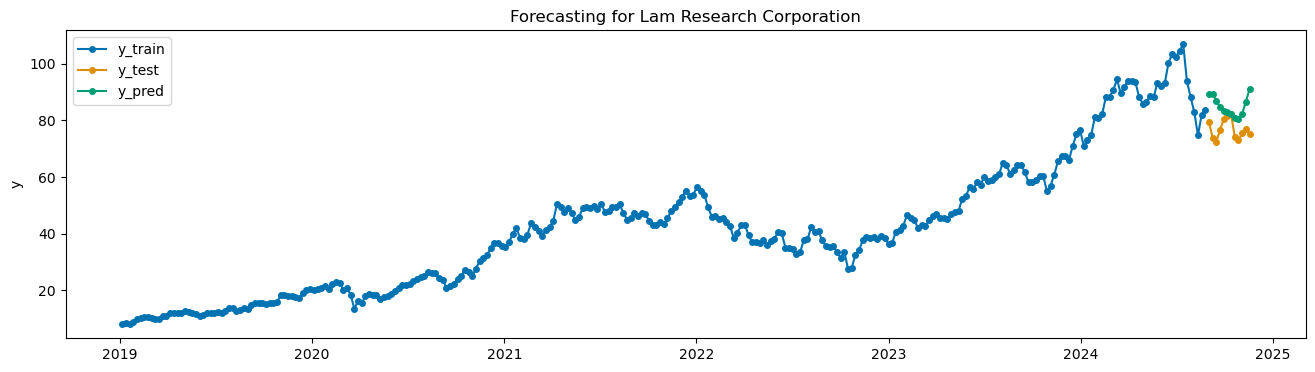

03:38:31 - cmdstanpy - INFO - Chain [1] start processing
03:38:31 - cmdstanpy - INFO - Chain [1] done processing
03:38:31 - cmdstanpy - INFO - Chain [1] start processing
03:38:31 - cmdstanpy - INFO - Chain [1] done processing



Processing company: Tokyo Electron Limited (3/6)...

Total combinations to test for Tokyo Electron Limited: 1600


03:38:31 - cmdstanpy - INFO - Chain [1] start processing
03:38:31 - cmdstanpy - INFO - Chain [1] done processing


03:38:32 - cmdstanpy - INFO - Chain [1] start processing
03:38:32 - cmdstanpy - INFO - Chain [1] done processing
03:38:32 - cmdstanpy - INFO - Chain [1] start processing
03:38:32 - cmdstanpy - INFO - Chain [1] done processing


03:38:32 - cmdstanpy - INFO - Chain [1] start processing
03:38:32 - cmdstanpy - INFO - Chain [1] done processing
03:38:32 - cmdstanpy - INFO - Chain [1] start processing
03:38:32 - cmdstanpy - INFO - Chain [1] done processing


03:38:32 - cmdstanpy - INFO - Chain [1] start processing
03:38:32 - cmdstanpy - INFO - Chain [1] done processing
03:38:32 - cmdstanpy - INFO - Chain [1] start processing
03:38:32 - cmdstanpy - INFO - Chain [1] done processing


03:38:33 - cmdstanpy - INFO - Chain [1] start processing
03:38:33 - cmdstanpy - INFO - Chain [1] done processing
03:38:33 - cmdstanpy - INFO - Chain [1] start processing
03:38:33 - cmdstanpy - INFO - Chain [1] done processing


03:38:33 - cmdstanpy - INFO - Chain [1] start processing
03:38:33 - cmdstanpy - INFO - Chain [1] done processing
03:38:33 - cmdstanpy - INFO - Chain [1] start processing
03:38:33 - cmdstanpy - INFO - Chain [1] done processing


03:38:33 - cmdstanpy - INFO - Chain [1] start processing
03:38:33 - cmdstanpy - INFO - Chain [1] done processing
03:38:33 - cmdstanpy - INFO - Chain [1] start processing
03:38:34 - cmdstanpy - INFO - Chain [1] done processing


03:38:34 - cmdstanpy - INFO - Chain [1] start processing
03:38:34 - cmdstanpy - INFO - Chain [1] done processing
03:38:34 - cmdstanpy - INFO - Chain [1] start processing
03:38:34 - cmdstanpy - INFO - Chain [1] done processing


03:38:34 - cmdstanpy - INFO - Chain [1] start processing
03:38:34 - cmdstanpy - INFO - Chain [1] done processing
03:38:34 - cmdstanpy - INFO - Chain [1] start processing
03:38:34 - cmdstanpy - INFO - Chain [1] done processing


03:38:34 - cmdstanpy - INFO - Chain [1] start processing
03:38:34 - cmdstanpy - INFO - Chain [1] done processing
03:38:35 - cmdstanpy - INFO - Chain [1] start processing
03:38:35 - cmdstanpy - INFO - Chain [1] done processing


03:38:35 - cmdstanpy - INFO - Chain [1] start processing
03:38:35 - cmdstanpy - INFO - Chain [1] done processing
03:38:35 - cmdstanpy - INFO - Chain [1] start processing
03:38:35 - cmdstanpy - INFO - Chain [1] done processing


03:38:35 - cmdstanpy - INFO - Chain [1] start processing
03:38:35 - cmdstanpy - INFO - Chain [1] done processing
03:38:35 - cmdstanpy - INFO - Chain [1] start processing
03:38:35 - cmdstanpy - INFO - Chain [1] done processing


03:38:35 - cmdstanpy - INFO - Chain [1] start processing
03:38:36 - cmdstanpy - INFO - Chain [1] done processing
03:38:36 - cmdstanpy - INFO - Chain [1] start processing
03:38:36 - cmdstanpy - INFO - Chain [1] done processing


03:38:36 - cmdstanpy - INFO - Chain [1] start processing
03:38:36 - cmdstanpy - INFO - Chain [1] done processing
03:38:36 - cmdstanpy - INFO - Chain [1] start processing
03:38:36 - cmdstanpy - INFO - Chain [1] done processing


03:38:36 - cmdstanpy - INFO - Chain [1] start processing
03:38:36 - cmdstanpy - INFO - Chain [1] done processing
03:38:36 - cmdstanpy - INFO - Chain [1] start processing
03:38:36 - cmdstanpy - INFO - Chain [1] done processing


03:38:37 - cmdstanpy - INFO - Chain [1] start processing
03:38:37 - cmdstanpy - INFO - Chain [1] done processing
03:38:37 - cmdstanpy - INFO - Chain [1] start processing
03:38:37 - cmdstanpy - INFO - Chain [1] done processing


03:38:37 - cmdstanpy - INFO - Chain [1] start processing
03:38:37 - cmdstanpy - INFO - Chain [1] done processing
03:38:37 - cmdstanpy - INFO - Chain [1] start processing
03:38:37 - cmdstanpy - INFO - Chain [1] done processing


03:38:37 - cmdstanpy - INFO - Chain [1] start processing
03:38:37 - cmdstanpy - INFO - Chain [1] done processing
03:38:37 - cmdstanpy - INFO - Chain [1] start processing
03:38:37 - cmdstanpy - INFO - Chain [1] done processing


03:38:38 - cmdstanpy - INFO - Chain [1] start processing
03:38:38 - cmdstanpy - INFO - Chain [1] done processing
03:38:38 - cmdstanpy - INFO - Chain [1] start processing
03:38:38 - cmdstanpy - INFO - Chain [1] done processing


03:38:38 - cmdstanpy - INFO - Chain [1] start processing
03:38:38 - cmdstanpy - INFO - Chain [1] done processing
03:38:38 - cmdstanpy - INFO - Chain [1] start processing
03:38:38 - cmdstanpy - INFO - Chain [1] done processing


03:38:38 - cmdstanpy - INFO - Chain [1] start processing
03:38:38 - cmdstanpy - INFO - Chain [1] done processing
03:38:39 - cmdstanpy - INFO - Chain [1] start processing
03:38:39 - cmdstanpy - INFO - Chain [1] done processing


03:38:39 - cmdstanpy - INFO - Chain [1] start processing
03:38:39 - cmdstanpy - INFO - Chain [1] done processing
03:38:39 - cmdstanpy - INFO - Chain [1] start processing
03:38:39 - cmdstanpy - INFO - Chain [1] done processing


03:38:39 - cmdstanpy - INFO - Chain [1] start processing
03:38:39 - cmdstanpy - INFO - Chain [1] done processing
03:38:39 - cmdstanpy - INFO - Chain [1] start processing
03:38:39 - cmdstanpy - INFO - Chain [1] done processing


03:38:39 - cmdstanpy - INFO - Chain [1] start processing
03:38:39 - cmdstanpy - INFO - Chain [1] done processing
03:38:40 - cmdstanpy - INFO - Chain [1] start processing
03:38:40 - cmdstanpy - INFO - Chain [1] done processing


03:38:40 - cmdstanpy - INFO - Chain [1] start processing
03:38:40 - cmdstanpy - INFO - Chain [1] done processing
03:38:40 - cmdstanpy - INFO - Chain [1] start processing
03:38:40 - cmdstanpy - INFO - Chain [1] done processing


03:38:40 - cmdstanpy - INFO - Chain [1] start processing
03:38:40 - cmdstanpy - INFO - Chain [1] done processing
03:38:40 - cmdstanpy - INFO - Chain [1] start processing
03:38:40 - cmdstanpy - INFO - Chain [1] done processing


03:38:40 - cmdstanpy - INFO - Chain [1] start processing
03:38:41 - cmdstanpy - INFO - Chain [1] done processing
03:38:41 - cmdstanpy - INFO - Chain [1] start processing
03:38:41 - cmdstanpy - INFO - Chain [1] done processing


03:38:41 - cmdstanpy - INFO - Chain [1] start processing
03:38:41 - cmdstanpy - INFO - Chain [1] done processing
03:38:41 - cmdstanpy - INFO - Chain [1] start processing
03:38:41 - cmdstanpy - INFO - Chain [1] done processing


03:38:41 - cmdstanpy - INFO - Chain [1] start processing
03:38:41 - cmdstanpy - INFO - Chain [1] done processing
03:38:41 - cmdstanpy - INFO - Chain [1] start processing
03:38:41 - cmdstanpy - INFO - Chain [1] done processing


03:38:42 - cmdstanpy - INFO - Chain [1] start processing
03:38:42 - cmdstanpy - INFO - Chain [1] done processing
03:38:42 - cmdstanpy - INFO - Chain [1] start processing
03:38:42 - cmdstanpy - INFO - Chain [1] done processing


03:38:42 - cmdstanpy - INFO - Chain [1] start processing
03:38:42 - cmdstanpy - INFO - Chain [1] done processing
03:38:42 - cmdstanpy - INFO - Chain [1] start processing
03:38:42 - cmdstanpy - INFO - Chain [1] done processing


03:38:42 - cmdstanpy - INFO - Chain [1] start processing
03:38:42 - cmdstanpy - INFO - Chain [1] done processing
03:38:42 - cmdstanpy - INFO - Chain [1] start processing
03:38:42 - cmdstanpy - INFO - Chain [1] done processing


03:38:43 - cmdstanpy - INFO - Chain [1] start processing
03:38:43 - cmdstanpy - INFO - Chain [1] done processing
03:38:43 - cmdstanpy - INFO - Chain [1] start processing
03:38:43 - cmdstanpy - INFO - Chain [1] done processing


03:38:43 - cmdstanpy - INFO - Chain [1] start processing
03:38:43 - cmdstanpy - INFO - Chain [1] done processing
03:38:43 - cmdstanpy - INFO - Chain [1] start processing
03:38:43 - cmdstanpy - INFO - Chain [1] done processing


03:38:43 - cmdstanpy - INFO - Chain [1] start processing
03:38:43 - cmdstanpy - INFO - Chain [1] done processing
03:38:44 - cmdstanpy - INFO - Chain [1] start processing
03:38:44 - cmdstanpy - INFO - Chain [1] done processing


03:38:44 - cmdstanpy - INFO - Chain [1] start processing
03:38:44 - cmdstanpy - INFO - Chain [1] done processing
03:38:44 - cmdstanpy - INFO - Chain [1] start processing
03:38:44 - cmdstanpy - INFO - Chain [1] done processing


03:38:44 - cmdstanpy - INFO - Chain [1] start processing
03:38:44 - cmdstanpy - INFO - Chain [1] done processing
03:38:44 - cmdstanpy - INFO - Chain [1] start processing
03:38:44 - cmdstanpy - INFO - Chain [1] done processing


03:38:44 - cmdstanpy - INFO - Chain [1] start processing
03:38:44 - cmdstanpy - INFO - Chain [1] done processing
03:38:45 - cmdstanpy - INFO - Chain [1] start processing
03:38:45 - cmdstanpy - INFO - Chain [1] done processing


03:38:45 - cmdstanpy - INFO - Chain [1] start processing
03:38:45 - cmdstanpy - INFO - Chain [1] done processing
03:38:45 - cmdstanpy - INFO - Chain [1] start processing
03:38:45 - cmdstanpy - INFO - Chain [1] done processing


03:38:45 - cmdstanpy - INFO - Chain [1] start processing
03:38:45 - cmdstanpy - INFO - Chain [1] done processing
03:38:45 - cmdstanpy - INFO - Chain [1] start processing
03:38:45 - cmdstanpy - INFO - Chain [1] done processing


03:38:45 - cmdstanpy - INFO - Chain [1] start processing
03:38:45 - cmdstanpy - INFO - Chain [1] done processing
03:38:46 - cmdstanpy - INFO - Chain [1] start processing
03:38:46 - cmdstanpy - INFO - Chain [1] done processing


03:38:46 - cmdstanpy - INFO - Chain [1] start processing
03:38:46 - cmdstanpy - INFO - Chain [1] done processing
03:38:46 - cmdstanpy - INFO - Chain [1] start processing
03:38:46 - cmdstanpy - INFO - Chain [1] done processing


03:38:46 - cmdstanpy - INFO - Chain [1] start processing
03:38:46 - cmdstanpy - INFO - Chain [1] done processing
03:38:46 - cmdstanpy - INFO - Chain [1] start processing
03:38:46 - cmdstanpy - INFO - Chain [1] done processing


03:38:47 - cmdstanpy - INFO - Chain [1] start processing
03:38:47 - cmdstanpy - INFO - Chain [1] done processing
03:38:47 - cmdstanpy - INFO - Chain [1] start processing
03:38:47 - cmdstanpy - INFO - Chain [1] done processing


03:38:47 - cmdstanpy - INFO - Chain [1] start processing
03:38:47 - cmdstanpy - INFO - Chain [1] done processing
03:38:47 - cmdstanpy - INFO - Chain [1] start processing
03:38:47 - cmdstanpy - INFO - Chain [1] done processing


03:38:47 - cmdstanpy - INFO - Chain [1] start processing
03:38:47 - cmdstanpy - INFO - Chain [1] done processing
03:38:47 - cmdstanpy - INFO - Chain [1] start processing
03:38:47 - cmdstanpy - INFO - Chain [1] done processing


03:38:48 - cmdstanpy - INFO - Chain [1] start processing
03:38:48 - cmdstanpy - INFO - Chain [1] done processing
03:38:48 - cmdstanpy - INFO - Chain [1] start processing
03:38:48 - cmdstanpy - INFO - Chain [1] done processing


03:38:48 - cmdstanpy - INFO - Chain [1] start processing
03:38:48 - cmdstanpy - INFO - Chain [1] done processing
03:38:48 - cmdstanpy - INFO - Chain [1] start processing
03:38:48 - cmdstanpy - INFO - Chain [1] done processing


03:38:48 - cmdstanpy - INFO - Chain [1] start processing
03:38:48 - cmdstanpy - INFO - Chain [1] done processing
03:38:49 - cmdstanpy - INFO - Chain [1] start processing
03:38:49 - cmdstanpy - INFO - Chain [1] done processing


03:38:49 - cmdstanpy - INFO - Chain [1] start processing
03:38:49 - cmdstanpy - INFO - Chain [1] done processing
03:38:49 - cmdstanpy - INFO - Chain [1] start processing
03:38:49 - cmdstanpy - INFO - Chain [1] done processing


03:38:49 - cmdstanpy - INFO - Chain [1] start processing
03:38:49 - cmdstanpy - INFO - Chain [1] done processing
03:38:49 - cmdstanpy - INFO - Chain [1] start processing
03:38:49 - cmdstanpy - INFO - Chain [1] done processing


03:38:49 - cmdstanpy - INFO - Chain [1] start processing
03:38:49 - cmdstanpy - INFO - Chain [1] done processing
03:38:50 - cmdstanpy - INFO - Chain [1] start processing
03:38:50 - cmdstanpy - INFO - Chain [1] done processing


03:38:50 - cmdstanpy - INFO - Chain [1] start processing
03:38:50 - cmdstanpy - INFO - Chain [1] done processing
03:38:50 - cmdstanpy - INFO - Chain [1] start processing
03:38:50 - cmdstanpy - INFO - Chain [1] done processing


03:38:50 - cmdstanpy - INFO - Chain [1] start processing
03:38:50 - cmdstanpy - INFO - Chain [1] done processing
03:38:50 - cmdstanpy - INFO - Chain [1] start processing
03:38:50 - cmdstanpy - INFO - Chain [1] done processing


03:38:50 - cmdstanpy - INFO - Chain [1] start processing
03:38:51 - cmdstanpy - INFO - Chain [1] done processing
03:38:51 - cmdstanpy - INFO - Chain [1] start processing
03:38:51 - cmdstanpy - INFO - Chain [1] done processing


03:38:51 - cmdstanpy - INFO - Chain [1] start processing
03:38:51 - cmdstanpy - INFO - Chain [1] done processing
03:38:51 - cmdstanpy - INFO - Chain [1] start processing
03:38:51 - cmdstanpy - INFO - Chain [1] done processing


03:38:51 - cmdstanpy - INFO - Chain [1] start processing
03:38:51 - cmdstanpy - INFO - Chain [1] done processing
03:38:51 - cmdstanpy - INFO - Chain [1] start processing
03:38:51 - cmdstanpy - INFO - Chain [1] done processing


03:38:52 - cmdstanpy - INFO - Chain [1] start processing
03:38:52 - cmdstanpy - INFO - Chain [1] done processing
03:38:52 - cmdstanpy - INFO - Chain [1] start processing
03:38:52 - cmdstanpy - INFO - Chain [1] done processing


03:38:52 - cmdstanpy - INFO - Chain [1] start processing
03:38:52 - cmdstanpy - INFO - Chain [1] done processing
03:38:52 - cmdstanpy - INFO - Chain [1] start processing
03:38:52 - cmdstanpy - INFO - Chain [1] done processing


03:38:52 - cmdstanpy - INFO - Chain [1] start processing
03:38:52 - cmdstanpy - INFO - Chain [1] done processing
03:38:52 - cmdstanpy - INFO - Chain [1] start processing
03:38:52 - cmdstanpy - INFO - Chain [1] done processing


03:38:53 - cmdstanpy - INFO - Chain [1] start processing
03:38:53 - cmdstanpy - INFO - Chain [1] done processing
03:38:53 - cmdstanpy - INFO - Chain [1] start processing
03:38:53 - cmdstanpy - INFO - Chain [1] done processing


03:38:53 - cmdstanpy - INFO - Chain [1] start processing
03:38:53 - cmdstanpy - INFO - Chain [1] done processing
03:38:53 - cmdstanpy - INFO - Chain [1] start processing
03:38:53 - cmdstanpy - INFO - Chain [1] done processing


03:38:53 - cmdstanpy - INFO - Chain [1] start processing
03:38:53 - cmdstanpy - INFO - Chain [1] done processing
03:38:54 - cmdstanpy - INFO - Chain [1] start processing
03:38:54 - cmdstanpy - INFO - Chain [1] done processing


03:38:54 - cmdstanpy - INFO - Chain [1] start processing
03:38:54 - cmdstanpy - INFO - Chain [1] done processing
03:38:54 - cmdstanpy - INFO - Chain [1] start processing
03:38:54 - cmdstanpy - INFO - Chain [1] done processing


03:38:54 - cmdstanpy - INFO - Chain [1] start processing
03:38:54 - cmdstanpy - INFO - Chain [1] done processing
03:38:54 - cmdstanpy - INFO - Chain [1] start processing
03:38:54 - cmdstanpy - INFO - Chain [1] done processing


03:38:54 - cmdstanpy - INFO - Chain [1] start processing
03:38:54 - cmdstanpy - INFO - Chain [1] done processing
03:38:55 - cmdstanpy - INFO - Chain [1] start processing
03:38:55 - cmdstanpy - INFO - Chain [1] done processing


03:38:55 - cmdstanpy - INFO - Chain [1] start processing
03:38:55 - cmdstanpy - INFO - Chain [1] done processing
03:38:55 - cmdstanpy - INFO - Chain [1] start processing
03:38:55 - cmdstanpy - INFO - Chain [1] done processing


03:38:55 - cmdstanpy - INFO - Chain [1] start processing
03:38:55 - cmdstanpy - INFO - Chain [1] done processing
03:38:55 - cmdstanpy - INFO - Chain [1] start processing
03:38:55 - cmdstanpy - INFO - Chain [1] done processing


03:38:55 - cmdstanpy - INFO - Chain [1] start processing
03:38:56 - cmdstanpy - INFO - Chain [1] done processing
03:38:56 - cmdstanpy - INFO - Chain [1] start processing
03:38:56 - cmdstanpy - INFO - Chain [1] done processing


03:38:56 - cmdstanpy - INFO - Chain [1] start processing
03:38:56 - cmdstanpy - INFO - Chain [1] done processing
03:38:56 - cmdstanpy - INFO - Chain [1] start processing
03:38:56 - cmdstanpy - INFO - Chain [1] done processing


03:38:56 - cmdstanpy - INFO - Chain [1] start processing
03:38:56 - cmdstanpy - INFO - Chain [1] done processing
03:38:56 - cmdstanpy - INFO - Chain [1] start processing
03:38:56 - cmdstanpy - INFO - Chain [1] done processing


03:38:57 - cmdstanpy - INFO - Chain [1] start processing
03:38:57 - cmdstanpy - INFO - Chain [1] done processing
03:38:57 - cmdstanpy - INFO - Chain [1] start processing
03:38:57 - cmdstanpy - INFO - Chain [1] done processing


03:38:57 - cmdstanpy - INFO - Chain [1] start processing
03:38:57 - cmdstanpy - INFO - Chain [1] done processing
03:38:57 - cmdstanpy - INFO - Chain [1] start processing
03:38:57 - cmdstanpy - INFO - Chain [1] done processing


03:38:57 - cmdstanpy - INFO - Chain [1] start processing
03:38:57 - cmdstanpy - INFO - Chain [1] done processing
03:38:57 - cmdstanpy - INFO - Chain [1] start processing
03:38:58 - cmdstanpy - INFO - Chain [1] done processing


03:38:58 - cmdstanpy - INFO - Chain [1] start processing
03:38:58 - cmdstanpy - INFO - Chain [1] done processing
03:38:58 - cmdstanpy - INFO - Chain [1] start processing
03:38:58 - cmdstanpy - INFO - Chain [1] done processing


03:38:58 - cmdstanpy - INFO - Chain [1] start processing
03:38:58 - cmdstanpy - INFO - Chain [1] done processing
03:38:58 - cmdstanpy - INFO - Chain [1] start processing
03:38:58 - cmdstanpy - INFO - Chain [1] done processing


03:38:58 - cmdstanpy - INFO - Chain [1] start processing
03:38:58 - cmdstanpy - INFO - Chain [1] done processing
03:38:59 - cmdstanpy - INFO - Chain [1] start processing
03:38:59 - cmdstanpy - INFO - Chain [1] done processing


03:38:59 - cmdstanpy - INFO - Chain [1] start processing
03:38:59 - cmdstanpy - INFO - Chain [1] done processing
03:38:59 - cmdstanpy - INFO - Chain [1] start processing
03:38:59 - cmdstanpy - INFO - Chain [1] done processing


03:38:59 - cmdstanpy - INFO - Chain [1] start processing
03:38:59 - cmdstanpy - INFO - Chain [1] done processing
03:38:59 - cmdstanpy - INFO - Chain [1] start processing
03:38:59 - cmdstanpy - INFO - Chain [1] done processing


03:38:59 - cmdstanpy - INFO - Chain [1] start processing
03:39:00 - cmdstanpy - INFO - Chain [1] done processing
03:39:00 - cmdstanpy - INFO - Chain [1] start processing
03:39:00 - cmdstanpy - INFO - Chain [1] done processing


03:39:00 - cmdstanpy - INFO - Chain [1] start processing
03:39:00 - cmdstanpy - INFO - Chain [1] done processing
03:39:00 - cmdstanpy - INFO - Chain [1] start processing
03:39:00 - cmdstanpy - INFO - Chain [1] done processing


03:39:00 - cmdstanpy - INFO - Chain [1] start processing
03:39:00 - cmdstanpy - INFO - Chain [1] done processing
03:39:00 - cmdstanpy - INFO - Chain [1] start processing
03:39:00 - cmdstanpy - INFO - Chain [1] done processing


03:39:01 - cmdstanpy - INFO - Chain [1] start processing
03:39:01 - cmdstanpy - INFO - Chain [1] done processing
03:39:01 - cmdstanpy - INFO - Chain [1] start processing
03:39:01 - cmdstanpy - INFO - Chain [1] done processing


03:39:01 - cmdstanpy - INFO - Chain [1] start processing
03:39:01 - cmdstanpy - INFO - Chain [1] done processing
03:39:01 - cmdstanpy - INFO - Chain [1] start processing
03:39:01 - cmdstanpy - INFO - Chain [1] done processing


03:39:01 - cmdstanpy - INFO - Chain [1] start processing
03:39:01 - cmdstanpy - INFO - Chain [1] done processing
03:39:01 - cmdstanpy - INFO - Chain [1] start processing
03:39:01 - cmdstanpy - INFO - Chain [1] done processing


03:39:02 - cmdstanpy - INFO - Chain [1] start processing
03:39:02 - cmdstanpy - INFO - Chain [1] done processing
03:39:02 - cmdstanpy - INFO - Chain [1] start processing
03:39:02 - cmdstanpy - INFO - Chain [1] done processing


03:39:02 - cmdstanpy - INFO - Chain [1] start processing
03:39:02 - cmdstanpy - INFO - Chain [1] done processing
03:39:02 - cmdstanpy - INFO - Chain [1] start processing
03:39:02 - cmdstanpy - INFO - Chain [1] done processing


03:39:02 - cmdstanpy - INFO - Chain [1] start processing
03:39:02 - cmdstanpy - INFO - Chain [1] done processing
03:39:03 - cmdstanpy - INFO - Chain [1] start processing
03:39:03 - cmdstanpy - INFO - Chain [1] done processing


03:39:03 - cmdstanpy - INFO - Chain [1] start processing
03:39:03 - cmdstanpy - INFO - Chain [1] done processing
03:39:03 - cmdstanpy - INFO - Chain [1] start processing
03:39:03 - cmdstanpy - INFO - Chain [1] done processing


03:39:03 - cmdstanpy - INFO - Chain [1] start processing
03:39:03 - cmdstanpy - INFO - Chain [1] done processing
03:39:03 - cmdstanpy - INFO - Chain [1] start processing
03:39:03 - cmdstanpy - INFO - Chain [1] done processing


03:39:03 - cmdstanpy - INFO - Chain [1] start processing
03:39:03 - cmdstanpy - INFO - Chain [1] done processing
03:39:04 - cmdstanpy - INFO - Chain [1] start processing
03:39:04 - cmdstanpy - INFO - Chain [1] done processing


03:39:04 - cmdstanpy - INFO - Chain [1] start processing
03:39:04 - cmdstanpy - INFO - Chain [1] done processing
03:39:04 - cmdstanpy - INFO - Chain [1] start processing
03:39:04 - cmdstanpy - INFO - Chain [1] done processing


03:39:04 - cmdstanpy - INFO - Chain [1] start processing
03:39:04 - cmdstanpy - INFO - Chain [1] done processing
03:39:04 - cmdstanpy - INFO - Chain [1] start processing
03:39:04 - cmdstanpy - INFO - Chain [1] done processing


03:39:04 - cmdstanpy - INFO - Chain [1] start processing
03:39:05 - cmdstanpy - INFO - Chain [1] done processing
03:39:05 - cmdstanpy - INFO - Chain [1] start processing
03:39:05 - cmdstanpy - INFO - Chain [1] done processing


03:39:05 - cmdstanpy - INFO - Chain [1] start processing
03:39:05 - cmdstanpy - INFO - Chain [1] done processing
03:39:05 - cmdstanpy - INFO - Chain [1] start processing
03:39:05 - cmdstanpy - INFO - Chain [1] done processing


03:39:05 - cmdstanpy - INFO - Chain [1] start processing
03:39:05 - cmdstanpy - INFO - Chain [1] done processing
03:39:05 - cmdstanpy - INFO - Chain [1] start processing
03:39:05 - cmdstanpy - INFO - Chain [1] done processing


03:39:06 - cmdstanpy - INFO - Chain [1] start processing
03:39:06 - cmdstanpy - INFO - Chain [1] done processing
03:39:06 - cmdstanpy - INFO - Chain [1] start processing
03:39:06 - cmdstanpy - INFO - Chain [1] done processing


03:39:06 - cmdstanpy - INFO - Chain [1] start processing
03:39:06 - cmdstanpy - INFO - Chain [1] done processing
03:39:06 - cmdstanpy - INFO - Chain [1] start processing
03:39:06 - cmdstanpy - INFO - Chain [1] done processing


03:39:06 - cmdstanpy - INFO - Chain [1] start processing
03:39:06 - cmdstanpy - INFO - Chain [1] done processing
03:39:06 - cmdstanpy - INFO - Chain [1] start processing
03:39:06 - cmdstanpy - INFO - Chain [1] done processing


03:39:07 - cmdstanpy - INFO - Chain [1] start processing
03:39:07 - cmdstanpy - INFO - Chain [1] done processing
03:39:07 - cmdstanpy - INFO - Chain [1] start processing
03:39:07 - cmdstanpy - INFO - Chain [1] done processing


03:39:07 - cmdstanpy - INFO - Chain [1] start processing
03:39:07 - cmdstanpy - INFO - Chain [1] done processing
03:39:07 - cmdstanpy - INFO - Chain [1] start processing
03:39:07 - cmdstanpy - INFO - Chain [1] done processing


03:39:08 - cmdstanpy - INFO - Chain [1] start processing
03:39:08 - cmdstanpy - INFO - Chain [1] done processing


03:39:08 - cmdstanpy - INFO - Chain [1] start processing
03:39:08 - cmdstanpy - INFO - Chain [1] done processing
03:39:08 - cmdstanpy - INFO - Chain [1] start processing
03:39:08 - cmdstanpy - INFO - Chain [1] done processing


03:39:08 - cmdstanpy - INFO - Chain [1] start processing
03:39:08 - cmdstanpy - INFO - Chain [1] done processing
03:39:08 - cmdstanpy - INFO - Chain [1] start processing
03:39:08 - cmdstanpy - INFO - Chain [1] done processing


03:39:08 - cmdstanpy - INFO - Chain [1] start processing
03:39:08 - cmdstanpy - INFO - Chain [1] done processing
03:39:09 - cmdstanpy - INFO - Chain [1] start processing
03:39:09 - cmdstanpy - INFO - Chain [1] done processing


03:39:09 - cmdstanpy - INFO - Chain [1] start processing
03:39:09 - cmdstanpy - INFO - Chain [1] done processing
03:39:09 - cmdstanpy - INFO - Chain [1] start processing
03:39:09 - cmdstanpy - INFO - Chain [1] done processing


03:39:09 - cmdstanpy - INFO - Chain [1] start processing
03:39:09 - cmdstanpy - INFO - Chain [1] done processing
03:39:09 - cmdstanpy - INFO - Chain [1] start processing
03:39:09 - cmdstanpy - INFO - Chain [1] done processing


03:39:09 - cmdstanpy - INFO - Chain [1] start processing
03:39:09 - cmdstanpy - INFO - Chain [1] done processing
03:39:10 - cmdstanpy - INFO - Chain [1] start processing
03:39:10 - cmdstanpy - INFO - Chain [1] done processing


03:39:10 - cmdstanpy - INFO - Chain [1] start processing
03:39:10 - cmdstanpy - INFO - Chain [1] done processing
03:39:10 - cmdstanpy - INFO - Chain [1] start processing
03:39:10 - cmdstanpy - INFO - Chain [1] done processing


03:39:10 - cmdstanpy - INFO - Chain [1] start processing
03:39:10 - cmdstanpy - INFO - Chain [1] done processing
03:39:10 - cmdstanpy - INFO - Chain [1] start processing
03:39:10 - cmdstanpy - INFO - Chain [1] done processing


03:39:11 - cmdstanpy - INFO - Chain [1] start processing
03:39:11 - cmdstanpy - INFO - Chain [1] done processing
03:39:11 - cmdstanpy - INFO - Chain [1] start processing
03:39:11 - cmdstanpy - INFO - Chain [1] done processing


03:39:11 - cmdstanpy - INFO - Chain [1] start processing
03:39:11 - cmdstanpy - INFO - Chain [1] done processing
03:39:11 - cmdstanpy - INFO - Chain [1] start processing
03:39:11 - cmdstanpy - INFO - Chain [1] done processing


03:39:11 - cmdstanpy - INFO - Chain [1] start processing
03:39:11 - cmdstanpy - INFO - Chain [1] done processing
03:39:11 - cmdstanpy - INFO - Chain [1] start processing
03:39:11 - cmdstanpy - INFO - Chain [1] done processing


03:39:12 - cmdstanpy - INFO - Chain [1] start processing
03:39:12 - cmdstanpy - INFO - Chain [1] done processing
03:39:12 - cmdstanpy - INFO - Chain [1] start processing
03:39:12 - cmdstanpy - INFO - Chain [1] done processing


03:39:12 - cmdstanpy - INFO - Chain [1] start processing
03:39:12 - cmdstanpy - INFO - Chain [1] done processing
03:39:12 - cmdstanpy - INFO - Chain [1] start processing
03:39:12 - cmdstanpy - INFO - Chain [1] done processing


03:39:12 - cmdstanpy - INFO - Chain [1] start processing
03:39:12 - cmdstanpy - INFO - Chain [1] done processing
03:39:12 - cmdstanpy - INFO - Chain [1] start processing
03:39:13 - cmdstanpy - INFO - Chain [1] done processing


03:39:13 - cmdstanpy - INFO - Chain [1] start processing
03:39:13 - cmdstanpy - INFO - Chain [1] done processing
03:39:13 - cmdstanpy - INFO - Chain [1] start processing
03:39:13 - cmdstanpy - INFO - Chain [1] done processing


03:39:13 - cmdstanpy - INFO - Chain [1] start processing
03:39:13 - cmdstanpy - INFO - Chain [1] done processing
03:39:13 - cmdstanpy - INFO - Chain [1] start processing
03:39:13 - cmdstanpy - INFO - Chain [1] done processing


03:39:13 - cmdstanpy - INFO - Chain [1] start processing
03:39:13 - cmdstanpy - INFO - Chain [1] done processing
03:39:14 - cmdstanpy - INFO - Chain [1] start processing
03:39:14 - cmdstanpy - INFO - Chain [1] done processing


03:39:14 - cmdstanpy - INFO - Chain [1] start processing
03:39:14 - cmdstanpy - INFO - Chain [1] done processing
03:39:14 - cmdstanpy - INFO - Chain [1] start processing
03:39:14 - cmdstanpy - INFO - Chain [1] done processing


03:39:14 - cmdstanpy - INFO - Chain [1] start processing
03:39:14 - cmdstanpy - INFO - Chain [1] done processing
03:39:14 - cmdstanpy - INFO - Chain [1] start processing
03:39:14 - cmdstanpy - INFO - Chain [1] done processing


03:39:15 - cmdstanpy - INFO - Chain [1] start processing
03:39:15 - cmdstanpy - INFO - Chain [1] done processing
03:39:15 - cmdstanpy - INFO - Chain [1] start processing
03:39:15 - cmdstanpy - INFO - Chain [1] done processing


03:39:15 - cmdstanpy - INFO - Chain [1] start processing
03:39:15 - cmdstanpy - INFO - Chain [1] done processing
03:39:15 - cmdstanpy - INFO - Chain [1] start processing
03:39:15 - cmdstanpy - INFO - Chain [1] done processing


03:39:15 - cmdstanpy - INFO - Chain [1] start processing
03:39:15 - cmdstanpy - INFO - Chain [1] done processing
03:39:15 - cmdstanpy - INFO - Chain [1] start processing
03:39:15 - cmdstanpy - INFO - Chain [1] done processing


03:39:16 - cmdstanpy - INFO - Chain [1] start processing
03:39:16 - cmdstanpy - INFO - Chain [1] done processing
03:39:16 - cmdstanpy - INFO - Chain [1] start processing
03:39:16 - cmdstanpy - INFO - Chain [1] done processing


03:39:16 - cmdstanpy - INFO - Chain [1] start processing
03:39:16 - cmdstanpy - INFO - Chain [1] done processing
03:39:16 - cmdstanpy - INFO - Chain [1] start processing
03:39:16 - cmdstanpy - INFO - Chain [1] done processing


03:39:16 - cmdstanpy - INFO - Chain [1] start processing
03:39:16 - cmdstanpy - INFO - Chain [1] done processing
03:39:17 - cmdstanpy - INFO - Chain [1] start processing
03:39:17 - cmdstanpy - INFO - Chain [1] done processing


03:39:17 - cmdstanpy - INFO - Chain [1] start processing
03:39:17 - cmdstanpy - INFO - Chain [1] done processing
03:39:17 - cmdstanpy - INFO - Chain [1] start processing
03:39:17 - cmdstanpy - INFO - Chain [1] done processing


03:39:17 - cmdstanpy - INFO - Chain [1] start processing
03:39:17 - cmdstanpy - INFO - Chain [1] done processing
03:39:17 - cmdstanpy - INFO - Chain [1] start processing
03:39:17 - cmdstanpy - INFO - Chain [1] done processing


03:39:17 - cmdstanpy - INFO - Chain [1] start processing
03:39:17 - cmdstanpy - INFO - Chain [1] done processing
03:39:18 - cmdstanpy - INFO - Chain [1] start processing
03:39:18 - cmdstanpy - INFO - Chain [1] done processing


03:39:18 - cmdstanpy - INFO - Chain [1] start processing
03:39:18 - cmdstanpy - INFO - Chain [1] done processing
03:39:18 - cmdstanpy - INFO - Chain [1] start processing
03:39:18 - cmdstanpy - INFO - Chain [1] done processing


03:39:18 - cmdstanpy - INFO - Chain [1] start processing
03:39:18 - cmdstanpy - INFO - Chain [1] done processing
03:39:18 - cmdstanpy - INFO - Chain [1] start processing
03:39:18 - cmdstanpy - INFO - Chain [1] done processing


03:39:18 - cmdstanpy - INFO - Chain [1] start processing
03:39:18 - cmdstanpy - INFO - Chain [1] done processing
03:39:19 - cmdstanpy - INFO - Chain [1] start processing
03:39:19 - cmdstanpy - INFO - Chain [1] done processing


03:39:19 - cmdstanpy - INFO - Chain [1] start processing
03:39:19 - cmdstanpy - INFO - Chain [1] done processing


03:39:19 - cmdstanpy - INFO - Chain [1] start processing
03:39:19 - cmdstanpy - INFO - Chain [1] done processing
03:39:19 - cmdstanpy - INFO - Chain [1] start processing
03:39:19 - cmdstanpy - INFO - Chain [1] done processing


03:39:19 - cmdstanpy - INFO - Chain [1] start processing
03:39:19 - cmdstanpy - INFO - Chain [1] done processing
03:39:20 - cmdstanpy - INFO - Chain [1] start processing
03:39:20 - cmdstanpy - INFO - Chain [1] done processing


03:39:20 - cmdstanpy - INFO - Chain [1] start processing
03:39:20 - cmdstanpy - INFO - Chain [1] done processing
03:39:20 - cmdstanpy - INFO - Chain [1] start processing
03:39:20 - cmdstanpy - INFO - Chain [1] done processing


03:39:20 - cmdstanpy - INFO - Chain [1] start processing
03:39:20 - cmdstanpy - INFO - Chain [1] done processing
03:39:20 - cmdstanpy - INFO - Chain [1] start processing
03:39:20 - cmdstanpy - INFO - Chain [1] done processing


03:39:20 - cmdstanpy - INFO - Chain [1] start processing
03:39:20 - cmdstanpy - INFO - Chain [1] done processing
03:39:21 - cmdstanpy - INFO - Chain [1] start processing
03:39:21 - cmdstanpy - INFO - Chain [1] done processing


03:39:21 - cmdstanpy - INFO - Chain [1] start processing
03:39:21 - cmdstanpy - INFO - Chain [1] done processing
03:39:21 - cmdstanpy - INFO - Chain [1] start processing
03:39:21 - cmdstanpy - INFO - Chain [1] done processing


03:39:21 - cmdstanpy - INFO - Chain [1] start processing
03:39:21 - cmdstanpy - INFO - Chain [1] done processing
03:39:21 - cmdstanpy - INFO - Chain [1] start processing
03:39:21 - cmdstanpy - INFO - Chain [1] done processing


03:39:22 - cmdstanpy - INFO - Chain [1] start processing
03:39:22 - cmdstanpy - INFO - Chain [1] done processing
03:39:22 - cmdstanpy - INFO - Chain [1] start processing
03:39:22 - cmdstanpy - INFO - Chain [1] done processing


03:39:22 - cmdstanpy - INFO - Chain [1] start processing
03:39:22 - cmdstanpy - INFO - Chain [1] done processing


03:39:22 - cmdstanpy - INFO - Chain [1] start processing
03:39:22 - cmdstanpy - INFO - Chain [1] done processing
03:39:22 - cmdstanpy - INFO - Chain [1] start processing
03:39:22 - cmdstanpy - INFO - Chain [1] done processing


03:39:23 - cmdstanpy - INFO - Chain [1] start processing
03:39:23 - cmdstanpy - INFO - Chain [1] done processing
03:39:23 - cmdstanpy - INFO - Chain [1] start processing
03:39:23 - cmdstanpy - INFO - Chain [1] done processing


03:39:23 - cmdstanpy - INFO - Chain [1] start processing
03:39:23 - cmdstanpy - INFO - Chain [1] done processing
03:39:23 - cmdstanpy - INFO - Chain [1] start processing
03:39:23 - cmdstanpy - INFO - Chain [1] done processing


03:39:23 - cmdstanpy - INFO - Chain [1] start processing
03:39:23 - cmdstanpy - INFO - Chain [1] done processing
03:39:24 - cmdstanpy - INFO - Chain [1] start processing
03:39:24 - cmdstanpy - INFO - Chain [1] done processing


03:39:24 - cmdstanpy - INFO - Chain [1] start processing
03:39:24 - cmdstanpy - INFO - Chain [1] done processing
03:39:24 - cmdstanpy - INFO - Chain [1] start processing
03:39:24 - cmdstanpy - INFO - Chain [1] done processing


03:39:24 - cmdstanpy - INFO - Chain [1] start processing
03:39:24 - cmdstanpy - INFO - Chain [1] done processing
03:39:24 - cmdstanpy - INFO - Chain [1] start processing
03:39:24 - cmdstanpy - INFO - Chain [1] done processing


03:39:24 - cmdstanpy - INFO - Chain [1] start processing
03:39:24 - cmdstanpy - INFO - Chain [1] done processing
03:39:25 - cmdstanpy - INFO - Chain [1] start processing
03:39:25 - cmdstanpy - INFO - Chain [1] done processing


03:39:25 - cmdstanpy - INFO - Chain [1] start processing
03:39:25 - cmdstanpy - INFO - Chain [1] done processing
03:39:25 - cmdstanpy - INFO - Chain [1] start processing
03:39:25 - cmdstanpy - INFO - Chain [1] done processing


03:39:25 - cmdstanpy - INFO - Chain [1] start processing
03:39:25 - cmdstanpy - INFO - Chain [1] done processing
03:39:25 - cmdstanpy - INFO - Chain [1] start processing
03:39:25 - cmdstanpy - INFO - Chain [1] done processing


03:39:26 - cmdstanpy - INFO - Chain [1] start processing
03:39:26 - cmdstanpy - INFO - Chain [1] done processing
03:39:26 - cmdstanpy - INFO - Chain [1] start processing
03:39:26 - cmdstanpy - INFO - Chain [1] done processing


03:39:26 - cmdstanpy - INFO - Chain [1] start processing
03:39:26 - cmdstanpy - INFO - Chain [1] done processing
03:39:26 - cmdstanpy - INFO - Chain [1] start processing
03:39:26 - cmdstanpy - INFO - Chain [1] done processing


03:39:26 - cmdstanpy - INFO - Chain [1] start processing
03:39:26 - cmdstanpy - INFO - Chain [1] done processing
03:39:26 - cmdstanpy - INFO - Chain [1] start processing
03:39:26 - cmdstanpy - INFO - Chain [1] done processing


03:39:27 - cmdstanpy - INFO - Chain [1] start processing
03:39:27 - cmdstanpy - INFO - Chain [1] done processing
03:39:27 - cmdstanpy - INFO - Chain [1] start processing
03:39:27 - cmdstanpy - INFO - Chain [1] done processing


03:39:27 - cmdstanpy - INFO - Chain [1] start processing
03:39:27 - cmdstanpy - INFO - Chain [1] done processing
03:39:27 - cmdstanpy - INFO - Chain [1] start processing
03:39:27 - cmdstanpy - INFO - Chain [1] done processing


03:39:27 - cmdstanpy - INFO - Chain [1] start processing
03:39:27 - cmdstanpy - INFO - Chain [1] done processing
03:39:28 - cmdstanpy - INFO - Chain [1] start processing
03:39:28 - cmdstanpy - INFO - Chain [1] done processing


03:39:28 - cmdstanpy - INFO - Chain [1] start processing
03:39:28 - cmdstanpy - INFO - Chain [1] done processing
03:39:28 - cmdstanpy - INFO - Chain [1] start processing
03:39:28 - cmdstanpy - INFO - Chain [1] done processing


03:39:28 - cmdstanpy - INFO - Chain [1] start processing
03:39:28 - cmdstanpy - INFO - Chain [1] done processing
03:39:28 - cmdstanpy - INFO - Chain [1] start processing
03:39:28 - cmdstanpy - INFO - Chain [1] done processing


03:39:28 - cmdstanpy - INFO - Chain [1] start processing
03:39:28 - cmdstanpy - INFO - Chain [1] done processing
03:39:29 - cmdstanpy - INFO - Chain [1] start processing
03:39:29 - cmdstanpy - INFO - Chain [1] done processing


03:39:29 - cmdstanpy - INFO - Chain [1] start processing
03:39:29 - cmdstanpy - INFO - Chain [1] done processing
03:39:29 - cmdstanpy - INFO - Chain [1] start processing
03:39:29 - cmdstanpy - INFO - Chain [1] done processing


03:39:29 - cmdstanpy - INFO - Chain [1] start processing
03:39:29 - cmdstanpy - INFO - Chain [1] done processing
03:39:29 - cmdstanpy - INFO - Chain [1] start processing
03:39:29 - cmdstanpy - INFO - Chain [1] done processing


03:39:30 - cmdstanpy - INFO - Chain [1] start processing
03:39:30 - cmdstanpy - INFO - Chain [1] done processing
03:39:30 - cmdstanpy - INFO - Chain [1] start processing
03:39:30 - cmdstanpy - INFO - Chain [1] done processing


03:39:30 - cmdstanpy - INFO - Chain [1] start processing
03:39:30 - cmdstanpy - INFO - Chain [1] done processing
03:39:30 - cmdstanpy - INFO - Chain [1] start processing
03:39:30 - cmdstanpy - INFO - Chain [1] done processing


03:39:30 - cmdstanpy - INFO - Chain [1] start processing
03:39:30 - cmdstanpy - INFO - Chain [1] done processing
03:39:30 - cmdstanpy - INFO - Chain [1] start processing
03:39:30 - cmdstanpy - INFO - Chain [1] done processing


03:39:31 - cmdstanpy - INFO - Chain [1] start processing
03:39:31 - cmdstanpy - INFO - Chain [1] done processing
03:39:31 - cmdstanpy - INFO - Chain [1] start processing
03:39:31 - cmdstanpy - INFO - Chain [1] done processing


03:39:31 - cmdstanpy - INFO - Chain [1] start processing
03:39:31 - cmdstanpy - INFO - Chain [1] done processing
03:39:31 - cmdstanpy - INFO - Chain [1] start processing
03:39:31 - cmdstanpy - INFO - Chain [1] done processing


03:39:31 - cmdstanpy - INFO - Chain [1] start processing
03:39:31 - cmdstanpy - INFO - Chain [1] done processing
03:39:31 - cmdstanpy - INFO - Chain [1] start processing
03:39:31 - cmdstanpy - INFO - Chain [1] done processing


03:39:32 - cmdstanpy - INFO - Chain [1] start processing
03:39:32 - cmdstanpy - INFO - Chain [1] done processing
03:39:32 - cmdstanpy - INFO - Chain [1] start processing
03:39:32 - cmdstanpy - INFO - Chain [1] done processing


03:39:32 - cmdstanpy - INFO - Chain [1] start processing
03:39:32 - cmdstanpy - INFO - Chain [1] done processing
03:39:32 - cmdstanpy - INFO - Chain [1] start processing
03:39:32 - cmdstanpy - INFO - Chain [1] done processing


03:39:32 - cmdstanpy - INFO - Chain [1] start processing
03:39:32 - cmdstanpy - INFO - Chain [1] done processing
03:39:33 - cmdstanpy - INFO - Chain [1] start processing
03:39:33 - cmdstanpy - INFO - Chain [1] done processing


03:39:33 - cmdstanpy - INFO - Chain [1] start processing
03:39:33 - cmdstanpy - INFO - Chain [1] done processing
03:39:33 - cmdstanpy - INFO - Chain [1] start processing
03:39:33 - cmdstanpy - INFO - Chain [1] done processing


03:39:33 - cmdstanpy - INFO - Chain [1] start processing
03:39:33 - cmdstanpy - INFO - Chain [1] done processing
03:39:33 - cmdstanpy - INFO - Chain [1] start processing
03:39:33 - cmdstanpy - INFO - Chain [1] done processing


03:39:33 - cmdstanpy - INFO - Chain [1] start processing
03:39:33 - cmdstanpy - INFO - Chain [1] done processing
03:39:34 - cmdstanpy - INFO - Chain [1] start processing
03:39:34 - cmdstanpy - INFO - Chain [1] done processing


03:39:34 - cmdstanpy - INFO - Chain [1] start processing
03:39:34 - cmdstanpy - INFO - Chain [1] done processing
03:39:34 - cmdstanpy - INFO - Chain [1] start processing
03:39:34 - cmdstanpy - INFO - Chain [1] done processing


03:39:34 - cmdstanpy - INFO - Chain [1] start processing
03:39:34 - cmdstanpy - INFO - Chain [1] done processing
03:39:34 - cmdstanpy - INFO - Chain [1] start processing
03:39:34 - cmdstanpy - INFO - Chain [1] done processing


03:39:35 - cmdstanpy - INFO - Chain [1] start processing
03:39:35 - cmdstanpy - INFO - Chain [1] done processing
03:39:35 - cmdstanpy - INFO - Chain [1] start processing
03:39:35 - cmdstanpy - INFO - Chain [1] done processing


03:39:35 - cmdstanpy - INFO - Chain [1] start processing
03:39:35 - cmdstanpy - INFO - Chain [1] done processing
03:39:35 - cmdstanpy - INFO - Chain [1] start processing
03:39:35 - cmdstanpy - INFO - Chain [1] done processing


03:39:35 - cmdstanpy - INFO - Chain [1] start processing
03:39:35 - cmdstanpy - INFO - Chain [1] done processing
03:39:35 - cmdstanpy - INFO - Chain [1] start processing
03:39:35 - cmdstanpy - INFO - Chain [1] done processing


03:39:36 - cmdstanpy - INFO - Chain [1] start processing
03:39:36 - cmdstanpy - INFO - Chain [1] done processing
03:39:36 - cmdstanpy - INFO - Chain [1] start processing
03:39:36 - cmdstanpy - INFO - Chain [1] done processing


03:39:36 - cmdstanpy - INFO - Chain [1] start processing
03:39:36 - cmdstanpy - INFO - Chain [1] done processing
03:39:36 - cmdstanpy - INFO - Chain [1] start processing
03:39:36 - cmdstanpy - INFO - Chain [1] done processing


03:39:36 - cmdstanpy - INFO - Chain [1] start processing
03:39:36 - cmdstanpy - INFO - Chain [1] done processing
03:39:36 - cmdstanpy - INFO - Chain [1] start processing
03:39:36 - cmdstanpy - INFO - Chain [1] done processing


03:39:37 - cmdstanpy - INFO - Chain [1] start processing
03:39:37 - cmdstanpy - INFO - Chain [1] done processing
03:39:37 - cmdstanpy - INFO - Chain [1] start processing
03:39:37 - cmdstanpy - INFO - Chain [1] done processing


03:39:37 - cmdstanpy - INFO - Chain [1] start processing
03:39:37 - cmdstanpy - INFO - Chain [1] done processing
03:39:37 - cmdstanpy - INFO - Chain [1] start processing
03:39:37 - cmdstanpy - INFO - Chain [1] done processing


03:39:37 - cmdstanpy - INFO - Chain [1] start processing
03:39:37 - cmdstanpy - INFO - Chain [1] done processing
03:39:37 - cmdstanpy - INFO - Chain [1] start processing
03:39:38 - cmdstanpy - INFO - Chain [1] done processing


03:39:38 - cmdstanpy - INFO - Chain [1] start processing
03:39:38 - cmdstanpy - INFO - Chain [1] done processing
03:39:38 - cmdstanpy - INFO - Chain [1] start processing
03:39:38 - cmdstanpy - INFO - Chain [1] done processing


03:39:38 - cmdstanpy - INFO - Chain [1] start processing
03:39:38 - cmdstanpy - INFO - Chain [1] done processing
03:39:38 - cmdstanpy - INFO - Chain [1] start processing
03:39:38 - cmdstanpy - INFO - Chain [1] done processing


03:39:38 - cmdstanpy - INFO - Chain [1] start processing
03:39:38 - cmdstanpy - INFO - Chain [1] done processing
03:39:39 - cmdstanpy - INFO - Chain [1] start processing
03:39:39 - cmdstanpy - INFO - Chain [1] done processing


03:39:39 - cmdstanpy - INFO - Chain [1] start processing
03:39:39 - cmdstanpy - INFO - Chain [1] done processing
03:39:39 - cmdstanpy - INFO - Chain [1] start processing
03:39:39 - cmdstanpy - INFO - Chain [1] done processing


03:39:39 - cmdstanpy - INFO - Chain [1] start processing
03:39:39 - cmdstanpy - INFO - Chain [1] done processing
03:39:39 - cmdstanpy - INFO - Chain [1] start processing
03:39:39 - cmdstanpy - INFO - Chain [1] done processing


03:39:39 - cmdstanpy - INFO - Chain [1] start processing
03:39:39 - cmdstanpy - INFO - Chain [1] done processing
03:39:40 - cmdstanpy - INFO - Chain [1] start processing
03:39:40 - cmdstanpy - INFO - Chain [1] done processing


03:39:40 - cmdstanpy - INFO - Chain [1] start processing
03:39:40 - cmdstanpy - INFO - Chain [1] done processing
03:39:40 - cmdstanpy - INFO - Chain [1] start processing
03:39:40 - cmdstanpy - INFO - Chain [1] done processing


03:39:40 - cmdstanpy - INFO - Chain [1] start processing
03:39:40 - cmdstanpy - INFO - Chain [1] done processing
03:39:40 - cmdstanpy - INFO - Chain [1] start processing
03:39:40 - cmdstanpy - INFO - Chain [1] done processing


03:39:41 - cmdstanpy - INFO - Chain [1] start processing
03:39:41 - cmdstanpy - INFO - Chain [1] done processing
03:39:41 - cmdstanpy - INFO - Chain [1] start processing
03:39:41 - cmdstanpy - INFO - Chain [1] done processing


03:39:41 - cmdstanpy - INFO - Chain [1] start processing
03:39:41 - cmdstanpy - INFO - Chain [1] done processing
03:39:41 - cmdstanpy - INFO - Chain [1] start processing
03:39:41 - cmdstanpy - INFO - Chain [1] done processing


03:39:41 - cmdstanpy - INFO - Chain [1] start processing
03:39:41 - cmdstanpy - INFO - Chain [1] done processing
03:39:41 - cmdstanpy - INFO - Chain [1] start processing
03:39:41 - cmdstanpy - INFO - Chain [1] done processing


03:39:42 - cmdstanpy - INFO - Chain [1] start processing
03:39:42 - cmdstanpy - INFO - Chain [1] done processing
03:39:42 - cmdstanpy - INFO - Chain [1] start processing
03:39:42 - cmdstanpy - INFO - Chain [1] done processing


03:39:42 - cmdstanpy - INFO - Chain [1] start processing
03:39:42 - cmdstanpy - INFO - Chain [1] done processing
03:39:42 - cmdstanpy - INFO - Chain [1] start processing
03:39:42 - cmdstanpy - INFO - Chain [1] done processing


03:39:42 - cmdstanpy - INFO - Chain [1] start processing
03:39:42 - cmdstanpy - INFO - Chain [1] done processing
03:39:42 - cmdstanpy - INFO - Chain [1] start processing
03:39:43 - cmdstanpy - INFO - Chain [1] done processing


03:39:43 - cmdstanpy - INFO - Chain [1] start processing
03:39:43 - cmdstanpy - INFO - Chain [1] done processing
03:39:43 - cmdstanpy - INFO - Chain [1] start processing
03:39:43 - cmdstanpy - INFO - Chain [1] done processing


03:39:43 - cmdstanpy - INFO - Chain [1] start processing
03:39:43 - cmdstanpy - INFO - Chain [1] done processing
03:39:43 - cmdstanpy - INFO - Chain [1] start processing
03:39:43 - cmdstanpy - INFO - Chain [1] done processing


03:39:43 - cmdstanpy - INFO - Chain [1] start processing
03:39:43 - cmdstanpy - INFO - Chain [1] done processing
03:39:44 - cmdstanpy - INFO - Chain [1] start processing
03:39:44 - cmdstanpy - INFO - Chain [1] done processing


03:39:44 - cmdstanpy - INFO - Chain [1] start processing
03:39:44 - cmdstanpy - INFO - Chain [1] done processing
03:39:44 - cmdstanpy - INFO - Chain [1] start processing
03:39:44 - cmdstanpy - INFO - Chain [1] done processing


03:39:44 - cmdstanpy - INFO - Chain [1] start processing
03:39:44 - cmdstanpy - INFO - Chain [1] done processing


03:39:44 - cmdstanpy - INFO - Chain [1] start processing
03:39:44 - cmdstanpy - INFO - Chain [1] done processing


03:39:45 - cmdstanpy - INFO - Chain [1] start processing
03:39:45 - cmdstanpy - INFO - Chain [1] done processing
03:39:45 - cmdstanpy - INFO - Chain [1] start processing
03:39:45 - cmdstanpy - INFO - Chain [1] done processing


03:39:45 - cmdstanpy - INFO - Chain [1] start processing
03:39:45 - cmdstanpy - INFO - Chain [1] done processing
03:39:45 - cmdstanpy - INFO - Chain [1] start processing
03:39:45 - cmdstanpy - INFO - Chain [1] done processing


03:39:45 - cmdstanpy - INFO - Chain [1] start processing
03:39:45 - cmdstanpy - INFO - Chain [1] done processing
03:39:46 - cmdstanpy - INFO - Chain [1] start processing
03:39:46 - cmdstanpy - INFO - Chain [1] done processing


03:39:46 - cmdstanpy - INFO - Chain [1] start processing
03:39:46 - cmdstanpy - INFO - Chain [1] done processing
03:39:46 - cmdstanpy - INFO - Chain [1] start processing
03:39:46 - cmdstanpy - INFO - Chain [1] done processing


03:39:46 - cmdstanpy - INFO - Chain [1] start processing
03:39:46 - cmdstanpy - INFO - Chain [1] done processing
03:39:46 - cmdstanpy - INFO - Chain [1] start processing
03:39:46 - cmdstanpy - INFO - Chain [1] done processing


03:39:46 - cmdstanpy - INFO - Chain [1] start processing
03:39:47 - cmdstanpy - INFO - Chain [1] done processing


03:39:47 - cmdstanpy - INFO - Chain [1] start processing
03:39:47 - cmdstanpy - INFO - Chain [1] done processing


03:39:47 - cmdstanpy - INFO - Chain [1] start processing
03:39:47 - cmdstanpy - INFO - Chain [1] done processing
03:39:47 - cmdstanpy - INFO - Chain [1] start processing
03:39:47 - cmdstanpy - INFO - Chain [1] done processing


03:39:47 - cmdstanpy - INFO - Chain [1] start processing
03:39:47 - cmdstanpy - INFO - Chain [1] done processing
03:39:47 - cmdstanpy - INFO - Chain [1] start processing
03:39:47 - cmdstanpy - INFO - Chain [1] done processing


03:39:48 - cmdstanpy - INFO - Chain [1] start processing
03:39:48 - cmdstanpy - INFO - Chain [1] done processing
03:39:48 - cmdstanpy - INFO - Chain [1] start processing
03:39:48 - cmdstanpy - INFO - Chain [1] done processing


03:39:48 - cmdstanpy - INFO - Chain [1] start processing
03:39:48 - cmdstanpy - INFO - Chain [1] done processing


03:39:48 - cmdstanpy - INFO - Chain [1] start processing
03:39:48 - cmdstanpy - INFO - Chain [1] done processing


03:39:49 - cmdstanpy - INFO - Chain [1] start processing
03:39:49 - cmdstanpy - INFO - Chain [1] done processing
03:39:49 - cmdstanpy - INFO - Chain [1] start processing
03:39:49 - cmdstanpy - INFO - Chain [1] done processing


03:39:49 - cmdstanpy - INFO - Chain [1] start processing
03:39:49 - cmdstanpy - INFO - Chain [1] done processing


03:39:49 - cmdstanpy - INFO - Chain [1] start processing
03:39:49 - cmdstanpy - INFO - Chain [1] done processing


03:39:49 - cmdstanpy - INFO - Chain [1] start processing
03:39:49 - cmdstanpy - INFO - Chain [1] done processing
03:39:50 - cmdstanpy - INFO - Chain [1] start processing
03:39:50 - cmdstanpy - INFO - Chain [1] done processing


03:39:50 - cmdstanpy - INFO - Chain [1] start processing
03:39:50 - cmdstanpy - INFO - Chain [1] done processing
03:39:50 - cmdstanpy - INFO - Chain [1] start processing
03:39:50 - cmdstanpy - INFO - Chain [1] done processing


03:39:50 - cmdstanpy - INFO - Chain [1] start processing
03:39:50 - cmdstanpy - INFO - Chain [1] done processing
03:39:50 - cmdstanpy - INFO - Chain [1] start processing
03:39:50 - cmdstanpy - INFO - Chain [1] done processing


03:39:50 - cmdstanpy - INFO - Chain [1] start processing
03:39:50 - cmdstanpy - INFO - Chain [1] done processing
03:39:51 - cmdstanpy - INFO - Chain [1] start processing
03:39:51 - cmdstanpy - INFO - Chain [1] done processing


03:39:51 - cmdstanpy - INFO - Chain [1] start processing
03:39:51 - cmdstanpy - INFO - Chain [1] done processing
03:39:51 - cmdstanpy - INFO - Chain [1] start processing
03:39:51 - cmdstanpy - INFO - Chain [1] done processing


03:39:51 - cmdstanpy - INFO - Chain [1] start processing
03:39:51 - cmdstanpy - INFO - Chain [1] done processing


03:39:51 - cmdstanpy - INFO - Chain [1] start processing
03:39:51 - cmdstanpy - INFO - Chain [1] done processing
03:39:52 - cmdstanpy - INFO - Chain [1] start processing
03:39:52 - cmdstanpy - INFO - Chain [1] done processing


03:39:52 - cmdstanpy - INFO - Chain [1] start processing
03:39:52 - cmdstanpy - INFO - Chain [1] done processing
03:39:52 - cmdstanpy - INFO - Chain [1] start processing
03:39:52 - cmdstanpy - INFO - Chain [1] done processing


03:39:52 - cmdstanpy - INFO - Chain [1] start processing
03:39:52 - cmdstanpy - INFO - Chain [1] done processing


03:39:52 - cmdstanpy - INFO - Chain [1] start processing
03:39:52 - cmdstanpy - INFO - Chain [1] done processing
03:39:53 - cmdstanpy - INFO - Chain [1] start processing
03:39:53 - cmdstanpy - INFO - Chain [1] done processing


03:39:53 - cmdstanpy - INFO - Chain [1] start processing
03:39:53 - cmdstanpy - INFO - Chain [1] done processing


03:39:53 - cmdstanpy - INFO - Chain [1] start processing
03:39:53 - cmdstanpy - INFO - Chain [1] done processing


03:39:53 - cmdstanpy - INFO - Chain [1] start processing
03:39:53 - cmdstanpy - INFO - Chain [1] done processing
03:39:53 - cmdstanpy - INFO - Chain [1] start processing
03:39:53 - cmdstanpy - INFO - Chain [1] done processing


03:39:54 - cmdstanpy - INFO - Chain [1] start processing
03:39:54 - cmdstanpy - INFO - Chain [1] done processing
03:39:54 - cmdstanpy - INFO - Chain [1] start processing
03:39:54 - cmdstanpy - INFO - Chain [1] done processing


03:39:54 - cmdstanpy - INFO - Chain [1] start processing
03:39:54 - cmdstanpy - INFO - Chain [1] done processing
03:39:54 - cmdstanpy - INFO - Chain [1] start processing
03:39:54 - cmdstanpy - INFO - Chain [1] done processing


03:39:54 - cmdstanpy - INFO - Chain [1] start processing
03:39:54 - cmdstanpy - INFO - Chain [1] done processing


03:39:55 - cmdstanpy - INFO - Chain [1] start processing
03:39:55 - cmdstanpy - INFO - Chain [1] done processing
03:39:55 - cmdstanpy - INFO - Chain [1] start processing
03:39:55 - cmdstanpy - INFO - Chain [1] done processing


03:39:55 - cmdstanpy - INFO - Chain [1] start processing
03:39:55 - cmdstanpy - INFO - Chain [1] done processing
03:39:55 - cmdstanpy - INFO - Chain [1] start processing
03:39:55 - cmdstanpy - INFO - Chain [1] done processing


03:39:55 - cmdstanpy - INFO - Chain [1] start processing
03:39:55 - cmdstanpy - INFO - Chain [1] done processing
03:39:56 - cmdstanpy - INFO - Chain [1] start processing
03:39:56 - cmdstanpy - INFO - Chain [1] done processing


03:39:56 - cmdstanpy - INFO - Chain [1] start processing
03:39:56 - cmdstanpy - INFO - Chain [1] done processing
03:39:56 - cmdstanpy - INFO - Chain [1] start processing
03:39:56 - cmdstanpy - INFO - Chain [1] done processing


03:39:56 - cmdstanpy - INFO - Chain [1] start processing
03:39:56 - cmdstanpy - INFO - Chain [1] done processing


03:39:56 - cmdstanpy - INFO - Chain [1] start processing
03:39:56 - cmdstanpy - INFO - Chain [1] done processing
03:39:57 - cmdstanpy - INFO - Chain [1] start processing
03:39:57 - cmdstanpy - INFO - Chain [1] done processing


03:39:57 - cmdstanpy - INFO - Chain [1] start processing
03:39:57 - cmdstanpy - INFO - Chain [1] done processing
03:39:57 - cmdstanpy - INFO - Chain [1] start processing
03:39:57 - cmdstanpy - INFO - Chain [1] done processing


03:39:57 - cmdstanpy - INFO - Chain [1] start processing
03:39:57 - cmdstanpy - INFO - Chain [1] done processing
03:39:57 - cmdstanpy - INFO - Chain [1] start processing
03:39:57 - cmdstanpy - INFO - Chain [1] done processing


03:39:57 - cmdstanpy - INFO - Chain [1] start processing
03:39:57 - cmdstanpy - INFO - Chain [1] done processing
03:39:58 - cmdstanpy - INFO - Chain [1] start processing
03:39:58 - cmdstanpy - INFO - Chain [1] done processing


03:39:58 - cmdstanpy - INFO - Chain [1] start processing
03:39:58 - cmdstanpy - INFO - Chain [1] done processing
03:39:58 - cmdstanpy - INFO - Chain [1] start processing
03:39:58 - cmdstanpy - INFO - Chain [1] done processing


03:39:58 - cmdstanpy - INFO - Chain [1] start processing
03:39:58 - cmdstanpy - INFO - Chain [1] done processing
03:39:58 - cmdstanpy - INFO - Chain [1] start processing
03:39:58 - cmdstanpy - INFO - Chain [1] done processing


03:39:59 - cmdstanpy - INFO - Chain [1] start processing
03:39:59 - cmdstanpy - INFO - Chain [1] done processing
03:39:59 - cmdstanpy - INFO - Chain [1] start processing
03:39:59 - cmdstanpy - INFO - Chain [1] done processing


03:39:59 - cmdstanpy - INFO - Chain [1] start processing
03:39:59 - cmdstanpy - INFO - Chain [1] done processing


03:39:59 - cmdstanpy - INFO - Chain [1] start processing
03:39:59 - cmdstanpy - INFO - Chain [1] done processing
03:39:59 - cmdstanpy - INFO - Chain [1] start processing
03:39:59 - cmdstanpy - INFO - Chain [1] done processing


03:39:59 - cmdstanpy - INFO - Chain [1] start processing
03:40:00 - cmdstanpy - INFO - Chain [1] done processing
03:40:00 - cmdstanpy - INFO - Chain [1] start processing
03:40:00 - cmdstanpy - INFO - Chain [1] done processing


03:40:00 - cmdstanpy - INFO - Chain [1] start processing
03:40:00 - cmdstanpy - INFO - Chain [1] done processing
03:40:00 - cmdstanpy - INFO - Chain [1] start processing
03:40:00 - cmdstanpy - INFO - Chain [1] done processing


03:40:00 - cmdstanpy - INFO - Chain [1] start processing
03:40:00 - cmdstanpy - INFO - Chain [1] done processing
03:40:00 - cmdstanpy - INFO - Chain [1] start processing
03:40:00 - cmdstanpy - INFO - Chain [1] done processing


03:40:01 - cmdstanpy - INFO - Chain [1] start processing
03:40:01 - cmdstanpy - INFO - Chain [1] done processing
03:40:01 - cmdstanpy - INFO - Chain [1] start processing
03:40:01 - cmdstanpy - INFO - Chain [1] done processing


03:40:01 - cmdstanpy - INFO - Chain [1] start processing
03:40:01 - cmdstanpy - INFO - Chain [1] done processing
03:40:01 - cmdstanpy - INFO - Chain [1] start processing
03:40:01 - cmdstanpy - INFO - Chain [1] done processing


03:40:01 - cmdstanpy - INFO - Chain [1] start processing
03:40:01 - cmdstanpy - INFO - Chain [1] done processing
03:40:01 - cmdstanpy - INFO - Chain [1] start processing
03:40:01 - cmdstanpy - INFO - Chain [1] done processing


03:40:02 - cmdstanpy - INFO - Chain [1] start processing
03:40:02 - cmdstanpy - INFO - Chain [1] done processing
03:40:02 - cmdstanpy - INFO - Chain [1] start processing
03:40:02 - cmdstanpy - INFO - Chain [1] done processing


03:40:02 - cmdstanpy - INFO - Chain [1] start processing
03:40:02 - cmdstanpy - INFO - Chain [1] done processing
03:40:02 - cmdstanpy - INFO - Chain [1] start processing
03:40:02 - cmdstanpy - INFO - Chain [1] done processing


03:40:02 - cmdstanpy - INFO - Chain [1] start processing
03:40:02 - cmdstanpy - INFO - Chain [1] done processing
03:40:03 - cmdstanpy - INFO - Chain [1] start processing
03:40:03 - cmdstanpy - INFO - Chain [1] done processing


03:40:03 - cmdstanpy - INFO - Chain [1] start processing
03:40:03 - cmdstanpy - INFO - Chain [1] done processing
03:40:03 - cmdstanpy - INFO - Chain [1] start processing
03:40:03 - cmdstanpy - INFO - Chain [1] done processing


03:40:03 - cmdstanpy - INFO - Chain [1] start processing
03:40:03 - cmdstanpy - INFO - Chain [1] done processing
03:40:03 - cmdstanpy - INFO - Chain [1] start processing
03:40:03 - cmdstanpy - INFO - Chain [1] done processing


03:40:03 - cmdstanpy - INFO - Chain [1] start processing
03:40:04 - cmdstanpy - INFO - Chain [1] done processing


03:40:04 - cmdstanpy - INFO - Chain [1] start processing
03:40:04 - cmdstanpy - INFO - Chain [1] done processing
03:40:04 - cmdstanpy - INFO - Chain [1] start processing
03:40:04 - cmdstanpy - INFO - Chain [1] done processing


03:40:04 - cmdstanpy - INFO - Chain [1] start processing
03:40:04 - cmdstanpy - INFO - Chain [1] done processing
03:40:04 - cmdstanpy - INFO - Chain [1] start processing
03:40:04 - cmdstanpy - INFO - Chain [1] done processing


03:40:04 - cmdstanpy - INFO - Chain [1] start processing
03:40:04 - cmdstanpy - INFO - Chain [1] done processing
03:40:05 - cmdstanpy - INFO - Chain [1] start processing
03:40:05 - cmdstanpy - INFO - Chain [1] done processing


03:40:05 - cmdstanpy - INFO - Chain [1] start processing
03:40:05 - cmdstanpy - INFO - Chain [1] done processing
03:40:05 - cmdstanpy - INFO - Chain [1] start processing
03:40:05 - cmdstanpy - INFO - Chain [1] done processing


03:40:05 - cmdstanpy - INFO - Chain [1] start processing
03:40:05 - cmdstanpy - INFO - Chain [1] done processing
03:40:05 - cmdstanpy - INFO - Chain [1] start processing
03:40:05 - cmdstanpy - INFO - Chain [1] done processing


03:40:05 - cmdstanpy - INFO - Chain [1] start processing
03:40:06 - cmdstanpy - INFO - Chain [1] done processing
03:40:06 - cmdstanpy - INFO - Chain [1] start processing
03:40:06 - cmdstanpy - INFO - Chain [1] done processing


03:40:06 - cmdstanpy - INFO - Chain [1] start processing
03:40:06 - cmdstanpy - INFO - Chain [1] done processing
03:40:06 - cmdstanpy - INFO - Chain [1] start processing
03:40:06 - cmdstanpy - INFO - Chain [1] done processing


03:40:06 - cmdstanpy - INFO - Chain [1] start processing
03:40:06 - cmdstanpy - INFO - Chain [1] done processing
03:40:06 - cmdstanpy - INFO - Chain [1] start processing
03:40:06 - cmdstanpy - INFO - Chain [1] done processing


03:40:07 - cmdstanpy - INFO - Chain [1] start processing
03:40:07 - cmdstanpy - INFO - Chain [1] done processing
03:40:07 - cmdstanpy - INFO - Chain [1] start processing
03:40:07 - cmdstanpy - INFO - Chain [1] done processing


03:40:07 - cmdstanpy - INFO - Chain [1] start processing
03:40:07 - cmdstanpy - INFO - Chain [1] done processing
03:40:07 - cmdstanpy - INFO - Chain [1] start processing
03:40:07 - cmdstanpy - INFO - Chain [1] done processing


03:40:07 - cmdstanpy - INFO - Chain [1] start processing
03:40:07 - cmdstanpy - INFO - Chain [1] done processing
03:40:07 - cmdstanpy - INFO - Chain [1] start processing
03:40:07 - cmdstanpy - INFO - Chain [1] done processing


03:40:08 - cmdstanpy - INFO - Chain [1] start processing
03:40:08 - cmdstanpy - INFO - Chain [1] done processing
03:40:08 - cmdstanpy - INFO - Chain [1] start processing
03:40:08 - cmdstanpy - INFO - Chain [1] done processing


03:40:08 - cmdstanpy - INFO - Chain [1] start processing
03:40:08 - cmdstanpy - INFO - Chain [1] done processing
03:40:08 - cmdstanpy - INFO - Chain [1] start processing
03:40:08 - cmdstanpy - INFO - Chain [1] done processing


03:40:08 - cmdstanpy - INFO - Chain [1] start processing
03:40:08 - cmdstanpy - INFO - Chain [1] done processing
03:40:09 - cmdstanpy - INFO - Chain [1] start processing
03:40:09 - cmdstanpy - INFO - Chain [1] done processing


03:40:09 - cmdstanpy - INFO - Chain [1] start processing
03:40:09 - cmdstanpy - INFO - Chain [1] done processing
03:40:09 - cmdstanpy - INFO - Chain [1] start processing
03:40:09 - cmdstanpy - INFO - Chain [1] done processing


03:40:09 - cmdstanpy - INFO - Chain [1] start processing
03:40:09 - cmdstanpy - INFO - Chain [1] done processing
03:40:09 - cmdstanpy - INFO - Chain [1] start processing
03:40:09 - cmdstanpy - INFO - Chain [1] done processing


03:40:09 - cmdstanpy - INFO - Chain [1] start processing
03:40:09 - cmdstanpy - INFO - Chain [1] done processing
03:40:10 - cmdstanpy - INFO - Chain [1] start processing
03:40:10 - cmdstanpy - INFO - Chain [1] done processing


03:40:10 - cmdstanpy - INFO - Chain [1] start processing
03:40:10 - cmdstanpy - INFO - Chain [1] done processing
03:40:10 - cmdstanpy - INFO - Chain [1] start processing
03:40:10 - cmdstanpy - INFO - Chain [1] done processing


03:40:10 - cmdstanpy - INFO - Chain [1] start processing
03:40:10 - cmdstanpy - INFO - Chain [1] done processing
03:40:10 - cmdstanpy - INFO - Chain [1] start processing
03:40:10 - cmdstanpy - INFO - Chain [1] done processing


03:40:10 - cmdstanpy - INFO - Chain [1] start processing
03:40:11 - cmdstanpy - INFO - Chain [1] done processing
03:40:11 - cmdstanpy - INFO - Chain [1] start processing
03:40:11 - cmdstanpy - INFO - Chain [1] done processing


03:40:11 - cmdstanpy - INFO - Chain [1] start processing
03:40:11 - cmdstanpy - INFO - Chain [1] done processing
03:40:11 - cmdstanpy - INFO - Chain [1] start processing
03:40:11 - cmdstanpy - INFO - Chain [1] done processing


03:40:11 - cmdstanpy - INFO - Chain [1] start processing
03:40:11 - cmdstanpy - INFO - Chain [1] done processing
03:40:11 - cmdstanpy - INFO - Chain [1] start processing
03:40:11 - cmdstanpy - INFO - Chain [1] done processing


03:40:12 - cmdstanpy - INFO - Chain [1] start processing
03:40:12 - cmdstanpy - INFO - Chain [1] done processing
03:40:12 - cmdstanpy - INFO - Chain [1] start processing
03:40:12 - cmdstanpy - INFO - Chain [1] done processing


03:40:12 - cmdstanpy - INFO - Chain [1] start processing
03:40:12 - cmdstanpy - INFO - Chain [1] done processing
03:40:12 - cmdstanpy - INFO - Chain [1] start processing
03:40:12 - cmdstanpy - INFO - Chain [1] done processing


03:40:12 - cmdstanpy - INFO - Chain [1] start processing
03:40:12 - cmdstanpy - INFO - Chain [1] done processing
03:40:12 - cmdstanpy - INFO - Chain [1] start processing
03:40:12 - cmdstanpy - INFO - Chain [1] done processing


03:40:13 - cmdstanpy - INFO - Chain [1] start processing
03:40:13 - cmdstanpy - INFO - Chain [1] done processing
03:40:13 - cmdstanpy - INFO - Chain [1] start processing
03:40:13 - cmdstanpy - INFO - Chain [1] done processing


03:40:13 - cmdstanpy - INFO - Chain [1] start processing
03:40:13 - cmdstanpy - INFO - Chain [1] done processing
03:40:13 - cmdstanpy - INFO - Chain [1] start processing
03:40:13 - cmdstanpy - INFO - Chain [1] done processing


03:40:13 - cmdstanpy - INFO - Chain [1] start processing
03:40:13 - cmdstanpy - INFO - Chain [1] done processing
03:40:13 - cmdstanpy - INFO - Chain [1] start processing
03:40:14 - cmdstanpy - INFO - Chain [1] done processing


03:40:14 - cmdstanpy - INFO - Chain [1] start processing
03:40:14 - cmdstanpy - INFO - Chain [1] done processing
03:40:14 - cmdstanpy - INFO - Chain [1] start processing
03:40:14 - cmdstanpy - INFO - Chain [1] done processing


03:40:14 - cmdstanpy - INFO - Chain [1] start processing
03:40:14 - cmdstanpy - INFO - Chain [1] done processing
03:40:14 - cmdstanpy - INFO - Chain [1] start processing
03:40:14 - cmdstanpy - INFO - Chain [1] done processing


03:40:14 - cmdstanpy - INFO - Chain [1] start processing
03:40:14 - cmdstanpy - INFO - Chain [1] done processing
03:40:15 - cmdstanpy - INFO - Chain [1] start processing
03:40:15 - cmdstanpy - INFO - Chain [1] done processing


03:40:15 - cmdstanpy - INFO - Chain [1] start processing
03:40:15 - cmdstanpy - INFO - Chain [1] done processing


03:40:15 - cmdstanpy - INFO - Chain [1] start processing
03:40:15 - cmdstanpy - INFO - Chain [1] done processing
03:40:15 - cmdstanpy - INFO - Chain [1] start processing
03:40:15 - cmdstanpy - INFO - Chain [1] done processing


03:40:15 - cmdstanpy - INFO - Chain [1] start processing
03:40:15 - cmdstanpy - INFO - Chain [1] done processing
03:40:15 - cmdstanpy - INFO - Chain [1] start processing
03:40:15 - cmdstanpy - INFO - Chain [1] done processing


03:40:16 - cmdstanpy - INFO - Chain [1] start processing
03:40:16 - cmdstanpy - INFO - Chain [1] done processing
03:40:16 - cmdstanpy - INFO - Chain [1] start processing
03:40:16 - cmdstanpy - INFO - Chain [1] done processing


03:40:16 - cmdstanpy - INFO - Chain [1] start processing
03:40:16 - cmdstanpy - INFO - Chain [1] done processing


03:40:16 - cmdstanpy - INFO - Chain [1] start processing
03:40:16 - cmdstanpy - INFO - Chain [1] done processing
03:40:16 - cmdstanpy - INFO - Chain [1] start processing
03:40:16 - cmdstanpy - INFO - Chain [1] done processing


03:40:17 - cmdstanpy - INFO - Chain [1] start processing
03:40:17 - cmdstanpy - INFO - Chain [1] done processing
03:40:17 - cmdstanpy - INFO - Chain [1] start processing
03:40:17 - cmdstanpy - INFO - Chain [1] done processing


03:40:17 - cmdstanpy - INFO - Chain [1] start processing
03:40:17 - cmdstanpy - INFO - Chain [1] done processing
03:40:17 - cmdstanpy - INFO - Chain [1] start processing
03:40:17 - cmdstanpy - INFO - Chain [1] done processing


03:40:17 - cmdstanpy - INFO - Chain [1] start processing
03:40:17 - cmdstanpy - INFO - Chain [1] done processing
03:40:17 - cmdstanpy - INFO - Chain [1] start processing
03:40:17 - cmdstanpy - INFO - Chain [1] done processing


03:40:18 - cmdstanpy - INFO - Chain [1] start processing
03:40:18 - cmdstanpy - INFO - Chain [1] done processing


03:40:18 - cmdstanpy - INFO - Chain [1] start processing
03:40:18 - cmdstanpy - INFO - Chain [1] done processing
03:40:18 - cmdstanpy - INFO - Chain [1] start processing
03:40:18 - cmdstanpy - INFO - Chain [1] done processing


03:40:18 - cmdstanpy - INFO - Chain [1] start processing
03:40:18 - cmdstanpy - INFO - Chain [1] done processing
03:40:18 - cmdstanpy - INFO - Chain [1] start processing
03:40:18 - cmdstanpy - INFO - Chain [1] done processing


03:40:18 - cmdstanpy - INFO - Chain [1] start processing
03:40:18 - cmdstanpy - INFO - Chain [1] done processing
03:40:19 - cmdstanpy - INFO - Chain [1] start processing
03:40:19 - cmdstanpy - INFO - Chain [1] done processing


03:40:19 - cmdstanpy - INFO - Chain [1] start processing
03:40:19 - cmdstanpy - INFO - Chain [1] done processing
03:40:19 - cmdstanpy - INFO - Chain [1] start processing
03:40:19 - cmdstanpy - INFO - Chain [1] done processing


03:40:19 - cmdstanpy - INFO - Chain [1] start processing
03:40:19 - cmdstanpy - INFO - Chain [1] done processing


03:40:19 - cmdstanpy - INFO - Chain [1] start processing
03:40:19 - cmdstanpy - INFO - Chain [1] done processing


03:40:20 - cmdstanpy - INFO - Chain [1] start processing
03:40:20 - cmdstanpy - INFO - Chain [1] done processing
03:40:20 - cmdstanpy - INFO - Chain [1] start processing
03:40:20 - cmdstanpy - INFO - Chain [1] done processing


03:40:20 - cmdstanpy - INFO - Chain [1] start processing
03:40:20 - cmdstanpy - INFO - Chain [1] done processing
03:40:20 - cmdstanpy - INFO - Chain [1] start processing
03:40:20 - cmdstanpy - INFO - Chain [1] done processing


03:40:20 - cmdstanpy - INFO - Chain [1] start processing
03:40:20 - cmdstanpy - INFO - Chain [1] done processing
03:40:20 - cmdstanpy - INFO - Chain [1] start processing
03:40:21 - cmdstanpy - INFO - Chain [1] done processing


03:40:21 - cmdstanpy - INFO - Chain [1] start processing
03:40:21 - cmdstanpy - INFO - Chain [1] done processing
03:40:21 - cmdstanpy - INFO - Chain [1] start processing
03:40:21 - cmdstanpy - INFO - Chain [1] done processing


03:40:21 - cmdstanpy - INFO - Chain [1] start processing
03:40:21 - cmdstanpy - INFO - Chain [1] done processing
03:40:21 - cmdstanpy - INFO - Chain [1] start processing
03:40:21 - cmdstanpy - INFO - Chain [1] done processing


03:40:21 - cmdstanpy - INFO - Chain [1] start processing
03:40:21 - cmdstanpy - INFO - Chain [1] done processing
03:40:22 - cmdstanpy - INFO - Chain [1] start processing
03:40:22 - cmdstanpy - INFO - Chain [1] done processing


03:40:22 - cmdstanpy - INFO - Chain [1] start processing
03:40:22 - cmdstanpy - INFO - Chain [1] done processing
03:40:22 - cmdstanpy - INFO - Chain [1] start processing
03:40:22 - cmdstanpy - INFO - Chain [1] done processing


03:40:22 - cmdstanpy - INFO - Chain [1] start processing
03:40:22 - cmdstanpy - INFO - Chain [1] done processing
03:40:22 - cmdstanpy - INFO - Chain [1] start processing
03:40:22 - cmdstanpy - INFO - Chain [1] done processing


03:40:23 - cmdstanpy - INFO - Chain [1] start processing
03:40:23 - cmdstanpy - INFO - Chain [1] done processing
03:40:23 - cmdstanpy - INFO - Chain [1] start processing
03:40:23 - cmdstanpy - INFO - Chain [1] done processing


03:40:23 - cmdstanpy - INFO - Chain [1] start processing
03:40:23 - cmdstanpy - INFO - Chain [1] done processing
03:40:23 - cmdstanpy - INFO - Chain [1] start processing
03:40:23 - cmdstanpy - INFO - Chain [1] done processing


03:40:23 - cmdstanpy - INFO - Chain [1] start processing
03:40:23 - cmdstanpy - INFO - Chain [1] done processing
03:40:23 - cmdstanpy - INFO - Chain [1] start processing
03:40:23 - cmdstanpy - INFO - Chain [1] done processing


03:40:24 - cmdstanpy - INFO - Chain [1] start processing
03:40:24 - cmdstanpy - INFO - Chain [1] done processing
03:40:24 - cmdstanpy - INFO - Chain [1] start processing
03:40:24 - cmdstanpy - INFO - Chain [1] done processing


03:40:24 - cmdstanpy - INFO - Chain [1] start processing
03:40:24 - cmdstanpy - INFO - Chain [1] done processing
03:40:24 - cmdstanpy - INFO - Chain [1] start processing
03:40:24 - cmdstanpy - INFO - Chain [1] done processing


03:40:24 - cmdstanpy - INFO - Chain [1] start processing
03:40:24 - cmdstanpy - INFO - Chain [1] done processing
03:40:25 - cmdstanpy - INFO - Chain [1] start processing
03:40:25 - cmdstanpy - INFO - Chain [1] done processing


03:40:25 - cmdstanpy - INFO - Chain [1] start processing
03:40:25 - cmdstanpy - INFO - Chain [1] done processing
03:40:25 - cmdstanpy - INFO - Chain [1] start processing
03:40:25 - cmdstanpy - INFO - Chain [1] done processing


03:40:25 - cmdstanpy - INFO - Chain [1] start processing
03:40:25 - cmdstanpy - INFO - Chain [1] done processing
03:40:25 - cmdstanpy - INFO - Chain [1] start processing
03:40:25 - cmdstanpy - INFO - Chain [1] done processing


03:40:25 - cmdstanpy - INFO - Chain [1] start processing
03:40:25 - cmdstanpy - INFO - Chain [1] done processing
03:40:26 - cmdstanpy - INFO - Chain [1] start processing
03:40:26 - cmdstanpy - INFO - Chain [1] done processing


03:40:26 - cmdstanpy - INFO - Chain [1] start processing
03:40:26 - cmdstanpy - INFO - Chain [1] done processing
03:40:26 - cmdstanpy - INFO - Chain [1] start processing
03:40:26 - cmdstanpy - INFO - Chain [1] done processing


03:40:26 - cmdstanpy - INFO - Chain [1] start processing
03:40:26 - cmdstanpy - INFO - Chain [1] done processing
03:40:26 - cmdstanpy - INFO - Chain [1] start processing
03:40:26 - cmdstanpy - INFO - Chain [1] done processing


03:40:26 - cmdstanpy - INFO - Chain [1] start processing
03:40:27 - cmdstanpy - INFO - Chain [1] done processing


03:40:27 - cmdstanpy - INFO - Chain [1] start processing
03:40:27 - cmdstanpy - INFO - Chain [1] done processing
03:40:27 - cmdstanpy - INFO - Chain [1] start processing
03:40:27 - cmdstanpy - INFO - Chain [1] done processing


03:40:27 - cmdstanpy - INFO - Chain [1] start processing
03:40:27 - cmdstanpy - INFO - Chain [1] done processing
03:40:27 - cmdstanpy - INFO - Chain [1] start processing
03:40:27 - cmdstanpy - INFO - Chain [1] done processing


03:40:27 - cmdstanpy - INFO - Chain [1] start processing
03:40:27 - cmdstanpy - INFO - Chain [1] done processing
03:40:28 - cmdstanpy - INFO - Chain [1] start processing
03:40:28 - cmdstanpy - INFO - Chain [1] done processing


03:40:28 - cmdstanpy - INFO - Chain [1] start processing
03:40:28 - cmdstanpy - INFO - Chain [1] done processing
03:40:28 - cmdstanpy - INFO - Chain [1] start processing
03:40:28 - cmdstanpy - INFO - Chain [1] done processing


03:40:28 - cmdstanpy - INFO - Chain [1] start processing
03:40:28 - cmdstanpy - INFO - Chain [1] done processing
03:40:28 - cmdstanpy - INFO - Chain [1] start processing
03:40:28 - cmdstanpy - INFO - Chain [1] done processing


03:40:28 - cmdstanpy - INFO - Chain [1] start processing
03:40:28 - cmdstanpy - INFO - Chain [1] done processing
03:40:29 - cmdstanpy - INFO - Chain [1] start processing
03:40:29 - cmdstanpy - INFO - Chain [1] done processing


03:40:29 - cmdstanpy - INFO - Chain [1] start processing
03:40:29 - cmdstanpy - INFO - Chain [1] done processing
03:40:29 - cmdstanpy - INFO - Chain [1] start processing
03:40:29 - cmdstanpy - INFO - Chain [1] done processing


03:40:29 - cmdstanpy - INFO - Chain [1] start processing
03:40:29 - cmdstanpy - INFO - Chain [1] done processing
03:40:29 - cmdstanpy - INFO - Chain [1] start processing
03:40:29 - cmdstanpy - INFO - Chain [1] done processing


03:40:29 - cmdstanpy - INFO - Chain [1] start processing
03:40:29 - cmdstanpy - INFO - Chain [1] done processing
03:40:30 - cmdstanpy - INFO - Chain [1] start processing
03:40:30 - cmdstanpy - INFO - Chain [1] done processing


03:40:30 - cmdstanpy - INFO - Chain [1] start processing
03:40:30 - cmdstanpy - INFO - Chain [1] done processing
03:40:30 - cmdstanpy - INFO - Chain [1] start processing
03:40:30 - cmdstanpy - INFO - Chain [1] done processing


03:40:30 - cmdstanpy - INFO - Chain [1] start processing
03:40:30 - cmdstanpy - INFO - Chain [1] done processing
03:40:30 - cmdstanpy - INFO - Chain [1] start processing
03:40:30 - cmdstanpy - INFO - Chain [1] done processing


03:40:31 - cmdstanpy - INFO - Chain [1] start processing
03:40:31 - cmdstanpy - INFO - Chain [1] done processing
03:40:31 - cmdstanpy - INFO - Chain [1] start processing
03:40:31 - cmdstanpy - INFO - Chain [1] done processing


03:40:31 - cmdstanpy - INFO - Chain [1] start processing
03:40:31 - cmdstanpy - INFO - Chain [1] done processing
03:40:31 - cmdstanpy - INFO - Chain [1] start processing
03:40:31 - cmdstanpy - INFO - Chain [1] done processing


03:40:31 - cmdstanpy - INFO - Chain [1] start processing
03:40:31 - cmdstanpy - INFO - Chain [1] done processing
03:40:31 - cmdstanpy - INFO - Chain [1] start processing
03:40:31 - cmdstanpy - INFO - Chain [1] done processing


03:40:32 - cmdstanpy - INFO - Chain [1] start processing
03:40:32 - cmdstanpy - INFO - Chain [1] done processing
03:40:32 - cmdstanpy - INFO - Chain [1] start processing
03:40:32 - cmdstanpy - INFO - Chain [1] done processing


03:40:32 - cmdstanpy - INFO - Chain [1] start processing
03:40:32 - cmdstanpy - INFO - Chain [1] done processing
03:40:32 - cmdstanpy - INFO - Chain [1] start processing
03:40:32 - cmdstanpy - INFO - Chain [1] done processing


03:40:32 - cmdstanpy - INFO - Chain [1] start processing
03:40:32 - cmdstanpy - INFO - Chain [1] done processing
03:40:32 - cmdstanpy - INFO - Chain [1] start processing
03:40:32 - cmdstanpy - INFO - Chain [1] done processing


03:40:33 - cmdstanpy - INFO - Chain [1] start processing
03:40:33 - cmdstanpy - INFO - Chain [1] done processing
03:40:33 - cmdstanpy - INFO - Chain [1] start processing
03:40:33 - cmdstanpy - INFO - Chain [1] done processing


03:40:33 - cmdstanpy - INFO - Chain [1] start processing
03:40:33 - cmdstanpy - INFO - Chain [1] done processing
03:40:33 - cmdstanpy - INFO - Chain [1] start processing
03:40:33 - cmdstanpy - INFO - Chain [1] done processing


03:40:33 - cmdstanpy - INFO - Chain [1] start processing
03:40:33 - cmdstanpy - INFO - Chain [1] done processing
03:40:33 - cmdstanpy - INFO - Chain [1] start processing
03:40:34 - cmdstanpy - INFO - Chain [1] done processing


03:40:34 - cmdstanpy - INFO - Chain [1] start processing
03:40:34 - cmdstanpy - INFO - Chain [1] done processing
03:40:34 - cmdstanpy - INFO - Chain [1] start processing
03:40:34 - cmdstanpy - INFO - Chain [1] done processing


03:40:34 - cmdstanpy - INFO - Chain [1] start processing
03:40:34 - cmdstanpy - INFO - Chain [1] done processing
03:40:34 - cmdstanpy - INFO - Chain [1] start processing
03:40:34 - cmdstanpy - INFO - Chain [1] done processing


03:40:34 - cmdstanpy - INFO - Chain [1] start processing
03:40:34 - cmdstanpy - INFO - Chain [1] done processing
03:40:35 - cmdstanpy - INFO - Chain [1] start processing
03:40:35 - cmdstanpy - INFO - Chain [1] done processing


03:40:35 - cmdstanpy - INFO - Chain [1] start processing
03:40:35 - cmdstanpy - INFO - Chain [1] done processing
03:40:35 - cmdstanpy - INFO - Chain [1] start processing
03:40:35 - cmdstanpy - INFO - Chain [1] done processing


03:40:35 - cmdstanpy - INFO - Chain [1] start processing
03:40:35 - cmdstanpy - INFO - Chain [1] done processing
03:40:35 - cmdstanpy - INFO - Chain [1] start processing
03:40:35 - cmdstanpy - INFO - Chain [1] done processing


03:40:35 - cmdstanpy - INFO - Chain [1] start processing
03:40:35 - cmdstanpy - INFO - Chain [1] done processing
03:40:36 - cmdstanpy - INFO - Chain [1] start processing
03:40:36 - cmdstanpy - INFO - Chain [1] done processing


03:40:36 - cmdstanpy - INFO - Chain [1] start processing
03:40:36 - cmdstanpy - INFO - Chain [1] done processing
03:40:36 - cmdstanpy - INFO - Chain [1] start processing
03:40:36 - cmdstanpy - INFO - Chain [1] done processing


03:40:36 - cmdstanpy - INFO - Chain [1] start processing
03:40:36 - cmdstanpy - INFO - Chain [1] done processing
03:40:36 - cmdstanpy - INFO - Chain [1] start processing
03:40:36 - cmdstanpy - INFO - Chain [1] done processing


03:40:36 - cmdstanpy - INFO - Chain [1] start processing
03:40:36 - cmdstanpy - INFO - Chain [1] done processing
03:40:37 - cmdstanpy - INFO - Chain [1] start processing
03:40:37 - cmdstanpy - INFO - Chain [1] done processing


03:40:37 - cmdstanpy - INFO - Chain [1] start processing
03:40:37 - cmdstanpy - INFO - Chain [1] done processing


03:40:37 - cmdstanpy - INFO - Chain [1] start processing
03:40:37 - cmdstanpy - INFO - Chain [1] done processing
03:40:37 - cmdstanpy - INFO - Chain [1] start processing
03:40:37 - cmdstanpy - INFO - Chain [1] done processing


03:40:37 - cmdstanpy - INFO - Chain [1] start processing
03:40:37 - cmdstanpy - INFO - Chain [1] done processing
03:40:37 - cmdstanpy - INFO - Chain [1] start processing
03:40:38 - cmdstanpy - INFO - Chain [1] done processing


03:40:38 - cmdstanpy - INFO - Chain [1] start processing
03:40:38 - cmdstanpy - INFO - Chain [1] done processing
03:40:38 - cmdstanpy - INFO - Chain [1] start processing
03:40:38 - cmdstanpy - INFO - Chain [1] done processing


03:40:38 - cmdstanpy - INFO - Chain [1] start processing
03:40:38 - cmdstanpy - INFO - Chain [1] done processing
03:40:38 - cmdstanpy - INFO - Chain [1] start processing
03:40:38 - cmdstanpy - INFO - Chain [1] done processing


03:40:38 - cmdstanpy - INFO - Chain [1] start processing
03:40:38 - cmdstanpy - INFO - Chain [1] done processing
03:40:39 - cmdstanpy - INFO - Chain [1] start processing
03:40:39 - cmdstanpy - INFO - Chain [1] done processing


03:40:39 - cmdstanpy - INFO - Chain [1] start processing
03:40:39 - cmdstanpy - INFO - Chain [1] done processing
03:40:39 - cmdstanpy - INFO - Chain [1] start processing
03:40:39 - cmdstanpy - INFO - Chain [1] done processing


03:40:39 - cmdstanpy - INFO - Chain [1] start processing
03:40:39 - cmdstanpy - INFO - Chain [1] done processing
03:40:39 - cmdstanpy - INFO - Chain [1] start processing
03:40:39 - cmdstanpy - INFO - Chain [1] done processing


03:40:39 - cmdstanpy - INFO - Chain [1] start processing
03:40:39 - cmdstanpy - INFO - Chain [1] done processing
03:40:40 - cmdstanpy - INFO - Chain [1] start processing
03:40:40 - cmdstanpy - INFO - Chain [1] done processing


03:40:40 - cmdstanpy - INFO - Chain [1] start processing
03:40:40 - cmdstanpy - INFO - Chain [1] done processing
03:40:40 - cmdstanpy - INFO - Chain [1] start processing
03:40:40 - cmdstanpy - INFO - Chain [1] done processing


03:40:40 - cmdstanpy - INFO - Chain [1] start processing
03:40:40 - cmdstanpy - INFO - Chain [1] done processing
03:40:40 - cmdstanpy - INFO - Chain [1] start processing
03:40:40 - cmdstanpy - INFO - Chain [1] done processing


03:40:40 - cmdstanpy - INFO - Chain [1] start processing
03:40:40 - cmdstanpy - INFO - Chain [1] done processing
03:40:41 - cmdstanpy - INFO - Chain [1] start processing
03:40:41 - cmdstanpy - INFO - Chain [1] done processing


03:40:41 - cmdstanpy - INFO - Chain [1] start processing
03:40:41 - cmdstanpy - INFO - Chain [1] done processing
03:40:41 - cmdstanpy - INFO - Chain [1] start processing
03:40:41 - cmdstanpy - INFO - Chain [1] done processing


03:40:41 - cmdstanpy - INFO - Chain [1] start processing
03:40:41 - cmdstanpy - INFO - Chain [1] done processing
03:40:41 - cmdstanpy - INFO - Chain [1] start processing
03:40:41 - cmdstanpy - INFO - Chain [1] done processing


03:40:41 - cmdstanpy - INFO - Chain [1] start processing
03:40:42 - cmdstanpy - INFO - Chain [1] done processing
03:40:42 - cmdstanpy - INFO - Chain [1] start processing
03:40:42 - cmdstanpy - INFO - Chain [1] done processing


03:40:42 - cmdstanpy - INFO - Chain [1] start processing
03:40:42 - cmdstanpy - INFO - Chain [1] done processing
03:40:42 - cmdstanpy - INFO - Chain [1] start processing
03:40:42 - cmdstanpy - INFO - Chain [1] done processing


03:40:42 - cmdstanpy - INFO - Chain [1] start processing
03:40:42 - cmdstanpy - INFO - Chain [1] done processing
03:40:42 - cmdstanpy - INFO - Chain [1] start processing
03:40:42 - cmdstanpy - INFO - Chain [1] done processing


03:40:43 - cmdstanpy - INFO - Chain [1] start processing
03:40:43 - cmdstanpy - INFO - Chain [1] done processing
03:40:43 - cmdstanpy - INFO - Chain [1] start processing
03:40:43 - cmdstanpy - INFO - Chain [1] done processing


03:40:43 - cmdstanpy - INFO - Chain [1] start processing
03:40:43 - cmdstanpy - INFO - Chain [1] done processing
03:40:43 - cmdstanpy - INFO - Chain [1] start processing
03:40:43 - cmdstanpy - INFO - Chain [1] done processing


03:40:43 - cmdstanpy - INFO - Chain [1] start processing
03:40:43 - cmdstanpy - INFO - Chain [1] done processing
03:40:43 - cmdstanpy - INFO - Chain [1] start processing
03:40:43 - cmdstanpy - INFO - Chain [1] done processing


03:40:44 - cmdstanpy - INFO - Chain [1] start processing
03:40:44 - cmdstanpy - INFO - Chain [1] done processing
03:40:44 - cmdstanpy - INFO - Chain [1] start processing
03:40:44 - cmdstanpy - INFO - Chain [1] done processing


03:40:44 - cmdstanpy - INFO - Chain [1] start processing
03:40:44 - cmdstanpy - INFO - Chain [1] done processing
03:40:44 - cmdstanpy - INFO - Chain [1] start processing
03:40:44 - cmdstanpy - INFO - Chain [1] done processing


03:40:44 - cmdstanpy - INFO - Chain [1] start processing
03:40:44 - cmdstanpy - INFO - Chain [1] done processing
03:40:44 - cmdstanpy - INFO - Chain [1] start processing
03:40:44 - cmdstanpy - INFO - Chain [1] done processing


03:40:45 - cmdstanpy - INFO - Chain [1] start processing
03:40:45 - cmdstanpy - INFO - Chain [1] done processing
03:40:45 - cmdstanpy - INFO - Chain [1] start processing
03:40:45 - cmdstanpy - INFO - Chain [1] done processing


03:40:45 - cmdstanpy - INFO - Chain [1] start processing
03:40:45 - cmdstanpy - INFO - Chain [1] done processing
03:40:45 - cmdstanpy - INFO - Chain [1] start processing
03:40:45 - cmdstanpy - INFO - Chain [1] done processing


03:40:45 - cmdstanpy - INFO - Chain [1] start processing
03:40:45 - cmdstanpy - INFO - Chain [1] done processing
03:40:45 - cmdstanpy - INFO - Chain [1] start processing
03:40:46 - cmdstanpy - INFO - Chain [1] done processing


03:40:46 - cmdstanpy - INFO - Chain [1] start processing
03:40:46 - cmdstanpy - INFO - Chain [1] done processing
03:40:46 - cmdstanpy - INFO - Chain [1] start processing
03:40:46 - cmdstanpy - INFO - Chain [1] done processing


03:40:46 - cmdstanpy - INFO - Chain [1] start processing
03:40:46 - cmdstanpy - INFO - Chain [1] done processing
03:40:46 - cmdstanpy - INFO - Chain [1] start processing
03:40:46 - cmdstanpy - INFO - Chain [1] done processing


03:40:46 - cmdstanpy - INFO - Chain [1] start processing
03:40:46 - cmdstanpy - INFO - Chain [1] done processing
03:40:47 - cmdstanpy - INFO - Chain [1] start processing
03:40:47 - cmdstanpy - INFO - Chain [1] done processing


03:40:47 - cmdstanpy - INFO - Chain [1] start processing
03:40:47 - cmdstanpy - INFO - Chain [1] done processing
03:40:47 - cmdstanpy - INFO - Chain [1] start processing
03:40:47 - cmdstanpy - INFO - Chain [1] done processing


03:40:47 - cmdstanpy - INFO - Chain [1] start processing
03:40:47 - cmdstanpy - INFO - Chain [1] done processing
03:40:47 - cmdstanpy - INFO - Chain [1] start processing
03:40:47 - cmdstanpy - INFO - Chain [1] done processing


03:40:48 - cmdstanpy - INFO - Chain [1] start processing
03:40:48 - cmdstanpy - INFO - Chain [1] done processing
03:40:48 - cmdstanpy - INFO - Chain [1] start processing
03:40:48 - cmdstanpy - INFO - Chain [1] done processing


03:40:48 - cmdstanpy - INFO - Chain [1] start processing
03:40:48 - cmdstanpy - INFO - Chain [1] done processing
03:40:48 - cmdstanpy - INFO - Chain [1] start processing
03:40:48 - cmdstanpy - INFO - Chain [1] done processing


03:40:48 - cmdstanpy - INFO - Chain [1] start processing
03:40:48 - cmdstanpy - INFO - Chain [1] done processing
03:40:48 - cmdstanpy - INFO - Chain [1] start processing
03:40:48 - cmdstanpy - INFO - Chain [1] done processing


03:40:49 - cmdstanpy - INFO - Chain [1] start processing
03:40:49 - cmdstanpy - INFO - Chain [1] done processing
03:40:49 - cmdstanpy - INFO - Chain [1] start processing
03:40:49 - cmdstanpy - INFO - Chain [1] done processing


03:40:49 - cmdstanpy - INFO - Chain [1] start processing
03:40:49 - cmdstanpy - INFO - Chain [1] done processing
03:40:49 - cmdstanpy - INFO - Chain [1] start processing
03:40:49 - cmdstanpy - INFO - Chain [1] done processing


03:40:49 - cmdstanpy - INFO - Chain [1] start processing
03:40:49 - cmdstanpy - INFO - Chain [1] done processing
03:40:49 - cmdstanpy - INFO - Chain [1] start processing
03:40:49 - cmdstanpy - INFO - Chain [1] done processing


03:40:50 - cmdstanpy - INFO - Chain [1] start processing
03:40:50 - cmdstanpy - INFO - Chain [1] done processing
03:40:50 - cmdstanpy - INFO - Chain [1] start processing
03:40:50 - cmdstanpy - INFO - Chain [1] done processing


03:40:50 - cmdstanpy - INFO - Chain [1] start processing
03:40:50 - cmdstanpy - INFO - Chain [1] done processing
03:40:50 - cmdstanpy - INFO - Chain [1] start processing
03:40:50 - cmdstanpy - INFO - Chain [1] done processing


03:40:50 - cmdstanpy - INFO - Chain [1] start processing
03:40:50 - cmdstanpy - INFO - Chain [1] done processing
03:40:50 - cmdstanpy - INFO - Chain [1] start processing
03:40:51 - cmdstanpy - INFO - Chain [1] done processing


03:40:51 - cmdstanpy - INFO - Chain [1] start processing
03:40:51 - cmdstanpy - INFO - Chain [1] done processing
03:40:51 - cmdstanpy - INFO - Chain [1] start processing
03:40:51 - cmdstanpy - INFO - Chain [1] done processing


03:40:51 - cmdstanpy - INFO - Chain [1] start processing
03:40:51 - cmdstanpy - INFO - Chain [1] done processing
03:40:51 - cmdstanpy - INFO - Chain [1] start processing
03:40:51 - cmdstanpy - INFO - Chain [1] done processing


03:40:51 - cmdstanpy - INFO - Chain [1] start processing
03:40:51 - cmdstanpy - INFO - Chain [1] done processing
03:40:52 - cmdstanpy - INFO - Chain [1] start processing
03:40:52 - cmdstanpy - INFO - Chain [1] done processing


03:40:52 - cmdstanpy - INFO - Chain [1] start processing
03:40:52 - cmdstanpy - INFO - Chain [1] done processing
03:40:52 - cmdstanpy - INFO - Chain [1] start processing
03:40:52 - cmdstanpy - INFO - Chain [1] done processing


03:40:52 - cmdstanpy - INFO - Chain [1] start processing
03:40:52 - cmdstanpy - INFO - Chain [1] done processing
03:40:52 - cmdstanpy - INFO - Chain [1] start processing
03:40:52 - cmdstanpy - INFO - Chain [1] done processing


03:40:52 - cmdstanpy - INFO - Chain [1] start processing
03:40:52 - cmdstanpy - INFO - Chain [1] done processing
03:40:53 - cmdstanpy - INFO - Chain [1] start processing
03:40:53 - cmdstanpy - INFO - Chain [1] done processing


03:40:53 - cmdstanpy - INFO - Chain [1] start processing
03:40:53 - cmdstanpy - INFO - Chain [1] done processing
03:40:53 - cmdstanpy - INFO - Chain [1] start processing
03:40:53 - cmdstanpy - INFO - Chain [1] done processing


03:40:53 - cmdstanpy - INFO - Chain [1] start processing
03:40:53 - cmdstanpy - INFO - Chain [1] done processing
03:40:53 - cmdstanpy - INFO - Chain [1] start processing
03:40:53 - cmdstanpy - INFO - Chain [1] done processing


03:40:53 - cmdstanpy - INFO - Chain [1] start processing
03:40:54 - cmdstanpy - INFO - Chain [1] done processing
03:40:54 - cmdstanpy - INFO - Chain [1] start processing
03:40:54 - cmdstanpy - INFO - Chain [1] done processing


03:40:54 - cmdstanpy - INFO - Chain [1] start processing
03:40:54 - cmdstanpy - INFO - Chain [1] done processing
03:40:54 - cmdstanpy - INFO - Chain [1] start processing
03:40:54 - cmdstanpy - INFO - Chain [1] done processing


03:40:54 - cmdstanpy - INFO - Chain [1] start processing
03:40:54 - cmdstanpy - INFO - Chain [1] done processing
03:40:54 - cmdstanpy - INFO - Chain [1] start processing
03:40:54 - cmdstanpy - INFO - Chain [1] done processing


03:40:55 - cmdstanpy - INFO - Chain [1] start processing
03:40:55 - cmdstanpy - INFO - Chain [1] done processing
03:40:55 - cmdstanpy - INFO - Chain [1] start processing
03:40:55 - cmdstanpy - INFO - Chain [1] done processing


03:40:55 - cmdstanpy - INFO - Chain [1] start processing
03:40:55 - cmdstanpy - INFO - Chain [1] done processing
03:40:55 - cmdstanpy - INFO - Chain [1] start processing
03:40:55 - cmdstanpy - INFO - Chain [1] done processing


03:40:55 - cmdstanpy - INFO - Chain [1] start processing
03:40:55 - cmdstanpy - INFO - Chain [1] done processing
03:40:55 - cmdstanpy - INFO - Chain [1] start processing
03:40:55 - cmdstanpy - INFO - Chain [1] done processing


03:40:56 - cmdstanpy - INFO - Chain [1] start processing
03:40:56 - cmdstanpy - INFO - Chain [1] done processing
03:40:56 - cmdstanpy - INFO - Chain [1] start processing
03:40:56 - cmdstanpy - INFO - Chain [1] done processing


03:40:56 - cmdstanpy - INFO - Chain [1] start processing
03:40:56 - cmdstanpy - INFO - Chain [1] done processing
03:40:56 - cmdstanpy - INFO - Chain [1] start processing
03:40:56 - cmdstanpy - INFO - Chain [1] done processing


03:40:56 - cmdstanpy - INFO - Chain [1] start processing
03:40:56 - cmdstanpy - INFO - Chain [1] done processing
03:40:56 - cmdstanpy - INFO - Chain [1] start processing
03:40:56 - cmdstanpy - INFO - Chain [1] done processing


03:40:57 - cmdstanpy - INFO - Chain [1] start processing
03:40:57 - cmdstanpy - INFO - Chain [1] done processing
03:40:57 - cmdstanpy - INFO - Chain [1] start processing
03:40:57 - cmdstanpy - INFO - Chain [1] done processing


03:40:57 - cmdstanpy - INFO - Chain [1] start processing
03:40:57 - cmdstanpy - INFO - Chain [1] done processing
03:40:57 - cmdstanpy - INFO - Chain [1] start processing
03:40:57 - cmdstanpy - INFO - Chain [1] done processing


03:40:57 - cmdstanpy - INFO - Chain [1] start processing
03:40:57 - cmdstanpy - INFO - Chain [1] done processing


03:40:58 - cmdstanpy - INFO - Chain [1] start processing
03:40:58 - cmdstanpy - INFO - Chain [1] done processing
03:40:58 - cmdstanpy - INFO - Chain [1] start processing
03:40:58 - cmdstanpy - INFO - Chain [1] done processing


03:40:58 - cmdstanpy - INFO - Chain [1] start processing
03:40:58 - cmdstanpy - INFO - Chain [1] done processing


03:40:58 - cmdstanpy - INFO - Chain [1] start processing
03:40:58 - cmdstanpy - INFO - Chain [1] done processing
03:40:58 - cmdstanpy - INFO - Chain [1] start processing
03:40:58 - cmdstanpy - INFO - Chain [1] done processing


03:40:59 - cmdstanpy - INFO - Chain [1] start processing
03:40:59 - cmdstanpy - INFO - Chain [1] done processing
03:40:59 - cmdstanpy - INFO - Chain [1] start processing
03:40:59 - cmdstanpy - INFO - Chain [1] done processing


03:40:59 - cmdstanpy - INFO - Chain [1] start processing
03:40:59 - cmdstanpy - INFO - Chain [1] done processing
03:40:59 - cmdstanpy - INFO - Chain [1] start processing
03:40:59 - cmdstanpy - INFO - Chain [1] done processing


03:40:59 - cmdstanpy - INFO - Chain [1] start processing
03:40:59 - cmdstanpy - INFO - Chain [1] done processing
03:40:59 - cmdstanpy - INFO - Chain [1] start processing
03:41:00 - cmdstanpy - INFO - Chain [1] done processing


03:41:00 - cmdstanpy - INFO - Chain [1] start processing
03:41:00 - cmdstanpy - INFO - Chain [1] done processing
03:41:00 - cmdstanpy - INFO - Chain [1] start processing
03:41:00 - cmdstanpy - INFO - Chain [1] done processing


03:41:00 - cmdstanpy - INFO - Chain [1] start processing
03:41:00 - cmdstanpy - INFO - Chain [1] done processing
03:41:00 - cmdstanpy - INFO - Chain [1] start processing
03:41:00 - cmdstanpy - INFO - Chain [1] done processing


03:41:01 - cmdstanpy - INFO - Chain [1] start processing
03:41:01 - cmdstanpy - INFO - Chain [1] done processing


03:41:01 - cmdstanpy - INFO - Chain [1] start processing
03:41:01 - cmdstanpy - INFO - Chain [1] done processing
03:41:01 - cmdstanpy - INFO - Chain [1] start processing
03:41:01 - cmdstanpy - INFO - Chain [1] done processing


03:41:01 - cmdstanpy - INFO - Chain [1] start processing
03:41:01 - cmdstanpy - INFO - Chain [1] done processing


03:41:01 - cmdstanpy - INFO - Chain [1] start processing
03:41:01 - cmdstanpy - INFO - Chain [1] done processing
03:41:01 - cmdstanpy - INFO - Chain [1] start processing
03:41:01 - cmdstanpy - INFO - Chain [1] done processing


03:41:02 - cmdstanpy - INFO - Chain [1] start processing
03:41:02 - cmdstanpy - INFO - Chain [1] done processing
03:41:02 - cmdstanpy - INFO - Chain [1] start processing
03:41:02 - cmdstanpy - INFO - Chain [1] done processing


03:41:02 - cmdstanpy - INFO - Chain [1] start processing
03:41:02 - cmdstanpy - INFO - Chain [1] done processing
03:41:02 - cmdstanpy - INFO - Chain [1] start processing
03:41:02 - cmdstanpy - INFO - Chain [1] done processing


03:41:02 - cmdstanpy - INFO - Chain [1] start processing
03:41:02 - cmdstanpy - INFO - Chain [1] done processing
03:41:02 - cmdstanpy - INFO - Chain [1] start processing
03:41:03 - cmdstanpy - INFO - Chain [1] done processing


03:41:03 - cmdstanpy - INFO - Chain [1] start processing
03:41:03 - cmdstanpy - INFO - Chain [1] done processing
03:41:03 - cmdstanpy - INFO - Chain [1] start processing
03:41:03 - cmdstanpy - INFO - Chain [1] done processing


03:41:03 - cmdstanpy - INFO - Chain [1] start processing
03:41:03 - cmdstanpy - INFO - Chain [1] done processing
03:41:03 - cmdstanpy - INFO - Chain [1] start processing


03:41:03 - cmdstanpy - INFO - Chain [1] done processing
03:41:04 - cmdstanpy - INFO - Chain [1] start processing
03:41:04 - cmdstanpy - INFO - Chain [1] done processing


03:41:04 - cmdstanpy - INFO - Chain [1] start processing
03:41:04 - cmdstanpy - INFO - Chain [1] done processing
03:41:04 - cmdstanpy - INFO - Chain [1] start processing
03:41:04 - cmdstanpy - INFO - Chain [1] done processing


03:41:04 - cmdstanpy - INFO - Chain [1] start processing
03:41:04 - cmdstanpy - INFO - Chain [1] done processing


03:41:04 - cmdstanpy - INFO - Chain [1] start processing
03:41:04 - cmdstanpy - INFO - Chain [1] done processing
03:41:04 - cmdstanpy - INFO - Chain [1] start processing
03:41:04 - cmdstanpy - INFO - Chain [1] done processing


03:41:05 - cmdstanpy - INFO - Chain [1] start processing
03:41:05 - cmdstanpy - INFO - Chain [1] done processing
03:41:05 - cmdstanpy - INFO - Chain [1] start processing
03:41:05 - cmdstanpy - INFO - Chain [1] done processing


03:41:05 - cmdstanpy - INFO - Chain [1] start processing
03:41:05 - cmdstanpy - INFO - Chain [1] done processing
03:41:05 - cmdstanpy - INFO - Chain [1] start processing
03:41:05 - cmdstanpy - INFO - Chain [1] done processing


03:41:05 - cmdstanpy - INFO - Chain [1] start processing
03:41:05 - cmdstanpy - INFO - Chain [1] done processing
03:41:06 - cmdstanpy - INFO - Chain [1] start processing
03:41:06 - cmdstanpy - INFO - Chain [1] done processing


03:41:06 - cmdstanpy - INFO - Chain [1] start processing
03:41:06 - cmdstanpy - INFO - Chain [1] done processing
03:41:06 - cmdstanpy - INFO - Chain [1] start processing
03:41:06 - cmdstanpy - INFO - Chain [1] done processing


03:41:06 - cmdstanpy - INFO - Chain [1] start processing
03:41:06 - cmdstanpy - INFO - Chain [1] done processing
03:41:06 - cmdstanpy - INFO - Chain [1] start processing


03:41:06 - cmdstanpy - INFO - Chain [1] done processing
03:41:07 - cmdstanpy - INFO - Chain [1] start processing
03:41:07 - cmdstanpy - INFO - Chain [1] done processing


03:41:07 - cmdstanpy - INFO - Chain [1] start processing
03:41:07 - cmdstanpy - INFO - Chain [1] done processing
03:41:07 - cmdstanpy - INFO - Chain [1] start processing
03:41:07 - cmdstanpy - INFO - Chain [1] done processing


03:41:07 - cmdstanpy - INFO - Chain [1] start processing
03:41:07 - cmdstanpy - INFO - Chain [1] done processing


03:41:07 - cmdstanpy - INFO - Chain [1] start processing
03:41:07 - cmdstanpy - INFO - Chain [1] done processing
03:41:07 - cmdstanpy - INFO - Chain [1] start processing
03:41:08 - cmdstanpy - INFO - Chain [1] done processing


03:41:08 - cmdstanpy - INFO - Chain [1] start processing
03:41:08 - cmdstanpy - INFO - Chain [1] done processing
03:41:08 - cmdstanpy - INFO - Chain [1] start processing
03:41:08 - cmdstanpy - INFO - Chain [1] done processing


03:41:08 - cmdstanpy - INFO - Chain [1] start processing
03:41:08 - cmdstanpy - INFO - Chain [1] done processing
03:41:08 - cmdstanpy - INFO - Chain [1] start processing
03:41:08 - cmdstanpy - INFO - Chain [1] done processing


03:41:08 - cmdstanpy - INFO - Chain [1] start processing
03:41:08 - cmdstanpy - INFO - Chain [1] done processing
03:41:09 - cmdstanpy - INFO - Chain [1] start processing
03:41:09 - cmdstanpy - INFO - Chain [1] done processing


03:41:09 - cmdstanpy - INFO - Chain [1] start processing
03:41:09 - cmdstanpy - INFO - Chain [1] done processing
03:41:09 - cmdstanpy - INFO - Chain [1] start processing
03:41:09 - cmdstanpy - INFO - Chain [1] done processing


03:41:09 - cmdstanpy - INFO - Chain [1] start processing
03:41:09 - cmdstanpy - INFO - Chain [1] done processing
03:41:09 - cmdstanpy - INFO - Chain [1] start processing


03:41:09 - cmdstanpy - INFO - Chain [1] done processing
03:41:10 - cmdstanpy - INFO - Chain [1] start processing
03:41:10 - cmdstanpy - INFO - Chain [1] done processing


03:41:10 - cmdstanpy - INFO - Chain [1] start processing
03:41:10 - cmdstanpy - INFO - Chain [1] done processing
03:41:10 - cmdstanpy - INFO - Chain [1] start processing
03:41:10 - cmdstanpy - INFO - Chain [1] done processing


03:41:10 - cmdstanpy - INFO - Chain [1] start processing
03:41:10 - cmdstanpy - INFO - Chain [1] done processing


03:41:10 - cmdstanpy - INFO - Chain [1] start processing
03:41:10 - cmdstanpy - INFO - Chain [1] done processing
03:41:10 - cmdstanpy - INFO - Chain [1] start processing
03:41:11 - cmdstanpy - INFO - Chain [1] done processing


03:41:11 - cmdstanpy - INFO - Chain [1] start processing
03:41:11 - cmdstanpy - INFO - Chain [1] done processing
03:41:11 - cmdstanpy - INFO - Chain [1] start processing
03:41:11 - cmdstanpy - INFO - Chain [1] done processing


03:41:11 - cmdstanpy - INFO - Chain [1] start processing
03:41:11 - cmdstanpy - INFO - Chain [1] done processing
03:41:11 - cmdstanpy - INFO - Chain [1] start processing
03:41:11 - cmdstanpy - INFO - Chain [1] done processing


03:41:11 - cmdstanpy - INFO - Chain [1] start processing
03:41:11 - cmdstanpy - INFO - Chain [1] done processing
03:41:12 - cmdstanpy - INFO - Chain [1] start processing
03:41:12 - cmdstanpy - INFO - Chain [1] done processing


03:41:12 - cmdstanpy - INFO - Chain [1] start processing
03:41:12 - cmdstanpy - INFO - Chain [1] done processing
03:41:12 - cmdstanpy - INFO - Chain [1] start processing
03:41:12 - cmdstanpy - INFO - Chain [1] done processing


03:41:12 - cmdstanpy - INFO - Chain [1] start processing
03:41:12 - cmdstanpy - INFO - Chain [1] done processing
03:41:12 - cmdstanpy - INFO - Chain [1] start processing
03:41:12 - cmdstanpy - INFO - Chain [1] done processing


03:41:13 - cmdstanpy - INFO - Chain [1] start processing
03:41:13 - cmdstanpy - INFO - Chain [1] done processing


03:41:13 - cmdstanpy - INFO - Chain [1] start processing
03:41:13 - cmdstanpy - INFO - Chain [1] done processing
03:41:13 - cmdstanpy - INFO - Chain [1] start processing


03:41:13 - cmdstanpy - INFO - Chain [1] done processing
03:41:13 - cmdstanpy - INFO - Chain [1] start processing
03:41:13 - cmdstanpy - INFO - Chain [1] done processing


03:41:13 - cmdstanpy - INFO - Chain [1] start processing
03:41:13 - cmdstanpy - INFO - Chain [1] done processing
03:41:14 - cmdstanpy - INFO - Chain [1] start processing
03:41:14 - cmdstanpy - INFO - Chain [1] done processing


03:41:14 - cmdstanpy - INFO - Chain [1] start processing
03:41:14 - cmdstanpy - INFO - Chain [1] done processing
03:41:14 - cmdstanpy - INFO - Chain [1] start processing
03:41:14 - cmdstanpy - INFO - Chain [1] done processing


03:41:14 - cmdstanpy - INFO - Chain [1] start processing
03:41:14 - cmdstanpy - INFO - Chain [1] done processing
03:41:14 - cmdstanpy - INFO - Chain [1] start processing
03:41:14 - cmdstanpy - INFO - Chain [1] done processing


03:41:14 - cmdstanpy - INFO - Chain [1] start processing
03:41:14 - cmdstanpy - INFO - Chain [1] done processing
03:41:15 - cmdstanpy - INFO - Chain [1] start processing
03:41:15 - cmdstanpy - INFO - Chain [1] done processing


03:41:15 - cmdstanpy - INFO - Chain [1] start processing
03:41:15 - cmdstanpy - INFO - Chain [1] done processing
03:41:15 - cmdstanpy - INFO - Chain [1] start processing
03:41:15 - cmdstanpy - INFO - Chain [1] done processing


03:41:15 - cmdstanpy - INFO - Chain [1] start processing
03:41:15 - cmdstanpy - INFO - Chain [1] done processing
03:41:15 - cmdstanpy - INFO - Chain [1] start processing
03:41:15 - cmdstanpy - INFO - Chain [1] done processing


03:41:16 - cmdstanpy - INFO - Chain [1] start processing
03:41:16 - cmdstanpy - INFO - Chain [1] done processing


03:41:16 - cmdstanpy - INFO - Chain [1] start processing
03:41:16 - cmdstanpy - INFO - Chain [1] done processing
03:41:16 - cmdstanpy - INFO - Chain [1] start processing
03:41:16 - cmdstanpy - INFO - Chain [1] done processing


03:41:16 - cmdstanpy - INFO - Chain [1] start processing
03:41:16 - cmdstanpy - INFO - Chain [1] done processing


03:41:16 - cmdstanpy - INFO - Chain [1] start processing
03:41:16 - cmdstanpy - INFO - Chain [1] done processing
03:41:17 - cmdstanpy - INFO - Chain [1] start processing
03:41:17 - cmdstanpy - INFO - Chain [1] done processing


03:41:17 - cmdstanpy - INFO - Chain [1] start processing
03:41:17 - cmdstanpy - INFO - Chain [1] done processing
03:41:17 - cmdstanpy - INFO - Chain [1] start processing
03:41:17 - cmdstanpy - INFO - Chain [1] done processing


03:41:17 - cmdstanpy - INFO - Chain [1] start processing
03:41:17 - cmdstanpy - INFO - Chain [1] done processing


03:41:17 - cmdstanpy - INFO - Chain [1] start processing
03:41:17 - cmdstanpy - INFO - Chain [1] done processing
03:41:17 - cmdstanpy - INFO - Chain [1] start processing
03:41:17 - cmdstanpy - INFO - Chain [1] done processing


03:41:18 - cmdstanpy - INFO - Chain [1] start processing
03:41:18 - cmdstanpy - INFO - Chain [1] done processing
03:41:18 - cmdstanpy - INFO - Chain [1] start processing
03:41:18 - cmdstanpy - INFO - Chain [1] done processing


03:41:18 - cmdstanpy - INFO - Chain [1] start processing
03:41:18 - cmdstanpy - INFO - Chain [1] done processing
03:41:18 - cmdstanpy - INFO - Chain [1] start processing


03:41:18 - cmdstanpy - INFO - Chain [1] done processing
03:41:18 - cmdstanpy - INFO - Chain [1] start processing
03:41:19 - cmdstanpy - INFO - Chain [1] done processing


03:41:19 - cmdstanpy - INFO - Chain [1] start processing
03:41:19 - cmdstanpy - INFO - Chain [1] done processing


03:41:19 - cmdstanpy - INFO - Chain [1] start processing
03:41:19 - cmdstanpy - INFO - Chain [1] done processing
03:41:19 - cmdstanpy - INFO - Chain [1] start processing
03:41:19 - cmdstanpy - INFO - Chain [1] done processing


03:41:19 - cmdstanpy - INFO - Chain [1] start processing
03:41:19 - cmdstanpy - INFO - Chain [1] done processing


03:41:19 - cmdstanpy - INFO - Chain [1] start processing
03:41:19 - cmdstanpy - INFO - Chain [1] done processing
03:41:20 - cmdstanpy - INFO - Chain [1] start processing
03:41:20 - cmdstanpy - INFO - Chain [1] done processing


03:41:20 - cmdstanpy - INFO - Chain [1] start processing
03:41:20 - cmdstanpy - INFO - Chain [1] done processing
03:41:20 - cmdstanpy - INFO - Chain [1] start processing
03:41:20 - cmdstanpy - INFO - Chain [1] done processing


03:41:20 - cmdstanpy - INFO - Chain [1] start processing
03:41:20 - cmdstanpy - INFO - Chain [1] done processing
03:41:20 - cmdstanpy - INFO - Chain [1] start processing
03:41:20 - cmdstanpy - INFO - Chain [1] done processing


03:41:20 - cmdstanpy - INFO - Chain [1] start processing
03:41:21 - cmdstanpy - INFO - Chain [1] done processing
03:41:21 - cmdstanpy - INFO - Chain [1] start processing
03:41:21 - cmdstanpy - INFO - Chain [1] done processing


03:41:21 - cmdstanpy - INFO - Chain [1] start processing
03:41:21 - cmdstanpy - INFO - Chain [1] done processing
03:41:21 - cmdstanpy - INFO - Chain [1] start processing
03:41:21 - cmdstanpy - INFO - Chain [1] done processing


03:41:21 - cmdstanpy - INFO - Chain [1] start processing
03:41:21 - cmdstanpy - INFO - Chain [1] done processing
03:41:21 - cmdstanpy - INFO - Chain [1] start processing
03:41:22 - cmdstanpy - INFO - Chain [1] done processing


03:41:22 - cmdstanpy - INFO - Chain [1] start processing
03:41:22 - cmdstanpy - INFO - Chain [1] done processing


03:41:22 - cmdstanpy - INFO - Chain [1] start processing
03:41:22 - cmdstanpy - INFO - Chain [1] done processing
03:41:22 - cmdstanpy - INFO - Chain [1] start processing
03:41:22 - cmdstanpy - INFO - Chain [1] done processing


03:41:22 - cmdstanpy - INFO - Chain [1] start processing
03:41:22 - cmdstanpy - INFO - Chain [1] done processing


03:41:22 - cmdstanpy - INFO - Chain [1] start processing
03:41:22 - cmdstanpy - INFO - Chain [1] done processing
03:41:23 - cmdstanpy - INFO - Chain [1] start processing
03:41:23 - cmdstanpy - INFO - Chain [1] done processing


03:41:23 - cmdstanpy - INFO - Chain [1] start processing
03:41:23 - cmdstanpy - INFO - Chain [1] done processing
03:41:23 - cmdstanpy - INFO - Chain [1] start processing
03:41:23 - cmdstanpy - INFO - Chain [1] done processing


03:41:23 - cmdstanpy - INFO - Chain [1] start processing
03:41:23 - cmdstanpy - INFO - Chain [1] done processing
03:41:23 - cmdstanpy - INFO - Chain [1] start processing
03:41:23 - cmdstanpy - INFO - Chain [1] done processing


03:41:24 - cmdstanpy - INFO - Chain [1] start processing
03:41:24 - cmdstanpy - INFO - Chain [1] done processing
03:41:24 - cmdstanpy - INFO - Chain [1] start processing
03:41:24 - cmdstanpy - INFO - Chain [1] done processing


03:41:24 - cmdstanpy - INFO - Chain [1] start processing
03:41:24 - cmdstanpy - INFO - Chain [1] done processing


03:41:24 - cmdstanpy - INFO - Chain [1] start processing
03:41:24 - cmdstanpy - INFO - Chain [1] done processing
03:41:24 - cmdstanpy - INFO - Chain [1] start processing


03:41:24 - cmdstanpy - INFO - Chain [1] done processing
03:41:25 - cmdstanpy - INFO - Chain [1] start processing


03:41:25 - cmdstanpy - INFO - Chain [1] done processing
03:41:25 - cmdstanpy - INFO - Chain [1] start processing
03:41:25 - cmdstanpy - INFO - Chain [1] done processing


03:41:25 - cmdstanpy - INFO - Chain [1] start processing
03:41:25 - cmdstanpy - INFO - Chain [1] done processing
03:41:25 - cmdstanpy - INFO - Chain [1] start processing


03:41:25 - cmdstanpy - INFO - Chain [1] done processing
03:41:26 - cmdstanpy - INFO - Chain [1] start processing
03:41:26 - cmdstanpy - INFO - Chain [1] done processing


03:41:26 - cmdstanpy - INFO - Chain [1] start processing
03:41:26 - cmdstanpy - INFO - Chain [1] done processing


03:41:26 - cmdstanpy - INFO - Chain [1] start processing
03:41:26 - cmdstanpy - INFO - Chain [1] done processing
03:41:26 - cmdstanpy - INFO - Chain [1] start processing
03:41:26 - cmdstanpy - INFO - Chain [1] done processing


03:41:26 - cmdstanpy - INFO - Chain [1] start processing
03:41:26 - cmdstanpy - INFO - Chain [1] done processing


03:41:27 - cmdstanpy - INFO - Chain [1] start processing
03:41:27 - cmdstanpy - INFO - Chain [1] done processing
03:41:27 - cmdstanpy - INFO - Chain [1] start processing
03:41:27 - cmdstanpy - INFO - Chain [1] done processing


03:41:27 - cmdstanpy - INFO - Chain [1] start processing
03:41:27 - cmdstanpy - INFO - Chain [1] done processing
03:41:27 - cmdstanpy - INFO - Chain [1] start processing
03:41:27 - cmdstanpy - INFO - Chain [1] done processing


03:41:27 - cmdstanpy - INFO - Chain [1] start processing
03:41:27 - cmdstanpy - INFO - Chain [1] done processing
03:41:27 - cmdstanpy - INFO - Chain [1] start processing
03:41:27 - cmdstanpy - INFO - Chain [1] done processing


03:41:28 - cmdstanpy - INFO - Chain [1] start processing
03:41:28 - cmdstanpy - INFO - Chain [1] done processing
03:41:28 - cmdstanpy - INFO - Chain [1] start processing
03:41:28 - cmdstanpy - INFO - Chain [1] done processing


03:41:28 - cmdstanpy - INFO - Chain [1] start processing
03:41:28 - cmdstanpy - INFO - Chain [1] done processing


03:41:28 - cmdstanpy - INFO - Chain [1] start processing
03:41:28 - cmdstanpy - INFO - Chain [1] done processing
03:41:28 - cmdstanpy - INFO - Chain [1] start processing


03:41:29 - cmdstanpy - INFO - Chain [1] done processing
03:41:29 - cmdstanpy - INFO - Chain [1] start processing
03:41:29 - cmdstanpy - INFO - Chain [1] done processing


03:41:29 - cmdstanpy - INFO - Chain [1] start processing
03:41:29 - cmdstanpy - INFO - Chain [1] done processing
03:41:29 - cmdstanpy - INFO - Chain [1] start processing
03:41:29 - cmdstanpy - INFO - Chain [1] done processing


03:41:29 - cmdstanpy - INFO - Chain [1] start processing
03:41:29 - cmdstanpy - INFO - Chain [1] done processing
03:41:29 - cmdstanpy - INFO - Chain [1] start processing
03:41:29 - cmdstanpy - INFO - Chain [1] done processing


03:41:30 - cmdstanpy - INFO - Chain [1] start processing
03:41:30 - cmdstanpy - INFO - Chain [1] done processing
03:41:30 - cmdstanpy - INFO - Chain [1] start processing
03:41:30 - cmdstanpy - INFO - Chain [1] done processing


03:41:30 - cmdstanpy - INFO - Chain [1] start processing
03:41:30 - cmdstanpy - INFO - Chain [1] done processing
03:41:30 - cmdstanpy - INFO - Chain [1] start processing
03:41:30 - cmdstanpy - INFO - Chain [1] done processing


03:41:30 - cmdstanpy - INFO - Chain [1] start processing
03:41:30 - cmdstanpy - INFO - Chain [1] done processing
03:41:31 - cmdstanpy - INFO - Chain [1] start processing
03:41:31 - cmdstanpy - INFO - Chain [1] done processing


03:41:31 - cmdstanpy - INFO - Chain [1] start processing
03:41:31 - cmdstanpy - INFO - Chain [1] done processing
03:41:31 - cmdstanpy - INFO - Chain [1] start processing


03:41:31 - cmdstanpy - INFO - Chain [1] done processing
03:41:31 - cmdstanpy - INFO - Chain [1] start processing
03:41:31 - cmdstanpy - INFO - Chain [1] done processing


03:41:31 - cmdstanpy - INFO - Chain [1] start processing
03:41:32 - cmdstanpy - INFO - Chain [1] done processing
03:41:32 - cmdstanpy - INFO - Chain [1] start processing
03:41:32 - cmdstanpy - INFO - Chain [1] done processing


03:41:32 - cmdstanpy - INFO - Chain [1] start processing
03:41:32 - cmdstanpy - INFO - Chain [1] done processing


03:41:32 - cmdstanpy - INFO - Chain [1] start processing
03:41:32 - cmdstanpy - INFO - Chain [1] done processing
03:41:32 - cmdstanpy - INFO - Chain [1] start processing
03:41:32 - cmdstanpy - INFO - Chain [1] done processing


03:41:33 - cmdstanpy - INFO - Chain [1] start processing
03:41:33 - cmdstanpy - INFO - Chain [1] done processing
03:41:33 - cmdstanpy - INFO - Chain [1] start processing
03:41:33 - cmdstanpy - INFO - Chain [1] done processing


03:41:33 - cmdstanpy - INFO - Chain [1] start processing
03:41:33 - cmdstanpy - INFO - Chain [1] done processing
03:41:33 - cmdstanpy - INFO - Chain [1] start processing
03:41:33 - cmdstanpy - INFO - Chain [1] done processing


03:41:33 - cmdstanpy - INFO - Chain [1] start processing
03:41:33 - cmdstanpy - INFO - Chain [1] done processing
03:41:33 - cmdstanpy - INFO - Chain [1] start processing
03:41:33 - cmdstanpy - INFO - Chain [1] done processing


03:41:34 - cmdstanpy - INFO - Chain [1] start processing
03:41:34 - cmdstanpy - INFO - Chain [1] done processing
03:41:34 - cmdstanpy - INFO - Chain [1] start processing
03:41:34 - cmdstanpy - INFO - Chain [1] done processing


03:41:34 - cmdstanpy - INFO - Chain [1] start processing
03:41:34 - cmdstanpy - INFO - Chain [1] done processing
03:41:34 - cmdstanpy - INFO - Chain [1] start processing
03:41:34 - cmdstanpy - INFO - Chain [1] done processing


03:41:35 - cmdstanpy - INFO - Chain [1] start processing
03:41:35 - cmdstanpy - INFO - Chain [1] done processing


03:41:35 - cmdstanpy - INFO - Chain [1] start processing
03:41:35 - cmdstanpy - INFO - Chain [1] done processing


03:41:35 - cmdstanpy - INFO - Chain [1] start processing
03:41:35 - cmdstanpy - INFO - Chain [1] done processing


03:41:35 - cmdstanpy - INFO - Chain [1] start processing
03:41:35 - cmdstanpy - INFO - Chain [1] done processing


03:41:35 - cmdstanpy - INFO - Chain [1] start processing
03:41:35 - cmdstanpy - INFO - Chain [1] done processing
03:41:36 - cmdstanpy - INFO - Chain [1] start processing
03:41:36 - cmdstanpy - INFO - Chain [1] done processing


03:41:36 - cmdstanpy - INFO - Chain [1] start processing
03:41:36 - cmdstanpy - INFO - Chain [1] done processing
03:41:36 - cmdstanpy - INFO - Chain [1] start processing
03:41:36 - cmdstanpy - INFO - Chain [1] done processing


03:41:36 - cmdstanpy - INFO - Chain [1] start processing
03:41:36 - cmdstanpy - INFO - Chain [1] done processing
03:41:36 - cmdstanpy - INFO - Chain [1] start processing
03:41:36 - cmdstanpy - INFO - Chain [1] done processing


03:41:37 - cmdstanpy - INFO - Chain [1] start processing
03:41:37 - cmdstanpy - INFO - Chain [1] done processing
03:41:37 - cmdstanpy - INFO - Chain [1] start processing
03:41:37 - cmdstanpy - INFO - Chain [1] done processing


03:41:37 - cmdstanpy - INFO - Chain [1] start processing
03:41:37 - cmdstanpy - INFO - Chain [1] done processing
03:41:37 - cmdstanpy - INFO - Chain [1] start processing
03:41:37 - cmdstanpy - INFO - Chain [1] done processing


03:41:37 - cmdstanpy - INFO - Chain [1] start processing
03:41:37 - cmdstanpy - INFO - Chain [1] done processing
03:41:37 - cmdstanpy - INFO - Chain [1] start processing


03:41:38 - cmdstanpy - INFO - Chain [1] done processing
03:41:38 - cmdstanpy - INFO - Chain [1] start processing
03:41:38 - cmdstanpy - INFO - Chain [1] done processing


03:41:38 - cmdstanpy - INFO - Chain [1] start processing
03:41:38 - cmdstanpy - INFO - Chain [1] done processing


03:41:38 - cmdstanpy - INFO - Chain [1] start processing
03:41:38 - cmdstanpy - INFO - Chain [1] done processing


03:41:39 - cmdstanpy - INFO - Chain [1] start processing
03:41:39 - cmdstanpy - INFO - Chain [1] done processing


03:41:39 - cmdstanpy - INFO - Chain [1] start processing
03:41:39 - cmdstanpy - INFO - Chain [1] done processing


03:41:39 - cmdstanpy - INFO - Chain [1] start processing
03:41:39 - cmdstanpy - INFO - Chain [1] done processing


03:41:39 - cmdstanpy - INFO - Chain [1] start processing
03:41:39 - cmdstanpy - INFO - Chain [1] done processing
03:41:39 - cmdstanpy - INFO - Chain [1] start processing
03:41:40 - cmdstanpy - INFO - Chain [1] done processing


03:41:40 - cmdstanpy - INFO - Chain [1] start processing
03:41:40 - cmdstanpy - INFO - Chain [1] done processing


03:41:40 - cmdstanpy - INFO - Chain [1] start processing
03:41:40 - cmdstanpy - INFO - Chain [1] done processing
03:41:40 - cmdstanpy - INFO - Chain [1] start processing
03:41:40 - cmdstanpy - INFO - Chain [1] done processing


03:41:40 - cmdstanpy - INFO - Chain [1] start processing
03:41:40 - cmdstanpy - INFO - Chain [1] done processing
03:41:41 - cmdstanpy - INFO - Chain [1] start processing
03:41:41 - cmdstanpy - INFO - Chain [1] done processing


03:41:41 - cmdstanpy - INFO - Chain [1] start processing
03:41:41 - cmdstanpy - INFO - Chain [1] done processing
03:41:41 - cmdstanpy - INFO - Chain [1] start processing


03:41:41 - cmdstanpy - INFO - Chain [1] done processing
03:41:41 - cmdstanpy - INFO - Chain [1] start processing


03:41:41 - cmdstanpy - INFO - Chain [1] done processing
03:41:41 - cmdstanpy - INFO - Chain [1] start processing
03:41:42 - cmdstanpy - INFO - Chain [1] done processing


03:41:42 - cmdstanpy - INFO - Chain [1] start processing
03:41:42 - cmdstanpy - INFO - Chain [1] done processing


03:41:42 - cmdstanpy - INFO - Chain [1] start processing


03:41:42 - cmdstanpy - INFO - Chain [1] done processing
03:41:42 - cmdstanpy - INFO - Chain [1] start processing
03:41:42 - cmdstanpy - INFO - Chain [1] done processing


03:41:43 - cmdstanpy - INFO - Chain [1] start processing
03:41:43 - cmdstanpy - INFO - Chain [1] done processing
03:41:43 - cmdstanpy - INFO - Chain [1] start processing
03:41:43 - cmdstanpy - INFO - Chain [1] done processing


03:41:43 - cmdstanpy - INFO - Chain [1] start processing
03:41:43 - cmdstanpy - INFO - Chain [1] done processing
03:41:43 - cmdstanpy - INFO - Chain [1] start processing
03:41:43 - cmdstanpy - INFO - Chain [1] done processing


03:41:43 - cmdstanpy - INFO - Chain [1] start processing
03:41:43 - cmdstanpy - INFO - Chain [1] done processing
03:41:43 - cmdstanpy - INFO - Chain [1] start processing
03:41:43 - cmdstanpy - INFO - Chain [1] done processing


03:41:44 - cmdstanpy - INFO - Chain [1] start processing
03:41:44 - cmdstanpy - INFO - Chain [1] done processing
03:41:44 - cmdstanpy - INFO - Chain [1] start processing
03:41:44 - cmdstanpy - INFO - Chain [1] done processing


03:41:44 - cmdstanpy - INFO - Chain [1] start processing
03:41:44 - cmdstanpy - INFO - Chain [1] done processing
03:41:44 - cmdstanpy - INFO - Chain [1] start processing
03:41:44 - cmdstanpy - INFO - Chain [1] done processing


03:41:44 - cmdstanpy - INFO - Chain [1] start processing
03:41:44 - cmdstanpy - INFO - Chain [1] done processing
03:41:45 - cmdstanpy - INFO - Chain [1] start processing
03:41:45 - cmdstanpy - INFO - Chain [1] done processing


03:41:45 - cmdstanpy - INFO - Chain [1] start processing
03:41:45 - cmdstanpy - INFO - Chain [1] done processing


03:41:45 - cmdstanpy - INFO - Chain [1] start processing
03:41:45 - cmdstanpy - INFO - Chain [1] done processing


03:41:45 - cmdstanpy - INFO - Chain [1] start processing
03:41:45 - cmdstanpy - INFO - Chain [1] done processing


03:41:46 - cmdstanpy - INFO - Chain [1] start processing
03:41:46 - cmdstanpy - INFO - Chain [1] done processing


03:41:46 - cmdstanpy - INFO - Chain [1] start processing
03:41:46 - cmdstanpy - INFO - Chain [1] done processing
03:41:46 - cmdstanpy - INFO - Chain [1] start processing
03:41:46 - cmdstanpy - INFO - Chain [1] done processing


03:41:46 - cmdstanpy - INFO - Chain [1] start processing
03:41:46 - cmdstanpy - INFO - Chain [1] done processing
03:41:46 - cmdstanpy - INFO - Chain [1] start processing
03:41:46 - cmdstanpy - INFO - Chain [1] done processing


03:41:46 - cmdstanpy - INFO - Chain [1] start processing
03:41:47 - cmdstanpy - INFO - Chain [1] done processing


03:41:47 - cmdstanpy - INFO - Chain [1] start processing
03:41:47 - cmdstanpy - INFO - Chain [1] done processing
03:41:47 - cmdstanpy - INFO - Chain [1] start processing
03:41:47 - cmdstanpy - INFO - Chain [1] done processing


03:41:47 - cmdstanpy - INFO - Chain [1] start processing
03:41:47 - cmdstanpy - INFO - Chain [1] done processing
03:41:47 - cmdstanpy - INFO - Chain [1] start processing
03:41:47 - cmdstanpy - INFO - Chain [1] done processing


03:41:47 - cmdstanpy - INFO - Chain [1] start processing
03:41:47 - cmdstanpy - INFO - Chain [1] done processing
03:41:48 - cmdstanpy - INFO - Chain [1] start processing


03:41:48 - cmdstanpy - INFO - Chain [1] done processing
03:41:48 - cmdstanpy - INFO - Chain [1] start processing


03:41:48 - cmdstanpy - INFO - Chain [1] done processing
03:41:48 - cmdstanpy - INFO - Chain [1] start processing
03:41:48 - cmdstanpy - INFO - Chain [1] done processing


03:41:48 - cmdstanpy - INFO - Chain [1] start processing
03:41:48 - cmdstanpy - INFO - Chain [1] done processing


03:41:49 - cmdstanpy - INFO - Chain [1] start processing
03:41:49 - cmdstanpy - INFO - Chain [1] done processing


03:41:49 - cmdstanpy - INFO - Chain [1] start processing
03:41:49 - cmdstanpy - INFO - Chain [1] done processing


03:41:49 - cmdstanpy - INFO - Chain [1] start processing
03:41:49 - cmdstanpy - INFO - Chain [1] done processing


03:41:49 - cmdstanpy - INFO - Chain [1] start processing
03:41:49 - cmdstanpy - INFO - Chain [1] done processing
03:41:49 - cmdstanpy - INFO - Chain [1] start processing
03:41:49 - cmdstanpy - INFO - Chain [1] done processing


03:41:50 - cmdstanpy - INFO - Chain [1] start processing
03:41:50 - cmdstanpy - INFO - Chain [1] done processing
03:41:50 - cmdstanpy - INFO - Chain [1] start processing
03:41:50 - cmdstanpy - INFO - Chain [1] done processing


03:41:50 - cmdstanpy - INFO - Chain [1] start processing
03:41:50 - cmdstanpy - INFO - Chain [1] done processing


03:41:50 - cmdstanpy - INFO - Chain [1] start processing
03:41:50 - cmdstanpy - INFO - Chain [1] done processing
03:41:50 - cmdstanpy - INFO - Chain [1] start processing
03:41:50 - cmdstanpy - INFO - Chain [1] done processing


03:41:51 - cmdstanpy - INFO - Chain [1] start processing
03:41:51 - cmdstanpy - INFO - Chain [1] done processing
03:41:51 - cmdstanpy - INFO - Chain [1] start processing
03:41:51 - cmdstanpy - INFO - Chain [1] done processing


03:41:51 - cmdstanpy - INFO - Chain [1] start processing
03:41:51 - cmdstanpy - INFO - Chain [1] done processing
03:41:51 - cmdstanpy - INFO - Chain [1] start processing
03:41:51 - cmdstanpy - INFO - Chain [1] done processing


03:41:51 - cmdstanpy - INFO - Chain [1] start processing
03:41:51 - cmdstanpy - INFO - Chain [1] done processing


03:41:52 - cmdstanpy - INFO - Chain [1] start processing
03:41:52 - cmdstanpy - INFO - Chain [1] done processing


03:41:52 - cmdstanpy - INFO - Chain [1] start processing
03:41:52 - cmdstanpy - INFO - Chain [1] done processing


03:41:52 - cmdstanpy - INFO - Chain [1] start processing
03:41:52 - cmdstanpy - INFO - Chain [1] done processing


03:41:52 - cmdstanpy - INFO - Chain [1] start processing
03:41:52 - cmdstanpy - INFO - Chain [1] done processing
03:41:52 - cmdstanpy - INFO - Chain [1] start processing
03:41:52 - cmdstanpy - INFO - Chain [1] done processing


03:41:53 - cmdstanpy - INFO - Chain [1] start processing
03:41:53 - cmdstanpy - INFO - Chain [1] done processing
03:41:53 - cmdstanpy - INFO - Chain [1] start processing
03:41:53 - cmdstanpy - INFO - Chain [1] done processing


03:41:53 - cmdstanpy - INFO - Chain [1] start processing
03:41:53 - cmdstanpy - INFO - Chain [1] done processing
03:41:53 - cmdstanpy - INFO - Chain [1] start processing
03:41:53 - cmdstanpy - INFO - Chain [1] done processing


03:41:53 - cmdstanpy - INFO - Chain [1] start processing
03:41:53 - cmdstanpy - INFO - Chain [1] done processing
03:41:53 - cmdstanpy - INFO - Chain [1] start processing
03:41:54 - cmdstanpy - INFO - Chain [1] done processing


03:41:54 - cmdstanpy - INFO - Chain [1] start processing
03:41:54 - cmdstanpy - INFO - Chain [1] done processing
03:41:54 - cmdstanpy - INFO - Chain [1] start processing
03:41:54 - cmdstanpy - INFO - Chain [1] done processing


03:41:54 - cmdstanpy - INFO - Chain [1] start processing
03:41:54 - cmdstanpy - INFO - Chain [1] done processing
03:41:54 - cmdstanpy - INFO - Chain [1] start processing
03:41:54 - cmdstanpy - INFO - Chain [1] done processing


03:41:55 - cmdstanpy - INFO - Chain [1] start processing
03:41:55 - cmdstanpy - INFO - Chain [1] done processing


03:41:55 - cmdstanpy - INFO - Chain [1] start processing
03:41:55 - cmdstanpy - INFO - Chain [1] done processing


03:41:55 - cmdstanpy - INFO - Chain [1] start processing
03:41:55 - cmdstanpy - INFO - Chain [1] done processing
03:41:55 - cmdstanpy - INFO - Chain [1] start processing
03:41:55 - cmdstanpy - INFO - Chain [1] done processing


03:41:55 - cmdstanpy - INFO - Chain [1] start processing
03:41:55 - cmdstanpy - INFO - Chain [1] done processing
03:41:56 - cmdstanpy - INFO - Chain [1] start processing
03:41:56 - cmdstanpy - INFO - Chain [1] done processing


03:41:56 - cmdstanpy - INFO - Chain [1] start processing
03:41:56 - cmdstanpy - INFO - Chain [1] done processing
03:41:56 - cmdstanpy - INFO - Chain [1] start processing
03:41:56 - cmdstanpy - INFO - Chain [1] done processing


03:41:56 - cmdstanpy - INFO - Chain [1] start processing
03:41:56 - cmdstanpy - INFO - Chain [1] done processing
03:41:56 - cmdstanpy - INFO - Chain [1] start processing
03:41:56 - cmdstanpy - INFO - Chain [1] done processing


03:41:57 - cmdstanpy - INFO - Chain [1] start processing
03:41:57 - cmdstanpy - INFO - Chain [1] done processing
03:41:57 - cmdstanpy - INFO - Chain [1] start processing
03:41:57 - cmdstanpy - INFO - Chain [1] done processing


03:41:57 - cmdstanpy - INFO - Chain [1] start processing
03:41:57 - cmdstanpy - INFO - Chain [1] done processing
03:41:57 - cmdstanpy - INFO - Chain [1] start processing
03:41:57 - cmdstanpy - INFO - Chain [1] done processing


03:41:57 - cmdstanpy - INFO - Chain [1] start processing
03:41:57 - cmdstanpy - INFO - Chain [1] done processing
03:41:58 - cmdstanpy - INFO - Chain [1] start processing


03:41:58 - cmdstanpy - INFO - Chain [1] done processing
03:41:58 - cmdstanpy - INFO - Chain [1] start processing
03:41:58 - cmdstanpy - INFO - Chain [1] done processing


03:41:58 - cmdstanpy - INFO - Chain [1] start processing
03:41:58 - cmdstanpy - INFO - Chain [1] done processing


03:41:58 - cmdstanpy - INFO - Chain [1] start processing
03:41:58 - cmdstanpy - INFO - Chain [1] done processing


03:41:59 - cmdstanpy - INFO - Chain [1] start processing
03:41:59 - cmdstanpy - INFO - Chain [1] done processing


03:41:59 - cmdstanpy - INFO - Chain [1] start processing
03:41:59 - cmdstanpy - INFO - Chain [1] done processing
03:41:59 - cmdstanpy - INFO - Chain [1] start processing
03:41:59 - cmdstanpy - INFO - Chain [1] done processing


03:41:59 - cmdstanpy - INFO - Chain [1] start processing
03:41:59 - cmdstanpy - INFO - Chain [1] done processing
03:41:59 - cmdstanpy - INFO - Chain [1] start processing
03:41:59 - cmdstanpy - INFO - Chain [1] done processing


03:42:00 - cmdstanpy - INFO - Chain [1] start processing
03:42:00 - cmdstanpy - INFO - Chain [1] done processing


03:42:00 - cmdstanpy - INFO - Chain [1] start processing
03:42:00 - cmdstanpy - INFO - Chain [1] done processing
03:42:00 - cmdstanpy - INFO - Chain [1] start processing
03:42:00 - cmdstanpy - INFO - Chain [1] done processing


03:42:00 - cmdstanpy - INFO - Chain [1] start processing
03:42:00 - cmdstanpy - INFO - Chain [1] done processing
03:42:00 - cmdstanpy - INFO - Chain [1] start processing
03:42:00 - cmdstanpy - INFO - Chain [1] done processing


03:42:00 - cmdstanpy - INFO - Chain [1] start processing
03:42:00 - cmdstanpy - INFO - Chain [1] done processing
03:42:01 - cmdstanpy - INFO - Chain [1] start processing


03:42:01 - cmdstanpy - INFO - Chain [1] done processing
03:42:01 - cmdstanpy - INFO - Chain [1] start processing
03:42:01 - cmdstanpy - INFO - Chain [1] done processing


03:42:01 - cmdstanpy - INFO - Chain [1] start processing
03:42:01 - cmdstanpy - INFO - Chain [1] done processing


03:42:01 - cmdstanpy - INFO - Chain [1] start processing
03:42:01 - cmdstanpy - INFO - Chain [1] done processing


03:42:02 - cmdstanpy - INFO - Chain [1] start processing
03:42:02 - cmdstanpy - INFO - Chain [1] done processing
03:42:02 - cmdstanpy - INFO - Chain [1] start processing
03:42:02 - cmdstanpy - INFO - Chain [1] done processing


03:42:02 - cmdstanpy - INFO - Chain [1] start processing
03:42:02 - cmdstanpy - INFO - Chain [1] done processing
03:42:02 - cmdstanpy - INFO - Chain [1] start processing
03:42:02 - cmdstanpy - INFO - Chain [1] done processing


03:42:02 - cmdstanpy - INFO - Chain [1] start processing
03:42:03 - cmdstanpy - INFO - Chain [1] done processing
03:42:03 - cmdstanpy - INFO - Chain [1] start processing
03:42:03 - cmdstanpy - INFO - Chain [1] done processing


03:42:03 - cmdstanpy - INFO - Chain [1] start processing
03:42:03 - cmdstanpy - INFO - Chain [1] done processing


03:42:03 - cmdstanpy - INFO - Chain [1] start processing
03:42:03 - cmdstanpy - INFO - Chain [1] done processing
03:42:03 - cmdstanpy - INFO - Chain [1] start processing
03:42:03 - cmdstanpy - INFO - Chain [1] done processing


03:42:03 - cmdstanpy - INFO - Chain [1] start processing
03:42:03 - cmdstanpy - INFO - Chain [1] done processing


03:42:04 - cmdstanpy - INFO - Chain [1] start processing
03:42:04 - cmdstanpy - INFO - Chain [1] done processing
03:42:04 - cmdstanpy - INFO - Chain [1] start processing
03:42:04 - cmdstanpy - INFO - Chain [1] done processing


03:42:04 - cmdstanpy - INFO - Chain [1] start processing
03:42:04 - cmdstanpy - INFO - Chain [1] done processing
03:42:04 - cmdstanpy - INFO - Chain [1] start processing


03:42:04 - cmdstanpy - INFO - Chain [1] done processing
03:42:05 - cmdstanpy - INFO - Chain [1] start processing
03:42:05 - cmdstanpy - INFO - Chain [1] done processing


03:42:05 - cmdstanpy - INFO - Chain [1] start processing
03:42:05 - cmdstanpy - INFO - Chain [1] done processing


03:42:05 - cmdstanpy - INFO - Chain [1] start processing


03:42:05 - cmdstanpy - INFO - Chain [1] done processing
03:42:05 - cmdstanpy - INFO - Chain [1] start processing
03:42:05 - cmdstanpy - INFO - Chain [1] done processing


03:42:05 - cmdstanpy - INFO - Chain [1] start processing
03:42:06 - cmdstanpy - INFO - Chain [1] done processing
03:42:06 - cmdstanpy - INFO - Chain [1] start processing
03:42:06 - cmdstanpy - INFO - Chain [1] done processing


03:42:06 - cmdstanpy - INFO - Chain [1] start processing
03:42:06 - cmdstanpy - INFO - Chain [1] done processing
03:42:06 - cmdstanpy - INFO - Chain [1] start processing
03:42:06 - cmdstanpy - INFO - Chain [1] done processing


03:42:06 - cmdstanpy - INFO - Chain [1] start processing
03:42:06 - cmdstanpy - INFO - Chain [1] done processing
03:42:06 - cmdstanpy - INFO - Chain [1] start processing
03:42:06 - cmdstanpy - INFO - Chain [1] done processing


03:42:07 - cmdstanpy - INFO - Chain [1] start processing
03:42:07 - cmdstanpy - INFO - Chain [1] done processing
03:42:07 - cmdstanpy - INFO - Chain [1] start processing
03:42:07 - cmdstanpy - INFO - Chain [1] done processing


03:42:07 - cmdstanpy - INFO - Chain [1] start processing
03:42:07 - cmdstanpy - INFO - Chain [1] done processing


03:42:07 - cmdstanpy - INFO - Chain [1] start processing
03:42:07 - cmdstanpy - INFO - Chain [1] done processing
03:42:07 - cmdstanpy - INFO - Chain [1] start processing


03:42:08 - cmdstanpy - INFO - Chain [1] done processing
03:42:08 - cmdstanpy - INFO - Chain [1] start processing
03:42:08 - cmdstanpy - INFO - Chain [1] done processing


03:42:08 - cmdstanpy - INFO - Chain [1] start processing
03:42:08 - cmdstanpy - INFO - Chain [1] done processing


03:42:08 - cmdstanpy - INFO - Chain [1] start processing
03:42:08 - cmdstanpy - INFO - Chain [1] done processing


03:42:08 - cmdstanpy - INFO - Chain [1] start processing
03:42:08 - cmdstanpy - INFO - Chain [1] done processing
03:42:09 - cmdstanpy - INFO - Chain [1] start processing
03:42:09 - cmdstanpy - INFO - Chain [1] done processing


03:42:09 - cmdstanpy - INFO - Chain [1] start processing
03:42:09 - cmdstanpy - INFO - Chain [1] done processing
03:42:09 - cmdstanpy - INFO - Chain [1] start processing
03:42:09 - cmdstanpy - INFO - Chain [1] done processing


03:42:09 - cmdstanpy - INFO - Chain [1] start processing
03:42:09 - cmdstanpy - INFO - Chain [1] done processing
03:42:09 - cmdstanpy - INFO - Chain [1] start processing
03:42:09 - cmdstanpy - INFO - Chain [1] done processing


03:42:10 - cmdstanpy - INFO - Chain [1] start processing
03:42:10 - cmdstanpy - INFO - Chain [1] done processing
03:42:10 - cmdstanpy - INFO - Chain [1] start processing
03:42:10 - cmdstanpy - INFO - Chain [1] done processing


03:42:10 - cmdstanpy - INFO - Chain [1] start processing
03:42:10 - cmdstanpy - INFO - Chain [1] done processing
03:42:10 - cmdstanpy - INFO - Chain [1] start processing
03:42:10 - cmdstanpy - INFO - Chain [1] done processing


03:42:10 - cmdstanpy - INFO - Chain [1] start processing
03:42:10 - cmdstanpy - INFO - Chain [1] done processing
03:42:11 - cmdstanpy - INFO - Chain [1] start processing
03:42:11 - cmdstanpy - INFO - Chain [1] done processing


03:42:11 - cmdstanpy - INFO - Chain [1] start processing
03:42:11 - cmdstanpy - INFO - Chain [1] done processing
03:42:11 - cmdstanpy - INFO - Chain [1] start processing
03:42:11 - cmdstanpy - INFO - Chain [1] done processing


03:42:12 - cmdstanpy - INFO - Chain [1] start processing
03:42:12 - cmdstanpy - INFO - Chain [1] done processing


03:42:12 - cmdstanpy - INFO - Chain [1] start processing
03:42:12 - cmdstanpy - INFO - Chain [1] done processing


03:42:12 - cmdstanpy - INFO - Chain [1] start processing
03:42:12 - cmdstanpy - INFO - Chain [1] done processing
03:42:12 - cmdstanpy - INFO - Chain [1] start processing
03:42:12 - cmdstanpy - INFO - Chain [1] done processing


03:42:12 - cmdstanpy - INFO - Chain [1] start processing
03:42:13 - cmdstanpy - INFO - Chain [1] done processing
03:42:13 - cmdstanpy - INFO - Chain [1] start processing
03:42:13 - cmdstanpy - INFO - Chain [1] done processing


03:42:13 - cmdstanpy - INFO - Chain [1] start processing
03:42:13 - cmdstanpy - INFO - Chain [1] done processing
03:42:13 - cmdstanpy - INFO - Chain [1] start processing
03:42:13 - cmdstanpy - INFO - Chain [1] done processing


03:42:13 - cmdstanpy - INFO - Chain [1] start processing
03:42:13 - cmdstanpy - INFO - Chain [1] done processing
03:42:13 - cmdstanpy - INFO - Chain [1] start processing
03:42:13 - cmdstanpy - INFO - Chain [1] done processing


03:42:14 - cmdstanpy - INFO - Chain [1] start processing
03:42:14 - cmdstanpy - INFO - Chain [1] done processing
03:42:14 - cmdstanpy - INFO - Chain [1] start processing
03:42:14 - cmdstanpy - INFO - Chain [1] done processing


03:42:14 - cmdstanpy - INFO - Chain [1] start processing
03:42:14 - cmdstanpy - INFO - Chain [1] done processing
03:42:14 - cmdstanpy - INFO - Chain [1] start processing
03:42:14 - cmdstanpy - INFO - Chain [1] done processing


03:42:14 - cmdstanpy - INFO - Chain [1] start processing
03:42:14 - cmdstanpy - INFO - Chain [1] done processing
03:42:15 - cmdstanpy - INFO - Chain [1] start processing


03:42:15 - cmdstanpy - INFO - Chain [1] done processing
03:42:15 - cmdstanpy - INFO - Chain [1] start processing
03:42:15 - cmdstanpy - INFO - Chain [1] done processing


03:42:15 - cmdstanpy - INFO - Chain [1] start processing
03:42:15 - cmdstanpy - INFO - Chain [1] done processing


03:42:15 - cmdstanpy - INFO - Chain [1] start processing
03:42:15 - cmdstanpy - INFO - Chain [1] done processing


03:42:16 - cmdstanpy - INFO - Chain [1] start processing
03:42:16 - cmdstanpy - INFO - Chain [1] done processing


03:42:16 - cmdstanpy - INFO - Chain [1] start processing
03:42:16 - cmdstanpy - INFO - Chain [1] done processing
03:42:16 - cmdstanpy - INFO - Chain [1] start processing
03:42:16 - cmdstanpy - INFO - Chain [1] done processing


03:42:16 - cmdstanpy - INFO - Chain [1] start processing
03:42:16 - cmdstanpy - INFO - Chain [1] done processing
03:42:16 - cmdstanpy - INFO - Chain [1] start processing
03:42:16 - cmdstanpy - INFO - Chain [1] done processing


03:42:17 - cmdstanpy - INFO - Chain [1] start processing
03:42:17 - cmdstanpy - INFO - Chain [1] done processing


03:42:17 - cmdstanpy - INFO - Chain [1] start processing
03:42:17 - cmdstanpy - INFO - Chain [1] done processing
03:42:17 - cmdstanpy - INFO - Chain [1] start processing
03:42:17 - cmdstanpy - INFO - Chain [1] done processing


03:42:17 - cmdstanpy - INFO - Chain [1] start processing
03:42:17 - cmdstanpy - INFO - Chain [1] done processing
03:42:17 - cmdstanpy - INFO - Chain [1] start processing
03:42:17 - cmdstanpy - INFO - Chain [1] done processing


03:42:17 - cmdstanpy - INFO - Chain [1] start processing
03:42:18 - cmdstanpy - INFO - Chain [1] done processing
03:42:18 - cmdstanpy - INFO - Chain [1] start processing


03:42:18 - cmdstanpy - INFO - Chain [1] done processing
03:42:18 - cmdstanpy - INFO - Chain [1] start processing


03:42:18 - cmdstanpy - INFO - Chain [1] done processing
03:42:18 - cmdstanpy - INFO - Chain [1] start processing
03:42:18 - cmdstanpy - INFO - Chain [1] done processing


03:42:18 - cmdstanpy - INFO - Chain [1] start processing
03:42:19 - cmdstanpy - INFO - Chain [1] done processing


03:42:19 - cmdstanpy - INFO - Chain [1] start processing
03:42:19 - cmdstanpy - INFO - Chain [1] done processing


03:42:19 - cmdstanpy - INFO - Chain [1] start processing
03:42:19 - cmdstanpy - INFO - Chain [1] done processing


03:42:19 - cmdstanpy - INFO - Chain [1] start processing
03:42:19 - cmdstanpy - INFO - Chain [1] done processing


03:42:19 - cmdstanpy - INFO - Chain [1] start processing
03:42:19 - cmdstanpy - INFO - Chain [1] done processing
03:42:20 - cmdstanpy - INFO - Chain [1] start processing
03:42:20 - cmdstanpy - INFO - Chain [1] done processing


03:42:20 - cmdstanpy - INFO - Chain [1] start processing
03:42:20 - cmdstanpy - INFO - Chain [1] done processing


03:42:20 - cmdstanpy - INFO - Chain [1] start processing
03:42:20 - cmdstanpy - INFO - Chain [1] done processing
03:42:20 - cmdstanpy - INFO - Chain [1] start processing
03:42:20 - cmdstanpy - INFO - Chain [1] done processing


03:42:20 - cmdstanpy - INFO - Chain [1] start processing
03:42:20 - cmdstanpy - INFO - Chain [1] done processing
03:42:20 - cmdstanpy - INFO - Chain [1] start processing
03:42:21 - cmdstanpy - INFO - Chain [1] done processing


03:42:21 - cmdstanpy - INFO - Chain [1] start processing
03:42:21 - cmdstanpy - INFO - Chain [1] done processing
03:42:21 - cmdstanpy - INFO - Chain [1] start processing
03:42:21 - cmdstanpy - INFO - Chain [1] done processing


03:42:21 - cmdstanpy - INFO - Chain [1] start processing
03:42:21 - cmdstanpy - INFO - Chain [1] done processing
03:42:22 - cmdstanpy - INFO - Chain [1] start processing


03:42:22 - cmdstanpy - INFO - Chain [1] done processing
03:42:22 - cmdstanpy - INFO - Chain [1] start processing
03:42:22 - cmdstanpy - INFO - Chain [1] done processing


03:42:22 - cmdstanpy - INFO - Chain [1] start processing
03:42:22 - cmdstanpy - INFO - Chain [1] done processing


03:42:22 - cmdstanpy - INFO - Chain [1] start processing


03:42:22 - cmdstanpy - INFO - Chain [1] done processing
03:42:22 - cmdstanpy - INFO - Chain [1] start processing
03:42:23 - cmdstanpy - INFO - Chain [1] done processing


03:42:23 - cmdstanpy - INFO - Chain [1] start processing
03:42:23 - cmdstanpy - INFO - Chain [1] done processing


03:42:23 - cmdstanpy - INFO - Chain [1] start processing
03:42:23 - cmdstanpy - INFO - Chain [1] done processing


03:42:23 - cmdstanpy - INFO - Chain [1] start processing
03:42:23 - cmdstanpy - INFO - Chain [1] done processing
03:42:23 - cmdstanpy - INFO - Chain [1] start processing
03:42:23 - cmdstanpy - INFO - Chain [1] done processing


03:42:24 - cmdstanpy - INFO - Chain [1] start processing
03:42:24 - cmdstanpy - INFO - Chain [1] done processing


03:42:24 - cmdstanpy - INFO - Chain [1] start processing
03:42:24 - cmdstanpy - INFO - Chain [1] done processing
03:42:24 - cmdstanpy - INFO - Chain [1] start processing
03:42:24 - cmdstanpy - INFO - Chain [1] done processing


03:42:24 - cmdstanpy - INFO - Chain [1] start processing
03:42:24 - cmdstanpy - INFO - Chain [1] done processing


03:42:24 - cmdstanpy - INFO - Chain [1] start processing
03:42:24 - cmdstanpy - INFO - Chain [1] done processing
03:42:24 - cmdstanpy - INFO - Chain [1] start processing
03:42:25 - cmdstanpy - INFO - Chain [1] done processing


03:42:25 - cmdstanpy - INFO - Chain [1] start processing
03:42:25 - cmdstanpy - INFO - Chain [1] done processing
03:42:25 - cmdstanpy - INFO - Chain [1] start processing
03:42:25 - cmdstanpy - INFO - Chain [1] done processing


03:42:25 - cmdstanpy - INFO - Chain [1] start processing
03:42:25 - cmdstanpy - INFO - Chain [1] done processing


03:42:26 - cmdstanpy - INFO - Chain [1] start processing
03:42:26 - cmdstanpy - INFO - Chain [1] done processing


03:42:26 - cmdstanpy - INFO - Chain [1] start processing
03:42:26 - cmdstanpy - INFO - Chain [1] done processing
03:42:26 - cmdstanpy - INFO - Chain [1] start processing
03:42:26 - cmdstanpy - INFO - Chain [1] done processing


03:42:26 - cmdstanpy - INFO - Chain [1] start processing


03:42:26 - cmdstanpy - INFO - Chain [1] done processing
03:42:27 - cmdstanpy - INFO - Chain [1] start processing
03:42:27 - cmdstanpy - INFO - Chain [1] done processing


03:42:27 - cmdstanpy - INFO - Chain [1] start processing
03:42:27 - cmdstanpy - INFO - Chain [1] done processing
03:42:27 - cmdstanpy - INFO - Chain [1] start processing
03:42:27 - cmdstanpy - INFO - Chain [1] done processing


03:42:27 - cmdstanpy - INFO - Chain [1] start processing
03:42:27 - cmdstanpy - INFO - Chain [1] done processing


03:42:27 - cmdstanpy - INFO - Chain [1] start processing
03:42:27 - cmdstanpy - INFO - Chain [1] done processing


03:42:28 - cmdstanpy - INFO - Chain [1] start processing
03:42:28 - cmdstanpy - INFO - Chain [1] done processing
03:42:28 - cmdstanpy - INFO - Chain [1] start processing
03:42:28 - cmdstanpy - INFO - Chain [1] done processing


03:42:28 - cmdstanpy - INFO - Chain [1] start processing
03:42:28 - cmdstanpy - INFO - Chain [1] done processing


03:42:28 - cmdstanpy - INFO - Chain [1] start processing
03:42:28 - cmdstanpy - INFO - Chain [1] done processing
03:42:28 - cmdstanpy - INFO - Chain [1] start processing


03:42:29 - cmdstanpy - INFO - Chain [1] done processing
03:42:29 - cmdstanpy - INFO - Chain [1] start processing


03:42:29 - cmdstanpy - INFO - Chain [1] done processing
03:42:29 - cmdstanpy - INFO - Chain [1] start processing


03:42:29 - cmdstanpy - INFO - Chain [1] done processing
03:42:29 - cmdstanpy - INFO - Chain [1] start processing
03:42:29 - cmdstanpy - INFO - Chain [1] done processing


03:42:30 - cmdstanpy - INFO - Chain [1] start processing


03:42:30 - cmdstanpy - INFO - Chain [1] done processing
03:42:30 - cmdstanpy - INFO - Chain [1] start processing
03:42:30 - cmdstanpy - INFO - Chain [1] done processing


03:42:30 - cmdstanpy - INFO - Chain [1] start processing
03:42:30 - cmdstanpy - INFO - Chain [1] done processing


03:42:30 - cmdstanpy - INFO - Chain [1] start processing
03:42:30 - cmdstanpy - INFO - Chain [1] done processing


03:42:30 - cmdstanpy - INFO - Chain [1] start processing
03:42:31 - cmdstanpy - INFO - Chain [1] done processing
03:42:31 - cmdstanpy - INFO - Chain [1] start processing
03:42:31 - cmdstanpy - INFO - Chain [1] done processing


03:42:31 - cmdstanpy - INFO - Chain [1] start processing
03:42:31 - cmdstanpy - INFO - Chain [1] done processing


03:42:31 - cmdstanpy - INFO - Chain [1] start processing
03:42:31 - cmdstanpy - INFO - Chain [1] done processing
03:42:31 - cmdstanpy - INFO - Chain [1] start processing
03:42:31 - cmdstanpy - INFO - Chain [1] done processing


03:42:31 - cmdstanpy - INFO - Chain [1] start processing
03:42:32 - cmdstanpy - INFO - Chain [1] done processing
03:42:32 - cmdstanpy - INFO - Chain [1] start processing
03:42:32 - cmdstanpy - INFO - Chain [1] done processing


03:42:32 - cmdstanpy - INFO - Chain [1] start processing
03:42:32 - cmdstanpy - INFO - Chain [1] done processing
03:42:32 - cmdstanpy - INFO - Chain [1] start processing


03:42:32 - cmdstanpy - INFO - Chain [1] done processing
03:42:33 - cmdstanpy - INFO - Chain [1] start processing


03:42:33 - cmdstanpy - INFO - Chain [1] done processing
03:42:33 - cmdstanpy - INFO - Chain [1] start processing
03:42:33 - cmdstanpy - INFO - Chain [1] done processing


03:42:33 - cmdstanpy - INFO - Chain [1] start processing
03:42:33 - cmdstanpy - INFO - Chain [1] done processing


03:42:33 - cmdstanpy - INFO - Chain [1] start processing
03:42:33 - cmdstanpy - INFO - Chain [1] done processing


03:42:34 - cmdstanpy - INFO - Chain [1] start processing
03:42:34 - cmdstanpy - INFO - Chain [1] done processing


03:42:34 - cmdstanpy - INFO - Chain [1] start processing
03:42:34 - cmdstanpy - INFO - Chain [1] done processing
03:42:34 - cmdstanpy - INFO - Chain [1] start processing
03:42:34 - cmdstanpy - INFO - Chain [1] done processing


03:42:34 - cmdstanpy - INFO - Chain [1] start processing
03:42:34 - cmdstanpy - INFO - Chain [1] done processing
03:42:34 - cmdstanpy - INFO - Chain [1] start processing
03:42:34 - cmdstanpy - INFO - Chain [1] done processing


03:42:35 - cmdstanpy - INFO - Chain [1] start processing
03:42:35 - cmdstanpy - INFO - Chain [1] done processing
03:42:35 - cmdstanpy - INFO - Chain [1] start processing
03:42:35 - cmdstanpy - INFO - Chain [1] done processing


03:42:35 - cmdstanpy - INFO - Chain [1] start processing
03:42:35 - cmdstanpy - INFO - Chain [1] done processing
03:42:35 - cmdstanpy - INFO - Chain [1] start processing
03:42:35 - cmdstanpy - INFO - Chain [1] done processing


03:42:35 - cmdstanpy - INFO - Chain [1] start processing
03:42:35 - cmdstanpy - INFO - Chain [1] done processing
03:42:35 - cmdstanpy - INFO - Chain [1] start processing
03:42:36 - cmdstanpy - INFO - Chain [1] done processing


03:42:36 - cmdstanpy - INFO - Chain [1] start processing
03:42:36 - cmdstanpy - INFO - Chain [1] done processing
03:42:36 - cmdstanpy - INFO - Chain [1] start processing


03:42:36 - cmdstanpy - INFO - Chain [1] done processing
03:42:36 - cmdstanpy - INFO - Chain [1] start processing
03:42:36 - cmdstanpy - INFO - Chain [1] done processing


03:42:37 - cmdstanpy - INFO - Chain [1] start processing
03:42:37 - cmdstanpy - INFO - Chain [1] done processing


03:42:37 - cmdstanpy - INFO - Chain [1] start processing
03:42:37 - cmdstanpy - INFO - Chain [1] done processing
03:42:37 - cmdstanpy - INFO - Chain [1] start processing
03:42:37 - cmdstanpy - INFO - Chain [1] done processing


03:42:37 - cmdstanpy - INFO - Chain [1] start processing
03:42:37 - cmdstanpy - INFO - Chain [1] done processing
03:42:38 - cmdstanpy - INFO - Chain [1] start processing
03:42:38 - cmdstanpy - INFO - Chain [1] done processing


03:42:38 - cmdstanpy - INFO - Chain [1] start processing
03:42:38 - cmdstanpy - INFO - Chain [1] done processing
03:42:38 - cmdstanpy - INFO - Chain [1] start processing
03:42:38 - cmdstanpy - INFO - Chain [1] done processing


03:42:38 - cmdstanpy - INFO - Chain [1] start processing
03:42:38 - cmdstanpy - INFO - Chain [1] done processing
03:42:38 - cmdstanpy - INFO - Chain [1] start processing
03:42:38 - cmdstanpy - INFO - Chain [1] done processing


03:42:39 - cmdstanpy - INFO - Chain [1] start processing
03:42:39 - cmdstanpy - INFO - Chain [1] done processing
03:42:39 - cmdstanpy - INFO - Chain [1] start processing
03:42:39 - cmdstanpy - INFO - Chain [1] done processing


03:42:39 - cmdstanpy - INFO - Chain [1] start processing
03:42:39 - cmdstanpy - INFO - Chain [1] done processing
03:42:39 - cmdstanpy - INFO - Chain [1] start processing
03:42:39 - cmdstanpy - INFO - Chain [1] done processing


03:42:39 - cmdstanpy - INFO - Chain [1] start processing
03:42:40 - cmdstanpy - INFO - Chain [1] done processing
03:42:40 - cmdstanpy - INFO - Chain [1] start processing
03:42:40 - cmdstanpy - INFO - Chain [1] done processing


03:42:40 - cmdstanpy - INFO - Chain [1] start processing
03:42:40 - cmdstanpy - INFO - Chain [1] done processing


03:42:40 - cmdstanpy - INFO - Chain [1] start processing
03:42:40 - cmdstanpy - INFO - Chain [1] done processing


03:42:40 - cmdstanpy - INFO - Chain [1] start processing
03:42:41 - cmdstanpy - INFO - Chain [1] done processing
03:42:41 - cmdstanpy - INFO - Chain [1] start processing
03:42:41 - cmdstanpy - INFO - Chain [1] done processing


03:42:41 - cmdstanpy - INFO - Chain [1] start processing
03:42:41 - cmdstanpy - INFO - Chain [1] done processing


03:42:41 - cmdstanpy - INFO - Chain [1] start processing
03:42:41 - cmdstanpy - INFO - Chain [1] done processing


03:42:41 - cmdstanpy - INFO - Chain [1] start processing
03:42:41 - cmdstanpy - INFO - Chain [1] done processing
03:42:42 - cmdstanpy - INFO - Chain [1] start processing
03:42:42 - cmdstanpy - INFO - Chain [1] done processing


03:42:42 - cmdstanpy - INFO - Chain [1] start processing
03:42:42 - cmdstanpy - INFO - Chain [1] done processing
03:42:42 - cmdstanpy - INFO - Chain [1] start processing
03:42:42 - cmdstanpy - INFO - Chain [1] done processing


03:42:42 - cmdstanpy - INFO - Chain [1] start processing
03:42:42 - cmdstanpy - INFO - Chain [1] done processing
03:42:42 - cmdstanpy - INFO - Chain [1] start processing
03:42:42 - cmdstanpy - INFO - Chain [1] done processing


03:42:43 - cmdstanpy - INFO - Chain [1] start processing
03:42:43 - cmdstanpy - INFO - Chain [1] done processing
03:42:43 - cmdstanpy - INFO - Chain [1] start processing
03:42:43 - cmdstanpy - INFO - Chain [1] done processing


03:42:43 - cmdstanpy - INFO - Chain [1] start processing
03:42:43 - cmdstanpy - INFO - Chain [1] done processing
03:42:43 - cmdstanpy - INFO - Chain [1] start processing


03:42:44 - cmdstanpy - INFO - Chain [1] done processing
03:42:44 - cmdstanpy - INFO - Chain [1] start processing


03:42:44 - cmdstanpy - INFO - Chain [1] done processing
03:42:44 - cmdstanpy - INFO - Chain [1] start processing
03:42:44 - cmdstanpy - INFO - Chain [1] done processing


03:42:44 - cmdstanpy - INFO - Chain [1] start processing


03:42:45 - cmdstanpy - INFO - Chain [1] done processing
03:42:45 - cmdstanpy - INFO - Chain [1] start processing


03:42:45 - cmdstanpy - INFO - Chain [1] done processing
03:42:45 - cmdstanpy - INFO - Chain [1] start processing


03:42:45 - cmdstanpy - INFO - Chain [1] done processing
03:42:45 - cmdstanpy - INFO - Chain [1] start processing
03:42:46 - cmdstanpy - INFO - Chain [1] done processing


03:42:46 - cmdstanpy - INFO - Chain [1] start processing


03:42:46 - cmdstanpy - INFO - Chain [1] done processing
03:42:46 - cmdstanpy - INFO - Chain [1] start processing
03:42:46 - cmdstanpy - INFO - Chain [1] done processing


03:42:46 - cmdstanpy - INFO - Chain [1] start processing
03:42:46 - cmdstanpy - INFO - Chain [1] done processing


03:42:46 - cmdstanpy - INFO - Chain [1] start processing
03:42:47 - cmdstanpy - INFO - Chain [1] done processing


03:42:47 - cmdstanpy - INFO - Chain [1] start processing
03:42:47 - cmdstanpy - INFO - Chain [1] done processing
03:42:47 - cmdstanpy - INFO - Chain [1] start processing
03:42:47 - cmdstanpy - INFO - Chain [1] done processing


03:42:47 - cmdstanpy - INFO - Chain [1] start processing
03:42:47 - cmdstanpy - INFO - Chain [1] done processing


03:42:47 - cmdstanpy - INFO - Chain [1] start processing
03:42:47 - cmdstanpy - INFO - Chain [1] done processing


03:42:48 - cmdstanpy - INFO - Chain [1] start processing
03:42:48 - cmdstanpy - INFO - Chain [1] done processing
03:42:48 - cmdstanpy - INFO - Chain [1] start processing


03:42:48 - cmdstanpy - INFO - Chain [1] done processing
03:42:48 - cmdstanpy - INFO - Chain [1] start processing
03:42:48 - cmdstanpy - INFO - Chain [1] done processing


03:42:49 - cmdstanpy - INFO - Chain [1] start processing
03:42:49 - cmdstanpy - INFO - Chain [1] done processing


03:42:49 - cmdstanpy - INFO - Chain [1] start processing


03:42:49 - cmdstanpy - INFO - Chain [1] done processing
03:42:49 - cmdstanpy - INFO - Chain [1] start processing
03:42:49 - cmdstanpy - INFO - Chain [1] done processing


03:42:49 - cmdstanpy - INFO - Chain [1] start processing
03:42:49 - cmdstanpy - INFO - Chain [1] done processing
03:42:49 - cmdstanpy - INFO - Chain [1] start processing
03:42:49 - cmdstanpy - INFO - Chain [1] done processing


03:42:50 - cmdstanpy - INFO - Chain [1] start processing
03:42:50 - cmdstanpy - INFO - Chain [1] done processing
03:42:50 - cmdstanpy - INFO - Chain [1] start processing
03:42:50 - cmdstanpy - INFO - Chain [1] done processing


03:42:50 - cmdstanpy - INFO - Chain [1] start processing
03:42:50 - cmdstanpy - INFO - Chain [1] done processing


03:42:50 - cmdstanpy - INFO - Chain [1] start processing
03:42:50 - cmdstanpy - INFO - Chain [1] done processing
03:42:50 - cmdstanpy - INFO - Chain [1] start processing
03:42:50 - cmdstanpy - INFO - Chain [1] done processing


03:42:51 - cmdstanpy - INFO - Chain [1] start processing
03:42:51 - cmdstanpy - INFO - Chain [1] done processing


03:42:51 - cmdstanpy - INFO - Chain [1] start processing
03:42:51 - cmdstanpy - INFO - Chain [1] done processing
03:42:51 - cmdstanpy - INFO - Chain [1] start processing
03:42:51 - cmdstanpy - INFO - Chain [1] done processing


03:42:51 - cmdstanpy - INFO - Chain [1] start processing
03:42:52 - cmdstanpy - INFO - Chain [1] done processing
03:42:52 - cmdstanpy - INFO - Chain [1] start processing


03:42:52 - cmdstanpy - INFO - Chain [1] done processing
03:42:52 - cmdstanpy - INFO - Chain [1] start processing


03:42:52 - cmdstanpy - INFO - Chain [1] done processing
03:42:52 - cmdstanpy - INFO - Chain [1] start processing
03:42:52 - cmdstanpy - INFO - Chain [1] done processing


03:42:53 - cmdstanpy - INFO - Chain [1] start processing


03:42:53 - cmdstanpy - INFO - Chain [1] done processing
03:42:53 - cmdstanpy - INFO - Chain [1] start processing
03:42:53 - cmdstanpy - INFO - Chain [1] done processing


03:42:53 - cmdstanpy - INFO - Chain [1] start processing
03:42:53 - cmdstanpy - INFO - Chain [1] done processing
03:42:53 - cmdstanpy - INFO - Chain [1] start processing
03:42:53 - cmdstanpy - INFO - Chain [1] done processing


03:42:54 - cmdstanpy - INFO - Chain [1] start processing
03:42:54 - cmdstanpy - INFO - Chain [1] done processing
03:42:54 - cmdstanpy - INFO - Chain [1] start processing
03:42:54 - cmdstanpy - INFO - Chain [1] done processing


03:42:54 - cmdstanpy - INFO - Chain [1] start processing
03:42:54 - cmdstanpy - INFO - Chain [1] done processing
03:42:54 - cmdstanpy - INFO - Chain [1] start processing
03:42:54 - cmdstanpy - INFO - Chain [1] done processing


03:42:54 - cmdstanpy - INFO - Chain [1] start processing
03:42:54 - cmdstanpy - INFO - Chain [1] done processing
03:42:55 - cmdstanpy - INFO - Chain [1] start processing
03:42:55 - cmdstanpy - INFO - Chain [1] done processing


03:42:55 - cmdstanpy - INFO - Chain [1] start processing
03:42:55 - cmdstanpy - INFO - Chain [1] done processing
03:42:55 - cmdstanpy - INFO - Chain [1] start processing
03:42:55 - cmdstanpy - INFO - Chain [1] done processing


03:42:55 - cmdstanpy - INFO - Chain [1] start processing
03:42:55 - cmdstanpy - INFO - Chain [1] done processing
03:42:55 - cmdstanpy - INFO - Chain [1] start processing


03:42:56 - cmdstanpy - INFO - Chain [1] done processing
03:42:56 - cmdstanpy - INFO - Chain [1] start processing


03:42:56 - cmdstanpy - INFO - Chain [1] done processing
03:42:56 - cmdstanpy - INFO - Chain [1] start processing


03:42:56 - cmdstanpy - INFO - Chain [1] done processing
03:42:56 - cmdstanpy - INFO - Chain [1] start processing


03:42:57 - cmdstanpy - INFO - Chain [1] done processing
03:42:57 - cmdstanpy - INFO - Chain [1] start processing
03:42:57 - cmdstanpy - INFO - Chain [1] done processing


03:42:57 - cmdstanpy - INFO - Chain [1] start processing
03:42:57 - cmdstanpy - INFO - Chain [1] done processing


03:42:57 - cmdstanpy - INFO - Chain [1] start processing
03:42:57 - cmdstanpy - INFO - Chain [1] done processing


03:42:57 - cmdstanpy - INFO - Chain [1] start processing
03:42:58 - cmdstanpy - INFO - Chain [1] done processing
03:42:58 - cmdstanpy - INFO - Chain [1] start processing
03:42:58 - cmdstanpy - INFO - Chain [1] done processing


03:42:58 - cmdstanpy - INFO - Chain [1] start processing
03:42:58 - cmdstanpy - INFO - Chain [1] done processing


03:42:58 - cmdstanpy - INFO - Chain [1] start processing
03:42:58 - cmdstanpy - INFO - Chain [1] done processing
03:42:58 - cmdstanpy - INFO - Chain [1] start processing
03:42:58 - cmdstanpy - INFO - Chain [1] done processing


03:42:58 - cmdstanpy - INFO - Chain [1] start processing
03:42:59 - cmdstanpy - INFO - Chain [1] done processing
03:42:59 - cmdstanpy - INFO - Chain [1] start processing
03:42:59 - cmdstanpy - INFO - Chain [1] done processing


03:42:59 - cmdstanpy - INFO - Chain [1] start processing
03:42:59 - cmdstanpy - INFO - Chain [1] done processing
03:42:59 - cmdstanpy - INFO - Chain [1] start processing


03:43:00 - cmdstanpy - INFO - Chain [1] done processing
03:43:00 - cmdstanpy - INFO - Chain [1] start processing


03:43:00 - cmdstanpy - INFO - Chain [1] done processing
03:43:00 - cmdstanpy - INFO - Chain [1] start processing


03:43:00 - cmdstanpy - INFO - Chain [1] done processing
03:43:00 - cmdstanpy - INFO - Chain [1] start processing
03:43:00 - cmdstanpy - INFO - Chain [1] done processing


03:43:01 - cmdstanpy - INFO - Chain [1] start processing


03:43:01 - cmdstanpy - INFO - Chain [1] done processing
03:43:01 - cmdstanpy - INFO - Chain [1] start processing
03:43:01 - cmdstanpy - INFO - Chain [1] done processing


03:43:01 - cmdstanpy - INFO - Chain [1] start processing
03:43:01 - cmdstanpy - INFO - Chain [1] done processing


03:43:01 - cmdstanpy - INFO - Chain [1] start processing
03:43:01 - cmdstanpy - INFO - Chain [1] done processing


03:43:02 - cmdstanpy - INFO - Chain [1] start processing
03:43:02 - cmdstanpy - INFO - Chain [1] done processing
03:43:02 - cmdstanpy - INFO - Chain [1] start processing
03:43:02 - cmdstanpy - INFO - Chain [1] done processing


03:43:02 - cmdstanpy - INFO - Chain [1] start processing
03:43:02 - cmdstanpy - INFO - Chain [1] done processing
03:43:02 - cmdstanpy - INFO - Chain [1] start processing
03:43:02 - cmdstanpy - INFO - Chain [1] done processing


03:43:02 - cmdstanpy - INFO - Chain [1] start processing
03:43:02 - cmdstanpy - INFO - Chain [1] done processing
03:43:03 - cmdstanpy - INFO - Chain [1] start processing
03:43:03 - cmdstanpy - INFO - Chain [1] done processing


03:43:03 - cmdstanpy - INFO - Chain [1] start processing
03:43:03 - cmdstanpy - INFO - Chain [1] done processing
03:43:03 - cmdstanpy - INFO - Chain [1] start processing
03:43:03 - cmdstanpy - INFO - Chain [1] done processing


03:43:03 - cmdstanpy - INFO - Chain [1] start processing
03:43:03 - cmdstanpy - INFO - Chain [1] done processing
03:43:04 - cmdstanpy - INFO - Chain [1] start processing
03:43:04 - cmdstanpy - INFO - Chain [1] done processing


03:43:04 - cmdstanpy - INFO - Chain [1] start processing
03:43:04 - cmdstanpy - INFO - Chain [1] done processing


03:43:04 - cmdstanpy - INFO - Chain [1] start processing
03:43:04 - cmdstanpy - INFO - Chain [1] done processing


03:43:04 - cmdstanpy - INFO - Chain [1] start processing


03:43:04 - cmdstanpy - INFO - Chain [1] done processing
03:43:05 - cmdstanpy - INFO - Chain [1] start processing
03:43:05 - cmdstanpy - INFO - Chain [1] done processing


03:43:05 - cmdstanpy - INFO - Chain [1] start processing
03:43:05 - cmdstanpy - INFO - Chain [1] done processing
03:43:05 - cmdstanpy - INFO - Chain [1] start processing
03:43:05 - cmdstanpy - INFO - Chain [1] done processing


03:43:05 - cmdstanpy - INFO - Chain [1] start processing
03:43:05 - cmdstanpy - INFO - Chain [1] done processing
03:43:05 - cmdstanpy - INFO - Chain [1] start processing
03:43:05 - cmdstanpy - INFO - Chain [1] done processing


03:43:06 - cmdstanpy - INFO - Chain [1] start processing
03:43:06 - cmdstanpy - INFO - Chain [1] done processing
03:43:06 - cmdstanpy - INFO - Chain [1] start processing
03:43:06 - cmdstanpy - INFO - Chain [1] done processing


03:43:06 - cmdstanpy - INFO - Chain [1] start processing
03:43:06 - cmdstanpy - INFO - Chain [1] done processing
03:43:06 - cmdstanpy - INFO - Chain [1] start processing
03:43:06 - cmdstanpy - INFO - Chain [1] done processing


03:43:06 - cmdstanpy - INFO - Chain [1] start processing
03:43:06 - cmdstanpy - INFO - Chain [1] done processing
03:43:07 - cmdstanpy - INFO - Chain [1] start processing
03:43:07 - cmdstanpy - INFO - Chain [1] done processing


03:43:07 - cmdstanpy - INFO - Chain [1] start processing
03:43:07 - cmdstanpy - INFO - Chain [1] done processing
03:43:07 - cmdstanpy - INFO - Chain [1] start processing
03:43:07 - cmdstanpy - INFO - Chain [1] done processing


03:43:08 - cmdstanpy - INFO - Chain [1] start processing
03:43:08 - cmdstanpy - INFO - Chain [1] done processing


03:43:08 - cmdstanpy - INFO - Chain [1] start processing
03:43:08 - cmdstanpy - INFO - Chain [1] done processing


03:43:08 - cmdstanpy - INFO - Chain [1] start processing
03:43:08 - cmdstanpy - INFO - Chain [1] done processing
03:43:08 - cmdstanpy - INFO - Chain [1] start processing
03:43:08 - cmdstanpy - INFO - Chain [1] done processing


03:43:08 - cmdstanpy - INFO - Chain [1] start processing
03:43:09 - cmdstanpy - INFO - Chain [1] done processing
03:43:09 - cmdstanpy - INFO - Chain [1] start processing
03:43:09 - cmdstanpy - INFO - Chain [1] done processing


03:43:09 - cmdstanpy - INFO - Chain [1] start processing
03:43:09 - cmdstanpy - INFO - Chain [1] done processing
03:43:09 - cmdstanpy - INFO - Chain [1] start processing
03:43:09 - cmdstanpy - INFO - Chain [1] done processing


03:43:09 - cmdstanpy - INFO - Chain [1] start processing
03:43:09 - cmdstanpy - INFO - Chain [1] done processing
03:43:09 - cmdstanpy - INFO - Chain [1] start processing
03:43:09 - cmdstanpy - INFO - Chain [1] done processing


03:43:10 - cmdstanpy - INFO - Chain [1] start processing
03:43:10 - cmdstanpy - INFO - Chain [1] done processing
03:43:10 - cmdstanpy - INFO - Chain [1] start processing
03:43:10 - cmdstanpy - INFO - Chain [1] done processing


03:43:10 - cmdstanpy - INFO - Chain [1] start processing
03:43:10 - cmdstanpy - INFO - Chain [1] done processing
03:43:10 - cmdstanpy - INFO - Chain [1] start processing
03:43:10 - cmdstanpy - INFO - Chain [1] done processing


03:43:10 - cmdstanpy - INFO - Chain [1] start processing
03:43:11 - cmdstanpy - INFO - Chain [1] done processing
03:43:11 - cmdstanpy - INFO - Chain [1] start processing


03:43:11 - cmdstanpy - INFO - Chain [1] done processing
03:43:11 - cmdstanpy - INFO - Chain [1] start processing
03:43:11 - cmdstanpy - INFO - Chain [1] done processing


03:43:11 - cmdstanpy - INFO - Chain [1] start processing
03:43:12 - cmdstanpy - INFO - Chain [1] done processing


03:43:12 - cmdstanpy - INFO - Chain [1] start processing
03:43:12 - cmdstanpy - INFO - Chain [1] done processing
03:43:12 - cmdstanpy - INFO - Chain [1] start processing
03:43:12 - cmdstanpy - INFO - Chain [1] done processing


03:43:12 - cmdstanpy - INFO - Chain [1] start processing
03:43:12 - cmdstanpy - INFO - Chain [1] done processing
03:43:13 - cmdstanpy - INFO - Chain [1] start processing
03:43:13 - cmdstanpy - INFO - Chain [1] done processing


03:43:13 - cmdstanpy - INFO - Chain [1] start processing
03:43:13 - cmdstanpy - INFO - Chain [1] done processing
03:43:13 - cmdstanpy - INFO - Chain [1] start processing
03:43:13 - cmdstanpy - INFO - Chain [1] done processing


03:43:13 - cmdstanpy - INFO - Chain [1] start processing
03:43:13 - cmdstanpy - INFO - Chain [1] done processing


03:43:13 - cmdstanpy - INFO - Chain [1] start processing
03:43:13 - cmdstanpy - INFO - Chain [1] done processing
03:43:14 - cmdstanpy - INFO - Chain [1] start processing
03:43:14 - cmdstanpy - INFO - Chain [1] done processing


03:43:14 - cmdstanpy - INFO - Chain [1] start processing
03:43:14 - cmdstanpy - INFO - Chain [1] done processing


03:43:14 - cmdstanpy - INFO - Chain [1] start processing
03:43:14 - cmdstanpy - INFO - Chain [1] done processing
03:43:14 - cmdstanpy - INFO - Chain [1] start processing
03:43:14 - cmdstanpy - INFO - Chain [1] done processing


03:43:14 - cmdstanpy - INFO - Chain [1] start processing
03:43:15 - cmdstanpy - INFO - Chain [1] done processing
03:43:15 - cmdstanpy - INFO - Chain [1] start processing


03:43:15 - cmdstanpy - INFO - Chain [1] done processing
03:43:15 - cmdstanpy - INFO - Chain [1] start processing
03:43:15 - cmdstanpy - INFO - Chain [1] done processing


03:43:15 - cmdstanpy - INFO - Chain [1] start processing
03:43:16 - cmdstanpy - INFO - Chain [1] done processing


03:43:16 - cmdstanpy - INFO - Chain [1] start processing
03:43:16 - cmdstanpy - INFO - Chain [1] done processing
03:43:16 - cmdstanpy - INFO - Chain [1] start processing
03:43:16 - cmdstanpy - INFO - Chain [1] done processing


03:43:16 - cmdstanpy - INFO - Chain [1] start processing
03:43:16 - cmdstanpy - INFO - Chain [1] done processing


03:43:16 - cmdstanpy - INFO - Chain [1] start processing
03:43:17 - cmdstanpy - INFO - Chain [1] done processing


03:43:17 - cmdstanpy - INFO - Chain [1] start processing
03:43:17 - cmdstanpy - INFO - Chain [1] done processing
03:43:17 - cmdstanpy - INFO - Chain [1] start processing
03:43:17 - cmdstanpy - INFO - Chain [1] done processing


03:43:17 - cmdstanpy - INFO - Chain [1] start processing
03:43:17 - cmdstanpy - INFO - Chain [1] done processing


03:43:17 - cmdstanpy - INFO - Chain [1] start processing
03:43:17 - cmdstanpy - INFO - Chain [1] done processing
03:43:18 - cmdstanpy - INFO - Chain [1] start processing


03:43:18 - cmdstanpy - INFO - Chain [1] done processing
03:43:18 - cmdstanpy - INFO - Chain [1] start processing
03:43:18 - cmdstanpy - INFO - Chain [1] done processing


03:43:18 - cmdstanpy - INFO - Chain [1] start processing
03:43:18 - cmdstanpy - INFO - Chain [1] done processing


03:43:18 - cmdstanpy - INFO - Chain [1] start processing


03:43:19 - cmdstanpy - INFO - Chain [1] done processing
03:43:19 - cmdstanpy - INFO - Chain [1] start processing


03:43:19 - cmdstanpy - INFO - Chain [1] done processing
03:43:19 - cmdstanpy - INFO - Chain [1] start processing


03:43:20 - cmdstanpy - INFO - Chain [1] done processing
03:43:20 - cmdstanpy - INFO - Chain [1] start processing
03:43:20 - cmdstanpy - INFO - Chain [1] done processing


03:43:20 - cmdstanpy - INFO - Chain [1] start processing
03:43:20 - cmdstanpy - INFO - Chain [1] done processing
03:43:20 - cmdstanpy - INFO - Chain [1] start processing


03:43:21 - cmdstanpy - INFO - Chain [1] done processing
03:43:21 - cmdstanpy - INFO - Chain [1] start processing


03:43:21 - cmdstanpy - INFO - Chain [1] done processing
03:43:21 - cmdstanpy - INFO - Chain [1] start processing


03:43:21 - cmdstanpy - INFO - Chain [1] done processing
03:43:22 - cmdstanpy - INFO - Chain [1] start processing
03:43:22 - cmdstanpy - INFO - Chain [1] done processing


03:43:22 - cmdstanpy - INFO - Chain [1] start processing
03:43:22 - cmdstanpy - INFO - Chain [1] done processing
03:43:22 - cmdstanpy - INFO - Chain [1] start processing
03:43:22 - cmdstanpy - INFO - Chain [1] done processing


03:43:22 - cmdstanpy - INFO - Chain [1] start processing
03:43:22 - cmdstanpy - INFO - Chain [1] done processing


03:43:22 - cmdstanpy - INFO - Chain [1] start processing
03:43:22 - cmdstanpy - INFO - Chain [1] done processing
03:43:23 - cmdstanpy - INFO - Chain [1] start processing
03:43:23 - cmdstanpy - INFO - Chain [1] done processing


03:43:23 - cmdstanpy - INFO - Chain [1] start processing
03:43:23 - cmdstanpy - INFO - Chain [1] done processing
03:43:23 - cmdstanpy - INFO - Chain [1] start processing
03:43:23 - cmdstanpy - INFO - Chain [1] done processing


03:43:23 - cmdstanpy - INFO - Chain [1] start processing
03:43:23 - cmdstanpy - INFO - Chain [1] done processing
03:43:23 - cmdstanpy - INFO - Chain [1] start processing


03:43:24 - cmdstanpy - INFO - Chain [1] done processing
03:43:24 - cmdstanpy - INFO - Chain [1] start processing


03:43:24 - cmdstanpy - INFO - Chain [1] done processing
03:43:24 - cmdstanpy - INFO - Chain [1] start processing
03:43:24 - cmdstanpy - INFO - Chain [1] done processing


03:43:24 - cmdstanpy - INFO - Chain [1] start processing
03:43:25 - cmdstanpy - INFO - Chain [1] done processing


03:43:25 - cmdstanpy - INFO - Chain [1] start processing


03:43:25 - cmdstanpy - INFO - Chain [1] done processing
03:43:25 - cmdstanpy - INFO - Chain [1] start processing
03:43:25 - cmdstanpy - INFO - Chain [1] done processing


03:43:25 - cmdstanpy - INFO - Chain [1] start processing
03:43:25 - cmdstanpy - INFO - Chain [1] done processing


03:43:26 - cmdstanpy - INFO - Chain [1] start processing
03:43:26 - cmdstanpy - INFO - Chain [1] done processing


03:43:26 - cmdstanpy - INFO - Chain [1] start processing
03:43:26 - cmdstanpy - INFO - Chain [1] done processing
03:43:26 - cmdstanpy - INFO - Chain [1] start processing
03:43:26 - cmdstanpy - INFO - Chain [1] done processing


03:43:26 - cmdstanpy - INFO - Chain [1] start processing
03:43:26 - cmdstanpy - INFO - Chain [1] done processing


03:43:26 - cmdstanpy - INFO - Chain [1] start processing
03:43:26 - cmdstanpy - INFO - Chain [1] done processing
03:43:27 - cmdstanpy - INFO - Chain [1] start processing
03:43:27 - cmdstanpy - INFO - Chain [1] done processing


03:43:27 - cmdstanpy - INFO - Chain [1] start processing
03:43:27 - cmdstanpy - INFO - Chain [1] done processing
03:43:27 - cmdstanpy - INFO - Chain [1] start processing
03:43:27 - cmdstanpy - INFO - Chain [1] done processing


03:43:27 - cmdstanpy - INFO - Chain [1] start processing
03:43:27 - cmdstanpy - INFO - Chain [1] done processing
03:43:27 - cmdstanpy - INFO - Chain [1] start processing


03:43:28 - cmdstanpy - INFO - Chain [1] done processing
03:43:28 - cmdstanpy - INFO - Chain [1] start processing


03:43:28 - cmdstanpy - INFO - Chain [1] done processing
03:43:28 - cmdstanpy - INFO - Chain [1] start processing
03:43:28 - cmdstanpy - INFO - Chain [1] done processing


03:43:28 - cmdstanpy - INFO - Chain [1] start processing


03:43:29 - cmdstanpy - INFO - Chain [1] done processing
03:43:29 - cmdstanpy - INFO - Chain [1] start processing


03:43:29 - cmdstanpy - INFO - Chain [1] done processing
03:43:29 - cmdstanpy - INFO - Chain [1] start processing
03:43:29 - cmdstanpy - INFO - Chain [1] done processing


03:43:29 - cmdstanpy - INFO - Chain [1] start processing
03:43:29 - cmdstanpy - INFO - Chain [1] done processing
03:43:30 - cmdstanpy - INFO - Chain [1] start processing
03:43:30 - cmdstanpy - INFO - Chain [1] done processing


03:43:30 - cmdstanpy - INFO - Chain [1] start processing
03:43:30 - cmdstanpy - INFO - Chain [1] done processing
03:43:30 - cmdstanpy - INFO - Chain [1] start processing
03:43:30 - cmdstanpy - INFO - Chain [1] done processing


03:43:30 - cmdstanpy - INFO - Chain [1] start processing
03:43:30 - cmdstanpy - INFO - Chain [1] done processing


03:43:30 - cmdstanpy - INFO - Chain [1] start processing
03:43:30 - cmdstanpy - INFO - Chain [1] done processing
03:43:31 - cmdstanpy - INFO - Chain [1] start processing
03:43:31 - cmdstanpy - INFO - Chain [1] done processing


03:43:31 - cmdstanpy - INFO - Chain [1] start processing
03:43:31 - cmdstanpy - INFO - Chain [1] done processing


03:43:31 - cmdstanpy - INFO - Chain [1] start processing
03:43:31 - cmdstanpy - INFO - Chain [1] done processing


03:43:31 - cmdstanpy - INFO - Chain [1] start processing
03:43:31 - cmdstanpy - INFO - Chain [1] done processing


03:43:31 - cmdstanpy - INFO - Chain [1] start processing
03:43:32 - cmdstanpy - INFO - Chain [1] done processing
03:43:32 - cmdstanpy - INFO - Chain [1] start processing


03:43:32 - cmdstanpy - INFO - Chain [1] done processing
03:43:33 - cmdstanpy - INFO - Chain [1] start processing


03:43:33 - cmdstanpy - INFO - Chain [1] done processing
03:43:33 - cmdstanpy - INFO - Chain [1] start processing
03:43:33 - cmdstanpy - INFO - Chain [1] done processing


03:43:33 - cmdstanpy - INFO - Chain [1] start processing


03:43:33 - cmdstanpy - INFO - Chain [1] done processing
03:43:33 - cmdstanpy - INFO - Chain [1] start processing
03:43:34 - cmdstanpy - INFO - Chain [1] done processing


03:43:34 - cmdstanpy - INFO - Chain [1] start processing
03:43:34 - cmdstanpy - INFO - Chain [1] done processing
03:43:34 - cmdstanpy - INFO - Chain [1] start processing
03:43:34 - cmdstanpy - INFO - Chain [1] done processing


03:43:34 - cmdstanpy - INFO - Chain [1] start processing
03:43:34 - cmdstanpy - INFO - Chain [1] done processing
03:43:34 - cmdstanpy - INFO - Chain [1] start processing
03:43:34 - cmdstanpy - INFO - Chain [1] done processing


03:43:35 - cmdstanpy - INFO - Chain [1] start processing
03:43:35 - cmdstanpy - INFO - Chain [1] done processing


03:43:35 - cmdstanpy - INFO - Chain [1] start processing
03:43:35 - cmdstanpy - INFO - Chain [1] done processing


03:43:35 - cmdstanpy - INFO - Chain [1] start processing
03:43:35 - cmdstanpy - INFO - Chain [1] done processing
03:43:35 - cmdstanpy - INFO - Chain [1] start processing
03:43:35 - cmdstanpy - INFO - Chain [1] done processing


03:43:35 - cmdstanpy - INFO - Chain [1] start processing
03:43:35 - cmdstanpy - INFO - Chain [1] done processing
03:43:36 - cmdstanpy - INFO - Chain [1] start processing
03:43:36 - cmdstanpy - INFO - Chain [1] done processing


03:43:36 - cmdstanpy - INFO - Chain [1] start processing
03:43:36 - cmdstanpy - INFO - Chain [1] done processing
03:43:36 - cmdstanpy - INFO - Chain [1] start processing


03:43:37 - cmdstanpy - INFO - Chain [1] done processing
03:43:37 - cmdstanpy - INFO - Chain [1] start processing
03:43:37 - cmdstanpy - INFO - Chain [1] done processing


03:43:37 - cmdstanpy - INFO - Chain [1] start processing
03:43:37 - cmdstanpy - INFO - Chain [1] done processing


03:43:37 - cmdstanpy - INFO - Chain [1] start processing


03:43:38 - cmdstanpy - INFO - Chain [1] done processing
03:43:38 - cmdstanpy - INFO - Chain [1] start processing
03:43:38 - cmdstanpy - INFO - Chain [1] done processing


03:43:38 - cmdstanpy - INFO - Chain [1] start processing
03:43:38 - cmdstanpy - INFO - Chain [1] done processing
03:43:38 - cmdstanpy - INFO - Chain [1] start processing
03:43:38 - cmdstanpy - INFO - Chain [1] done processing


03:43:38 - cmdstanpy - INFO - Chain [1] start processing
03:43:39 - cmdstanpy - INFO - Chain [1] done processing
03:43:39 - cmdstanpy - INFO - Chain [1] start processing


03:43:39 - cmdstanpy - INFO - Chain [1] done processing
03:43:39 - cmdstanpy - INFO - Chain [1] start processing
03:43:39 - cmdstanpy - INFO - Chain [1] done processing


03:43:39 - cmdstanpy - INFO - Chain [1] start processing
03:43:39 - cmdstanpy - INFO - Chain [1] done processing


03:43:39 - cmdstanpy - INFO - Chain [1] start processing
03:43:39 - cmdstanpy - INFO - Chain [1] done processing


03:43:40 - cmdstanpy - INFO - Chain [1] start processing
03:43:40 - cmdstanpy - INFO - Chain [1] done processing


03:43:40 - cmdstanpy - INFO - Chain [1] start processing
03:43:40 - cmdstanpy - INFO - Chain [1] done processing


03:43:40 - cmdstanpy - INFO - Chain [1] start processing
03:43:40 - cmdstanpy - INFO - Chain [1] done processing


03:43:40 - cmdstanpy - INFO - Chain [1] start processing


03:43:41 - cmdstanpy - INFO - Chain [1] done processing
03:43:41 - cmdstanpy - INFO - Chain [1] start processing


03:43:41 - cmdstanpy - INFO - Chain [1] done processing
03:43:41 - cmdstanpy - INFO - Chain [1] start processing


03:43:41 - cmdstanpy - INFO - Chain [1] done processing
03:43:42 - cmdstanpy - INFO - Chain [1] start processing
03:43:42 - cmdstanpy - INFO - Chain [1] done processing


03:43:42 - cmdstanpy - INFO - Chain [1] start processing
03:43:42 - cmdstanpy - INFO - Chain [1] done processing
03:43:42 - cmdstanpy - INFO - Chain [1] start processing
03:43:42 - cmdstanpy - INFO - Chain [1] done processing


03:43:43 - cmdstanpy - INFO - Chain [1] start processing
03:43:43 - cmdstanpy - INFO - Chain [1] done processing
03:43:43 - cmdstanpy - INFO - Chain [1] start processing
03:43:43 - cmdstanpy - INFO - Chain [1] done processing


03:43:43 - cmdstanpy - INFO - Chain [1] start processing
03:43:43 - cmdstanpy - INFO - Chain [1] done processing
03:43:43 - cmdstanpy - INFO - Chain [1] start processing
03:43:43 - cmdstanpy - INFO - Chain [1] done processing


03:43:43 - cmdstanpy - INFO - Chain [1] start processing
03:43:43 - cmdstanpy - INFO - Chain [1] done processing


03:43:44 - cmdstanpy - INFO - Chain [1] start processing
03:43:44 - cmdstanpy - INFO - Chain [1] done processing
03:43:44 - cmdstanpy - INFO - Chain [1] start processing
03:43:44 - cmdstanpy - INFO - Chain [1] done processing


03:43:44 - cmdstanpy - INFO - Chain [1] start processing
03:43:44 - cmdstanpy - INFO - Chain [1] done processing


03:43:44 - cmdstanpy - INFO - Chain [1] start processing
03:43:44 - cmdstanpy - INFO - Chain [1] done processing
03:43:44 - cmdstanpy - INFO - Chain [1] start processing
03:43:44 - cmdstanpy - INFO - Chain [1] done processing


03:43:45 - cmdstanpy - INFO - Chain [1] start processing
03:43:45 - cmdstanpy - INFO - Chain [1] done processing
03:43:45 - cmdstanpy - INFO - Chain [1] start processing


03:43:45 - cmdstanpy - INFO - Chain [1] done processing
03:43:46 - cmdstanpy - INFO - Chain [1] start processing
03:43:46 - cmdstanpy - INFO - Chain [1] done processing


03:43:46 - cmdstanpy - INFO - Chain [1] start processing
03:43:46 - cmdstanpy - INFO - Chain [1] done processing


03:43:46 - cmdstanpy - INFO - Chain [1] start processing


03:43:46 - cmdstanpy - INFO - Chain [1] done processing
03:43:46 - cmdstanpy - INFO - Chain [1] start processing
03:43:47 - cmdstanpy - INFO - Chain [1] done processing


03:43:47 - cmdstanpy - INFO - Chain [1] start processing
03:43:47 - cmdstanpy - INFO - Chain [1] done processing
03:43:47 - cmdstanpy - INFO - Chain [1] start processing
03:43:47 - cmdstanpy - INFO - Chain [1] done processing


03:43:47 - cmdstanpy - INFO - Chain [1] start processing
03:43:47 - cmdstanpy - INFO - Chain [1] done processing
03:43:47 - cmdstanpy - INFO - Chain [1] start processing
03:43:47 - cmdstanpy - INFO - Chain [1] done processing


03:43:48 - cmdstanpy - INFO - Chain [1] start processing
03:43:48 - cmdstanpy - INFO - Chain [1] done processing


03:43:48 - cmdstanpy - INFO - Chain [1] start processing
03:43:48 - cmdstanpy - INFO - Chain [1] done processing
03:43:48 - cmdstanpy - INFO - Chain [1] start processing
03:43:48 - cmdstanpy - INFO - Chain [1] done processing


03:43:48 - cmdstanpy - INFO - Chain [1] start processing
03:43:48 - cmdstanpy - INFO - Chain [1] done processing
03:43:49 - cmdstanpy - INFO - Chain [1] start processing
03:43:49 - cmdstanpy - INFO - Chain [1] done processing


03:43:49 - cmdstanpy - INFO - Chain [1] start processing
03:43:49 - cmdstanpy - INFO - Chain [1] done processing
03:43:49 - cmdstanpy - INFO - Chain [1] start processing


03:43:49 - cmdstanpy - INFO - Chain [1] done processing
03:43:50 - cmdstanpy - INFO - Chain [1] start processing


03:43:50 - cmdstanpy - INFO - Chain [1] done processing
03:43:50 - cmdstanpy - INFO - Chain [1] start processing


03:43:50 - cmdstanpy - INFO - Chain [1] done processing
03:43:50 - cmdstanpy - INFO - Chain [1] start processing
03:43:50 - cmdstanpy - INFO - Chain [1] done processing


03:43:50 - cmdstanpy - INFO - Chain [1] start processing


03:43:51 - cmdstanpy - INFO - Chain [1] done processing
03:43:51 - cmdstanpy - INFO - Chain [1] start processing
03:43:51 - cmdstanpy - INFO - Chain [1] done processing


03:43:51 - cmdstanpy - INFO - Chain [1] start processing
03:43:51 - cmdstanpy - INFO - Chain [1] done processing
03:43:51 - cmdstanpy - INFO - Chain [1] start processing
03:43:51 - cmdstanpy - INFO - Chain [1] done processing


03:43:51 - cmdstanpy - INFO - Chain [1] start processing
03:43:52 - cmdstanpy - INFO - Chain [1] done processing
03:43:52 - cmdstanpy - INFO - Chain [1] start processing
03:43:52 - cmdstanpy - INFO - Chain [1] done processing


03:43:52 - cmdstanpy - INFO - Chain [1] start processing
03:43:52 - cmdstanpy - INFO - Chain [1] done processing


03:43:52 - cmdstanpy - INFO - Chain [1] start processing
03:43:52 - cmdstanpy - INFO - Chain [1] done processing
03:43:52 - cmdstanpy - INFO - Chain [1] start processing
03:43:52 - cmdstanpy - INFO - Chain [1] done processing


03:43:53 - cmdstanpy - INFO - Chain [1] start processing
03:43:53 - cmdstanpy - INFO - Chain [1] done processing


03:43:53 - cmdstanpy - INFO - Chain [1] start processing
03:43:53 - cmdstanpy - INFO - Chain [1] done processing


03:43:53 - cmdstanpy - INFO - Chain [1] start processing
03:43:53 - cmdstanpy - INFO - Chain [1] done processing


03:43:53 - cmdstanpy - INFO - Chain [1] start processing
03:43:54 - cmdstanpy - INFO - Chain [1] done processing
03:43:54 - cmdstanpy - INFO - Chain [1] start processing


03:43:54 - cmdstanpy - INFO - Chain [1] done processing
03:43:54 - cmdstanpy - INFO - Chain [1] start processing
03:43:54 - cmdstanpy - INFO - Chain [1] done processing


03:43:54 - cmdstanpy - INFO - Chain [1] start processing
03:43:54 - cmdstanpy - INFO - Chain [1] done processing


03:43:55 - cmdstanpy - INFO - Chain [1] start processing


03:43:55 - cmdstanpy - INFO - Chain [1] done processing
03:43:55 - cmdstanpy - INFO - Chain [1] start processing
03:43:55 - cmdstanpy - INFO - Chain [1] done processing


03:43:55 - cmdstanpy - INFO - Chain [1] start processing
03:43:55 - cmdstanpy - INFO - Chain [1] done processing


03:43:55 - cmdstanpy - INFO - Chain [1] start processing
03:43:55 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1600/1600 for Tokyo Electron Limited (3/6)...
Best parameters for Tokyo Electron Limited: {'changepoint_prior_scale': 0.022, 'seasonality_prior_scale': 5.62898, 'seasonality_mode': 'multiplicative', 'weekly_seasonality': False, 'yearly_seasonality': True, 'daily_seasonality': False}
MAPE: 7.92
RMSE: 7.99


03:43:56 - cmdstanpy - INFO - Chain [1] start processing
03:43:56 - cmdstanpy - INFO - Chain [1] done processing


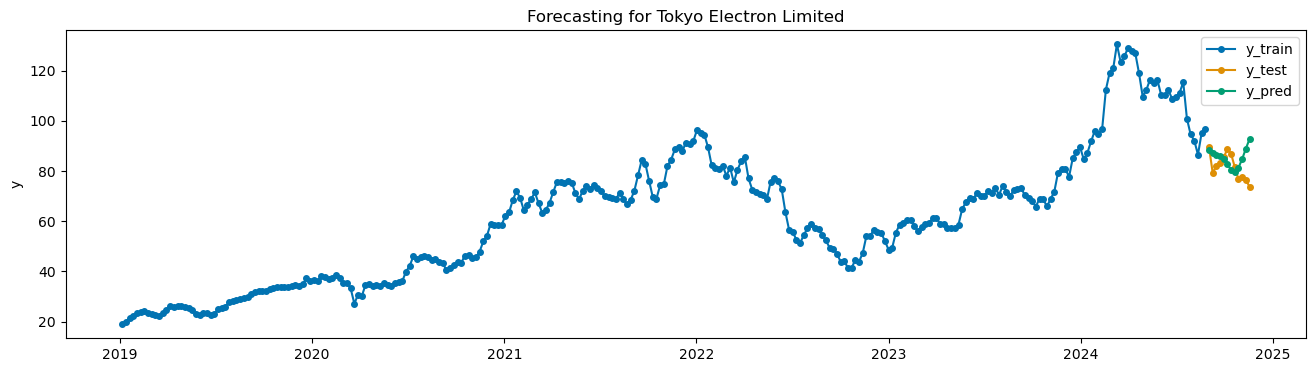

03:43:56 - cmdstanpy - INFO - Chain [1] start processing
03:43:56 - cmdstanpy - INFO - Chain [1] done processing
03:43:56 - cmdstanpy - INFO - Chain [1] start processing



Processing company: Taiwan Semiconductor Manufacturing Company (4/6)...

Total combinations to test for Taiwan Semiconductor Manufacturing Company: 1600


03:43:56 - cmdstanpy - INFO - Chain [1] done processing
03:43:56 - cmdstanpy - INFO - Chain [1] start processing


03:43:57 - cmdstanpy - INFO - Chain [1] done processing
03:43:57 - cmdstanpy - INFO - Chain [1] start processing


03:43:57 - cmdstanpy - INFO - Chain [1] done processing
03:43:57 - cmdstanpy - INFO - Chain [1] start processing
03:43:57 - cmdstanpy - INFO - Chain [1] done processing


03:43:57 - cmdstanpy - INFO - Chain [1] start processing


03:43:58 - cmdstanpy - INFO - Chain [1] done processing
03:43:58 - cmdstanpy - INFO - Chain [1] start processing
03:43:58 - cmdstanpy - INFO - Chain [1] done processing


03:43:58 - cmdstanpy - INFO - Chain [1] start processing
03:43:58 - cmdstanpy - INFO - Chain [1] done processing


03:43:58 - cmdstanpy - INFO - Chain [1] start processing
03:43:58 - cmdstanpy - INFO - Chain [1] done processing


03:43:58 - cmdstanpy - INFO - Chain [1] start processing
03:43:59 - cmdstanpy - INFO - Chain [1] done processing
03:43:59 - cmdstanpy - INFO - Chain [1] start processing


03:43:59 - cmdstanpy - INFO - Chain [1] done processing
03:43:59 - cmdstanpy - INFO - Chain [1] start processing


03:44:00 - cmdstanpy - INFO - Chain [1] done processing
03:44:00 - cmdstanpy - INFO - Chain [1] start processing


03:44:00 - cmdstanpy - INFO - Chain [1] done processing
03:44:00 - cmdstanpy - INFO - Chain [1] start processing


03:44:01 - cmdstanpy - INFO - Chain [1] done processing
03:44:01 - cmdstanpy - INFO - Chain [1] start processing


03:44:01 - cmdstanpy - INFO - Chain [1] done processing
03:44:01 - cmdstanpy - INFO - Chain [1] start processing


03:44:01 - cmdstanpy - INFO - Chain [1] done processing
03:44:01 - cmdstanpy - INFO - Chain [1] start processing
03:44:02 - cmdstanpy - INFO - Chain [1] done processing


03:44:02 - cmdstanpy - INFO - Chain [1] start processing


03:44:02 - cmdstanpy - INFO - Chain [1] done processing
03:44:02 - cmdstanpy - INFO - Chain [1] start processing


03:44:02 - cmdstanpy - INFO - Chain [1] done processing
03:44:02 - cmdstanpy - INFO - Chain [1] start processing


03:44:02 - cmdstanpy - INFO - Chain [1] done processing
03:44:03 - cmdstanpy - INFO - Chain [1] start processing
03:44:03 - cmdstanpy - INFO - Chain [1] done processing


03:44:03 - cmdstanpy - INFO - Chain [1] start processing


03:44:03 - cmdstanpy - INFO - Chain [1] done processing
03:44:03 - cmdstanpy - INFO - Chain [1] start processing


03:44:03 - cmdstanpy - INFO - Chain [1] done processing
03:44:03 - cmdstanpy - INFO - Chain [1] start processing
03:44:04 - cmdstanpy - INFO - Chain [1] done processing


03:44:04 - cmdstanpy - INFO - Chain [1] start processing
03:44:04 - cmdstanpy - INFO - Chain [1] done processing


03:44:04 - cmdstanpy - INFO - Chain [1] start processing
03:44:04 - cmdstanpy - INFO - Chain [1] done processing
03:44:04 - cmdstanpy - INFO - Chain [1] start processing


03:44:05 - cmdstanpy - INFO - Chain [1] done processing
03:44:05 - cmdstanpy - INFO - Chain [1] start processing


03:44:05 - cmdstanpy - INFO - Chain [1] done processing
03:44:05 - cmdstanpy - INFO - Chain [1] start processing


03:44:05 - cmdstanpy - INFO - Chain [1] done processing
03:44:06 - cmdstanpy - INFO - Chain [1] start processing


03:44:06 - cmdstanpy - INFO - Chain [1] done processing
03:44:06 - cmdstanpy - INFO - Chain [1] start processing
03:44:06 - cmdstanpy - INFO - Chain [1] done processing


03:44:06 - cmdstanpy - INFO - Chain [1] start processing


03:44:07 - cmdstanpy - INFO - Chain [1] done processing
03:44:07 - cmdstanpy - INFO - Chain [1] start processing
03:44:07 - cmdstanpy - INFO - Chain [1] done processing


03:44:07 - cmdstanpy - INFO - Chain [1] start processing
03:44:07 - cmdstanpy - INFO - Chain [1] done processing
03:44:07 - cmdstanpy - INFO - Chain [1] start processing


03:44:07 - cmdstanpy - INFO - Chain [1] done processing
03:44:08 - cmdstanpy - INFO - Chain [1] start processing
03:44:08 - cmdstanpy - INFO - Chain [1] done processing


03:44:08 - cmdstanpy - INFO - Chain [1] start processing
03:44:08 - cmdstanpy - INFO - Chain [1] done processing


03:44:08 - cmdstanpy - INFO - Chain [1] start processing


03:44:08 - cmdstanpy - INFO - Chain [1] done processing
03:44:08 - cmdstanpy - INFO - Chain [1] start processing
03:44:09 - cmdstanpy - INFO - Chain [1] done processing


03:44:09 - cmdstanpy - INFO - Chain [1] start processing
03:44:09 - cmdstanpy - INFO - Chain [1] done processing


03:44:09 - cmdstanpy - INFO - Chain [1] start processing
03:44:09 - cmdstanpy - INFO - Chain [1] done processing


03:44:09 - cmdstanpy - INFO - Chain [1] start processing
03:44:09 - cmdstanpy - INFO - Chain [1] done processing
03:44:10 - cmdstanpy - INFO - Chain [1] start processing


03:44:10 - cmdstanpy - INFO - Chain [1] done processing
03:44:10 - cmdstanpy - INFO - Chain [1] start processing


03:44:10 - cmdstanpy - INFO - Chain [1] done processing
03:44:10 - cmdstanpy - INFO - Chain [1] start processing


03:44:11 - cmdstanpy - INFO - Chain [1] done processing
03:44:11 - cmdstanpy - INFO - Chain [1] start processing


03:44:11 - cmdstanpy - INFO - Chain [1] done processing
03:44:11 - cmdstanpy - INFO - Chain [1] start processing


03:44:11 - cmdstanpy - INFO - Chain [1] done processing
03:44:12 - cmdstanpy - INFO - Chain [1] start processing


03:44:12 - cmdstanpy - INFO - Chain [1] done processing
03:44:12 - cmdstanpy - INFO - Chain [1] start processing
03:44:12 - cmdstanpy - INFO - Chain [1] done processing


03:44:12 - cmdstanpy - INFO - Chain [1] start processing
03:44:12 - cmdstanpy - INFO - Chain [1] done processing
03:44:13 - cmdstanpy - INFO - Chain [1] start processing


03:44:13 - cmdstanpy - INFO - Chain [1] done processing
03:44:13 - cmdstanpy - INFO - Chain [1] start processing
03:44:13 - cmdstanpy - INFO - Chain [1] done processing


03:44:13 - cmdstanpy - INFO - Chain [1] start processing
03:44:13 - cmdstanpy - INFO - Chain [1] done processing


03:44:13 - cmdstanpy - INFO - Chain [1] start processing


03:44:14 - cmdstanpy - INFO - Chain [1] done processing
03:44:14 - cmdstanpy - INFO - Chain [1] start processing
03:44:14 - cmdstanpy - INFO - Chain [1] done processing


03:44:14 - cmdstanpy - INFO - Chain [1] start processing
03:44:14 - cmdstanpy - INFO - Chain [1] done processing


03:44:14 - cmdstanpy - INFO - Chain [1] start processing
03:44:14 - cmdstanpy - INFO - Chain [1] done processing


03:44:14 - cmdstanpy - INFO - Chain [1] start processing
03:44:15 - cmdstanpy - INFO - Chain [1] done processing
03:44:15 - cmdstanpy - INFO - Chain [1] start processing


03:44:15 - cmdstanpy - INFO - Chain [1] done processing
03:44:15 - cmdstanpy - INFO - Chain [1] start processing


03:44:16 - cmdstanpy - INFO - Chain [1] done processing
03:44:16 - cmdstanpy - INFO - Chain [1] start processing


03:44:16 - cmdstanpy - INFO - Chain [1] done processing
03:44:16 - cmdstanpy - INFO - Chain [1] start processing


03:44:17 - cmdstanpy - INFO - Chain [1] done processing
03:44:17 - cmdstanpy - INFO - Chain [1] start processing


03:44:17 - cmdstanpy - INFO - Chain [1] done processing
03:44:17 - cmdstanpy - INFO - Chain [1] start processing


03:44:17 - cmdstanpy - INFO - Chain [1] done processing
03:44:17 - cmdstanpy - INFO - Chain [1] start processing
03:44:17 - cmdstanpy - INFO - Chain [1] done processing


03:44:18 - cmdstanpy - INFO - Chain [1] start processing
03:44:18 - cmdstanpy - INFO - Chain [1] done processing
03:44:18 - cmdstanpy - INFO - Chain [1] start processing


03:44:18 - cmdstanpy - INFO - Chain [1] done processing
03:44:18 - cmdstanpy - INFO - Chain [1] start processing


03:44:18 - cmdstanpy - INFO - Chain [1] done processing
03:44:19 - cmdstanpy - INFO - Chain [1] start processing
03:44:19 - cmdstanpy - INFO - Chain [1] done processing


03:44:19 - cmdstanpy - INFO - Chain [1] start processing


03:44:19 - cmdstanpy - INFO - Chain [1] done processing
03:44:19 - cmdstanpy - INFO - Chain [1] start processing
03:44:19 - cmdstanpy - INFO - Chain [1] done processing


03:44:19 - cmdstanpy - INFO - Chain [1] start processing
03:44:19 - cmdstanpy - INFO - Chain [1] done processing


03:44:20 - cmdstanpy - INFO - Chain [1] start processing
03:44:20 - cmdstanpy - INFO - Chain [1] done processing


03:44:20 - cmdstanpy - INFO - Chain [1] start processing
03:44:20 - cmdstanpy - INFO - Chain [1] done processing
03:44:20 - cmdstanpy - INFO - Chain [1] start processing


03:44:21 - cmdstanpy - INFO - Chain [1] done processing
03:44:21 - cmdstanpy - INFO - Chain [1] start processing


03:44:21 - cmdstanpy - INFO - Chain [1] done processing
03:44:21 - cmdstanpy - INFO - Chain [1] start processing


03:44:21 - cmdstanpy - INFO - Chain [1] done processing
03:44:21 - cmdstanpy - INFO - Chain [1] start processing


03:44:22 - cmdstanpy - INFO - Chain [1] done processing
03:44:22 - cmdstanpy - INFO - Chain [1] start processing


03:44:22 - cmdstanpy - INFO - Chain [1] done processing
03:44:22 - cmdstanpy - INFO - Chain [1] start processing


03:44:23 - cmdstanpy - INFO - Chain [1] done processing
03:44:23 - cmdstanpy - INFO - Chain [1] start processing
03:44:23 - cmdstanpy - INFO - Chain [1] done processing


03:44:23 - cmdstanpy - INFO - Chain [1] start processing
03:44:23 - cmdstanpy - INFO - Chain [1] done processing
03:44:23 - cmdstanpy - INFO - Chain [1] start processing


03:44:23 - cmdstanpy - INFO - Chain [1] done processing
03:44:24 - cmdstanpy - INFO - Chain [1] start processing
03:44:24 - cmdstanpy - INFO - Chain [1] done processing


03:44:24 - cmdstanpy - INFO - Chain [1] start processing
03:44:24 - cmdstanpy - INFO - Chain [1] done processing


03:44:24 - cmdstanpy - INFO - Chain [1] start processing


03:44:24 - cmdstanpy - INFO - Chain [1] done processing
03:44:24 - cmdstanpy - INFO - Chain [1] start processing


03:44:25 - cmdstanpy - INFO - Chain [1] done processing
03:44:25 - cmdstanpy - INFO - Chain [1] start processing
03:44:25 - cmdstanpy - INFO - Chain [1] done processing


03:44:25 - cmdstanpy - INFO - Chain [1] start processing
03:44:25 - cmdstanpy - INFO - Chain [1] done processing


03:44:25 - cmdstanpy - INFO - Chain [1] start processing


03:44:26 - cmdstanpy - INFO - Chain [1] done processing
03:44:26 - cmdstanpy - INFO - Chain [1] start processing


03:44:26 - cmdstanpy - INFO - Chain [1] done processing
03:44:26 - cmdstanpy - INFO - Chain [1] start processing


03:44:26 - cmdstanpy - INFO - Chain [1] done processing
03:44:27 - cmdstanpy - INFO - Chain [1] start processing


03:44:27 - cmdstanpy - INFO - Chain [1] done processing
03:44:27 - cmdstanpy - INFO - Chain [1] start processing


03:44:27 - cmdstanpy - INFO - Chain [1] done processing
03:44:27 - cmdstanpy - INFO - Chain [1] start processing


03:44:27 - cmdstanpy - INFO - Chain [1] done processing
03:44:28 - cmdstanpy - INFO - Chain [1] start processing


03:44:28 - cmdstanpy - INFO - Chain [1] done processing
03:44:28 - cmdstanpy - INFO - Chain [1] start processing
03:44:28 - cmdstanpy - INFO - Chain [1] done processing


03:44:28 - cmdstanpy - INFO - Chain [1] start processing
03:44:28 - cmdstanpy - INFO - Chain [1] done processing
03:44:29 - cmdstanpy - INFO - Chain [1] start processing


03:44:29 - cmdstanpy - INFO - Chain [1] done processing
03:44:29 - cmdstanpy - INFO - Chain [1] start processing
03:44:29 - cmdstanpy - INFO - Chain [1] done processing


03:44:29 - cmdstanpy - INFO - Chain [1] start processing
03:44:29 - cmdstanpy - INFO - Chain [1] done processing


03:44:29 - cmdstanpy - INFO - Chain [1] start processing


03:44:29 - cmdstanpy - INFO - Chain [1] done processing
03:44:30 - cmdstanpy - INFO - Chain [1] start processing
03:44:30 - cmdstanpy - INFO - Chain [1] done processing


03:44:30 - cmdstanpy - INFO - Chain [1] start processing
03:44:30 - cmdstanpy - INFO - Chain [1] done processing


03:44:30 - cmdstanpy - INFO - Chain [1] start processing
03:44:30 - cmdstanpy - INFO - Chain [1] done processing


03:44:30 - cmdstanpy - INFO - Chain [1] start processing


03:44:31 - cmdstanpy - INFO - Chain [1] done processing
03:44:31 - cmdstanpy - INFO - Chain [1] start processing


03:44:31 - cmdstanpy - INFO - Chain [1] done processing
03:44:31 - cmdstanpy - INFO - Chain [1] start processing


03:44:32 - cmdstanpy - INFO - Chain [1] done processing
03:44:32 - cmdstanpy - INFO - Chain [1] start processing


03:44:32 - cmdstanpy - INFO - Chain [1] done processing
03:44:32 - cmdstanpy - INFO - Chain [1] start processing


03:44:33 - cmdstanpy - INFO - Chain [1] done processing
03:44:33 - cmdstanpy - INFO - Chain [1] start processing


03:44:33 - cmdstanpy - INFO - Chain [1] done processing
03:44:33 - cmdstanpy - INFO - Chain [1] start processing


03:44:33 - cmdstanpy - INFO - Chain [1] done processing
03:44:33 - cmdstanpy - INFO - Chain [1] start processing
03:44:33 - cmdstanpy - INFO - Chain [1] done processing


03:44:34 - cmdstanpy - INFO - Chain [1] start processing


03:44:34 - cmdstanpy - INFO - Chain [1] done processing
03:44:34 - cmdstanpy - INFO - Chain [1] start processing


03:44:34 - cmdstanpy - INFO - Chain [1] done processing
03:44:34 - cmdstanpy - INFO - Chain [1] start processing
03:44:34 - cmdstanpy - INFO - Chain [1] done processing


03:44:34 - cmdstanpy - INFO - Chain [1] start processing
03:44:35 - cmdstanpy - INFO - Chain [1] done processing


03:44:35 - cmdstanpy - INFO - Chain [1] start processing


03:44:35 - cmdstanpy - INFO - Chain [1] done processing
03:44:35 - cmdstanpy - INFO - Chain [1] start processing
03:44:35 - cmdstanpy - INFO - Chain [1] done processing


03:44:35 - cmdstanpy - INFO - Chain [1] start processing
03:44:35 - cmdstanpy - INFO - Chain [1] done processing


03:44:36 - cmdstanpy - INFO - Chain [1] start processing
03:44:36 - cmdstanpy - INFO - Chain [1] done processing


03:44:36 - cmdstanpy - INFO - Chain [1] start processing
03:44:36 - cmdstanpy - INFO - Chain [1] done processing
03:44:36 - cmdstanpy - INFO - Chain [1] start processing


03:44:36 - cmdstanpy - INFO - Chain [1] done processing
03:44:37 - cmdstanpy - INFO - Chain [1] start processing


03:44:37 - cmdstanpy - INFO - Chain [1] done processing
03:44:37 - cmdstanpy - INFO - Chain [1] start processing


03:44:37 - cmdstanpy - INFO - Chain [1] done processing
03:44:37 - cmdstanpy - INFO - Chain [1] start processing


03:44:38 - cmdstanpy - INFO - Chain [1] done processing
03:44:38 - cmdstanpy - INFO - Chain [1] start processing


03:44:38 - cmdstanpy - INFO - Chain [1] done processing
03:44:38 - cmdstanpy - INFO - Chain [1] start processing


03:44:38 - cmdstanpy - INFO - Chain [1] done processing
03:44:38 - cmdstanpy - INFO - Chain [1] start processing
03:44:39 - cmdstanpy - INFO - Chain [1] done processing


03:44:39 - cmdstanpy - INFO - Chain [1] start processing
03:44:39 - cmdstanpy - INFO - Chain [1] done processing
03:44:39 - cmdstanpy - INFO - Chain [1] start processing


03:44:39 - cmdstanpy - INFO - Chain [1] done processing
03:44:39 - cmdstanpy - INFO - Chain [1] start processing
03:44:39 - cmdstanpy - INFO - Chain [1] done processing


03:44:40 - cmdstanpy - INFO - Chain [1] start processing
03:44:40 - cmdstanpy - INFO - Chain [1] done processing


03:44:40 - cmdstanpy - INFO - Chain [1] start processing


03:44:40 - cmdstanpy - INFO - Chain [1] done processing
03:44:40 - cmdstanpy - INFO - Chain [1] start processing
03:44:40 - cmdstanpy - INFO - Chain [1] done processing


03:44:40 - cmdstanpy - INFO - Chain [1] start processing
03:44:41 - cmdstanpy - INFO - Chain [1] done processing


03:44:41 - cmdstanpy - INFO - Chain [1] start processing
03:44:41 - cmdstanpy - INFO - Chain [1] done processing


03:44:41 - cmdstanpy - INFO - Chain [1] start processing
03:44:41 - cmdstanpy - INFO - Chain [1] done processing
03:44:41 - cmdstanpy - INFO - Chain [1] start processing


03:44:42 - cmdstanpy - INFO - Chain [1] done processing
03:44:42 - cmdstanpy - INFO - Chain [1] start processing


03:44:42 - cmdstanpy - INFO - Chain [1] done processing
03:44:42 - cmdstanpy - INFO - Chain [1] start processing


03:44:43 - cmdstanpy - INFO - Chain [1] done processing
03:44:43 - cmdstanpy - INFO - Chain [1] start processing


03:44:43 - cmdstanpy - INFO - Chain [1] done processing
03:44:43 - cmdstanpy - INFO - Chain [1] start processing


03:44:43 - cmdstanpy - INFO - Chain [1] done processing
03:44:44 - cmdstanpy - INFO - Chain [1] start processing


03:44:44 - cmdstanpy - INFO - Chain [1] done processing
03:44:44 - cmdstanpy - INFO - Chain [1] start processing
03:44:44 - cmdstanpy - INFO - Chain [1] done processing


03:44:44 - cmdstanpy - INFO - Chain [1] start processing


03:44:44 - cmdstanpy - INFO - Chain [1] done processing
03:44:45 - cmdstanpy - INFO - Chain [1] start processing


03:44:45 - cmdstanpy - INFO - Chain [1] done processing
03:44:45 - cmdstanpy - INFO - Chain [1] start processing
03:44:45 - cmdstanpy - INFO - Chain [1] done processing


03:44:45 - cmdstanpy - INFO - Chain [1] start processing
03:44:45 - cmdstanpy - INFO - Chain [1] done processing


03:44:45 - cmdstanpy - INFO - Chain [1] start processing


03:44:46 - cmdstanpy - INFO - Chain [1] done processing
03:44:46 - cmdstanpy - INFO - Chain [1] start processing


03:44:46 - cmdstanpy - INFO - Chain [1] done processing
03:44:46 - cmdstanpy - INFO - Chain [1] start processing
03:44:46 - cmdstanpy - INFO - Chain [1] done processing


03:44:46 - cmdstanpy - INFO - Chain [1] start processing
03:44:46 - cmdstanpy - INFO - Chain [1] done processing


03:44:47 - cmdstanpy - INFO - Chain [1] start processing


03:44:47 - cmdstanpy - INFO - Chain [1] done processing
03:44:47 - cmdstanpy - INFO - Chain [1] start processing


03:44:47 - cmdstanpy - INFO - Chain [1] done processing
03:44:47 - cmdstanpy - INFO - Chain [1] start processing


03:44:48 - cmdstanpy - INFO - Chain [1] done processing
03:44:48 - cmdstanpy - INFO - Chain [1] start processing


03:44:48 - cmdstanpy - INFO - Chain [1] done processing
03:44:48 - cmdstanpy - INFO - Chain [1] start processing


03:44:48 - cmdstanpy - INFO - Chain [1] done processing
03:44:49 - cmdstanpy - INFO - Chain [1] start processing


03:44:49 - cmdstanpy - INFO - Chain [1] done processing
03:44:49 - cmdstanpy - INFO - Chain [1] start processing


03:44:49 - cmdstanpy - INFO - Chain [1] done processing
03:44:49 - cmdstanpy - INFO - Chain [1] start processing
03:44:49 - cmdstanpy - INFO - Chain [1] done processing


03:44:49 - cmdstanpy - INFO - Chain [1] start processing
03:44:50 - cmdstanpy - INFO - Chain [1] done processing
03:44:50 - cmdstanpy - INFO - Chain [1] start processing


03:44:50 - cmdstanpy - INFO - Chain [1] done processing
03:44:50 - cmdstanpy - INFO - Chain [1] start processing
03:44:50 - cmdstanpy - INFO - Chain [1] done processing


03:44:50 - cmdstanpy - INFO - Chain [1] start processing
03:44:50 - cmdstanpy - INFO - Chain [1] done processing


03:44:51 - cmdstanpy - INFO - Chain [1] start processing
03:44:51 - cmdstanpy - INFO - Chain [1] done processing
03:44:51 - cmdstanpy - INFO - Chain [1] start processing


03:44:51 - cmdstanpy - INFO - Chain [1] done processing
03:44:51 - cmdstanpy - INFO - Chain [1] start processing
03:44:51 - cmdstanpy - INFO - Chain [1] done processing


03:44:51 - cmdstanpy - INFO - Chain [1] start processing
03:44:51 - cmdstanpy - INFO - Chain [1] done processing


03:44:52 - cmdstanpy - INFO - Chain [1] start processing
03:44:52 - cmdstanpy - INFO - Chain [1] done processing
03:44:52 - cmdstanpy - INFO - Chain [1] start processing


03:44:52 - cmdstanpy - INFO - Chain [1] done processing
03:44:53 - cmdstanpy - INFO - Chain [1] start processing


03:44:53 - cmdstanpy - INFO - Chain [1] done processing
03:44:53 - cmdstanpy - INFO - Chain [1] start processing


03:44:53 - cmdstanpy - INFO - Chain [1] done processing
03:44:53 - cmdstanpy - INFO - Chain [1] start processing


03:44:54 - cmdstanpy - INFO - Chain [1] done processing
03:44:54 - cmdstanpy - INFO - Chain [1] start processing


03:44:54 - cmdstanpy - INFO - Chain [1] done processing
03:44:54 - cmdstanpy - INFO - Chain [1] start processing


03:44:54 - cmdstanpy - INFO - Chain [1] done processing
03:44:55 - cmdstanpy - INFO - Chain [1] start processing
03:44:55 - cmdstanpy - INFO - Chain [1] done processing


03:44:55 - cmdstanpy - INFO - Chain [1] start processing
03:44:55 - cmdstanpy - INFO - Chain [1] done processing
03:44:55 - cmdstanpy - INFO - Chain [1] start processing


03:44:55 - cmdstanpy - INFO - Chain [1] done processing
03:44:55 - cmdstanpy - INFO - Chain [1] start processing
03:44:56 - cmdstanpy - INFO - Chain [1] done processing


03:44:56 - cmdstanpy - INFO - Chain [1] start processing
03:44:56 - cmdstanpy - INFO - Chain [1] done processing


03:44:56 - cmdstanpy - INFO - Chain [1] start processing
03:44:56 - cmdstanpy - INFO - Chain [1] done processing
03:44:56 - cmdstanpy - INFO - Chain [1] start processing


03:44:56 - cmdstanpy - INFO - Chain [1] done processing
03:44:57 - cmdstanpy - INFO - Chain [1] start processing
03:44:57 - cmdstanpy - INFO - Chain [1] done processing


03:44:57 - cmdstanpy - INFO - Chain [1] start processing
03:44:57 - cmdstanpy - INFO - Chain [1] done processing


03:44:57 - cmdstanpy - INFO - Chain [1] start processing


03:44:57 - cmdstanpy - INFO - Chain [1] done processing
03:44:58 - cmdstanpy - INFO - Chain [1] start processing


03:44:58 - cmdstanpy - INFO - Chain [1] done processing
03:44:58 - cmdstanpy - INFO - Chain [1] start processing


03:44:58 - cmdstanpy - INFO - Chain [1] done processing
03:44:58 - cmdstanpy - INFO - Chain [1] start processing


03:44:59 - cmdstanpy - INFO - Chain [1] done processing
03:44:59 - cmdstanpy - INFO - Chain [1] start processing


03:44:59 - cmdstanpy - INFO - Chain [1] done processing
03:44:59 - cmdstanpy - INFO - Chain [1] start processing


03:45:00 - cmdstanpy - INFO - Chain [1] done processing
03:45:00 - cmdstanpy - INFO - Chain [1] start processing


03:45:00 - cmdstanpy - INFO - Chain [1] done processing
03:45:00 - cmdstanpy - INFO - Chain [1] start processing
03:45:00 - cmdstanpy - INFO - Chain [1] done processing


03:45:00 - cmdstanpy - INFO - Chain [1] start processing
03:45:01 - cmdstanpy - INFO - Chain [1] done processing
03:45:01 - cmdstanpy - INFO - Chain [1] start processing


03:45:01 - cmdstanpy - INFO - Chain [1] done processing
03:45:01 - cmdstanpy - INFO - Chain [1] start processing
03:45:01 - cmdstanpy - INFO - Chain [1] done processing


03:45:01 - cmdstanpy - INFO - Chain [1] start processing
03:45:01 - cmdstanpy - INFO - Chain [1] done processing


03:45:02 - cmdstanpy - INFO - Chain [1] start processing


03:45:02 - cmdstanpy - INFO - Chain [1] done processing
03:45:02 - cmdstanpy - INFO - Chain [1] start processing


03:45:02 - cmdstanpy - INFO - Chain [1] done processing
03:45:02 - cmdstanpy - INFO - Chain [1] start processing
03:45:02 - cmdstanpy - INFO - Chain [1] done processing


03:45:02 - cmdstanpy - INFO - Chain [1] start processing
03:45:02 - cmdstanpy - INFO - Chain [1] done processing


03:45:03 - cmdstanpy - INFO - Chain [1] start processing
03:45:03 - cmdstanpy - INFO - Chain [1] done processing
03:45:03 - cmdstanpy - INFO - Chain [1] start processing


03:45:03 - cmdstanpy - INFO - Chain [1] done processing
03:45:03 - cmdstanpy - INFO - Chain [1] start processing


03:45:04 - cmdstanpy - INFO - Chain [1] done processing
03:45:04 - cmdstanpy - INFO - Chain [1] start processing


03:45:04 - cmdstanpy - INFO - Chain [1] done processing
03:45:04 - cmdstanpy - INFO - Chain [1] start processing


03:45:04 - cmdstanpy - INFO - Chain [1] done processing
03:45:05 - cmdstanpy - INFO - Chain [1] start processing


03:45:05 - cmdstanpy - INFO - Chain [1] done processing
03:45:05 - cmdstanpy - INFO - Chain [1] start processing


03:45:05 - cmdstanpy - INFO - Chain [1] done processing
03:45:05 - cmdstanpy - INFO - Chain [1] start processing
03:45:05 - cmdstanpy - INFO - Chain [1] done processing


03:45:06 - cmdstanpy - INFO - Chain [1] start processing


03:45:06 - cmdstanpy - INFO - Chain [1] done processing
03:45:06 - cmdstanpy - INFO - Chain [1] start processing


03:45:06 - cmdstanpy - INFO - Chain [1] done processing
03:45:06 - cmdstanpy - INFO - Chain [1] start processing
03:45:06 - cmdstanpy - INFO - Chain [1] done processing


03:45:07 - cmdstanpy - INFO - Chain [1] start processing
03:45:07 - cmdstanpy - INFO - Chain [1] done processing


03:45:07 - cmdstanpy - INFO - Chain [1] start processing


03:45:07 - cmdstanpy - INFO - Chain [1] done processing
03:45:07 - cmdstanpy - INFO - Chain [1] start processing
03:45:07 - cmdstanpy - INFO - Chain [1] done processing


03:45:07 - cmdstanpy - INFO - Chain [1] start processing
03:45:07 - cmdstanpy - INFO - Chain [1] done processing


03:45:08 - cmdstanpy - INFO - Chain [1] start processing
03:45:08 - cmdstanpy - INFO - Chain [1] done processing


03:45:08 - cmdstanpy - INFO - Chain [1] start processing
03:45:08 - cmdstanpy - INFO - Chain [1] done processing
03:45:08 - cmdstanpy - INFO - Chain [1] start processing


03:45:09 - cmdstanpy - INFO - Chain [1] done processing
03:45:09 - cmdstanpy - INFO - Chain [1] start processing


03:45:09 - cmdstanpy - INFO - Chain [1] done processing
03:45:09 - cmdstanpy - INFO - Chain [1] start processing


03:45:09 - cmdstanpy - INFO - Chain [1] done processing
03:45:10 - cmdstanpy - INFO - Chain [1] start processing


03:45:10 - cmdstanpy - INFO - Chain [1] done processing
03:45:10 - cmdstanpy - INFO - Chain [1] start processing


03:45:10 - cmdstanpy - INFO - Chain [1] done processing
03:45:10 - cmdstanpy - INFO - Chain [1] start processing


03:45:10 - cmdstanpy - INFO - Chain [1] done processing
03:45:11 - cmdstanpy - INFO - Chain [1] start processing
03:45:11 - cmdstanpy - INFO - Chain [1] done processing


03:45:11 - cmdstanpy - INFO - Chain [1] start processing
03:45:11 - cmdstanpy - INFO - Chain [1] done processing
03:45:11 - cmdstanpy - INFO - Chain [1] start processing


03:45:11 - cmdstanpy - INFO - Chain [1] done processing
03:45:12 - cmdstanpy - INFO - Chain [1] start processing
03:45:12 - cmdstanpy - INFO - Chain [1] done processing


03:45:12 - cmdstanpy - INFO - Chain [1] start processing
03:45:12 - cmdstanpy - INFO - Chain [1] done processing


03:45:12 - cmdstanpy - INFO - Chain [1] start processing
03:45:12 - cmdstanpy - INFO - Chain [1] done processing
03:45:12 - cmdstanpy - INFO - Chain [1] start processing


03:45:12 - cmdstanpy - INFO - Chain [1] done processing
03:45:13 - cmdstanpy - INFO - Chain [1] start processing
03:45:13 - cmdstanpy - INFO - Chain [1] done processing


03:45:13 - cmdstanpy - INFO - Chain [1] start processing
03:45:13 - cmdstanpy - INFO - Chain [1] done processing


03:45:13 - cmdstanpy - INFO - Chain [1] start processing
03:45:13 - cmdstanpy - INFO - Chain [1] done processing
03:45:14 - cmdstanpy - INFO - Chain [1] start processing


03:45:14 - cmdstanpy - INFO - Chain [1] done processing
03:45:14 - cmdstanpy - INFO - Chain [1] start processing


03:45:14 - cmdstanpy - INFO - Chain [1] done processing
03:45:14 - cmdstanpy - INFO - Chain [1] start processing


03:45:15 - cmdstanpy - INFO - Chain [1] done processing
03:45:15 - cmdstanpy - INFO - Chain [1] start processing


03:45:15 - cmdstanpy - INFO - Chain [1] done processing
03:45:15 - cmdstanpy - INFO - Chain [1] start processing


03:45:15 - cmdstanpy - INFO - Chain [1] done processing
03:45:16 - cmdstanpy - INFO - Chain [1] start processing


03:45:16 - cmdstanpy - INFO - Chain [1] done processing
03:45:16 - cmdstanpy - INFO - Chain [1] start processing
03:45:16 - cmdstanpy - INFO - Chain [1] done processing


03:45:16 - cmdstanpy - INFO - Chain [1] start processing
03:45:16 - cmdstanpy - INFO - Chain [1] done processing
03:45:16 - cmdstanpy - INFO - Chain [1] start processing


03:45:17 - cmdstanpy - INFO - Chain [1] done processing
03:45:17 - cmdstanpy - INFO - Chain [1] start processing
03:45:17 - cmdstanpy - INFO - Chain [1] done processing


03:45:17 - cmdstanpy - INFO - Chain [1] start processing
03:45:17 - cmdstanpy - INFO - Chain [1] done processing


03:45:17 - cmdstanpy - INFO - Chain [1] start processing


03:45:18 - cmdstanpy - INFO - Chain [1] done processing
03:45:18 - cmdstanpy - INFO - Chain [1] start processing


03:45:18 - cmdstanpy - INFO - Chain [1] done processing
03:45:18 - cmdstanpy - INFO - Chain [1] start processing
03:45:18 - cmdstanpy - INFO - Chain [1] done processing


03:45:18 - cmdstanpy - INFO - Chain [1] start processing
03:45:18 - cmdstanpy - INFO - Chain [1] done processing


03:45:18 - cmdstanpy - INFO - Chain [1] start processing
03:45:19 - cmdstanpy - INFO - Chain [1] done processing
03:45:19 - cmdstanpy - INFO - Chain [1] start processing


03:45:19 - cmdstanpy - INFO - Chain [1] done processing
03:45:19 - cmdstanpy - INFO - Chain [1] start processing


03:45:19 - cmdstanpy - INFO - Chain [1] done processing
03:45:20 - cmdstanpy - INFO - Chain [1] start processing


03:45:20 - cmdstanpy - INFO - Chain [1] done processing
03:45:20 - cmdstanpy - INFO - Chain [1] start processing


03:45:20 - cmdstanpy - INFO - Chain [1] done processing
03:45:20 - cmdstanpy - INFO - Chain [1] start processing


03:45:21 - cmdstanpy - INFO - Chain [1] done processing
03:45:21 - cmdstanpy - INFO - Chain [1] start processing


03:45:21 - cmdstanpy - INFO - Chain [1] done processing
03:45:21 - cmdstanpy - INFO - Chain [1] start processing
03:45:21 - cmdstanpy - INFO - Chain [1] done processing


03:45:22 - cmdstanpy - INFO - Chain [1] start processing


03:45:22 - cmdstanpy - INFO - Chain [1] done processing
03:45:22 - cmdstanpy - INFO - Chain [1] start processing


03:45:22 - cmdstanpy - INFO - Chain [1] done processing
03:45:22 - cmdstanpy - INFO - Chain [1] start processing


03:45:22 - cmdstanpy - INFO - Chain [1] done processing
03:45:23 - cmdstanpy - INFO - Chain [1] start processing
03:45:23 - cmdstanpy - INFO - Chain [1] done processing


03:45:23 - cmdstanpy - INFO - Chain [1] start processing


03:45:23 - cmdstanpy - INFO - Chain [1] done processing
03:45:23 - cmdstanpy - INFO - Chain [1] start processing


03:45:23 - cmdstanpy - INFO - Chain [1] done processing
03:45:24 - cmdstanpy - INFO - Chain [1] start processing
03:45:24 - cmdstanpy - INFO - Chain [1] done processing


03:45:24 - cmdstanpy - INFO - Chain [1] start processing
03:45:24 - cmdstanpy - INFO - Chain [1] done processing


03:45:24 - cmdstanpy - INFO - Chain [1] start processing


03:45:24 - cmdstanpy - INFO - Chain [1] done processing
03:45:25 - cmdstanpy - INFO - Chain [1] start processing


03:45:25 - cmdstanpy - INFO - Chain [1] done processing
03:45:25 - cmdstanpy - INFO - Chain [1] start processing


03:45:25 - cmdstanpy - INFO - Chain [1] done processing
03:45:26 - cmdstanpy - INFO - Chain [1] start processing


03:45:26 - cmdstanpy - INFO - Chain [1] done processing
03:45:26 - cmdstanpy - INFO - Chain [1] start processing


03:45:26 - cmdstanpy - INFO - Chain [1] done processing
03:45:27 - cmdstanpy - INFO - Chain [1] start processing


03:45:27 - cmdstanpy - INFO - Chain [1] done processing
03:45:27 - cmdstanpy - INFO - Chain [1] start processing


03:45:27 - cmdstanpy - INFO - Chain [1] done processing
03:45:27 - cmdstanpy - INFO - Chain [1] start processing
03:45:27 - cmdstanpy - INFO - Chain [1] done processing


03:45:28 - cmdstanpy - INFO - Chain [1] start processing


03:45:28 - cmdstanpy - INFO - Chain [1] done processing
03:45:28 - cmdstanpy - INFO - Chain [1] start processing


03:45:28 - cmdstanpy - INFO - Chain [1] done processing
03:45:28 - cmdstanpy - INFO - Chain [1] start processing


03:45:28 - cmdstanpy - INFO - Chain [1] done processing
03:45:28 - cmdstanpy - INFO - Chain [1] start processing
03:45:29 - cmdstanpy - INFO - Chain [1] done processing


03:45:29 - cmdstanpy - INFO - Chain [1] start processing


03:45:29 - cmdstanpy - INFO - Chain [1] done processing
03:45:29 - cmdstanpy - INFO - Chain [1] start processing


03:45:29 - cmdstanpy - INFO - Chain [1] done processing
03:45:29 - cmdstanpy - INFO - Chain [1] start processing
03:45:29 - cmdstanpy - INFO - Chain [1] done processing


03:45:30 - cmdstanpy - INFO - Chain [1] start processing
03:45:30 - cmdstanpy - INFO - Chain [1] done processing


03:45:30 - cmdstanpy - INFO - Chain [1] start processing
03:45:30 - cmdstanpy - INFO - Chain [1] done processing
03:45:30 - cmdstanpy - INFO - Chain [1] start processing


03:45:31 - cmdstanpy - INFO - Chain [1] done processing
03:45:31 - cmdstanpy - INFO - Chain [1] start processing


03:45:31 - cmdstanpy - INFO - Chain [1] done processing
03:45:31 - cmdstanpy - INFO - Chain [1] start processing


03:45:32 - cmdstanpy - INFO - Chain [1] done processing
03:45:32 - cmdstanpy - INFO - Chain [1] start processing


03:45:32 - cmdstanpy - INFO - Chain [1] done processing
03:45:32 - cmdstanpy - INFO - Chain [1] start processing
03:45:32 - cmdstanpy - INFO - Chain [1] done processing


03:45:32 - cmdstanpy - INFO - Chain [1] start processing


03:45:33 - cmdstanpy - INFO - Chain [1] done processing
03:45:33 - cmdstanpy - INFO - Chain [1] start processing
03:45:33 - cmdstanpy - INFO - Chain [1] done processing


03:45:33 - cmdstanpy - INFO - Chain [1] start processing
03:45:33 - cmdstanpy - INFO - Chain [1] done processing
03:45:33 - cmdstanpy - INFO - Chain [1] start processing


03:45:34 - cmdstanpy - INFO - Chain [1] done processing
03:45:34 - cmdstanpy - INFO - Chain [1] start processing
03:45:34 - cmdstanpy - INFO - Chain [1] done processing


03:45:34 - cmdstanpy - INFO - Chain [1] start processing
03:45:34 - cmdstanpy - INFO - Chain [1] done processing


03:45:34 - cmdstanpy - INFO - Chain [1] start processing


03:45:34 - cmdstanpy - INFO - Chain [1] done processing
03:45:35 - cmdstanpy - INFO - Chain [1] start processing


03:45:35 - cmdstanpy - INFO - Chain [1] done processing
03:45:35 - cmdstanpy - INFO - Chain [1] start processing
03:45:35 - cmdstanpy - INFO - Chain [1] done processing


03:45:35 - cmdstanpy - INFO - Chain [1] start processing
03:45:35 - cmdstanpy - INFO - Chain [1] done processing


03:45:35 - cmdstanpy - INFO - Chain [1] start processing


03:45:36 - cmdstanpy - INFO - Chain [1] done processing
03:45:36 - cmdstanpy - INFO - Chain [1] start processing


03:45:37 - cmdstanpy - INFO - Chain [1] done processing
03:45:37 - cmdstanpy - INFO - Chain [1] start processing


03:45:37 - cmdstanpy - INFO - Chain [1] done processing
03:45:37 - cmdstanpy - INFO - Chain [1] start processing


03:45:37 - cmdstanpy - INFO - Chain [1] done processing
03:45:37 - cmdstanpy - INFO - Chain [1] start processing


03:45:38 - cmdstanpy - INFO - Chain [1] done processing
03:45:38 - cmdstanpy - INFO - Chain [1] start processing


03:45:38 - cmdstanpy - INFO - Chain [1] done processing
03:45:38 - cmdstanpy - INFO - Chain [1] start processing


03:45:38 - cmdstanpy - INFO - Chain [1] done processing
03:45:39 - cmdstanpy - INFO - Chain [1] start processing
03:45:39 - cmdstanpy - INFO - Chain [1] done processing


03:45:39 - cmdstanpy - INFO - Chain [1] start processing


03:45:39 - cmdstanpy - INFO - Chain [1] done processing
03:45:39 - cmdstanpy - INFO - Chain [1] start processing


03:45:39 - cmdstanpy - INFO - Chain [1] done processing
03:45:40 - cmdstanpy - INFO - Chain [1] start processing


03:45:40 - cmdstanpy - INFO - Chain [1] done processing
03:45:40 - cmdstanpy - INFO - Chain [1] start processing
03:45:40 - cmdstanpy - INFO - Chain [1] done processing


03:45:40 - cmdstanpy - INFO - Chain [1] start processing


03:45:40 - cmdstanpy - INFO - Chain [1] done processing
03:45:41 - cmdstanpy - INFO - Chain [1] start processing


03:45:41 - cmdstanpy - INFO - Chain [1] done processing
03:45:41 - cmdstanpy - INFO - Chain [1] start processing
03:45:41 - cmdstanpy - INFO - Chain [1] done processing


03:45:41 - cmdstanpy - INFO - Chain [1] start processing
03:45:41 - cmdstanpy - INFO - Chain [1] done processing


03:45:41 - cmdstanpy - INFO - Chain [1] start processing


03:45:42 - cmdstanpy - INFO - Chain [1] done processing
03:45:42 - cmdstanpy - INFO - Chain [1] start processing


03:45:42 - cmdstanpy - INFO - Chain [1] done processing
03:45:42 - cmdstanpy - INFO - Chain [1] start processing


03:45:43 - cmdstanpy - INFO - Chain [1] done processing
03:45:43 - cmdstanpy - INFO - Chain [1] start processing


03:45:43 - cmdstanpy - INFO - Chain [1] done processing
03:45:43 - cmdstanpy - INFO - Chain [1] start processing


03:45:43 - cmdstanpy - INFO - Chain [1] done processing
03:45:44 - cmdstanpy - INFO - Chain [1] start processing


03:45:44 - cmdstanpy - INFO - Chain [1] done processing
03:45:44 - cmdstanpy - INFO - Chain [1] start processing


03:45:44 - cmdstanpy - INFO - Chain [1] done processing
03:45:44 - cmdstanpy - INFO - Chain [1] start processing
03:45:44 - cmdstanpy - INFO - Chain [1] done processing


03:45:45 - cmdstanpy - INFO - Chain [1] start processing
03:45:45 - cmdstanpy - INFO - Chain [1] done processing
03:45:45 - cmdstanpy - INFO - Chain [1] start processing


03:45:45 - cmdstanpy - INFO - Chain [1] done processing
03:45:45 - cmdstanpy - INFO - Chain [1] start processing
03:45:45 - cmdstanpy - INFO - Chain [1] done processing


03:45:46 - cmdstanpy - INFO - Chain [1] start processing


03:45:46 - cmdstanpy - INFO - Chain [1] done processing
03:45:46 - cmdstanpy - INFO - Chain [1] start processing


03:45:46 - cmdstanpy - INFO - Chain [1] done processing
03:45:46 - cmdstanpy - INFO - Chain [1] start processing


03:45:46 - cmdstanpy - INFO - Chain [1] done processing
03:45:46 - cmdstanpy - INFO - Chain [1] start processing
03:45:47 - cmdstanpy - INFO - Chain [1] done processing


03:45:47 - cmdstanpy - INFO - Chain [1] start processing
03:45:47 - cmdstanpy - INFO - Chain [1] done processing


03:45:47 - cmdstanpy - INFO - Chain [1] start processing
03:45:47 - cmdstanpy - INFO - Chain [1] done processing
03:45:48 - cmdstanpy - INFO - Chain [1] start processing


03:45:48 - cmdstanpy - INFO - Chain [1] done processing
03:45:48 - cmdstanpy - INFO - Chain [1] start processing


03:45:48 - cmdstanpy - INFO - Chain [1] done processing
03:45:48 - cmdstanpy - INFO - Chain [1] start processing


03:45:49 - cmdstanpy - INFO - Chain [1] done processing
03:45:49 - cmdstanpy - INFO - Chain [1] start processing


03:45:49 - cmdstanpy - INFO - Chain [1] done processing
03:45:49 - cmdstanpy - INFO - Chain [1] start processing


03:45:49 - cmdstanpy - INFO - Chain [1] done processing
03:45:50 - cmdstanpy - INFO - Chain [1] start processing


03:45:50 - cmdstanpy - INFO - Chain [1] done processing
03:45:50 - cmdstanpy - INFO - Chain [1] start processing
03:45:50 - cmdstanpy - INFO - Chain [1] done processing


03:45:50 - cmdstanpy - INFO - Chain [1] start processing
03:45:50 - cmdstanpy - INFO - Chain [1] done processing
03:45:51 - cmdstanpy - INFO - Chain [1] start processing


03:45:51 - cmdstanpy - INFO - Chain [1] done processing
03:45:51 - cmdstanpy - INFO - Chain [1] start processing
03:45:51 - cmdstanpy - INFO - Chain [1] done processing


03:45:51 - cmdstanpy - INFO - Chain [1] start processing
03:45:51 - cmdstanpy - INFO - Chain [1] done processing


03:45:51 - cmdstanpy - INFO - Chain [1] start processing
03:45:51 - cmdstanpy - INFO - Chain [1] done processing
03:45:52 - cmdstanpy - INFO - Chain [1] start processing


03:45:52 - cmdstanpy - INFO - Chain [1] done processing
03:45:52 - cmdstanpy - INFO - Chain [1] start processing
03:45:52 - cmdstanpy - INFO - Chain [1] done processing


03:45:52 - cmdstanpy - INFO - Chain [1] start processing
03:45:52 - cmdstanpy - INFO - Chain [1] done processing


03:45:52 - cmdstanpy - INFO - Chain [1] start processing
03:45:53 - cmdstanpy - INFO - Chain [1] done processing
03:45:53 - cmdstanpy - INFO - Chain [1] start processing


03:45:53 - cmdstanpy - INFO - Chain [1] done processing
03:45:53 - cmdstanpy - INFO - Chain [1] start processing


03:45:54 - cmdstanpy - INFO - Chain [1] done processing
03:45:54 - cmdstanpy - INFO - Chain [1] start processing


03:45:54 - cmdstanpy - INFO - Chain [1] done processing
03:45:54 - cmdstanpy - INFO - Chain [1] start processing


03:45:54 - cmdstanpy - INFO - Chain [1] done processing
03:45:55 - cmdstanpy - INFO - Chain [1] start processing


03:45:55 - cmdstanpy - INFO - Chain [1] done processing
03:45:55 - cmdstanpy - INFO - Chain [1] start processing


03:45:55 - cmdstanpy - INFO - Chain [1] done processing
03:45:55 - cmdstanpy - INFO - Chain [1] start processing
03:45:55 - cmdstanpy - INFO - Chain [1] done processing


03:45:56 - cmdstanpy - INFO - Chain [1] start processing


03:45:56 - cmdstanpy - INFO - Chain [1] done processing
03:45:56 - cmdstanpy - INFO - Chain [1] start processing


03:45:56 - cmdstanpy - INFO - Chain [1] done processing
03:45:56 - cmdstanpy - INFO - Chain [1] start processing
03:45:56 - cmdstanpy - INFO - Chain [1] done processing


03:45:56 - cmdstanpy - INFO - Chain [1] start processing
03:45:57 - cmdstanpy - INFO - Chain [1] done processing


03:45:57 - cmdstanpy - INFO - Chain [1] start processing


03:45:57 - cmdstanpy - INFO - Chain [1] done processing
03:45:57 - cmdstanpy - INFO - Chain [1] start processing


03:45:57 - cmdstanpy - INFO - Chain [1] done processing
03:45:57 - cmdstanpy - INFO - Chain [1] start processing
03:45:57 - cmdstanpy - INFO - Chain [1] done processing


03:45:58 - cmdstanpy - INFO - Chain [1] start processing
03:45:58 - cmdstanpy - INFO - Chain [1] done processing


03:45:58 - cmdstanpy - INFO - Chain [1] start processing


03:45:58 - cmdstanpy - INFO - Chain [1] done processing
03:45:58 - cmdstanpy - INFO - Chain [1] start processing


03:45:59 - cmdstanpy - INFO - Chain [1] done processing
03:45:59 - cmdstanpy - INFO - Chain [1] start processing


03:45:59 - cmdstanpy - INFO - Chain [1] done processing
03:45:59 - cmdstanpy - INFO - Chain [1] start processing


03:45:59 - cmdstanpy - INFO - Chain [1] done processing
03:46:00 - cmdstanpy - INFO - Chain [1] start processing


03:46:00 - cmdstanpy - INFO - Chain [1] done processing
03:46:00 - cmdstanpy - INFO - Chain [1] start processing


03:46:00 - cmdstanpy - INFO - Chain [1] done processing
03:46:00 - cmdstanpy - INFO - Chain [1] start processing


03:46:01 - cmdstanpy - INFO - Chain [1] done processing
03:46:01 - cmdstanpy - INFO - Chain [1] start processing
03:46:01 - cmdstanpy - INFO - Chain [1] done processing


03:46:01 - cmdstanpy - INFO - Chain [1] start processing
03:46:01 - cmdstanpy - INFO - Chain [1] done processing
03:46:01 - cmdstanpy - INFO - Chain [1] start processing


03:46:01 - cmdstanpy - INFO - Chain [1] done processing
03:46:02 - cmdstanpy - INFO - Chain [1] start processing
03:46:02 - cmdstanpy - INFO - Chain [1] done processing


03:46:02 - cmdstanpy - INFO - Chain [1] start processing
03:46:02 - cmdstanpy - INFO - Chain [1] done processing


03:46:02 - cmdstanpy - INFO - Chain [1] start processing


03:46:02 - cmdstanpy - INFO - Chain [1] done processing
03:46:02 - cmdstanpy - INFO - Chain [1] start processing


03:46:02 - cmdstanpy - INFO - Chain [1] done processing
03:46:03 - cmdstanpy - INFO - Chain [1] start processing
03:46:03 - cmdstanpy - INFO - Chain [1] done processing


03:46:03 - cmdstanpy - INFO - Chain [1] start processing
03:46:03 - cmdstanpy - INFO - Chain [1] done processing
03:46:03 - cmdstanpy - INFO - Chain [1] start processing


03:46:03 - cmdstanpy - INFO - Chain [1] done processing
03:46:03 - cmdstanpy - INFO - Chain [1] start processing


03:46:04 - cmdstanpy - INFO - Chain [1] done processing
03:46:04 - cmdstanpy - INFO - Chain [1] start processing


03:46:04 - cmdstanpy - INFO - Chain [1] done processing
03:46:04 - cmdstanpy - INFO - Chain [1] start processing


03:46:05 - cmdstanpy - INFO - Chain [1] done processing
03:46:05 - cmdstanpy - INFO - Chain [1] start processing


03:46:05 - cmdstanpy - INFO - Chain [1] done processing
03:46:05 - cmdstanpy - INFO - Chain [1] start processing


03:46:05 - cmdstanpy - INFO - Chain [1] done processing
03:46:05 - cmdstanpy - INFO - Chain [1] start processing


03:46:06 - cmdstanpy - INFO - Chain [1] done processing
03:46:06 - cmdstanpy - INFO - Chain [1] start processing
03:46:06 - cmdstanpy - INFO - Chain [1] done processing


03:46:06 - cmdstanpy - INFO - Chain [1] start processing


03:46:06 - cmdstanpy - INFO - Chain [1] done processing
03:46:07 - cmdstanpy - INFO - Chain [1] start processing


03:46:07 - cmdstanpy - INFO - Chain [1] done processing
03:46:07 - cmdstanpy - INFO - Chain [1] start processing


03:46:07 - cmdstanpy - INFO - Chain [1] done processing
03:46:07 - cmdstanpy - INFO - Chain [1] start processing
03:46:07 - cmdstanpy - INFO - Chain [1] done processing


03:46:07 - cmdstanpy - INFO - Chain [1] start processing


03:46:08 - cmdstanpy - INFO - Chain [1] done processing
03:46:08 - cmdstanpy - INFO - Chain [1] start processing


03:46:08 - cmdstanpy - INFO - Chain [1] done processing
03:46:08 - cmdstanpy - INFO - Chain [1] start processing
03:46:08 - cmdstanpy - INFO - Chain [1] done processing


03:46:08 - cmdstanpy - INFO - Chain [1] start processing
03:46:08 - cmdstanpy - INFO - Chain [1] done processing


03:46:08 - cmdstanpy - INFO - Chain [1] start processing
03:46:09 - cmdstanpy - INFO - Chain [1] done processing
03:46:09 - cmdstanpy - INFO - Chain [1] start processing


03:46:09 - cmdstanpy - INFO - Chain [1] done processing
03:46:09 - cmdstanpy - INFO - Chain [1] start processing


03:46:10 - cmdstanpy - INFO - Chain [1] done processing
03:46:10 - cmdstanpy - INFO - Chain [1] start processing


03:46:10 - cmdstanpy - INFO - Chain [1] done processing
03:46:10 - cmdstanpy - INFO - Chain [1] start processing


03:46:11 - cmdstanpy - INFO - Chain [1] done processing
03:46:11 - cmdstanpy - INFO - Chain [1] start processing


03:46:11 - cmdstanpy - INFO - Chain [1] done processing
03:46:11 - cmdstanpy - INFO - Chain [1] start processing


03:46:11 - cmdstanpy - INFO - Chain [1] done processing
03:46:12 - cmdstanpy - INFO - Chain [1] start processing
03:46:12 - cmdstanpy - INFO - Chain [1] done processing


03:46:12 - cmdstanpy - INFO - Chain [1] start processing


03:46:12 - cmdstanpy - INFO - Chain [1] done processing
03:46:12 - cmdstanpy - INFO - Chain [1] start processing


03:46:12 - cmdstanpy - INFO - Chain [1] done processing
03:46:13 - cmdstanpy - INFO - Chain [1] start processing


03:46:13 - cmdstanpy - INFO - Chain [1] done processing
03:46:13 - cmdstanpy - INFO - Chain [1] start processing
03:46:13 - cmdstanpy - INFO - Chain [1] done processing


03:46:13 - cmdstanpy - INFO - Chain [1] start processing


03:46:13 - cmdstanpy - INFO - Chain [1] done processing
03:46:13 - cmdstanpy - INFO - Chain [1] start processing


03:46:14 - cmdstanpy - INFO - Chain [1] done processing
03:46:14 - cmdstanpy - INFO - Chain [1] start processing
03:46:14 - cmdstanpy - INFO - Chain [1] done processing


03:46:14 - cmdstanpy - INFO - Chain [1] start processing
03:46:14 - cmdstanpy - INFO - Chain [1] done processing


03:46:14 - cmdstanpy - INFO - Chain [1] start processing


03:46:15 - cmdstanpy - INFO - Chain [1] done processing
03:46:15 - cmdstanpy - INFO - Chain [1] start processing


03:46:15 - cmdstanpy - INFO - Chain [1] done processing
03:46:15 - cmdstanpy - INFO - Chain [1] start processing


03:46:15 - cmdstanpy - INFO - Chain [1] done processing
03:46:16 - cmdstanpy - INFO - Chain [1] start processing


03:46:16 - cmdstanpy - INFO - Chain [1] done processing
03:46:16 - cmdstanpy - INFO - Chain [1] start processing


03:46:16 - cmdstanpy - INFO - Chain [1] done processing
03:46:17 - cmdstanpy - INFO - Chain [1] start processing


03:46:17 - cmdstanpy - INFO - Chain [1] done processing
03:46:17 - cmdstanpy - INFO - Chain [1] start processing


03:46:17 - cmdstanpy - INFO - Chain [1] done processing
03:46:17 - cmdstanpy - INFO - Chain [1] start processing
03:46:17 - cmdstanpy - INFO - Chain [1] done processing


03:46:17 - cmdstanpy - INFO - Chain [1] start processing


03:46:18 - cmdstanpy - INFO - Chain [1] done processing
03:46:18 - cmdstanpy - INFO - Chain [1] start processing


03:46:18 - cmdstanpy - INFO - Chain [1] done processing
03:46:18 - cmdstanpy - INFO - Chain [1] start processing


03:46:18 - cmdstanpy - INFO - Chain [1] done processing
03:46:19 - cmdstanpy - INFO - Chain [1] start processing
03:46:19 - cmdstanpy - INFO - Chain [1] done processing


03:46:19 - cmdstanpy - INFO - Chain [1] start processing


03:46:19 - cmdstanpy - INFO - Chain [1] done processing
03:46:19 - cmdstanpy - INFO - Chain [1] start processing


03:46:19 - cmdstanpy - INFO - Chain [1] done processing
03:46:19 - cmdstanpy - INFO - Chain [1] start processing
03:46:19 - cmdstanpy - INFO - Chain [1] done processing


03:46:20 - cmdstanpy - INFO - Chain [1] start processing
03:46:20 - cmdstanpy - INFO - Chain [1] done processing


03:46:20 - cmdstanpy - INFO - Chain [1] start processing
03:46:20 - cmdstanpy - INFO - Chain [1] done processing
03:46:20 - cmdstanpy - INFO - Chain [1] start processing


03:46:21 - cmdstanpy - INFO - Chain [1] done processing
03:46:21 - cmdstanpy - INFO - Chain [1] start processing


03:46:21 - cmdstanpy - INFO - Chain [1] done processing
03:46:21 - cmdstanpy - INFO - Chain [1] start processing


03:46:21 - cmdstanpy - INFO - Chain [1] done processing
03:46:21 - cmdstanpy - INFO - Chain [1] start processing


03:46:22 - cmdstanpy - INFO - Chain [1] done processing
03:46:22 - cmdstanpy - INFO - Chain [1] start processing


03:46:22 - cmdstanpy - INFO - Chain [1] done processing
03:46:22 - cmdstanpy - INFO - Chain [1] start processing


03:46:22 - cmdstanpy - INFO - Chain [1] done processing
03:46:23 - cmdstanpy - INFO - Chain [1] start processing
03:46:23 - cmdstanpy - INFO - Chain [1] done processing


03:46:23 - cmdstanpy - INFO - Chain [1] start processing
03:46:23 - cmdstanpy - INFO - Chain [1] done processing
03:46:23 - cmdstanpy - INFO - Chain [1] start processing


03:46:23 - cmdstanpy - INFO - Chain [1] done processing
03:46:23 - cmdstanpy - INFO - Chain [1] start processing
03:46:24 - cmdstanpy - INFO - Chain [1] done processing


03:46:24 - cmdstanpy - INFO - Chain [1] start processing
03:46:24 - cmdstanpy - INFO - Chain [1] done processing


03:46:24 - cmdstanpy - INFO - Chain [1] start processing


03:46:24 - cmdstanpy - INFO - Chain [1] done processing
03:46:24 - cmdstanpy - INFO - Chain [1] start processing


03:46:24 - cmdstanpy - INFO - Chain [1] done processing
03:46:25 - cmdstanpy - INFO - Chain [1] start processing
03:46:25 - cmdstanpy - INFO - Chain [1] done processing


03:46:25 - cmdstanpy - INFO - Chain [1] start processing
03:46:25 - cmdstanpy - INFO - Chain [1] done processing


03:46:25 - cmdstanpy - INFO - Chain [1] start processing
03:46:25 - cmdstanpy - INFO - Chain [1] done processing
03:46:26 - cmdstanpy - INFO - Chain [1] start processing


03:46:26 - cmdstanpy - INFO - Chain [1] done processing
03:46:26 - cmdstanpy - INFO - Chain [1] start processing


03:46:26 - cmdstanpy - INFO - Chain [1] done processing
03:46:26 - cmdstanpy - INFO - Chain [1] start processing


03:46:27 - cmdstanpy - INFO - Chain [1] done processing
03:46:27 - cmdstanpy - INFO - Chain [1] start processing


03:46:27 - cmdstanpy - INFO - Chain [1] done processing
03:46:27 - cmdstanpy - INFO - Chain [1] start processing


03:46:27 - cmdstanpy - INFO - Chain [1] done processing
03:46:27 - cmdstanpy - INFO - Chain [1] start processing


03:46:28 - cmdstanpy - INFO - Chain [1] done processing
03:46:28 - cmdstanpy - INFO - Chain [1] start processing
03:46:28 - cmdstanpy - INFO - Chain [1] done processing


03:46:28 - cmdstanpy - INFO - Chain [1] start processing


03:46:28 - cmdstanpy - INFO - Chain [1] done processing
03:46:28 - cmdstanpy - INFO - Chain [1] start processing


03:46:29 - cmdstanpy - INFO - Chain [1] done processing
03:46:29 - cmdstanpy - INFO - Chain [1] start processing
03:46:29 - cmdstanpy - INFO - Chain [1] done processing


03:46:29 - cmdstanpy - INFO - Chain [1] start processing
03:46:29 - cmdstanpy - INFO - Chain [1] done processing


03:46:29 - cmdstanpy - INFO - Chain [1] start processing


03:46:29 - cmdstanpy - INFO - Chain [1] done processing
03:46:30 - cmdstanpy - INFO - Chain [1] start processing


03:46:30 - cmdstanpy - INFO - Chain [1] done processing
03:46:30 - cmdstanpy - INFO - Chain [1] start processing
03:46:30 - cmdstanpy - INFO - Chain [1] done processing


03:46:30 - cmdstanpy - INFO - Chain [1] start processing
03:46:30 - cmdstanpy - INFO - Chain [1] done processing


03:46:30 - cmdstanpy - INFO - Chain [1] start processing


03:46:31 - cmdstanpy - INFO - Chain [1] done processing
03:46:31 - cmdstanpy - INFO - Chain [1] start processing


03:46:31 - cmdstanpy - INFO - Chain [1] done processing
03:46:31 - cmdstanpy - INFO - Chain [1] start processing


03:46:31 - cmdstanpy - INFO - Chain [1] done processing
03:46:32 - cmdstanpy - INFO - Chain [1] start processing


03:46:32 - cmdstanpy - INFO - Chain [1] done processing
03:46:32 - cmdstanpy - INFO - Chain [1] start processing


03:46:32 - cmdstanpy - INFO - Chain [1] done processing
03:46:32 - cmdstanpy - INFO - Chain [1] start processing


03:46:33 - cmdstanpy - INFO - Chain [1] done processing
03:46:33 - cmdstanpy - INFO - Chain [1] start processing


03:46:33 - cmdstanpy - INFO - Chain [1] done processing
03:46:33 - cmdstanpy - INFO - Chain [1] start processing
03:46:33 - cmdstanpy - INFO - Chain [1] done processing


03:46:33 - cmdstanpy - INFO - Chain [1] start processing
03:46:34 - cmdstanpy - INFO - Chain [1] done processing
03:46:34 - cmdstanpy - INFO - Chain [1] start processing


03:46:34 - cmdstanpy - INFO - Chain [1] done processing
03:46:34 - cmdstanpy - INFO - Chain [1] start processing


03:46:34 - cmdstanpy - INFO - Chain [1] done processing
03:46:34 - cmdstanpy - INFO - Chain [1] start processing
03:46:34 - cmdstanpy - INFO - Chain [1] done processing


03:46:35 - cmdstanpy - INFO - Chain [1] start processing
03:46:35 - cmdstanpy - INFO - Chain [1] done processing
03:46:35 - cmdstanpy - INFO - Chain [1] start processing


03:46:35 - cmdstanpy - INFO - Chain [1] done processing
03:46:35 - cmdstanpy - INFO - Chain [1] start processing
03:46:35 - cmdstanpy - INFO - Chain [1] done processing


03:46:35 - cmdstanpy - INFO - Chain [1] start processing
03:46:36 - cmdstanpy - INFO - Chain [1] done processing


03:46:36 - cmdstanpy - INFO - Chain [1] start processing
03:46:36 - cmdstanpy - INFO - Chain [1] done processing
03:46:36 - cmdstanpy - INFO - Chain [1] start processing


03:46:36 - cmdstanpy - INFO - Chain [1] done processing
03:46:37 - cmdstanpy - INFO - Chain [1] start processing


03:46:37 - cmdstanpy - INFO - Chain [1] done processing
03:46:37 - cmdstanpy - INFO - Chain [1] start processing


03:46:37 - cmdstanpy - INFO - Chain [1] done processing
03:46:37 - cmdstanpy - INFO - Chain [1] start processing


03:46:38 - cmdstanpy - INFO - Chain [1] done processing
03:46:38 - cmdstanpy - INFO - Chain [1] start processing


03:46:38 - cmdstanpy - INFO - Chain [1] done processing
03:46:38 - cmdstanpy - INFO - Chain [1] start processing


03:46:38 - cmdstanpy - INFO - Chain [1] done processing
03:46:38 - cmdstanpy - INFO - Chain [1] start processing
03:46:39 - cmdstanpy - INFO - Chain [1] done processing


03:46:39 - cmdstanpy - INFO - Chain [1] start processing
03:46:39 - cmdstanpy - INFO - Chain [1] done processing
03:46:39 - cmdstanpy - INFO - Chain [1] start processing


03:46:39 - cmdstanpy - INFO - Chain [1] done processing
03:46:39 - cmdstanpy - INFO - Chain [1] start processing
03:46:39 - cmdstanpy - INFO - Chain [1] done processing


03:46:40 - cmdstanpy - INFO - Chain [1] start processing
03:46:40 - cmdstanpy - INFO - Chain [1] done processing


03:46:40 - cmdstanpy - INFO - Chain [1] start processing


03:46:40 - cmdstanpy - INFO - Chain [1] done processing
03:46:40 - cmdstanpy - INFO - Chain [1] start processing


03:46:40 - cmdstanpy - INFO - Chain [1] done processing
03:46:41 - cmdstanpy - INFO - Chain [1] start processing
03:46:41 - cmdstanpy - INFO - Chain [1] done processing


03:46:41 - cmdstanpy - INFO - Chain [1] start processing
03:46:41 - cmdstanpy - INFO - Chain [1] done processing


03:46:41 - cmdstanpy - INFO - Chain [1] start processing


03:46:41 - cmdstanpy - INFO - Chain [1] done processing
03:46:41 - cmdstanpy - INFO - Chain [1] start processing


03:46:42 - cmdstanpy - INFO - Chain [1] done processing
03:46:42 - cmdstanpy - INFO - Chain [1] start processing


03:46:42 - cmdstanpy - INFO - Chain [1] done processing
03:46:42 - cmdstanpy - INFO - Chain [1] start processing


03:46:43 - cmdstanpy - INFO - Chain [1] done processing
03:46:43 - cmdstanpy - INFO - Chain [1] start processing


03:46:43 - cmdstanpy - INFO - Chain [1] done processing
03:46:43 - cmdstanpy - INFO - Chain [1] start processing


03:46:43 - cmdstanpy - INFO - Chain [1] done processing
03:46:44 - cmdstanpy - INFO - Chain [1] start processing


03:46:44 - cmdstanpy - INFO - Chain [1] done processing
03:46:44 - cmdstanpy - INFO - Chain [1] start processing
03:46:44 - cmdstanpy - INFO - Chain [1] done processing


03:46:44 - cmdstanpy - INFO - Chain [1] start processing


03:46:44 - cmdstanpy - INFO - Chain [1] done processing
03:46:44 - cmdstanpy - INFO - Chain [1] start processing


03:46:45 - cmdstanpy - INFO - Chain [1] done processing
03:46:45 - cmdstanpy - INFO - Chain [1] start processing
03:46:45 - cmdstanpy - INFO - Chain [1] done processing


03:46:45 - cmdstanpy - INFO - Chain [1] start processing
03:46:45 - cmdstanpy - INFO - Chain [1] done processing


03:46:45 - cmdstanpy - INFO - Chain [1] start processing


03:46:45 - cmdstanpy - INFO - Chain [1] done processing
03:46:46 - cmdstanpy - INFO - Chain [1] start processing


03:46:46 - cmdstanpy - INFO - Chain [1] done processing
03:46:46 - cmdstanpy - INFO - Chain [1] start processing
03:46:46 - cmdstanpy - INFO - Chain [1] done processing


03:46:46 - cmdstanpy - INFO - Chain [1] start processing
03:46:46 - cmdstanpy - INFO - Chain [1] done processing


03:46:46 - cmdstanpy - INFO - Chain [1] start processing


03:46:47 - cmdstanpy - INFO - Chain [1] done processing
03:46:47 - cmdstanpy - INFO - Chain [1] start processing


03:46:47 - cmdstanpy - INFO - Chain [1] done processing
03:46:47 - cmdstanpy - INFO - Chain [1] start processing


03:46:47 - cmdstanpy - INFO - Chain [1] done processing
03:46:48 - cmdstanpy - INFO - Chain [1] start processing


03:46:48 - cmdstanpy - INFO - Chain [1] done processing
03:46:48 - cmdstanpy - INFO - Chain [1] start processing


03:46:48 - cmdstanpy - INFO - Chain [1] done processing
03:46:48 - cmdstanpy - INFO - Chain [1] start processing


03:46:48 - cmdstanpy - INFO - Chain [1] done processing
03:46:49 - cmdstanpy - INFO - Chain [1] start processing


03:46:49 - cmdstanpy - INFO - Chain [1] done processing
03:46:49 - cmdstanpy - INFO - Chain [1] start processing
03:46:49 - cmdstanpy - INFO - Chain [1] done processing


03:46:49 - cmdstanpy - INFO - Chain [1] start processing


03:46:49 - cmdstanpy - INFO - Chain [1] done processing
03:46:49 - cmdstanpy - INFO - Chain [1] start processing


03:46:50 - cmdstanpy - INFO - Chain [1] done processing
03:46:50 - cmdstanpy - INFO - Chain [1] start processing
03:46:50 - cmdstanpy - INFO - Chain [1] done processing


03:46:50 - cmdstanpy - INFO - Chain [1] start processing
03:46:50 - cmdstanpy - INFO - Chain [1] done processing


03:46:50 - cmdstanpy - INFO - Chain [1] start processing


03:46:50 - cmdstanpy - INFO - Chain [1] done processing
03:46:51 - cmdstanpy - INFO - Chain [1] start processing


03:46:51 - cmdstanpy - INFO - Chain [1] done processing
03:46:51 - cmdstanpy - INFO - Chain [1] start processing
03:46:51 - cmdstanpy - INFO - Chain [1] done processing


03:46:51 - cmdstanpy - INFO - Chain [1] start processing
03:46:51 - cmdstanpy - INFO - Chain [1] done processing


03:46:51 - cmdstanpy - INFO - Chain [1] start processing


03:46:52 - cmdstanpy - INFO - Chain [1] done processing
03:46:52 - cmdstanpy - INFO - Chain [1] start processing


03:46:52 - cmdstanpy - INFO - Chain [1] done processing
03:46:52 - cmdstanpy - INFO - Chain [1] start processing


03:46:52 - cmdstanpy - INFO - Chain [1] done processing
03:46:53 - cmdstanpy - INFO - Chain [1] start processing


03:46:53 - cmdstanpy - INFO - Chain [1] done processing
03:46:53 - cmdstanpy - INFO - Chain [1] start processing


03:46:53 - cmdstanpy - INFO - Chain [1] done processing
03:46:53 - cmdstanpy - INFO - Chain [1] start processing


03:46:53 - cmdstanpy - INFO - Chain [1] done processing
03:46:54 - cmdstanpy - INFO - Chain [1] start processing


03:46:54 - cmdstanpy - INFO - Chain [1] done processing
03:46:54 - cmdstanpy - INFO - Chain [1] start processing
03:46:54 - cmdstanpy - INFO - Chain [1] done processing


03:46:54 - cmdstanpy - INFO - Chain [1] start processing


03:46:54 - cmdstanpy - INFO - Chain [1] done processing
03:46:54 - cmdstanpy - INFO - Chain [1] start processing


03:46:55 - cmdstanpy - INFO - Chain [1] done processing
03:46:55 - cmdstanpy - INFO - Chain [1] start processing
03:46:55 - cmdstanpy - INFO - Chain [1] done processing


03:46:55 - cmdstanpy - INFO - Chain [1] start processing
03:46:55 - cmdstanpy - INFO - Chain [1] done processing


03:46:55 - cmdstanpy - INFO - Chain [1] start processing


03:46:55 - cmdstanpy - INFO - Chain [1] done processing
03:46:56 - cmdstanpy - INFO - Chain [1] start processing


03:46:56 - cmdstanpy - INFO - Chain [1] done processing
03:46:56 - cmdstanpy - INFO - Chain [1] start processing
03:46:56 - cmdstanpy - INFO - Chain [1] done processing


03:46:56 - cmdstanpy - INFO - Chain [1] start processing
03:46:56 - cmdstanpy - INFO - Chain [1] done processing


03:46:56 - cmdstanpy - INFO - Chain [1] start processing


03:46:57 - cmdstanpy - INFO - Chain [1] done processing
03:46:57 - cmdstanpy - INFO - Chain [1] start processing


03:46:57 - cmdstanpy - INFO - Chain [1] done processing
03:46:57 - cmdstanpy - INFO - Chain [1] start processing


03:46:58 - cmdstanpy - INFO - Chain [1] done processing
03:46:58 - cmdstanpy - INFO - Chain [1] start processing


03:46:58 - cmdstanpy - INFO - Chain [1] done processing
03:46:58 - cmdstanpy - INFO - Chain [1] start processing


03:46:58 - cmdstanpy - INFO - Chain [1] done processing
03:46:59 - cmdstanpy - INFO - Chain [1] start processing


03:46:59 - cmdstanpy - INFO - Chain [1] done processing
03:46:59 - cmdstanpy - INFO - Chain [1] start processing


03:46:59 - cmdstanpy - INFO - Chain [1] done processing
03:46:59 - cmdstanpy - INFO - Chain [1] start processing
03:46:59 - cmdstanpy - INFO - Chain [1] done processing


03:46:59 - cmdstanpy - INFO - Chain [1] start processing
03:47:00 - cmdstanpy - INFO - Chain [1] done processing
03:47:00 - cmdstanpy - INFO - Chain [1] start processing


03:47:00 - cmdstanpy - INFO - Chain [1] done processing
03:47:00 - cmdstanpy - INFO - Chain [1] start processing


03:47:00 - cmdstanpy - INFO - Chain [1] done processing
03:47:00 - cmdstanpy - INFO - Chain [1] start processing
03:47:00 - cmdstanpy - INFO - Chain [1] done processing


03:47:01 - cmdstanpy - INFO - Chain [1] start processing


03:47:01 - cmdstanpy - INFO - Chain [1] done processing
03:47:01 - cmdstanpy - INFO - Chain [1] start processing


03:47:01 - cmdstanpy - INFO - Chain [1] done processing
03:47:01 - cmdstanpy - INFO - Chain [1] start processing
03:47:01 - cmdstanpy - INFO - Chain [1] done processing


03:47:01 - cmdstanpy - INFO - Chain [1] start processing
03:47:02 - cmdstanpy - INFO - Chain [1] done processing


03:47:02 - cmdstanpy - INFO - Chain [1] start processing


03:47:02 - cmdstanpy - INFO - Chain [1] done processing
03:47:02 - cmdstanpy - INFO - Chain [1] start processing


03:47:02 - cmdstanpy - INFO - Chain [1] done processing
03:47:03 - cmdstanpy - INFO - Chain [1] start processing


03:47:03 - cmdstanpy - INFO - Chain [1] done processing
03:47:03 - cmdstanpy - INFO - Chain [1] start processing


03:47:03 - cmdstanpy - INFO - Chain [1] done processing
03:47:04 - cmdstanpy - INFO - Chain [1] start processing


03:47:04 - cmdstanpy - INFO - Chain [1] done processing
03:47:04 - cmdstanpy - INFO - Chain [1] start processing


03:47:04 - cmdstanpy - INFO - Chain [1] done processing
03:47:04 - cmdstanpy - INFO - Chain [1] start processing


03:47:05 - cmdstanpy - INFO - Chain [1] done processing
03:47:05 - cmdstanpy - INFO - Chain [1] start processing
03:47:05 - cmdstanpy - INFO - Chain [1] done processing


03:47:05 - cmdstanpy - INFO - Chain [1] start processing


03:47:05 - cmdstanpy - INFO - Chain [1] done processing
03:47:05 - cmdstanpy - INFO - Chain [1] start processing


03:47:06 - cmdstanpy - INFO - Chain [1] done processing
03:47:06 - cmdstanpy - INFO - Chain [1] start processing


03:47:06 - cmdstanpy - INFO - Chain [1] done processing
03:47:06 - cmdstanpy - INFO - Chain [1] start processing


03:47:06 - cmdstanpy - INFO - Chain [1] done processing
03:47:06 - cmdstanpy - INFO - Chain [1] start processing


03:47:07 - cmdstanpy - INFO - Chain [1] done processing
03:47:07 - cmdstanpy - INFO - Chain [1] start processing


03:47:07 - cmdstanpy - INFO - Chain [1] done processing
03:47:07 - cmdstanpy - INFO - Chain [1] start processing
03:47:07 - cmdstanpy - INFO - Chain [1] done processing


03:47:07 - cmdstanpy - INFO - Chain [1] start processing
03:47:07 - cmdstanpy - INFO - Chain [1] done processing


03:47:07 - cmdstanpy - INFO - Chain [1] start processing


03:47:08 - cmdstanpy - INFO - Chain [1] done processing
03:47:08 - cmdstanpy - INFO - Chain [1] start processing


03:47:08 - cmdstanpy - INFO - Chain [1] done processing
03:47:08 - cmdstanpy - INFO - Chain [1] start processing


03:47:09 - cmdstanpy - INFO - Chain [1] done processing
03:47:09 - cmdstanpy - INFO - Chain [1] start processing


03:47:09 - cmdstanpy - INFO - Chain [1] done processing
03:47:09 - cmdstanpy - INFO - Chain [1] start processing


03:47:10 - cmdstanpy - INFO - Chain [1] done processing
03:47:10 - cmdstanpy - INFO - Chain [1] start processing


03:47:10 - cmdstanpy - INFO - Chain [1] done processing
03:47:10 - cmdstanpy - INFO - Chain [1] start processing


03:47:10 - cmdstanpy - INFO - Chain [1] done processing
03:47:10 - cmdstanpy - INFO - Chain [1] start processing
03:47:11 - cmdstanpy - INFO - Chain [1] done processing


03:47:11 - cmdstanpy - INFO - Chain [1] start processing


03:47:11 - cmdstanpy - INFO - Chain [1] done processing
03:47:11 - cmdstanpy - INFO - Chain [1] start processing


03:47:11 - cmdstanpy - INFO - Chain [1] done processing
03:47:11 - cmdstanpy - INFO - Chain [1] start processing


03:47:11 - cmdstanpy - INFO - Chain [1] done processing
03:47:12 - cmdstanpy - INFO - Chain [1] start processing
03:47:12 - cmdstanpy - INFO - Chain [1] done processing


03:47:12 - cmdstanpy - INFO - Chain [1] start processing


03:47:12 - cmdstanpy - INFO - Chain [1] done processing
03:47:12 - cmdstanpy - INFO - Chain [1] start processing


03:47:12 - cmdstanpy - INFO - Chain [1] done processing
03:47:13 - cmdstanpy - INFO - Chain [1] start processing
03:47:13 - cmdstanpy - INFO - Chain [1] done processing


03:47:13 - cmdstanpy - INFO - Chain [1] start processing
03:47:13 - cmdstanpy - INFO - Chain [1] done processing


03:47:13 - cmdstanpy - INFO - Chain [1] start processing


03:47:13 - cmdstanpy - INFO - Chain [1] done processing
03:47:14 - cmdstanpy - INFO - Chain [1] start processing


03:47:14 - cmdstanpy - INFO - Chain [1] done processing
03:47:14 - cmdstanpy - INFO - Chain [1] start processing


03:47:14 - cmdstanpy - INFO - Chain [1] done processing
03:47:14 - cmdstanpy - INFO - Chain [1] start processing


03:47:15 - cmdstanpy - INFO - Chain [1] done processing
03:47:15 - cmdstanpy - INFO - Chain [1] start processing


03:47:15 - cmdstanpy - INFO - Chain [1] done processing
03:47:15 - cmdstanpy - INFO - Chain [1] start processing


03:47:15 - cmdstanpy - INFO - Chain [1] done processing
03:47:16 - cmdstanpy - INFO - Chain [1] start processing


03:47:16 - cmdstanpy - INFO - Chain [1] done processing
03:47:16 - cmdstanpy - INFO - Chain [1] start processing
03:47:16 - cmdstanpy - INFO - Chain [1] done processing


03:47:16 - cmdstanpy - INFO - Chain [1] start processing


03:47:16 - cmdstanpy - INFO - Chain [1] done processing
03:47:17 - cmdstanpy - INFO - Chain [1] start processing


03:47:17 - cmdstanpy - INFO - Chain [1] done processing
03:47:17 - cmdstanpy - INFO - Chain [1] start processing
03:47:17 - cmdstanpy - INFO - Chain [1] done processing


03:47:17 - cmdstanpy - INFO - Chain [1] start processing


03:47:17 - cmdstanpy - INFO - Chain [1] done processing
03:47:17 - cmdstanpy - INFO - Chain [1] start processing


03:47:18 - cmdstanpy - INFO - Chain [1] done processing
03:47:18 - cmdstanpy - INFO - Chain [1] start processing


03:47:18 - cmdstanpy - INFO - Chain [1] done processing
03:47:18 - cmdstanpy - INFO - Chain [1] start processing


03:47:18 - cmdstanpy - INFO - Chain [1] done processing
03:47:18 - cmdstanpy - INFO - Chain [1] start processing
03:47:18 - cmdstanpy - INFO - Chain [1] done processing


03:47:19 - cmdstanpy - INFO - Chain [1] start processing


03:47:19 - cmdstanpy - INFO - Chain [1] done processing
03:47:19 - cmdstanpy - INFO - Chain [1] start processing


03:47:19 - cmdstanpy - INFO - Chain [1] done processing
03:47:20 - cmdstanpy - INFO - Chain [1] start processing


03:47:20 - cmdstanpy - INFO - Chain [1] done processing
03:47:20 - cmdstanpy - INFO - Chain [1] start processing


03:47:20 - cmdstanpy - INFO - Chain [1] done processing
03:47:20 - cmdstanpy - INFO - Chain [1] start processing


03:47:21 - cmdstanpy - INFO - Chain [1] done processing
03:47:21 - cmdstanpy - INFO - Chain [1] start processing


03:47:21 - cmdstanpy - INFO - Chain [1] done processing
03:47:21 - cmdstanpy - INFO - Chain [1] start processing


03:47:21 - cmdstanpy - INFO - Chain [1] done processing
03:47:21 - cmdstanpy - INFO - Chain [1] start processing
03:47:22 - cmdstanpy - INFO - Chain [1] done processing


03:47:22 - cmdstanpy - INFO - Chain [1] start processing


03:47:22 - cmdstanpy - INFO - Chain [1] done processing
03:47:22 - cmdstanpy - INFO - Chain [1] start processing


03:47:22 - cmdstanpy - INFO - Chain [1] done processing
03:47:22 - cmdstanpy - INFO - Chain [1] start processing
03:47:22 - cmdstanpy - INFO - Chain [1] done processing


03:47:23 - cmdstanpy - INFO - Chain [1] start processing
03:47:23 - cmdstanpy - INFO - Chain [1] done processing


03:47:23 - cmdstanpy - INFO - Chain [1] start processing


03:47:23 - cmdstanpy - INFO - Chain [1] done processing
03:47:23 - cmdstanpy - INFO - Chain [1] start processing


03:47:23 - cmdstanpy - INFO - Chain [1] done processing
03:47:24 - cmdstanpy - INFO - Chain [1] start processing
03:47:24 - cmdstanpy - INFO - Chain [1] done processing


03:47:24 - cmdstanpy - INFO - Chain [1] start processing
03:47:24 - cmdstanpy - INFO - Chain [1] done processing


03:47:24 - cmdstanpy - INFO - Chain [1] start processing


03:47:24 - cmdstanpy - INFO - Chain [1] done processing
03:47:24 - cmdstanpy - INFO - Chain [1] start processing


03:47:25 - cmdstanpy - INFO - Chain [1] done processing
03:47:25 - cmdstanpy - INFO - Chain [1] start processing


03:47:25 - cmdstanpy - INFO - Chain [1] done processing
03:47:25 - cmdstanpy - INFO - Chain [1] start processing


03:47:26 - cmdstanpy - INFO - Chain [1] done processing
03:47:26 - cmdstanpy - INFO - Chain [1] start processing


03:47:26 - cmdstanpy - INFO - Chain [1] done processing
03:47:26 - cmdstanpy - INFO - Chain [1] start processing


03:47:26 - cmdstanpy - INFO - Chain [1] done processing
03:47:26 - cmdstanpy - INFO - Chain [1] start processing


03:47:27 - cmdstanpy - INFO - Chain [1] done processing
03:47:27 - cmdstanpy - INFO - Chain [1] start processing
03:47:27 - cmdstanpy - INFO - Chain [1] done processing


03:47:27 - cmdstanpy - INFO - Chain [1] start processing


03:47:27 - cmdstanpy - INFO - Chain [1] done processing
03:47:27 - cmdstanpy - INFO - Chain [1] start processing


03:47:28 - cmdstanpy - INFO - Chain [1] done processing
03:47:28 - cmdstanpy - INFO - Chain [1] start processing
03:47:28 - cmdstanpy - INFO - Chain [1] done processing


03:47:28 - cmdstanpy - INFO - Chain [1] start processing
03:47:28 - cmdstanpy - INFO - Chain [1] done processing


03:47:28 - cmdstanpy - INFO - Chain [1] start processing


03:47:28 - cmdstanpy - INFO - Chain [1] done processing
03:47:29 - cmdstanpy - INFO - Chain [1] start processing


03:47:29 - cmdstanpy - INFO - Chain [1] done processing
03:47:29 - cmdstanpy - INFO - Chain [1] start processing
03:47:29 - cmdstanpy - INFO - Chain [1] done processing


03:47:29 - cmdstanpy - INFO - Chain [1] start processing
03:47:29 - cmdstanpy - INFO - Chain [1] done processing


03:47:29 - cmdstanpy - INFO - Chain [1] start processing
03:47:30 - cmdstanpy - INFO - Chain [1] done processing
03:47:30 - cmdstanpy - INFO - Chain [1] start processing


03:47:30 - cmdstanpy - INFO - Chain [1] done processing
03:47:30 - cmdstanpy - INFO - Chain [1] start processing


03:47:31 - cmdstanpy - INFO - Chain [1] done processing
03:47:31 - cmdstanpy - INFO - Chain [1] start processing


03:47:31 - cmdstanpy - INFO - Chain [1] done processing
03:47:31 - cmdstanpy - INFO - Chain [1] start processing


03:47:31 - cmdstanpy - INFO - Chain [1] done processing
03:47:32 - cmdstanpy - INFO - Chain [1] start processing


03:47:32 - cmdstanpy - INFO - Chain [1] done processing
03:47:32 - cmdstanpy - INFO - Chain [1] start processing


03:47:32 - cmdstanpy - INFO - Chain [1] done processing
03:47:32 - cmdstanpy - INFO - Chain [1] start processing
03:47:32 - cmdstanpy - INFO - Chain [1] done processing


03:47:32 - cmdstanpy - INFO - Chain [1] start processing


03:47:33 - cmdstanpy - INFO - Chain [1] done processing
03:47:33 - cmdstanpy - INFO - Chain [1] start processing


03:47:33 - cmdstanpy - INFO - Chain [1] done processing
03:47:33 - cmdstanpy - INFO - Chain [1] start processing
03:47:33 - cmdstanpy - INFO - Chain [1] done processing


03:47:33 - cmdstanpy - INFO - Chain [1] start processing


03:47:33 - cmdstanpy - INFO - Chain [1] done processing
03:47:34 - cmdstanpy - INFO - Chain [1] start processing


03:47:34 - cmdstanpy - INFO - Chain [1] done processing
03:47:34 - cmdstanpy - INFO - Chain [1] start processing


03:47:34 - cmdstanpy - INFO - Chain [1] done processing
03:47:34 - cmdstanpy - INFO - Chain [1] start processing
03:47:34 - cmdstanpy - INFO - Chain [1] done processing


03:47:35 - cmdstanpy - INFO - Chain [1] start processing
03:47:35 - cmdstanpy - INFO - Chain [1] done processing


03:47:35 - cmdstanpy - INFO - Chain [1] start processing


03:47:35 - cmdstanpy - INFO - Chain [1] done processing
03:47:35 - cmdstanpy - INFO - Chain [1] start processing


03:47:36 - cmdstanpy - INFO - Chain [1] done processing
03:47:36 - cmdstanpy - INFO - Chain [1] start processing


03:47:36 - cmdstanpy - INFO - Chain [1] done processing
03:47:36 - cmdstanpy - INFO - Chain [1] start processing


03:47:36 - cmdstanpy - INFO - Chain [1] done processing
03:47:37 - cmdstanpy - INFO - Chain [1] start processing


03:47:37 - cmdstanpy - INFO - Chain [1] done processing
03:47:37 - cmdstanpy - INFO - Chain [1] start processing


03:47:37 - cmdstanpy - INFO - Chain [1] done processing
03:47:37 - cmdstanpy - INFO - Chain [1] start processing


03:47:37 - cmdstanpy - INFO - Chain [1] done processing
03:47:38 - cmdstanpy - INFO - Chain [1] start processing
03:47:38 - cmdstanpy - INFO - Chain [1] done processing


03:47:38 - cmdstanpy - INFO - Chain [1] start processing


03:47:38 - cmdstanpy - INFO - Chain [1] done processing
03:47:38 - cmdstanpy - INFO - Chain [1] start processing


03:47:38 - cmdstanpy - INFO - Chain [1] done processing
03:47:39 - cmdstanpy - INFO - Chain [1] start processing
03:47:39 - cmdstanpy - INFO - Chain [1] done processing


03:47:39 - cmdstanpy - INFO - Chain [1] start processing
03:47:39 - cmdstanpy - INFO - Chain [1] done processing


03:47:39 - cmdstanpy - INFO - Chain [1] start processing


03:47:39 - cmdstanpy - INFO - Chain [1] done processing
03:47:39 - cmdstanpy - INFO - Chain [1] start processing


03:47:39 - cmdstanpy - INFO - Chain [1] done processing
03:47:40 - cmdstanpy - INFO - Chain [1] start processing
03:47:40 - cmdstanpy - INFO - Chain [1] done processing


03:47:40 - cmdstanpy - INFO - Chain [1] start processing
03:47:40 - cmdstanpy - INFO - Chain [1] done processing


03:47:40 - cmdstanpy - INFO - Chain [1] start processing


03:47:40 - cmdstanpy - INFO - Chain [1] done processing
03:47:41 - cmdstanpy - INFO - Chain [1] start processing


03:47:41 - cmdstanpy - INFO - Chain [1] done processing
03:47:41 - cmdstanpy - INFO - Chain [1] start processing


03:47:41 - cmdstanpy - INFO - Chain [1] done processing
03:47:41 - cmdstanpy - INFO - Chain [1] start processing


03:47:41 - cmdstanpy - INFO - Chain [1] done processing
03:47:42 - cmdstanpy - INFO - Chain [1] start processing


03:47:42 - cmdstanpy - INFO - Chain [1] done processing
03:47:42 - cmdstanpy - INFO - Chain [1] start processing


03:47:42 - cmdstanpy - INFO - Chain [1] done processing
03:47:42 - cmdstanpy - INFO - Chain [1] start processing


03:47:43 - cmdstanpy - INFO - Chain [1] done processing
03:47:43 - cmdstanpy - INFO - Chain [1] start processing
03:47:43 - cmdstanpy - INFO - Chain [1] done processing


03:47:43 - cmdstanpy - INFO - Chain [1] start processing


03:47:43 - cmdstanpy - INFO - Chain [1] done processing
03:47:43 - cmdstanpy - INFO - Chain [1] start processing


03:47:44 - cmdstanpy - INFO - Chain [1] done processing
03:47:44 - cmdstanpy - INFO - Chain [1] start processing
03:47:44 - cmdstanpy - INFO - Chain [1] done processing


03:47:44 - cmdstanpy - INFO - Chain [1] start processing
03:47:44 - cmdstanpy - INFO - Chain [1] done processing


03:47:44 - cmdstanpy - INFO - Chain [1] start processing


03:47:44 - cmdstanpy - INFO - Chain [1] done processing
03:47:44 - cmdstanpy - INFO - Chain [1] start processing


03:47:45 - cmdstanpy - INFO - Chain [1] done processing
03:47:45 - cmdstanpy - INFO - Chain [1] start processing
03:47:45 - cmdstanpy - INFO - Chain [1] done processing


03:47:45 - cmdstanpy - INFO - Chain [1] start processing
03:47:45 - cmdstanpy - INFO - Chain [1] done processing


03:47:45 - cmdstanpy - INFO - Chain [1] start processing


03:47:46 - cmdstanpy - INFO - Chain [1] done processing
03:47:46 - cmdstanpy - INFO - Chain [1] start processing


03:47:46 - cmdstanpy - INFO - Chain [1] done processing
03:47:46 - cmdstanpy - INFO - Chain [1] start processing


03:47:46 - cmdstanpy - INFO - Chain [1] done processing
03:47:46 - cmdstanpy - INFO - Chain [1] start processing


03:47:47 - cmdstanpy - INFO - Chain [1] done processing
03:47:47 - cmdstanpy - INFO - Chain [1] start processing


03:47:47 - cmdstanpy - INFO - Chain [1] done processing
03:47:47 - cmdstanpy - INFO - Chain [1] start processing


03:47:47 - cmdstanpy - INFO - Chain [1] done processing
03:47:48 - cmdstanpy - INFO - Chain [1] start processing


03:47:48 - cmdstanpy - INFO - Chain [1] done processing
03:47:48 - cmdstanpy - INFO - Chain [1] start processing


03:47:48 - cmdstanpy - INFO - Chain [1] done processing
03:47:48 - cmdstanpy - INFO - Chain [1] start processing


03:47:48 - cmdstanpy - INFO - Chain [1] done processing
03:47:49 - cmdstanpy - INFO - Chain [1] start processing


03:47:49 - cmdstanpy - INFO - Chain [1] done processing
03:47:49 - cmdstanpy - INFO - Chain [1] start processing
03:47:49 - cmdstanpy - INFO - Chain [1] done processing


03:47:49 - cmdstanpy - INFO - Chain [1] start processing


03:47:49 - cmdstanpy - INFO - Chain [1] done processing
03:47:50 - cmdstanpy - INFO - Chain [1] start processing


03:47:50 - cmdstanpy - INFO - Chain [1] done processing
03:47:50 - cmdstanpy - INFO - Chain [1] start processing


03:47:50 - cmdstanpy - INFO - Chain [1] done processing
03:47:50 - cmdstanpy - INFO - Chain [1] start processing


03:47:50 - cmdstanpy - INFO - Chain [1] done processing
03:47:51 - cmdstanpy - INFO - Chain [1] start processing


03:47:51 - cmdstanpy - INFO - Chain [1] done processing
03:47:51 - cmdstanpy - INFO - Chain [1] start processing


03:47:51 - cmdstanpy - INFO - Chain [1] done processing
03:47:51 - cmdstanpy - INFO - Chain [1] start processing


03:47:52 - cmdstanpy - INFO - Chain [1] done processing
03:47:52 - cmdstanpy - INFO - Chain [1] start processing


03:47:52 - cmdstanpy - INFO - Chain [1] done processing
03:47:52 - cmdstanpy - INFO - Chain [1] start processing


03:47:53 - cmdstanpy - INFO - Chain [1] done processing
03:47:53 - cmdstanpy - INFO - Chain [1] start processing


03:47:53 - cmdstanpy - INFO - Chain [1] done processing
03:47:53 - cmdstanpy - INFO - Chain [1] start processing


03:47:53 - cmdstanpy - INFO - Chain [1] done processing
03:47:53 - cmdstanpy - INFO - Chain [1] start processing


03:47:54 - cmdstanpy - INFO - Chain [1] done processing
03:47:54 - cmdstanpy - INFO - Chain [1] start processing


03:47:54 - cmdstanpy - INFO - Chain [1] done processing
03:47:54 - cmdstanpy - INFO - Chain [1] start processing


03:47:54 - cmdstanpy - INFO - Chain [1] done processing
03:47:55 - cmdstanpy - INFO - Chain [1] start processing


03:47:55 - cmdstanpy - INFO - Chain [1] done processing
03:47:55 - cmdstanpy - INFO - Chain [1] start processing
03:47:55 - cmdstanpy - INFO - Chain [1] done processing


03:47:55 - cmdstanpy - INFO - Chain [1] start processing
03:47:55 - cmdstanpy - INFO - Chain [1] done processing


03:47:56 - cmdstanpy - INFO - Chain [1] start processing


03:47:56 - cmdstanpy - INFO - Chain [1] done processing
03:47:56 - cmdstanpy - INFO - Chain [1] start processing


03:47:56 - cmdstanpy - INFO - Chain [1] done processing
03:47:56 - cmdstanpy - INFO - Chain [1] start processing


03:47:56 - cmdstanpy - INFO - Chain [1] done processing
03:47:57 - cmdstanpy - INFO - Chain [1] start processing


03:47:57 - cmdstanpy - INFO - Chain [1] done processing
03:47:57 - cmdstanpy - INFO - Chain [1] start processing


03:47:57 - cmdstanpy - INFO - Chain [1] done processing
03:47:57 - cmdstanpy - INFO - Chain [1] start processing


03:47:58 - cmdstanpy - INFO - Chain [1] done processing
03:47:58 - cmdstanpy - INFO - Chain [1] start processing


03:47:58 - cmdstanpy - INFO - Chain [1] done processing
03:47:58 - cmdstanpy - INFO - Chain [1] start processing


03:47:59 - cmdstanpy - INFO - Chain [1] done processing
03:47:59 - cmdstanpy - INFO - Chain [1] start processing


03:47:59 - cmdstanpy - INFO - Chain [1] done processing
03:47:59 - cmdstanpy - INFO - Chain [1] start processing


03:47:59 - cmdstanpy - INFO - Chain [1] done processing
03:48:00 - cmdstanpy - INFO - Chain [1] start processing


03:48:00 - cmdstanpy - INFO - Chain [1] done processing
03:48:00 - cmdstanpy - INFO - Chain [1] start processing


03:48:00 - cmdstanpy - INFO - Chain [1] done processing
03:48:00 - cmdstanpy - INFO - Chain [1] start processing


03:48:00 - cmdstanpy - INFO - Chain [1] done processing
03:48:01 - cmdstanpy - INFO - Chain [1] start processing


03:48:01 - cmdstanpy - INFO - Chain [1] done processing
03:48:01 - cmdstanpy - INFO - Chain [1] start processing
03:48:01 - cmdstanpy - INFO - Chain [1] done processing


03:48:01 - cmdstanpy - INFO - Chain [1] start processing


03:48:01 - cmdstanpy - INFO - Chain [1] done processing
03:48:02 - cmdstanpy - INFO - Chain [1] start processing


03:48:02 - cmdstanpy - INFO - Chain [1] done processing
03:48:02 - cmdstanpy - INFO - Chain [1] start processing


03:48:02 - cmdstanpy - INFO - Chain [1] done processing
03:48:02 - cmdstanpy - INFO - Chain [1] start processing


03:48:02 - cmdstanpy - INFO - Chain [1] done processing
03:48:03 - cmdstanpy - INFO - Chain [1] start processing


03:48:03 - cmdstanpy - INFO - Chain [1] done processing
03:48:03 - cmdstanpy - INFO - Chain [1] start processing


03:48:03 - cmdstanpy - INFO - Chain [1] done processing
03:48:03 - cmdstanpy - INFO - Chain [1] start processing


03:48:04 - cmdstanpy - INFO - Chain [1] done processing
03:48:04 - cmdstanpy - INFO - Chain [1] start processing


03:48:04 - cmdstanpy - INFO - Chain [1] done processing
03:48:04 - cmdstanpy - INFO - Chain [1] start processing


03:48:04 - cmdstanpy - INFO - Chain [1] done processing
03:48:05 - cmdstanpy - INFO - Chain [1] start processing


03:48:05 - cmdstanpy - INFO - Chain [1] done processing
03:48:05 - cmdstanpy - INFO - Chain [1] start processing


03:48:05 - cmdstanpy - INFO - Chain [1] done processing
03:48:05 - cmdstanpy - INFO - Chain [1] start processing


03:48:06 - cmdstanpy - INFO - Chain [1] done processing
03:48:06 - cmdstanpy - INFO - Chain [1] start processing
03:48:06 - cmdstanpy - INFO - Chain [1] done processing


03:48:06 - cmdstanpy - INFO - Chain [1] start processing


03:48:06 - cmdstanpy - INFO - Chain [1] done processing
03:48:06 - cmdstanpy - INFO - Chain [1] start processing


03:48:07 - cmdstanpy - INFO - Chain [1] done processing
03:48:07 - cmdstanpy - INFO - Chain [1] start processing
03:48:07 - cmdstanpy - INFO - Chain [1] done processing


03:48:07 - cmdstanpy - INFO - Chain [1] start processing


03:48:07 - cmdstanpy - INFO - Chain [1] done processing
03:48:07 - cmdstanpy - INFO - Chain [1] start processing


03:48:07 - cmdstanpy - INFO - Chain [1] done processing
03:48:08 - cmdstanpy - INFO - Chain [1] start processing


03:48:08 - cmdstanpy - INFO - Chain [1] done processing
03:48:08 - cmdstanpy - INFO - Chain [1] start processing
03:48:08 - cmdstanpy - INFO - Chain [1] done processing


03:48:08 - cmdstanpy - INFO - Chain [1] start processing
03:48:08 - cmdstanpy - INFO - Chain [1] done processing


03:48:08 - cmdstanpy - INFO - Chain [1] start processing


03:48:09 - cmdstanpy - INFO - Chain [1] done processing
03:48:09 - cmdstanpy - INFO - Chain [1] start processing


03:48:09 - cmdstanpy - INFO - Chain [1] done processing
03:48:09 - cmdstanpy - INFO - Chain [1] start processing


03:48:09 - cmdstanpy - INFO - Chain [1] done processing
03:48:10 - cmdstanpy - INFO - Chain [1] start processing


03:48:10 - cmdstanpy - INFO - Chain [1] done processing
03:48:10 - cmdstanpy - INFO - Chain [1] start processing


03:48:10 - cmdstanpy - INFO - Chain [1] done processing
03:48:10 - cmdstanpy - INFO - Chain [1] start processing


03:48:11 - cmdstanpy - INFO - Chain [1] done processing
03:48:11 - cmdstanpy - INFO - Chain [1] start processing


03:48:11 - cmdstanpy - INFO - Chain [1] done processing
03:48:11 - cmdstanpy - INFO - Chain [1] start processing
03:48:11 - cmdstanpy - INFO - Chain [1] done processing


03:48:11 - cmdstanpy - INFO - Chain [1] start processing


03:48:11 - cmdstanpy - INFO - Chain [1] done processing
03:48:12 - cmdstanpy - INFO - Chain [1] start processing


03:48:12 - cmdstanpy - INFO - Chain [1] done processing
03:48:12 - cmdstanpy - INFO - Chain [1] start processing


03:48:12 - cmdstanpy - INFO - Chain [1] done processing
03:48:12 - cmdstanpy - INFO - Chain [1] start processing
03:48:12 - cmdstanpy - INFO - Chain [1] done processing


03:48:13 - cmdstanpy - INFO - Chain [1] start processing


03:48:13 - cmdstanpy - INFO - Chain [1] done processing
03:48:13 - cmdstanpy - INFO - Chain [1] start processing


03:48:13 - cmdstanpy - INFO - Chain [1] done processing
03:48:13 - cmdstanpy - INFO - Chain [1] start processing


03:48:13 - cmdstanpy - INFO - Chain [1] done processing
03:48:13 - cmdstanpy - INFO - Chain [1] start processing
03:48:14 - cmdstanpy - INFO - Chain [1] done processing


03:48:14 - cmdstanpy - INFO - Chain [1] start processing


03:48:14 - cmdstanpy - INFO - Chain [1] done processing
03:48:14 - cmdstanpy - INFO - Chain [1] start processing


03:48:14 - cmdstanpy - INFO - Chain [1] done processing
03:48:15 - cmdstanpy - INFO - Chain [1] start processing


03:48:15 - cmdstanpy - INFO - Chain [1] done processing
03:48:15 - cmdstanpy - INFO - Chain [1] start processing


03:48:15 - cmdstanpy - INFO - Chain [1] done processing
03:48:16 - cmdstanpy - INFO - Chain [1] start processing


03:48:16 - cmdstanpy - INFO - Chain [1] done processing
03:48:16 - cmdstanpy - INFO - Chain [1] start processing


03:48:16 - cmdstanpy - INFO - Chain [1] done processing
03:48:16 - cmdstanpy - INFO - Chain [1] start processing


03:48:17 - cmdstanpy - INFO - Chain [1] done processing
03:48:17 - cmdstanpy - INFO - Chain [1] start processing


03:48:17 - cmdstanpy - INFO - Chain [1] done processing
03:48:17 - cmdstanpy - INFO - Chain [1] start processing


03:48:17 - cmdstanpy - INFO - Chain [1] done processing
03:48:17 - cmdstanpy - INFO - Chain [1] start processing


03:48:18 - cmdstanpy - INFO - Chain [1] done processing
03:48:18 - cmdstanpy - INFO - Chain [1] start processing


03:48:18 - cmdstanpy - INFO - Chain [1] done processing
03:48:18 - cmdstanpy - INFO - Chain [1] start processing
03:48:18 - cmdstanpy - INFO - Chain [1] done processing


03:48:18 - cmdstanpy - INFO - Chain [1] start processing


03:48:19 - cmdstanpy - INFO - Chain [1] done processing
03:48:19 - cmdstanpy - INFO - Chain [1] start processing


03:48:19 - cmdstanpy - INFO - Chain [1] done processing
03:48:19 - cmdstanpy - INFO - Chain [1] start processing


03:48:19 - cmdstanpy - INFO - Chain [1] done processing
03:48:19 - cmdstanpy - INFO - Chain [1] start processing
03:48:20 - cmdstanpy - INFO - Chain [1] done processing


03:48:20 - cmdstanpy - INFO - Chain [1] start processing


03:48:20 - cmdstanpy - INFO - Chain [1] done processing
03:48:20 - cmdstanpy - INFO - Chain [1] start processing


03:48:20 - cmdstanpy - INFO - Chain [1] done processing
03:48:21 - cmdstanpy - INFO - Chain [1] start processing


03:48:21 - cmdstanpy - INFO - Chain [1] done processing
03:48:21 - cmdstanpy - INFO - Chain [1] start processing


03:48:21 - cmdstanpy - INFO - Chain [1] done processing
03:48:21 - cmdstanpy - INFO - Chain [1] start processing


03:48:22 - cmdstanpy - INFO - Chain [1] done processing
03:48:22 - cmdstanpy - INFO - Chain [1] start processing


03:48:22 - cmdstanpy - INFO - Chain [1] done processing
03:48:22 - cmdstanpy - INFO - Chain [1] start processing


03:48:23 - cmdstanpy - INFO - Chain [1] done processing
03:48:23 - cmdstanpy - INFO - Chain [1] start processing


03:48:23 - cmdstanpy - INFO - Chain [1] done processing
03:48:23 - cmdstanpy - INFO - Chain [1] start processing


03:48:23 - cmdstanpy - INFO - Chain [1] done processing
03:48:24 - cmdstanpy - INFO - Chain [1] start processing


03:48:24 - cmdstanpy - INFO - Chain [1] done processing
03:48:24 - cmdstanpy - INFO - Chain [1] start processing


03:48:24 - cmdstanpy - INFO - Chain [1] done processing
03:48:24 - cmdstanpy - INFO - Chain [1] start processing
03:48:24 - cmdstanpy - INFO - Chain [1] done processing


03:48:25 - cmdstanpy - INFO - Chain [1] start processing


03:48:25 - cmdstanpy - INFO - Chain [1] done processing
03:48:25 - cmdstanpy - INFO - Chain [1] start processing


03:48:25 - cmdstanpy - INFO - Chain [1] done processing
03:48:25 - cmdstanpy - INFO - Chain [1] start processing


03:48:25 - cmdstanpy - INFO - Chain [1] done processing
03:48:25 - cmdstanpy - INFO - Chain [1] start processing
03:48:26 - cmdstanpy - INFO - Chain [1] done processing


03:48:26 - cmdstanpy - INFO - Chain [1] start processing


03:48:26 - cmdstanpy - INFO - Chain [1] done processing
03:48:26 - cmdstanpy - INFO - Chain [1] start processing


03:48:27 - cmdstanpy - INFO - Chain [1] done processing
03:48:27 - cmdstanpy - INFO - Chain [1] start processing


03:48:27 - cmdstanpy - INFO - Chain [1] done processing
03:48:27 - cmdstanpy - INFO - Chain [1] start processing


03:48:27 - cmdstanpy - INFO - Chain [1] done processing
03:48:28 - cmdstanpy - INFO - Chain [1] start processing


03:48:28 - cmdstanpy - INFO - Chain [1] done processing
03:48:28 - cmdstanpy - INFO - Chain [1] start processing


03:48:28 - cmdstanpy - INFO - Chain [1] done processing
03:48:28 - cmdstanpy - INFO - Chain [1] start processing


03:48:29 - cmdstanpy - INFO - Chain [1] done processing
03:48:29 - cmdstanpy - INFO - Chain [1] start processing
03:48:29 - cmdstanpy - INFO - Chain [1] done processing


03:48:29 - cmdstanpy - INFO - Chain [1] start processing


03:48:29 - cmdstanpy - INFO - Chain [1] done processing
03:48:29 - cmdstanpy - INFO - Chain [1] start processing


03:48:29 - cmdstanpy - INFO - Chain [1] done processing
03:48:30 - cmdstanpy - INFO - Chain [1] start processing
03:48:30 - cmdstanpy - INFO - Chain [1] done processing


03:48:30 - cmdstanpy - INFO - Chain [1] start processing
03:48:30 - cmdstanpy - INFO - Chain [1] done processing


03:48:30 - cmdstanpy - INFO - Chain [1] start processing


03:48:30 - cmdstanpy - INFO - Chain [1] done processing
03:48:30 - cmdstanpy - INFO - Chain [1] start processing


03:48:31 - cmdstanpy - INFO - Chain [1] done processing
03:48:31 - cmdstanpy - INFO - Chain [1] start processing
03:48:31 - cmdstanpy - INFO - Chain [1] done processing


03:48:31 - cmdstanpy - INFO - Chain [1] start processing
03:48:31 - cmdstanpy - INFO - Chain [1] done processing


03:48:31 - cmdstanpy - INFO - Chain [1] start processing


03:48:31 - cmdstanpy - INFO - Chain [1] done processing
03:48:32 - cmdstanpy - INFO - Chain [1] start processing


03:48:32 - cmdstanpy - INFO - Chain [1] done processing
03:48:32 - cmdstanpy - INFO - Chain [1] start processing


03:48:32 - cmdstanpy - INFO - Chain [1] done processing
03:48:32 - cmdstanpy - INFO - Chain [1] start processing


03:48:33 - cmdstanpy - INFO - Chain [1] done processing
03:48:33 - cmdstanpy - INFO - Chain [1] start processing


03:48:33 - cmdstanpy - INFO - Chain [1] done processing
03:48:33 - cmdstanpy - INFO - Chain [1] start processing


03:48:34 - cmdstanpy - INFO - Chain [1] done processing
03:48:34 - cmdstanpy - INFO - Chain [1] start processing


03:48:34 - cmdstanpy - INFO - Chain [1] done processing
03:48:34 - cmdstanpy - INFO - Chain [1] start processing
03:48:34 - cmdstanpy - INFO - Chain [1] done processing


03:48:34 - cmdstanpy - INFO - Chain [1] start processing


03:48:34 - cmdstanpy - INFO - Chain [1] done processing
03:48:35 - cmdstanpy - INFO - Chain [1] start processing


03:48:35 - cmdstanpy - INFO - Chain [1] done processing
03:48:35 - cmdstanpy - INFO - Chain [1] start processing


03:48:35 - cmdstanpy - INFO - Chain [1] done processing
03:48:35 - cmdstanpy - INFO - Chain [1] start processing
03:48:35 - cmdstanpy - INFO - Chain [1] done processing


03:48:36 - cmdstanpy - INFO - Chain [1] start processing


03:48:36 - cmdstanpy - INFO - Chain [1] done processing
03:48:36 - cmdstanpy - INFO - Chain [1] start processing


03:48:36 - cmdstanpy - INFO - Chain [1] done processing
03:48:36 - cmdstanpy - INFO - Chain [1] start processing
03:48:36 - cmdstanpy - INFO - Chain [1] done processing


03:48:36 - cmdstanpy - INFO - Chain [1] start processing
03:48:37 - cmdstanpy - INFO - Chain [1] done processing


03:48:37 - cmdstanpy - INFO - Chain [1] start processing


03:48:37 - cmdstanpy - INFO - Chain [1] done processing
03:48:37 - cmdstanpy - INFO - Chain [1] start processing


03:48:37 - cmdstanpy - INFO - Chain [1] done processing
03:48:37 - cmdstanpy - INFO - Chain [1] start processing


03:48:38 - cmdstanpy - INFO - Chain [1] done processing
03:48:38 - cmdstanpy - INFO - Chain [1] start processing


03:48:38 - cmdstanpy - INFO - Chain [1] done processing
03:48:38 - cmdstanpy - INFO - Chain [1] start processing


03:48:39 - cmdstanpy - INFO - Chain [1] done processing
03:48:39 - cmdstanpy - INFO - Chain [1] start processing


03:48:39 - cmdstanpy - INFO - Chain [1] done processing
03:48:39 - cmdstanpy - INFO - Chain [1] start processing


03:48:39 - cmdstanpy - INFO - Chain [1] done processing
03:48:39 - cmdstanpy - INFO - Chain [1] start processing
03:48:40 - cmdstanpy - INFO - Chain [1] done processing


03:48:40 - cmdstanpy - INFO - Chain [1] start processing


03:48:40 - cmdstanpy - INFO - Chain [1] done processing
03:48:40 - cmdstanpy - INFO - Chain [1] start processing


03:48:40 - cmdstanpy - INFO - Chain [1] done processing
03:48:40 - cmdstanpy - INFO - Chain [1] start processing


03:48:41 - cmdstanpy - INFO - Chain [1] done processing
03:48:41 - cmdstanpy - INFO - Chain [1] start processing
03:48:41 - cmdstanpy - INFO - Chain [1] done processing


03:48:41 - cmdstanpy - INFO - Chain [1] start processing


03:48:41 - cmdstanpy - INFO - Chain [1] done processing
03:48:41 - cmdstanpy - INFO - Chain [1] start processing


03:48:41 - cmdstanpy - INFO - Chain [1] done processing
03:48:42 - cmdstanpy - INFO - Chain [1] start processing
03:48:42 - cmdstanpy - INFO - Chain [1] done processing


03:48:42 - cmdstanpy - INFO - Chain [1] start processing
03:48:42 - cmdstanpy - INFO - Chain [1] done processing


03:48:42 - cmdstanpy - INFO - Chain [1] start processing


03:48:42 - cmdstanpy - INFO - Chain [1] done processing
03:48:43 - cmdstanpy - INFO - Chain [1] start processing


03:48:43 - cmdstanpy - INFO - Chain [1] done processing
03:48:43 - cmdstanpy - INFO - Chain [1] start processing


03:48:43 - cmdstanpy - INFO - Chain [1] done processing
03:48:43 - cmdstanpy - INFO - Chain [1] start processing


03:48:43 - cmdstanpy - INFO - Chain [1] done processing
03:48:44 - cmdstanpy - INFO - Chain [1] start processing


03:48:44 - cmdstanpy - INFO - Chain [1] done processing
03:48:44 - cmdstanpy - INFO - Chain [1] start processing


03:48:44 - cmdstanpy - INFO - Chain [1] done processing
03:48:44 - cmdstanpy - INFO - Chain [1] start processing


03:48:45 - cmdstanpy - INFO - Chain [1] done processing
03:48:45 - cmdstanpy - INFO - Chain [1] start processing
03:48:45 - cmdstanpy - INFO - Chain [1] done processing


03:48:45 - cmdstanpy - INFO - Chain [1] start processing


03:48:45 - cmdstanpy - INFO - Chain [1] done processing
03:48:45 - cmdstanpy - INFO - Chain [1] start processing


03:48:46 - cmdstanpy - INFO - Chain [1] done processing
03:48:46 - cmdstanpy - INFO - Chain [1] start processing
03:48:46 - cmdstanpy - INFO - Chain [1] done processing


03:48:46 - cmdstanpy - INFO - Chain [1] start processing


03:48:46 - cmdstanpy - INFO - Chain [1] done processing
03:48:46 - cmdstanpy - INFO - Chain [1] start processing


03:48:46 - cmdstanpy - INFO - Chain [1] done processing
03:48:47 - cmdstanpy - INFO - Chain [1] start processing


03:48:47 - cmdstanpy - INFO - Chain [1] done processing
03:48:47 - cmdstanpy - INFO - Chain [1] start processing
03:48:47 - cmdstanpy - INFO - Chain [1] done processing


03:48:47 - cmdstanpy - INFO - Chain [1] start processing
03:48:47 - cmdstanpy - INFO - Chain [1] done processing


03:48:47 - cmdstanpy - INFO - Chain [1] start processing


03:48:48 - cmdstanpy - INFO - Chain [1] done processing
03:48:48 - cmdstanpy - INFO - Chain [1] start processing


03:48:48 - cmdstanpy - INFO - Chain [1] done processing
03:48:48 - cmdstanpy - INFO - Chain [1] start processing


03:48:48 - cmdstanpy - INFO - Chain [1] done processing
03:48:48 - cmdstanpy - INFO - Chain [1] start processing


03:48:49 - cmdstanpy - INFO - Chain [1] done processing
03:48:49 - cmdstanpy - INFO - Chain [1] start processing


03:48:49 - cmdstanpy - INFO - Chain [1] done processing
03:48:49 - cmdstanpy - INFO - Chain [1] start processing


03:48:49 - cmdstanpy - INFO - Chain [1] done processing
03:48:50 - cmdstanpy - INFO - Chain [1] start processing


03:48:50 - cmdstanpy - INFO - Chain [1] done processing
03:48:50 - cmdstanpy - INFO - Chain [1] start processing
03:48:50 - cmdstanpy - INFO - Chain [1] done processing


03:48:50 - cmdstanpy - INFO - Chain [1] start processing


03:48:50 - cmdstanpy - INFO - Chain [1] done processing
03:48:51 - cmdstanpy - INFO - Chain [1] start processing


03:48:51 - cmdstanpy - INFO - Chain [1] done processing
03:48:51 - cmdstanpy - INFO - Chain [1] start processing
03:48:51 - cmdstanpy - INFO - Chain [1] done processing


03:48:51 - cmdstanpy - INFO - Chain [1] start processing
03:48:51 - cmdstanpy - INFO - Chain [1] done processing


03:48:51 - cmdstanpy - INFO - Chain [1] start processing


03:48:52 - cmdstanpy - INFO - Chain [1] done processing
03:48:52 - cmdstanpy - INFO - Chain [1] start processing


03:48:52 - cmdstanpy - INFO - Chain [1] done processing
03:48:52 - cmdstanpy - INFO - Chain [1] start processing
03:48:52 - cmdstanpy - INFO - Chain [1] done processing


03:48:52 - cmdstanpy - INFO - Chain [1] start processing
03:48:52 - cmdstanpy - INFO - Chain [1] done processing


03:48:53 - cmdstanpy - INFO - Chain [1] start processing


03:48:53 - cmdstanpy - INFO - Chain [1] done processing
03:48:53 - cmdstanpy - INFO - Chain [1] start processing


03:48:53 - cmdstanpy - INFO - Chain [1] done processing
03:48:54 - cmdstanpy - INFO - Chain [1] start processing


03:48:54 - cmdstanpy - INFO - Chain [1] done processing
03:48:54 - cmdstanpy - INFO - Chain [1] start processing


03:48:54 - cmdstanpy - INFO - Chain [1] done processing
03:48:54 - cmdstanpy - INFO - Chain [1] start processing


03:48:54 - cmdstanpy - INFO - Chain [1] done processing
03:48:55 - cmdstanpy - INFO - Chain [1] start processing


03:48:55 - cmdstanpy - INFO - Chain [1] done processing
03:48:55 - cmdstanpy - INFO - Chain [1] start processing


03:48:55 - cmdstanpy - INFO - Chain [1] done processing
03:48:55 - cmdstanpy - INFO - Chain [1] start processing
03:48:55 - cmdstanpy - INFO - Chain [1] done processing


03:48:56 - cmdstanpy - INFO - Chain [1] start processing


03:48:56 - cmdstanpy - INFO - Chain [1] done processing
03:48:56 - cmdstanpy - INFO - Chain [1] start processing


03:48:56 - cmdstanpy - INFO - Chain [1] done processing
03:48:56 - cmdstanpy - INFO - Chain [1] start processing


03:48:56 - cmdstanpy - INFO - Chain [1] done processing
03:48:56 - cmdstanpy - INFO - Chain [1] start processing
03:48:57 - cmdstanpy - INFO - Chain [1] done processing


03:48:57 - cmdstanpy - INFO - Chain [1] start processing


03:48:57 - cmdstanpy - INFO - Chain [1] done processing
03:48:57 - cmdstanpy - INFO - Chain [1] start processing


03:48:57 - cmdstanpy - INFO - Chain [1] done processing
03:48:57 - cmdstanpy - INFO - Chain [1] start processing
03:48:57 - cmdstanpy - INFO - Chain [1] done processing


03:48:58 - cmdstanpy - INFO - Chain [1] start processing
03:48:58 - cmdstanpy - INFO - Chain [1] done processing


03:48:58 - cmdstanpy - INFO - Chain [1] start processing


03:48:58 - cmdstanpy - INFO - Chain [1] done processing
03:48:58 - cmdstanpy - INFO - Chain [1] start processing


03:48:59 - cmdstanpy - INFO - Chain [1] done processing
03:48:59 - cmdstanpy - INFO - Chain [1] start processing


03:48:59 - cmdstanpy - INFO - Chain [1] done processing
03:48:59 - cmdstanpy - INFO - Chain [1] start processing


03:48:59 - cmdstanpy - INFO - Chain [1] done processing
03:48:59 - cmdstanpy - INFO - Chain [1] start processing


03:49:00 - cmdstanpy - INFO - Chain [1] done processing
03:49:00 - cmdstanpy - INFO - Chain [1] start processing


03:49:00 - cmdstanpy - INFO - Chain [1] done processing
03:49:00 - cmdstanpy - INFO - Chain [1] start processing


03:49:00 - cmdstanpy - INFO - Chain [1] done processing
03:49:01 - cmdstanpy - INFO - Chain [1] start processing
03:49:01 - cmdstanpy - INFO - Chain [1] done processing


03:49:01 - cmdstanpy - INFO - Chain [1] start processing


03:49:01 - cmdstanpy - INFO - Chain [1] done processing
03:49:01 - cmdstanpy - INFO - Chain [1] start processing


03:49:01 - cmdstanpy - INFO - Chain [1] done processing
03:49:02 - cmdstanpy - INFO - Chain [1] start processing


03:49:02 - cmdstanpy - INFO - Chain [1] done processing
03:49:02 - cmdstanpy - INFO - Chain [1] start processing


03:49:02 - cmdstanpy - INFO - Chain [1] done processing
03:49:02 - cmdstanpy - INFO - Chain [1] start processing


03:49:02 - cmdstanpy - INFO - Chain [1] done processing
03:49:03 - cmdstanpy - INFO - Chain [1] start processing


03:49:03 - cmdstanpy - INFO - Chain [1] done processing
03:49:03 - cmdstanpy - INFO - Chain [1] start processing


03:49:03 - cmdstanpy - INFO - Chain [1] done processing
03:49:03 - cmdstanpy - INFO - Chain [1] start processing
03:49:03 - cmdstanpy - INFO - Chain [1] done processing


03:49:03 - cmdstanpy - INFO - Chain [1] start processing


03:49:04 - cmdstanpy - INFO - Chain [1] done processing
03:49:04 - cmdstanpy - INFO - Chain [1] start processing


03:49:04 - cmdstanpy - INFO - Chain [1] done processing
03:49:04 - cmdstanpy - INFO - Chain [1] start processing


03:49:05 - cmdstanpy - INFO - Chain [1] done processing
03:49:05 - cmdstanpy - INFO - Chain [1] start processing


03:49:05 - cmdstanpy - INFO - Chain [1] done processing
03:49:05 - cmdstanpy - INFO - Chain [1] start processing


03:49:05 - cmdstanpy - INFO - Chain [1] done processing
03:49:05 - cmdstanpy - INFO - Chain [1] start processing


03:49:06 - cmdstanpy - INFO - Chain [1] done processing
03:49:06 - cmdstanpy - INFO - Chain [1] start processing


03:49:06 - cmdstanpy - INFO - Chain [1] done processing
03:49:06 - cmdstanpy - INFO - Chain [1] start processing
03:49:06 - cmdstanpy - INFO - Chain [1] done processing


03:49:06 - cmdstanpy - INFO - Chain [1] start processing


03:49:07 - cmdstanpy - INFO - Chain [1] done processing
03:49:07 - cmdstanpy - INFO - Chain [1] start processing


03:49:07 - cmdstanpy - INFO - Chain [1] done processing
03:49:07 - cmdstanpy - INFO - Chain [1] start processing
03:49:07 - cmdstanpy - INFO - Chain [1] done processing


03:49:07 - cmdstanpy - INFO - Chain [1] start processing
03:49:07 - cmdstanpy - INFO - Chain [1] done processing


03:49:08 - cmdstanpy - INFO - Chain [1] start processing


03:49:08 - cmdstanpy - INFO - Chain [1] done processing
03:49:08 - cmdstanpy - INFO - Chain [1] start processing


03:49:08 - cmdstanpy - INFO - Chain [1] done processing
03:49:08 - cmdstanpy - INFO - Chain [1] start processing
03:49:08 - cmdstanpy - INFO - Chain [1] done processing


03:49:09 - cmdstanpy - INFO - Chain [1] start processing
03:49:09 - cmdstanpy - INFO - Chain [1] done processing


03:49:09 - cmdstanpy - INFO - Chain [1] start processing


03:49:09 - cmdstanpy - INFO - Chain [1] done processing
03:49:09 - cmdstanpy - INFO - Chain [1] start processing


03:49:10 - cmdstanpy - INFO - Chain [1] done processing
03:49:10 - cmdstanpy - INFO - Chain [1] start processing


03:49:10 - cmdstanpy - INFO - Chain [1] done processing
03:49:10 - cmdstanpy - INFO - Chain [1] start processing


03:49:10 - cmdstanpy - INFO - Chain [1] done processing
03:49:11 - cmdstanpy - INFO - Chain [1] start processing


03:49:11 - cmdstanpy - INFO - Chain [1] done processing
03:49:11 - cmdstanpy - INFO - Chain [1] start processing


03:49:11 - cmdstanpy - INFO - Chain [1] done processing
03:49:11 - cmdstanpy - INFO - Chain [1] start processing


03:49:11 - cmdstanpy - INFO - Chain [1] done processing
03:49:12 - cmdstanpy - INFO - Chain [1] start processing
03:49:12 - cmdstanpy - INFO - Chain [1] done processing


03:49:12 - cmdstanpy - INFO - Chain [1] start processing


03:49:12 - cmdstanpy - INFO - Chain [1] done processing
03:49:12 - cmdstanpy - INFO - Chain [1] start processing


03:49:12 - cmdstanpy - INFO - Chain [1] done processing
03:49:12 - cmdstanpy - INFO - Chain [1] start processing
03:49:13 - cmdstanpy - INFO - Chain [1] done processing


03:49:13 - cmdstanpy - INFO - Chain [1] start processing


03:49:13 - cmdstanpy - INFO - Chain [1] done processing
03:49:13 - cmdstanpy - INFO - Chain [1] start processing


03:49:13 - cmdstanpy - INFO - Chain [1] done processing
03:49:13 - cmdstanpy - INFO - Chain [1] start processing


03:49:13 - cmdstanpy - INFO - Chain [1] done processing
03:49:14 - cmdstanpy - INFO - Chain [1] start processing
03:49:14 - cmdstanpy - INFO - Chain [1] done processing


03:49:14 - cmdstanpy - INFO - Chain [1] start processing
03:49:14 - cmdstanpy - INFO - Chain [1] done processing
03:49:14 - cmdstanpy - INFO - Chain [1] start processing


03:49:14 - cmdstanpy - INFO - Chain [1] done processing
03:49:14 - cmdstanpy - INFO - Chain [1] start processing


03:49:15 - cmdstanpy - INFO - Chain [1] done processing
03:49:15 - cmdstanpy - INFO - Chain [1] start processing


03:49:15 - cmdstanpy - INFO - Chain [1] done processing
03:49:15 - cmdstanpy - INFO - Chain [1] start processing


03:49:16 - cmdstanpy - INFO - Chain [1] done processing
03:49:16 - cmdstanpy - INFO - Chain [1] start processing


03:49:16 - cmdstanpy - INFO - Chain [1] done processing
03:49:16 - cmdstanpy - INFO - Chain [1] start processing


03:49:16 - cmdstanpy - INFO - Chain [1] done processing
03:49:16 - cmdstanpy - INFO - Chain [1] start processing


03:49:17 - cmdstanpy - INFO - Chain [1] done processing
03:49:17 - cmdstanpy - INFO - Chain [1] start processing
03:49:17 - cmdstanpy - INFO - Chain [1] done processing


03:49:17 - cmdstanpy - INFO - Chain [1] start processing


03:49:17 - cmdstanpy - INFO - Chain [1] done processing
03:49:17 - cmdstanpy - INFO - Chain [1] start processing


03:49:18 - cmdstanpy - INFO - Chain [1] done processing
03:49:18 - cmdstanpy - INFO - Chain [1] start processing


03:49:18 - cmdstanpy - INFO - Chain [1] done processing
03:49:18 - cmdstanpy - INFO - Chain [1] start processing
03:49:18 - cmdstanpy - INFO - Chain [1] done processing


03:49:18 - cmdstanpy - INFO - Chain [1] start processing


03:49:18 - cmdstanpy - INFO - Chain [1] done processing
03:49:19 - cmdstanpy - INFO - Chain [1] start processing


03:49:19 - cmdstanpy - INFO - Chain [1] done processing
03:49:19 - cmdstanpy - INFO - Chain [1] start processing
03:49:19 - cmdstanpy - INFO - Chain [1] done processing


03:49:19 - cmdstanpy - INFO - Chain [1] start processing
03:49:19 - cmdstanpy - INFO - Chain [1] done processing


03:49:19 - cmdstanpy - INFO - Chain [1] start processing


03:49:20 - cmdstanpy - INFO - Chain [1] done processing
03:49:20 - cmdstanpy - INFO - Chain [1] start processing


03:49:20 - cmdstanpy - INFO - Chain [1] done processing
03:49:20 - cmdstanpy - INFO - Chain [1] start processing


03:49:20 - cmdstanpy - INFO - Chain [1] done processing
03:49:21 - cmdstanpy - INFO - Chain [1] start processing


03:49:21 - cmdstanpy - INFO - Chain [1] done processing
03:49:21 - cmdstanpy - INFO - Chain [1] start processing


03:49:21 - cmdstanpy - INFO - Chain [1] done processing
03:49:21 - cmdstanpy - INFO - Chain [1] start processing


03:49:22 - cmdstanpy - INFO - Chain [1] done processing
03:49:22 - cmdstanpy - INFO - Chain [1] start processing


03:49:22 - cmdstanpy - INFO - Chain [1] done processing
03:49:22 - cmdstanpy - INFO - Chain [1] start processing
03:49:22 - cmdstanpy - INFO - Chain [1] done processing


03:49:22 - cmdstanpy - INFO - Chain [1] start processing


03:49:23 - cmdstanpy - INFO - Chain [1] done processing
03:49:23 - cmdstanpy - INFO - Chain [1] start processing


03:49:23 - cmdstanpy - INFO - Chain [1] done processing
03:49:23 - cmdstanpy - INFO - Chain [1] start processing


03:49:23 - cmdstanpy - INFO - Chain [1] done processing
03:49:23 - cmdstanpy - INFO - Chain [1] start processing


03:49:23 - cmdstanpy - INFO - Chain [1] done processing
03:49:24 - cmdstanpy - INFO - Chain [1] start processing


03:49:24 - cmdstanpy - INFO - Chain [1] done processing
03:49:24 - cmdstanpy - INFO - Chain [1] start processing


03:49:24 - cmdstanpy - INFO - Chain [1] done processing
03:49:24 - cmdstanpy - INFO - Chain [1] start processing
03:49:24 - cmdstanpy - INFO - Chain [1] done processing


03:49:25 - cmdstanpy - INFO - Chain [1] start processing
03:49:25 - cmdstanpy - INFO - Chain [1] done processing


03:49:25 - cmdstanpy - INFO - Chain [1] start processing


03:49:25 - cmdstanpy - INFO - Chain [1] done processing
03:49:25 - cmdstanpy - INFO - Chain [1] start processing


03:49:25 - cmdstanpy - INFO - Chain [1] done processing
03:49:26 - cmdstanpy - INFO - Chain [1] start processing


03:49:26 - cmdstanpy - INFO - Chain [1] done processing
03:49:26 - cmdstanpy - INFO - Chain [1] start processing


03:49:26 - cmdstanpy - INFO - Chain [1] done processing
03:49:26 - cmdstanpy - INFO - Chain [1] start processing


03:49:27 - cmdstanpy - INFO - Chain [1] done processing
03:49:27 - cmdstanpy - INFO - Chain [1] start processing


03:49:27 - cmdstanpy - INFO - Chain [1] done processing
03:49:27 - cmdstanpy - INFO - Chain [1] start processing


03:49:27 - cmdstanpy - INFO - Chain [1] done processing
03:49:27 - cmdstanpy - INFO - Chain [1] start processing
03:49:28 - cmdstanpy - INFO - Chain [1] done processing


03:49:28 - cmdstanpy - INFO - Chain [1] start processing


03:49:28 - cmdstanpy - INFO - Chain [1] done processing
03:49:28 - cmdstanpy - INFO - Chain [1] start processing


03:49:28 - cmdstanpy - INFO - Chain [1] done processing
03:49:29 - cmdstanpy - INFO - Chain [1] start processing


03:49:29 - cmdstanpy - INFO - Chain [1] done processing
03:49:29 - cmdstanpy - INFO - Chain [1] start processing
03:49:29 - cmdstanpy - INFO - Chain [1] done processing


03:49:29 - cmdstanpy - INFO - Chain [1] start processing


03:49:29 - cmdstanpy - INFO - Chain [1] done processing
03:49:29 - cmdstanpy - INFO - Chain [1] start processing


03:49:30 - cmdstanpy - INFO - Chain [1] done processing
03:49:30 - cmdstanpy - INFO - Chain [1] start processing
03:49:30 - cmdstanpy - INFO - Chain [1] done processing


03:49:30 - cmdstanpy - INFO - Chain [1] start processing
03:49:30 - cmdstanpy - INFO - Chain [1] done processing


03:49:30 - cmdstanpy - INFO - Chain [1] start processing


03:49:31 - cmdstanpy - INFO - Chain [1] done processing
03:49:31 - cmdstanpy - INFO - Chain [1] start processing


03:49:31 - cmdstanpy - INFO - Chain [1] done processing
03:49:31 - cmdstanpy - INFO - Chain [1] start processing


03:49:31 - cmdstanpy - INFO - Chain [1] done processing
03:49:32 - cmdstanpy - INFO - Chain [1] start processing


03:49:32 - cmdstanpy - INFO - Chain [1] done processing
03:49:32 - cmdstanpy - INFO - Chain [1] start processing


03:49:32 - cmdstanpy - INFO - Chain [1] done processing
03:49:32 - cmdstanpy - INFO - Chain [1] start processing


03:49:32 - cmdstanpy - INFO - Chain [1] done processing
03:49:33 - cmdstanpy - INFO - Chain [1] start processing


03:49:33 - cmdstanpy - INFO - Chain [1] done processing
03:49:33 - cmdstanpy - INFO - Chain [1] start processing
03:49:33 - cmdstanpy - INFO - Chain [1] done processing


03:49:33 - cmdstanpy - INFO - Chain [1] start processing


03:49:33 - cmdstanpy - INFO - Chain [1] done processing
03:49:34 - cmdstanpy - INFO - Chain [1] start processing


03:49:34 - cmdstanpy - INFO - Chain [1] done processing
03:49:34 - cmdstanpy - INFO - Chain [1] start processing
03:49:34 - cmdstanpy - INFO - Chain [1] done processing


03:49:34 - cmdstanpy - INFO - Chain [1] start processing
03:49:34 - cmdstanpy - INFO - Chain [1] done processing


03:49:34 - cmdstanpy - INFO - Chain [1] start processing


03:49:35 - cmdstanpy - INFO - Chain [1] done processing
03:49:35 - cmdstanpy - INFO - Chain [1] start processing


03:49:35 - cmdstanpy - INFO - Chain [1] done processing
03:49:35 - cmdstanpy - INFO - Chain [1] start processing


03:49:35 - cmdstanpy - INFO - Chain [1] done processing
03:49:35 - cmdstanpy - INFO - Chain [1] start processing
03:49:35 - cmdstanpy - INFO - Chain [1] done processing


03:49:36 - cmdstanpy - INFO - Chain [1] start processing


03:49:36 - cmdstanpy - INFO - Chain [1] done processing
03:49:36 - cmdstanpy - INFO - Chain [1] start processing


03:49:36 - cmdstanpy - INFO - Chain [1] done processing
03:49:36 - cmdstanpy - INFO - Chain [1] start processing


03:49:36 - cmdstanpy - INFO - Chain [1] done processing
03:49:37 - cmdstanpy - INFO - Chain [1] start processing


03:49:37 - cmdstanpy - INFO - Chain [1] done processing
03:49:37 - cmdstanpy - INFO - Chain [1] start processing


03:49:37 - cmdstanpy - INFO - Chain [1] done processing
03:49:38 - cmdstanpy - INFO - Chain [1] start processing


03:49:38 - cmdstanpy - INFO - Chain [1] done processing
03:49:38 - cmdstanpy - INFO - Chain [1] start processing


03:49:38 - cmdstanpy - INFO - Chain [1] done processing
03:49:38 - cmdstanpy - INFO - Chain [1] start processing
03:49:38 - cmdstanpy - INFO - Chain [1] done processing


03:49:38 - cmdstanpy - INFO - Chain [1] start processing


03:49:39 - cmdstanpy - INFO - Chain [1] done processing
03:49:39 - cmdstanpy - INFO - Chain [1] start processing


03:49:39 - cmdstanpy - INFO - Chain [1] done processing
03:49:39 - cmdstanpy - INFO - Chain [1] start processing
03:49:39 - cmdstanpy - INFO - Chain [1] done processing


03:49:39 - cmdstanpy - INFO - Chain [1] start processing
03:49:39 - cmdstanpy - INFO - Chain [1] done processing


03:49:40 - cmdstanpy - INFO - Chain [1] start processing


03:49:40 - cmdstanpy - INFO - Chain [1] done processing
03:49:40 - cmdstanpy - INFO - Chain [1] start processing


03:49:40 - cmdstanpy - INFO - Chain [1] done processing
03:49:40 - cmdstanpy - INFO - Chain [1] start processing


03:49:40 - cmdstanpy - INFO - Chain [1] done processing
03:49:41 - cmdstanpy - INFO - Chain [1] start processing
03:49:41 - cmdstanpy - INFO - Chain [1] done processing


03:49:41 - cmdstanpy - INFO - Chain [1] start processing


03:49:41 - cmdstanpy - INFO - Chain [1] done processing
03:49:41 - cmdstanpy - INFO - Chain [1] start processing


03:49:41 - cmdstanpy - INFO - Chain [1] done processing
03:49:42 - cmdstanpy - INFO - Chain [1] start processing


03:49:42 - cmdstanpy - INFO - Chain [1] done processing
03:49:42 - cmdstanpy - INFO - Chain [1] start processing


03:49:42 - cmdstanpy - INFO - Chain [1] done processing
03:49:42 - cmdstanpy - INFO - Chain [1] start processing


03:49:43 - cmdstanpy - INFO - Chain [1] done processing
03:49:43 - cmdstanpy - INFO - Chain [1] start processing


03:49:43 - cmdstanpy - INFO - Chain [1] done processing
03:49:43 - cmdstanpy - INFO - Chain [1] start processing


03:49:43 - cmdstanpy - INFO - Chain [1] done processing
03:49:44 - cmdstanpy - INFO - Chain [1] start processing
03:49:44 - cmdstanpy - INFO - Chain [1] done processing


03:49:44 - cmdstanpy - INFO - Chain [1] start processing


03:49:44 - cmdstanpy - INFO - Chain [1] done processing
03:49:44 - cmdstanpy - INFO - Chain [1] start processing


03:49:44 - cmdstanpy - INFO - Chain [1] done processing
03:49:44 - cmdstanpy - INFO - Chain [1] start processing
03:49:45 - cmdstanpy - INFO - Chain [1] done processing


03:49:45 - cmdstanpy - INFO - Chain [1] start processing


03:49:45 - cmdstanpy - INFO - Chain [1] done processing
03:49:45 - cmdstanpy - INFO - Chain [1] start processing


03:49:45 - cmdstanpy - INFO - Chain [1] done processing
03:49:45 - cmdstanpy - INFO - Chain [1] start processing


03:49:45 - cmdstanpy - INFO - Chain [1] done processing
03:49:46 - cmdstanpy - INFO - Chain [1] start processing
03:49:46 - cmdstanpy - INFO - Chain [1] done processing


03:49:46 - cmdstanpy - INFO - Chain [1] start processing
03:49:46 - cmdstanpy - INFO - Chain [1] done processing


03:49:46 - cmdstanpy - INFO - Chain [1] start processing


03:49:46 - cmdstanpy - INFO - Chain [1] done processing
03:49:47 - cmdstanpy - INFO - Chain [1] start processing


03:49:47 - cmdstanpy - INFO - Chain [1] done processing
03:49:47 - cmdstanpy - INFO - Chain [1] start processing


03:49:47 - cmdstanpy - INFO - Chain [1] done processing
03:49:47 - cmdstanpy - INFO - Chain [1] start processing


03:49:48 - cmdstanpy - INFO - Chain [1] done processing
03:49:48 - cmdstanpy - INFO - Chain [1] start processing


03:49:48 - cmdstanpy - INFO - Chain [1] done processing
03:49:48 - cmdstanpy - INFO - Chain [1] start processing
03:49:48 - cmdstanpy - INFO - Chain [1] done processing


03:49:48 - cmdstanpy - INFO - Chain [1] start processing


03:49:48 - cmdstanpy - INFO - Chain [1] done processing
03:49:49 - cmdstanpy - INFO - Chain [1] start processing
03:49:49 - cmdstanpy - INFO - Chain [1] done processing


03:49:49 - cmdstanpy - INFO - Chain [1] start processing


03:49:49 - cmdstanpy - INFO - Chain [1] done processing
03:49:49 - cmdstanpy - INFO - Chain [1] start processing


03:49:49 - cmdstanpy - INFO - Chain [1] done processing
03:49:50 - cmdstanpy - INFO - Chain [1] start processing


03:49:50 - cmdstanpy - INFO - Chain [1] done processing
03:49:50 - cmdstanpy - INFO - Chain [1] start processing


03:49:50 - cmdstanpy - INFO - Chain [1] done processing
03:49:50 - cmdstanpy - INFO - Chain [1] start processing


03:49:50 - cmdstanpy - INFO - Chain [1] done processing
03:49:51 - cmdstanpy - INFO - Chain [1] start processing


03:49:51 - cmdstanpy - INFO - Chain [1] done processing
03:49:51 - cmdstanpy - INFO - Chain [1] start processing
03:49:51 - cmdstanpy - INFO - Chain [1] done processing


03:49:51 - cmdstanpy - INFO - Chain [1] start processing
03:49:51 - cmdstanpy - INFO - Chain [1] done processing


03:49:51 - cmdstanpy - INFO - Chain [1] start processing


03:49:52 - cmdstanpy - INFO - Chain [1] done processing
03:49:52 - cmdstanpy - INFO - Chain [1] start processing


03:49:52 - cmdstanpy - INFO - Chain [1] done processing
03:49:52 - cmdstanpy - INFO - Chain [1] start processing


03:49:53 - cmdstanpy - INFO - Chain [1] done processing
03:49:53 - cmdstanpy - INFO - Chain [1] start processing


03:49:53 - cmdstanpy - INFO - Chain [1] done processing
03:49:53 - cmdstanpy - INFO - Chain [1] start processing


03:49:53 - cmdstanpy - INFO - Chain [1] done processing
03:49:54 - cmdstanpy - INFO - Chain [1] start processing


03:49:54 - cmdstanpy - INFO - Chain [1] done processing
03:49:54 - cmdstanpy - INFO - Chain [1] start processing


03:49:54 - cmdstanpy - INFO - Chain [1] done processing
03:49:54 - cmdstanpy - INFO - Chain [1] start processing
03:49:54 - cmdstanpy - INFO - Chain [1] done processing


03:49:54 - cmdstanpy - INFO - Chain [1] start processing


03:49:55 - cmdstanpy - INFO - Chain [1] done processing
03:49:55 - cmdstanpy - INFO - Chain [1] start processing


03:49:55 - cmdstanpy - INFO - Chain [1] done processing
03:49:55 - cmdstanpy - INFO - Chain [1] start processing


03:49:55 - cmdstanpy - INFO - Chain [1] done processing
03:49:55 - cmdstanpy - INFO - Chain [1] start processing


03:49:56 - cmdstanpy - INFO - Chain [1] done processing
03:49:56 - cmdstanpy - INFO - Chain [1] start processing


03:49:56 - cmdstanpy - INFO - Chain [1] done processing
03:49:56 - cmdstanpy - INFO - Chain [1] start processing


03:49:56 - cmdstanpy - INFO - Chain [1] done processing
03:49:56 - cmdstanpy - INFO - Chain [1] start processing
03:49:56 - cmdstanpy - INFO - Chain [1] done processing


03:49:57 - cmdstanpy - INFO - Chain [1] start processing
03:49:57 - cmdstanpy - INFO - Chain [1] done processing


03:49:57 - cmdstanpy - INFO - Chain [1] start processing


03:49:57 - cmdstanpy - INFO - Chain [1] done processing
03:49:57 - cmdstanpy - INFO - Chain [1] start processing


03:49:58 - cmdstanpy - INFO - Chain [1] done processing
03:49:58 - cmdstanpy - INFO - Chain [1] start processing


03:49:58 - cmdstanpy - INFO - Chain [1] done processing
03:49:58 - cmdstanpy - INFO - Chain [1] start processing


03:49:58 - cmdstanpy - INFO - Chain [1] done processing
03:49:59 - cmdstanpy - INFO - Chain [1] start processing


03:49:59 - cmdstanpy - INFO - Chain [1] done processing
03:49:59 - cmdstanpy - INFO - Chain [1] start processing


03:49:59 - cmdstanpy - INFO - Chain [1] done processing
03:49:59 - cmdstanpy - INFO - Chain [1] start processing


03:50:00 - cmdstanpy - INFO - Chain [1] done processing
03:50:00 - cmdstanpy - INFO - Chain [1] start processing


03:50:00 - cmdstanpy - INFO - Chain [1] done processing
03:50:00 - cmdstanpy - INFO - Chain [1] start processing


03:50:00 - cmdstanpy - INFO - Chain [1] done processing
03:50:00 - cmdstanpy - INFO - Chain [1] start processing


03:50:01 - cmdstanpy - INFO - Chain [1] done processing
03:50:01 - cmdstanpy - INFO - Chain [1] start processing


03:50:01 - cmdstanpy - INFO - Chain [1] done processing
03:50:01 - cmdstanpy - INFO - Chain [1] start processing
03:50:01 - cmdstanpy - INFO - Chain [1] done processing


03:50:01 - cmdstanpy - INFO - Chain [1] start processing


03:50:02 - cmdstanpy - INFO - Chain [1] done processing
03:50:02 - cmdstanpy - INFO - Chain [1] start processing


03:50:02 - cmdstanpy - INFO - Chain [1] done processing
03:50:02 - cmdstanpy - INFO - Chain [1] start processing


03:50:02 - cmdstanpy - INFO - Chain [1] done processing
03:50:02 - cmdstanpy - INFO - Chain [1] start processing
03:50:02 - cmdstanpy - INFO - Chain [1] done processing


03:50:03 - cmdstanpy - INFO - Chain [1] start processing


03:50:03 - cmdstanpy - INFO - Chain [1] done processing
03:50:03 - cmdstanpy - INFO - Chain [1] start processing


03:50:03 - cmdstanpy - INFO - Chain [1] done processing
03:50:03 - cmdstanpy - INFO - Chain [1] start processing


03:50:04 - cmdstanpy - INFO - Chain [1] done processing
03:50:04 - cmdstanpy - INFO - Chain [1] start processing


03:50:04 - cmdstanpy - INFO - Chain [1] done processing
03:50:04 - cmdstanpy - INFO - Chain [1] start processing


03:50:04 - cmdstanpy - INFO - Chain [1] done processing
03:50:05 - cmdstanpy - INFO - Chain [1] start processing


03:50:05 - cmdstanpy - INFO - Chain [1] done processing
03:50:05 - cmdstanpy - INFO - Chain [1] start processing


03:50:05 - cmdstanpy - INFO - Chain [1] done processing
03:50:05 - cmdstanpy - INFO - Chain [1] start processing
03:50:05 - cmdstanpy - INFO - Chain [1] done processing


03:50:06 - cmdstanpy - INFO - Chain [1] start processing


03:50:06 - cmdstanpy - INFO - Chain [1] done processing
03:50:06 - cmdstanpy - INFO - Chain [1] start processing


03:50:06 - cmdstanpy - INFO - Chain [1] done processing
03:50:06 - cmdstanpy - INFO - Chain [1] start processing


03:50:06 - cmdstanpy - INFO - Chain [1] done processing
03:50:06 - cmdstanpy - INFO - Chain [1] start processing
03:50:07 - cmdstanpy - INFO - Chain [1] done processing


03:50:07 - cmdstanpy - INFO - Chain [1] start processing


03:50:07 - cmdstanpy - INFO - Chain [1] done processing
03:50:07 - cmdstanpy - INFO - Chain [1] start processing


03:50:07 - cmdstanpy - INFO - Chain [1] done processing
03:50:07 - cmdstanpy - INFO - Chain [1] start processing


03:50:07 - cmdstanpy - INFO - Chain [1] done processing
03:50:08 - cmdstanpy - INFO - Chain [1] start processing
03:50:08 - cmdstanpy - INFO - Chain [1] done processing


03:50:08 - cmdstanpy - INFO - Chain [1] start processing


03:50:08 - cmdstanpy - INFO - Chain [1] done processing
03:50:08 - cmdstanpy - INFO - Chain [1] start processing


03:50:09 - cmdstanpy - INFO - Chain [1] done processing
03:50:09 - cmdstanpy - INFO - Chain [1] start processing


03:50:09 - cmdstanpy - INFO - Chain [1] done processing
03:50:09 - cmdstanpy - INFO - Chain [1] start processing


03:50:09 - cmdstanpy - INFO - Chain [1] done processing
03:50:10 - cmdstanpy - INFO - Chain [1] start processing


03:50:10 - cmdstanpy - INFO - Chain [1] done processing
03:50:10 - cmdstanpy - INFO - Chain [1] start processing


03:50:10 - cmdstanpy - INFO - Chain [1] done processing
03:50:10 - cmdstanpy - INFO - Chain [1] start processing


03:50:10 - cmdstanpy - INFO - Chain [1] done processing
03:50:11 - cmdstanpy - INFO - Chain [1] start processing
03:50:11 - cmdstanpy - INFO - Chain [1] done processing


03:50:11 - cmdstanpy - INFO - Chain [1] start processing


03:50:11 - cmdstanpy - INFO - Chain [1] done processing
03:50:11 - cmdstanpy - INFO - Chain [1] start processing


03:50:11 - cmdstanpy - INFO - Chain [1] done processing
03:50:12 - cmdstanpy - INFO - Chain [1] start processing


03:50:12 - cmdstanpy - INFO - Chain [1] done processing
03:50:12 - cmdstanpy - INFO - Chain [1] start processing
03:50:12 - cmdstanpy - INFO - Chain [1] done processing


03:50:12 - cmdstanpy - INFO - Chain [1] start processing


03:50:12 - cmdstanpy - INFO - Chain [1] done processing
03:50:13 - cmdstanpy - INFO - Chain [1] start processing


03:50:13 - cmdstanpy - INFO - Chain [1] done processing
03:50:13 - cmdstanpy - INFO - Chain [1] start processing


03:50:13 - cmdstanpy - INFO - Chain [1] done processing
03:50:13 - cmdstanpy - INFO - Chain [1] start processing
03:50:13 - cmdstanpy - INFO - Chain [1] done processing


03:50:13 - cmdstanpy - INFO - Chain [1] start processing


03:50:14 - cmdstanpy - INFO - Chain [1] done processing
03:50:14 - cmdstanpy - INFO - Chain [1] start processing


03:50:14 - cmdstanpy - INFO - Chain [1] done processing
03:50:14 - cmdstanpy - INFO - Chain [1] start processing


03:50:14 - cmdstanpy - INFO - Chain [1] done processing
03:50:15 - cmdstanpy - INFO - Chain [1] start processing


03:50:15 - cmdstanpy - INFO - Chain [1] done processing
03:50:15 - cmdstanpy - INFO - Chain [1] start processing


03:50:15 - cmdstanpy - INFO - Chain [1] done processing
03:50:15 - cmdstanpy - INFO - Chain [1] start processing


03:50:16 - cmdstanpy - INFO - Chain [1] done processing
03:50:16 - cmdstanpy - INFO - Chain [1] start processing


03:50:16 - cmdstanpy - INFO - Chain [1] done processing
03:50:16 - cmdstanpy - INFO - Chain [1] start processing
03:50:16 - cmdstanpy - INFO - Chain [1] done processing


03:50:16 - cmdstanpy - INFO - Chain [1] start processing


03:50:17 - cmdstanpy - INFO - Chain [1] done processing
03:50:17 - cmdstanpy - INFO - Chain [1] start processing


03:50:17 - cmdstanpy - INFO - Chain [1] done processing
03:50:17 - cmdstanpy - INFO - Chain [1] start processing


03:50:17 - cmdstanpy - INFO - Chain [1] done processing
03:50:17 - cmdstanpy - INFO - Chain [1] start processing
03:50:17 - cmdstanpy - INFO - Chain [1] done processing


03:50:18 - cmdstanpy - INFO - Chain [1] start processing


03:50:18 - cmdstanpy - INFO - Chain [1] done processing
03:50:18 - cmdstanpy - INFO - Chain [1] start processing


03:50:18 - cmdstanpy - INFO - Chain [1] done processing
03:50:18 - cmdstanpy - INFO - Chain [1] start processing
03:50:18 - cmdstanpy - INFO - Chain [1] done processing


03:50:19 - cmdstanpy - INFO - Chain [1] start processing
03:50:19 - cmdstanpy - INFO - Chain [1] done processing


03:50:19 - cmdstanpy - INFO - Chain [1] start processing


03:50:19 - cmdstanpy - INFO - Chain [1] done processing
03:50:19 - cmdstanpy - INFO - Chain [1] start processing


03:50:20 - cmdstanpy - INFO - Chain [1] done processing
03:50:20 - cmdstanpy - INFO - Chain [1] start processing


03:50:20 - cmdstanpy - INFO - Chain [1] done processing
03:50:20 - cmdstanpy - INFO - Chain [1] start processing


03:50:20 - cmdstanpy - INFO - Chain [1] done processing
03:50:20 - cmdstanpy - INFO - Chain [1] start processing


03:50:21 - cmdstanpy - INFO - Chain [1] done processing
03:50:21 - cmdstanpy - INFO - Chain [1] start processing


03:50:21 - cmdstanpy - INFO - Chain [1] done processing
03:50:21 - cmdstanpy - INFO - Chain [1] start processing


03:50:21 - cmdstanpy - INFO - Chain [1] done processing
03:50:22 - cmdstanpy - INFO - Chain [1] start processing
03:50:22 - cmdstanpy - INFO - Chain [1] done processing


03:50:22 - cmdstanpy - INFO - Chain [1] start processing


03:50:22 - cmdstanpy - INFO - Chain [1] done processing
03:50:22 - cmdstanpy - INFO - Chain [1] start processing


03:50:22 - cmdstanpy - INFO - Chain [1] done processing
03:50:23 - cmdstanpy - INFO - Chain [1] start processing


03:50:23 - cmdstanpy - INFO - Chain [1] done processing
03:50:23 - cmdstanpy - INFO - Chain [1] start processing


03:50:23 - cmdstanpy - INFO - Chain [1] done processing
03:50:23 - cmdstanpy - INFO - Chain [1] start processing


03:50:23 - cmdstanpy - INFO - Chain [1] done processing
03:50:24 - cmdstanpy - INFO - Chain [1] start processing


03:50:24 - cmdstanpy - INFO - Chain [1] done processing
03:50:24 - cmdstanpy - INFO - Chain [1] start processing
03:50:24 - cmdstanpy - INFO - Chain [1] done processing


03:50:24 - cmdstanpy - INFO - Chain [1] start processing
03:50:24 - cmdstanpy - INFO - Chain [1] done processing


03:50:24 - cmdstanpy - INFO - Chain [1] start processing


03:50:25 - cmdstanpy - INFO - Chain [1] done processing
03:50:25 - cmdstanpy - INFO - Chain [1] start processing


03:50:25 - cmdstanpy - INFO - Chain [1] done processing
03:50:25 - cmdstanpy - INFO - Chain [1] start processing


03:50:26 - cmdstanpy - INFO - Chain [1] done processing
03:50:26 - cmdstanpy - INFO - Chain [1] start processing


03:50:26 - cmdstanpy - INFO - Chain [1] done processing
03:50:26 - cmdstanpy - INFO - Chain [1] start processing


03:50:26 - cmdstanpy - INFO - Chain [1] done processing
03:50:27 - cmdstanpy - INFO - Chain [1] start processing


03:50:27 - cmdstanpy - INFO - Chain [1] done processing
03:50:27 - cmdstanpy - INFO - Chain [1] start processing


03:50:27 - cmdstanpy - INFO - Chain [1] done processing
03:50:27 - cmdstanpy - INFO - Chain [1] start processing
03:50:27 - cmdstanpy - INFO - Chain [1] done processing


03:50:28 - cmdstanpy - INFO - Chain [1] start processing


03:50:28 - cmdstanpy - INFO - Chain [1] done processing
03:50:28 - cmdstanpy - INFO - Chain [1] start processing


03:50:28 - cmdstanpy - INFO - Chain [1] done processing
03:50:28 - cmdstanpy - INFO - Chain [1] start processing


03:50:28 - cmdstanpy - INFO - Chain [1] done processing
03:50:29 - cmdstanpy - INFO - Chain [1] start processing
03:50:29 - cmdstanpy - INFO - Chain [1] done processing


03:50:29 - cmdstanpy - INFO - Chain [1] start processing


03:50:29 - cmdstanpy - INFO - Chain [1] done processing
03:50:29 - cmdstanpy - INFO - Chain [1] start processing


03:50:29 - cmdstanpy - INFO - Chain [1] done processing
03:50:29 - cmdstanpy - INFO - Chain [1] start processing
03:50:29 - cmdstanpy - INFO - Chain [1] done processing


03:50:30 - cmdstanpy - INFO - Chain [1] start processing
03:50:30 - cmdstanpy - INFO - Chain [1] done processing


03:50:30 - cmdstanpy - INFO - Chain [1] start processing


03:50:30 - cmdstanpy - INFO - Chain [1] done processing
03:50:30 - cmdstanpy - INFO - Chain [1] start processing


03:50:31 - cmdstanpy - INFO - Chain [1] done processing
03:50:31 - cmdstanpy - INFO - Chain [1] start processing


03:50:31 - cmdstanpy - INFO - Chain [1] done processing
03:50:31 - cmdstanpy - INFO - Chain [1] start processing


03:50:31 - cmdstanpy - INFO - Chain [1] done processing
03:50:31 - cmdstanpy - INFO - Chain [1] start processing


03:50:32 - cmdstanpy - INFO - Chain [1] done processing
03:50:32 - cmdstanpy - INFO - Chain [1] start processing


03:50:32 - cmdstanpy - INFO - Chain [1] done processing
03:50:32 - cmdstanpy - INFO - Chain [1] start processing


03:50:32 - cmdstanpy - INFO - Chain [1] done processing
03:50:32 - cmdstanpy - INFO - Chain [1] start processing
03:50:33 - cmdstanpy - INFO - Chain [1] done processing


03:50:33 - cmdstanpy - INFO - Chain [1] start processing


03:50:33 - cmdstanpy - INFO - Chain [1] done processing
03:50:33 - cmdstanpy - INFO - Chain [1] start processing


03:50:33 - cmdstanpy - INFO - Chain [1] done processing
03:50:33 - cmdstanpy - INFO - Chain [1] start processing


03:50:34 - cmdstanpy - INFO - Chain [1] done processing
03:50:34 - cmdstanpy - INFO - Chain [1] start processing


03:50:34 - cmdstanpy - INFO - Chain [1] done processing
03:50:34 - cmdstanpy - INFO - Chain [1] start processing


03:50:34 - cmdstanpy - INFO - Chain [1] done processing
03:50:34 - cmdstanpy - INFO - Chain [1] start processing


03:50:35 - cmdstanpy - INFO - Chain [1] done processing
03:50:35 - cmdstanpy - INFO - Chain [1] start processing
03:50:35 - cmdstanpy - INFO - Chain [1] done processing


03:50:35 - cmdstanpy - INFO - Chain [1] start processing
03:50:35 - cmdstanpy - INFO - Chain [1] done processing


03:50:35 - cmdstanpy - INFO - Chain [1] start processing


03:50:36 - cmdstanpy - INFO - Chain [1] done processing
03:50:36 - cmdstanpy - INFO - Chain [1] start processing


03:50:36 - cmdstanpy - INFO - Chain [1] done processing
03:50:36 - cmdstanpy - INFO - Chain [1] start processing


03:50:36 - cmdstanpy - INFO - Chain [1] done processing
03:50:37 - cmdstanpy - INFO - Chain [1] start processing


03:50:37 - cmdstanpy - INFO - Chain [1] done processing
03:50:37 - cmdstanpy - INFO - Chain [1] start processing


03:50:37 - cmdstanpy - INFO - Chain [1] done processing
03:50:37 - cmdstanpy - INFO - Chain [1] start processing


03:50:38 - cmdstanpy - INFO - Chain [1] done processing
03:50:38 - cmdstanpy - INFO - Chain [1] start processing


03:50:38 - cmdstanpy - INFO - Chain [1] done processing
03:50:38 - cmdstanpy - INFO - Chain [1] start processing
03:50:38 - cmdstanpy - INFO - Chain [1] done processing


03:50:39 - cmdstanpy - INFO - Chain [1] start processing


03:50:39 - cmdstanpy - INFO - Chain [1] done processing
03:50:39 - cmdstanpy - INFO - Chain [1] start processing


03:50:39 - cmdstanpy - INFO - Chain [1] done processing
03:50:39 - cmdstanpy - INFO - Chain [1] start processing
03:50:39 - cmdstanpy - INFO - Chain [1] done processing


03:50:39 - cmdstanpy - INFO - Chain [1] start processing
03:50:40 - cmdstanpy - INFO - Chain [1] done processing


03:50:40 - cmdstanpy - INFO - Chain [1] start processing


03:50:40 - cmdstanpy - INFO - Chain [1] done processing
03:50:40 - cmdstanpy - INFO - Chain [1] start processing


03:50:40 - cmdstanpy - INFO - Chain [1] done processing
03:50:40 - cmdstanpy - INFO - Chain [1] start processing


03:50:40 - cmdstanpy - INFO - Chain [1] done processing
03:50:41 - cmdstanpy - INFO - Chain [1] start processing
03:50:41 - cmdstanpy - INFO - Chain [1] done processing


03:50:41 - cmdstanpy - INFO - Chain [1] start processing


03:50:41 - cmdstanpy - INFO - Chain [1] done processing
03:50:41 - cmdstanpy - INFO - Chain [1] start processing


03:50:42 - cmdstanpy - INFO - Chain [1] done processing
03:50:42 - cmdstanpy - INFO - Chain [1] start processing


03:50:42 - cmdstanpy - INFO - Chain [1] done processing
03:50:42 - cmdstanpy - INFO - Chain [1] start processing


03:50:42 - cmdstanpy - INFO - Chain [1] done processing
03:50:43 - cmdstanpy - INFO - Chain [1] start processing


03:50:43 - cmdstanpy - INFO - Chain [1] done processing
03:50:43 - cmdstanpy - INFO - Chain [1] start processing


03:50:43 - cmdstanpy - INFO - Chain [1] done processing
03:50:43 - cmdstanpy - INFO - Chain [1] start processing


03:50:44 - cmdstanpy - INFO - Chain [1] done processing
03:50:44 - cmdstanpy - INFO - Chain [1] start processing
03:50:44 - cmdstanpy - INFO - Chain [1] done processing


03:50:44 - cmdstanpy - INFO - Chain [1] start processing


03:50:44 - cmdstanpy - INFO - Chain [1] done processing
03:50:44 - cmdstanpy - INFO - Chain [1] start processing


03:50:45 - cmdstanpy - INFO - Chain [1] done processing
03:50:45 - cmdstanpy - INFO - Chain [1] start processing


03:50:45 - cmdstanpy - INFO - Chain [1] done processing
03:50:45 - cmdstanpy - INFO - Chain [1] start processing
03:50:45 - cmdstanpy - INFO - Chain [1] done processing


03:50:45 - cmdstanpy - INFO - Chain [1] start processing


03:50:45 - cmdstanpy - INFO - Chain [1] done processing
03:50:46 - cmdstanpy - INFO - Chain [1] start processing


03:50:46 - cmdstanpy - INFO - Chain [1] done processing
03:50:46 - cmdstanpy - INFO - Chain [1] start processing


03:50:46 - cmdstanpy - INFO - Chain [1] done processing
03:50:46 - cmdstanpy - INFO - Chain [1] start processing
03:50:46 - cmdstanpy - INFO - Chain [1] done processing


03:50:46 - cmdstanpy - INFO - Chain [1] start processing


03:50:47 - cmdstanpy - INFO - Chain [1] done processing
03:50:47 - cmdstanpy - INFO - Chain [1] start processing


03:50:47 - cmdstanpy - INFO - Chain [1] done processing
03:50:47 - cmdstanpy - INFO - Chain [1] start processing


03:50:47 - cmdstanpy - INFO - Chain [1] done processing
03:50:48 - cmdstanpy - INFO - Chain [1] start processing


03:50:48 - cmdstanpy - INFO - Chain [1] done processing
03:50:48 - cmdstanpy - INFO - Chain [1] start processing


03:50:48 - cmdstanpy - INFO - Chain [1] done processing
03:50:48 - cmdstanpy - INFO - Chain [1] start processing


03:50:48 - cmdstanpy - INFO - Chain [1] done processing
03:50:49 - cmdstanpy - INFO - Chain [1] start processing


03:50:49 - cmdstanpy - INFO - Chain [1] done processing
03:50:49 - cmdstanpy - INFO - Chain [1] start processing
03:50:49 - cmdstanpy - INFO - Chain [1] done processing


03:50:49 - cmdstanpy - INFO - Chain [1] start processing


03:50:50 - cmdstanpy - INFO - Chain [1] done processing
03:50:50 - cmdstanpy - INFO - Chain [1] start processing


03:50:50 - cmdstanpy - INFO - Chain [1] done processing
03:50:50 - cmdstanpy - INFO - Chain [1] start processing


03:50:50 - cmdstanpy - INFO - Chain [1] done processing
03:50:50 - cmdstanpy - INFO - Chain [1] start processing
03:50:50 - cmdstanpy - INFO - Chain [1] done processing


03:50:51 - cmdstanpy - INFO - Chain [1] start processing


03:50:51 - cmdstanpy - INFO - Chain [1] done processing
03:50:51 - cmdstanpy - INFO - Chain [1] start processing


03:50:51 - cmdstanpy - INFO - Chain [1] done processing
03:50:51 - cmdstanpy - INFO - Chain [1] start processing
03:50:51 - cmdstanpy - INFO - Chain [1] done processing


03:50:51 - cmdstanpy - INFO - Chain [1] start processing
03:50:52 - cmdstanpy - INFO - Chain [1] done processing


03:50:52 - cmdstanpy - INFO - Chain [1] start processing


03:50:52 - cmdstanpy - INFO - Chain [1] done processing
03:50:52 - cmdstanpy - INFO - Chain [1] start processing


03:50:53 - cmdstanpy - INFO - Chain [1] done processing
03:50:53 - cmdstanpy - INFO - Chain [1] start processing


03:50:53 - cmdstanpy - INFO - Chain [1] done processing
03:50:53 - cmdstanpy - INFO - Chain [1] start processing


03:50:53 - cmdstanpy - INFO - Chain [1] done processing
03:50:53 - cmdstanpy - INFO - Chain [1] start processing


03:50:54 - cmdstanpy - INFO - Chain [1] done processing
03:50:54 - cmdstanpy - INFO - Chain [1] start processing


03:50:54 - cmdstanpy - INFO - Chain [1] done processing
03:50:54 - cmdstanpy - INFO - Chain [1] start processing


03:50:54 - cmdstanpy - INFO - Chain [1] done processing
03:50:54 - cmdstanpy - INFO - Chain [1] start processing
03:50:55 - cmdstanpy - INFO - Chain [1] done processing


03:50:55 - cmdstanpy - INFO - Chain [1] start processing


03:50:55 - cmdstanpy - INFO - Chain [1] done processing
03:50:55 - cmdstanpy - INFO - Chain [1] start processing


03:50:55 - cmdstanpy - INFO - Chain [1] done processing
03:50:55 - cmdstanpy - INFO - Chain [1] start processing


03:50:56 - cmdstanpy - INFO - Chain [1] done processing
03:50:56 - cmdstanpy - INFO - Chain [1] start processing
03:50:56 - cmdstanpy - INFO - Chain [1] done processing


03:50:56 - cmdstanpy - INFO - Chain [1] start processing


03:50:56 - cmdstanpy - INFO - Chain [1] done processing
03:50:56 - cmdstanpy - INFO - Chain [1] start processing


03:50:56 - cmdstanpy - INFO - Chain [1] done processing
03:50:57 - cmdstanpy - INFO - Chain [1] start processing
03:50:57 - cmdstanpy - INFO - Chain [1] done processing


03:50:57 - cmdstanpy - INFO - Chain [1] start processing
03:50:57 - cmdstanpy - INFO - Chain [1] done processing


03:50:57 - cmdstanpy - INFO - Chain [1] start processing


03:50:57 - cmdstanpy - INFO - Chain [1] done processing
03:50:58 - cmdstanpy - INFO - Chain [1] start processing


03:50:58 - cmdstanpy - INFO - Chain [1] done processing
03:50:58 - cmdstanpy - INFO - Chain [1] start processing


03:50:58 - cmdstanpy - INFO - Chain [1] done processing
03:50:58 - cmdstanpy - INFO - Chain [1] start processing


03:50:59 - cmdstanpy - INFO - Chain [1] done processing
03:50:59 - cmdstanpy - INFO - Chain [1] start processing


03:50:59 - cmdstanpy - INFO - Chain [1] done processing
03:50:59 - cmdstanpy - INFO - Chain [1] start processing


03:50:59 - cmdstanpy - INFO - Chain [1] done processing
03:51:00 - cmdstanpy - INFO - Chain [1] start processing


03:51:00 - cmdstanpy - INFO - Chain [1] done processing
03:51:00 - cmdstanpy - INFO - Chain [1] start processing
03:51:00 - cmdstanpy - INFO - Chain [1] done processing


03:51:00 - cmdstanpy - INFO - Chain [1] start processing


03:51:00 - cmdstanpy - INFO - Chain [1] done processing
03:51:01 - cmdstanpy - INFO - Chain [1] start processing


03:51:01 - cmdstanpy - INFO - Chain [1] done processing
03:51:01 - cmdstanpy - INFO - Chain [1] start processing


03:51:01 - cmdstanpy - INFO - Chain [1] done processing
03:51:01 - cmdstanpy - INFO - Chain [1] start processing


03:51:01 - cmdstanpy - INFO - Chain [1] done processing
03:51:02 - cmdstanpy - INFO - Chain [1] start processing


03:51:02 - cmdstanpy - INFO - Chain [1] done processing
03:51:02 - cmdstanpy - INFO - Chain [1] start processing


03:51:02 - cmdstanpy - INFO - Chain [1] done processing
03:51:02 - cmdstanpy - INFO - Chain [1] start processing


03:51:02 - cmdstanpy - INFO - Chain [1] done processing
03:51:03 - cmdstanpy - INFO - Chain [1] start processing
03:51:03 - cmdstanpy - INFO - Chain [1] done processing


03:51:03 - cmdstanpy - INFO - Chain [1] start processing


03:51:03 - cmdstanpy - INFO - Chain [1] done processing
03:51:03 - cmdstanpy - INFO - Chain [1] start processing


03:51:04 - cmdstanpy - INFO - Chain [1] done processing
03:51:04 - cmdstanpy - INFO - Chain [1] start processing


03:51:04 - cmdstanpy - INFO - Chain [1] done processing
03:51:04 - cmdstanpy - INFO - Chain [1] start processing


03:51:04 - cmdstanpy - INFO - Chain [1] done processing
03:51:04 - cmdstanpy - INFO - Chain [1] start processing


03:51:05 - cmdstanpy - INFO - Chain [1] done processing
03:51:05 - cmdstanpy - INFO - Chain [1] start processing


03:51:05 - cmdstanpy - INFO - Chain [1] done processing
03:51:05 - cmdstanpy - INFO - Chain [1] start processing


03:51:05 - cmdstanpy - INFO - Chain [1] done processing
03:51:06 - cmdstanpy - INFO - Chain [1] start processing
03:51:06 - cmdstanpy - INFO - Chain [1] done processing


03:51:06 - cmdstanpy - INFO - Chain [1] start processing


03:51:06 - cmdstanpy - INFO - Chain [1] done processing
03:51:06 - cmdstanpy - INFO - Chain [1] start processing
03:51:06 - cmdstanpy - INFO - Chain [1] done processing


03:51:06 - cmdstanpy - INFO - Chain [1] start processing


03:51:07 - cmdstanpy - INFO - Chain [1] done processing
03:51:07 - cmdstanpy - INFO - Chain [1] start processing
03:51:07 - cmdstanpy - INFO - Chain [1] done processing


03:51:07 - cmdstanpy - INFO - Chain [1] start processing


03:51:07 - cmdstanpy - INFO - Chain [1] done processing
03:51:07 - cmdstanpy - INFO - Chain [1] start processing


03:51:07 - cmdstanpy - INFO - Chain [1] done processing
03:51:08 - cmdstanpy - INFO - Chain [1] start processing
03:51:08 - cmdstanpy - INFO - Chain [1] done processing


03:51:08 - cmdstanpy - INFO - Chain [1] start processing
03:51:08 - cmdstanpy - INFO - Chain [1] done processing


03:51:08 - cmdstanpy - INFO - Chain [1] start processing


03:51:08 - cmdstanpy - INFO - Chain [1] done processing
03:51:08 - cmdstanpy - INFO - Chain [1] start processing


03:51:09 - cmdstanpy - INFO - Chain [1] done processing
03:51:09 - cmdstanpy - INFO - Chain [1] start processing


03:51:09 - cmdstanpy - INFO - Chain [1] done processing
03:51:09 - cmdstanpy - INFO - Chain [1] start processing


03:51:10 - cmdstanpy - INFO - Chain [1] done processing
03:51:10 - cmdstanpy - INFO - Chain [1] start processing


03:51:10 - cmdstanpy - INFO - Chain [1] done processing
03:51:10 - cmdstanpy - INFO - Chain [1] start processing


03:51:10 - cmdstanpy - INFO - Chain [1] done processing
03:51:10 - cmdstanpy - INFO - Chain [1] start processing


03:51:11 - cmdstanpy - INFO - Chain [1] done processing
03:51:11 - cmdstanpy - INFO - Chain [1] start processing
03:51:11 - cmdstanpy - INFO - Chain [1] done processing


03:51:11 - cmdstanpy - INFO - Chain [1] start processing


03:51:11 - cmdstanpy - INFO - Chain [1] done processing
03:51:12 - cmdstanpy - INFO - Chain [1] start processing


03:51:12 - cmdstanpy - INFO - Chain [1] done processing
03:51:12 - cmdstanpy - INFO - Chain [1] start processing
03:51:12 - cmdstanpy - INFO - Chain [1] done processing


03:51:12 - cmdstanpy - INFO - Chain [1] start processing
03:51:12 - cmdstanpy - INFO - Chain [1] done processing


03:51:12 - cmdstanpy - INFO - Chain [1] start processing


03:51:13 - cmdstanpy - INFO - Chain [1] done processing
03:51:13 - cmdstanpy - INFO - Chain [1] start processing


03:51:13 - cmdstanpy - INFO - Chain [1] done processing
03:51:13 - cmdstanpy - INFO - Chain [1] start processing


03:51:13 - cmdstanpy - INFO - Chain [1] done processing
03:51:13 - cmdstanpy - INFO - Chain [1] start processing
03:51:13 - cmdstanpy - INFO - Chain [1] done processing


03:51:13 - cmdstanpy - INFO - Chain [1] start processing


03:51:14 - cmdstanpy - INFO - Chain [1] done processing
03:51:14 - cmdstanpy - INFO - Chain [1] start processing


03:51:14 - cmdstanpy - INFO - Chain [1] done processing
03:51:14 - cmdstanpy - INFO - Chain [1] start processing


03:51:15 - cmdstanpy - INFO - Chain [1] done processing
03:51:15 - cmdstanpy - INFO - Chain [1] start processing


03:51:15 - cmdstanpy - INFO - Chain [1] done processing
03:51:15 - cmdstanpy - INFO - Chain [1] start processing


03:51:15 - cmdstanpy - INFO - Chain [1] done processing
03:51:15 - cmdstanpy - INFO - Chain [1] start processing


03:51:16 - cmdstanpy - INFO - Chain [1] done processing
03:51:16 - cmdstanpy - INFO - Chain [1] start processing


03:51:16 - cmdstanpy - INFO - Chain [1] done processing
03:51:16 - cmdstanpy - INFO - Chain [1] start processing
03:51:16 - cmdstanpy - INFO - Chain [1] done processing


03:51:16 - cmdstanpy - INFO - Chain [1] start processing


03:51:16 - cmdstanpy - INFO - Chain [1] done processing
03:51:17 - cmdstanpy - INFO - Chain [1] start processing


03:51:17 - cmdstanpy - INFO - Chain [1] done processing
03:51:17 - cmdstanpy - INFO - Chain [1] start processing
03:51:17 - cmdstanpy - INFO - Chain [1] done processing


03:51:17 - cmdstanpy - INFO - Chain [1] start processing
03:51:17 - cmdstanpy - INFO - Chain [1] done processing


03:51:17 - cmdstanpy - INFO - Chain [1] start processing


03:51:18 - cmdstanpy - INFO - Chain [1] done processing
03:51:18 - cmdstanpy - INFO - Chain [1] start processing


03:51:18 - cmdstanpy - INFO - Chain [1] done processing
03:51:18 - cmdstanpy - INFO - Chain [1] start processing
03:51:18 - cmdstanpy - INFO - Chain [1] done processing


03:51:18 - cmdstanpy - INFO - Chain [1] start processing
03:51:19 - cmdstanpy - INFO - Chain [1] done processing


03:51:19 - cmdstanpy - INFO - Chain [1] start processing


03:51:19 - cmdstanpy - INFO - Chain [1] done processing
03:51:19 - cmdstanpy - INFO - Chain [1] start processing


03:51:19 - cmdstanpy - INFO - Chain [1] done processing
03:51:20 - cmdstanpy - INFO - Chain [1] start processing


03:51:20 - cmdstanpy - INFO - Chain [1] done processing
03:51:20 - cmdstanpy - INFO - Chain [1] start processing


03:51:20 - cmdstanpy - INFO - Chain [1] done processing
03:51:20 - cmdstanpy - INFO - Chain [1] start processing


03:51:20 - cmdstanpy - INFO - Chain [1] done processing
03:51:21 - cmdstanpy - INFO - Chain [1] start processing


03:51:21 - cmdstanpy - INFO - Chain [1] done processing
03:51:21 - cmdstanpy - INFO - Chain [1] start processing


03:51:21 - cmdstanpy - INFO - Chain [1] done processing
03:51:21 - cmdstanpy - INFO - Chain [1] start processing
03:51:21 - cmdstanpy - INFO - Chain [1] done processing


03:51:22 - cmdstanpy - INFO - Chain [1] start processing


03:51:22 - cmdstanpy - INFO - Chain [1] done processing
03:51:22 - cmdstanpy - INFO - Chain [1] start processing


03:51:22 - cmdstanpy - INFO - Chain [1] done processing
03:51:22 - cmdstanpy - INFO - Chain [1] start processing


03:51:22 - cmdstanpy - INFO - Chain [1] done processing
03:51:23 - cmdstanpy - INFO - Chain [1] start processing
03:51:23 - cmdstanpy - INFO - Chain [1] done processing


03:51:23 - cmdstanpy - INFO - Chain [1] start processing


03:51:23 - cmdstanpy - INFO - Chain [1] done processing
03:51:23 - cmdstanpy - INFO - Chain [1] start processing


03:51:23 - cmdstanpy - INFO - Chain [1] done processing
03:51:23 - cmdstanpy - INFO - Chain [1] start processing
03:51:24 - cmdstanpy - INFO - Chain [1] done processing


03:51:24 - cmdstanpy - INFO - Chain [1] start processing
03:51:24 - cmdstanpy - INFO - Chain [1] done processing


03:51:24 - cmdstanpy - INFO - Chain [1] start processing


03:51:24 - cmdstanpy - INFO - Chain [1] done processing
03:51:24 - cmdstanpy - INFO - Chain [1] start processing


03:51:25 - cmdstanpy - INFO - Chain [1] done processing
03:51:25 - cmdstanpy - INFO - Chain [1] start processing


03:51:25 - cmdstanpy - INFO - Chain [1] done processing
03:51:25 - cmdstanpy - INFO - Chain [1] start processing


03:51:25 - cmdstanpy - INFO - Chain [1] done processing
03:51:26 - cmdstanpy - INFO - Chain [1] start processing


03:51:26 - cmdstanpy - INFO - Chain [1] done processing
03:51:26 - cmdstanpy - INFO - Chain [1] start processing


03:51:26 - cmdstanpy - INFO - Chain [1] done processing
03:51:26 - cmdstanpy - INFO - Chain [1] start processing


03:51:26 - cmdstanpy - INFO - Chain [1] done processing
03:51:27 - cmdstanpy - INFO - Chain [1] start processing
03:51:27 - cmdstanpy - INFO - Chain [1] done processing


03:51:27 - cmdstanpy - INFO - Chain [1] start processing


03:51:27 - cmdstanpy - INFO - Chain [1] done processing
03:51:27 - cmdstanpy - INFO - Chain [1] start processing


03:51:27 - cmdstanpy - INFO - Chain [1] done processing
03:51:27 - cmdstanpy - INFO - Chain [1] start processing
03:51:28 - cmdstanpy - INFO - Chain [1] done processing


03:51:28 - cmdstanpy - INFO - Chain [1] start processing
03:51:28 - cmdstanpy - INFO - Chain [1] done processing


03:51:28 - cmdstanpy - INFO - Chain [1] start processing


03:51:28 - cmdstanpy - INFO - Chain [1] done processing
03:51:28 - cmdstanpy - INFO - Chain [1] start processing


03:51:28 - cmdstanpy - INFO - Chain [1] done processing
03:51:29 - cmdstanpy - INFO - Chain [1] start processing
03:51:29 - cmdstanpy - INFO - Chain [1] done processing


03:51:29 - cmdstanpy - INFO - Chain [1] start processing
03:51:29 - cmdstanpy - INFO - Chain [1] done processing


03:51:29 - cmdstanpy - INFO - Chain [1] start processing


03:51:29 - cmdstanpy - INFO - Chain [1] done processing
03:51:29 - cmdstanpy - INFO - Chain [1] start processing


03:51:30 - cmdstanpy - INFO - Chain [1] done processing
03:51:30 - cmdstanpy - INFO - Chain [1] start processing


03:51:30 - cmdstanpy - INFO - Chain [1] done processing
03:51:30 - cmdstanpy - INFO - Chain [1] start processing


03:51:30 - cmdstanpy - INFO - Chain [1] done processing
03:51:31 - cmdstanpy - INFO - Chain [1] start processing


03:51:31 - cmdstanpy - INFO - Chain [1] done processing
03:51:31 - cmdstanpy - INFO - Chain [1] start processing


03:51:31 - cmdstanpy - INFO - Chain [1] done processing
03:51:31 - cmdstanpy - INFO - Chain [1] start processing


03:51:32 - cmdstanpy - INFO - Chain [1] done processing
03:51:32 - cmdstanpy - INFO - Chain [1] start processing
03:51:32 - cmdstanpy - INFO - Chain [1] done processing


03:51:32 - cmdstanpy - INFO - Chain [1] start processing


03:51:32 - cmdstanpy - INFO - Chain [1] done processing
03:51:32 - cmdstanpy - INFO - Chain [1] start processing


03:51:33 - cmdstanpy - INFO - Chain [1] done processing
03:51:33 - cmdstanpy - INFO - Chain [1] start processing
03:51:33 - cmdstanpy - INFO - Chain [1] done processing


03:51:33 - cmdstanpy - INFO - Chain [1] start processing
03:51:33 - cmdstanpy - INFO - Chain [1] done processing


03:51:33 - cmdstanpy - INFO - Chain [1] start processing


03:51:33 - cmdstanpy - INFO - Chain [1] done processing
03:51:34 - cmdstanpy - INFO - Chain [1] start processing


03:51:34 - cmdstanpy - INFO - Chain [1] done processing
03:51:34 - cmdstanpy - INFO - Chain [1] start processing
03:51:34 - cmdstanpy - INFO - Chain [1] done processing


03:51:34 - cmdstanpy - INFO - Chain [1] start processing
03:51:34 - cmdstanpy - INFO - Chain [1] done processing


03:51:34 - cmdstanpy - INFO - Chain [1] start processing


03:51:35 - cmdstanpy - INFO - Chain [1] done processing
03:51:35 - cmdstanpy - INFO - Chain [1] start processing


03:51:35 - cmdstanpy - INFO - Chain [1] done processing
03:51:35 - cmdstanpy - INFO - Chain [1] start processing


03:51:35 - cmdstanpy - INFO - Chain [1] done processing
03:51:36 - cmdstanpy - INFO - Chain [1] start processing


03:51:36 - cmdstanpy - INFO - Chain [1] done processing
03:51:36 - cmdstanpy - INFO - Chain [1] start processing


03:51:36 - cmdstanpy - INFO - Chain [1] done processing
03:51:36 - cmdstanpy - INFO - Chain [1] start processing


03:51:36 - cmdstanpy - INFO - Chain [1] done processing
03:51:37 - cmdstanpy - INFO - Chain [1] start processing


03:51:37 - cmdstanpy - INFO - Chain [1] done processing
03:51:37 - cmdstanpy - INFO - Chain [1] start processing
03:51:37 - cmdstanpy - INFO - Chain [1] done processing


03:51:37 - cmdstanpy - INFO - Chain [1] start processing


03:51:37 - cmdstanpy - INFO - Chain [1] done processing
03:51:38 - cmdstanpy - INFO - Chain [1] start processing


03:51:38 - cmdstanpy - INFO - Chain [1] done processing
03:51:38 - cmdstanpy - INFO - Chain [1] start processing


03:51:38 - cmdstanpy - INFO - Chain [1] done processing
03:51:38 - cmdstanpy - INFO - Chain [1] start processing
03:51:38 - cmdstanpy - INFO - Chain [1] done processing


03:51:38 - cmdstanpy - INFO - Chain [1] start processing


03:51:39 - cmdstanpy - INFO - Chain [1] done processing
03:51:39 - cmdstanpy - INFO - Chain [1] start processing


03:51:39 - cmdstanpy - INFO - Chain [1] done processing
03:51:39 - cmdstanpy - INFO - Chain [1] start processing
03:51:39 - cmdstanpy - INFO - Chain [1] done processing


03:51:39 - cmdstanpy - INFO - Chain [1] start processing
03:51:39 - cmdstanpy - INFO - Chain [1] done processing
03:51:40 - cmdstanpy - INFO - Chain [1] start processing


03:51:40 - cmdstanpy - INFO - Chain [1] done processing
03:51:40 - cmdstanpy - INFO - Chain [1] start processing


03:51:40 - cmdstanpy - INFO - Chain [1] done processing
03:51:40 - cmdstanpy - INFO - Chain [1] start processing


03:51:40 - cmdstanpy - INFO - Chain [1] done processing
03:51:41 - cmdstanpy - INFO - Chain [1] start processing


03:51:41 - cmdstanpy - INFO - Chain [1] done processing
03:51:41 - cmdstanpy - INFO - Chain [1] start processing


03:51:41 - cmdstanpy - INFO - Chain [1] done processing
03:51:41 - cmdstanpy - INFO - Chain [1] start processing


03:51:42 - cmdstanpy - INFO - Chain [1] done processing
03:51:42 - cmdstanpy - INFO - Chain [1] start processing


03:51:42 - cmdstanpy - INFO - Chain [1] done processing
03:51:42 - cmdstanpy - INFO - Chain [1] start processing
03:51:42 - cmdstanpy - INFO - Chain [1] done processing


03:51:42 - cmdstanpy - INFO - Chain [1] start processing


03:51:43 - cmdstanpy - INFO - Chain [1] done processing
03:51:43 - cmdstanpy - INFO - Chain [1] start processing


03:51:43 - cmdstanpy - INFO - Chain [1] done processing
03:51:43 - cmdstanpy - INFO - Chain [1] start processing
03:51:43 - cmdstanpy - INFO - Chain [1] done processing


03:51:43 - cmdstanpy - INFO - Chain [1] start processing
03:51:43 - cmdstanpy - INFO - Chain [1] done processing


03:51:44 - cmdstanpy - INFO - Chain [1] start processing


03:51:44 - cmdstanpy - INFO - Chain [1] done processing
03:51:44 - cmdstanpy - INFO - Chain [1] start processing


03:51:44 - cmdstanpy - INFO - Chain [1] done processing
03:51:44 - cmdstanpy - INFO - Chain [1] start processing
03:51:44 - cmdstanpy - INFO - Chain [1] done processing


03:51:45 - cmdstanpy - INFO - Chain [1] start processing
03:51:45 - cmdstanpy - INFO - Chain [1] done processing


03:51:45 - cmdstanpy - INFO - Chain [1] start processing


03:51:45 - cmdstanpy - INFO - Chain [1] done processing
03:51:45 - cmdstanpy - INFO - Chain [1] start processing


03:51:45 - cmdstanpy - INFO - Chain [1] done processing
03:51:46 - cmdstanpy - INFO - Chain [1] start processing


03:51:46 - cmdstanpy - INFO - Chain [1] done processing
03:51:46 - cmdstanpy - INFO - Chain [1] start processing


03:51:46 - cmdstanpy - INFO - Chain [1] done processing
03:51:46 - cmdstanpy - INFO - Chain [1] start processing


03:51:47 - cmdstanpy - INFO - Chain [1] done processing
03:51:47 - cmdstanpy - INFO - Chain [1] start processing


03:51:47 - cmdstanpy - INFO - Chain [1] done processing
03:51:47 - cmdstanpy - INFO - Chain [1] start processing


03:51:47 - cmdstanpy - INFO - Chain [1] done processing
03:51:47 - cmdstanpy - INFO - Chain [1] start processing
03:51:47 - cmdstanpy - INFO - Chain [1] done processing


03:51:48 - cmdstanpy - INFO - Chain [1] start processing


03:51:48 - cmdstanpy - INFO - Chain [1] done processing
03:51:48 - cmdstanpy - INFO - Chain [1] start processing


03:51:48 - cmdstanpy - INFO - Chain [1] done processing
03:51:48 - cmdstanpy - INFO - Chain [1] start processing


03:51:48 - cmdstanpy - INFO - Chain [1] done processing
03:51:48 - cmdstanpy - INFO - Chain [1] start processing
03:51:49 - cmdstanpy - INFO - Chain [1] done processing


03:51:49 - cmdstanpy - INFO - Chain [1] start processing


03:51:49 - cmdstanpy - INFO - Chain [1] done processing
03:51:49 - cmdstanpy - INFO - Chain [1] start processing


03:51:49 - cmdstanpy - INFO - Chain [1] done processing
03:51:49 - cmdstanpy - INFO - Chain [1] start processing
03:51:49 - cmdstanpy - INFO - Chain [1] done processing


03:51:50 - cmdstanpy - INFO - Chain [1] start processing
03:51:50 - cmdstanpy - INFO - Chain [1] done processing


03:51:50 - cmdstanpy - INFO - Chain [1] start processing


03:51:50 - cmdstanpy - INFO - Chain [1] done processing
03:51:50 - cmdstanpy - INFO - Chain [1] start processing


03:51:51 - cmdstanpy - INFO - Chain [1] done processing
03:51:51 - cmdstanpy - INFO - Chain [1] start processing


03:51:51 - cmdstanpy - INFO - Chain [1] done processing
03:51:51 - cmdstanpy - INFO - Chain [1] start processing


03:51:51 - cmdstanpy - INFO - Chain [1] done processing
03:51:51 - cmdstanpy - INFO - Chain [1] start processing


03:51:52 - cmdstanpy - INFO - Chain [1] done processing
03:51:52 - cmdstanpy - INFO - Chain [1] start processing


03:51:52 - cmdstanpy - INFO - Chain [1] done processing
03:51:52 - cmdstanpy - INFO - Chain [1] start processing


03:51:52 - cmdstanpy - INFO - Chain [1] done processing
03:51:53 - cmdstanpy - INFO - Chain [1] start processing
03:51:53 - cmdstanpy - INFO - Chain [1] done processing


03:51:53 - cmdstanpy - INFO - Chain [1] start processing


03:51:53 - cmdstanpy - INFO - Chain [1] done processing
03:51:53 - cmdstanpy - INFO - Chain [1] start processing


03:51:53 - cmdstanpy - INFO - Chain [1] done processing
03:51:53 - cmdstanpy - INFO - Chain [1] start processing


03:51:54 - cmdstanpy - INFO - Chain [1] done processing
03:51:54 - cmdstanpy - INFO - Chain [1] start processing
03:51:54 - cmdstanpy - INFO - Chain [1] done processing


03:51:54 - cmdstanpy - INFO - Chain [1] start processing


03:51:54 - cmdstanpy - INFO - Chain [1] done processing
03:51:54 - cmdstanpy - INFO - Chain [1] start processing


03:51:55 - cmdstanpy - INFO - Chain [1] done processing
03:51:55 - cmdstanpy - INFO - Chain [1] start processing
03:51:55 - cmdstanpy - INFO - Chain [1] done processing


03:51:55 - cmdstanpy - INFO - Chain [1] start processing
03:51:55 - cmdstanpy - INFO - Chain [1] done processing


03:51:55 - cmdstanpy - INFO - Chain [1] start processing


03:51:55 - cmdstanpy - INFO - Chain [1] done processing
03:51:56 - cmdstanpy - INFO - Chain [1] start processing


03:51:56 - cmdstanpy - INFO - Chain [1] done processing
03:51:56 - cmdstanpy - INFO - Chain [1] start processing


03:51:56 - cmdstanpy - INFO - Chain [1] done processing
03:51:56 - cmdstanpy - INFO - Chain [1] start processing


03:51:57 - cmdstanpy - INFO - Chain [1] done processing
03:51:57 - cmdstanpy - INFO - Chain [1] start processing


03:51:57 - cmdstanpy - INFO - Chain [1] done processing
03:51:57 - cmdstanpy - INFO - Chain [1] start processing


03:51:57 - cmdstanpy - INFO - Chain [1] done processing
03:51:57 - cmdstanpy - INFO - Chain [1] start processing


03:51:58 - cmdstanpy - INFO - Chain [1] done processing
03:51:58 - cmdstanpy - INFO - Chain [1] start processing
03:51:58 - cmdstanpy - INFO - Chain [1] done processing


03:51:58 - cmdstanpy - INFO - Chain [1] start processing


03:51:58 - cmdstanpy - INFO - Chain [1] done processing
03:51:58 - cmdstanpy - INFO - Chain [1] start processing


03:51:59 - cmdstanpy - INFO - Chain [1] done processing
03:51:59 - cmdstanpy - INFO - Chain [1] start processing
03:51:59 - cmdstanpy - INFO - Chain [1] done processing


03:51:59 - cmdstanpy - INFO - Chain [1] start processing
03:51:59 - cmdstanpy - INFO - Chain [1] done processing


03:51:59 - cmdstanpy - INFO - Chain [1] start processing


03:51:59 - cmdstanpy - INFO - Chain [1] done processing
03:52:00 - cmdstanpy - INFO - Chain [1] start processing


03:52:00 - cmdstanpy - INFO - Chain [1] done processing
03:52:00 - cmdstanpy - INFO - Chain [1] start processing
03:52:00 - cmdstanpy - INFO - Chain [1] done processing


03:52:00 - cmdstanpy - INFO - Chain [1] start processing


03:52:00 - cmdstanpy - INFO - Chain [1] done processing
03:52:01 - cmdstanpy - INFO - Chain [1] start processing


03:52:01 - cmdstanpy - INFO - Chain [1] done processing
03:52:01 - cmdstanpy - INFO - Chain [1] start processing


03:52:01 - cmdstanpy - INFO - Chain [1] done processing
03:52:01 - cmdstanpy - INFO - Chain [1] start processing


03:52:02 - cmdstanpy - INFO - Chain [1] done processing
03:52:02 - cmdstanpy - INFO - Chain [1] start processing


03:52:02 - cmdstanpy - INFO - Chain [1] done processing
03:52:02 - cmdstanpy - INFO - Chain [1] start processing


03:52:03 - cmdstanpy - INFO - Chain [1] done processing
03:52:03 - cmdstanpy - INFO - Chain [1] start processing


03:52:03 - cmdstanpy - INFO - Chain [1] done processing
03:52:03 - cmdstanpy - INFO - Chain [1] start processing


03:52:03 - cmdstanpy - INFO - Chain [1] done processing
03:52:03 - cmdstanpy - INFO - Chain [1] start processing
03:52:03 - cmdstanpy - INFO - Chain [1] done processing


03:52:04 - cmdstanpy - INFO - Chain [1] start processing


03:52:04 - cmdstanpy - INFO - Chain [1] done processing
03:52:04 - cmdstanpy - INFO - Chain [1] start processing


03:52:04 - cmdstanpy - INFO - Chain [1] done processing
03:52:04 - cmdstanpy - INFO - Chain [1] start processing


03:52:04 - cmdstanpy - INFO - Chain [1] done processing
03:52:05 - cmdstanpy - INFO - Chain [1] start processing
03:52:05 - cmdstanpy - INFO - Chain [1] done processing


03:52:05 - cmdstanpy - INFO - Chain [1] start processing


03:52:05 - cmdstanpy - INFO - Chain [1] done processing
03:52:05 - cmdstanpy - INFO - Chain [1] start processing


03:52:05 - cmdstanpy - INFO - Chain [1] done processing
03:52:06 - cmdstanpy - INFO - Chain [1] start processing
03:52:06 - cmdstanpy - INFO - Chain [1] done processing


03:52:06 - cmdstanpy - INFO - Chain [1] start processing
03:52:06 - cmdstanpy - INFO - Chain [1] done processing


03:52:06 - cmdstanpy - INFO - Chain [1] start processing


03:52:06 - cmdstanpy - INFO - Chain [1] done processing
03:52:06 - cmdstanpy - INFO - Chain [1] start processing


03:52:07 - cmdstanpy - INFO - Chain [1] done processing
03:52:07 - cmdstanpy - INFO - Chain [1] start processing


03:52:07 - cmdstanpy - INFO - Chain [1] done processing
03:52:07 - cmdstanpy - INFO - Chain [1] start processing


03:52:08 - cmdstanpy - INFO - Chain [1] done processing
03:52:08 - cmdstanpy - INFO - Chain [1] start processing


03:52:08 - cmdstanpy - INFO - Chain [1] done processing
03:52:08 - cmdstanpy - INFO - Chain [1] start processing


03:52:08 - cmdstanpy - INFO - Chain [1] done processing
03:52:08 - cmdstanpy - INFO - Chain [1] start processing


03:52:09 - cmdstanpy - INFO - Chain [1] done processing
03:52:09 - cmdstanpy - INFO - Chain [1] start processing
03:52:09 - cmdstanpy - INFO - Chain [1] done processing


03:52:09 - cmdstanpy - INFO - Chain [1] start processing
03:52:09 - cmdstanpy - INFO - Chain [1] done processing
03:52:09 - cmdstanpy - INFO - Chain [1] start processing


03:52:10 - cmdstanpy - INFO - Chain [1] done processing
03:52:10 - cmdstanpy - INFO - Chain [1] start processing


03:52:10 - cmdstanpy - INFO - Chain [1] done processing
03:52:10 - cmdstanpy - INFO - Chain [1] start processing
03:52:10 - cmdstanpy - INFO - Chain [1] done processing


03:52:10 - cmdstanpy - INFO - Chain [1] start processing


03:52:10 - cmdstanpy - INFO - Chain [1] done processing
03:52:11 - cmdstanpy - INFO - Chain [1] start processing


03:52:11 - cmdstanpy - INFO - Chain [1] done processing
03:52:11 - cmdstanpy - INFO - Chain [1] start processing
03:52:11 - cmdstanpy - INFO - Chain [1] done processing


03:52:11 - cmdstanpy - INFO - Chain [1] start processing
03:52:11 - cmdstanpy - INFO - Chain [1] done processing


03:52:11 - cmdstanpy - INFO - Chain [1] start processing


03:52:12 - cmdstanpy - INFO - Chain [1] done processing
03:52:12 - cmdstanpy - INFO - Chain [1] start processing


03:52:12 - cmdstanpy - INFO - Chain [1] done processing
03:52:12 - cmdstanpy - INFO - Chain [1] start processing


03:52:12 - cmdstanpy - INFO - Chain [1] done processing
03:52:12 - cmdstanpy - INFO - Chain [1] start processing


03:52:13 - cmdstanpy - INFO - Chain [1] done processing
03:52:13 - cmdstanpy - INFO - Chain [1] start processing


03:52:13 - cmdstanpy - INFO - Chain [1] done processing
03:52:13 - cmdstanpy - INFO - Chain [1] start processing


03:52:13 - cmdstanpy - INFO - Chain [1] done processing
03:52:13 - cmdstanpy - INFO - Chain [1] start processing


03:52:14 - cmdstanpy - INFO - Chain [1] done processing
03:52:14 - cmdstanpy - INFO - Chain [1] start processing
03:52:14 - cmdstanpy - INFO - Chain [1] done processing


03:52:14 - cmdstanpy - INFO - Chain [1] start processing


03:52:14 - cmdstanpy - INFO - Chain [1] done processing
03:52:14 - cmdstanpy - INFO - Chain [1] start processing


03:52:15 - cmdstanpy - INFO - Chain [1] done processing
03:52:15 - cmdstanpy - INFO - Chain [1] start processing


03:52:15 - cmdstanpy - INFO - Chain [1] done processing
03:52:15 - cmdstanpy - INFO - Chain [1] start processing


03:52:15 - cmdstanpy - INFO - Chain [1] done processing
03:52:15 - cmdstanpy - INFO - Chain [1] start processing


03:52:16 - cmdstanpy - INFO - Chain [1] done processing
03:52:16 - cmdstanpy - INFO - Chain [1] start processing


03:52:16 - cmdstanpy - INFO - Chain [1] done processing
03:52:16 - cmdstanpy - INFO - Chain [1] start processing


03:52:16 - cmdstanpy - INFO - Chain [1] done processing
03:52:16 - cmdstanpy - INFO - Chain [1] start processing
03:52:17 - cmdstanpy - INFO - Chain [1] done processing


03:52:17 - cmdstanpy - INFO - Chain [1] start processing
03:52:17 - cmdstanpy - INFO - Chain [1] done processing
03:52:17 - cmdstanpy - INFO - Chain [1] start processing


03:52:17 - cmdstanpy - INFO - Chain [1] done processing
03:52:18 - cmdstanpy - INFO - Chain [1] start processing


03:52:18 - cmdstanpy - INFO - Chain [1] done processing
03:52:18 - cmdstanpy - INFO - Chain [1] start processing


03:52:18 - cmdstanpy - INFO - Chain [1] done processing
03:52:18 - cmdstanpy - INFO - Chain [1] start processing


03:52:19 - cmdstanpy - INFO - Chain [1] done processing
03:52:19 - cmdstanpy - INFO - Chain [1] start processing


03:52:19 - cmdstanpy - INFO - Chain [1] done processing
03:52:19 - cmdstanpy - INFO - Chain [1] start processing


03:52:19 - cmdstanpy - INFO - Chain [1] done processing
03:52:19 - cmdstanpy - INFO - Chain [1] start processing
03:52:20 - cmdstanpy - INFO - Chain [1] done processing


03:52:20 - cmdstanpy - INFO - Chain [1] start processing


03:52:20 - cmdstanpy - INFO - Chain [1] done processing
03:52:20 - cmdstanpy - INFO - Chain [1] start processing


03:52:20 - cmdstanpy - INFO - Chain [1] done processing
03:52:20 - cmdstanpy - INFO - Chain [1] start processing


03:52:21 - cmdstanpy - INFO - Chain [1] done processing
03:52:21 - cmdstanpy - INFO - Chain [1] start processing
03:52:21 - cmdstanpy - INFO - Chain [1] done processing


03:52:21 - cmdstanpy - INFO - Chain [1] start processing


03:52:21 - cmdstanpy - INFO - Chain [1] done processing
03:52:21 - cmdstanpy - INFO - Chain [1] start processing


03:52:21 - cmdstanpy - INFO - Chain [1] done processing
03:52:22 - cmdstanpy - INFO - Chain [1] start processing
03:52:22 - cmdstanpy - INFO - Chain [1] done processing


03:52:22 - cmdstanpy - INFO - Chain [1] start processing
03:52:22 - cmdstanpy - INFO - Chain [1] done processing


03:52:22 - cmdstanpy - INFO - Chain [1] start processing
03:52:22 - cmdstanpy - INFO - Chain [1] done processing
03:52:23 - cmdstanpy - INFO - Chain [1] start processing


03:52:23 - cmdstanpy - INFO - Chain [1] done processing
03:52:23 - cmdstanpy - INFO - Chain [1] start processing


03:52:23 - cmdstanpy - INFO - Chain [1] done processing
03:52:23 - cmdstanpy - INFO - Chain [1] start processing


03:52:24 - cmdstanpy - INFO - Chain [1] done processing
03:52:24 - cmdstanpy - INFO - Chain [1] start processing


03:52:24 - cmdstanpy - INFO - Chain [1] done processing
03:52:24 - cmdstanpy - INFO - Chain [1] start processing


03:52:25 - cmdstanpy - INFO - Chain [1] done processing
03:52:25 - cmdstanpy - INFO - Chain [1] start processing


03:52:25 - cmdstanpy - INFO - Chain [1] done processing
03:52:25 - cmdstanpy - INFO - Chain [1] start processing
03:52:25 - cmdstanpy - INFO - Chain [1] done processing


03:52:25 - cmdstanpy - INFO - Chain [1] start processing


03:52:26 - cmdstanpy - INFO - Chain [1] done processing
03:52:26 - cmdstanpy - INFO - Chain [1] start processing


03:52:26 - cmdstanpy - INFO - Chain [1] done processing
03:52:26 - cmdstanpy - INFO - Chain [1] start processing


03:52:26 - cmdstanpy - INFO - Chain [1] done processing
03:52:27 - cmdstanpy - INFO - Chain [1] start processing


03:52:27 - cmdstanpy - INFO - Chain [1] done processing
03:52:27 - cmdstanpy - INFO - Chain [1] start processing


03:52:27 - cmdstanpy - INFO - Chain [1] done processing
03:52:27 - cmdstanpy - INFO - Chain [1] start processing


03:52:28 - cmdstanpy - INFO - Chain [1] done processing
03:52:28 - cmdstanpy - INFO - Chain [1] start processing


03:52:28 - cmdstanpy - INFO - Chain [1] done processing
03:52:28 - cmdstanpy - INFO - Chain [1] start processing
03:52:28 - cmdstanpy - INFO - Chain [1] done processing


03:52:28 - cmdstanpy - INFO - Chain [1] start processing


03:52:28 - cmdstanpy - INFO - Chain [1] done processing
03:52:29 - cmdstanpy - INFO - Chain [1] start processing


03:52:29 - cmdstanpy - INFO - Chain [1] done processing
03:52:29 - cmdstanpy - INFO - Chain [1] start processing


03:52:29 - cmdstanpy - INFO - Chain [1] done processing
03:52:29 - cmdstanpy - INFO - Chain [1] start processing


03:52:30 - cmdstanpy - INFO - Chain [1] done processing
03:52:30 - cmdstanpy - INFO - Chain [1] start processing


03:52:30 - cmdstanpy - INFO - Chain [1] done processing
03:52:30 - cmdstanpy - INFO - Chain [1] start processing


03:52:30 - cmdstanpy - INFO - Chain [1] done processing
03:52:30 - cmdstanpy - INFO - Chain [1] start processing


03:52:31 - cmdstanpy - INFO - Chain [1] done processing
03:52:31 - cmdstanpy - INFO - Chain [1] start processing
03:52:31 - cmdstanpy - INFO - Chain [1] done processing


03:52:31 - cmdstanpy - INFO - Chain [1] start processing


03:52:31 - cmdstanpy - INFO - Chain [1] done processing
03:52:31 - cmdstanpy - INFO - Chain [1] start processing


03:52:32 - cmdstanpy - INFO - Chain [1] done processing
03:52:32 - cmdstanpy - INFO - Chain [1] start processing


03:52:32 - cmdstanpy - INFO - Chain [1] done processing
03:52:32 - cmdstanpy - INFO - Chain [1] start processing


03:52:32 - cmdstanpy - INFO - Chain [1] done processing
03:52:32 - cmdstanpy - INFO - Chain [1] start processing


03:52:33 - cmdstanpy - INFO - Chain [1] done processing
03:52:33 - cmdstanpy - INFO - Chain [1] start processing


03:52:33 - cmdstanpy - INFO - Chain [1] done processing
03:52:33 - cmdstanpy - INFO - Chain [1] start processing
03:52:33 - cmdstanpy - INFO - Chain [1] done processing


03:52:33 - cmdstanpy - INFO - Chain [1] start processing
03:52:33 - cmdstanpy - INFO - Chain [1] done processing


03:52:34 - cmdstanpy - INFO - Chain [1] start processing
03:52:34 - cmdstanpy - INFO - Chain [1] done processing
03:52:34 - cmdstanpy - INFO - Chain [1] start processing


03:52:34 - cmdstanpy - INFO - Chain [1] done processing
03:52:34 - cmdstanpy - INFO - Chain [1] start processing


03:52:35 - cmdstanpy - INFO - Chain [1] done processing
03:52:35 - cmdstanpy - INFO - Chain [1] start processing


03:52:35 - cmdstanpy - INFO - Chain [1] done processing
03:52:35 - cmdstanpy - INFO - Chain [1] start processing


03:52:36 - cmdstanpy - INFO - Chain [1] done processing
03:52:36 - cmdstanpy - INFO - Chain [1] start processing


03:52:36 - cmdstanpy - INFO - Chain [1] done processing
03:52:36 - cmdstanpy - INFO - Chain [1] start processing


03:52:36 - cmdstanpy - INFO - Chain [1] done processing
03:52:36 - cmdstanpy - INFO - Chain [1] start processing
03:52:36 - cmdstanpy - INFO - Chain [1] done processing


03:52:37 - cmdstanpy - INFO - Chain [1] start processing


03:52:37 - cmdstanpy - INFO - Chain [1] done processing
03:52:37 - cmdstanpy - INFO - Chain [1] start processing


03:52:37 - cmdstanpy - INFO - Chain [1] done processing
03:52:37 - cmdstanpy - INFO - Chain [1] start processing
03:52:37 - cmdstanpy - INFO - Chain [1] done processing


03:52:37 - cmdstanpy - INFO - Chain [1] start processing
03:52:38 - cmdstanpy - INFO - Chain [1] done processing


03:52:38 - cmdstanpy - INFO - Chain [1] start processing


03:52:38 - cmdstanpy - INFO - Chain [1] done processing
03:52:38 - cmdstanpy - INFO - Chain [1] start processing


03:52:38 - cmdstanpy - INFO - Chain [1] done processing
03:52:38 - cmdstanpy - INFO - Chain [1] start processing
03:52:38 - cmdstanpy - INFO - Chain [1] done processing


03:52:39 - cmdstanpy - INFO - Chain [1] start processing
03:52:39 - cmdstanpy - INFO - Chain [1] done processing


03:52:39 - cmdstanpy - INFO - Chain [1] start processing
03:52:39 - cmdstanpy - INFO - Chain [1] done processing
03:52:39 - cmdstanpy - INFO - Chain [1] start processing


03:52:40 - cmdstanpy - INFO - Chain [1] done processing
03:52:40 - cmdstanpy - INFO - Chain [1] start processing


03:52:40 - cmdstanpy - INFO - Chain [1] done processing
03:52:40 - cmdstanpy - INFO - Chain [1] start processing


03:52:40 - cmdstanpy - INFO - Chain [1] done processing
03:52:40 - cmdstanpy - INFO - Chain [1] start processing


03:52:41 - cmdstanpy - INFO - Chain [1] done processing
03:52:41 - cmdstanpy - INFO - Chain [1] start processing


03:52:41 - cmdstanpy - INFO - Chain [1] done processing
03:52:41 - cmdstanpy - INFO - Chain [1] start processing


03:52:41 - cmdstanpy - INFO - Chain [1] done processing
03:52:41 - cmdstanpy - INFO - Chain [1] start processing
03:52:41 - cmdstanpy - INFO - Chain [1] done processing


03:52:42 - cmdstanpy - INFO - Chain [1] start processing


03:52:42 - cmdstanpy - INFO - Chain [1] done processing
03:52:42 - cmdstanpy - INFO - Chain [1] start processing


03:52:42 - cmdstanpy - INFO - Chain [1] done processing
03:52:42 - cmdstanpy - INFO - Chain [1] start processing
03:52:42 - cmdstanpy - INFO - Chain [1] done processing


03:52:43 - cmdstanpy - INFO - Chain [1] start processing


03:52:43 - cmdstanpy - INFO - Chain [1] done processing
03:52:43 - cmdstanpy - INFO - Chain [1] start processing


03:52:43 - cmdstanpy - INFO - Chain [1] done processing
03:52:43 - cmdstanpy - INFO - Chain [1] start processing


03:52:43 - cmdstanpy - INFO - Chain [1] done processing
03:52:44 - cmdstanpy - INFO - Chain [1] start processing
03:52:44 - cmdstanpy - INFO - Chain [1] done processing


03:52:44 - cmdstanpy - INFO - Chain [1] start processing
03:52:44 - cmdstanpy - INFO - Chain [1] done processing


03:52:44 - cmdstanpy - INFO - Chain [1] start processing
03:52:44 - cmdstanpy - INFO - Chain [1] done processing
03:52:44 - cmdstanpy - INFO - Chain [1] start processing


03:52:45 - cmdstanpy - INFO - Chain [1] done processing
03:52:45 - cmdstanpy - INFO - Chain [1] start processing


03:52:45 - cmdstanpy - INFO - Chain [1] done processing
03:52:45 - cmdstanpy - INFO - Chain [1] start processing
03:52:45 - cmdstanpy - INFO - Chain [1] done processing


03:52:46 - cmdstanpy - INFO - Chain [1] start processing


03:52:46 - cmdstanpy - INFO - Chain [1] done processing
03:52:46 - cmdstanpy - INFO - Chain [1] start processing


03:52:46 - cmdstanpy - INFO - Chain [1] done processing
03:52:46 - cmdstanpy - INFO - Chain [1] start processing


03:52:46 - cmdstanpy - INFO - Chain [1] done processing
03:52:46 - cmdstanpy - INFO - Chain [1] start processing
03:52:46 - cmdstanpy - INFO - Chain [1] done processing


03:52:47 - cmdstanpy - INFO - Chain [1] start processing


03:52:47 - cmdstanpy - INFO - Chain [1] done processing
03:52:47 - cmdstanpy - INFO - Chain [1] start processing


03:52:47 - cmdstanpy - INFO - Chain [1] done processing
03:52:47 - cmdstanpy - INFO - Chain [1] start processing


03:52:47 - cmdstanpy - INFO - Chain [1] done processing
03:52:48 - cmdstanpy - INFO - Chain [1] start processing


03:52:48 - cmdstanpy - INFO - Chain [1] done processing
03:52:48 - cmdstanpy - INFO - Chain [1] start processing


03:52:48 - cmdstanpy - INFO - Chain [1] done processing
03:52:48 - cmdstanpy - INFO - Chain [1] start processing


03:52:49 - cmdstanpy - INFO - Chain [1] done processing
03:52:49 - cmdstanpy - INFO - Chain [1] start processing
03:52:49 - cmdstanpy - INFO - Chain [1] done processing


03:52:49 - cmdstanpy - INFO - Chain [1] start processing
03:52:49 - cmdstanpy - INFO - Chain [1] done processing


03:52:49 - cmdstanpy - INFO - Chain [1] start processing
03:52:49 - cmdstanpy - INFO - Chain [1] done processing
03:52:50 - cmdstanpy - INFO - Chain [1] start processing


03:52:50 - cmdstanpy - INFO - Chain [1] done processing
03:52:50 - cmdstanpy - INFO - Chain [1] start processing


03:52:50 - cmdstanpy - INFO - Chain [1] done processing
03:52:50 - cmdstanpy - INFO - Chain [1] start processing


03:52:51 - cmdstanpy - INFO - Chain [1] done processing
03:52:51 - cmdstanpy - INFO - Chain [1] start processing


03:52:51 - cmdstanpy - INFO - Chain [1] done processing
03:52:51 - cmdstanpy - INFO - Chain [1] start processing


03:52:51 - cmdstanpy - INFO - Chain [1] done processing
03:52:51 - cmdstanpy - INFO - Chain [1] start processing


03:52:52 - cmdstanpy - INFO - Chain [1] done processing
03:52:52 - cmdstanpy - INFO - Chain [1] start processing
03:52:52 - cmdstanpy - INFO - Chain [1] done processing


03:52:52 - cmdstanpy - INFO - Chain [1] start processing


03:52:52 - cmdstanpy - INFO - Chain [1] done processing
03:52:52 - cmdstanpy - INFO - Chain [1] start processing


03:52:53 - cmdstanpy - INFO - Chain [1] done processing
03:52:53 - cmdstanpy - INFO - Chain [1] start processing


03:52:53 - cmdstanpy - INFO - Chain [1] done processing
03:52:53 - cmdstanpy - INFO - Chain [1] start processing


03:52:53 - cmdstanpy - INFO - Chain [1] done processing
03:52:53 - cmdstanpy - INFO - Chain [1] start processing


03:52:53 - cmdstanpy - INFO - Chain [1] done processing
03:52:54 - cmdstanpy - INFO - Chain [1] start processing


03:52:54 - cmdstanpy - INFO - Chain [1] done processing
03:52:54 - cmdstanpy - INFO - Chain [1] start processing
03:52:54 - cmdstanpy - INFO - Chain [1] done processing


03:52:54 - cmdstanpy - INFO - Chain [1] start processing
03:52:54 - cmdstanpy - INFO - Chain [1] done processing


03:52:54 - cmdstanpy - INFO - Chain [1] start processing


03:52:55 - cmdstanpy - INFO - Chain [1] done processing
03:52:55 - cmdstanpy - INFO - Chain [1] start processing


03:52:55 - cmdstanpy - INFO - Chain [1] done processing
03:52:55 - cmdstanpy - INFO - Chain [1] start processing


03:52:56 - cmdstanpy - INFO - Chain [1] done processing
03:52:56 - cmdstanpy - INFO - Chain [1] start processing


03:52:56 - cmdstanpy - INFO - Chain [1] done processing
03:52:56 - cmdstanpy - INFO - Chain [1] start processing


03:52:56 - cmdstanpy - INFO - Chain [1] done processing
03:52:57 - cmdstanpy - INFO - Chain [1] start processing
03:52:57 - cmdstanpy - INFO - Chain [1] done processing


03:52:57 - cmdstanpy - INFO - Chain [1] start processing


03:52:57 - cmdstanpy - INFO - Chain [1] done processing
03:52:57 - cmdstanpy - INFO - Chain [1] start processing
03:52:57 - cmdstanpy - INFO - Chain [1] done processing


Processing combination 1600/1600 for Taiwan Semiconductor Manufacturing Company (4/6)...
Best parameters for Taiwan Semiconductor Manufacturing Company: {'changepoint_prior_scale': 0.88034, 'seasonality_prior_scale': 12.92347, 'seasonality_mode': 'multiplicative', 'weekly_seasonality': False, 'yearly_seasonality': False, 'daily_seasonality': True}
MAPE: 4.02
RMSE: 8.68


03:52:57 - cmdstanpy - INFO - Chain [1] start processing
03:52:58 - cmdstanpy - INFO - Chain [1] done processing


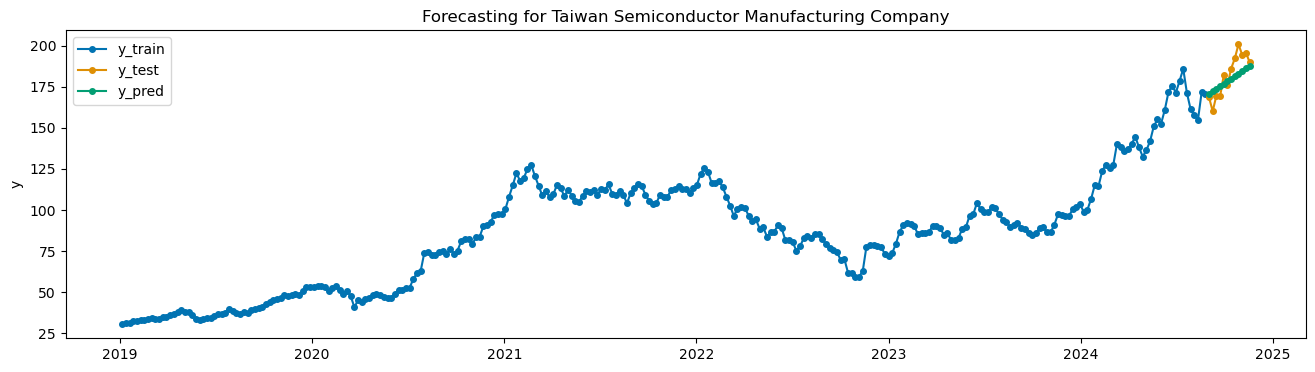

03:52:58 - cmdstanpy - INFO - Chain [1] start processing
03:52:58 - cmdstanpy - INFO - Chain [1] done processing
03:52:58 - cmdstanpy - INFO - Chain [1] start processing



Processing company: Samsung Electronics (5/6)...

Total combinations to test for Samsung Electronics: 1600


03:52:58 - cmdstanpy - INFO - Chain [1] done processing
03:52:59 - cmdstanpy - INFO - Chain [1] start processing
03:52:59 - cmdstanpy - INFO - Chain [1] done processing


03:52:59 - cmdstanpy - INFO - Chain [1] start processing


03:52:59 - cmdstanpy - INFO - Chain [1] done processing
03:52:59 - cmdstanpy - INFO - Chain [1] start processing
03:52:59 - cmdstanpy - INFO - Chain [1] done processing


03:53:00 - cmdstanpy - INFO - Chain [1] start processing


03:53:00 - cmdstanpy - INFO - Chain [1] done processing
03:53:00 - cmdstanpy - INFO - Chain [1] start processing
03:53:00 - cmdstanpy - INFO - Chain [1] done processing


03:53:00 - cmdstanpy - INFO - Chain [1] start processing


03:53:00 - cmdstanpy - INFO - Chain [1] done processing
03:53:00 - cmdstanpy - INFO - Chain [1] start processing
03:53:00 - cmdstanpy - INFO - Chain [1] done processing


03:53:01 - cmdstanpy - INFO - Chain [1] start processing


03:53:01 - cmdstanpy - INFO - Chain [1] done processing
03:53:01 - cmdstanpy - INFO - Chain [1] start processing


03:53:01 - cmdstanpy - INFO - Chain [1] done processing
03:53:01 - cmdstanpy - INFO - Chain [1] start processing


03:53:02 - cmdstanpy - INFO - Chain [1] done processing
03:53:02 - cmdstanpy - INFO - Chain [1] start processing


03:53:02 - cmdstanpy - INFO - Chain [1] done processing
03:53:02 - cmdstanpy - INFO - Chain [1] start processing


03:53:03 - cmdstanpy - INFO - Chain [1] done processing
03:53:03 - cmdstanpy - INFO - Chain [1] start processing
03:53:03 - cmdstanpy - INFO - Chain [1] done processing


03:53:03 - cmdstanpy - INFO - Chain [1] start processing


03:53:03 - cmdstanpy - INFO - Chain [1] done processing
03:53:03 - cmdstanpy - INFO - Chain [1] start processing
03:53:04 - cmdstanpy - INFO - Chain [1] done processing


03:53:04 - cmdstanpy - INFO - Chain [1] start processing


03:53:04 - cmdstanpy - INFO - Chain [1] done processing
03:53:04 - cmdstanpy - INFO - Chain [1] start processing


03:53:04 - cmdstanpy - INFO - Chain [1] done processing
03:53:04 - cmdstanpy - INFO - Chain [1] start processing


03:53:04 - cmdstanpy - INFO - Chain [1] done processing
03:53:05 - cmdstanpy - INFO - Chain [1] start processing


03:53:05 - cmdstanpy - INFO - Chain [1] done processing
03:53:05 - cmdstanpy - INFO - Chain [1] start processing


03:53:05 - cmdstanpy - INFO - Chain [1] done processing
03:53:05 - cmdstanpy - INFO - Chain [1] start processing


03:53:05 - cmdstanpy - INFO - Chain [1] done processing
03:53:05 - cmdstanpy - INFO - Chain [1] start processing
03:53:06 - cmdstanpy - INFO - Chain [1] done processing


03:53:06 - cmdstanpy - INFO - Chain [1] start processing
03:53:06 - cmdstanpy - INFO - Chain [1] done processing


03:53:06 - cmdstanpy - INFO - Chain [1] start processing
03:53:06 - cmdstanpy - INFO - Chain [1] done processing
03:53:06 - cmdstanpy - INFO - Chain [1] start processing


03:53:07 - cmdstanpy - INFO - Chain [1] done processing
03:53:07 - cmdstanpy - INFO - Chain [1] start processing


03:53:07 - cmdstanpy - INFO - Chain [1] done processing
03:53:07 - cmdstanpy - INFO - Chain [1] start processing


03:53:07 - cmdstanpy - INFO - Chain [1] done processing
03:53:08 - cmdstanpy - INFO - Chain [1] start processing


03:53:08 - cmdstanpy - INFO - Chain [1] done processing
03:53:08 - cmdstanpy - INFO - Chain [1] start processing


03:53:08 - cmdstanpy - INFO - Chain [1] done processing
03:53:08 - cmdstanpy - INFO - Chain [1] start processing


03:53:09 - cmdstanpy - INFO - Chain [1] done processing
03:53:09 - cmdstanpy - INFO - Chain [1] start processing
03:53:09 - cmdstanpy - INFO - Chain [1] done processing


03:53:09 - cmdstanpy - INFO - Chain [1] start processing


03:53:09 - cmdstanpy - INFO - Chain [1] done processing
03:53:09 - cmdstanpy - INFO - Chain [1] start processing


03:53:10 - cmdstanpy - INFO - Chain [1] done processing
03:53:10 - cmdstanpy - INFO - Chain [1] start processing


03:53:10 - cmdstanpy - INFO - Chain [1] done processing
03:53:10 - cmdstanpy - INFO - Chain [1] start processing


03:53:10 - cmdstanpy - INFO - Chain [1] done processing
03:53:10 - cmdstanpy - INFO - Chain [1] start processing


03:53:10 - cmdstanpy - INFO - Chain [1] done processing
03:53:11 - cmdstanpy - INFO - Chain [1] start processing
03:53:11 - cmdstanpy - INFO - Chain [1] done processing


03:53:11 - cmdstanpy - INFO - Chain [1] start processing
03:53:11 - cmdstanpy - INFO - Chain [1] done processing


03:53:11 - cmdstanpy - INFO - Chain [1] start processing
03:53:11 - cmdstanpy - INFO - Chain [1] done processing


03:53:11 - cmdstanpy - INFO - Chain [1] start processing


03:53:12 - cmdstanpy - INFO - Chain [1] done processing
03:53:12 - cmdstanpy - INFO - Chain [1] start processing


03:53:12 - cmdstanpy - INFO - Chain [1] done processing
03:53:12 - cmdstanpy - INFO - Chain [1] start processing


03:53:13 - cmdstanpy - INFO - Chain [1] done processing
03:53:13 - cmdstanpy - INFO - Chain [1] start processing


03:53:13 - cmdstanpy - INFO - Chain [1] done processing
03:53:13 - cmdstanpy - INFO - Chain [1] start processing


03:53:13 - cmdstanpy - INFO - Chain [1] done processing
03:53:14 - cmdstanpy - INFO - Chain [1] start processing
03:53:14 - cmdstanpy - INFO - Chain [1] done processing


03:53:14 - cmdstanpy - INFO - Chain [1] start processing


03:53:14 - cmdstanpy - INFO - Chain [1] done processing
03:53:14 - cmdstanpy - INFO - Chain [1] start processing
03:53:14 - cmdstanpy - INFO - Chain [1] done processing


03:53:14 - cmdstanpy - INFO - Chain [1] start processing


03:53:15 - cmdstanpy - INFO - Chain [1] done processing
03:53:15 - cmdstanpy - INFO - Chain [1] start processing


03:53:15 - cmdstanpy - INFO - Chain [1] done processing
03:53:15 - cmdstanpy - INFO - Chain [1] start processing


03:53:15 - cmdstanpy - INFO - Chain [1] done processing
03:53:15 - cmdstanpy - INFO - Chain [1] start processing
03:53:16 - cmdstanpy - INFO - Chain [1] done processing


03:53:16 - cmdstanpy - INFO - Chain [1] start processing


03:53:16 - cmdstanpy - INFO - Chain [1] done processing
03:53:16 - cmdstanpy - INFO - Chain [1] start processing


03:53:16 - cmdstanpy - INFO - Chain [1] done processing
03:53:16 - cmdstanpy - INFO - Chain [1] start processing


03:53:17 - cmdstanpy - INFO - Chain [1] done processing
03:53:17 - cmdstanpy - INFO - Chain [1] start processing
03:53:17 - cmdstanpy - INFO - Chain [1] done processing


03:53:17 - cmdstanpy - INFO - Chain [1] start processing


03:53:17 - cmdstanpy - INFO - Chain [1] done processing
03:53:18 - cmdstanpy - INFO - Chain [1] start processing


03:53:18 - cmdstanpy - INFO - Chain [1] done processing
03:53:18 - cmdstanpy - INFO - Chain [1] start processing


03:53:18 - cmdstanpy - INFO - Chain [1] done processing
03:53:18 - cmdstanpy - INFO - Chain [1] start processing


03:53:19 - cmdstanpy - INFO - Chain [1] done processing
03:53:19 - cmdstanpy - INFO - Chain [1] start processing


03:53:19 - cmdstanpy - INFO - Chain [1] done processing
03:53:19 - cmdstanpy - INFO - Chain [1] start processing
03:53:19 - cmdstanpy - INFO - Chain [1] done processing


03:53:20 - cmdstanpy - INFO - Chain [1] start processing


03:53:20 - cmdstanpy - INFO - Chain [1] done processing
03:53:20 - cmdstanpy - INFO - Chain [1] start processing
03:53:20 - cmdstanpy - INFO - Chain [1] done processing


03:53:20 - cmdstanpy - INFO - Chain [1] start processing
03:53:20 - cmdstanpy - INFO - Chain [1] done processing
03:53:21 - cmdstanpy - INFO - Chain [1] start processing


03:53:21 - cmdstanpy - INFO - Chain [1] done processing
03:53:21 - cmdstanpy - INFO - Chain [1] start processing


03:53:21 - cmdstanpy - INFO - Chain [1] done processing
03:53:21 - cmdstanpy - INFO - Chain [1] start processing
03:53:21 - cmdstanpy - INFO - Chain [1] done processing


03:53:21 - cmdstanpy - INFO - Chain [1] start processing


03:53:22 - cmdstanpy - INFO - Chain [1] done processing
03:53:22 - cmdstanpy - INFO - Chain [1] start processing
03:53:22 - cmdstanpy - INFO - Chain [1] done processing


03:53:22 - cmdstanpy - INFO - Chain [1] start processing


03:53:22 - cmdstanpy - INFO - Chain [1] done processing
03:53:22 - cmdstanpy - INFO - Chain [1] start processing
03:53:22 - cmdstanpy - INFO - Chain [1] done processing


03:53:23 - cmdstanpy - INFO - Chain [1] start processing
03:53:23 - cmdstanpy - INFO - Chain [1] done processing
03:53:23 - cmdstanpy - INFO - Chain [1] start processing


03:53:23 - cmdstanpy - INFO - Chain [1] done processing
03:53:23 - cmdstanpy - INFO - Chain [1] start processing


03:53:24 - cmdstanpy - INFO - Chain [1] done processing
03:53:24 - cmdstanpy - INFO - Chain [1] start processing


03:53:24 - cmdstanpy - INFO - Chain [1] done processing
03:53:24 - cmdstanpy - INFO - Chain [1] start processing


03:53:24 - cmdstanpy - INFO - Chain [1] done processing
03:53:25 - cmdstanpy - INFO - Chain [1] start processing


03:53:25 - cmdstanpy - INFO - Chain [1] done processing
03:53:25 - cmdstanpy - INFO - Chain [1] start processing


03:53:25 - cmdstanpy - INFO - Chain [1] done processing
03:53:25 - cmdstanpy - INFO - Chain [1] start processing
03:53:25 - cmdstanpy - INFO - Chain [1] done processing


03:53:26 - cmdstanpy - INFO - Chain [1] start processing


03:53:26 - cmdstanpy - INFO - Chain [1] done processing
03:53:26 - cmdstanpy - INFO - Chain [1] start processing


03:53:26 - cmdstanpy - INFO - Chain [1] done processing
03:53:26 - cmdstanpy - INFO - Chain [1] start processing


03:53:26 - cmdstanpy - INFO - Chain [1] done processing
03:53:27 - cmdstanpy - INFO - Chain [1] start processing


03:53:27 - cmdstanpy - INFO - Chain [1] done processing
03:53:27 - cmdstanpy - INFO - Chain [1] start processing


03:53:27 - cmdstanpy - INFO - Chain [1] done processing
03:53:27 - cmdstanpy - INFO - Chain [1] start processing
03:53:27 - cmdstanpy - INFO - Chain [1] done processing


03:53:27 - cmdstanpy - INFO - Chain [1] start processing


03:53:28 - cmdstanpy - INFO - Chain [1] done processing
03:53:28 - cmdstanpy - INFO - Chain [1] start processing
03:53:28 - cmdstanpy - INFO - Chain [1] done processing


03:53:28 - cmdstanpy - INFO - Chain [1] start processing
03:53:28 - cmdstanpy - INFO - Chain [1] done processing
03:53:28 - cmdstanpy - INFO - Chain [1] start processing


03:53:29 - cmdstanpy - INFO - Chain [1] done processing
03:53:29 - cmdstanpy - INFO - Chain [1] start processing


03:53:29 - cmdstanpy - INFO - Chain [1] done processing
03:53:29 - cmdstanpy - INFO - Chain [1] start processing


03:53:29 - cmdstanpy - INFO - Chain [1] done processing
03:53:29 - cmdstanpy - INFO - Chain [1] start processing


03:53:30 - cmdstanpy - INFO - Chain [1] done processing
03:53:30 - cmdstanpy - INFO - Chain [1] start processing


03:53:30 - cmdstanpy - INFO - Chain [1] done processing
03:53:30 - cmdstanpy - INFO - Chain [1] start processing


03:53:30 - cmdstanpy - INFO - Chain [1] done processing
03:53:30 - cmdstanpy - INFO - Chain [1] start processing
03:53:31 - cmdstanpy - INFO - Chain [1] done processing


03:53:31 - cmdstanpy - INFO - Chain [1] start processing


03:53:31 - cmdstanpy - INFO - Chain [1] done processing
03:53:31 - cmdstanpy - INFO - Chain [1] start processing


03:53:31 - cmdstanpy - INFO - Chain [1] done processing
03:53:31 - cmdstanpy - INFO - Chain [1] start processing


03:53:31 - cmdstanpy - INFO - Chain [1] done processing
03:53:32 - cmdstanpy - INFO - Chain [1] start processing


03:53:32 - cmdstanpy - INFO - Chain [1] done processing
03:53:32 - cmdstanpy - INFO - Chain [1] start processing


03:53:32 - cmdstanpy - INFO - Chain [1] done processing
03:53:32 - cmdstanpy - INFO - Chain [1] start processing
03:53:32 - cmdstanpy - INFO - Chain [1] done processing


03:53:32 - cmdstanpy - INFO - Chain [1] start processing


03:53:33 - cmdstanpy - INFO - Chain [1] done processing
03:53:33 - cmdstanpy - INFO - Chain [1] start processing
03:53:33 - cmdstanpy - INFO - Chain [1] done processing


03:53:33 - cmdstanpy - INFO - Chain [1] start processing


03:53:33 - cmdstanpy - INFO - Chain [1] done processing
03:53:33 - cmdstanpy - INFO - Chain [1] start processing


03:53:34 - cmdstanpy - INFO - Chain [1] done processing
03:53:34 - cmdstanpy - INFO - Chain [1] start processing


03:53:34 - cmdstanpy - INFO - Chain [1] done processing
03:53:34 - cmdstanpy - INFO - Chain [1] start processing


03:53:35 - cmdstanpy - INFO - Chain [1] done processing
03:53:35 - cmdstanpy - INFO - Chain [1] start processing


03:53:35 - cmdstanpy - INFO - Chain [1] done processing
03:53:35 - cmdstanpy - INFO - Chain [1] start processing
03:53:35 - cmdstanpy - INFO - Chain [1] done processing


03:53:35 - cmdstanpy - INFO - Chain [1] start processing


03:53:36 - cmdstanpy - INFO - Chain [1] done processing
03:53:36 - cmdstanpy - INFO - Chain [1] start processing
03:53:36 - cmdstanpy - INFO - Chain [1] done processing


03:53:36 - cmdstanpy - INFO - Chain [1] start processing


03:53:36 - cmdstanpy - INFO - Chain [1] done processing
03:53:36 - cmdstanpy - INFO - Chain [1] start processing


03:53:36 - cmdstanpy - INFO - Chain [1] done processing
03:53:37 - cmdstanpy - INFO - Chain [1] start processing


03:53:37 - cmdstanpy - INFO - Chain [1] done processing
03:53:37 - cmdstanpy - INFO - Chain [1] start processing


03:53:37 - cmdstanpy - INFO - Chain [1] done processing
03:53:37 - cmdstanpy - INFO - Chain [1] start processing


03:53:37 - cmdstanpy - INFO - Chain [1] done processing
03:53:37 - cmdstanpy - INFO - Chain [1] start processing


03:53:38 - cmdstanpy - INFO - Chain [1] done processing
03:53:38 - cmdstanpy - INFO - Chain [1] start processing


03:53:38 - cmdstanpy - INFO - Chain [1] done processing
03:53:38 - cmdstanpy - INFO - Chain [1] start processing
03:53:38 - cmdstanpy - INFO - Chain [1] done processing


03:53:38 - cmdstanpy - INFO - Chain [1] start processing


03:53:39 - cmdstanpy - INFO - Chain [1] done processing
03:53:39 - cmdstanpy - INFO - Chain [1] start processing


03:53:39 - cmdstanpy - INFO - Chain [1] done processing
03:53:39 - cmdstanpy - INFO - Chain [1] start processing


03:53:40 - cmdstanpy - INFO - Chain [1] done processing
03:53:40 - cmdstanpy - INFO - Chain [1] start processing


03:53:40 - cmdstanpy - INFO - Chain [1] done processing
03:53:40 - cmdstanpy - INFO - Chain [1] start processing


03:53:40 - cmdstanpy - INFO - Chain [1] done processing
03:53:41 - cmdstanpy - INFO - Chain [1] start processing


03:53:41 - cmdstanpy - INFO - Chain [1] done processing
03:53:41 - cmdstanpy - INFO - Chain [1] start processing


03:53:41 - cmdstanpy - INFO - Chain [1] done processing
03:53:41 - cmdstanpy - INFO - Chain [1] start processing
03:53:41 - cmdstanpy - INFO - Chain [1] done processing


03:53:41 - cmdstanpy - INFO - Chain [1] start processing


03:53:42 - cmdstanpy - INFO - Chain [1] done processing
03:53:42 - cmdstanpy - INFO - Chain [1] start processing


03:53:42 - cmdstanpy - INFO - Chain [1] done processing
03:53:42 - cmdstanpy - INFO - Chain [1] start processing


03:53:42 - cmdstanpy - INFO - Chain [1] done processing
03:53:43 - cmdstanpy - INFO - Chain [1] start processing


03:53:43 - cmdstanpy - INFO - Chain [1] done processing
03:53:43 - cmdstanpy - INFO - Chain [1] start processing


03:53:43 - cmdstanpy - INFO - Chain [1] done processing
03:53:43 - cmdstanpy - INFO - Chain [1] start processing


03:53:43 - cmdstanpy - INFO - Chain [1] done processing
03:53:43 - cmdstanpy - INFO - Chain [1] start processing


03:53:44 - cmdstanpy - INFO - Chain [1] done processing
03:53:44 - cmdstanpy - INFO - Chain [1] start processing
03:53:44 - cmdstanpy - INFO - Chain [1] done processing


03:53:44 - cmdstanpy - INFO - Chain [1] start processing


03:53:44 - cmdstanpy - INFO - Chain [1] done processing
03:53:45 - cmdstanpy - INFO - Chain [1] start processing


03:53:45 - cmdstanpy - INFO - Chain [1] done processing
03:53:45 - cmdstanpy - INFO - Chain [1] start processing


03:53:45 - cmdstanpy - INFO - Chain [1] done processing
03:53:45 - cmdstanpy - INFO - Chain [1] start processing


03:53:46 - cmdstanpy - INFO - Chain [1] done processing
03:53:46 - cmdstanpy - INFO - Chain [1] start processing


03:53:46 - cmdstanpy - INFO - Chain [1] done processing
03:53:46 - cmdstanpy - INFO - Chain [1] start processing


03:53:46 - cmdstanpy - INFO - Chain [1] done processing
03:53:47 - cmdstanpy - INFO - Chain [1] start processing


03:53:47 - cmdstanpy - INFO - Chain [1] done processing
03:53:47 - cmdstanpy - INFO - Chain [1] start processing
03:53:47 - cmdstanpy - INFO - Chain [1] done processing


03:53:47 - cmdstanpy - INFO - Chain [1] start processing


03:53:47 - cmdstanpy - INFO - Chain [1] done processing
03:53:48 - cmdstanpy - INFO - Chain [1] start processing


03:53:48 - cmdstanpy - INFO - Chain [1] done processing
03:53:48 - cmdstanpy - INFO - Chain [1] start processing


03:53:48 - cmdstanpy - INFO - Chain [1] done processing
03:53:48 - cmdstanpy - INFO - Chain [1] start processing


03:53:48 - cmdstanpy - INFO - Chain [1] done processing
03:53:49 - cmdstanpy - INFO - Chain [1] start processing


03:53:49 - cmdstanpy - INFO - Chain [1] done processing
03:53:49 - cmdstanpy - INFO - Chain [1] start processing
03:53:49 - cmdstanpy - INFO - Chain [1] done processing


03:53:49 - cmdstanpy - INFO - Chain [1] start processing


03:53:49 - cmdstanpy - INFO - Chain [1] done processing
03:53:49 - cmdstanpy - INFO - Chain [1] start processing
03:53:49 - cmdstanpy - INFO - Chain [1] done processing


03:53:50 - cmdstanpy - INFO - Chain [1] start processing


03:53:50 - cmdstanpy - INFO - Chain [1] done processing
03:53:50 - cmdstanpy - INFO - Chain [1] start processing


03:53:51 - cmdstanpy - INFO - Chain [1] done processing
03:53:51 - cmdstanpy - INFO - Chain [1] start processing


03:53:51 - cmdstanpy - INFO - Chain [1] done processing
03:53:51 - cmdstanpy - INFO - Chain [1] start processing


03:53:51 - cmdstanpy - INFO - Chain [1] done processing
03:53:52 - cmdstanpy - INFO - Chain [1] start processing


03:53:52 - cmdstanpy - INFO - Chain [1] done processing
03:53:52 - cmdstanpy - INFO - Chain [1] start processing
03:53:52 - cmdstanpy - INFO - Chain [1] done processing


03:53:52 - cmdstanpy - INFO - Chain [1] start processing


03:53:53 - cmdstanpy - INFO - Chain [1] done processing
03:53:53 - cmdstanpy - INFO - Chain [1] start processing
03:53:53 - cmdstanpy - INFO - Chain [1] done processing


03:53:53 - cmdstanpy - INFO - Chain [1] start processing


03:53:53 - cmdstanpy - INFO - Chain [1] done processing
03:53:53 - cmdstanpy - INFO - Chain [1] start processing


03:53:53 - cmdstanpy - INFO - Chain [1] done processing
03:53:54 - cmdstanpy - INFO - Chain [1] start processing


03:53:54 - cmdstanpy - INFO - Chain [1] done processing
03:53:54 - cmdstanpy - INFO - Chain [1] start processing


03:53:54 - cmdstanpy - INFO - Chain [1] done processing
03:53:54 - cmdstanpy - INFO - Chain [1] start processing


03:53:54 - cmdstanpy - INFO - Chain [1] done processing
03:53:55 - cmdstanpy - INFO - Chain [1] start processing


03:53:55 - cmdstanpy - INFO - Chain [1] done processing
03:53:55 - cmdstanpy - INFO - Chain [1] start processing


03:53:55 - cmdstanpy - INFO - Chain [1] done processing
03:53:55 - cmdstanpy - INFO - Chain [1] start processing
03:53:55 - cmdstanpy - INFO - Chain [1] done processing


03:53:55 - cmdstanpy - INFO - Chain [1] start processing


03:53:56 - cmdstanpy - INFO - Chain [1] done processing
03:53:56 - cmdstanpy - INFO - Chain [1] start processing


03:53:56 - cmdstanpy - INFO - Chain [1] done processing
03:53:57 - cmdstanpy - INFO - Chain [1] start processing


03:53:57 - cmdstanpy - INFO - Chain [1] done processing
03:53:57 - cmdstanpy - INFO - Chain [1] start processing


03:53:57 - cmdstanpy - INFO - Chain [1] done processing
03:53:57 - cmdstanpy - INFO - Chain [1] start processing


03:53:58 - cmdstanpy - INFO - Chain [1] done processing
03:53:58 - cmdstanpy - INFO - Chain [1] start processing


03:53:58 - cmdstanpy - INFO - Chain [1] done processing
03:53:58 - cmdstanpy - INFO - Chain [1] start processing


03:53:58 - cmdstanpy - INFO - Chain [1] done processing
03:53:58 - cmdstanpy - INFO - Chain [1] start processing
03:53:59 - cmdstanpy - INFO - Chain [1] done processing


03:53:59 - cmdstanpy - INFO - Chain [1] start processing


03:53:59 - cmdstanpy - INFO - Chain [1] done processing
03:53:59 - cmdstanpy - INFO - Chain [1] start processing


03:53:59 - cmdstanpy - INFO - Chain [1] done processing
03:54:00 - cmdstanpy - INFO - Chain [1] start processing


03:54:00 - cmdstanpy - INFO - Chain [1] done processing
03:54:00 - cmdstanpy - INFO - Chain [1] start processing


03:54:00 - cmdstanpy - INFO - Chain [1] done processing
03:54:00 - cmdstanpy - INFO - Chain [1] start processing


03:54:00 - cmdstanpy - INFO - Chain [1] done processing
03:54:01 - cmdstanpy - INFO - Chain [1] start processing


03:54:01 - cmdstanpy - INFO - Chain [1] done processing
03:54:01 - cmdstanpy - INFO - Chain [1] start processing


03:54:01 - cmdstanpy - INFO - Chain [1] done processing
03:54:01 - cmdstanpy - INFO - Chain [1] start processing
03:54:01 - cmdstanpy - INFO - Chain [1] done processing


03:54:01 - cmdstanpy - INFO - Chain [1] start processing


03:54:02 - cmdstanpy - INFO - Chain [1] done processing
03:54:02 - cmdstanpy - INFO - Chain [1] start processing


03:54:02 - cmdstanpy - INFO - Chain [1] done processing
03:54:02 - cmdstanpy - INFO - Chain [1] start processing


03:54:03 - cmdstanpy - INFO - Chain [1] done processing
03:54:03 - cmdstanpy - INFO - Chain [1] start processing


03:54:03 - cmdstanpy - INFO - Chain [1] done processing
03:54:03 - cmdstanpy - INFO - Chain [1] start processing


03:54:03 - cmdstanpy - INFO - Chain [1] done processing
03:54:04 - cmdstanpy - INFO - Chain [1] start processing


03:54:04 - cmdstanpy - INFO - Chain [1] done processing
03:54:04 - cmdstanpy - INFO - Chain [1] start processing


03:54:04 - cmdstanpy - INFO - Chain [1] done processing
03:54:04 - cmdstanpy - INFO - Chain [1] start processing
03:54:04 - cmdstanpy - INFO - Chain [1] done processing


03:54:04 - cmdstanpy - INFO - Chain [1] start processing


03:54:05 - cmdstanpy - INFO - Chain [1] done processing
03:54:05 - cmdstanpy - INFO - Chain [1] start processing


03:54:05 - cmdstanpy - INFO - Chain [1] done processing
03:54:05 - cmdstanpy - INFO - Chain [1] start processing


03:54:05 - cmdstanpy - INFO - Chain [1] done processing
03:54:06 - cmdstanpy - INFO - Chain [1] start processing


03:54:06 - cmdstanpy - INFO - Chain [1] done processing
03:54:06 - cmdstanpy - INFO - Chain [1] start processing


03:54:06 - cmdstanpy - INFO - Chain [1] done processing
03:54:06 - cmdstanpy - INFO - Chain [1] start processing


03:54:06 - cmdstanpy - INFO - Chain [1] done processing
03:54:06 - cmdstanpy - INFO - Chain [1] start processing


03:54:07 - cmdstanpy - INFO - Chain [1] done processing
03:54:07 - cmdstanpy - INFO - Chain [1] start processing


03:54:07 - cmdstanpy - INFO - Chain [1] done processing
03:54:07 - cmdstanpy - INFO - Chain [1] start processing


03:54:07 - cmdstanpy - INFO - Chain [1] done processing
03:54:08 - cmdstanpy - INFO - Chain [1] start processing


03:54:08 - cmdstanpy - INFO - Chain [1] done processing
03:54:08 - cmdstanpy - INFO - Chain [1] start processing


03:54:08 - cmdstanpy - INFO - Chain [1] done processing
03:54:08 - cmdstanpy - INFO - Chain [1] start processing


03:54:09 - cmdstanpy - INFO - Chain [1] done processing
03:54:09 - cmdstanpy - INFO - Chain [1] start processing


03:54:09 - cmdstanpy - INFO - Chain [1] done processing
03:54:09 - cmdstanpy - INFO - Chain [1] start processing
03:54:09 - cmdstanpy - INFO - Chain [1] done processing


03:54:10 - cmdstanpy - INFO - Chain [1] start processing


03:54:10 - cmdstanpy - INFO - Chain [1] done processing
03:54:10 - cmdstanpy - INFO - Chain [1] start processing
03:54:10 - cmdstanpy - INFO - Chain [1] done processing


03:54:10 - cmdstanpy - INFO - Chain [1] start processing


03:54:10 - cmdstanpy - INFO - Chain [1] done processing
03:54:11 - cmdstanpy - INFO - Chain [1] start processing


03:54:11 - cmdstanpy - INFO - Chain [1] done processing
03:54:11 - cmdstanpy - INFO - Chain [1] start processing


03:54:11 - cmdstanpy - INFO - Chain [1] done processing
03:54:11 - cmdstanpy - INFO - Chain [1] start processing


03:54:11 - cmdstanpy - INFO - Chain [1] done processing
03:54:12 - cmdstanpy - INFO - Chain [1] start processing


03:54:12 - cmdstanpy - INFO - Chain [1] done processing
03:54:12 - cmdstanpy - INFO - Chain [1] start processing
03:54:12 - cmdstanpy - INFO - Chain [1] done processing


03:54:12 - cmdstanpy - INFO - Chain [1] start processing


03:54:12 - cmdstanpy - INFO - Chain [1] done processing
03:54:12 - cmdstanpy - INFO - Chain [1] start processing


03:54:13 - cmdstanpy - INFO - Chain [1] done processing
03:54:13 - cmdstanpy - INFO - Chain [1] start processing


03:54:13 - cmdstanpy - INFO - Chain [1] done processing
03:54:13 - cmdstanpy - INFO - Chain [1] start processing


03:54:13 - cmdstanpy - INFO - Chain [1] done processing
03:54:14 - cmdstanpy - INFO - Chain [1] start processing


03:54:14 - cmdstanpy - INFO - Chain [1] done processing
03:54:14 - cmdstanpy - INFO - Chain [1] start processing


03:54:14 - cmdstanpy - INFO - Chain [1] done processing
03:54:14 - cmdstanpy - INFO - Chain [1] start processing


03:54:15 - cmdstanpy - INFO - Chain [1] done processing
03:54:15 - cmdstanpy - INFO - Chain [1] start processing


03:54:15 - cmdstanpy - INFO - Chain [1] done processing
03:54:15 - cmdstanpy - INFO - Chain [1] start processing


03:54:15 - cmdstanpy - INFO - Chain [1] done processing
03:54:16 - cmdstanpy - INFO - Chain [1] start processing
03:54:16 - cmdstanpy - INFO - Chain [1] done processing


03:54:16 - cmdstanpy - INFO - Chain [1] start processing


03:54:16 - cmdstanpy - INFO - Chain [1] done processing
03:54:16 - cmdstanpy - INFO - Chain [1] start processing


03:54:16 - cmdstanpy - INFO - Chain [1] done processing
03:54:16 - cmdstanpy - INFO - Chain [1] start processing


03:54:17 - cmdstanpy - INFO - Chain [1] done processing
03:54:17 - cmdstanpy - INFO - Chain [1] start processing


03:54:17 - cmdstanpy - INFO - Chain [1] done processing
03:54:17 - cmdstanpy - INFO - Chain [1] start processing


03:54:17 - cmdstanpy - INFO - Chain [1] done processing
03:54:17 - cmdstanpy - INFO - Chain [1] start processing


03:54:18 - cmdstanpy - INFO - Chain [1] done processing
03:54:18 - cmdstanpy - INFO - Chain [1] start processing


03:54:18 - cmdstanpy - INFO - Chain [1] done processing
03:54:18 - cmdstanpy - INFO - Chain [1] start processing
03:54:18 - cmdstanpy - INFO - Chain [1] done processing


03:54:18 - cmdstanpy - INFO - Chain [1] start processing


03:54:19 - cmdstanpy - INFO - Chain [1] done processing
03:54:19 - cmdstanpy - INFO - Chain [1] start processing


03:54:19 - cmdstanpy - INFO - Chain [1] done processing
03:54:19 - cmdstanpy - INFO - Chain [1] start processing


03:54:20 - cmdstanpy - INFO - Chain [1] done processing
03:54:20 - cmdstanpy - INFO - Chain [1] start processing


03:54:20 - cmdstanpy - INFO - Chain [1] done processing
03:54:20 - cmdstanpy - INFO - Chain [1] start processing


03:54:20 - cmdstanpy - INFO - Chain [1] done processing
03:54:21 - cmdstanpy - INFO - Chain [1] start processing
03:54:21 - cmdstanpy - INFO - Chain [1] done processing


03:54:21 - cmdstanpy - INFO - Chain [1] start processing


03:54:21 - cmdstanpy - INFO - Chain [1] done processing
03:54:21 - cmdstanpy - INFO - Chain [1] start processing


03:54:21 - cmdstanpy - INFO - Chain [1] done processing
03:54:22 - cmdstanpy - INFO - Chain [1] start processing


03:54:22 - cmdstanpy - INFO - Chain [1] done processing
03:54:22 - cmdstanpy - INFO - Chain [1] start processing


03:54:22 - cmdstanpy - INFO - Chain [1] done processing
03:54:22 - cmdstanpy - INFO - Chain [1] start processing


03:54:22 - cmdstanpy - INFO - Chain [1] done processing
03:54:23 - cmdstanpy - INFO - Chain [1] start processing


03:54:23 - cmdstanpy - INFO - Chain [1] done processing
03:54:23 - cmdstanpy - INFO - Chain [1] start processing


03:54:23 - cmdstanpy - INFO - Chain [1] done processing
03:54:23 - cmdstanpy - INFO - Chain [1] start processing


03:54:23 - cmdstanpy - INFO - Chain [1] done processing
03:54:24 - cmdstanpy - INFO - Chain [1] start processing


03:54:24 - cmdstanpy - INFO - Chain [1] done processing
03:54:24 - cmdstanpy - INFO - Chain [1] start processing


03:54:24 - cmdstanpy - INFO - Chain [1] done processing
03:54:24 - cmdstanpy - INFO - Chain [1] start processing


03:54:24 - cmdstanpy - INFO - Chain [1] done processing
03:54:25 - cmdstanpy - INFO - Chain [1] start processing


03:54:25 - cmdstanpy - INFO - Chain [1] done processing
03:54:25 - cmdstanpy - INFO - Chain [1] start processing


03:54:25 - cmdstanpy - INFO - Chain [1] done processing
03:54:26 - cmdstanpy - INFO - Chain [1] start processing


03:54:26 - cmdstanpy - INFO - Chain [1] done processing
03:54:26 - cmdstanpy - INFO - Chain [1] start processing


03:54:26 - cmdstanpy - INFO - Chain [1] done processing
03:54:27 - cmdstanpy - INFO - Chain [1] start processing


03:54:27 - cmdstanpy - INFO - Chain [1] done processing
03:54:27 - cmdstanpy - INFO - Chain [1] start processing


03:54:27 - cmdstanpy - INFO - Chain [1] done processing
03:54:27 - cmdstanpy - INFO - Chain [1] start processing
03:54:27 - cmdstanpy - INFO - Chain [1] done processing


03:54:28 - cmdstanpy - INFO - Chain [1] start processing


03:54:28 - cmdstanpy - INFO - Chain [1] done processing
03:54:28 - cmdstanpy - INFO - Chain [1] start processing


03:54:28 - cmdstanpy - INFO - Chain [1] done processing
03:54:28 - cmdstanpy - INFO - Chain [1] start processing


03:54:28 - cmdstanpy - INFO - Chain [1] done processing
03:54:29 - cmdstanpy - INFO - Chain [1] start processing


03:54:29 - cmdstanpy - INFO - Chain [1] done processing
03:54:29 - cmdstanpy - INFO - Chain [1] start processing


03:54:29 - cmdstanpy - INFO - Chain [1] done processing
03:54:29 - cmdstanpy - INFO - Chain [1] start processing


03:54:29 - cmdstanpy - INFO - Chain [1] done processing
03:54:30 - cmdstanpy - INFO - Chain [1] start processing


03:54:30 - cmdstanpy - INFO - Chain [1] done processing
03:54:30 - cmdstanpy - INFO - Chain [1] start processing
03:54:30 - cmdstanpy - INFO - Chain [1] done processing


03:54:30 - cmdstanpy - INFO - Chain [1] start processing


03:54:31 - cmdstanpy - INFO - Chain [1] done processing
03:54:31 - cmdstanpy - INFO - Chain [1] start processing


03:54:31 - cmdstanpy - INFO - Chain [1] done processing
03:54:31 - cmdstanpy - INFO - Chain [1] start processing


03:54:31 - cmdstanpy - INFO - Chain [1] done processing
03:54:32 - cmdstanpy - INFO - Chain [1] start processing


03:54:32 - cmdstanpy - INFO - Chain [1] done processing
03:54:32 - cmdstanpy - INFO - Chain [1] start processing


03:54:32 - cmdstanpy - INFO - Chain [1] done processing
03:54:32 - cmdstanpy - INFO - Chain [1] start processing


03:54:33 - cmdstanpy - INFO - Chain [1] done processing
03:54:33 - cmdstanpy - INFO - Chain [1] start processing


03:54:33 - cmdstanpy - INFO - Chain [1] done processing
03:54:33 - cmdstanpy - INFO - Chain [1] start processing
03:54:33 - cmdstanpy - INFO - Chain [1] done processing


03:54:33 - cmdstanpy - INFO - Chain [1] start processing


03:54:34 - cmdstanpy - INFO - Chain [1] done processing
03:54:34 - cmdstanpy - INFO - Chain [1] start processing


03:54:34 - cmdstanpy - INFO - Chain [1] done processing
03:54:34 - cmdstanpy - INFO - Chain [1] start processing


03:54:34 - cmdstanpy - INFO - Chain [1] done processing
03:54:34 - cmdstanpy - INFO - Chain [1] start processing


03:54:35 - cmdstanpy - INFO - Chain [1] done processing
03:54:35 - cmdstanpy - INFO - Chain [1] start processing


03:54:35 - cmdstanpy - INFO - Chain [1] done processing
03:54:35 - cmdstanpy - INFO - Chain [1] start processing


03:54:35 - cmdstanpy - INFO - Chain [1] done processing
03:54:35 - cmdstanpy - INFO - Chain [1] start processing


03:54:36 - cmdstanpy - INFO - Chain [1] done processing
03:54:36 - cmdstanpy - INFO - Chain [1] start processing


03:54:36 - cmdstanpy - INFO - Chain [1] done processing
03:54:36 - cmdstanpy - INFO - Chain [1] start processing


03:54:36 - cmdstanpy - INFO - Chain [1] done processing
03:54:37 - cmdstanpy - INFO - Chain [1] start processing


03:54:37 - cmdstanpy - INFO - Chain [1] done processing
03:54:37 - cmdstanpy - INFO - Chain [1] start processing


03:54:38 - cmdstanpy - INFO - Chain [1] done processing
03:54:38 - cmdstanpy - INFO - Chain [1] start processing


03:54:38 - cmdstanpy - INFO - Chain [1] done processing
03:54:38 - cmdstanpy - INFO - Chain [1] start processing


03:54:38 - cmdstanpy - INFO - Chain [1] done processing
03:54:39 - cmdstanpy - INFO - Chain [1] start processing


03:54:39 - cmdstanpy - INFO - Chain [1] done processing
03:54:39 - cmdstanpy - INFO - Chain [1] start processing


03:54:39 - cmdstanpy - INFO - Chain [1] done processing
03:54:39 - cmdstanpy - INFO - Chain [1] start processing
03:54:39 - cmdstanpy - INFO - Chain [1] done processing


03:54:40 - cmdstanpy - INFO - Chain [1] start processing


03:54:40 - cmdstanpy - INFO - Chain [1] done processing
03:54:40 - cmdstanpy - INFO - Chain [1] start processing


03:54:40 - cmdstanpy - INFO - Chain [1] done processing
03:54:40 - cmdstanpy - INFO - Chain [1] start processing


03:54:40 - cmdstanpy - INFO - Chain [1] done processing
03:54:41 - cmdstanpy - INFO - Chain [1] start processing


03:54:41 - cmdstanpy - INFO - Chain [1] done processing
03:54:41 - cmdstanpy - INFO - Chain [1] start processing


03:54:41 - cmdstanpy - INFO - Chain [1] done processing
03:54:41 - cmdstanpy - INFO - Chain [1] start processing


03:54:41 - cmdstanpy - INFO - Chain [1] done processing
03:54:42 - cmdstanpy - INFO - Chain [1] start processing


03:54:42 - cmdstanpy - INFO - Chain [1] done processing
03:54:42 - cmdstanpy - INFO - Chain [1] start processing


03:54:42 - cmdstanpy - INFO - Chain [1] done processing
03:54:42 - cmdstanpy - INFO - Chain [1] start processing


03:54:42 - cmdstanpy - INFO - Chain [1] done processing
03:54:43 - cmdstanpy - INFO - Chain [1] start processing


03:54:43 - cmdstanpy - INFO - Chain [1] done processing
03:54:43 - cmdstanpy - INFO - Chain [1] start processing


03:54:43 - cmdstanpy - INFO - Chain [1] done processing
03:54:43 - cmdstanpy - INFO - Chain [1] start processing


03:54:44 - cmdstanpy - INFO - Chain [1] done processing
03:54:44 - cmdstanpy - INFO - Chain [1] start processing


03:54:44 - cmdstanpy - INFO - Chain [1] done processing
03:54:44 - cmdstanpy - INFO - Chain [1] start processing


03:54:45 - cmdstanpy - INFO - Chain [1] done processing
03:54:45 - cmdstanpy - INFO - Chain [1] start processing


03:54:45 - cmdstanpy - INFO - Chain [1] done processing
03:54:45 - cmdstanpy - INFO - Chain [1] start processing
03:54:45 - cmdstanpy - INFO - Chain [1] done processing


03:54:45 - cmdstanpy - INFO - Chain [1] start processing


03:54:46 - cmdstanpy - INFO - Chain [1] done processing
03:54:46 - cmdstanpy - INFO - Chain [1] start processing


03:54:46 - cmdstanpy - INFO - Chain [1] done processing
03:54:46 - cmdstanpy - INFO - Chain [1] start processing


03:54:46 - cmdstanpy - INFO - Chain [1] done processing
03:54:46 - cmdstanpy - INFO - Chain [1] start processing
03:54:47 - cmdstanpy - INFO - Chain [1] done processing


03:54:47 - cmdstanpy - INFO - Chain [1] start processing


03:54:47 - cmdstanpy - INFO - Chain [1] done processing
03:54:47 - cmdstanpy - INFO - Chain [1] start processing


03:54:47 - cmdstanpy - INFO - Chain [1] done processing
03:54:47 - cmdstanpy - INFO - Chain [1] start processing
03:54:47 - cmdstanpy - INFO - Chain [1] done processing


03:54:48 - cmdstanpy - INFO - Chain [1] start processing


03:54:48 - cmdstanpy - INFO - Chain [1] done processing
03:54:48 - cmdstanpy - INFO - Chain [1] start processing


03:54:48 - cmdstanpy - INFO - Chain [1] done processing
03:54:48 - cmdstanpy - INFO - Chain [1] start processing


03:54:49 - cmdstanpy - INFO - Chain [1] done processing
03:54:49 - cmdstanpy - INFO - Chain [1] start processing


03:54:49 - cmdstanpy - INFO - Chain [1] done processing
03:54:49 - cmdstanpy - INFO - Chain [1] start processing


03:54:49 - cmdstanpy - INFO - Chain [1] done processing
03:54:50 - cmdstanpy - INFO - Chain [1] start processing


03:54:50 - cmdstanpy - INFO - Chain [1] done processing
03:54:50 - cmdstanpy - INFO - Chain [1] start processing


03:54:50 - cmdstanpy - INFO - Chain [1] done processing
03:54:50 - cmdstanpy - INFO - Chain [1] start processing


03:54:51 - cmdstanpy - INFO - Chain [1] done processing
03:54:51 - cmdstanpy - INFO - Chain [1] start processing
03:54:51 - cmdstanpy - INFO - Chain [1] done processing


03:54:51 - cmdstanpy - INFO - Chain [1] start processing


03:54:51 - cmdstanpy - INFO - Chain [1] done processing
03:54:52 - cmdstanpy - INFO - Chain [1] start processing


03:54:52 - cmdstanpy - INFO - Chain [1] done processing
03:54:52 - cmdstanpy - INFO - Chain [1] start processing


03:54:52 - cmdstanpy - INFO - Chain [1] done processing
03:54:52 - cmdstanpy - INFO - Chain [1] start processing


03:54:52 - cmdstanpy - INFO - Chain [1] done processing
03:54:52 - cmdstanpy - INFO - Chain [1] start processing


03:54:53 - cmdstanpy - INFO - Chain [1] done processing
03:54:53 - cmdstanpy - INFO - Chain [1] start processing


03:54:53 - cmdstanpy - INFO - Chain [1] done processing
03:54:53 - cmdstanpy - INFO - Chain [1] start processing


03:54:53 - cmdstanpy - INFO - Chain [1] done processing
03:54:53 - cmdstanpy - INFO - Chain [1] start processing
03:54:54 - cmdstanpy - INFO - Chain [1] done processing


03:54:54 - cmdstanpy - INFO - Chain [1] start processing


03:54:54 - cmdstanpy - INFO - Chain [1] done processing
03:54:54 - cmdstanpy - INFO - Chain [1] start processing


03:54:54 - cmdstanpy - INFO - Chain [1] done processing
03:54:55 - cmdstanpy - INFO - Chain [1] start processing


03:54:55 - cmdstanpy - INFO - Chain [1] done processing
03:54:55 - cmdstanpy - INFO - Chain [1] start processing


03:54:55 - cmdstanpy - INFO - Chain [1] done processing
03:54:55 - cmdstanpy - INFO - Chain [1] start processing


03:54:56 - cmdstanpy - INFO - Chain [1] done processing
03:54:56 - cmdstanpy - INFO - Chain [1] start processing


03:54:56 - cmdstanpy - INFO - Chain [1] done processing
03:54:56 - cmdstanpy - INFO - Chain [1] start processing


03:54:56 - cmdstanpy - INFO - Chain [1] done processing
03:54:57 - cmdstanpy - INFO - Chain [1] start processing


03:54:57 - cmdstanpy - INFO - Chain [1] done processing
03:54:57 - cmdstanpy - INFO - Chain [1] start processing


03:54:57 - cmdstanpy - INFO - Chain [1] done processing
03:54:57 - cmdstanpy - INFO - Chain [1] start processing


03:54:57 - cmdstanpy - INFO - Chain [1] done processing
03:54:58 - cmdstanpy - INFO - Chain [1] start processing


03:54:58 - cmdstanpy - INFO - Chain [1] done processing
03:54:58 - cmdstanpy - INFO - Chain [1] start processing
03:54:58 - cmdstanpy - INFO - Chain [1] done processing


03:54:58 - cmdstanpy - INFO - Chain [1] start processing


03:54:58 - cmdstanpy - INFO - Chain [1] done processing
03:54:59 - cmdstanpy - INFO - Chain [1] start processing


03:54:59 - cmdstanpy - INFO - Chain [1] done processing
03:54:59 - cmdstanpy - INFO - Chain [1] start processing
03:54:59 - cmdstanpy - INFO - Chain [1] done processing


03:54:59 - cmdstanpy - INFO - Chain [1] start processing
03:54:59 - cmdstanpy - INFO - Chain [1] done processing


03:54:59 - cmdstanpy - INFO - Chain [1] start processing


03:55:00 - cmdstanpy - INFO - Chain [1] done processing
03:55:00 - cmdstanpy - INFO - Chain [1] start processing


03:55:00 - cmdstanpy - INFO - Chain [1] done processing
03:55:00 - cmdstanpy - INFO - Chain [1] start processing


03:55:01 - cmdstanpy - INFO - Chain [1] done processing
03:55:01 - cmdstanpy - INFO - Chain [1] start processing


03:55:01 - cmdstanpy - INFO - Chain [1] done processing
03:55:01 - cmdstanpy - INFO - Chain [1] start processing


03:55:01 - cmdstanpy - INFO - Chain [1] done processing
03:55:02 - cmdstanpy - INFO - Chain [1] start processing


03:55:02 - cmdstanpy - INFO - Chain [1] done processing
03:55:02 - cmdstanpy - INFO - Chain [1] start processing


03:55:02 - cmdstanpy - INFO - Chain [1] done processing
03:55:02 - cmdstanpy - INFO - Chain [1] start processing


03:55:02 - cmdstanpy - INFO - Chain [1] done processing
03:55:03 - cmdstanpy - INFO - Chain [1] start processing


03:55:03 - cmdstanpy - INFO - Chain [1] done processing
03:55:03 - cmdstanpy - INFO - Chain [1] start processing


03:55:03 - cmdstanpy - INFO - Chain [1] done processing
03:55:03 - cmdstanpy - INFO - Chain [1] start processing


03:55:03 - cmdstanpy - INFO - Chain [1] done processing
03:55:04 - cmdstanpy - INFO - Chain [1] start processing
03:55:04 - cmdstanpy - INFO - Chain [1] done processing


03:55:04 - cmdstanpy - INFO - Chain [1] start processing


03:55:04 - cmdstanpy - INFO - Chain [1] done processing
03:55:04 - cmdstanpy - INFO - Chain [1] start processing


03:55:04 - cmdstanpy - INFO - Chain [1] done processing
03:55:05 - cmdstanpy - INFO - Chain [1] start processing


03:55:05 - cmdstanpy - INFO - Chain [1] done processing
03:55:05 - cmdstanpy - INFO - Chain [1] start processing
03:55:05 - cmdstanpy - INFO - Chain [1] done processing


03:55:05 - cmdstanpy - INFO - Chain [1] start processing


03:55:05 - cmdstanpy - INFO - Chain [1] done processing
03:55:05 - cmdstanpy - INFO - Chain [1] start processing


03:55:06 - cmdstanpy - INFO - Chain [1] done processing
03:55:06 - cmdstanpy - INFO - Chain [1] start processing


03:55:06 - cmdstanpy - INFO - Chain [1] done processing
03:55:06 - cmdstanpy - INFO - Chain [1] start processing


03:55:07 - cmdstanpy - INFO - Chain [1] done processing
03:55:07 - cmdstanpy - INFO - Chain [1] start processing


03:55:07 - cmdstanpy - INFO - Chain [1] done processing
03:55:07 - cmdstanpy - INFO - Chain [1] start processing


03:55:07 - cmdstanpy - INFO - Chain [1] done processing
03:55:07 - cmdstanpy - INFO - Chain [1] start processing


03:55:08 - cmdstanpy - INFO - Chain [1] done processing
03:55:08 - cmdstanpy - INFO - Chain [1] start processing
03:55:08 - cmdstanpy - INFO - Chain [1] done processing


03:55:08 - cmdstanpy - INFO - Chain [1] start processing


03:55:08 - cmdstanpy - INFO - Chain [1] done processing
03:55:08 - cmdstanpy - INFO - Chain [1] start processing


03:55:09 - cmdstanpy - INFO - Chain [1] done processing
03:55:09 - cmdstanpy - INFO - Chain [1] start processing


03:55:09 - cmdstanpy - INFO - Chain [1] done processing
03:55:09 - cmdstanpy - INFO - Chain [1] start processing


03:55:09 - cmdstanpy - INFO - Chain [1] done processing
03:55:09 - cmdstanpy - INFO - Chain [1] start processing


03:55:10 - cmdstanpy - INFO - Chain [1] done processing
03:55:10 - cmdstanpy - INFO - Chain [1] start processing


03:55:10 - cmdstanpy - INFO - Chain [1] done processing
03:55:10 - cmdstanpy - INFO - Chain [1] start processing


03:55:10 - cmdstanpy - INFO - Chain [1] done processing
03:55:10 - cmdstanpy - INFO - Chain [1] start processing
03:55:11 - cmdstanpy - INFO - Chain [1] done processing


03:55:11 - cmdstanpy - INFO - Chain [1] start processing


03:55:11 - cmdstanpy - INFO - Chain [1] done processing
03:55:11 - cmdstanpy - INFO - Chain [1] start processing


03:55:11 - cmdstanpy - INFO - Chain [1] done processing
03:55:12 - cmdstanpy - INFO - Chain [1] start processing


03:55:12 - cmdstanpy - INFO - Chain [1] done processing
03:55:12 - cmdstanpy - INFO - Chain [1] start processing


03:55:12 - cmdstanpy - INFO - Chain [1] done processing
03:55:12 - cmdstanpy - INFO - Chain [1] start processing


03:55:13 - cmdstanpy - INFO - Chain [1] done processing
03:55:13 - cmdstanpy - INFO - Chain [1] start processing


03:55:13 - cmdstanpy - INFO - Chain [1] done processing
03:55:13 - cmdstanpy - INFO - Chain [1] start processing


03:55:13 - cmdstanpy - INFO - Chain [1] done processing
03:55:14 - cmdstanpy - INFO - Chain [1] start processing
03:55:14 - cmdstanpy - INFO - Chain [1] done processing


03:55:14 - cmdstanpy - INFO - Chain [1] start processing


03:55:14 - cmdstanpy - INFO - Chain [1] done processing
03:55:14 - cmdstanpy - INFO - Chain [1] start processing


03:55:14 - cmdstanpy - INFO - Chain [1] done processing
03:55:15 - cmdstanpy - INFO - Chain [1] start processing


03:55:15 - cmdstanpy - INFO - Chain [1] done processing
03:55:15 - cmdstanpy - INFO - Chain [1] start processing


03:55:15 - cmdstanpy - INFO - Chain [1] done processing
03:55:15 - cmdstanpy - INFO - Chain [1] start processing


03:55:15 - cmdstanpy - INFO - Chain [1] done processing
03:55:16 - cmdstanpy - INFO - Chain [1] start processing


03:55:16 - cmdstanpy - INFO - Chain [1] done processing
03:55:16 - cmdstanpy - INFO - Chain [1] start processing


03:55:16 - cmdstanpy - INFO - Chain [1] done processing
03:55:16 - cmdstanpy - INFO - Chain [1] start processing
03:55:16 - cmdstanpy - INFO - Chain [1] done processing


03:55:16 - cmdstanpy - INFO - Chain [1] start processing


03:55:17 - cmdstanpy - INFO - Chain [1] done processing
03:55:17 - cmdstanpy - INFO - Chain [1] start processing


03:55:17 - cmdstanpy - INFO - Chain [1] done processing
03:55:17 - cmdstanpy - INFO - Chain [1] start processing


03:55:18 - cmdstanpy - INFO - Chain [1] done processing
03:55:18 - cmdstanpy - INFO - Chain [1] start processing


03:55:18 - cmdstanpy - INFO - Chain [1] done processing
03:55:18 - cmdstanpy - INFO - Chain [1] start processing


03:55:18 - cmdstanpy - INFO - Chain [1] done processing
03:55:19 - cmdstanpy - INFO - Chain [1] start processing


03:55:19 - cmdstanpy - INFO - Chain [1] done processing
03:55:19 - cmdstanpy - INFO - Chain [1] start processing


03:55:19 - cmdstanpy - INFO - Chain [1] done processing
03:55:19 - cmdstanpy - INFO - Chain [1] start processing
03:55:19 - cmdstanpy - INFO - Chain [1] done processing


03:55:19 - cmdstanpy - INFO - Chain [1] start processing


03:55:20 - cmdstanpy - INFO - Chain [1] done processing
03:55:20 - cmdstanpy - INFO - Chain [1] start processing


03:55:20 - cmdstanpy - INFO - Chain [1] done processing
03:55:20 - cmdstanpy - INFO - Chain [1] start processing


03:55:20 - cmdstanpy - INFO - Chain [1] done processing
03:55:20 - cmdstanpy - INFO - Chain [1] start processing


03:55:21 - cmdstanpy - INFO - Chain [1] done processing
03:55:21 - cmdstanpy - INFO - Chain [1] start processing


03:55:21 - cmdstanpy - INFO - Chain [1] done processing
03:55:21 - cmdstanpy - INFO - Chain [1] start processing


03:55:21 - cmdstanpy - INFO - Chain [1] done processing
03:55:21 - cmdstanpy - INFO - Chain [1] start processing


03:55:22 - cmdstanpy - INFO - Chain [1] done processing
03:55:22 - cmdstanpy - INFO - Chain [1] start processing
03:55:22 - cmdstanpy - INFO - Chain [1] done processing


03:55:22 - cmdstanpy - INFO - Chain [1] start processing


03:55:22 - cmdstanpy - INFO - Chain [1] done processing
03:55:23 - cmdstanpy - INFO - Chain [1] start processing


03:55:23 - cmdstanpy - INFO - Chain [1] done processing
03:55:23 - cmdstanpy - INFO - Chain [1] start processing


03:55:23 - cmdstanpy - INFO - Chain [1] done processing
03:55:23 - cmdstanpy - INFO - Chain [1] start processing


03:55:24 - cmdstanpy - INFO - Chain [1] done processing
03:55:24 - cmdstanpy - INFO - Chain [1] start processing


03:55:24 - cmdstanpy - INFO - Chain [1] done processing
03:55:24 - cmdstanpy - INFO - Chain [1] start processing


03:55:25 - cmdstanpy - INFO - Chain [1] done processing
03:55:25 - cmdstanpy - INFO - Chain [1] start processing


03:55:25 - cmdstanpy - INFO - Chain [1] done processing
03:55:25 - cmdstanpy - INFO - Chain [1] start processing
03:55:25 - cmdstanpy - INFO - Chain [1] done processing


03:55:25 - cmdstanpy - INFO - Chain [1] start processing


03:55:26 - cmdstanpy - INFO - Chain [1] done processing
03:55:26 - cmdstanpy - INFO - Chain [1] start processing


03:55:26 - cmdstanpy - INFO - Chain [1] done processing
03:55:26 - cmdstanpy - INFO - Chain [1] start processing


03:55:26 - cmdstanpy - INFO - Chain [1] done processing
03:55:26 - cmdstanpy - INFO - Chain [1] start processing


03:55:27 - cmdstanpy - INFO - Chain [1] done processing
03:55:27 - cmdstanpy - INFO - Chain [1] start processing


03:55:27 - cmdstanpy - INFO - Chain [1] done processing
03:55:27 - cmdstanpy - INFO - Chain [1] start processing


03:55:27 - cmdstanpy - INFO - Chain [1] done processing
03:55:27 - cmdstanpy - INFO - Chain [1] start processing


03:55:28 - cmdstanpy - INFO - Chain [1] done processing
03:55:28 - cmdstanpy - INFO - Chain [1] start processing


03:55:28 - cmdstanpy - INFO - Chain [1] done processing
03:55:28 - cmdstanpy - INFO - Chain [1] start processing


03:55:29 - cmdstanpy - INFO - Chain [1] done processing
03:55:29 - cmdstanpy - INFO - Chain [1] start processing


03:55:29 - cmdstanpy - INFO - Chain [1] done processing
03:55:29 - cmdstanpy - INFO - Chain [1] start processing


03:55:29 - cmdstanpy - INFO - Chain [1] done processing
03:55:30 - cmdstanpy - INFO - Chain [1] start processing


03:55:30 - cmdstanpy - INFO - Chain [1] done processing
03:55:30 - cmdstanpy - INFO - Chain [1] start processing


03:55:30 - cmdstanpy - INFO - Chain [1] done processing
03:55:31 - cmdstanpy - INFO - Chain [1] start processing


03:55:31 - cmdstanpy - INFO - Chain [1] done processing
03:55:31 - cmdstanpy - INFO - Chain [1] start processing


03:55:31 - cmdstanpy - INFO - Chain [1] done processing
03:55:31 - cmdstanpy - INFO - Chain [1] start processing
03:55:31 - cmdstanpy - INFO - Chain [1] done processing


03:55:32 - cmdstanpy - INFO - Chain [1] start processing


03:55:32 - cmdstanpy - INFO - Chain [1] done processing
03:55:32 - cmdstanpy - INFO - Chain [1] start processing


03:55:32 - cmdstanpy - INFO - Chain [1] done processing
03:55:32 - cmdstanpy - INFO - Chain [1] start processing


03:55:32 - cmdstanpy - INFO - Chain [1] done processing
03:55:33 - cmdstanpy - INFO - Chain [1] start processing


03:55:33 - cmdstanpy - INFO - Chain [1] done processing
03:55:33 - cmdstanpy - INFO - Chain [1] start processing


03:55:33 - cmdstanpy - INFO - Chain [1] done processing
03:55:33 - cmdstanpy - INFO - Chain [1] start processing


03:55:33 - cmdstanpy - INFO - Chain [1] done processing
03:55:33 - cmdstanpy - INFO - Chain [1] start processing
03:55:34 - cmdstanpy - INFO - Chain [1] done processing


03:55:34 - cmdstanpy - INFO - Chain [1] start processing
03:55:34 - cmdstanpy - INFO - Chain [1] done processing


03:55:34 - cmdstanpy - INFO - Chain [1] start processing


03:55:34 - cmdstanpy - INFO - Chain [1] done processing
03:55:35 - cmdstanpy - INFO - Chain [1] start processing


03:55:35 - cmdstanpy - INFO - Chain [1] done processing
03:55:35 - cmdstanpy - INFO - Chain [1] start processing


03:55:35 - cmdstanpy - INFO - Chain [1] done processing
03:55:35 - cmdstanpy - INFO - Chain [1] start processing


03:55:36 - cmdstanpy - INFO - Chain [1] done processing
03:55:36 - cmdstanpy - INFO - Chain [1] start processing


03:55:36 - cmdstanpy - INFO - Chain [1] done processing
03:55:36 - cmdstanpy - INFO - Chain [1] start processing


03:55:36 - cmdstanpy - INFO - Chain [1] done processing
03:55:37 - cmdstanpy - INFO - Chain [1] start processing


03:55:37 - cmdstanpy - INFO - Chain [1] done processing
03:55:37 - cmdstanpy - INFO - Chain [1] start processing
03:55:37 - cmdstanpy - INFO - Chain [1] done processing


03:55:37 - cmdstanpy - INFO - Chain [1] start processing


03:55:37 - cmdstanpy - INFO - Chain [1] done processing
03:55:37 - cmdstanpy - INFO - Chain [1] start processing


03:55:38 - cmdstanpy - INFO - Chain [1] done processing
03:55:38 - cmdstanpy - INFO - Chain [1] start processing


03:55:38 - cmdstanpy - INFO - Chain [1] done processing
03:55:38 - cmdstanpy - INFO - Chain [1] start processing


03:55:38 - cmdstanpy - INFO - Chain [1] done processing
03:55:38 - cmdstanpy - INFO - Chain [1] start processing


03:55:39 - cmdstanpy - INFO - Chain [1] done processing
03:55:39 - cmdstanpy - INFO - Chain [1] start processing


03:55:39 - cmdstanpy - INFO - Chain [1] done processing
03:55:39 - cmdstanpy - INFO - Chain [1] start processing


03:55:39 - cmdstanpy - INFO - Chain [1] done processing
03:55:39 - cmdstanpy - INFO - Chain [1] start processing
03:55:39 - cmdstanpy - INFO - Chain [1] done processing


03:55:40 - cmdstanpy - INFO - Chain [1] start processing


03:55:40 - cmdstanpy - INFO - Chain [1] done processing
03:55:40 - cmdstanpy - INFO - Chain [1] start processing


03:55:40 - cmdstanpy - INFO - Chain [1] done processing
03:55:40 - cmdstanpy - INFO - Chain [1] start processing


03:55:41 - cmdstanpy - INFO - Chain [1] done processing
03:55:41 - cmdstanpy - INFO - Chain [1] start processing


03:55:41 - cmdstanpy - INFO - Chain [1] done processing
03:55:41 - cmdstanpy - INFO - Chain [1] start processing


03:55:42 - cmdstanpy - INFO - Chain [1] done processing
03:55:42 - cmdstanpy - INFO - Chain [1] start processing


03:55:42 - cmdstanpy - INFO - Chain [1] done processing
03:55:42 - cmdstanpy - INFO - Chain [1] start processing


03:55:42 - cmdstanpy - INFO - Chain [1] done processing
03:55:42 - cmdstanpy - INFO - Chain [1] start processing
03:55:42 - cmdstanpy - INFO - Chain [1] done processing


03:55:43 - cmdstanpy - INFO - Chain [1] start processing


03:55:43 - cmdstanpy - INFO - Chain [1] done processing
03:55:43 - cmdstanpy - INFO - Chain [1] start processing


03:55:43 - cmdstanpy - INFO - Chain [1] done processing
03:55:43 - cmdstanpy - INFO - Chain [1] start processing


03:55:44 - cmdstanpy - INFO - Chain [1] done processing
03:55:44 - cmdstanpy - INFO - Chain [1] start processing
03:55:44 - cmdstanpy - INFO - Chain [1] done processing


03:55:44 - cmdstanpy - INFO - Chain [1] start processing


03:55:44 - cmdstanpy - INFO - Chain [1] done processing
03:55:44 - cmdstanpy - INFO - Chain [1] start processing


03:55:45 - cmdstanpy - INFO - Chain [1] done processing
03:55:45 - cmdstanpy - INFO - Chain [1] start processing


03:55:45 - cmdstanpy - INFO - Chain [1] done processing
03:55:45 - cmdstanpy - INFO - Chain [1] start processing
03:55:45 - cmdstanpy - INFO - Chain [1] done processing


03:55:45 - cmdstanpy - INFO - Chain [1] start processing


03:55:46 - cmdstanpy - INFO - Chain [1] done processing
03:55:46 - cmdstanpy - INFO - Chain [1] start processing


03:55:46 - cmdstanpy - INFO - Chain [1] done processing
03:55:46 - cmdstanpy - INFO - Chain [1] start processing


03:55:46 - cmdstanpy - INFO - Chain [1] done processing
03:55:46 - cmdstanpy - INFO - Chain [1] start processing


03:55:47 - cmdstanpy - INFO - Chain [1] done processing
03:55:47 - cmdstanpy - INFO - Chain [1] start processing


03:55:47 - cmdstanpy - INFO - Chain [1] done processing
03:55:47 - cmdstanpy - INFO - Chain [1] start processing


03:55:47 - cmdstanpy - INFO - Chain [1] done processing
03:55:48 - cmdstanpy - INFO - Chain [1] start processing


03:55:48 - cmdstanpy - INFO - Chain [1] done processing
03:55:48 - cmdstanpy - INFO - Chain [1] start processing
03:55:48 - cmdstanpy - INFO - Chain [1] done processing


03:55:48 - cmdstanpy - INFO - Chain [1] start processing


03:55:48 - cmdstanpy - INFO - Chain [1] done processing
03:55:49 - cmdstanpy - INFO - Chain [1] start processing


03:55:49 - cmdstanpy - INFO - Chain [1] done processing
03:55:49 - cmdstanpy - INFO - Chain [1] start processing


03:55:49 - cmdstanpy - INFO - Chain [1] done processing
03:55:49 - cmdstanpy - INFO - Chain [1] start processing
03:55:49 - cmdstanpy - INFO - Chain [1] done processing


03:55:50 - cmdstanpy - INFO - Chain [1] start processing


03:55:50 - cmdstanpy - INFO - Chain [1] done processing
03:55:50 - cmdstanpy - INFO - Chain [1] start processing


03:55:50 - cmdstanpy - INFO - Chain [1] done processing
03:55:50 - cmdstanpy - INFO - Chain [1] start processing
03:55:50 - cmdstanpy - INFO - Chain [1] done processing


03:55:50 - cmdstanpy - INFO - Chain [1] start processing
03:55:50 - cmdstanpy - INFO - Chain [1] done processing


03:55:51 - cmdstanpy - INFO - Chain [1] start processing


03:55:51 - cmdstanpy - INFO - Chain [1] done processing
03:55:51 - cmdstanpy - INFO - Chain [1] start processing


03:55:51 - cmdstanpy - INFO - Chain [1] done processing
03:55:52 - cmdstanpy - INFO - Chain [1] start processing


03:55:52 - cmdstanpy - INFO - Chain [1] done processing
03:55:52 - cmdstanpy - INFO - Chain [1] start processing


03:55:52 - cmdstanpy - INFO - Chain [1] done processing
03:55:52 - cmdstanpy - INFO - Chain [1] start processing


03:55:53 - cmdstanpy - INFO - Chain [1] done processing
03:55:53 - cmdstanpy - INFO - Chain [1] start processing


03:55:53 - cmdstanpy - INFO - Chain [1] done processing
03:55:53 - cmdstanpy - INFO - Chain [1] start processing


03:55:53 - cmdstanpy - INFO - Chain [1] done processing
03:55:54 - cmdstanpy - INFO - Chain [1] start processing
03:55:54 - cmdstanpy - INFO - Chain [1] done processing


03:55:54 - cmdstanpy - INFO - Chain [1] start processing


03:55:54 - cmdstanpy - INFO - Chain [1] done processing
03:55:54 - cmdstanpy - INFO - Chain [1] start processing


03:55:54 - cmdstanpy - INFO - Chain [1] done processing
03:55:55 - cmdstanpy - INFO - Chain [1] start processing


03:55:55 - cmdstanpy - INFO - Chain [1] done processing
03:55:55 - cmdstanpy - INFO - Chain [1] start processing


03:55:55 - cmdstanpy - INFO - Chain [1] done processing
03:55:55 - cmdstanpy - INFO - Chain [1] start processing


03:55:55 - cmdstanpy - INFO - Chain [1] done processing
03:55:55 - cmdstanpy - INFO - Chain [1] start processing


03:55:56 - cmdstanpy - INFO - Chain [1] done processing
03:55:56 - cmdstanpy - INFO - Chain [1] start processing


03:55:56 - cmdstanpy - INFO - Chain [1] done processing
03:55:56 - cmdstanpy - INFO - Chain [1] start processing
03:55:56 - cmdstanpy - INFO - Chain [1] done processing


03:55:56 - cmdstanpy - INFO - Chain [1] start processing


03:55:57 - cmdstanpy - INFO - Chain [1] done processing
03:55:57 - cmdstanpy - INFO - Chain [1] start processing


03:55:57 - cmdstanpy - INFO - Chain [1] done processing
03:55:57 - cmdstanpy - INFO - Chain [1] start processing


03:55:58 - cmdstanpy - INFO - Chain [1] done processing
03:55:58 - cmdstanpy - INFO - Chain [1] start processing


03:55:58 - cmdstanpy - INFO - Chain [1] done processing
03:55:58 - cmdstanpy - INFO - Chain [1] start processing


03:55:58 - cmdstanpy - INFO - Chain [1] done processing
03:55:59 - cmdstanpy - INFO - Chain [1] start processing


03:55:59 - cmdstanpy - INFO - Chain [1] done processing
03:55:59 - cmdstanpy - INFO - Chain [1] start processing


03:55:59 - cmdstanpy - INFO - Chain [1] done processing
03:55:59 - cmdstanpy - INFO - Chain [1] start processing
03:55:59 - cmdstanpy - INFO - Chain [1] done processing


03:55:59 - cmdstanpy - INFO - Chain [1] start processing


03:56:00 - cmdstanpy - INFO - Chain [1] done processing
03:56:00 - cmdstanpy - INFO - Chain [1] start processing


03:56:00 - cmdstanpy - INFO - Chain [1] done processing
03:56:00 - cmdstanpy - INFO - Chain [1] start processing


03:56:00 - cmdstanpy - INFO - Chain [1] done processing
03:56:01 - cmdstanpy - INFO - Chain [1] start processing
03:56:01 - cmdstanpy - INFO - Chain [1] done processing


03:56:01 - cmdstanpy - INFO - Chain [1] start processing


03:56:01 - cmdstanpy - INFO - Chain [1] done processing
03:56:01 - cmdstanpy - INFO - Chain [1] start processing


03:56:01 - cmdstanpy - INFO - Chain [1] done processing
03:56:02 - cmdstanpy - INFO - Chain [1] start processing


03:56:02 - cmdstanpy - INFO - Chain [1] done processing
03:56:02 - cmdstanpy - INFO - Chain [1] start processing
03:56:02 - cmdstanpy - INFO - Chain [1] done processing


03:56:02 - cmdstanpy - INFO - Chain [1] start processing


03:56:02 - cmdstanpy - INFO - Chain [1] done processing
03:56:03 - cmdstanpy - INFO - Chain [1] start processing


03:56:03 - cmdstanpy - INFO - Chain [1] done processing
03:56:03 - cmdstanpy - INFO - Chain [1] start processing


03:56:03 - cmdstanpy - INFO - Chain [1] done processing
03:56:03 - cmdstanpy - INFO - Chain [1] start processing


03:56:04 - cmdstanpy - INFO - Chain [1] done processing
03:56:04 - cmdstanpy - INFO - Chain [1] start processing


03:56:04 - cmdstanpy - INFO - Chain [1] done processing
03:56:04 - cmdstanpy - INFO - Chain [1] start processing


03:56:04 - cmdstanpy - INFO - Chain [1] done processing
03:56:05 - cmdstanpy - INFO - Chain [1] start processing


03:56:05 - cmdstanpy - INFO - Chain [1] done processing
03:56:05 - cmdstanpy - INFO - Chain [1] start processing
03:56:05 - cmdstanpy - INFO - Chain [1] done processing


03:56:05 - cmdstanpy - INFO - Chain [1] start processing


03:56:05 - cmdstanpy - INFO - Chain [1] done processing
03:56:06 - cmdstanpy - INFO - Chain [1] start processing


03:56:06 - cmdstanpy - INFO - Chain [1] done processing
03:56:06 - cmdstanpy - INFO - Chain [1] start processing


03:56:06 - cmdstanpy - INFO - Chain [1] done processing
03:56:06 - cmdstanpy - INFO - Chain [1] start processing


03:56:06 - cmdstanpy - INFO - Chain [1] done processing
03:56:07 - cmdstanpy - INFO - Chain [1] start processing


03:56:07 - cmdstanpy - INFO - Chain [1] done processing
03:56:07 - cmdstanpy - INFO - Chain [1] start processing


03:56:07 - cmdstanpy - INFO - Chain [1] done processing
03:56:07 - cmdstanpy - INFO - Chain [1] start processing


03:56:07 - cmdstanpy - INFO - Chain [1] done processing
03:56:08 - cmdstanpy - INFO - Chain [1] start processing
03:56:08 - cmdstanpy - INFO - Chain [1] done processing


03:56:08 - cmdstanpy - INFO - Chain [1] start processing


03:56:08 - cmdstanpy - INFO - Chain [1] done processing
03:56:08 - cmdstanpy - INFO - Chain [1] start processing


03:56:09 - cmdstanpy - INFO - Chain [1] done processing
03:56:09 - cmdstanpy - INFO - Chain [1] start processing


03:56:09 - cmdstanpy - INFO - Chain [1] done processing
03:56:09 - cmdstanpy - INFO - Chain [1] start processing


03:56:10 - cmdstanpy - INFO - Chain [1] done processing
03:56:10 - cmdstanpy - INFO - Chain [1] start processing


03:56:10 - cmdstanpy - INFO - Chain [1] done processing
03:56:10 - cmdstanpy - INFO - Chain [1] start processing


03:56:10 - cmdstanpy - INFO - Chain [1] done processing
03:56:10 - cmdstanpy - INFO - Chain [1] start processing


03:56:11 - cmdstanpy - INFO - Chain [1] done processing
03:56:11 - cmdstanpy - INFO - Chain [1] start processing
03:56:11 - cmdstanpy - INFO - Chain [1] done processing


03:56:11 - cmdstanpy - INFO - Chain [1] start processing


03:56:11 - cmdstanpy - INFO - Chain [1] done processing
03:56:11 - cmdstanpy - INFO - Chain [1] start processing


03:56:12 - cmdstanpy - INFO - Chain [1] done processing
03:56:12 - cmdstanpy - INFO - Chain [1] start processing


03:56:12 - cmdstanpy - INFO - Chain [1] done processing
03:56:12 - cmdstanpy - INFO - Chain [1] start processing


03:56:12 - cmdstanpy - INFO - Chain [1] done processing
03:56:12 - cmdstanpy - INFO - Chain [1] start processing


03:56:13 - cmdstanpy - INFO - Chain [1] done processing
03:56:13 - cmdstanpy - INFO - Chain [1] start processing


03:56:13 - cmdstanpy - INFO - Chain [1] done processing
03:56:13 - cmdstanpy - INFO - Chain [1] start processing


03:56:13 - cmdstanpy - INFO - Chain [1] done processing
03:56:13 - cmdstanpy - INFO - Chain [1] start processing
03:56:13 - cmdstanpy - INFO - Chain [1] done processing


03:56:14 - cmdstanpy - INFO - Chain [1] start processing


03:56:14 - cmdstanpy - INFO - Chain [1] done processing
03:56:14 - cmdstanpy - INFO - Chain [1] start processing


03:56:14 - cmdstanpy - INFO - Chain [1] done processing
03:56:15 - cmdstanpy - INFO - Chain [1] start processing


03:56:15 - cmdstanpy - INFO - Chain [1] done processing
03:56:15 - cmdstanpy - INFO - Chain [1] start processing


03:56:15 - cmdstanpy - INFO - Chain [1] done processing
03:56:15 - cmdstanpy - INFO - Chain [1] start processing


03:56:16 - cmdstanpy - INFO - Chain [1] done processing
03:56:16 - cmdstanpy - INFO - Chain [1] start processing


03:56:16 - cmdstanpy - INFO - Chain [1] done processing
03:56:16 - cmdstanpy - INFO - Chain [1] start processing


03:56:17 - cmdstanpy - INFO - Chain [1] done processing
03:56:17 - cmdstanpy - INFO - Chain [1] start processing
03:56:17 - cmdstanpy - INFO - Chain [1] done processing


03:56:17 - cmdstanpy - INFO - Chain [1] start processing


03:56:17 - cmdstanpy - INFO - Chain [1] done processing
03:56:17 - cmdstanpy - INFO - Chain [1] start processing


03:56:18 - cmdstanpy - INFO - Chain [1] done processing
03:56:18 - cmdstanpy - INFO - Chain [1] start processing


03:56:18 - cmdstanpy - INFO - Chain [1] done processing
03:56:18 - cmdstanpy - INFO - Chain [1] start processing


03:56:18 - cmdstanpy - INFO - Chain [1] done processing
03:56:18 - cmdstanpy - INFO - Chain [1] start processing


03:56:19 - cmdstanpy - INFO - Chain [1] done processing
03:56:19 - cmdstanpy - INFO - Chain [1] start processing


03:56:19 - cmdstanpy - INFO - Chain [1] done processing
03:56:19 - cmdstanpy - INFO - Chain [1] start processing


03:56:19 - cmdstanpy - INFO - Chain [1] done processing
03:56:19 - cmdstanpy - INFO - Chain [1] start processing
03:56:20 - cmdstanpy - INFO - Chain [1] done processing


03:56:20 - cmdstanpy - INFO - Chain [1] start processing


03:56:20 - cmdstanpy - INFO - Chain [1] done processing
03:56:20 - cmdstanpy - INFO - Chain [1] start processing


03:56:20 - cmdstanpy - INFO - Chain [1] done processing
03:56:21 - cmdstanpy - INFO - Chain [1] start processing


03:56:21 - cmdstanpy - INFO - Chain [1] done processing
03:56:21 - cmdstanpy - INFO - Chain [1] start processing


03:56:21 - cmdstanpy - INFO - Chain [1] done processing
03:56:21 - cmdstanpy - INFO - Chain [1] start processing


03:56:22 - cmdstanpy - INFO - Chain [1] done processing
03:56:22 - cmdstanpy - INFO - Chain [1] start processing


03:56:22 - cmdstanpy - INFO - Chain [1] done processing
03:56:22 - cmdstanpy - INFO - Chain [1] start processing


03:56:23 - cmdstanpy - INFO - Chain [1] done processing
03:56:23 - cmdstanpy - INFO - Chain [1] start processing
03:56:23 - cmdstanpy - INFO - Chain [1] done processing


03:56:23 - cmdstanpy - INFO - Chain [1] start processing


03:56:23 - cmdstanpy - INFO - Chain [1] done processing
03:56:23 - cmdstanpy - INFO - Chain [1] start processing


03:56:24 - cmdstanpy - INFO - Chain [1] done processing
03:56:24 - cmdstanpy - INFO - Chain [1] start processing


03:56:24 - cmdstanpy - INFO - Chain [1] done processing
03:56:24 - cmdstanpy - INFO - Chain [1] start processing


03:56:24 - cmdstanpy - INFO - Chain [1] done processing
03:56:24 - cmdstanpy - INFO - Chain [1] start processing


03:56:25 - cmdstanpy - INFO - Chain [1] done processing
03:56:25 - cmdstanpy - INFO - Chain [1] start processing


03:56:25 - cmdstanpy - INFO - Chain [1] done processing
03:56:25 - cmdstanpy - INFO - Chain [1] start processing


03:56:25 - cmdstanpy - INFO - Chain [1] done processing
03:56:25 - cmdstanpy - INFO - Chain [1] start processing
03:56:26 - cmdstanpy - INFO - Chain [1] done processing


03:56:26 - cmdstanpy - INFO - Chain [1] start processing


03:56:26 - cmdstanpy - INFO - Chain [1] done processing
03:56:26 - cmdstanpy - INFO - Chain [1] start processing


03:56:27 - cmdstanpy - INFO - Chain [1] done processing
03:56:27 - cmdstanpy - INFO - Chain [1] start processing


03:56:27 - cmdstanpy - INFO - Chain [1] done processing
03:56:27 - cmdstanpy - INFO - Chain [1] start processing


03:56:27 - cmdstanpy - INFO - Chain [1] done processing
03:56:27 - cmdstanpy - INFO - Chain [1] start processing


03:56:28 - cmdstanpy - INFO - Chain [1] done processing
03:56:28 - cmdstanpy - INFO - Chain [1] start processing


03:56:28 - cmdstanpy - INFO - Chain [1] done processing
03:56:28 - cmdstanpy - INFO - Chain [1] start processing


03:56:29 - cmdstanpy - INFO - Chain [1] done processing
03:56:29 - cmdstanpy - INFO - Chain [1] start processing
03:56:29 - cmdstanpy - INFO - Chain [1] done processing


03:56:29 - cmdstanpy - INFO - Chain [1] start processing


03:56:29 - cmdstanpy - INFO - Chain [1] done processing
03:56:29 - cmdstanpy - INFO - Chain [1] start processing


03:56:30 - cmdstanpy - INFO - Chain [1] done processing
03:56:30 - cmdstanpy - INFO - Chain [1] start processing


03:56:30 - cmdstanpy - INFO - Chain [1] done processing
03:56:30 - cmdstanpy - INFO - Chain [1] start processing


03:56:30 - cmdstanpy - INFO - Chain [1] done processing
03:56:30 - cmdstanpy - INFO - Chain [1] start processing


03:56:30 - cmdstanpy - INFO - Chain [1] done processing
03:56:31 - cmdstanpy - INFO - Chain [1] start processing


03:56:31 - cmdstanpy - INFO - Chain [1] done processing
03:56:31 - cmdstanpy - INFO - Chain [1] start processing
03:56:31 - cmdstanpy - INFO - Chain [1] done processing


03:56:31 - cmdstanpy - INFO - Chain [1] start processing
03:56:31 - cmdstanpy - INFO - Chain [1] done processing


03:56:31 - cmdstanpy - INFO - Chain [1] start processing
03:56:32 - cmdstanpy - INFO - Chain [1] done processing
03:56:32 - cmdstanpy - INFO - Chain [1] start processing


03:56:32 - cmdstanpy - INFO - Chain [1] done processing
03:56:32 - cmdstanpy - INFO - Chain [1] start processing


03:56:33 - cmdstanpy - INFO - Chain [1] done processing
03:56:33 - cmdstanpy - INFO - Chain [1] start processing


03:56:33 - cmdstanpy - INFO - Chain [1] done processing
03:56:33 - cmdstanpy - INFO - Chain [1] start processing


03:56:33 - cmdstanpy - INFO - Chain [1] done processing
03:56:34 - cmdstanpy - INFO - Chain [1] start processing


03:56:34 - cmdstanpy - INFO - Chain [1] done processing
03:56:34 - cmdstanpy - INFO - Chain [1] start processing


03:56:34 - cmdstanpy - INFO - Chain [1] done processing
03:56:34 - cmdstanpy - INFO - Chain [1] start processing
03:56:34 - cmdstanpy - INFO - Chain [1] done processing


03:56:34 - cmdstanpy - INFO - Chain [1] start processing


03:56:35 - cmdstanpy - INFO - Chain [1] done processing
03:56:35 - cmdstanpy - INFO - Chain [1] start processing


03:56:35 - cmdstanpy - INFO - Chain [1] done processing
03:56:35 - cmdstanpy - INFO - Chain [1] start processing


03:56:35 - cmdstanpy - INFO - Chain [1] done processing
03:56:36 - cmdstanpy - INFO - Chain [1] start processing
03:56:36 - cmdstanpy - INFO - Chain [1] done processing


03:56:36 - cmdstanpy - INFO - Chain [1] start processing


03:56:36 - cmdstanpy - INFO - Chain [1] done processing
03:56:36 - cmdstanpy - INFO - Chain [1] start processing


03:56:36 - cmdstanpy - INFO - Chain [1] done processing
03:56:37 - cmdstanpy - INFO - Chain [1] start processing
03:56:37 - cmdstanpy - INFO - Chain [1] done processing


03:56:37 - cmdstanpy - INFO - Chain [1] start processing
03:56:37 - cmdstanpy - INFO - Chain [1] done processing


03:56:37 - cmdstanpy - INFO - Chain [1] start processing


03:56:37 - cmdstanpy - INFO - Chain [1] done processing
03:56:38 - cmdstanpy - INFO - Chain [1] start processing


03:56:38 - cmdstanpy - INFO - Chain [1] done processing
03:56:38 - cmdstanpy - INFO - Chain [1] start processing


03:56:38 - cmdstanpy - INFO - Chain [1] done processing
03:56:38 - cmdstanpy - INFO - Chain [1] start processing


03:56:39 - cmdstanpy - INFO - Chain [1] done processing
03:56:39 - cmdstanpy - INFO - Chain [1] start processing


03:56:39 - cmdstanpy - INFO - Chain [1] done processing
03:56:39 - cmdstanpy - INFO - Chain [1] start processing


03:56:39 - cmdstanpy - INFO - Chain [1] done processing
03:56:40 - cmdstanpy - INFO - Chain [1] start processing


03:56:40 - cmdstanpy - INFO - Chain [1] done processing
03:56:40 - cmdstanpy - INFO - Chain [1] start processing
03:56:40 - cmdstanpy - INFO - Chain [1] done processing


03:56:40 - cmdstanpy - INFO - Chain [1] start processing


03:56:40 - cmdstanpy - INFO - Chain [1] done processing
03:56:41 - cmdstanpy - INFO - Chain [1] start processing


03:56:41 - cmdstanpy - INFO - Chain [1] done processing
03:56:41 - cmdstanpy - INFO - Chain [1] start processing


03:56:41 - cmdstanpy - INFO - Chain [1] done processing
03:56:41 - cmdstanpy - INFO - Chain [1] start processing


03:56:41 - cmdstanpy - INFO - Chain [1] done processing
03:56:41 - cmdstanpy - INFO - Chain [1] start processing


03:56:42 - cmdstanpy - INFO - Chain [1] done processing
03:56:42 - cmdstanpy - INFO - Chain [1] start processing


03:56:42 - cmdstanpy - INFO - Chain [1] done processing
03:56:42 - cmdstanpy - INFO - Chain [1] start processing


03:56:42 - cmdstanpy - INFO - Chain [1] done processing
03:56:42 - cmdstanpy - INFO - Chain [1] start processing
03:56:43 - cmdstanpy - INFO - Chain [1] done processing


03:56:43 - cmdstanpy - INFO - Chain [1] start processing


03:56:43 - cmdstanpy - INFO - Chain [1] done processing
03:56:43 - cmdstanpy - INFO - Chain [1] start processing


03:56:43 - cmdstanpy - INFO - Chain [1] done processing
03:56:44 - cmdstanpy - INFO - Chain [1] start processing


03:56:44 - cmdstanpy - INFO - Chain [1] done processing
03:56:44 - cmdstanpy - INFO - Chain [1] start processing


03:56:44 - cmdstanpy - INFO - Chain [1] done processing
03:56:44 - cmdstanpy - INFO - Chain [1] start processing


03:56:45 - cmdstanpy - INFO - Chain [1] done processing
03:56:45 - cmdstanpy - INFO - Chain [1] start processing
03:56:45 - cmdstanpy - INFO - Chain [1] done processing


03:56:45 - cmdstanpy - INFO - Chain [1] start processing


03:56:45 - cmdstanpy - INFO - Chain [1] done processing
03:56:45 - cmdstanpy - INFO - Chain [1] start processing


03:56:45 - cmdstanpy - INFO - Chain [1] done processing
03:56:46 - cmdstanpy - INFO - Chain [1] start processing


03:56:46 - cmdstanpy - INFO - Chain [1] done processing
03:56:46 - cmdstanpy - INFO - Chain [1] start processing


03:56:46 - cmdstanpy - INFO - Chain [1] done processing
03:56:46 - cmdstanpy - INFO - Chain [1] start processing
03:56:46 - cmdstanpy - INFO - Chain [1] done processing


03:56:47 - cmdstanpy - INFO - Chain [1] start processing


03:56:47 - cmdstanpy - INFO - Chain [1] done processing
03:56:47 - cmdstanpy - INFO - Chain [1] start processing


03:56:47 - cmdstanpy - INFO - Chain [1] done processing
03:56:47 - cmdstanpy - INFO - Chain [1] start processing


03:56:47 - cmdstanpy - INFO - Chain [1] done processing
03:56:48 - cmdstanpy - INFO - Chain [1] start processing


03:56:48 - cmdstanpy - INFO - Chain [1] done processing
03:56:48 - cmdstanpy - INFO - Chain [1] start processing


03:56:48 - cmdstanpy - INFO - Chain [1] done processing
03:56:48 - cmdstanpy - INFO - Chain [1] start processing


03:56:49 - cmdstanpy - INFO - Chain [1] done processing
03:56:49 - cmdstanpy - INFO - Chain [1] start processing


03:56:49 - cmdstanpy - INFO - Chain [1] done processing
03:56:49 - cmdstanpy - INFO - Chain [1] start processing


03:56:49 - cmdstanpy - INFO - Chain [1] done processing
03:56:50 - cmdstanpy - INFO - Chain [1] start processing


03:56:50 - cmdstanpy - INFO - Chain [1] done processing
03:56:50 - cmdstanpy - INFO - Chain [1] start processing


03:56:50 - cmdstanpy - INFO - Chain [1] done processing
03:56:50 - cmdstanpy - INFO - Chain [1] start processing


03:56:50 - cmdstanpy - INFO - Chain [1] done processing
03:56:51 - cmdstanpy - INFO - Chain [1] start processing


03:56:51 - cmdstanpy - INFO - Chain [1] done processing
03:56:51 - cmdstanpy - INFO - Chain [1] start processing
03:56:51 - cmdstanpy - INFO - Chain [1] done processing


03:56:51 - cmdstanpy - INFO - Chain [1] start processing


03:56:51 - cmdstanpy - INFO - Chain [1] done processing
03:56:52 - cmdstanpy - INFO - Chain [1] start processing


03:56:52 - cmdstanpy - INFO - Chain [1] done processing
03:56:52 - cmdstanpy - INFO - Chain [1] start processing


03:56:52 - cmdstanpy - INFO - Chain [1] done processing
03:56:52 - cmdstanpy - INFO - Chain [1] start processing


03:56:52 - cmdstanpy - INFO - Chain [1] done processing
03:56:53 - cmdstanpy - INFO - Chain [1] start processing


03:56:53 - cmdstanpy - INFO - Chain [1] done processing
03:56:53 - cmdstanpy - INFO - Chain [1] start processing


03:56:53 - cmdstanpy - INFO - Chain [1] done processing
03:56:53 - cmdstanpy - INFO - Chain [1] start processing


03:56:53 - cmdstanpy - INFO - Chain [1] done processing
03:56:54 - cmdstanpy - INFO - Chain [1] start processing
03:56:54 - cmdstanpy - INFO - Chain [1] done processing


03:56:54 - cmdstanpy - INFO - Chain [1] start processing


03:56:54 - cmdstanpy - INFO - Chain [1] done processing
03:56:54 - cmdstanpy - INFO - Chain [1] start processing


03:56:55 - cmdstanpy - INFO - Chain [1] done processing
03:56:55 - cmdstanpy - INFO - Chain [1] start processing


03:56:55 - cmdstanpy - INFO - Chain [1] done processing
03:56:55 - cmdstanpy - INFO - Chain [1] start processing


03:56:55 - cmdstanpy - INFO - Chain [1] done processing
03:56:55 - cmdstanpy - INFO - Chain [1] start processing


03:56:56 - cmdstanpy - INFO - Chain [1] done processing
03:56:56 - cmdstanpy - INFO - Chain [1] start processing


03:56:56 - cmdstanpy - INFO - Chain [1] done processing
03:56:56 - cmdstanpy - INFO - Chain [1] start processing


03:56:56 - cmdstanpy - INFO - Chain [1] done processing
03:56:57 - cmdstanpy - INFO - Chain [1] start processing
03:56:57 - cmdstanpy - INFO - Chain [1] done processing


03:56:57 - cmdstanpy - INFO - Chain [1] start processing


03:56:57 - cmdstanpy - INFO - Chain [1] done processing
03:56:57 - cmdstanpy - INFO - Chain [1] start processing


03:56:57 - cmdstanpy - INFO - Chain [1] done processing
03:56:58 - cmdstanpy - INFO - Chain [1] start processing


03:56:58 - cmdstanpy - INFO - Chain [1] done processing
03:56:58 - cmdstanpy - INFO - Chain [1] start processing


03:56:58 - cmdstanpy - INFO - Chain [1] done processing
03:56:58 - cmdstanpy - INFO - Chain [1] start processing


03:56:58 - cmdstanpy - INFO - Chain [1] done processing
03:56:59 - cmdstanpy - INFO - Chain [1] start processing


03:56:59 - cmdstanpy - INFO - Chain [1] done processing
03:56:59 - cmdstanpy - INFO - Chain [1] start processing
03:56:59 - cmdstanpy - INFO - Chain [1] done processing


03:56:59 - cmdstanpy - INFO - Chain [1] start processing
03:56:59 - cmdstanpy - INFO - Chain [1] done processing


03:56:59 - cmdstanpy - INFO - Chain [1] start processing


03:57:00 - cmdstanpy - INFO - Chain [1] done processing
03:57:00 - cmdstanpy - INFO - Chain [1] start processing


03:57:00 - cmdstanpy - INFO - Chain [1] done processing
03:57:00 - cmdstanpy - INFO - Chain [1] start processing


03:57:01 - cmdstanpy - INFO - Chain [1] done processing
03:57:01 - cmdstanpy - INFO - Chain [1] start processing


03:57:01 - cmdstanpy - INFO - Chain [1] done processing
03:57:01 - cmdstanpy - INFO - Chain [1] start processing


03:57:01 - cmdstanpy - INFO - Chain [1] done processing
03:57:01 - cmdstanpy - INFO - Chain [1] start processing


03:57:02 - cmdstanpy - INFO - Chain [1] done processing
03:57:02 - cmdstanpy - INFO - Chain [1] start processing


03:57:02 - cmdstanpy - INFO - Chain [1] done processing
03:57:02 - cmdstanpy - INFO - Chain [1] start processing
03:57:02 - cmdstanpy - INFO - Chain [1] done processing


03:57:02 - cmdstanpy - INFO - Chain [1] start processing


03:57:03 - cmdstanpy - INFO - Chain [1] done processing
03:57:03 - cmdstanpy - INFO - Chain [1] start processing


03:57:03 - cmdstanpy - INFO - Chain [1] done processing
03:57:03 - cmdstanpy - INFO - Chain [1] start processing


03:57:03 - cmdstanpy - INFO - Chain [1] done processing
03:57:03 - cmdstanpy - INFO - Chain [1] start processing


03:57:03 - cmdstanpy - INFO - Chain [1] done processing
03:57:04 - cmdstanpy - INFO - Chain [1] start processing


03:57:04 - cmdstanpy - INFO - Chain [1] done processing
03:57:04 - cmdstanpy - INFO - Chain [1] start processing


03:57:04 - cmdstanpy - INFO - Chain [1] done processing
03:57:04 - cmdstanpy - INFO - Chain [1] start processing


03:57:04 - cmdstanpy - INFO - Chain [1] done processing
03:57:05 - cmdstanpy - INFO - Chain [1] start processing
03:57:05 - cmdstanpy - INFO - Chain [1] done processing


03:57:05 - cmdstanpy - INFO - Chain [1] start processing


03:57:05 - cmdstanpy - INFO - Chain [1] done processing
03:57:05 - cmdstanpy - INFO - Chain [1] start processing


03:57:06 - cmdstanpy - INFO - Chain [1] done processing
03:57:06 - cmdstanpy - INFO - Chain [1] start processing


03:57:06 - cmdstanpy - INFO - Chain [1] done processing
03:57:06 - cmdstanpy - INFO - Chain [1] start processing


03:57:06 - cmdstanpy - INFO - Chain [1] done processing
03:57:07 - cmdstanpy - INFO - Chain [1] start processing


03:57:07 - cmdstanpy - INFO - Chain [1] done processing
03:57:07 - cmdstanpy - INFO - Chain [1] start processing


03:57:07 - cmdstanpy - INFO - Chain [1] done processing
03:57:07 - cmdstanpy - INFO - Chain [1] start processing


03:57:07 - cmdstanpy - INFO - Chain [1] done processing
03:57:08 - cmdstanpy - INFO - Chain [1] start processing
03:57:08 - cmdstanpy - INFO - Chain [1] done processing


03:57:08 - cmdstanpy - INFO - Chain [1] start processing


03:57:08 - cmdstanpy - INFO - Chain [1] done processing
03:57:08 - cmdstanpy - INFO - Chain [1] start processing


03:57:08 - cmdstanpy - INFO - Chain [1] done processing
03:57:09 - cmdstanpy - INFO - Chain [1] start processing


03:57:09 - cmdstanpy - INFO - Chain [1] done processing
03:57:09 - cmdstanpy - INFO - Chain [1] start processing
03:57:09 - cmdstanpy - INFO - Chain [1] done processing


03:57:09 - cmdstanpy - INFO - Chain [1] start processing


03:57:09 - cmdstanpy - INFO - Chain [1] done processing
03:57:09 - cmdstanpy - INFO - Chain [1] start processing


03:57:10 - cmdstanpy - INFO - Chain [1] done processing
03:57:10 - cmdstanpy - INFO - Chain [1] start processing


03:57:10 - cmdstanpy - INFO - Chain [1] done processing
03:57:10 - cmdstanpy - INFO - Chain [1] start processing
03:57:10 - cmdstanpy - INFO - Chain [1] done processing


03:57:10 - cmdstanpy - INFO - Chain [1] start processing


03:57:11 - cmdstanpy - INFO - Chain [1] done processing
03:57:11 - cmdstanpy - INFO - Chain [1] start processing


03:57:11 - cmdstanpy - INFO - Chain [1] done processing
03:57:11 - cmdstanpy - INFO - Chain [1] start processing


03:57:12 - cmdstanpy - INFO - Chain [1] done processing
03:57:12 - cmdstanpy - INFO - Chain [1] start processing


03:57:12 - cmdstanpy - INFO - Chain [1] done processing
03:57:12 - cmdstanpy - INFO - Chain [1] start processing


03:57:12 - cmdstanpy - INFO - Chain [1] done processing
03:57:13 - cmdstanpy - INFO - Chain [1] start processing


03:57:13 - cmdstanpy - INFO - Chain [1] done processing
03:57:13 - cmdstanpy - INFO - Chain [1] start processing


03:57:13 - cmdstanpy - INFO - Chain [1] done processing
03:57:13 - cmdstanpy - INFO - Chain [1] start processing
03:57:13 - cmdstanpy - INFO - Chain [1] done processing


03:57:14 - cmdstanpy - INFO - Chain [1] start processing


03:57:14 - cmdstanpy - INFO - Chain [1] done processing
03:57:14 - cmdstanpy - INFO - Chain [1] start processing


03:57:14 - cmdstanpy - INFO - Chain [1] done processing
03:57:14 - cmdstanpy - INFO - Chain [1] start processing


03:57:15 - cmdstanpy - INFO - Chain [1] done processing
03:57:15 - cmdstanpy - INFO - Chain [1] start processing
03:57:15 - cmdstanpy - INFO - Chain [1] done processing


03:57:15 - cmdstanpy - INFO - Chain [1] start processing


03:57:15 - cmdstanpy - INFO - Chain [1] done processing
03:57:15 - cmdstanpy - INFO - Chain [1] start processing


03:57:15 - cmdstanpy - INFO - Chain [1] done processing
03:57:16 - cmdstanpy - INFO - Chain [1] start processing
03:57:16 - cmdstanpy - INFO - Chain [1] done processing


03:57:16 - cmdstanpy - INFO - Chain [1] start processing
03:57:16 - cmdstanpy - INFO - Chain [1] done processing


03:57:16 - cmdstanpy - INFO - Chain [1] start processing


03:57:16 - cmdstanpy - INFO - Chain [1] done processing
03:57:17 - cmdstanpy - INFO - Chain [1] start processing


03:57:17 - cmdstanpy - INFO - Chain [1] done processing
03:57:17 - cmdstanpy - INFO - Chain [1] start processing


03:57:17 - cmdstanpy - INFO - Chain [1] done processing
03:57:17 - cmdstanpy - INFO - Chain [1] start processing


03:57:18 - cmdstanpy - INFO - Chain [1] done processing
03:57:18 - cmdstanpy - INFO - Chain [1] start processing


03:57:18 - cmdstanpy - INFO - Chain [1] done processing
03:57:18 - cmdstanpy - INFO - Chain [1] start processing


03:57:18 - cmdstanpy - INFO - Chain [1] done processing
03:57:19 - cmdstanpy - INFO - Chain [1] start processing


03:57:19 - cmdstanpy - INFO - Chain [1] done processing
03:57:19 - cmdstanpy - INFO - Chain [1] start processing
03:57:19 - cmdstanpy - INFO - Chain [1] done processing


03:57:19 - cmdstanpy - INFO - Chain [1] start processing


03:57:19 - cmdstanpy - INFO - Chain [1] done processing
03:57:20 - cmdstanpy - INFO - Chain [1] start processing


03:57:20 - cmdstanpy - INFO - Chain [1] done processing
03:57:20 - cmdstanpy - INFO - Chain [1] start processing


03:57:20 - cmdstanpy - INFO - Chain [1] done processing
03:57:20 - cmdstanpy - INFO - Chain [1] start processing


03:57:20 - cmdstanpy - INFO - Chain [1] done processing
03:57:21 - cmdstanpy - INFO - Chain [1] start processing


03:57:21 - cmdstanpy - INFO - Chain [1] done processing
03:57:21 - cmdstanpy - INFO - Chain [1] start processing


03:57:21 - cmdstanpy - INFO - Chain [1] done processing
03:57:21 - cmdstanpy - INFO - Chain [1] start processing


03:57:21 - cmdstanpy - INFO - Chain [1] done processing
03:57:22 - cmdstanpy - INFO - Chain [1] start processing
03:57:22 - cmdstanpy - INFO - Chain [1] done processing


03:57:22 - cmdstanpy - INFO - Chain [1] start processing


03:57:22 - cmdstanpy - INFO - Chain [1] done processing
03:57:22 - cmdstanpy - INFO - Chain [1] start processing


03:57:23 - cmdstanpy - INFO - Chain [1] done processing
03:57:23 - cmdstanpy - INFO - Chain [1] start processing


03:57:23 - cmdstanpy - INFO - Chain [1] done processing
03:57:23 - cmdstanpy - INFO - Chain [1] start processing


03:57:23 - cmdstanpy - INFO - Chain [1] done processing
03:57:24 - cmdstanpy - INFO - Chain [1] start processing


03:57:24 - cmdstanpy - INFO - Chain [1] done processing
03:57:24 - cmdstanpy - INFO - Chain [1] start processing


03:57:24 - cmdstanpy - INFO - Chain [1] done processing
03:57:24 - cmdstanpy - INFO - Chain [1] start processing


03:57:25 - cmdstanpy - INFO - Chain [1] done processing
03:57:25 - cmdstanpy - INFO - Chain [1] start processing
03:57:25 - cmdstanpy - INFO - Chain [1] done processing


03:57:25 - cmdstanpy - INFO - Chain [1] start processing


03:57:25 - cmdstanpy - INFO - Chain [1] done processing
03:57:26 - cmdstanpy - INFO - Chain [1] start processing


03:57:26 - cmdstanpy - INFO - Chain [1] done processing
03:57:26 - cmdstanpy - INFO - Chain [1] start processing


03:57:26 - cmdstanpy - INFO - Chain [1] done processing
03:57:26 - cmdstanpy - INFO - Chain [1] start processing
03:57:26 - cmdstanpy - INFO - Chain [1] done processing


03:57:26 - cmdstanpy - INFO - Chain [1] start processing


03:57:27 - cmdstanpy - INFO - Chain [1] done processing
03:57:27 - cmdstanpy - INFO - Chain [1] start processing


03:57:27 - cmdstanpy - INFO - Chain [1] done processing
03:57:27 - cmdstanpy - INFO - Chain [1] start processing


03:57:27 - cmdstanpy - INFO - Chain [1] done processing
03:57:27 - cmdstanpy - INFO - Chain [1] start processing
03:57:27 - cmdstanpy - INFO - Chain [1] done processing


03:57:28 - cmdstanpy - INFO - Chain [1] start processing


03:57:28 - cmdstanpy - INFO - Chain [1] done processing
03:57:28 - cmdstanpy - INFO - Chain [1] start processing


03:57:28 - cmdstanpy - INFO - Chain [1] done processing
03:57:28 - cmdstanpy - INFO - Chain [1] start processing


03:57:29 - cmdstanpy - INFO - Chain [1] done processing
03:57:29 - cmdstanpy - INFO - Chain [1] start processing


03:57:29 - cmdstanpy - INFO - Chain [1] done processing
03:57:29 - cmdstanpy - INFO - Chain [1] start processing


03:57:29 - cmdstanpy - INFO - Chain [1] done processing
03:57:30 - cmdstanpy - INFO - Chain [1] start processing


03:57:30 - cmdstanpy - INFO - Chain [1] done processing
03:57:30 - cmdstanpy - INFO - Chain [1] start processing


03:57:30 - cmdstanpy - INFO - Chain [1] done processing
03:57:30 - cmdstanpy - INFO - Chain [1] start processing
03:57:30 - cmdstanpy - INFO - Chain [1] done processing


03:57:31 - cmdstanpy - INFO - Chain [1] start processing


03:57:31 - cmdstanpy - INFO - Chain [1] done processing
03:57:31 - cmdstanpy - INFO - Chain [1] start processing


03:57:31 - cmdstanpy - INFO - Chain [1] done processing
03:57:31 - cmdstanpy - INFO - Chain [1] start processing


03:57:31 - cmdstanpy - INFO - Chain [1] done processing
03:57:32 - cmdstanpy - INFO - Chain [1] start processing


03:57:32 - cmdstanpy - INFO - Chain [1] done processing
03:57:32 - cmdstanpy - INFO - Chain [1] start processing


03:57:32 - cmdstanpy - INFO - Chain [1] done processing
03:57:32 - cmdstanpy - INFO - Chain [1] start processing


03:57:32 - cmdstanpy - INFO - Chain [1] done processing
03:57:33 - cmdstanpy - INFO - Chain [1] start processing


03:57:33 - cmdstanpy - INFO - Chain [1] done processing
03:57:33 - cmdstanpy - INFO - Chain [1] start processing
03:57:33 - cmdstanpy - INFO - Chain [1] done processing


03:57:33 - cmdstanpy - INFO - Chain [1] start processing


03:57:33 - cmdstanpy - INFO - Chain [1] done processing
03:57:34 - cmdstanpy - INFO - Chain [1] start processing


03:57:34 - cmdstanpy - INFO - Chain [1] done processing
03:57:34 - cmdstanpy - INFO - Chain [1] start processing


03:57:34 - cmdstanpy - INFO - Chain [1] done processing
03:57:34 - cmdstanpy - INFO - Chain [1] start processing


03:57:34 - cmdstanpy - INFO - Chain [1] done processing
03:57:35 - cmdstanpy - INFO - Chain [1] start processing


03:57:35 - cmdstanpy - INFO - Chain [1] done processing
03:57:35 - cmdstanpy - INFO - Chain [1] start processing


03:57:35 - cmdstanpy - INFO - Chain [1] done processing
03:57:35 - cmdstanpy - INFO - Chain [1] start processing


03:57:36 - cmdstanpy - INFO - Chain [1] done processing
03:57:36 - cmdstanpy - INFO - Chain [1] start processing
03:57:36 - cmdstanpy - INFO - Chain [1] done processing


03:57:36 - cmdstanpy - INFO - Chain [1] start processing


03:57:36 - cmdstanpy - INFO - Chain [1] done processing
03:57:36 - cmdstanpy - INFO - Chain [1] start processing


03:57:37 - cmdstanpy - INFO - Chain [1] done processing
03:57:37 - cmdstanpy - INFO - Chain [1] start processing


03:57:37 - cmdstanpy - INFO - Chain [1] done processing
03:57:37 - cmdstanpy - INFO - Chain [1] start processing


03:57:37 - cmdstanpy - INFO - Chain [1] done processing
03:57:37 - cmdstanpy - INFO - Chain [1] start processing


03:57:38 - cmdstanpy - INFO - Chain [1] done processing
03:57:38 - cmdstanpy - INFO - Chain [1] start processing


03:57:38 - cmdstanpy - INFO - Chain [1] done processing
03:57:38 - cmdstanpy - INFO - Chain [1] start processing


03:57:38 - cmdstanpy - INFO - Chain [1] done processing
03:57:38 - cmdstanpy - INFO - Chain [1] start processing
03:57:38 - cmdstanpy - INFO - Chain [1] done processing


03:57:39 - cmdstanpy - INFO - Chain [1] start processing


03:57:39 - cmdstanpy - INFO - Chain [1] done processing
03:57:39 - cmdstanpy - INFO - Chain [1] start processing


03:57:39 - cmdstanpy - INFO - Chain [1] done processing
03:57:39 - cmdstanpy - INFO - Chain [1] start processing


03:57:40 - cmdstanpy - INFO - Chain [1] done processing
03:57:40 - cmdstanpy - INFO - Chain [1] start processing


03:57:40 - cmdstanpy - INFO - Chain [1] done processing
03:57:40 - cmdstanpy - INFO - Chain [1] start processing


03:57:40 - cmdstanpy - INFO - Chain [1] done processing
03:57:40 - cmdstanpy - INFO - Chain [1] start processing


03:57:41 - cmdstanpy - INFO - Chain [1] done processing
03:57:41 - cmdstanpy - INFO - Chain [1] start processing


03:57:41 - cmdstanpy - INFO - Chain [1] done processing
03:57:41 - cmdstanpy - INFO - Chain [1] start processing
03:57:41 - cmdstanpy - INFO - Chain [1] done processing


03:57:41 - cmdstanpy - INFO - Chain [1] start processing


03:57:42 - cmdstanpy - INFO - Chain [1] done processing
03:57:42 - cmdstanpy - INFO - Chain [1] start processing


03:57:42 - cmdstanpy - INFO - Chain [1] done processing
03:57:42 - cmdstanpy - INFO - Chain [1] start processing


03:57:42 - cmdstanpy - INFO - Chain [1] done processing
03:57:42 - cmdstanpy - INFO - Chain [1] start processing


03:57:43 - cmdstanpy - INFO - Chain [1] done processing
03:57:43 - cmdstanpy - INFO - Chain [1] start processing


03:57:43 - cmdstanpy - INFO - Chain [1] done processing
03:57:43 - cmdstanpy - INFO - Chain [1] start processing


03:57:43 - cmdstanpy - INFO - Chain [1] done processing
03:57:43 - cmdstanpy - INFO - Chain [1] start processing


03:57:44 - cmdstanpy - INFO - Chain [1] done processing
03:57:44 - cmdstanpy - INFO - Chain [1] start processing
03:57:44 - cmdstanpy - INFO - Chain [1] done processing


03:57:44 - cmdstanpy - INFO - Chain [1] start processing


03:57:44 - cmdstanpy - INFO - Chain [1] done processing
03:57:44 - cmdstanpy - INFO - Chain [1] start processing


03:57:45 - cmdstanpy - INFO - Chain [1] done processing
03:57:45 - cmdstanpy - INFO - Chain [1] start processing


03:57:45 - cmdstanpy - INFO - Chain [1] done processing
03:57:45 - cmdstanpy - INFO - Chain [1] start processing


03:57:45 - cmdstanpy - INFO - Chain [1] done processing
03:57:45 - cmdstanpy - INFO - Chain [1] start processing


03:57:46 - cmdstanpy - INFO - Chain [1] done processing
03:57:46 - cmdstanpy - INFO - Chain [1] start processing


03:57:46 - cmdstanpy - INFO - Chain [1] done processing
03:57:46 - cmdstanpy - INFO - Chain [1] start processing
03:57:46 - cmdstanpy - INFO - Chain [1] done processing


03:57:46 - cmdstanpy - INFO - Chain [1] start processing
03:57:47 - cmdstanpy - INFO - Chain [1] done processing


03:57:47 - cmdstanpy - INFO - Chain [1] start processing


03:57:47 - cmdstanpy - INFO - Chain [1] done processing
03:57:47 - cmdstanpy - INFO - Chain [1] start processing


03:57:47 - cmdstanpy - INFO - Chain [1] done processing
03:57:47 - cmdstanpy - INFO - Chain [1] start processing


03:57:48 - cmdstanpy - INFO - Chain [1] done processing
03:57:48 - cmdstanpy - INFO - Chain [1] start processing
03:57:48 - cmdstanpy - INFO - Chain [1] done processing


03:57:48 - cmdstanpy - INFO - Chain [1] start processing


03:57:48 - cmdstanpy - INFO - Chain [1] done processing
03:57:48 - cmdstanpy - INFO - Chain [1] start processing


03:57:48 - cmdstanpy - INFO - Chain [1] done processing
03:57:49 - cmdstanpy - INFO - Chain [1] start processing
03:57:49 - cmdstanpy - INFO - Chain [1] done processing


03:57:49 - cmdstanpy - INFO - Chain [1] start processing
03:57:49 - cmdstanpy - INFO - Chain [1] done processing


03:57:49 - cmdstanpy - INFO - Chain [1] start processing


03:57:49 - cmdstanpy - INFO - Chain [1] done processing
03:57:50 - cmdstanpy - INFO - Chain [1] start processing


03:57:50 - cmdstanpy - INFO - Chain [1] done processing
03:57:50 - cmdstanpy - INFO - Chain [1] start processing


03:57:50 - cmdstanpy - INFO - Chain [1] done processing
03:57:50 - cmdstanpy - INFO - Chain [1] start processing


03:57:51 - cmdstanpy - INFO - Chain [1] done processing
03:57:51 - cmdstanpy - INFO - Chain [1] start processing


03:57:51 - cmdstanpy - INFO - Chain [1] done processing
03:57:51 - cmdstanpy - INFO - Chain [1] start processing


03:57:51 - cmdstanpy - INFO - Chain [1] done processing
03:57:52 - cmdstanpy - INFO - Chain [1] start processing


03:57:52 - cmdstanpy - INFO - Chain [1] done processing
03:57:52 - cmdstanpy - INFO - Chain [1] start processing
03:57:52 - cmdstanpy - INFO - Chain [1] done processing


03:57:52 - cmdstanpy - INFO - Chain [1] start processing


03:57:52 - cmdstanpy - INFO - Chain [1] done processing
03:57:53 - cmdstanpy - INFO - Chain [1] start processing


03:57:53 - cmdstanpy - INFO - Chain [1] done processing
03:57:53 - cmdstanpy - INFO - Chain [1] start processing


03:57:53 - cmdstanpy - INFO - Chain [1] done processing
03:57:53 - cmdstanpy - INFO - Chain [1] start processing


03:57:54 - cmdstanpy - INFO - Chain [1] done processing
03:57:54 - cmdstanpy - INFO - Chain [1] start processing


03:57:54 - cmdstanpy - INFO - Chain [1] done processing
03:57:54 - cmdstanpy - INFO - Chain [1] start processing


03:57:54 - cmdstanpy - INFO - Chain [1] done processing
03:57:55 - cmdstanpy - INFO - Chain [1] start processing


03:57:55 - cmdstanpy - INFO - Chain [1] done processing
03:57:55 - cmdstanpy - INFO - Chain [1] start processing
03:57:55 - cmdstanpy - INFO - Chain [1] done processing


03:57:55 - cmdstanpy - INFO - Chain [1] start processing


03:57:55 - cmdstanpy - INFO - Chain [1] done processing
03:57:56 - cmdstanpy - INFO - Chain [1] start processing


03:57:56 - cmdstanpy - INFO - Chain [1] done processing
03:57:56 - cmdstanpy - INFO - Chain [1] start processing


03:57:57 - cmdstanpy - INFO - Chain [1] done processing
03:57:57 - cmdstanpy - INFO - Chain [1] start processing


03:57:57 - cmdstanpy - INFO - Chain [1] done processing
03:57:57 - cmdstanpy - INFO - Chain [1] start processing


03:57:58 - cmdstanpy - INFO - Chain [1] done processing
03:57:58 - cmdstanpy - INFO - Chain [1] start processing


03:57:58 - cmdstanpy - INFO - Chain [1] done processing
03:57:58 - cmdstanpy - INFO - Chain [1] start processing


03:57:58 - cmdstanpy - INFO - Chain [1] done processing
03:57:58 - cmdstanpy - INFO - Chain [1] start processing
03:57:59 - cmdstanpy - INFO - Chain [1] done processing


03:57:59 - cmdstanpy - INFO - Chain [1] start processing


03:57:59 - cmdstanpy - INFO - Chain [1] done processing
03:57:59 - cmdstanpy - INFO - Chain [1] start processing


03:57:59 - cmdstanpy - INFO - Chain [1] done processing
03:57:59 - cmdstanpy - INFO - Chain [1] start processing


03:58:00 - cmdstanpy - INFO - Chain [1] done processing
03:58:00 - cmdstanpy - INFO - Chain [1] start processing


03:58:00 - cmdstanpy - INFO - Chain [1] done processing
03:58:00 - cmdstanpy - INFO - Chain [1] start processing


03:58:00 - cmdstanpy - INFO - Chain [1] done processing
03:58:01 - cmdstanpy - INFO - Chain [1] start processing


03:58:01 - cmdstanpy - INFO - Chain [1] done processing
03:58:01 - cmdstanpy - INFO - Chain [1] start processing


03:58:01 - cmdstanpy - INFO - Chain [1] done processing
03:58:01 - cmdstanpy - INFO - Chain [1] start processing


03:58:01 - cmdstanpy - INFO - Chain [1] done processing
03:58:01 - cmdstanpy - INFO - Chain [1] start processing


03:58:02 - cmdstanpy - INFO - Chain [1] done processing
03:58:02 - cmdstanpy - INFO - Chain [1] start processing


03:58:02 - cmdstanpy - INFO - Chain [1] done processing
03:58:02 - cmdstanpy - INFO - Chain [1] start processing


03:58:03 - cmdstanpy - INFO - Chain [1] done processing
03:58:03 - cmdstanpy - INFO - Chain [1] start processing


03:58:03 - cmdstanpy - INFO - Chain [1] done processing
03:58:03 - cmdstanpy - INFO - Chain [1] start processing


03:58:04 - cmdstanpy - INFO - Chain [1] done processing
03:58:04 - cmdstanpy - INFO - Chain [1] start processing


03:58:04 - cmdstanpy - INFO - Chain [1] done processing
03:58:04 - cmdstanpy - INFO - Chain [1] start processing


03:58:04 - cmdstanpy - INFO - Chain [1] done processing
03:58:04 - cmdstanpy - INFO - Chain [1] start processing
03:58:04 - cmdstanpy - INFO - Chain [1] done processing


03:58:05 - cmdstanpy - INFO - Chain [1] start processing


03:58:05 - cmdstanpy - INFO - Chain [1] done processing
03:58:05 - cmdstanpy - INFO - Chain [1] start processing


03:58:05 - cmdstanpy - INFO - Chain [1] done processing
03:58:05 - cmdstanpy - INFO - Chain [1] start processing


03:58:06 - cmdstanpy - INFO - Chain [1] done processing
03:58:06 - cmdstanpy - INFO - Chain [1] start processing


03:58:06 - cmdstanpy - INFO - Chain [1] done processing
03:58:06 - cmdstanpy - INFO - Chain [1] start processing


03:58:06 - cmdstanpy - INFO - Chain [1] done processing
03:58:06 - cmdstanpy - INFO - Chain [1] start processing


03:58:06 - cmdstanpy - INFO - Chain [1] done processing
03:58:07 - cmdstanpy - INFO - Chain [1] start processing


03:58:07 - cmdstanpy - INFO - Chain [1] done processing
03:58:07 - cmdstanpy - INFO - Chain [1] start processing
03:58:07 - cmdstanpy - INFO - Chain [1] done processing


03:58:07 - cmdstanpy - INFO - Chain [1] start processing


03:58:07 - cmdstanpy - INFO - Chain [1] done processing
03:58:08 - cmdstanpy - INFO - Chain [1] start processing


03:58:08 - cmdstanpy - INFO - Chain [1] done processing
03:58:08 - cmdstanpy - INFO - Chain [1] start processing


03:58:08 - cmdstanpy - INFO - Chain [1] done processing
03:58:09 - cmdstanpy - INFO - Chain [1] start processing


03:58:09 - cmdstanpy - INFO - Chain [1] done processing
03:58:09 - cmdstanpy - INFO - Chain [1] start processing


03:58:09 - cmdstanpy - INFO - Chain [1] done processing
03:58:09 - cmdstanpy - INFO - Chain [1] start processing


03:58:10 - cmdstanpy - INFO - Chain [1] done processing
03:58:10 - cmdstanpy - INFO - Chain [1] start processing


03:58:10 - cmdstanpy - INFO - Chain [1] done processing
03:58:10 - cmdstanpy - INFO - Chain [1] start processing


03:58:10 - cmdstanpy - INFO - Chain [1] done processing
03:58:11 - cmdstanpy - INFO - Chain [1] start processing


03:58:11 - cmdstanpy - INFO - Chain [1] done processing
03:58:11 - cmdstanpy - INFO - Chain [1] start processing


03:58:11 - cmdstanpy - INFO - Chain [1] done processing
03:58:12 - cmdstanpy - INFO - Chain [1] start processing


03:58:12 - cmdstanpy - INFO - Chain [1] done processing
03:58:12 - cmdstanpy - INFO - Chain [1] start processing


03:58:12 - cmdstanpy - INFO - Chain [1] done processing
03:58:12 - cmdstanpy - INFO - Chain [1] start processing


03:58:13 - cmdstanpy - INFO - Chain [1] done processing
03:58:13 - cmdstanpy - INFO - Chain [1] start processing


03:58:13 - cmdstanpy - INFO - Chain [1] done processing
03:58:13 - cmdstanpy - INFO - Chain [1] start processing


03:58:13 - cmdstanpy - INFO - Chain [1] done processing
03:58:14 - cmdstanpy - INFO - Chain [1] start processing


03:58:14 - cmdstanpy - INFO - Chain [1] done processing
03:58:14 - cmdstanpy - INFO - Chain [1] start processing


03:58:14 - cmdstanpy - INFO - Chain [1] done processing
03:58:14 - cmdstanpy - INFO - Chain [1] start processing


03:58:14 - cmdstanpy - INFO - Chain [1] done processing
03:58:15 - cmdstanpy - INFO - Chain [1] start processing


03:58:15 - cmdstanpy - INFO - Chain [1] done processing
03:58:15 - cmdstanpy - INFO - Chain [1] start processing


03:58:15 - cmdstanpy - INFO - Chain [1] done processing
03:58:16 - cmdstanpy - INFO - Chain [1] start processing


03:58:16 - cmdstanpy - INFO - Chain [1] done processing
03:58:16 - cmdstanpy - INFO - Chain [1] start processing


03:58:16 - cmdstanpy - INFO - Chain [1] done processing
03:58:16 - cmdstanpy - INFO - Chain [1] start processing


03:58:17 - cmdstanpy - INFO - Chain [1] done processing
03:58:17 - cmdstanpy - INFO - Chain [1] start processing


03:58:17 - cmdstanpy - INFO - Chain [1] done processing
03:58:17 - cmdstanpy - INFO - Chain [1] start processing


03:58:17 - cmdstanpy - INFO - Chain [1] done processing
03:58:18 - cmdstanpy - INFO - Chain [1] start processing


03:58:18 - cmdstanpy - INFO - Chain [1] done processing
03:58:18 - cmdstanpy - INFO - Chain [1] start processing


03:58:18 - cmdstanpy - INFO - Chain [1] done processing
03:58:18 - cmdstanpy - INFO - Chain [1] start processing


03:58:18 - cmdstanpy - INFO - Chain [1] done processing
03:58:19 - cmdstanpy - INFO - Chain [1] start processing


03:58:19 - cmdstanpy - INFO - Chain [1] done processing
03:58:19 - cmdstanpy - INFO - Chain [1] start processing


03:58:19 - cmdstanpy - INFO - Chain [1] done processing
03:58:19 - cmdstanpy - INFO - Chain [1] start processing


03:58:19 - cmdstanpy - INFO - Chain [1] done processing
03:58:20 - cmdstanpy - INFO - Chain [1] start processing
03:58:20 - cmdstanpy - INFO - Chain [1] done processing


03:58:20 - cmdstanpy - INFO - Chain [1] start processing


03:58:20 - cmdstanpy - INFO - Chain [1] done processing
03:58:20 - cmdstanpy - INFO - Chain [1] start processing


03:58:21 - cmdstanpy - INFO - Chain [1] done processing
03:58:21 - cmdstanpy - INFO - Chain [1] start processing


03:58:21 - cmdstanpy - INFO - Chain [1] done processing
03:58:21 - cmdstanpy - INFO - Chain [1] start processing


03:58:21 - cmdstanpy - INFO - Chain [1] done processing
03:58:22 - cmdstanpy - INFO - Chain [1] start processing


03:58:22 - cmdstanpy - INFO - Chain [1] done processing
03:58:22 - cmdstanpy - INFO - Chain [1] start processing


03:58:22 - cmdstanpy - INFO - Chain [1] done processing
03:58:22 - cmdstanpy - INFO - Chain [1] start processing


03:58:23 - cmdstanpy - INFO - Chain [1] done processing
03:58:23 - cmdstanpy - INFO - Chain [1] start processing
03:58:23 - cmdstanpy - INFO - Chain [1] done processing


03:58:23 - cmdstanpy - INFO - Chain [1] start processing


03:58:23 - cmdstanpy - INFO - Chain [1] done processing
03:58:23 - cmdstanpy - INFO - Chain [1] start processing


03:58:24 - cmdstanpy - INFO - Chain [1] done processing
03:58:24 - cmdstanpy - INFO - Chain [1] start processing


03:58:24 - cmdstanpy - INFO - Chain [1] done processing
03:58:24 - cmdstanpy - INFO - Chain [1] start processing


03:58:24 - cmdstanpy - INFO - Chain [1] done processing
03:58:24 - cmdstanpy - INFO - Chain [1] start processing


03:58:25 - cmdstanpy - INFO - Chain [1] done processing
03:58:25 - cmdstanpy - INFO - Chain [1] start processing


03:58:25 - cmdstanpy - INFO - Chain [1] done processing
03:58:25 - cmdstanpy - INFO - Chain [1] start processing


03:58:25 - cmdstanpy - INFO - Chain [1] done processing
03:58:25 - cmdstanpy - INFO - Chain [1] start processing
03:58:26 - cmdstanpy - INFO - Chain [1] done processing


03:58:26 - cmdstanpy - INFO - Chain [1] start processing


03:58:26 - cmdstanpy - INFO - Chain [1] done processing
03:58:26 - cmdstanpy - INFO - Chain [1] start processing


03:58:27 - cmdstanpy - INFO - Chain [1] done processing
03:58:27 - cmdstanpy - INFO - Chain [1] start processing


03:58:27 - cmdstanpy - INFO - Chain [1] done processing
03:58:27 - cmdstanpy - INFO - Chain [1] start processing


03:58:27 - cmdstanpy - INFO - Chain [1] done processing
03:58:28 - cmdstanpy - INFO - Chain [1] start processing


03:58:28 - cmdstanpy - INFO - Chain [1] done processing
03:58:28 - cmdstanpy - INFO - Chain [1] start processing


03:58:28 - cmdstanpy - INFO - Chain [1] done processing
03:58:28 - cmdstanpy - INFO - Chain [1] start processing


03:58:29 - cmdstanpy - INFO - Chain [1] done processing
03:58:29 - cmdstanpy - INFO - Chain [1] start processing
03:58:29 - cmdstanpy - INFO - Chain [1] done processing


03:58:29 - cmdstanpy - INFO - Chain [1] start processing


03:58:29 - cmdstanpy - INFO - Chain [1] done processing
03:58:30 - cmdstanpy - INFO - Chain [1] start processing


03:58:30 - cmdstanpy - INFO - Chain [1] done processing
03:58:30 - cmdstanpy - INFO - Chain [1] start processing


03:58:30 - cmdstanpy - INFO - Chain [1] done processing
03:58:30 - cmdstanpy - INFO - Chain [1] start processing


03:58:30 - cmdstanpy - INFO - Chain [1] done processing
03:58:31 - cmdstanpy - INFO - Chain [1] start processing


03:58:31 - cmdstanpy - INFO - Chain [1] done processing
03:58:31 - cmdstanpy - INFO - Chain [1] start processing


03:58:31 - cmdstanpy - INFO - Chain [1] done processing
03:58:31 - cmdstanpy - INFO - Chain [1] start processing


03:58:31 - cmdstanpy - INFO - Chain [1] done processing
03:58:32 - cmdstanpy - INFO - Chain [1] start processing
03:58:32 - cmdstanpy - INFO - Chain [1] done processing


03:58:32 - cmdstanpy - INFO - Chain [1] start processing


03:58:32 - cmdstanpy - INFO - Chain [1] done processing
03:58:32 - cmdstanpy - INFO - Chain [1] start processing


03:58:33 - cmdstanpy - INFO - Chain [1] done processing
03:58:33 - cmdstanpy - INFO - Chain [1] start processing


03:58:33 - cmdstanpy - INFO - Chain [1] done processing
03:58:33 - cmdstanpy - INFO - Chain [1] start processing


03:58:33 - cmdstanpy - INFO - Chain [1] done processing
03:58:34 - cmdstanpy - INFO - Chain [1] start processing


03:58:34 - cmdstanpy - INFO - Chain [1] done processing
03:58:34 - cmdstanpy - INFO - Chain [1] start processing


03:58:34 - cmdstanpy - INFO - Chain [1] done processing
03:58:34 - cmdstanpy - INFO - Chain [1] start processing


03:58:34 - cmdstanpy - INFO - Chain [1] done processing
03:58:34 - cmdstanpy - INFO - Chain [1] start processing
03:58:35 - cmdstanpy - INFO - Chain [1] done processing


03:58:35 - cmdstanpy - INFO - Chain [1] start processing


03:58:35 - cmdstanpy - INFO - Chain [1] done processing
03:58:35 - cmdstanpy - INFO - Chain [1] start processing


03:58:35 - cmdstanpy - INFO - Chain [1] done processing
03:58:35 - cmdstanpy - INFO - Chain [1] start processing
03:58:36 - cmdstanpy - INFO - Chain [1] done processing


03:58:36 - cmdstanpy - INFO - Chain [1] start processing
03:58:36 - cmdstanpy - INFO - Chain [1] done processing


03:58:36 - cmdstanpy - INFO - Chain [1] start processing


03:58:36 - cmdstanpy - INFO - Chain [1] done processing
03:58:36 - cmdstanpy - INFO - Chain [1] start processing


03:58:36 - cmdstanpy - INFO - Chain [1] done processing
03:58:37 - cmdstanpy - INFO - Chain [1] start processing
03:58:37 - cmdstanpy - INFO - Chain [1] done processing


03:58:37 - cmdstanpy - INFO - Chain [1] start processing
03:58:37 - cmdstanpy - INFO - Chain [1] done processing


03:58:37 - cmdstanpy - INFO - Chain [1] start processing


03:58:37 - cmdstanpy - INFO - Chain [1] done processing
03:58:37 - cmdstanpy - INFO - Chain [1] start processing


03:58:38 - cmdstanpy - INFO - Chain [1] done processing
03:58:38 - cmdstanpy - INFO - Chain [1] start processing


03:58:38 - cmdstanpy - INFO - Chain [1] done processing
03:58:38 - cmdstanpy - INFO - Chain [1] start processing


03:58:38 - cmdstanpy - INFO - Chain [1] done processing
03:58:39 - cmdstanpy - INFO - Chain [1] start processing


03:58:39 - cmdstanpy - INFO - Chain [1] done processing
03:58:39 - cmdstanpy - INFO - Chain [1] start processing


03:58:39 - cmdstanpy - INFO - Chain [1] done processing
03:58:39 - cmdstanpy - INFO - Chain [1] start processing


03:58:39 - cmdstanpy - INFO - Chain [1] done processing
03:58:40 - cmdstanpy - INFO - Chain [1] start processing
03:58:40 - cmdstanpy - INFO - Chain [1] done processing


03:58:40 - cmdstanpy - INFO - Chain [1] start processing


03:58:40 - cmdstanpy - INFO - Chain [1] done processing
03:58:40 - cmdstanpy - INFO - Chain [1] start processing


03:58:40 - cmdstanpy - INFO - Chain [1] done processing
03:58:40 - cmdstanpy - INFO - Chain [1] start processing


03:58:41 - cmdstanpy - INFO - Chain [1] done processing
03:58:41 - cmdstanpy - INFO - Chain [1] start processing
03:58:41 - cmdstanpy - INFO - Chain [1] done processing


03:58:41 - cmdstanpy - INFO - Chain [1] start processing


03:58:41 - cmdstanpy - INFO - Chain [1] done processing
03:58:41 - cmdstanpy - INFO - Chain [1] start processing


03:58:41 - cmdstanpy - INFO - Chain [1] done processing
03:58:42 - cmdstanpy - INFO - Chain [1] start processing


03:58:42 - cmdstanpy - INFO - Chain [1] done processing
03:58:42 - cmdstanpy - INFO - Chain [1] start processing
03:58:42 - cmdstanpy - INFO - Chain [1] done processing


03:58:42 - cmdstanpy - INFO - Chain [1] start processing


03:58:42 - cmdstanpy - INFO - Chain [1] done processing
03:58:43 - cmdstanpy - INFO - Chain [1] start processing


03:58:43 - cmdstanpy - INFO - Chain [1] done processing
03:58:43 - cmdstanpy - INFO - Chain [1] start processing


03:58:43 - cmdstanpy - INFO - Chain [1] done processing
03:58:43 - cmdstanpy - INFO - Chain [1] start processing


03:58:43 - cmdstanpy - INFO - Chain [1] done processing
03:58:44 - cmdstanpy - INFO - Chain [1] start processing


03:58:44 - cmdstanpy - INFO - Chain [1] done processing
03:58:44 - cmdstanpy - INFO - Chain [1] start processing


03:58:44 - cmdstanpy - INFO - Chain [1] done processing
03:58:44 - cmdstanpy - INFO - Chain [1] start processing


03:58:44 - cmdstanpy - INFO - Chain [1] done processing
03:58:45 - cmdstanpy - INFO - Chain [1] start processing
03:58:45 - cmdstanpy - INFO - Chain [1] done processing


03:58:45 - cmdstanpy - INFO - Chain [1] start processing


03:58:45 - cmdstanpy - INFO - Chain [1] done processing
03:58:45 - cmdstanpy - INFO - Chain [1] start processing


03:58:45 - cmdstanpy - INFO - Chain [1] done processing
03:58:46 - cmdstanpy - INFO - Chain [1] start processing
03:58:46 - cmdstanpy - INFO - Chain [1] done processing


03:58:46 - cmdstanpy - INFO - Chain [1] start processing
03:58:46 - cmdstanpy - INFO - Chain [1] done processing


03:58:46 - cmdstanpy - INFO - Chain [1] start processing


03:58:46 - cmdstanpy - INFO - Chain [1] done processing
03:58:46 - cmdstanpy - INFO - Chain [1] start processing


03:58:47 - cmdstanpy - INFO - Chain [1] done processing
03:58:47 - cmdstanpy - INFO - Chain [1] start processing


03:58:47 - cmdstanpy - INFO - Chain [1] done processing
03:58:47 - cmdstanpy - INFO - Chain [1] start processing
03:58:47 - cmdstanpy - INFO - Chain [1] done processing


03:58:47 - cmdstanpy - INFO - Chain [1] start processing


03:58:47 - cmdstanpy - INFO - Chain [1] done processing
03:58:48 - cmdstanpy - INFO - Chain [1] start processing


03:58:48 - cmdstanpy - INFO - Chain [1] done processing
03:58:48 - cmdstanpy - INFO - Chain [1] start processing


03:58:48 - cmdstanpy - INFO - Chain [1] done processing
03:58:48 - cmdstanpy - INFO - Chain [1] start processing


03:58:49 - cmdstanpy - INFO - Chain [1] done processing
03:58:49 - cmdstanpy - INFO - Chain [1] start processing


03:58:49 - cmdstanpy - INFO - Chain [1] done processing
03:58:49 - cmdstanpy - INFO - Chain [1] start processing


03:58:49 - cmdstanpy - INFO - Chain [1] done processing
03:58:49 - cmdstanpy - INFO - Chain [1] start processing


03:58:50 - cmdstanpy - INFO - Chain [1] done processing
03:58:50 - cmdstanpy - INFO - Chain [1] start processing
03:58:50 - cmdstanpy - INFO - Chain [1] done processing


03:58:50 - cmdstanpy - INFO - Chain [1] start processing


03:58:50 - cmdstanpy - INFO - Chain [1] done processing
03:58:50 - cmdstanpy - INFO - Chain [1] start processing


03:58:50 - cmdstanpy - INFO - Chain [1] done processing
03:58:51 - cmdstanpy - INFO - Chain [1] start processing


03:58:51 - cmdstanpy - INFO - Chain [1] done processing
03:58:51 - cmdstanpy - INFO - Chain [1] start processing


03:58:51 - cmdstanpy - INFO - Chain [1] done processing
03:58:51 - cmdstanpy - INFO - Chain [1] start processing


03:58:51 - cmdstanpy - INFO - Chain [1] done processing
03:58:52 - cmdstanpy - INFO - Chain [1] start processing


03:58:52 - cmdstanpy - INFO - Chain [1] done processing
03:58:52 - cmdstanpy - INFO - Chain [1] start processing
03:58:52 - cmdstanpy - INFO - Chain [1] done processing


03:58:52 - cmdstanpy - INFO - Chain [1] start processing
03:58:52 - cmdstanpy - INFO - Chain [1] done processing


03:58:52 - cmdstanpy - INFO - Chain [1] start processing


03:58:53 - cmdstanpy - INFO - Chain [1] done processing
03:58:53 - cmdstanpy - INFO - Chain [1] start processing


03:58:53 - cmdstanpy - INFO - Chain [1] done processing
03:58:53 - cmdstanpy - INFO - Chain [1] start processing


03:58:53 - cmdstanpy - INFO - Chain [1] done processing
03:58:53 - cmdstanpy - INFO - Chain [1] start processing


03:58:54 - cmdstanpy - INFO - Chain [1] done processing
03:58:54 - cmdstanpy - INFO - Chain [1] start processing


03:58:54 - cmdstanpy - INFO - Chain [1] done processing
03:58:54 - cmdstanpy - INFO - Chain [1] start processing


03:58:54 - cmdstanpy - INFO - Chain [1] done processing
03:58:55 - cmdstanpy - INFO - Chain [1] start processing


03:58:55 - cmdstanpy - INFO - Chain [1] done processing
03:58:55 - cmdstanpy - INFO - Chain [1] start processing
03:58:55 - cmdstanpy - INFO - Chain [1] done processing


03:58:55 - cmdstanpy - INFO - Chain [1] start processing


03:58:55 - cmdstanpy - INFO - Chain [1] done processing
03:58:56 - cmdstanpy - INFO - Chain [1] start processing


03:58:56 - cmdstanpy - INFO - Chain [1] done processing
03:58:56 - cmdstanpy - INFO - Chain [1] start processing
03:58:56 - cmdstanpy - INFO - Chain [1] done processing


03:58:56 - cmdstanpy - INFO - Chain [1] start processing
03:58:56 - cmdstanpy - INFO - Chain [1] done processing


03:58:56 - cmdstanpy - INFO - Chain [1] start processing


03:58:57 - cmdstanpy - INFO - Chain [1] done processing
03:58:57 - cmdstanpy - INFO - Chain [1] start processing


03:58:57 - cmdstanpy - INFO - Chain [1] done processing
03:58:57 - cmdstanpy - INFO - Chain [1] start processing


03:58:57 - cmdstanpy - INFO - Chain [1] done processing
03:58:57 - cmdstanpy - INFO - Chain [1] start processing
03:58:57 - cmdstanpy - INFO - Chain [1] done processing


03:58:58 - cmdstanpy - INFO - Chain [1] start processing


03:58:58 - cmdstanpy - INFO - Chain [1] done processing
03:58:58 - cmdstanpy - INFO - Chain [1] start processing


03:58:58 - cmdstanpy - INFO - Chain [1] done processing
03:58:58 - cmdstanpy - INFO - Chain [1] start processing


03:58:59 - cmdstanpy - INFO - Chain [1] done processing
03:58:59 - cmdstanpy - INFO - Chain [1] start processing


03:58:59 - cmdstanpy - INFO - Chain [1] done processing
03:58:59 - cmdstanpy - INFO - Chain [1] start processing


03:58:59 - cmdstanpy - INFO - Chain [1] done processing
03:58:59 - cmdstanpy - INFO - Chain [1] start processing


03:59:00 - cmdstanpy - INFO - Chain [1] done processing
03:59:00 - cmdstanpy - INFO - Chain [1] start processing


03:59:00 - cmdstanpy - INFO - Chain [1] done processing
03:59:00 - cmdstanpy - INFO - Chain [1] start processing
03:59:00 - cmdstanpy - INFO - Chain [1] done processing


03:59:00 - cmdstanpy - INFO - Chain [1] start processing


03:59:01 - cmdstanpy - INFO - Chain [1] done processing
03:59:01 - cmdstanpy - INFO - Chain [1] start processing


03:59:01 - cmdstanpy - INFO - Chain [1] done processing
03:59:01 - cmdstanpy - INFO - Chain [1] start processing


03:59:01 - cmdstanpy - INFO - Chain [1] done processing
03:59:01 - cmdstanpy - INFO - Chain [1] start processing
03:59:01 - cmdstanpy - INFO - Chain [1] done processing


03:59:01 - cmdstanpy - INFO - Chain [1] start processing


03:59:02 - cmdstanpy - INFO - Chain [1] done processing
03:59:02 - cmdstanpy - INFO - Chain [1] start processing


03:59:02 - cmdstanpy - INFO - Chain [1] done processing
03:59:02 - cmdstanpy - INFO - Chain [1] start processing
03:59:02 - cmdstanpy - INFO - Chain [1] done processing


03:59:02 - cmdstanpy - INFO - Chain [1] start processing
03:59:02 - cmdstanpy - INFO - Chain [1] done processing


03:59:03 - cmdstanpy - INFO - Chain [1] start processing


03:59:03 - cmdstanpy - INFO - Chain [1] done processing
03:59:03 - cmdstanpy - INFO - Chain [1] start processing


03:59:03 - cmdstanpy - INFO - Chain [1] done processing
03:59:03 - cmdstanpy - INFO - Chain [1] start processing


03:59:04 - cmdstanpy - INFO - Chain [1] done processing
03:59:04 - cmdstanpy - INFO - Chain [1] start processing


03:59:04 - cmdstanpy - INFO - Chain [1] done processing
03:59:04 - cmdstanpy - INFO - Chain [1] start processing


03:59:04 - cmdstanpy - INFO - Chain [1] done processing
03:59:04 - cmdstanpy - INFO - Chain [1] start processing


03:59:05 - cmdstanpy - INFO - Chain [1] done processing
03:59:05 - cmdstanpy - INFO - Chain [1] start processing


03:59:05 - cmdstanpy - INFO - Chain [1] done processing
03:59:05 - cmdstanpy - INFO - Chain [1] start processing
03:59:05 - cmdstanpy - INFO - Chain [1] done processing


03:59:05 - cmdstanpy - INFO - Chain [1] start processing


03:59:06 - cmdstanpy - INFO - Chain [1] done processing
03:59:06 - cmdstanpy - INFO - Chain [1] start processing


03:59:06 - cmdstanpy - INFO - Chain [1] done processing
03:59:06 - cmdstanpy - INFO - Chain [1] start processing


03:59:06 - cmdstanpy - INFO - Chain [1] done processing
03:59:06 - cmdstanpy - INFO - Chain [1] start processing
03:59:06 - cmdstanpy - INFO - Chain [1] done processing


03:59:07 - cmdstanpy - INFO - Chain [1] start processing


03:59:07 - cmdstanpy - INFO - Chain [1] done processing
03:59:07 - cmdstanpy - INFO - Chain [1] start processing


03:59:07 - cmdstanpy - INFO - Chain [1] done processing
03:59:07 - cmdstanpy - INFO - Chain [1] start processing
03:59:07 - cmdstanpy - INFO - Chain [1] done processing


03:59:07 - cmdstanpy - INFO - Chain [1] start processing
03:59:08 - cmdstanpy - INFO - Chain [1] done processing


03:59:08 - cmdstanpy - INFO - Chain [1] start processing


03:59:08 - cmdstanpy - INFO - Chain [1] done processing
03:59:08 - cmdstanpy - INFO - Chain [1] start processing


03:59:08 - cmdstanpy - INFO - Chain [1] done processing
03:59:08 - cmdstanpy - INFO - Chain [1] start processing


03:59:09 - cmdstanpy - INFO - Chain [1] done processing
03:59:09 - cmdstanpy - INFO - Chain [1] start processing


03:59:09 - cmdstanpy - INFO - Chain [1] done processing
03:59:09 - cmdstanpy - INFO - Chain [1] start processing


03:59:09 - cmdstanpy - INFO - Chain [1] done processing
03:59:09 - cmdstanpy - INFO - Chain [1] start processing


03:59:10 - cmdstanpy - INFO - Chain [1] done processing
03:59:10 - cmdstanpy - INFO - Chain [1] start processing


03:59:10 - cmdstanpy - INFO - Chain [1] done processing
03:59:10 - cmdstanpy - INFO - Chain [1] start processing
03:59:10 - cmdstanpy - INFO - Chain [1] done processing


03:59:10 - cmdstanpy - INFO - Chain [1] start processing


03:59:11 - cmdstanpy - INFO - Chain [1] done processing
03:59:11 - cmdstanpy - INFO - Chain [1] start processing


03:59:11 - cmdstanpy - INFO - Chain [1] done processing
03:59:11 - cmdstanpy - INFO - Chain [1] start processing


03:59:11 - cmdstanpy - INFO - Chain [1] done processing
03:59:11 - cmdstanpy - INFO - Chain [1] start processing
03:59:11 - cmdstanpy - INFO - Chain [1] done processing


03:59:12 - cmdstanpy - INFO - Chain [1] start processing


03:59:12 - cmdstanpy - INFO - Chain [1] done processing
03:59:12 - cmdstanpy - INFO - Chain [1] start processing


03:59:12 - cmdstanpy - INFO - Chain [1] done processing
03:59:12 - cmdstanpy - INFO - Chain [1] start processing
03:59:12 - cmdstanpy - INFO - Chain [1] done processing


03:59:12 - cmdstanpy - INFO - Chain [1] start processing
03:59:13 - cmdstanpy - INFO - Chain [1] done processing


03:59:13 - cmdstanpy - INFO - Chain [1] start processing


03:59:13 - cmdstanpy - INFO - Chain [1] done processing
03:59:13 - cmdstanpy - INFO - Chain [1] start processing


03:59:13 - cmdstanpy - INFO - Chain [1] done processing
03:59:14 - cmdstanpy - INFO - Chain [1] start processing


03:59:14 - cmdstanpy - INFO - Chain [1] done processing
03:59:14 - cmdstanpy - INFO - Chain [1] start processing


03:59:14 - cmdstanpy - INFO - Chain [1] done processing
03:59:14 - cmdstanpy - INFO - Chain [1] start processing


03:59:14 - cmdstanpy - INFO - Chain [1] done processing
03:59:15 - cmdstanpy - INFO - Chain [1] start processing
03:59:15 - cmdstanpy - INFO - Chain [1] done processing


03:59:15 - cmdstanpy - INFO - Chain [1] start processing


03:59:15 - cmdstanpy - INFO - Chain [1] done processing
03:59:15 - cmdstanpy - INFO - Chain [1] start processing
03:59:15 - cmdstanpy - INFO - Chain [1] done processing


03:59:15 - cmdstanpy - INFO - Chain [1] start processing


03:59:16 - cmdstanpy - INFO - Chain [1] done processing
03:59:16 - cmdstanpy - INFO - Chain [1] start processing


03:59:16 - cmdstanpy - INFO - Chain [1] done processing
03:59:16 - cmdstanpy - INFO - Chain [1] start processing


03:59:16 - cmdstanpy - INFO - Chain [1] done processing
03:59:16 - cmdstanpy - INFO - Chain [1] start processing
03:59:17 - cmdstanpy - INFO - Chain [1] done processing


03:59:17 - cmdstanpy - INFO - Chain [1] start processing


03:59:17 - cmdstanpy - INFO - Chain [1] done processing
03:59:17 - cmdstanpy - INFO - Chain [1] start processing


03:59:17 - cmdstanpy - INFO - Chain [1] done processing
03:59:17 - cmdstanpy - INFO - Chain [1] start processing


03:59:17 - cmdstanpy - INFO - Chain [1] done processing
03:59:18 - cmdstanpy - INFO - Chain [1] start processing
03:59:18 - cmdstanpy - INFO - Chain [1] done processing


03:59:18 - cmdstanpy - INFO - Chain [1] start processing


03:59:18 - cmdstanpy - INFO - Chain [1] done processing
03:59:18 - cmdstanpy - INFO - Chain [1] start processing


03:59:18 - cmdstanpy - INFO - Chain [1] done processing
03:59:19 - cmdstanpy - INFO - Chain [1] start processing


03:59:19 - cmdstanpy - INFO - Chain [1] done processing
03:59:19 - cmdstanpy - INFO - Chain [1] start processing


03:59:19 - cmdstanpy - INFO - Chain [1] done processing
03:59:19 - cmdstanpy - INFO - Chain [1] start processing


03:59:20 - cmdstanpy - INFO - Chain [1] done processing
03:59:20 - cmdstanpy - INFO - Chain [1] start processing


03:59:20 - cmdstanpy - INFO - Chain [1] done processing
03:59:20 - cmdstanpy - INFO - Chain [1] start processing


03:59:20 - cmdstanpy - INFO - Chain [1] done processing
03:59:20 - cmdstanpy - INFO - Chain [1] start processing
03:59:20 - cmdstanpy - INFO - Chain [1] done processing


03:59:21 - cmdstanpy - INFO - Chain [1] start processing


03:59:21 - cmdstanpy - INFO - Chain [1] done processing
03:59:21 - cmdstanpy - INFO - Chain [1] start processing


03:59:21 - cmdstanpy - INFO - Chain [1] done processing
03:59:21 - cmdstanpy - INFO - Chain [1] start processing


03:59:21 - cmdstanpy - INFO - Chain [1] done processing
03:59:22 - cmdstanpy - INFO - Chain [1] start processing


03:59:22 - cmdstanpy - INFO - Chain [1] done processing
03:59:22 - cmdstanpy - INFO - Chain [1] start processing


03:59:22 - cmdstanpy - INFO - Chain [1] done processing
03:59:22 - cmdstanpy - INFO - Chain [1] start processing


03:59:22 - cmdstanpy - INFO - Chain [1] done processing
03:59:22 - cmdstanpy - INFO - Chain [1] start processing
03:59:23 - cmdstanpy - INFO - Chain [1] done processing


03:59:23 - cmdstanpy - INFO - Chain [1] start processing
03:59:23 - cmdstanpy - INFO - Chain [1] done processing


03:59:23 - cmdstanpy - INFO - Chain [1] start processing


03:59:23 - cmdstanpy - INFO - Chain [1] done processing
03:59:23 - cmdstanpy - INFO - Chain [1] start processing


03:59:24 - cmdstanpy - INFO - Chain [1] done processing
03:59:24 - cmdstanpy - INFO - Chain [1] start processing


03:59:24 - cmdstanpy - INFO - Chain [1] done processing
03:59:24 - cmdstanpy - INFO - Chain [1] start processing


03:59:24 - cmdstanpy - INFO - Chain [1] done processing
03:59:25 - cmdstanpy - INFO - Chain [1] start processing


03:59:25 - cmdstanpy - INFO - Chain [1] done processing
03:59:25 - cmdstanpy - INFO - Chain [1] start processing
03:59:25 - cmdstanpy - INFO - Chain [1] done processing


03:59:25 - cmdstanpy - INFO - Chain [1] start processing


03:59:25 - cmdstanpy - INFO - Chain [1] done processing
03:59:26 - cmdstanpy - INFO - Chain [1] start processing


03:59:26 - cmdstanpy - INFO - Chain [1] done processing
03:59:26 - cmdstanpy - INFO - Chain [1] start processing


03:59:26 - cmdstanpy - INFO - Chain [1] done processing
03:59:26 - cmdstanpy - INFO - Chain [1] start processing


03:59:26 - cmdstanpy - INFO - Chain [1] done processing
03:59:27 - cmdstanpy - INFO - Chain [1] start processing


03:59:27 - cmdstanpy - INFO - Chain [1] done processing
03:59:27 - cmdstanpy - INFO - Chain [1] start processing
03:59:27 - cmdstanpy - INFO - Chain [1] done processing


03:59:27 - cmdstanpy - INFO - Chain [1] start processing


03:59:27 - cmdstanpy - INFO - Chain [1] done processing
03:59:27 - cmdstanpy - INFO - Chain [1] start processing


03:59:28 - cmdstanpy - INFO - Chain [1] done processing
03:59:28 - cmdstanpy - INFO - Chain [1] start processing


03:59:28 - cmdstanpy - INFO - Chain [1] done processing
03:59:28 - cmdstanpy - INFO - Chain [1] start processing
03:59:28 - cmdstanpy - INFO - Chain [1] done processing


03:59:28 - cmdstanpy - INFO - Chain [1] start processing


03:59:29 - cmdstanpy - INFO - Chain [1] done processing
03:59:29 - cmdstanpy - INFO - Chain [1] start processing


03:59:29 - cmdstanpy - INFO - Chain [1] done processing
03:59:29 - cmdstanpy - INFO - Chain [1] start processing


03:59:29 - cmdstanpy - INFO - Chain [1] done processing
03:59:30 - cmdstanpy - INFO - Chain [1] start processing


03:59:30 - cmdstanpy - INFO - Chain [1] done processing
03:59:30 - cmdstanpy - INFO - Chain [1] start processing


03:59:30 - cmdstanpy - INFO - Chain [1] done processing
03:59:30 - cmdstanpy - INFO - Chain [1] start processing


03:59:31 - cmdstanpy - INFO - Chain [1] done processing
03:59:31 - cmdstanpy - INFO - Chain [1] start processing


03:59:31 - cmdstanpy - INFO - Chain [1] done processing
03:59:31 - cmdstanpy - INFO - Chain [1] start processing
03:59:31 - cmdstanpy - INFO - Chain [1] done processing


03:59:31 - cmdstanpy - INFO - Chain [1] start processing


03:59:32 - cmdstanpy - INFO - Chain [1] done processing
03:59:32 - cmdstanpy - INFO - Chain [1] start processing


03:59:32 - cmdstanpy - INFO - Chain [1] done processing
03:59:32 - cmdstanpy - INFO - Chain [1] start processing


03:59:32 - cmdstanpy - INFO - Chain [1] done processing
03:59:32 - cmdstanpy - INFO - Chain [1] start processing


03:59:32 - cmdstanpy - INFO - Chain [1] done processing
03:59:33 - cmdstanpy - INFO - Chain [1] start processing


03:59:33 - cmdstanpy - INFO - Chain [1] done processing
03:59:33 - cmdstanpy - INFO - Chain [1] start processing


03:59:33 - cmdstanpy - INFO - Chain [1] done processing
03:59:33 - cmdstanpy - INFO - Chain [1] start processing
03:59:33 - cmdstanpy - INFO - Chain [1] done processing


03:59:33 - cmdstanpy - INFO - Chain [1] start processing
03:59:34 - cmdstanpy - INFO - Chain [1] done processing


03:59:34 - cmdstanpy - INFO - Chain [1] start processing


03:59:34 - cmdstanpy - INFO - Chain [1] done processing
03:59:34 - cmdstanpy - INFO - Chain [1] start processing


03:59:34 - cmdstanpy - INFO - Chain [1] done processing
03:59:34 - cmdstanpy - INFO - Chain [1] start processing


03:59:35 - cmdstanpy - INFO - Chain [1] done processing
03:59:35 - cmdstanpy - INFO - Chain [1] start processing


03:59:35 - cmdstanpy - INFO - Chain [1] done processing
03:59:35 - cmdstanpy - INFO - Chain [1] start processing


03:59:35 - cmdstanpy - INFO - Chain [1] done processing
03:59:35 - cmdstanpy - INFO - Chain [1] start processing


03:59:36 - cmdstanpy - INFO - Chain [1] done processing
03:59:36 - cmdstanpy - INFO - Chain [1] start processing


03:59:36 - cmdstanpy - INFO - Chain [1] done processing
03:59:36 - cmdstanpy - INFO - Chain [1] start processing
03:59:36 - cmdstanpy - INFO - Chain [1] done processing


03:59:36 - cmdstanpy - INFO - Chain [1] start processing


03:59:37 - cmdstanpy - INFO - Chain [1] done processing
03:59:37 - cmdstanpy - INFO - Chain [1] start processing


03:59:37 - cmdstanpy - INFO - Chain [1] done processing
03:59:37 - cmdstanpy - INFO - Chain [1] start processing
03:59:37 - cmdstanpy - INFO - Chain [1] done processing


03:59:37 - cmdstanpy - INFO - Chain [1] start processing
03:59:37 - cmdstanpy - INFO - Chain [1] done processing


03:59:38 - cmdstanpy - INFO - Chain [1] start processing


03:59:38 - cmdstanpy - INFO - Chain [1] done processing
03:59:38 - cmdstanpy - INFO - Chain [1] start processing


03:59:38 - cmdstanpy - INFO - Chain [1] done processing
03:59:38 - cmdstanpy - INFO - Chain [1] start processing


03:59:38 - cmdstanpy - INFO - Chain [1] done processing
03:59:38 - cmdstanpy - INFO - Chain [1] start processing
03:59:38 - cmdstanpy - INFO - Chain [1] done processing


03:59:39 - cmdstanpy - INFO - Chain [1] start processing


03:59:39 - cmdstanpy - INFO - Chain [1] done processing
03:59:39 - cmdstanpy - INFO - Chain [1] start processing


03:59:39 - cmdstanpy - INFO - Chain [1] done processing
03:59:39 - cmdstanpy - INFO - Chain [1] start processing


03:59:40 - cmdstanpy - INFO - Chain [1] done processing
03:59:40 - cmdstanpy - INFO - Chain [1] start processing


03:59:40 - cmdstanpy - INFO - Chain [1] done processing
03:59:40 - cmdstanpy - INFO - Chain [1] start processing


03:59:40 - cmdstanpy - INFO - Chain [1] done processing
03:59:40 - cmdstanpy - INFO - Chain [1] start processing


03:59:41 - cmdstanpy - INFO - Chain [1] done processing
03:59:41 - cmdstanpy - INFO - Chain [1] start processing


03:59:41 - cmdstanpy - INFO - Chain [1] done processing
03:59:41 - cmdstanpy - INFO - Chain [1] start processing
03:59:41 - cmdstanpy - INFO - Chain [1] done processing


03:59:41 - cmdstanpy - INFO - Chain [1] start processing


03:59:42 - cmdstanpy - INFO - Chain [1] done processing
03:59:42 - cmdstanpy - INFO - Chain [1] start processing


03:59:42 - cmdstanpy - INFO - Chain [1] done processing
03:59:42 - cmdstanpy - INFO - Chain [1] start processing


03:59:42 - cmdstanpy - INFO - Chain [1] done processing
03:59:42 - cmdstanpy - INFO - Chain [1] start processing
03:59:42 - cmdstanpy - INFO - Chain [1] done processing


03:59:43 - cmdstanpy - INFO - Chain [1] start processing


03:59:43 - cmdstanpy - INFO - Chain [1] done processing
03:59:43 - cmdstanpy - INFO - Chain [1] start processing


03:59:43 - cmdstanpy - INFO - Chain [1] done processing
03:59:43 - cmdstanpy - INFO - Chain [1] start processing
03:59:43 - cmdstanpy - INFO - Chain [1] done processing


03:59:43 - cmdstanpy - INFO - Chain [1] start processing
03:59:43 - cmdstanpy - INFO - Chain [1] done processing


03:59:44 - cmdstanpy - INFO - Chain [1] start processing


03:59:44 - cmdstanpy - INFO - Chain [1] done processing
03:59:44 - cmdstanpy - INFO - Chain [1] start processing


03:59:44 - cmdstanpy - INFO - Chain [1] done processing
03:59:44 - cmdstanpy - INFO - Chain [1] start processing


03:59:45 - cmdstanpy - INFO - Chain [1] done processing
03:59:45 - cmdstanpy - INFO - Chain [1] start processing


03:59:45 - cmdstanpy - INFO - Chain [1] done processing
03:59:45 - cmdstanpy - INFO - Chain [1] start processing


03:59:45 - cmdstanpy - INFO - Chain [1] done processing
03:59:45 - cmdstanpy - INFO - Chain [1] start processing


03:59:46 - cmdstanpy - INFO - Chain [1] done processing
03:59:46 - cmdstanpy - INFO - Chain [1] start processing


03:59:46 - cmdstanpy - INFO - Chain [1] done processing
03:59:46 - cmdstanpy - INFO - Chain [1] start processing
03:59:46 - cmdstanpy - INFO - Chain [1] done processing


03:59:46 - cmdstanpy - INFO - Chain [1] start processing


03:59:46 - cmdstanpy - INFO - Chain [1] done processing
03:59:47 - cmdstanpy - INFO - Chain [1] start processing


03:59:47 - cmdstanpy - INFO - Chain [1] done processing
03:59:47 - cmdstanpy - INFO - Chain [1] start processing


03:59:47 - cmdstanpy - INFO - Chain [1] done processing
03:59:47 - cmdstanpy - INFO - Chain [1] start processing
03:59:47 - cmdstanpy - INFO - Chain [1] done processing


03:59:47 - cmdstanpy - INFO - Chain [1] start processing


03:59:48 - cmdstanpy - INFO - Chain [1] done processing
03:59:48 - cmdstanpy - INFO - Chain [1] start processing


03:59:48 - cmdstanpy - INFO - Chain [1] done processing
03:59:48 - cmdstanpy - INFO - Chain [1] start processing


03:59:48 - cmdstanpy - INFO - Chain [1] done processing
03:59:48 - cmdstanpy - INFO - Chain [1] start processing
03:59:48 - cmdstanpy - INFO - Chain [1] done processing


03:59:49 - cmdstanpy - INFO - Chain [1] start processing


03:59:49 - cmdstanpy - INFO - Chain [1] done processing
03:59:49 - cmdstanpy - INFO - Chain [1] start processing


03:59:49 - cmdstanpy - INFO - Chain [1] done processing
03:59:49 - cmdstanpy - INFO - Chain [1] start processing


03:59:50 - cmdstanpy - INFO - Chain [1] done processing
03:59:50 - cmdstanpy - INFO - Chain [1] start processing


03:59:50 - cmdstanpy - INFO - Chain [1] done processing
03:59:50 - cmdstanpy - INFO - Chain [1] start processing


03:59:50 - cmdstanpy - INFO - Chain [1] done processing
03:59:51 - cmdstanpy - INFO - Chain [1] start processing


03:59:51 - cmdstanpy - INFO - Chain [1] done processing
03:59:51 - cmdstanpy - INFO - Chain [1] start processing


03:59:51 - cmdstanpy - INFO - Chain [1] done processing
03:59:51 - cmdstanpy - INFO - Chain [1] start processing
03:59:51 - cmdstanpy - INFO - Chain [1] done processing


03:59:51 - cmdstanpy - INFO - Chain [1] start processing


03:59:52 - cmdstanpy - INFO - Chain [1] done processing
03:59:52 - cmdstanpy - INFO - Chain [1] start processing


03:59:52 - cmdstanpy - INFO - Chain [1] done processing
03:59:52 - cmdstanpy - INFO - Chain [1] start processing


03:59:52 - cmdstanpy - INFO - Chain [1] done processing
03:59:52 - cmdstanpy - INFO - Chain [1] start processing
03:59:53 - cmdstanpy - INFO - Chain [1] done processing


03:59:53 - cmdstanpy - INFO - Chain [1] start processing


03:59:53 - cmdstanpy - INFO - Chain [1] done processing
03:59:53 - cmdstanpy - INFO - Chain [1] start processing


03:59:53 - cmdstanpy - INFO - Chain [1] done processing
03:59:53 - cmdstanpy - INFO - Chain [1] start processing


03:59:54 - cmdstanpy - INFO - Chain [1] done processing
03:59:54 - cmdstanpy - INFO - Chain [1] start processing
03:59:54 - cmdstanpy - INFO - Chain [1] done processing


03:59:54 - cmdstanpy - INFO - Chain [1] start processing


03:59:54 - cmdstanpy - INFO - Chain [1] done processing
03:59:54 - cmdstanpy - INFO - Chain [1] start processing


03:59:55 - cmdstanpy - INFO - Chain [1] done processing
03:59:55 - cmdstanpy - INFO - Chain [1] start processing


03:59:55 - cmdstanpy - INFO - Chain [1] done processing
03:59:55 - cmdstanpy - INFO - Chain [1] start processing


03:59:55 - cmdstanpy - INFO - Chain [1] done processing
03:59:55 - cmdstanpy - INFO - Chain [1] start processing


03:59:56 - cmdstanpy - INFO - Chain [1] done processing
03:59:56 - cmdstanpy - INFO - Chain [1] start processing


03:59:56 - cmdstanpy - INFO - Chain [1] done processing
03:59:56 - cmdstanpy - INFO - Chain [1] start processing


03:59:56 - cmdstanpy - INFO - Chain [1] done processing
03:59:56 - cmdstanpy - INFO - Chain [1] start processing
03:59:57 - cmdstanpy - INFO - Chain [1] done processing


03:59:57 - cmdstanpy - INFO - Chain [1] start processing


03:59:57 - cmdstanpy - INFO - Chain [1] done processing
03:59:57 - cmdstanpy - INFO - Chain [1] start processing


03:59:57 - cmdstanpy - INFO - Chain [1] done processing
03:59:57 - cmdstanpy - INFO - Chain [1] start processing


03:59:57 - cmdstanpy - INFO - Chain [1] done processing
03:59:58 - cmdstanpy - INFO - Chain [1] start processing
03:59:58 - cmdstanpy - INFO - Chain [1] done processing


03:59:58 - cmdstanpy - INFO - Chain [1] start processing


03:59:58 - cmdstanpy - INFO - Chain [1] done processing
03:59:58 - cmdstanpy - INFO - Chain [1] start processing


03:59:58 - cmdstanpy - INFO - Chain [1] done processing
03:59:58 - cmdstanpy - INFO - Chain [1] start processing
03:59:59 - cmdstanpy - INFO - Chain [1] done processing


03:59:59 - cmdstanpy - INFO - Chain [1] start processing
03:59:59 - cmdstanpy - INFO - Chain [1] done processing


03:59:59 - cmdstanpy - INFO - Chain [1] start processing


03:59:59 - cmdstanpy - INFO - Chain [1] done processing
03:59:59 - cmdstanpy - INFO - Chain [1] start processing


04:00:00 - cmdstanpy - INFO - Chain [1] done processing
04:00:00 - cmdstanpy - INFO - Chain [1] start processing


04:00:00 - cmdstanpy - INFO - Chain [1] done processing
04:00:00 - cmdstanpy - INFO - Chain [1] start processing


04:00:00 - cmdstanpy - INFO - Chain [1] done processing
04:00:01 - cmdstanpy - INFO - Chain [1] start processing


04:00:01 - cmdstanpy - INFO - Chain [1] done processing
04:00:01 - cmdstanpy - INFO - Chain [1] start processing


04:00:01 - cmdstanpy - INFO - Chain [1] done processing
04:00:01 - cmdstanpy - INFO - Chain [1] start processing


04:00:01 - cmdstanpy - INFO - Chain [1] done processing
04:00:02 - cmdstanpy - INFO - Chain [1] start processing
04:00:02 - cmdstanpy - INFO - Chain [1] done processing


04:00:02 - cmdstanpy - INFO - Chain [1] start processing


04:00:02 - cmdstanpy - INFO - Chain [1] done processing
04:00:02 - cmdstanpy - INFO - Chain [1] start processing


04:00:02 - cmdstanpy - INFO - Chain [1] done processing
04:00:02 - cmdstanpy - INFO - Chain [1] start processing
04:00:03 - cmdstanpy - INFO - Chain [1] done processing


04:00:03 - cmdstanpy - INFO - Chain [1] start processing
04:00:03 - cmdstanpy - INFO - Chain [1] done processing


04:00:03 - cmdstanpy - INFO - Chain [1] start processing


04:00:03 - cmdstanpy - INFO - Chain [1] done processing
04:00:03 - cmdstanpy - INFO - Chain [1] start processing


04:00:03 - cmdstanpy - INFO - Chain [1] done processing
04:00:04 - cmdstanpy - INFO - Chain [1] start processing
04:00:04 - cmdstanpy - INFO - Chain [1] done processing


04:00:04 - cmdstanpy - INFO - Chain [1] start processing
04:00:04 - cmdstanpy - INFO - Chain [1] done processing


04:00:04 - cmdstanpy - INFO - Chain [1] start processing


04:00:04 - cmdstanpy - INFO - Chain [1] done processing
04:00:05 - cmdstanpy - INFO - Chain [1] start processing


04:00:05 - cmdstanpy - INFO - Chain [1] done processing
04:00:05 - cmdstanpy - INFO - Chain [1] start processing


04:00:05 - cmdstanpy - INFO - Chain [1] done processing
04:00:05 - cmdstanpy - INFO - Chain [1] start processing


04:00:06 - cmdstanpy - INFO - Chain [1] done processing
04:00:06 - cmdstanpy - INFO - Chain [1] start processing


04:00:06 - cmdstanpy - INFO - Chain [1] done processing
04:00:06 - cmdstanpy - INFO - Chain [1] start processing


04:00:06 - cmdstanpy - INFO - Chain [1] done processing
04:00:06 - cmdstanpy - INFO - Chain [1] start processing


04:00:07 - cmdstanpy - INFO - Chain [1] done processing
04:00:07 - cmdstanpy - INFO - Chain [1] start processing
04:00:07 - cmdstanpy - INFO - Chain [1] done processing


04:00:07 - cmdstanpy - INFO - Chain [1] start processing


04:00:07 - cmdstanpy - INFO - Chain [1] done processing
04:00:07 - cmdstanpy - INFO - Chain [1] start processing


04:00:08 - cmdstanpy - INFO - Chain [1] done processing
04:00:08 - cmdstanpy - INFO - Chain [1] start processing
04:00:08 - cmdstanpy - INFO - Chain [1] done processing


04:00:08 - cmdstanpy - INFO - Chain [1] start processing


04:00:08 - cmdstanpy - INFO - Chain [1] done processing
04:00:08 - cmdstanpy - INFO - Chain [1] start processing


04:00:08 - cmdstanpy - INFO - Chain [1] done processing
04:00:09 - cmdstanpy - INFO - Chain [1] start processing


04:00:09 - cmdstanpy - INFO - Chain [1] done processing
04:00:09 - cmdstanpy - INFO - Chain [1] start processing
04:00:09 - cmdstanpy - INFO - Chain [1] done processing


04:00:09 - cmdstanpy - INFO - Chain [1] start processing
04:00:09 - cmdstanpy - INFO - Chain [1] done processing


04:00:09 - cmdstanpy - INFO - Chain [1] start processing


04:00:10 - cmdstanpy - INFO - Chain [1] done processing
04:00:10 - cmdstanpy - INFO - Chain [1] start processing


04:00:10 - cmdstanpy - INFO - Chain [1] done processing
04:00:10 - cmdstanpy - INFO - Chain [1] start processing


04:00:10 - cmdstanpy - INFO - Chain [1] done processing
04:00:10 - cmdstanpy - INFO - Chain [1] start processing


04:00:11 - cmdstanpy - INFO - Chain [1] done processing
04:00:11 - cmdstanpy - INFO - Chain [1] start processing


04:00:11 - cmdstanpy - INFO - Chain [1] done processing
04:00:11 - cmdstanpy - INFO - Chain [1] start processing
04:00:11 - cmdstanpy - INFO - Chain [1] done processing


04:00:11 - cmdstanpy - INFO - Chain [1] start processing


04:00:12 - cmdstanpy - INFO - Chain [1] done processing
04:00:12 - cmdstanpy - INFO - Chain [1] start processing
04:00:12 - cmdstanpy - INFO - Chain [1] done processing


04:00:12 - cmdstanpy - INFO - Chain [1] start processing


04:00:12 - cmdstanpy - INFO - Chain [1] done processing
04:00:12 - cmdstanpy - INFO - Chain [1] start processing


04:00:13 - cmdstanpy - INFO - Chain [1] done processing
04:00:13 - cmdstanpy - INFO - Chain [1] start processing


04:00:13 - cmdstanpy - INFO - Chain [1] done processing
04:00:13 - cmdstanpy - INFO - Chain [1] start processing


04:00:13 - cmdstanpy - INFO - Chain [1] done processing
04:00:13 - cmdstanpy - INFO - Chain [1] start processing


04:00:14 - cmdstanpy - INFO - Chain [1] done processing
04:00:14 - cmdstanpy - INFO - Chain [1] start processing


04:00:14 - cmdstanpy - INFO - Chain [1] done processing
04:00:14 - cmdstanpy - INFO - Chain [1] start processing
04:00:14 - cmdstanpy - INFO - Chain [1] done processing


04:00:14 - cmdstanpy - INFO - Chain [1] start processing
04:00:14 - cmdstanpy - INFO - Chain [1] done processing


04:00:15 - cmdstanpy - INFO - Chain [1] start processing


04:00:15 - cmdstanpy - INFO - Chain [1] done processing
04:00:15 - cmdstanpy - INFO - Chain [1] start processing


04:00:15 - cmdstanpy - INFO - Chain [1] done processing
04:00:15 - cmdstanpy - INFO - Chain [1] start processing


04:00:15 - cmdstanpy - INFO - Chain [1] done processing
04:00:16 - cmdstanpy - INFO - Chain [1] start processing


04:00:16 - cmdstanpy - INFO - Chain [1] done processing
04:00:16 - cmdstanpy - INFO - Chain [1] start processing


04:00:16 - cmdstanpy - INFO - Chain [1] done processing
04:00:16 - cmdstanpy - INFO - Chain [1] start processing
04:00:16 - cmdstanpy - INFO - Chain [1] done processing


04:00:17 - cmdstanpy - INFO - Chain [1] start processing


04:00:17 - cmdstanpy - INFO - Chain [1] done processing
04:00:17 - cmdstanpy - INFO - Chain [1] start processing
04:00:17 - cmdstanpy - INFO - Chain [1] done processing


04:00:17 - cmdstanpy - INFO - Chain [1] start processing


04:00:17 - cmdstanpy - INFO - Chain [1] done processing
04:00:18 - cmdstanpy - INFO - Chain [1] start processing


04:00:18 - cmdstanpy - INFO - Chain [1] done processing
04:00:18 - cmdstanpy - INFO - Chain [1] start processing


04:00:18 - cmdstanpy - INFO - Chain [1] done processing
04:00:18 - cmdstanpy - INFO - Chain [1] start processing
04:00:18 - cmdstanpy - INFO - Chain [1] done processing


04:00:19 - cmdstanpy - INFO - Chain [1] start processing


04:00:19 - cmdstanpy - INFO - Chain [1] done processing
04:00:19 - cmdstanpy - INFO - Chain [1] start processing


04:00:19 - cmdstanpy - INFO - Chain [1] done processing
04:00:19 - cmdstanpy - INFO - Chain [1] start processing
04:00:19 - cmdstanpy - INFO - Chain [1] done processing


04:00:19 - cmdstanpy - INFO - Chain [1] start processing
04:00:20 - cmdstanpy - INFO - Chain [1] done processing


04:00:20 - cmdstanpy - INFO - Chain [1] start processing


04:00:20 - cmdstanpy - INFO - Chain [1] done processing
04:00:20 - cmdstanpy - INFO - Chain [1] start processing


04:00:20 - cmdstanpy - INFO - Chain [1] done processing
04:00:20 - cmdstanpy - INFO - Chain [1] start processing


04:00:21 - cmdstanpy - INFO - Chain [1] done processing
04:00:21 - cmdstanpy - INFO - Chain [1] start processing


04:00:21 - cmdstanpy - INFO - Chain [1] done processing
04:00:21 - cmdstanpy - INFO - Chain [1] start processing


04:00:21 - cmdstanpy - INFO - Chain [1] done processing
04:00:22 - cmdstanpy - INFO - Chain [1] start processing


04:00:22 - cmdstanpy - INFO - Chain [1] done processing
04:00:22 - cmdstanpy - INFO - Chain [1] start processing


04:00:22 - cmdstanpy - INFO - Chain [1] done processing
04:00:22 - cmdstanpy - INFO - Chain [1] start processing
04:00:22 - cmdstanpy - INFO - Chain [1] done processing


04:00:23 - cmdstanpy - INFO - Chain [1] start processing


04:00:23 - cmdstanpy - INFO - Chain [1] done processing
04:00:23 - cmdstanpy - INFO - Chain [1] start processing


04:00:23 - cmdstanpy - INFO - Chain [1] done processing
04:00:23 - cmdstanpy - INFO - Chain [1] start processing


04:00:23 - cmdstanpy - INFO - Chain [1] done processing
04:00:23 - cmdstanpy - INFO - Chain [1] start processing
04:00:24 - cmdstanpy - INFO - Chain [1] done processing


04:00:24 - cmdstanpy - INFO - Chain [1] start processing


04:00:24 - cmdstanpy - INFO - Chain [1] done processing
04:00:24 - cmdstanpy - INFO - Chain [1] start processing


04:00:24 - cmdstanpy - INFO - Chain [1] done processing
04:00:24 - cmdstanpy - INFO - Chain [1] start processing


04:00:25 - cmdstanpy - INFO - Chain [1] done processing
04:00:25 - cmdstanpy - INFO - Chain [1] start processing
04:00:25 - cmdstanpy - INFO - Chain [1] done processing


04:00:25 - cmdstanpy - INFO - Chain [1] start processing


04:00:25 - cmdstanpy - INFO - Chain [1] done processing
04:00:25 - cmdstanpy - INFO - Chain [1] start processing


04:00:26 - cmdstanpy - INFO - Chain [1] done processing
04:00:26 - cmdstanpy - INFO - Chain [1] start processing


04:00:26 - cmdstanpy - INFO - Chain [1] done processing
04:00:26 - cmdstanpy - INFO - Chain [1] start processing


04:00:26 - cmdstanpy - INFO - Chain [1] done processing
04:00:27 - cmdstanpy - INFO - Chain [1] start processing


04:00:27 - cmdstanpy - INFO - Chain [1] done processing
04:00:27 - cmdstanpy - INFO - Chain [1] start processing
04:00:27 - cmdstanpy - INFO - Chain [1] done processing


04:00:27 - cmdstanpy - INFO - Chain [1] start processing


04:00:27 - cmdstanpy - INFO - Chain [1] done processing
04:00:28 - cmdstanpy - INFO - Chain [1] start processing
04:00:28 - cmdstanpy - INFO - Chain [1] done processing


04:00:28 - cmdstanpy - INFO - Chain [1] start processing


04:00:28 - cmdstanpy - INFO - Chain [1] done processing
04:00:28 - cmdstanpy - INFO - Chain [1] start processing


04:00:28 - cmdstanpy - INFO - Chain [1] done processing
04:00:29 - cmdstanpy - INFO - Chain [1] start processing


04:00:29 - cmdstanpy - INFO - Chain [1] done processing
04:00:29 - cmdstanpy - INFO - Chain [1] start processing
04:00:29 - cmdstanpy - INFO - Chain [1] done processing


04:00:29 - cmdstanpy - INFO - Chain [1] start processing


04:00:29 - cmdstanpy - INFO - Chain [1] done processing
04:00:29 - cmdstanpy - INFO - Chain [1] start processing


04:00:30 - cmdstanpy - INFO - Chain [1] done processing
04:00:30 - cmdstanpy - INFO - Chain [1] start processing
04:00:30 - cmdstanpy - INFO - Chain [1] done processing


04:00:30 - cmdstanpy - INFO - Chain [1] start processing
04:00:30 - cmdstanpy - INFO - Chain [1] done processing


04:00:30 - cmdstanpy - INFO - Chain [1] start processing


04:00:30 - cmdstanpy - INFO - Chain [1] done processing
04:00:31 - cmdstanpy - INFO - Chain [1] start processing


04:00:31 - cmdstanpy - INFO - Chain [1] done processing
04:00:31 - cmdstanpy - INFO - Chain [1] start processing


04:00:31 - cmdstanpy - INFO - Chain [1] done processing
04:00:31 - cmdstanpy - INFO - Chain [1] start processing


04:00:32 - cmdstanpy - INFO - Chain [1] done processing
04:00:32 - cmdstanpy - INFO - Chain [1] start processing


04:00:32 - cmdstanpy - INFO - Chain [1] done processing
04:00:32 - cmdstanpy - INFO - Chain [1] start processing


04:00:32 - cmdstanpy - INFO - Chain [1] done processing
04:00:32 - cmdstanpy - INFO - Chain [1] start processing


04:00:33 - cmdstanpy - INFO - Chain [1] done processing
04:00:33 - cmdstanpy - INFO - Chain [1] start processing
04:00:33 - cmdstanpy - INFO - Chain [1] done processing


04:00:33 - cmdstanpy - INFO - Chain [1] start processing


04:00:33 - cmdstanpy - INFO - Chain [1] done processing
04:00:33 - cmdstanpy - INFO - Chain [1] start processing


04:00:34 - cmdstanpy - INFO - Chain [1] done processing
04:00:34 - cmdstanpy - INFO - Chain [1] start processing


04:00:34 - cmdstanpy - INFO - Chain [1] done processing
04:00:34 - cmdstanpy - INFO - Chain [1] start processing
04:00:34 - cmdstanpy - INFO - Chain [1] done processing


04:00:34 - cmdstanpy - INFO - Chain [1] start processing


04:00:34 - cmdstanpy - INFO - Chain [1] done processing
04:00:35 - cmdstanpy - INFO - Chain [1] start processing


04:00:35 - cmdstanpy - INFO - Chain [1] done processing
04:00:35 - cmdstanpy - INFO - Chain [1] start processing
04:00:35 - cmdstanpy - INFO - Chain [1] done processing


04:00:35 - cmdstanpy - INFO - Chain [1] start processing
04:00:35 - cmdstanpy - INFO - Chain [1] done processing


04:00:35 - cmdstanpy - INFO - Chain [1] start processing


04:00:36 - cmdstanpy - INFO - Chain [1] done processing
04:00:36 - cmdstanpy - INFO - Chain [1] start processing


04:00:36 - cmdstanpy - INFO - Chain [1] done processing
04:00:36 - cmdstanpy - INFO - Chain [1] start processing


04:00:37 - cmdstanpy - INFO - Chain [1] done processing
04:00:37 - cmdstanpy - INFO - Chain [1] start processing


04:00:37 - cmdstanpy - INFO - Chain [1] done processing
04:00:37 - cmdstanpy - INFO - Chain [1] start processing


04:00:37 - cmdstanpy - INFO - Chain [1] done processing
04:00:37 - cmdstanpy - INFO - Chain [1] start processing


04:00:37 - cmdstanpy - INFO - Chain [1] done processing
04:00:38 - cmdstanpy - INFO - Chain [1] start processing


04:00:38 - cmdstanpy - INFO - Chain [1] done processing
04:00:38 - cmdstanpy - INFO - Chain [1] start processing
04:00:38 - cmdstanpy - INFO - Chain [1] done processing


04:00:38 - cmdstanpy - INFO - Chain [1] start processing


04:00:38 - cmdstanpy - INFO - Chain [1] done processing
04:00:39 - cmdstanpy - INFO - Chain [1] start processing


04:00:39 - cmdstanpy - INFO - Chain [1] done processing
04:00:39 - cmdstanpy - INFO - Chain [1] start processing


04:00:39 - cmdstanpy - INFO - Chain [1] done processing
04:00:39 - cmdstanpy - INFO - Chain [1] start processing
04:00:39 - cmdstanpy - INFO - Chain [1] done processing


04:00:40 - cmdstanpy - INFO - Chain [1] start processing


04:00:40 - cmdstanpy - INFO - Chain [1] done processing
04:00:40 - cmdstanpy - INFO - Chain [1] start processing


04:00:40 - cmdstanpy - INFO - Chain [1] done processing
04:00:40 - cmdstanpy - INFO - Chain [1] start processing
04:00:40 - cmdstanpy - INFO - Chain [1] done processing


04:00:40 - cmdstanpy - INFO - Chain [1] start processing
04:00:40 - cmdstanpy - INFO - Chain [1] done processing


04:00:41 - cmdstanpy - INFO - Chain [1] start processing


04:00:41 - cmdstanpy - INFO - Chain [1] done processing
04:00:41 - cmdstanpy - INFO - Chain [1] start processing


04:00:41 - cmdstanpy - INFO - Chain [1] done processing
04:00:41 - cmdstanpy - INFO - Chain [1] start processing


04:00:42 - cmdstanpy - INFO - Chain [1] done processing
04:00:42 - cmdstanpy - INFO - Chain [1] start processing


04:00:42 - cmdstanpy - INFO - Chain [1] done processing
04:00:42 - cmdstanpy - INFO - Chain [1] start processing


04:00:42 - cmdstanpy - INFO - Chain [1] done processing
04:00:43 - cmdstanpy - INFO - Chain [1] start processing


04:00:43 - cmdstanpy - INFO - Chain [1] done processing
04:00:43 - cmdstanpy - INFO - Chain [1] start processing


04:00:43 - cmdstanpy - INFO - Chain [1] done processing
04:00:43 - cmdstanpy - INFO - Chain [1] start processing
04:00:43 - cmdstanpy - INFO - Chain [1] done processing


04:00:43 - cmdstanpy - INFO - Chain [1] start processing


04:00:44 - cmdstanpy - INFO - Chain [1] done processing
04:00:44 - cmdstanpy - INFO - Chain [1] start processing


04:00:44 - cmdstanpy - INFO - Chain [1] done processing
04:00:44 - cmdstanpy - INFO - Chain [1] start processing
04:00:44 - cmdstanpy - INFO - Chain [1] done processing


04:00:44 - cmdstanpy - INFO - Chain [1] start processing


04:00:45 - cmdstanpy - INFO - Chain [1] done processing
04:00:45 - cmdstanpy - INFO - Chain [1] start processing


04:00:45 - cmdstanpy - INFO - Chain [1] done processing
04:00:45 - cmdstanpy - INFO - Chain [1] start processing
04:00:45 - cmdstanpy - INFO - Chain [1] done processing


04:00:45 - cmdstanpy - INFO - Chain [1] start processing


04:00:45 - cmdstanpy - INFO - Chain [1] done processing
04:00:46 - cmdstanpy - INFO - Chain [1] start processing
04:00:46 - cmdstanpy - INFO - Chain [1] done processing


04:00:46 - cmdstanpy - INFO - Chain [1] start processing


04:00:46 - cmdstanpy - INFO - Chain [1] done processing
04:00:46 - cmdstanpy - INFO - Chain [1] start processing


04:00:46 - cmdstanpy - INFO - Chain [1] done processing
04:00:47 - cmdstanpy - INFO - Chain [1] start processing


04:00:47 - cmdstanpy - INFO - Chain [1] done processing
04:00:47 - cmdstanpy - INFO - Chain [1] start processing


04:00:47 - cmdstanpy - INFO - Chain [1] done processing
04:00:47 - cmdstanpy - INFO - Chain [1] start processing


04:00:47 - cmdstanpy - INFO - Chain [1] done processing
04:00:48 - cmdstanpy - INFO - Chain [1] start processing


04:00:48 - cmdstanpy - INFO - Chain [1] done processing
04:00:48 - cmdstanpy - INFO - Chain [1] start processing


04:00:48 - cmdstanpy - INFO - Chain [1] done processing
04:00:48 - cmdstanpy - INFO - Chain [1] start processing
04:00:48 - cmdstanpy - INFO - Chain [1] done processing


04:00:49 - cmdstanpy - INFO - Chain [1] start processing


04:00:49 - cmdstanpy - INFO - Chain [1] done processing
04:00:49 - cmdstanpy - INFO - Chain [1] start processing


04:00:49 - cmdstanpy - INFO - Chain [1] done processing
04:00:49 - cmdstanpy - INFO - Chain [1] start processing


04:00:49 - cmdstanpy - INFO - Chain [1] done processing
04:00:50 - cmdstanpy - INFO - Chain [1] start processing
04:00:50 - cmdstanpy - INFO - Chain [1] done processing


04:00:50 - cmdstanpy - INFO - Chain [1] start processing


04:00:50 - cmdstanpy - INFO - Chain [1] done processing
04:00:50 - cmdstanpy - INFO - Chain [1] start processing
04:00:50 - cmdstanpy - INFO - Chain [1] done processing


04:00:50 - cmdstanpy - INFO - Chain [1] start processing
04:00:51 - cmdstanpy - INFO - Chain [1] done processing


04:00:51 - cmdstanpy - INFO - Chain [1] start processing
04:00:51 - cmdstanpy - INFO - Chain [1] done processing


04:00:51 - cmdstanpy - INFO - Chain [1] start processing


04:00:51 - cmdstanpy - INFO - Chain [1] done processing
04:00:51 - cmdstanpy - INFO - Chain [1] start processing


04:00:52 - cmdstanpy - INFO - Chain [1] done processing
04:00:52 - cmdstanpy - INFO - Chain [1] start processing


04:00:52 - cmdstanpy - INFO - Chain [1] done processing
04:00:52 - cmdstanpy - INFO - Chain [1] start processing


04:00:52 - cmdstanpy - INFO - Chain [1] done processing
04:00:53 - cmdstanpy - INFO - Chain [1] start processing


04:00:53 - cmdstanpy - INFO - Chain [1] done processing
04:00:53 - cmdstanpy - INFO - Chain [1] start processing


04:00:53 - cmdstanpy - INFO - Chain [1] done processing
04:00:53 - cmdstanpy - INFO - Chain [1] start processing


04:00:53 - cmdstanpy - INFO - Chain [1] done processing
04:00:53 - cmdstanpy - INFO - Chain [1] start processing
04:00:54 - cmdstanpy - INFO - Chain [1] done processing


04:00:54 - cmdstanpy - INFO - Chain [1] start processing


04:00:54 - cmdstanpy - INFO - Chain [1] done processing
04:00:54 - cmdstanpy - INFO - Chain [1] start processing


04:00:54 - cmdstanpy - INFO - Chain [1] done processing
04:00:54 - cmdstanpy - INFO - Chain [1] start processing


04:00:55 - cmdstanpy - INFO - Chain [1] done processing
04:00:55 - cmdstanpy - INFO - Chain [1] start processing
04:00:55 - cmdstanpy - INFO - Chain [1] done processing


04:00:55 - cmdstanpy - INFO - Chain [1] start processing


04:00:55 - cmdstanpy - INFO - Chain [1] done processing
04:00:55 - cmdstanpy - INFO - Chain [1] start processing


04:00:55 - cmdstanpy - INFO - Chain [1] done processing
04:00:56 - cmdstanpy - INFO - Chain [1] start processing


04:00:56 - cmdstanpy - INFO - Chain [1] done processing
04:00:56 - cmdstanpy - INFO - Chain [1] start processing
04:00:56 - cmdstanpy - INFO - Chain [1] done processing


04:00:56 - cmdstanpy - INFO - Chain [1] start processing


04:00:56 - cmdstanpy - INFO - Chain [1] done processing
04:00:56 - cmdstanpy - INFO - Chain [1] start processing


04:00:57 - cmdstanpy - INFO - Chain [1] done processing
04:00:57 - cmdstanpy - INFO - Chain [1] start processing


04:00:57 - cmdstanpy - INFO - Chain [1] done processing
04:00:57 - cmdstanpy - INFO - Chain [1] start processing


04:00:57 - cmdstanpy - INFO - Chain [1] done processing
04:00:58 - cmdstanpy - INFO - Chain [1] start processing


04:00:58 - cmdstanpy - INFO - Chain [1] done processing
04:00:58 - cmdstanpy - INFO - Chain [1] start processing


04:00:58 - cmdstanpy - INFO - Chain [1] done processing
04:00:58 - cmdstanpy - INFO - Chain [1] start processing


04:00:59 - cmdstanpy - INFO - Chain [1] done processing
04:00:59 - cmdstanpy - INFO - Chain [1] start processing
04:00:59 - cmdstanpy - INFO - Chain [1] done processing


04:00:59 - cmdstanpy - INFO - Chain [1] start processing


04:00:59 - cmdstanpy - INFO - Chain [1] done processing
04:00:59 - cmdstanpy - INFO - Chain [1] start processing


04:00:59 - cmdstanpy - INFO - Chain [1] done processing
04:01:00 - cmdstanpy - INFO - Chain [1] start processing
04:01:00 - cmdstanpy - INFO - Chain [1] done processing


04:01:00 - cmdstanpy - INFO - Chain [1] start processing
04:01:00 - cmdstanpy - INFO - Chain [1] done processing


04:01:00 - cmdstanpy - INFO - Chain [1] start processing


04:01:00 - cmdstanpy - INFO - Chain [1] done processing
04:01:00 - cmdstanpy - INFO - Chain [1] start processing


04:01:01 - cmdstanpy - INFO - Chain [1] done processing
04:01:01 - cmdstanpy - INFO - Chain [1] start processing
04:01:01 - cmdstanpy - INFO - Chain [1] done processing


04:01:01 - cmdstanpy - INFO - Chain [1] start processing
04:01:01 - cmdstanpy - INFO - Chain [1] done processing


04:01:01 - cmdstanpy - INFO - Chain [1] start processing


04:01:01 - cmdstanpy - INFO - Chain [1] done processing
04:01:02 - cmdstanpy - INFO - Chain [1] start processing


04:01:02 - cmdstanpy - INFO - Chain [1] done processing
04:01:02 - cmdstanpy - INFO - Chain [1] start processing


04:01:02 - cmdstanpy - INFO - Chain [1] done processing
04:01:02 - cmdstanpy - INFO - Chain [1] start processing


04:01:03 - cmdstanpy - INFO - Chain [1] done processing
04:01:03 - cmdstanpy - INFO - Chain [1] start processing


04:01:03 - cmdstanpy - INFO - Chain [1] done processing
04:01:03 - cmdstanpy - INFO - Chain [1] start processing


04:01:03 - cmdstanpy - INFO - Chain [1] done processing
04:01:03 - cmdstanpy - INFO - Chain [1] start processing
04:01:03 - cmdstanpy - INFO - Chain [1] done processing


04:01:04 - cmdstanpy - INFO - Chain [1] start processing
04:01:04 - cmdstanpy - INFO - Chain [1] done processing


04:01:04 - cmdstanpy - INFO - Chain [1] start processing


04:01:04 - cmdstanpy - INFO - Chain [1] done processing
04:01:04 - cmdstanpy - INFO - Chain [1] start processing


04:01:04 - cmdstanpy - INFO - Chain [1] done processing
04:01:04 - cmdstanpy - INFO - Chain [1] start processing


04:01:05 - cmdstanpy - INFO - Chain [1] done processing
04:01:05 - cmdstanpy - INFO - Chain [1] start processing
04:01:05 - cmdstanpy - INFO - Chain [1] done processing


04:01:05 - cmdstanpy - INFO - Chain [1] start processing


04:01:05 - cmdstanpy - INFO - Chain [1] done processing
04:01:05 - cmdstanpy - INFO - Chain [1] start processing


04:01:05 - cmdstanpy - INFO - Chain [1] done processing
04:01:06 - cmdstanpy - INFO - Chain [1] start processing
04:01:06 - cmdstanpy - INFO - Chain [1] done processing


04:01:06 - cmdstanpy - INFO - Chain [1] start processing
04:01:06 - cmdstanpy - INFO - Chain [1] done processing


04:01:06 - cmdstanpy - INFO - Chain [1] start processing


04:01:06 - cmdstanpy - INFO - Chain [1] done processing
04:01:06 - cmdstanpy - INFO - Chain [1] start processing


04:01:07 - cmdstanpy - INFO - Chain [1] done processing
04:01:07 - cmdstanpy - INFO - Chain [1] start processing


04:01:07 - cmdstanpy - INFO - Chain [1] done processing
04:01:07 - cmdstanpy - INFO - Chain [1] start processing


04:01:08 - cmdstanpy - INFO - Chain [1] done processing
04:01:08 - cmdstanpy - INFO - Chain [1] start processing


04:01:08 - cmdstanpy - INFO - Chain [1] done processing
04:01:08 - cmdstanpy - INFO - Chain [1] start processing


04:01:08 - cmdstanpy - INFO - Chain [1] done processing
04:01:08 - cmdstanpy - INFO - Chain [1] start processing
04:01:09 - cmdstanpy - INFO - Chain [1] done processing


04:01:09 - cmdstanpy - INFO - Chain [1] start processing
04:01:09 - cmdstanpy - INFO - Chain [1] done processing


04:01:09 - cmdstanpy - INFO - Chain [1] start processing


04:01:09 - cmdstanpy - INFO - Chain [1] done processing
04:01:09 - cmdstanpy - INFO - Chain [1] start processing


04:01:09 - cmdstanpy - INFO - Chain [1] done processing
04:01:10 - cmdstanpy - INFO - Chain [1] start processing


04:01:10 - cmdstanpy - INFO - Chain [1] done processing
04:01:10 - cmdstanpy - INFO - Chain [1] start processing
04:01:10 - cmdstanpy - INFO - Chain [1] done processing


04:01:10 - cmdstanpy - INFO - Chain [1] start processing


04:01:10 - cmdstanpy - INFO - Chain [1] done processing
04:01:11 - cmdstanpy - INFO - Chain [1] start processing


04:01:11 - cmdstanpy - INFO - Chain [1] done processing
04:01:11 - cmdstanpy - INFO - Chain [1] start processing
04:01:11 - cmdstanpy - INFO - Chain [1] done processing


04:01:11 - cmdstanpy - INFO - Chain [1] start processing
04:01:11 - cmdstanpy - INFO - Chain [1] done processing


04:01:11 - cmdstanpy - INFO - Chain [1] start processing


04:01:12 - cmdstanpy - INFO - Chain [1] done processing
04:01:12 - cmdstanpy - INFO - Chain [1] start processing


04:01:12 - cmdstanpy - INFO - Chain [1] done processing
04:01:12 - cmdstanpy - INFO - Chain [1] start processing


04:01:12 - cmdstanpy - INFO - Chain [1] done processing
04:01:13 - cmdstanpy - INFO - Chain [1] start processing


04:01:13 - cmdstanpy - INFO - Chain [1] done processing
04:01:13 - cmdstanpy - INFO - Chain [1] start processing


04:01:13 - cmdstanpy - INFO - Chain [1] done processing
04:01:13 - cmdstanpy - INFO - Chain [1] start processing


04:01:13 - cmdstanpy - INFO - Chain [1] done processing
04:01:13 - cmdstanpy - INFO - Chain [1] start processing


04:01:14 - cmdstanpy - INFO - Chain [1] done processing
04:01:14 - cmdstanpy - INFO - Chain [1] start processing
04:01:14 - cmdstanpy - INFO - Chain [1] done processing


04:01:14 - cmdstanpy - INFO - Chain [1] start processing


04:01:14 - cmdstanpy - INFO - Chain [1] done processing
04:01:14 - cmdstanpy - INFO - Chain [1] start processing


04:01:15 - cmdstanpy - INFO - Chain [1] done processing
04:01:15 - cmdstanpy - INFO - Chain [1] start processing
04:01:15 - cmdstanpy - INFO - Chain [1] done processing


04:01:15 - cmdstanpy - INFO - Chain [1] start processing
04:01:15 - cmdstanpy - INFO - Chain [1] done processing


04:01:15 - cmdstanpy - INFO - Chain [1] start processing


04:01:15 - cmdstanpy - INFO - Chain [1] done processing
04:01:16 - cmdstanpy - INFO - Chain [1] start processing


04:01:16 - cmdstanpy - INFO - Chain [1] done processing
04:01:16 - cmdstanpy - INFO - Chain [1] start processing
04:01:16 - cmdstanpy - INFO - Chain [1] done processing


04:01:16 - cmdstanpy - INFO - Chain [1] start processing
04:01:16 - cmdstanpy - INFO - Chain [1] done processing


04:01:16 - cmdstanpy - INFO - Chain [1] start processing


04:01:17 - cmdstanpy - INFO - Chain [1] done processing
04:01:17 - cmdstanpy - INFO - Chain [1] start processing


04:01:17 - cmdstanpy - INFO - Chain [1] done processing
04:01:17 - cmdstanpy - INFO - Chain [1] start processing


04:01:18 - cmdstanpy - INFO - Chain [1] done processing
04:01:18 - cmdstanpy - INFO - Chain [1] start processing


04:01:18 - cmdstanpy - INFO - Chain [1] done processing
04:01:18 - cmdstanpy - INFO - Chain [1] start processing


04:01:18 - cmdstanpy - INFO - Chain [1] done processing
04:01:18 - cmdstanpy - INFO - Chain [1] start processing


04:01:19 - cmdstanpy - INFO - Chain [1] done processing
04:01:19 - cmdstanpy - INFO - Chain [1] start processing
04:01:19 - cmdstanpy - INFO - Chain [1] done processing


04:01:19 - cmdstanpy - INFO - Chain [1] start processing
04:01:19 - cmdstanpy - INFO - Chain [1] done processing


04:01:19 - cmdstanpy - INFO - Chain [1] start processing


04:01:20 - cmdstanpy - INFO - Chain [1] done processing
04:01:20 - cmdstanpy - INFO - Chain [1] start processing


04:01:20 - cmdstanpy - INFO - Chain [1] done processing
04:01:20 - cmdstanpy - INFO - Chain [1] start processing


04:01:20 - cmdstanpy - INFO - Chain [1] done processing
04:01:20 - cmdstanpy - INFO - Chain [1] start processing


04:01:21 - cmdstanpy - INFO - Chain [1] done processing
04:01:21 - cmdstanpy - INFO - Chain [1] start processing


04:01:21 - cmdstanpy - INFO - Chain [1] done processing
04:01:21 - cmdstanpy - INFO - Chain [1] start processing


04:01:21 - cmdstanpy - INFO - Chain [1] done processing
04:01:21 - cmdstanpy - INFO - Chain [1] start processing


04:01:21 - cmdstanpy - INFO - Chain [1] done processing
04:01:22 - cmdstanpy - INFO - Chain [1] start processing
04:01:22 - cmdstanpy - INFO - Chain [1] done processing


04:01:22 - cmdstanpy - INFO - Chain [1] start processing


04:01:22 - cmdstanpy - INFO - Chain [1] done processing
04:01:22 - cmdstanpy - INFO - Chain [1] start processing


04:01:22 - cmdstanpy - INFO - Chain [1] done processing
04:01:23 - cmdstanpy - INFO - Chain [1] start processing


04:01:23 - cmdstanpy - INFO - Chain [1] done processing
04:01:23 - cmdstanpy - INFO - Chain [1] start processing


04:01:23 - cmdstanpy - INFO - Chain [1] done processing
04:01:23 - cmdstanpy - INFO - Chain [1] start processing


04:01:24 - cmdstanpy - INFO - Chain [1] done processing
04:01:24 - cmdstanpy - INFO - Chain [1] start processing


04:01:24 - cmdstanpy - INFO - Chain [1] done processing
04:01:24 - cmdstanpy - INFO - Chain [1] start processing


04:01:24 - cmdstanpy - INFO - Chain [1] done processing
04:01:24 - cmdstanpy - INFO - Chain [1] start processing
04:01:24 - cmdstanpy - INFO - Chain [1] done processing


04:01:25 - cmdstanpy - INFO - Chain [1] start processing


04:01:25 - cmdstanpy - INFO - Chain [1] done processing
04:01:25 - cmdstanpy - INFO - Chain [1] start processing


04:01:25 - cmdstanpy - INFO - Chain [1] done processing
04:01:25 - cmdstanpy - INFO - Chain [1] start processing


04:01:25 - cmdstanpy - INFO - Chain [1] done processing
04:01:26 - cmdstanpy - INFO - Chain [1] start processing
04:01:26 - cmdstanpy - INFO - Chain [1] done processing


04:01:26 - cmdstanpy - INFO - Chain [1] start processing


04:01:26 - cmdstanpy - INFO - Chain [1] done processing
04:01:26 - cmdstanpy - INFO - Chain [1] start processing


04:01:26 - cmdstanpy - INFO - Chain [1] done processing
04:01:26 - cmdstanpy - INFO - Chain [1] start processing


04:01:27 - cmdstanpy - INFO - Chain [1] done processing
04:01:27 - cmdstanpy - INFO - Chain [1] start processing
04:01:27 - cmdstanpy - INFO - Chain [1] done processing


04:01:27 - cmdstanpy - INFO - Chain [1] start processing


04:01:27 - cmdstanpy - INFO - Chain [1] done processing
04:01:27 - cmdstanpy - INFO - Chain [1] start processing


04:01:28 - cmdstanpy - INFO - Chain [1] done processing
04:01:28 - cmdstanpy - INFO - Chain [1] start processing
04:01:28 - cmdstanpy - INFO - Chain [1] done processing


04:01:28 - cmdstanpy - INFO - Chain [1] start processing
04:01:28 - cmdstanpy - INFO - Chain [1] done processing


04:01:28 - cmdstanpy - INFO - Chain [1] start processing


04:01:29 - cmdstanpy - INFO - Chain [1] done processing
04:01:29 - cmdstanpy - INFO - Chain [1] start processing


04:01:29 - cmdstanpy - INFO - Chain [1] done processing
04:01:29 - cmdstanpy - INFO - Chain [1] start processing


04:01:29 - cmdstanpy - INFO - Chain [1] done processing
04:01:29 - cmdstanpy - INFO - Chain [1] start processing
04:01:29 - cmdstanpy - INFO - Chain [1] done processing


04:01:30 - cmdstanpy - INFO - Chain [1] start processing


04:01:30 - cmdstanpy - INFO - Chain [1] done processing
04:01:30 - cmdstanpy - INFO - Chain [1] start processing


04:01:30 - cmdstanpy - INFO - Chain [1] done processing
04:01:30 - cmdstanpy - INFO - Chain [1] start processing


04:01:30 - cmdstanpy - INFO - Chain [1] done processing
04:01:31 - cmdstanpy - INFO - Chain [1] start processing


04:01:31 - cmdstanpy - INFO - Chain [1] done processing
04:01:31 - cmdstanpy - INFO - Chain [1] start processing


04:01:31 - cmdstanpy - INFO - Chain [1] done processing
04:01:31 - cmdstanpy - INFO - Chain [1] start processing


04:01:31 - cmdstanpy - INFO - Chain [1] done processing
04:01:31 - cmdstanpy - INFO - Chain [1] start processing
04:01:32 - cmdstanpy - INFO - Chain [1] done processing


04:01:32 - cmdstanpy - INFO - Chain [1] start processing
04:01:32 - cmdstanpy - INFO - Chain [1] done processing


04:01:32 - cmdstanpy - INFO - Chain [1] start processing


04:01:32 - cmdstanpy - INFO - Chain [1] done processing
04:01:32 - cmdstanpy - INFO - Chain [1] start processing


04:01:33 - cmdstanpy - INFO - Chain [1] done processing
04:01:33 - cmdstanpy - INFO - Chain [1] start processing


04:01:33 - cmdstanpy - INFO - Chain [1] done processing
04:01:33 - cmdstanpy - INFO - Chain [1] start processing


04:01:33 - cmdstanpy - INFO - Chain [1] done processing
04:01:33 - cmdstanpy - INFO - Chain [1] start processing


04:01:34 - cmdstanpy - INFO - Chain [1] done processing
04:01:34 - cmdstanpy - INFO - Chain [1] start processing


04:01:34 - cmdstanpy - INFO - Chain [1] done processing
04:01:34 - cmdstanpy - INFO - Chain [1] start processing


04:01:34 - cmdstanpy - INFO - Chain [1] done processing
04:01:34 - cmdstanpy - INFO - Chain [1] start processing


04:01:35 - cmdstanpy - INFO - Chain [1] done processing
04:01:35 - cmdstanpy - INFO - Chain [1] start processing


04:01:35 - cmdstanpy - INFO - Chain [1] done processing
04:01:35 - cmdstanpy - INFO - Chain [1] start processing


04:01:35 - cmdstanpy - INFO - Chain [1] done processing
04:01:35 - cmdstanpy - INFO - Chain [1] start processing
04:01:36 - cmdstanpy - INFO - Chain [1] done processing


04:01:36 - cmdstanpy - INFO - Chain [1] start processing
04:01:36 - cmdstanpy - INFO - Chain [1] done processing


04:01:36 - cmdstanpy - INFO - Chain [1] start processing


04:01:36 - cmdstanpy - INFO - Chain [1] done processing
04:01:36 - cmdstanpy - INFO - Chain [1] start processing


04:01:36 - cmdstanpy - INFO - Chain [1] done processing
04:01:37 - cmdstanpy - INFO - Chain [1] start processing


04:01:37 - cmdstanpy - INFO - Chain [1] done processing
04:01:37 - cmdstanpy - INFO - Chain [1] start processing


04:01:37 - cmdstanpy - INFO - Chain [1] done processing
04:01:37 - cmdstanpy - INFO - Chain [1] start processing


04:01:37 - cmdstanpy - INFO - Chain [1] done processing
04:01:37 - cmdstanpy - INFO - Chain [1] start processing


04:01:38 - cmdstanpy - INFO - Chain [1] done processing
04:01:38 - cmdstanpy - INFO - Chain [1] start processing


04:01:38 - cmdstanpy - INFO - Chain [1] done processing
04:01:38 - cmdstanpy - INFO - Chain [1] start processing


04:01:38 - cmdstanpy - INFO - Chain [1] done processing
04:01:39 - cmdstanpy - INFO - Chain [1] start processing


04:01:39 - cmdstanpy - INFO - Chain [1] done processing
04:01:39 - cmdstanpy - INFO - Chain [1] start processing


04:01:39 - cmdstanpy - INFO - Chain [1] done processing
04:01:39 - cmdstanpy - INFO - Chain [1] start processing


04:01:39 - cmdstanpy - INFO - Chain [1] done processing
04:01:40 - cmdstanpy - INFO - Chain [1] start processing
04:01:40 - cmdstanpy - INFO - Chain [1] done processing


04:01:40 - cmdstanpy - INFO - Chain [1] start processing


04:01:40 - cmdstanpy - INFO - Chain [1] done processing
04:01:40 - cmdstanpy - INFO - Chain [1] start processing


04:01:40 - cmdstanpy - INFO - Chain [1] done processing
04:01:41 - cmdstanpy - INFO - Chain [1] start processing


04:01:41 - cmdstanpy - INFO - Chain [1] done processing
04:01:41 - cmdstanpy - INFO - Chain [1] start processing
04:01:41 - cmdstanpy - INFO - Chain [1] done processing


04:01:41 - cmdstanpy - INFO - Chain [1] start processing


04:01:41 - cmdstanpy - INFO - Chain [1] done processing
04:01:41 - cmdstanpy - INFO - Chain [1] start processing


04:01:42 - cmdstanpy - INFO - Chain [1] done processing
04:01:42 - cmdstanpy - INFO - Chain [1] start processing


04:01:42 - cmdstanpy - INFO - Chain [1] done processing
04:01:42 - cmdstanpy - INFO - Chain [1] start processing


04:01:42 - cmdstanpy - INFO - Chain [1] done processing
04:01:42 - cmdstanpy - INFO - Chain [1] start processing


04:01:42 - cmdstanpy - INFO - Chain [1] done processing
04:01:43 - cmdstanpy - INFO - Chain [1] start processing


04:01:43 - cmdstanpy - INFO - Chain [1] done processing
04:01:43 - cmdstanpy - INFO - Chain [1] start processing


04:01:43 - cmdstanpy - INFO - Chain [1] done processing
04:01:43 - cmdstanpy - INFO - Chain [1] start processing


04:01:44 - cmdstanpy - INFO - Chain [1] done processing
04:01:44 - cmdstanpy - INFO - Chain [1] start processing


04:01:44 - cmdstanpy - INFO - Chain [1] done processing
04:01:44 - cmdstanpy - INFO - Chain [1] start processing


04:01:44 - cmdstanpy - INFO - Chain [1] done processing
04:01:44 - cmdstanpy - INFO - Chain [1] start processing
04:01:44 - cmdstanpy - INFO - Chain [1] done processing


04:01:45 - cmdstanpy - INFO - Chain [1] start processing


04:01:45 - cmdstanpy - INFO - Chain [1] done processing
04:01:45 - cmdstanpy - INFO - Chain [1] start processing


04:01:45 - cmdstanpy - INFO - Chain [1] done processing
04:01:45 - cmdstanpy - INFO - Chain [1] start processing


04:01:45 - cmdstanpy - INFO - Chain [1] done processing
04:01:46 - cmdstanpy - INFO - Chain [1] start processing
04:01:46 - cmdstanpy - INFO - Chain [1] done processing


04:01:46 - cmdstanpy - INFO - Chain [1] start processing
04:01:46 - cmdstanpy - INFO - Chain [1] done processing


04:01:46 - cmdstanpy - INFO - Chain [1] start processing


04:01:46 - cmdstanpy - INFO - Chain [1] done processing
04:01:46 - cmdstanpy - INFO - Chain [1] start processing


04:01:46 - cmdstanpy - INFO - Chain [1] done processing
04:01:47 - cmdstanpy - INFO - Chain [1] start processing
04:01:47 - cmdstanpy - INFO - Chain [1] done processing


04:01:47 - cmdstanpy - INFO - Chain [1] start processing
04:01:47 - cmdstanpy - INFO - Chain [1] done processing


04:01:47 - cmdstanpy - INFO - Chain [1] start processing


04:01:47 - cmdstanpy - INFO - Chain [1] done processing
04:01:47 - cmdstanpy - INFO - Chain [1] start processing


04:01:48 - cmdstanpy - INFO - Chain [1] done processing
04:01:48 - cmdstanpy - INFO - Chain [1] start processing


04:01:48 - cmdstanpy - INFO - Chain [1] done processing
04:01:48 - cmdstanpy - INFO - Chain [1] start processing


04:01:48 - cmdstanpy - INFO - Chain [1] done processing
04:01:48 - cmdstanpy - INFO - Chain [1] start processing


04:01:49 - cmdstanpy - INFO - Chain [1] done processing
04:01:49 - cmdstanpy - INFO - Chain [1] start processing
04:01:49 - cmdstanpy - INFO - Chain [1] done processing


04:01:49 - cmdstanpy - INFO - Chain [1] start processing


04:01:49 - cmdstanpy - INFO - Chain [1] done processing
04:01:49 - cmdstanpy - INFO - Chain [1] start processing
04:01:50 - cmdstanpy - INFO - Chain [1] done processing


04:01:50 - cmdstanpy - INFO - Chain [1] start processing


04:01:50 - cmdstanpy - INFO - Chain [1] done processing
04:01:50 - cmdstanpy - INFO - Chain [1] start processing


04:01:50 - cmdstanpy - INFO - Chain [1] done processing
04:01:50 - cmdstanpy - INFO - Chain [1] start processing
04:01:50 - cmdstanpy - INFO - Chain [1] done processing


04:01:51 - cmdstanpy - INFO - Chain [1] start processing
04:01:51 - cmdstanpy - INFO - Chain [1] done processing


04:01:51 - cmdstanpy - INFO - Chain [1] start processing


04:01:51 - cmdstanpy - INFO - Chain [1] done processing
04:01:51 - cmdstanpy - INFO - Chain [1] start processing


04:01:51 - cmdstanpy - INFO - Chain [1] done processing
04:01:51 - cmdstanpy - INFO - Chain [1] start processing
04:01:52 - cmdstanpy - INFO - Chain [1] done processing


04:01:52 - cmdstanpy - INFO - Chain [1] start processing
04:01:52 - cmdstanpy - INFO - Chain [1] done processing


04:01:52 - cmdstanpy - INFO - Chain [1] start processing


04:01:52 - cmdstanpy - INFO - Chain [1] done processing
04:01:52 - cmdstanpy - INFO - Chain [1] start processing


04:01:53 - cmdstanpy - INFO - Chain [1] done processing
04:01:53 - cmdstanpy - INFO - Chain [1] start processing


04:01:53 - cmdstanpy - INFO - Chain [1] done processing
04:01:53 - cmdstanpy - INFO - Chain [1] start processing


04:01:53 - cmdstanpy - INFO - Chain [1] done processing
04:01:54 - cmdstanpy - INFO - Chain [1] start processing


04:01:54 - cmdstanpy - INFO - Chain [1] done processing
04:01:54 - cmdstanpy - INFO - Chain [1] start processing


04:01:54 - cmdstanpy - INFO - Chain [1] done processing
04:01:54 - cmdstanpy - INFO - Chain [1] start processing


04:01:54 - cmdstanpy - INFO - Chain [1] done processing
04:01:55 - cmdstanpy - INFO - Chain [1] start processing
04:01:55 - cmdstanpy - INFO - Chain [1] done processing


04:01:55 - cmdstanpy - INFO - Chain [1] start processing


04:01:55 - cmdstanpy - INFO - Chain [1] done processing
04:01:55 - cmdstanpy - INFO - Chain [1] start processing


04:01:55 - cmdstanpy - INFO - Chain [1] done processing
04:01:55 - cmdstanpy - INFO - Chain [1] start processing
04:01:56 - cmdstanpy - INFO - Chain [1] done processing


04:01:56 - cmdstanpy - INFO - Chain [1] start processing


04:01:56 - cmdstanpy - INFO - Chain [1] done processing
04:01:56 - cmdstanpy - INFO - Chain [1] start processing


04:01:56 - cmdstanpy - INFO - Chain [1] done processing
04:01:56 - cmdstanpy - INFO - Chain [1] start processing
04:01:56 - cmdstanpy - INFO - Chain [1] done processing


04:01:57 - cmdstanpy - INFO - Chain [1] start processing


04:01:57 - cmdstanpy - INFO - Chain [1] done processing
04:01:57 - cmdstanpy - INFO - Chain [1] start processing
04:01:57 - cmdstanpy - INFO - Chain [1] done processing


04:01:57 - cmdstanpy - INFO - Chain [1] start processing


04:01:57 - cmdstanpy - INFO - Chain [1] done processing
04:01:57 - cmdstanpy - INFO - Chain [1] start processing


04:01:58 - cmdstanpy - INFO - Chain [1] done processing
04:01:58 - cmdstanpy - INFO - Chain [1] start processing


04:01:58 - cmdstanpy - INFO - Chain [1] done processing
04:01:58 - cmdstanpy - INFO - Chain [1] start processing


04:01:58 - cmdstanpy - INFO - Chain [1] done processing
04:01:58 - cmdstanpy - INFO - Chain [1] start processing


04:01:59 - cmdstanpy - INFO - Chain [1] done processing
04:01:59 - cmdstanpy - INFO - Chain [1] start processing


04:01:59 - cmdstanpy - INFO - Chain [1] done processing
04:01:59 - cmdstanpy - INFO - Chain [1] start processing


04:01:59 - cmdstanpy - INFO - Chain [1] done processing
04:01:59 - cmdstanpy - INFO - Chain [1] start processing
04:02:00 - cmdstanpy - INFO - Chain [1] done processing


04:02:00 - cmdstanpy - INFO - Chain [1] start processing


04:02:00 - cmdstanpy - INFO - Chain [1] done processing
04:02:00 - cmdstanpy - INFO - Chain [1] start processing


04:02:00 - cmdstanpy - INFO - Chain [1] done processing
04:02:00 - cmdstanpy - INFO - Chain [1] start processing


04:02:01 - cmdstanpy - INFO - Chain [1] done processing
04:02:01 - cmdstanpy - INFO - Chain [1] start processing
04:02:01 - cmdstanpy - INFO - Chain [1] done processing


04:02:01 - cmdstanpy - INFO - Chain [1] start processing


04:02:01 - cmdstanpy - INFO - Chain [1] done processing
04:02:01 - cmdstanpy - INFO - Chain [1] start processing


04:02:01 - cmdstanpy - INFO - Chain [1] done processing
04:02:02 - cmdstanpy - INFO - Chain [1] start processing
04:02:02 - cmdstanpy - INFO - Chain [1] done processing


04:02:02 - cmdstanpy - INFO - Chain [1] start processing
04:02:02 - cmdstanpy - INFO - Chain [1] done processing


04:02:02 - cmdstanpy - INFO - Chain [1] start processing


04:02:02 - cmdstanpy - INFO - Chain [1] done processing
04:02:03 - cmdstanpy - INFO - Chain [1] start processing


04:02:03 - cmdstanpy - INFO - Chain [1] done processing
04:02:03 - cmdstanpy - INFO - Chain [1] start processing


04:02:03 - cmdstanpy - INFO - Chain [1] done processing
04:02:03 - cmdstanpy - INFO - Chain [1] start processing


04:02:03 - cmdstanpy - INFO - Chain [1] done processing
04:02:04 - cmdstanpy - INFO - Chain [1] start processing


04:02:04 - cmdstanpy - INFO - Chain [1] done processing
04:02:04 - cmdstanpy - INFO - Chain [1] start processing


04:02:04 - cmdstanpy - INFO - Chain [1] done processing
04:02:04 - cmdstanpy - INFO - Chain [1] start processing


04:02:05 - cmdstanpy - INFO - Chain [1] done processing
04:02:05 - cmdstanpy - INFO - Chain [1] start processing


04:02:05 - cmdstanpy - INFO - Chain [1] done processing
04:02:05 - cmdstanpy - INFO - Chain [1] start processing



Best parameters for Samsung Electronics: {'changepoint_prior_scale': 1.11293, 'seasonality_prior_scale': 6.64068, 'seasonality_mode': 'multiplicative', 'weekly_seasonality': False, 'yearly_seasonality': True, 'daily_seasonality': True}
MAPE: 26.07
RMSE: 16679.46


04:02:05 - cmdstanpy - INFO - Chain [1] done processing


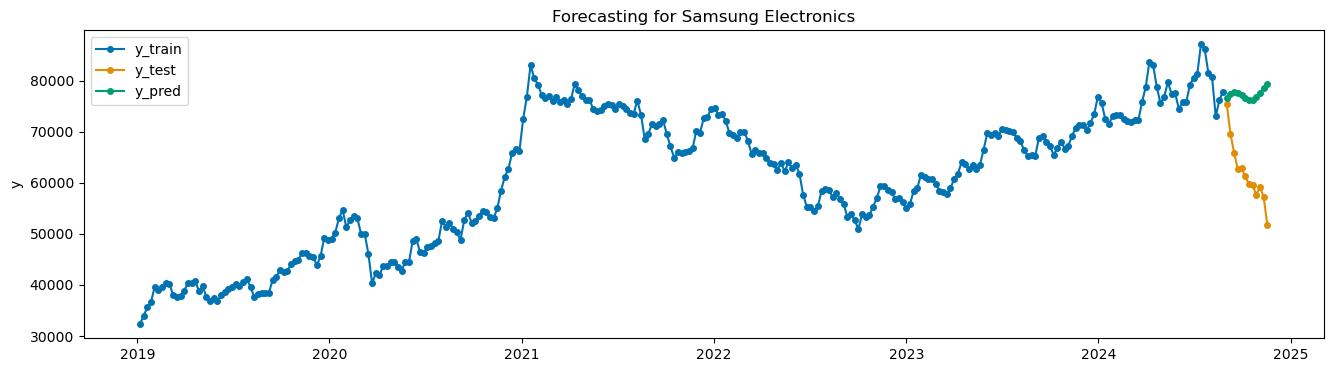

04:02:06 - cmdstanpy - INFO - Chain [1] start processing
04:02:06 - cmdstanpy - INFO - Chain [1] done processing
04:02:06 - cmdstanpy - INFO - Chain [1] start processing



Processing company: Intel Corporation (6/6)...

Total combinations to test for Intel Corporation: 1600


04:02:06 - cmdstanpy - INFO - Chain [1] done processing
04:02:06 - cmdstanpy - INFO - Chain [1] start processing
04:02:06 - cmdstanpy - INFO - Chain [1] done processing


04:02:06 - cmdstanpy - INFO - Chain [1] start processing
04:02:07 - cmdstanpy - INFO - Chain [1] done processing


04:02:07 - cmdstanpy - INFO - Chain [1] start processing
04:02:07 - cmdstanpy - INFO - Chain [1] done processing


04:02:07 - cmdstanpy - INFO - Chain [1] start processing


04:02:07 - cmdstanpy - INFO - Chain [1] done processing
04:02:07 - cmdstanpy - INFO - Chain [1] start processing


04:02:07 - cmdstanpy - INFO - Chain [1] done processing
04:02:08 - cmdstanpy - INFO - Chain [1] start processing
04:02:08 - cmdstanpy - INFO - Chain [1] done processing


04:02:08 - cmdstanpy - INFO - Chain [1] start processing
04:02:08 - cmdstanpy - INFO - Chain [1] done processing


04:02:08 - cmdstanpy - INFO - Chain [1] start processing
04:02:09 - cmdstanpy - INFO - Chain [1] done processing
04:02:09 - cmdstanpy - INFO - Chain [1] start processing


04:02:09 - cmdstanpy - INFO - Chain [1] done processing
04:02:09 - cmdstanpy - INFO - Chain [1] start processing


04:02:09 - cmdstanpy - INFO - Chain [1] done processing
04:02:09 - cmdstanpy - INFO - Chain [1] start processing


04:02:10 - cmdstanpy - INFO - Chain [1] done processing
04:02:10 - cmdstanpy - INFO - Chain [1] start processing


04:02:10 - cmdstanpy - INFO - Chain [1] done processing
04:02:10 - cmdstanpy - INFO - Chain [1] start processing


04:02:10 - cmdstanpy - INFO - Chain [1] done processing
04:02:11 - cmdstanpy - INFO - Chain [1] start processing


04:02:11 - cmdstanpy - INFO - Chain [1] done processing
04:02:11 - cmdstanpy - INFO - Chain [1] start processing
04:02:11 - cmdstanpy - INFO - Chain [1] done processing


04:02:11 - cmdstanpy - INFO - Chain [1] start processing
04:02:11 - cmdstanpy - INFO - Chain [1] done processing
04:02:11 - cmdstanpy - INFO - Chain [1] start processing
04:02:11 - cmdstanpy - INFO - Chain [1] done processing


04:02:12 - cmdstanpy - INFO - Chain [1] start processing
04:02:12 - cmdstanpy - INFO - Chain [1] done processing


04:02:12 - cmdstanpy - INFO - Chain [1] start processing
04:02:12 - cmdstanpy - INFO - Chain [1] done processing


04:02:12 - cmdstanpy - INFO - Chain [1] start processing
04:02:12 - cmdstanpy - INFO - Chain [1] done processing
04:02:12 - cmdstanpy - INFO - Chain [1] start processing
04:02:12 - cmdstanpy - INFO - Chain [1] done processing


04:02:13 - cmdstanpy - INFO - Chain [1] start processing
04:02:13 - cmdstanpy - INFO - Chain [1] done processing


04:02:13 - cmdstanpy - INFO - Chain [1] start processing
04:02:13 - cmdstanpy - INFO - Chain [1] done processing
04:02:13 - cmdstanpy - INFO - Chain [1] start processing


04:02:13 - cmdstanpy - INFO - Chain [1] done processing
04:02:13 - cmdstanpy - INFO - Chain [1] start processing


04:02:14 - cmdstanpy - INFO - Chain [1] done processing
04:02:14 - cmdstanpy - INFO - Chain [1] start processing


04:02:14 - cmdstanpy - INFO - Chain [1] done processing
04:02:14 - cmdstanpy - INFO - Chain [1] start processing


04:02:15 - cmdstanpy - INFO - Chain [1] done processing
04:02:15 - cmdstanpy - INFO - Chain [1] start processing


04:02:15 - cmdstanpy - INFO - Chain [1] done processing
04:02:15 - cmdstanpy - INFO - Chain [1] start processing
04:02:15 - cmdstanpy - INFO - Chain [1] done processing


04:02:15 - cmdstanpy - INFO - Chain [1] start processing


04:02:16 - cmdstanpy - INFO - Chain [1] done processing
04:02:16 - cmdstanpy - INFO - Chain [1] start processing
04:02:16 - cmdstanpy - INFO - Chain [1] done processing


04:02:16 - cmdstanpy - INFO - Chain [1] start processing
04:02:16 - cmdstanpy - INFO - Chain [1] done processing
04:02:16 - cmdstanpy - INFO - Chain [1] start processing


04:02:17 - cmdstanpy - INFO - Chain [1] done processing
04:02:17 - cmdstanpy - INFO - Chain [1] start processing
04:02:17 - cmdstanpy - INFO - Chain [1] done processing


04:02:17 - cmdstanpy - INFO - Chain [1] start processing
04:02:17 - cmdstanpy - INFO - Chain [1] done processing


04:02:17 - cmdstanpy - INFO - Chain [1] start processing
04:02:17 - cmdstanpy - INFO - Chain [1] done processing
04:02:17 - cmdstanpy - INFO - Chain [1] start processing
04:02:18 - cmdstanpy - INFO - Chain [1] done processing


04:02:18 - cmdstanpy - INFO - Chain [1] start processing
04:02:18 - cmdstanpy - INFO - Chain [1] done processing


04:02:18 - cmdstanpy - INFO - Chain [1] start processing
04:02:18 - cmdstanpy - INFO - Chain [1] done processing


04:02:18 - cmdstanpy - INFO - Chain [1] start processing
04:02:18 - cmdstanpy - INFO - Chain [1] done processing
04:02:19 - cmdstanpy - INFO - Chain [1] start processing


04:02:19 - cmdstanpy - INFO - Chain [1] done processing
04:02:19 - cmdstanpy - INFO - Chain [1] start processing


04:02:19 - cmdstanpy - INFO - Chain [1] done processing
04:02:19 - cmdstanpy - INFO - Chain [1] start processing


04:02:20 - cmdstanpy - INFO - Chain [1] done processing
04:02:20 - cmdstanpy - INFO - Chain [1] start processing


04:02:20 - cmdstanpy - INFO - Chain [1] done processing
04:02:20 - cmdstanpy - INFO - Chain [1] start processing


04:02:20 - cmdstanpy - INFO - Chain [1] done processing
04:02:21 - cmdstanpy - INFO - Chain [1] start processing


04:02:21 - cmdstanpy - INFO - Chain [1] done processing
04:02:21 - cmdstanpy - INFO - Chain [1] start processing
04:02:21 - cmdstanpy - INFO - Chain [1] done processing


04:02:21 - cmdstanpy - INFO - Chain [1] start processing
04:02:21 - cmdstanpy - INFO - Chain [1] done processing
04:02:21 - cmdstanpy - INFO - Chain [1] start processing


04:02:22 - cmdstanpy - INFO - Chain [1] done processing
04:02:22 - cmdstanpy - INFO - Chain [1] start processing
04:02:22 - cmdstanpy - INFO - Chain [1] done processing


04:02:22 - cmdstanpy - INFO - Chain [1] start processing
04:02:22 - cmdstanpy - INFO - Chain [1] done processing
04:02:22 - cmdstanpy - INFO - Chain [1] start processing
04:02:22 - cmdstanpy - INFO - Chain [1] done processing


04:02:22 - cmdstanpy - INFO - Chain [1] start processing
04:02:23 - cmdstanpy - INFO - Chain [1] done processing


04:02:23 - cmdstanpy - INFO - Chain [1] start processing
04:02:23 - cmdstanpy - INFO - Chain [1] done processing


04:02:23 - cmdstanpy - INFO - Chain [1] start processing
04:02:23 - cmdstanpy - INFO - Chain [1] done processing
04:02:23 - cmdstanpy - INFO - Chain [1] start processing


04:02:23 - cmdstanpy - INFO - Chain [1] done processing
04:02:24 - cmdstanpy - INFO - Chain [1] start processing


04:02:24 - cmdstanpy - INFO - Chain [1] done processing
04:02:24 - cmdstanpy - INFO - Chain [1] start processing


04:02:24 - cmdstanpy - INFO - Chain [1] done processing
04:02:25 - cmdstanpy - INFO - Chain [1] start processing


04:02:25 - cmdstanpy - INFO - Chain [1] done processing
04:02:25 - cmdstanpy - INFO - Chain [1] start processing


04:02:25 - cmdstanpy - INFO - Chain [1] done processing
04:02:25 - cmdstanpy - INFO - Chain [1] start processing
04:02:25 - cmdstanpy - INFO - Chain [1] done processing


04:02:26 - cmdstanpy - INFO - Chain [1] start processing


04:02:26 - cmdstanpy - INFO - Chain [1] done processing
04:02:26 - cmdstanpy - INFO - Chain [1] start processing
04:02:26 - cmdstanpy - INFO - Chain [1] done processing


04:02:26 - cmdstanpy - INFO - Chain [1] start processing
04:02:26 - cmdstanpy - INFO - Chain [1] done processing
04:02:26 - cmdstanpy - INFO - Chain [1] start processing
04:02:27 - cmdstanpy - INFO - Chain [1] done processing


04:02:27 - cmdstanpy - INFO - Chain [1] start processing
04:02:27 - cmdstanpy - INFO - Chain [1] done processing


04:02:27 - cmdstanpy - INFO - Chain [1] start processing
04:02:27 - cmdstanpy - INFO - Chain [1] done processing


04:02:27 - cmdstanpy - INFO - Chain [1] start processing
04:02:27 - cmdstanpy - INFO - Chain [1] done processing
04:02:27 - cmdstanpy - INFO - Chain [1] start processing


04:02:28 - cmdstanpy - INFO - Chain [1] done processing
04:02:28 - cmdstanpy - INFO - Chain [1] start processing
04:02:28 - cmdstanpy - INFO - Chain [1] done processing


04:02:28 - cmdstanpy - INFO - Chain [1] start processing
04:02:28 - cmdstanpy - INFO - Chain [1] done processing
04:02:28 - cmdstanpy - INFO - Chain [1] start processing


04:02:29 - cmdstanpy - INFO - Chain [1] done processing
04:02:29 - cmdstanpy - INFO - Chain [1] start processing


04:02:29 - cmdstanpy - INFO - Chain [1] done processing
04:02:29 - cmdstanpy - INFO - Chain [1] start processing


04:02:30 - cmdstanpy - INFO - Chain [1] done processing
04:02:30 - cmdstanpy - INFO - Chain [1] start processing


04:02:30 - cmdstanpy - INFO - Chain [1] done processing
04:02:30 - cmdstanpy - INFO - Chain [1] start processing


04:02:31 - cmdstanpy - INFO - Chain [1] done processing
04:02:31 - cmdstanpy - INFO - Chain [1] start processing
04:02:31 - cmdstanpy - INFO - Chain [1] done processing


04:02:31 - cmdstanpy - INFO - Chain [1] start processing


04:02:31 - cmdstanpy - INFO - Chain [1] done processing
04:02:31 - cmdstanpy - INFO - Chain [1] start processing
04:02:31 - cmdstanpy - INFO - Chain [1] done processing


04:02:31 - cmdstanpy - INFO - Chain [1] start processing
04:02:32 - cmdstanpy - INFO - Chain [1] done processing
04:02:32 - cmdstanpy - INFO - Chain [1] start processing
04:02:32 - cmdstanpy - INFO - Chain [1] done processing


04:02:32 - cmdstanpy - INFO - Chain [1] start processing
04:02:32 - cmdstanpy - INFO - Chain [1] done processing


04:02:32 - cmdstanpy - INFO - Chain [1] start processing
04:02:32 - cmdstanpy - INFO - Chain [1] done processing


04:02:33 - cmdstanpy - INFO - Chain [1] start processing


04:02:33 - cmdstanpy - INFO - Chain [1] done processing
04:02:33 - cmdstanpy - INFO - Chain [1] start processing
04:02:33 - cmdstanpy - INFO - Chain [1] done processing


04:02:33 - cmdstanpy - INFO - Chain [1] start processing
04:02:33 - cmdstanpy - INFO - Chain [1] done processing


04:02:33 - cmdstanpy - INFO - Chain [1] start processing
04:02:33 - cmdstanpy - INFO - Chain [1] done processing


04:02:34 - cmdstanpy - INFO - Chain [1] start processing


04:02:34 - cmdstanpy - INFO - Chain [1] done processing
04:02:34 - cmdstanpy - INFO - Chain [1] start processing


04:02:35 - cmdstanpy - INFO - Chain [1] done processing
04:02:35 - cmdstanpy - INFO - Chain [1] start processing


04:02:35 - cmdstanpy - INFO - Chain [1] done processing
04:02:35 - cmdstanpy - INFO - Chain [1] start processing


04:02:36 - cmdstanpy - INFO - Chain [1] done processing
04:02:36 - cmdstanpy - INFO - Chain [1] start processing


04:02:36 - cmdstanpy - INFO - Chain [1] done processing
04:02:36 - cmdstanpy - INFO - Chain [1] start processing
04:02:36 - cmdstanpy - INFO - Chain [1] done processing


04:02:37 - cmdstanpy - INFO - Chain [1] start processing


04:02:37 - cmdstanpy - INFO - Chain [1] done processing
04:02:37 - cmdstanpy - INFO - Chain [1] start processing
04:02:37 - cmdstanpy - INFO - Chain [1] done processing


04:02:37 - cmdstanpy - INFO - Chain [1] start processing
04:02:37 - cmdstanpy - INFO - Chain [1] done processing
04:02:37 - cmdstanpy - INFO - Chain [1] start processing


04:02:38 - cmdstanpy - INFO - Chain [1] done processing
04:02:38 - cmdstanpy - INFO - Chain [1] start processing
04:02:38 - cmdstanpy - INFO - Chain [1] done processing


04:02:38 - cmdstanpy - INFO - Chain [1] start processing
04:02:38 - cmdstanpy - INFO - Chain [1] done processing


04:02:38 - cmdstanpy - INFO - Chain [1] start processing


04:02:38 - cmdstanpy - INFO - Chain [1] done processing
04:02:39 - cmdstanpy - INFO - Chain [1] start processing
04:02:39 - cmdstanpy - INFO - Chain [1] done processing


04:02:39 - cmdstanpy - INFO - Chain [1] start processing
04:02:39 - cmdstanpy - INFO - Chain [1] done processing


04:02:39 - cmdstanpy - INFO - Chain [1] start processing
04:02:39 - cmdstanpy - INFO - Chain [1] done processing


04:02:39 - cmdstanpy - INFO - Chain [1] start processing
04:02:40 - cmdstanpy - INFO - Chain [1] done processing
04:02:40 - cmdstanpy - INFO - Chain [1] start processing


04:02:40 - cmdstanpy - INFO - Chain [1] done processing
04:02:40 - cmdstanpy - INFO - Chain [1] start processing


04:02:40 - cmdstanpy - INFO - Chain [1] done processing
04:02:41 - cmdstanpy - INFO - Chain [1] start processing


04:02:41 - cmdstanpy - INFO - Chain [1] done processing
04:02:41 - cmdstanpy - INFO - Chain [1] start processing


04:02:41 - cmdstanpy - INFO - Chain [1] done processing
04:02:42 - cmdstanpy - INFO - Chain [1] start processing
04:02:42 - cmdstanpy - INFO - Chain [1] done processing


04:02:42 - cmdstanpy - INFO - Chain [1] start processing


04:02:42 - cmdstanpy - INFO - Chain [1] done processing
04:02:42 - cmdstanpy - INFO - Chain [1] start processing
04:02:42 - cmdstanpy - INFO - Chain [1] done processing


04:02:42 - cmdstanpy - INFO - Chain [1] start processing
04:02:43 - cmdstanpy - INFO - Chain [1] done processing
04:02:43 - cmdstanpy - INFO - Chain [1] start processing


04:02:43 - cmdstanpy - INFO - Chain [1] done processing
04:02:43 - cmdstanpy - INFO - Chain [1] start processing
04:02:43 - cmdstanpy - INFO - Chain [1] done processing


04:02:43 - cmdstanpy - INFO - Chain [1] start processing
04:02:43 - cmdstanpy - INFO - Chain [1] done processing


04:02:44 - cmdstanpy - INFO - Chain [1] start processing
04:02:44 - cmdstanpy - INFO - Chain [1] done processing
04:02:44 - cmdstanpy - INFO - Chain [1] start processing


04:02:44 - cmdstanpy - INFO - Chain [1] done processing
04:02:44 - cmdstanpy - INFO - Chain [1] start processing
04:02:44 - cmdstanpy - INFO - Chain [1] done processing


04:02:44 - cmdstanpy - INFO - Chain [1] start processing
04:02:44 - cmdstanpy - INFO - Chain [1] done processing


04:02:45 - cmdstanpy - INFO - Chain [1] start processing
04:02:45 - cmdstanpy - INFO - Chain [1] done processing
04:02:45 - cmdstanpy - INFO - Chain [1] start processing


04:02:45 - cmdstanpy - INFO - Chain [1] done processing
04:02:46 - cmdstanpy - INFO - Chain [1] start processing


04:02:46 - cmdstanpy - INFO - Chain [1] done processing
04:02:46 - cmdstanpy - INFO - Chain [1] start processing


04:02:46 - cmdstanpy - INFO - Chain [1] done processing
04:02:46 - cmdstanpy - INFO - Chain [1] start processing


04:02:47 - cmdstanpy - INFO - Chain [1] done processing
04:02:47 - cmdstanpy - INFO - Chain [1] start processing
04:02:47 - cmdstanpy - INFO - Chain [1] done processing


04:02:47 - cmdstanpy - INFO - Chain [1] start processing


04:02:47 - cmdstanpy - INFO - Chain [1] done processing
04:02:48 - cmdstanpy - INFO - Chain [1] start processing
04:02:48 - cmdstanpy - INFO - Chain [1] done processing


04:02:48 - cmdstanpy - INFO - Chain [1] start processing
04:02:48 - cmdstanpy - INFO - Chain [1] done processing
04:02:48 - cmdstanpy - INFO - Chain [1] start processing


04:02:48 - cmdstanpy - INFO - Chain [1] done processing
04:02:48 - cmdstanpy - INFO - Chain [1] start processing
04:02:49 - cmdstanpy - INFO - Chain [1] done processing


04:02:49 - cmdstanpy - INFO - Chain [1] start processing
04:02:49 - cmdstanpy - INFO - Chain [1] done processing


04:02:49 - cmdstanpy - INFO - Chain [1] start processing
04:02:49 - cmdstanpy - INFO - Chain [1] done processing
04:02:49 - cmdstanpy - INFO - Chain [1] start processing
04:02:49 - cmdstanpy - INFO - Chain [1] done processing


04:02:49 - cmdstanpy - INFO - Chain [1] start processing
04:02:50 - cmdstanpy - INFO - Chain [1] done processing


04:02:50 - cmdstanpy - INFO - Chain [1] start processing
04:02:50 - cmdstanpy - INFO - Chain [1] done processing


04:02:50 - cmdstanpy - INFO - Chain [1] start processing
04:02:50 - cmdstanpy - INFO - Chain [1] done processing
04:02:50 - cmdstanpy - INFO - Chain [1] start processing


04:02:51 - cmdstanpy - INFO - Chain [1] done processing
04:02:51 - cmdstanpy - INFO - Chain [1] start processing


04:02:51 - cmdstanpy - INFO - Chain [1] done processing
04:02:51 - cmdstanpy - INFO - Chain [1] start processing


04:02:52 - cmdstanpy - INFO - Chain [1] done processing
04:02:52 - cmdstanpy - INFO - Chain [1] start processing


04:02:52 - cmdstanpy - INFO - Chain [1] done processing
04:02:52 - cmdstanpy - INFO - Chain [1] start processing
04:02:52 - cmdstanpy - INFO - Chain [1] done processing


04:02:52 - cmdstanpy - INFO - Chain [1] start processing


04:02:53 - cmdstanpy - INFO - Chain [1] done processing
04:02:53 - cmdstanpy - INFO - Chain [1] start processing
04:02:53 - cmdstanpy - INFO - Chain [1] done processing


04:02:53 - cmdstanpy - INFO - Chain [1] start processing
04:02:53 - cmdstanpy - INFO - Chain [1] done processing
04:02:53 - cmdstanpy - INFO - Chain [1] start processing


04:02:54 - cmdstanpy - INFO - Chain [1] done processing
04:02:54 - cmdstanpy - INFO - Chain [1] start processing
04:02:54 - cmdstanpy - INFO - Chain [1] done processing


04:02:54 - cmdstanpy - INFO - Chain [1] start processing
04:02:54 - cmdstanpy - INFO - Chain [1] done processing
04:02:54 - cmdstanpy - INFO - Chain [1] start processing
04:02:54 - cmdstanpy - INFO - Chain [1] done processing


04:02:54 - cmdstanpy - INFO - Chain [1] start processing
04:02:55 - cmdstanpy - INFO - Chain [1] done processing


04:02:55 - cmdstanpy - INFO - Chain [1] start processing
04:02:55 - cmdstanpy - INFO - Chain [1] done processing


04:02:55 - cmdstanpy - INFO - Chain [1] start processing
04:02:55 - cmdstanpy - INFO - Chain [1] done processing
04:02:55 - cmdstanpy - INFO - Chain [1] start processing


04:02:55 - cmdstanpy - INFO - Chain [1] done processing
04:02:56 - cmdstanpy - INFO - Chain [1] start processing


04:02:56 - cmdstanpy - INFO - Chain [1] done processing
04:02:56 - cmdstanpy - INFO - Chain [1] start processing


04:02:57 - cmdstanpy - INFO - Chain [1] done processing
04:02:57 - cmdstanpy - INFO - Chain [1] start processing


04:02:57 - cmdstanpy - INFO - Chain [1] done processing
04:02:57 - cmdstanpy - INFO - Chain [1] start processing


04:02:57 - cmdstanpy - INFO - Chain [1] done processing
04:02:58 - cmdstanpy - INFO - Chain [1] start processing
04:02:58 - cmdstanpy - INFO - Chain [1] done processing


04:02:58 - cmdstanpy - INFO - Chain [1] start processing


04:02:58 - cmdstanpy - INFO - Chain [1] done processing
04:02:58 - cmdstanpy - INFO - Chain [1] start processing
04:02:58 - cmdstanpy - INFO - Chain [1] done processing


04:02:58 - cmdstanpy - INFO - Chain [1] start processing
04:02:59 - cmdstanpy - INFO - Chain [1] done processing
04:02:59 - cmdstanpy - INFO - Chain [1] start processing


04:02:59 - cmdstanpy - INFO - Chain [1] done processing
04:02:59 - cmdstanpy - INFO - Chain [1] start processing
04:02:59 - cmdstanpy - INFO - Chain [1] done processing


04:02:59 - cmdstanpy - INFO - Chain [1] start processing
04:02:59 - cmdstanpy - INFO - Chain [1] done processing


04:02:59 - cmdstanpy - INFO - Chain [1] start processing


04:03:00 - cmdstanpy - INFO - Chain [1] done processing
04:03:00 - cmdstanpy - INFO - Chain [1] start processing
04:03:00 - cmdstanpy - INFO - Chain [1] done processing


04:03:00 - cmdstanpy - INFO - Chain [1] start processing
04:03:00 - cmdstanpy - INFO - Chain [1] done processing


04:03:00 - cmdstanpy - INFO - Chain [1] start processing
04:03:00 - cmdstanpy - INFO - Chain [1] done processing


04:03:01 - cmdstanpy - INFO - Chain [1] start processing
04:03:01 - cmdstanpy - INFO - Chain [1] done processing
04:03:01 - cmdstanpy - INFO - Chain [1] start processing


04:03:01 - cmdstanpy - INFO - Chain [1] done processing
04:03:02 - cmdstanpy - INFO - Chain [1] start processing


04:03:02 - cmdstanpy - INFO - Chain [1] done processing
04:03:02 - cmdstanpy - INFO - Chain [1] start processing


04:03:02 - cmdstanpy - INFO - Chain [1] done processing
04:03:02 - cmdstanpy - INFO - Chain [1] start processing


04:03:03 - cmdstanpy - INFO - Chain [1] done processing
04:03:03 - cmdstanpy - INFO - Chain [1] start processing


04:03:03 - cmdstanpy - INFO - Chain [1] done processing
04:03:03 - cmdstanpy - INFO - Chain [1] start processing


04:03:03 - cmdstanpy - INFO - Chain [1] done processing
04:03:03 - cmdstanpy - INFO - Chain [1] start processing
04:03:04 - cmdstanpy - INFO - Chain [1] done processing


04:03:04 - cmdstanpy - INFO - Chain [1] start processing
04:03:04 - cmdstanpy - INFO - Chain [1] done processing
04:03:04 - cmdstanpy - INFO - Chain [1] start processing


04:03:04 - cmdstanpy - INFO - Chain [1] done processing
04:03:04 - cmdstanpy - INFO - Chain [1] start processing
04:03:04 - cmdstanpy - INFO - Chain [1] done processing


04:03:05 - cmdstanpy - INFO - Chain [1] start processing
04:03:05 - cmdstanpy - INFO - Chain [1] done processing


04:03:05 - cmdstanpy - INFO - Chain [1] start processing


04:03:05 - cmdstanpy - INFO - Chain [1] done processing
04:03:05 - cmdstanpy - INFO - Chain [1] start processing


04:03:05 - cmdstanpy - INFO - Chain [1] done processing
04:03:05 - cmdstanpy - INFO - Chain [1] start processing
04:03:05 - cmdstanpy - INFO - Chain [1] done processing


04:03:06 - cmdstanpy - INFO - Chain [1] start processing
04:03:06 - cmdstanpy - INFO - Chain [1] done processing


04:03:06 - cmdstanpy - INFO - Chain [1] start processing
04:03:06 - cmdstanpy - INFO - Chain [1] done processing
04:03:06 - cmdstanpy - INFO - Chain [1] start processing


04:03:07 - cmdstanpy - INFO - Chain [1] done processing
04:03:07 - cmdstanpy - INFO - Chain [1] start processing


04:03:07 - cmdstanpy - INFO - Chain [1] done processing
04:03:07 - cmdstanpy - INFO - Chain [1] start processing


04:03:07 - cmdstanpy - INFO - Chain [1] done processing
04:03:08 - cmdstanpy - INFO - Chain [1] start processing


04:03:08 - cmdstanpy - INFO - Chain [1] done processing
04:03:08 - cmdstanpy - INFO - Chain [1] start processing


04:03:08 - cmdstanpy - INFO - Chain [1] done processing
04:03:08 - cmdstanpy - INFO - Chain [1] start processing


04:03:09 - cmdstanpy - INFO - Chain [1] done processing
04:03:09 - cmdstanpy - INFO - Chain [1] start processing
04:03:09 - cmdstanpy - INFO - Chain [1] done processing


04:03:09 - cmdstanpy - INFO - Chain [1] start processing
04:03:09 - cmdstanpy - INFO - Chain [1] done processing
04:03:09 - cmdstanpy - INFO - Chain [1] start processing


04:03:09 - cmdstanpy - INFO - Chain [1] done processing
04:03:10 - cmdstanpy - INFO - Chain [1] start processing
04:03:10 - cmdstanpy - INFO - Chain [1] done processing


04:03:10 - cmdstanpy - INFO - Chain [1] start processing
04:03:10 - cmdstanpy - INFO - Chain [1] done processing


04:03:10 - cmdstanpy - INFO - Chain [1] start processing


04:03:10 - cmdstanpy - INFO - Chain [1] done processing
04:03:10 - cmdstanpy - INFO - Chain [1] start processing
04:03:10 - cmdstanpy - INFO - Chain [1] done processing


04:03:11 - cmdstanpy - INFO - Chain [1] start processing
04:03:11 - cmdstanpy - INFO - Chain [1] done processing


04:03:11 - cmdstanpy - INFO - Chain [1] start processing
04:03:11 - cmdstanpy - INFO - Chain [1] done processing


04:03:11 - cmdstanpy - INFO - Chain [1] start processing
04:03:12 - cmdstanpy - INFO - Chain [1] done processing
04:03:12 - cmdstanpy - INFO - Chain [1] start processing


04:03:12 - cmdstanpy - INFO - Chain [1] done processing
04:03:12 - cmdstanpy - INFO - Chain [1] start processing


04:03:12 - cmdstanpy - INFO - Chain [1] done processing
04:03:13 - cmdstanpy - INFO - Chain [1] start processing


04:03:13 - cmdstanpy - INFO - Chain [1] done processing
04:03:13 - cmdstanpy - INFO - Chain [1] start processing


04:03:13 - cmdstanpy - INFO - Chain [1] done processing
04:03:13 - cmdstanpy - INFO - Chain [1] start processing


04:03:14 - cmdstanpy - INFO - Chain [1] done processing
04:03:14 - cmdstanpy - INFO - Chain [1] start processing


04:03:14 - cmdstanpy - INFO - Chain [1] done processing
04:03:14 - cmdstanpy - INFO - Chain [1] start processing
04:03:14 - cmdstanpy - INFO - Chain [1] done processing


04:03:14 - cmdstanpy - INFO - Chain [1] start processing


04:03:15 - cmdstanpy - INFO - Chain [1] done processing
04:03:15 - cmdstanpy - INFO - Chain [1] start processing


04:03:15 - cmdstanpy - INFO - Chain [1] done processing
04:03:15 - cmdstanpy - INFO - Chain [1] start processing
04:03:15 - cmdstanpy - INFO - Chain [1] done processing


04:03:15 - cmdstanpy - INFO - Chain [1] start processing
04:03:15 - cmdstanpy - INFO - Chain [1] done processing


04:03:15 - cmdstanpy - INFO - Chain [1] start processing


04:03:16 - cmdstanpy - INFO - Chain [1] done processing
04:03:16 - cmdstanpy - INFO - Chain [1] start processing


04:03:16 - cmdstanpy - INFO - Chain [1] done processing
04:03:16 - cmdstanpy - INFO - Chain [1] start processing
04:03:16 - cmdstanpy - INFO - Chain [1] done processing


04:03:16 - cmdstanpy - INFO - Chain [1] start processing
04:03:16 - cmdstanpy - INFO - Chain [1] done processing


04:03:16 - cmdstanpy - INFO - Chain [1] start processing
04:03:17 - cmdstanpy - INFO - Chain [1] done processing
04:03:17 - cmdstanpy - INFO - Chain [1] start processing


04:03:17 - cmdstanpy - INFO - Chain [1] done processing
04:03:18 - cmdstanpy - INFO - Chain [1] start processing


04:03:18 - cmdstanpy - INFO - Chain [1] done processing
04:03:18 - cmdstanpy - INFO - Chain [1] start processing


04:03:18 - cmdstanpy - INFO - Chain [1] done processing
04:03:18 - cmdstanpy - INFO - Chain [1] start processing


04:03:19 - cmdstanpy - INFO - Chain [1] done processing
04:03:19 - cmdstanpy - INFO - Chain [1] start processing


04:03:19 - cmdstanpy - INFO - Chain [1] done processing
04:03:19 - cmdstanpy - INFO - Chain [1] start processing


04:03:19 - cmdstanpy - INFO - Chain [1] done processing
04:03:19 - cmdstanpy - INFO - Chain [1] start processing
04:03:19 - cmdstanpy - INFO - Chain [1] done processing


04:03:20 - cmdstanpy - INFO - Chain [1] start processing
04:03:20 - cmdstanpy - INFO - Chain [1] done processing
04:03:20 - cmdstanpy - INFO - Chain [1] start processing


04:03:20 - cmdstanpy - INFO - Chain [1] done processing
04:03:20 - cmdstanpy - INFO - Chain [1] start processing
04:03:20 - cmdstanpy - INFO - Chain [1] done processing


04:03:21 - cmdstanpy - INFO - Chain [1] start processing
04:03:21 - cmdstanpy - INFO - Chain [1] done processing


04:03:21 - cmdstanpy - INFO - Chain [1] start processing


04:03:21 - cmdstanpy - INFO - Chain [1] done processing
04:03:21 - cmdstanpy - INFO - Chain [1] start processing
04:03:21 - cmdstanpy - INFO - Chain [1] done processing


04:03:21 - cmdstanpy - INFO - Chain [1] start processing
04:03:21 - cmdstanpy - INFO - Chain [1] done processing


04:03:22 - cmdstanpy - INFO - Chain [1] start processing
04:03:22 - cmdstanpy - INFO - Chain [1] done processing


04:03:22 - cmdstanpy - INFO - Chain [1] start processing


04:03:22 - cmdstanpy - INFO - Chain [1] done processing
04:03:22 - cmdstanpy - INFO - Chain [1] start processing


04:03:23 - cmdstanpy - INFO - Chain [1] done processing
04:03:23 - cmdstanpy - INFO - Chain [1] start processing


04:03:23 - cmdstanpy - INFO - Chain [1] done processing
04:03:23 - cmdstanpy - INFO - Chain [1] start processing


04:03:24 - cmdstanpy - INFO - Chain [1] done processing
04:03:24 - cmdstanpy - INFO - Chain [1] start processing


04:03:24 - cmdstanpy - INFO - Chain [1] done processing
04:03:24 - cmdstanpy - INFO - Chain [1] start processing


04:03:24 - cmdstanpy - INFO - Chain [1] done processing
04:03:24 - cmdstanpy - INFO - Chain [1] start processing


04:03:25 - cmdstanpy - INFO - Chain [1] done processing
04:03:25 - cmdstanpy - INFO - Chain [1] start processing
04:03:25 - cmdstanpy - INFO - Chain [1] done processing


04:03:25 - cmdstanpy - INFO - Chain [1] start processing


04:03:25 - cmdstanpy - INFO - Chain [1] done processing
04:03:25 - cmdstanpy - INFO - Chain [1] start processing


04:03:26 - cmdstanpy - INFO - Chain [1] done processing
04:03:26 - cmdstanpy - INFO - Chain [1] start processing
04:03:26 - cmdstanpy - INFO - Chain [1] done processing


04:03:26 - cmdstanpy - INFO - Chain [1] start processing
04:03:26 - cmdstanpy - INFO - Chain [1] done processing


04:03:26 - cmdstanpy - INFO - Chain [1] start processing


04:03:26 - cmdstanpy - INFO - Chain [1] done processing
04:03:26 - cmdstanpy - INFO - Chain [1] start processing


04:03:27 - cmdstanpy - INFO - Chain [1] done processing
04:03:27 - cmdstanpy - INFO - Chain [1] start processing


04:03:27 - cmdstanpy - INFO - Chain [1] done processing
04:03:27 - cmdstanpy - INFO - Chain [1] start processing
04:03:27 - cmdstanpy - INFO - Chain [1] done processing


04:03:27 - cmdstanpy - INFO - Chain [1] start processing
04:03:28 - cmdstanpy - INFO - Chain [1] done processing
04:03:28 - cmdstanpy - INFO - Chain [1] start processing


04:03:28 - cmdstanpy - INFO - Chain [1] done processing
04:03:28 - cmdstanpy - INFO - Chain [1] start processing


04:03:28 - cmdstanpy - INFO - Chain [1] done processing
04:03:29 - cmdstanpy - INFO - Chain [1] start processing


04:03:29 - cmdstanpy - INFO - Chain [1] done processing
04:03:29 - cmdstanpy - INFO - Chain [1] start processing


04:03:29 - cmdstanpy - INFO - Chain [1] done processing
04:03:29 - cmdstanpy - INFO - Chain [1] start processing


04:03:30 - cmdstanpy - INFO - Chain [1] done processing
04:03:30 - cmdstanpy - INFO - Chain [1] start processing


04:03:30 - cmdstanpy - INFO - Chain [1] done processing
04:03:30 - cmdstanpy - INFO - Chain [1] start processing
04:03:30 - cmdstanpy - INFO - Chain [1] done processing


04:03:30 - cmdstanpy - INFO - Chain [1] start processing
04:03:31 - cmdstanpy - INFO - Chain [1] done processing
04:03:31 - cmdstanpy - INFO - Chain [1] start processing


04:03:31 - cmdstanpy - INFO - Chain [1] done processing
04:03:31 - cmdstanpy - INFO - Chain [1] start processing
04:03:31 - cmdstanpy - INFO - Chain [1] done processing


04:03:31 - cmdstanpy - INFO - Chain [1] start processing
04:03:31 - cmdstanpy - INFO - Chain [1] done processing


04:03:32 - cmdstanpy - INFO - Chain [1] start processing


04:03:32 - cmdstanpy - INFO - Chain [1] done processing
04:03:32 - cmdstanpy - INFO - Chain [1] start processing


04:03:32 - cmdstanpy - INFO - Chain [1] done processing
04:03:32 - cmdstanpy - INFO - Chain [1] start processing
04:03:32 - cmdstanpy - INFO - Chain [1] done processing


04:03:32 - cmdstanpy - INFO - Chain [1] start processing
04:03:32 - cmdstanpy - INFO - Chain [1] done processing


04:03:33 - cmdstanpy - INFO - Chain [1] start processing
04:03:33 - cmdstanpy - INFO - Chain [1] done processing
04:03:33 - cmdstanpy - INFO - Chain [1] start processing


04:03:33 - cmdstanpy - INFO - Chain [1] done processing
04:03:33 - cmdstanpy - INFO - Chain [1] start processing


04:03:34 - cmdstanpy - INFO - Chain [1] done processing
04:03:34 - cmdstanpy - INFO - Chain [1] start processing


04:03:34 - cmdstanpy - INFO - Chain [1] done processing
04:03:34 - cmdstanpy - INFO - Chain [1] start processing


04:03:35 - cmdstanpy - INFO - Chain [1] done processing
04:03:35 - cmdstanpy - INFO - Chain [1] start processing
04:03:35 - cmdstanpy - INFO - Chain [1] done processing


04:03:35 - cmdstanpy - INFO - Chain [1] start processing


04:03:35 - cmdstanpy - INFO - Chain [1] done processing
04:03:35 - cmdstanpy - INFO - Chain [1] start processing
04:03:35 - cmdstanpy - INFO - Chain [1] done processing


04:03:36 - cmdstanpy - INFO - Chain [1] start processing
04:03:36 - cmdstanpy - INFO - Chain [1] done processing
04:03:36 - cmdstanpy - INFO - Chain [1] start processing


04:03:36 - cmdstanpy - INFO - Chain [1] done processing
04:03:36 - cmdstanpy - INFO - Chain [1] start processing
04:03:36 - cmdstanpy - INFO - Chain [1] done processing


04:03:36 - cmdstanpy - INFO - Chain [1] start processing
04:03:37 - cmdstanpy - INFO - Chain [1] done processing


04:03:37 - cmdstanpy - INFO - Chain [1] start processing


04:03:37 - cmdstanpy - INFO - Chain [1] done processing
04:03:37 - cmdstanpy - INFO - Chain [1] start processing


04:03:37 - cmdstanpy - INFO - Chain [1] done processing
04:03:37 - cmdstanpy - INFO - Chain [1] start processing
04:03:37 - cmdstanpy - INFO - Chain [1] done processing


04:03:38 - cmdstanpy - INFO - Chain [1] start processing
04:03:38 - cmdstanpy - INFO - Chain [1] done processing


04:03:38 - cmdstanpy - INFO - Chain [1] start processing
04:03:38 - cmdstanpy - INFO - Chain [1] done processing
04:03:38 - cmdstanpy - INFO - Chain [1] start processing


04:03:39 - cmdstanpy - INFO - Chain [1] done processing
04:03:39 - cmdstanpy - INFO - Chain [1] start processing


04:03:39 - cmdstanpy - INFO - Chain [1] done processing
04:03:39 - cmdstanpy - INFO - Chain [1] start processing


04:03:39 - cmdstanpy - INFO - Chain [1] done processing
04:03:40 - cmdstanpy - INFO - Chain [1] start processing


04:03:40 - cmdstanpy - INFO - Chain [1] done processing
04:03:40 - cmdstanpy - INFO - Chain [1] start processing


04:03:40 - cmdstanpy - INFO - Chain [1] done processing
04:03:40 - cmdstanpy - INFO - Chain [1] start processing


04:03:40 - cmdstanpy - INFO - Chain [1] done processing
04:03:41 - cmdstanpy - INFO - Chain [1] start processing
04:03:41 - cmdstanpy - INFO - Chain [1] done processing


04:03:41 - cmdstanpy - INFO - Chain [1] start processing
04:03:41 - cmdstanpy - INFO - Chain [1] done processing
04:03:41 - cmdstanpy - INFO - Chain [1] start processing


04:03:41 - cmdstanpy - INFO - Chain [1] done processing
04:03:41 - cmdstanpy - INFO - Chain [1] start processing
04:03:42 - cmdstanpy - INFO - Chain [1] done processing


04:03:42 - cmdstanpy - INFO - Chain [1] start processing
04:03:42 - cmdstanpy - INFO - Chain [1] done processing


04:03:42 - cmdstanpy - INFO - Chain [1] start processing


04:03:42 - cmdstanpy - INFO - Chain [1] done processing
04:03:42 - cmdstanpy - INFO - Chain [1] start processing


04:03:42 - cmdstanpy - INFO - Chain [1] done processing
04:03:43 - cmdstanpy - INFO - Chain [1] start processing
04:03:43 - cmdstanpy - INFO - Chain [1] done processing


04:03:43 - cmdstanpy - INFO - Chain [1] start processing
04:03:43 - cmdstanpy - INFO - Chain [1] done processing


04:03:43 - cmdstanpy - INFO - Chain [1] start processing
04:03:43 - cmdstanpy - INFO - Chain [1] done processing
04:03:44 - cmdstanpy - INFO - Chain [1] start processing


04:03:44 - cmdstanpy - INFO - Chain [1] done processing
04:03:44 - cmdstanpy - INFO - Chain [1] start processing


04:03:44 - cmdstanpy - INFO - Chain [1] done processing
04:03:44 - cmdstanpy - INFO - Chain [1] start processing


04:03:45 - cmdstanpy - INFO - Chain [1] done processing
04:03:45 - cmdstanpy - INFO - Chain [1] start processing


04:03:45 - cmdstanpy - INFO - Chain [1] done processing
04:03:45 - cmdstanpy - INFO - Chain [1] start processing


04:03:45 - cmdstanpy - INFO - Chain [1] done processing
04:03:45 - cmdstanpy - INFO - Chain [1] start processing


04:03:46 - cmdstanpy - INFO - Chain [1] done processing
04:03:46 - cmdstanpy - INFO - Chain [1] start processing
04:03:46 - cmdstanpy - INFO - Chain [1] done processing


04:03:46 - cmdstanpy - INFO - Chain [1] start processing
04:03:46 - cmdstanpy - INFO - Chain [1] done processing
04:03:46 - cmdstanpy - INFO - Chain [1] start processing


04:03:47 - cmdstanpy - INFO - Chain [1] done processing
04:03:47 - cmdstanpy - INFO - Chain [1] start processing
04:03:47 - cmdstanpy - INFO - Chain [1] done processing


04:03:47 - cmdstanpy - INFO - Chain [1] start processing
04:03:47 - cmdstanpy - INFO - Chain [1] done processing


04:03:47 - cmdstanpy - INFO - Chain [1] start processing
04:03:47 - cmdstanpy - INFO - Chain [1] done processing
04:03:47 - cmdstanpy - INFO - Chain [1] start processing
04:03:48 - cmdstanpy - INFO - Chain [1] done processing


04:03:48 - cmdstanpy - INFO - Chain [1] start processing
04:03:48 - cmdstanpy - INFO - Chain [1] done processing


04:03:48 - cmdstanpy - INFO - Chain [1] start processing
04:03:48 - cmdstanpy - INFO - Chain [1] done processing


04:03:48 - cmdstanpy - INFO - Chain [1] start processing
04:03:49 - cmdstanpy - INFO - Chain [1] done processing
04:03:49 - cmdstanpy - INFO - Chain [1] start processing


04:03:49 - cmdstanpy - INFO - Chain [1] done processing
04:03:49 - cmdstanpy - INFO - Chain [1] start processing


04:03:49 - cmdstanpy - INFO - Chain [1] done processing
04:03:50 - cmdstanpy - INFO - Chain [1] start processing


04:03:50 - cmdstanpy - INFO - Chain [1] done processing
04:03:50 - cmdstanpy - INFO - Chain [1] start processing


04:03:50 - cmdstanpy - INFO - Chain [1] done processing
04:03:51 - cmdstanpy - INFO - Chain [1] start processing
04:03:51 - cmdstanpy - INFO - Chain [1] done processing


04:03:51 - cmdstanpy - INFO - Chain [1] start processing


04:03:51 - cmdstanpy - INFO - Chain [1] done processing
04:03:51 - cmdstanpy - INFO - Chain [1] start processing
04:03:51 - cmdstanpy - INFO - Chain [1] done processing


04:03:51 - cmdstanpy - INFO - Chain [1] start processing
04:03:52 - cmdstanpy - INFO - Chain [1] done processing
04:03:52 - cmdstanpy - INFO - Chain [1] start processing


04:03:52 - cmdstanpy - INFO - Chain [1] done processing
04:03:52 - cmdstanpy - INFO - Chain [1] start processing
04:03:52 - cmdstanpy - INFO - Chain [1] done processing


04:03:52 - cmdstanpy - INFO - Chain [1] start processing
04:03:52 - cmdstanpy - INFO - Chain [1] done processing


04:03:53 - cmdstanpy - INFO - Chain [1] start processing


04:03:53 - cmdstanpy - INFO - Chain [1] done processing
04:03:53 - cmdstanpy - INFO - Chain [1] start processing


04:03:53 - cmdstanpy - INFO - Chain [1] done processing
04:03:53 - cmdstanpy - INFO - Chain [1] start processing
04:03:53 - cmdstanpy - INFO - Chain [1] done processing


04:03:53 - cmdstanpy - INFO - Chain [1] start processing
04:03:54 - cmdstanpy - INFO - Chain [1] done processing


04:03:54 - cmdstanpy - INFO - Chain [1] start processing


04:03:54 - cmdstanpy - INFO - Chain [1] done processing
04:03:54 - cmdstanpy - INFO - Chain [1] start processing


04:03:54 - cmdstanpy - INFO - Chain [1] done processing
04:03:55 - cmdstanpy - INFO - Chain [1] start processing


04:03:55 - cmdstanpy - INFO - Chain [1] done processing
04:03:55 - cmdstanpy - INFO - Chain [1] start processing


04:03:55 - cmdstanpy - INFO - Chain [1] done processing
04:03:55 - cmdstanpy - INFO - Chain [1] start processing


04:03:56 - cmdstanpy - INFO - Chain [1] done processing
04:03:56 - cmdstanpy - INFO - Chain [1] start processing


04:03:56 - cmdstanpy - INFO - Chain [1] done processing
04:03:56 - cmdstanpy - INFO - Chain [1] start processing


04:03:56 - cmdstanpy - INFO - Chain [1] done processing
04:03:56 - cmdstanpy - INFO - Chain [1] start processing
04:03:57 - cmdstanpy - INFO - Chain [1] done processing


04:03:57 - cmdstanpy - INFO - Chain [1] start processing
04:03:57 - cmdstanpy - INFO - Chain [1] done processing
04:03:57 - cmdstanpy - INFO - Chain [1] start processing


04:03:57 - cmdstanpy - INFO - Chain [1] done processing
04:03:57 - cmdstanpy - INFO - Chain [1] start processing
04:03:58 - cmdstanpy - INFO - Chain [1] done processing


04:03:58 - cmdstanpy - INFO - Chain [1] start processing
04:03:58 - cmdstanpy - INFO - Chain [1] done processing


04:03:58 - cmdstanpy - INFO - Chain [1] start processing


04:03:58 - cmdstanpy - INFO - Chain [1] done processing
04:03:58 - cmdstanpy - INFO - Chain [1] start processing


04:03:58 - cmdstanpy - INFO - Chain [1] done processing
04:03:59 - cmdstanpy - INFO - Chain [1] start processing
04:03:59 - cmdstanpy - INFO - Chain [1] done processing


04:03:59 - cmdstanpy - INFO - Chain [1] start processing
04:03:59 - cmdstanpy - INFO - Chain [1] done processing


04:03:59 - cmdstanpy - INFO - Chain [1] start processing


04:03:59 - cmdstanpy - INFO - Chain [1] done processing
04:03:59 - cmdstanpy - INFO - Chain [1] start processing


04:04:00 - cmdstanpy - INFO - Chain [1] done processing
04:04:00 - cmdstanpy - INFO - Chain [1] start processing


04:04:00 - cmdstanpy - INFO - Chain [1] done processing
04:04:00 - cmdstanpy - INFO - Chain [1] start processing


04:04:00 - cmdstanpy - INFO - Chain [1] done processing
04:04:01 - cmdstanpy - INFO - Chain [1] start processing


04:04:01 - cmdstanpy - INFO - Chain [1] done processing
04:04:01 - cmdstanpy - INFO - Chain [1] start processing


04:04:01 - cmdstanpy - INFO - Chain [1] done processing
04:04:01 - cmdstanpy - INFO - Chain [1] start processing


04:04:02 - cmdstanpy - INFO - Chain [1] done processing
04:04:02 - cmdstanpy - INFO - Chain [1] start processing
04:04:02 - cmdstanpy - INFO - Chain [1] done processing


04:04:02 - cmdstanpy - INFO - Chain [1] start processing


04:04:02 - cmdstanpy - INFO - Chain [1] done processing
04:04:02 - cmdstanpy - INFO - Chain [1] start processing


04:04:02 - cmdstanpy - INFO - Chain [1] done processing
04:04:03 - cmdstanpy - INFO - Chain [1] start processing
04:04:03 - cmdstanpy - INFO - Chain [1] done processing


04:04:03 - cmdstanpy - INFO - Chain [1] start processing
04:04:03 - cmdstanpy - INFO - Chain [1] done processing


04:04:03 - cmdstanpy - INFO - Chain [1] start processing


04:04:03 - cmdstanpy - INFO - Chain [1] done processing
04:04:03 - cmdstanpy - INFO - Chain [1] start processing


04:04:04 - cmdstanpy - INFO - Chain [1] done processing
04:04:04 - cmdstanpy - INFO - Chain [1] start processing
04:04:04 - cmdstanpy - INFO - Chain [1] done processing


04:04:04 - cmdstanpy - INFO - Chain [1] start processing
04:04:04 - cmdstanpy - INFO - Chain [1] done processing


04:04:04 - cmdstanpy - INFO - Chain [1] start processing


04:04:04 - cmdstanpy - INFO - Chain [1] done processing
04:04:05 - cmdstanpy - INFO - Chain [1] start processing


04:04:05 - cmdstanpy - INFO - Chain [1] done processing
04:04:05 - cmdstanpy - INFO - Chain [1] start processing


04:04:05 - cmdstanpy - INFO - Chain [1] done processing
04:04:05 - cmdstanpy - INFO - Chain [1] start processing


04:04:06 - cmdstanpy - INFO - Chain [1] done processing
04:04:06 - cmdstanpy - INFO - Chain [1] start processing


04:04:06 - cmdstanpy - INFO - Chain [1] done processing
04:04:06 - cmdstanpy - INFO - Chain [1] start processing
04:04:06 - cmdstanpy - INFO - Chain [1] done processing


04:04:06 - cmdstanpy - INFO - Chain [1] start processing


04:04:07 - cmdstanpy - INFO - Chain [1] done processing
04:04:07 - cmdstanpy - INFO - Chain [1] start processing
04:04:07 - cmdstanpy - INFO - Chain [1] done processing


04:04:07 - cmdstanpy - INFO - Chain [1] start processing


04:04:07 - cmdstanpy - INFO - Chain [1] done processing
04:04:07 - cmdstanpy - INFO - Chain [1] start processing


04:04:08 - cmdstanpy - INFO - Chain [1] done processing
04:04:08 - cmdstanpy - INFO - Chain [1] start processing
04:04:08 - cmdstanpy - INFO - Chain [1] done processing


04:04:08 - cmdstanpy - INFO - Chain [1] start processing
04:04:08 - cmdstanpy - INFO - Chain [1] done processing


04:04:08 - cmdstanpy - INFO - Chain [1] start processing


04:04:08 - cmdstanpy - INFO - Chain [1] done processing
04:04:09 - cmdstanpy - INFO - Chain [1] start processing
04:04:09 - cmdstanpy - INFO - Chain [1] done processing


04:04:09 - cmdstanpy - INFO - Chain [1] start processing
04:04:09 - cmdstanpy - INFO - Chain [1] done processing


04:04:09 - cmdstanpy - INFO - Chain [1] start processing
04:04:09 - cmdstanpy - INFO - Chain [1] done processing


04:04:09 - cmdstanpy - INFO - Chain [1] start processing


04:04:10 - cmdstanpy - INFO - Chain [1] done processing
04:04:10 - cmdstanpy - INFO - Chain [1] start processing


04:04:10 - cmdstanpy - INFO - Chain [1] done processing
04:04:10 - cmdstanpy - INFO - Chain [1] start processing


04:04:11 - cmdstanpy - INFO - Chain [1] done processing
04:04:11 - cmdstanpy - INFO - Chain [1] start processing


04:04:11 - cmdstanpy - INFO - Chain [1] done processing
04:04:11 - cmdstanpy - INFO - Chain [1] start processing


04:04:11 - cmdstanpy - INFO - Chain [1] done processing
04:04:11 - cmdstanpy - INFO - Chain [1] start processing


04:04:12 - cmdstanpy - INFO - Chain [1] done processing
04:04:12 - cmdstanpy - INFO - Chain [1] start processing


04:04:12 - cmdstanpy - INFO - Chain [1] done processing
04:04:12 - cmdstanpy - INFO - Chain [1] start processing
04:04:12 - cmdstanpy - INFO - Chain [1] done processing


04:04:12 - cmdstanpy - INFO - Chain [1] start processing


04:04:13 - cmdstanpy - INFO - Chain [1] done processing
04:04:13 - cmdstanpy - INFO - Chain [1] start processing


04:04:13 - cmdstanpy - INFO - Chain [1] done processing
04:04:13 - cmdstanpy - INFO - Chain [1] start processing


04:04:13 - cmdstanpy - INFO - Chain [1] done processing
04:04:13 - cmdstanpy - INFO - Chain [1] start processing
04:04:13 - cmdstanpy - INFO - Chain [1] done processing


04:04:14 - cmdstanpy - INFO - Chain [1] start processing


04:04:14 - cmdstanpy - INFO - Chain [1] done processing
04:04:14 - cmdstanpy - INFO - Chain [1] start processing


04:04:14 - cmdstanpy - INFO - Chain [1] done processing
04:04:14 - cmdstanpy - INFO - Chain [1] start processing
04:04:14 - cmdstanpy - INFO - Chain [1] done processing


04:04:14 - cmdstanpy - INFO - Chain [1] start processing
04:04:14 - cmdstanpy - INFO - Chain [1] done processing


04:04:15 - cmdstanpy - INFO - Chain [1] start processing
04:04:15 - cmdstanpy - INFO - Chain [1] done processing
04:04:15 - cmdstanpy - INFO - Chain [1] start processing


04:04:15 - cmdstanpy - INFO - Chain [1] done processing
04:04:16 - cmdstanpy - INFO - Chain [1] start processing


04:04:16 - cmdstanpy - INFO - Chain [1] done processing
04:04:16 - cmdstanpy - INFO - Chain [1] start processing


04:04:16 - cmdstanpy - INFO - Chain [1] done processing
04:04:16 - cmdstanpy - INFO - Chain [1] start processing


04:04:17 - cmdstanpy - INFO - Chain [1] done processing
04:04:17 - cmdstanpy - INFO - Chain [1] start processing


04:04:17 - cmdstanpy - INFO - Chain [1] done processing
04:04:17 - cmdstanpy - INFO - Chain [1] start processing


04:04:17 - cmdstanpy - INFO - Chain [1] done processing
04:04:17 - cmdstanpy - INFO - Chain [1] start processing
04:04:18 - cmdstanpy - INFO - Chain [1] done processing


04:04:18 - cmdstanpy - INFO - Chain [1] start processing


04:04:18 - cmdstanpy - INFO - Chain [1] done processing
04:04:18 - cmdstanpy - INFO - Chain [1] start processing


04:04:18 - cmdstanpy - INFO - Chain [1] done processing
04:04:18 - cmdstanpy - INFO - Chain [1] start processing
04:04:18 - cmdstanpy - INFO - Chain [1] done processing


04:04:19 - cmdstanpy - INFO - Chain [1] start processing
04:04:19 - cmdstanpy - INFO - Chain [1] done processing


04:04:19 - cmdstanpy - INFO - Chain [1] start processing


04:04:19 - cmdstanpy - INFO - Chain [1] done processing
04:04:19 - cmdstanpy - INFO - Chain [1] start processing


04:04:19 - cmdstanpy - INFO - Chain [1] done processing
04:04:19 - cmdstanpy - INFO - Chain [1] start processing
04:04:20 - cmdstanpy - INFO - Chain [1] done processing


04:04:20 - cmdstanpy - INFO - Chain [1] start processing
04:04:20 - cmdstanpy - INFO - Chain [1] done processing


04:04:20 - cmdstanpy - INFO - Chain [1] start processing
04:04:20 - cmdstanpy - INFO - Chain [1] done processing
04:04:20 - cmdstanpy - INFO - Chain [1] start processing


04:04:21 - cmdstanpy - INFO - Chain [1] done processing
04:04:21 - cmdstanpy - INFO - Chain [1] start processing


04:04:21 - cmdstanpy - INFO - Chain [1] done processing
04:04:21 - cmdstanpy - INFO - Chain [1] start processing


04:04:22 - cmdstanpy - INFO - Chain [1] done processing
04:04:22 - cmdstanpy - INFO - Chain [1] start processing


04:04:22 - cmdstanpy - INFO - Chain [1] done processing
04:04:22 - cmdstanpy - INFO - Chain [1] start processing


04:04:22 - cmdstanpy - INFO - Chain [1] done processing
04:04:22 - cmdstanpy - INFO - Chain [1] start processing


04:04:23 - cmdstanpy - INFO - Chain [1] done processing
04:04:23 - cmdstanpy - INFO - Chain [1] start processing
04:04:23 - cmdstanpy - INFO - Chain [1] done processing


04:04:23 - cmdstanpy - INFO - Chain [1] start processing


04:04:23 - cmdstanpy - INFO - Chain [1] done processing
04:04:23 - cmdstanpy - INFO - Chain [1] start processing


04:04:23 - cmdstanpy - INFO - Chain [1] done processing
04:04:24 - cmdstanpy - INFO - Chain [1] start processing
04:04:24 - cmdstanpy - INFO - Chain [1] done processing


04:04:24 - cmdstanpy - INFO - Chain [1] start processing
04:04:24 - cmdstanpy - INFO - Chain [1] done processing


04:04:24 - cmdstanpy - INFO - Chain [1] start processing


04:04:24 - cmdstanpy - INFO - Chain [1] done processing
04:04:24 - cmdstanpy - INFO - Chain [1] start processing


04:04:25 - cmdstanpy - INFO - Chain [1] done processing
04:04:25 - cmdstanpy - INFO - Chain [1] start processing
04:04:25 - cmdstanpy - INFO - Chain [1] done processing


04:04:25 - cmdstanpy - INFO - Chain [1] start processing
04:04:25 - cmdstanpy - INFO - Chain [1] done processing


04:04:25 - cmdstanpy - INFO - Chain [1] start processing
04:04:26 - cmdstanpy - INFO - Chain [1] done processing
04:04:26 - cmdstanpy - INFO - Chain [1] start processing


04:04:26 - cmdstanpy - INFO - Chain [1] done processing
04:04:26 - cmdstanpy - INFO - Chain [1] start processing


04:04:27 - cmdstanpy - INFO - Chain [1] done processing
04:04:27 - cmdstanpy - INFO - Chain [1] start processing


04:04:27 - cmdstanpy - INFO - Chain [1] done processing
04:04:27 - cmdstanpy - INFO - Chain [1] start processing


04:04:28 - cmdstanpy - INFO - Chain [1] done processing
04:04:28 - cmdstanpy - INFO - Chain [1] start processing


04:04:28 - cmdstanpy - INFO - Chain [1] done processing
04:04:28 - cmdstanpy - INFO - Chain [1] start processing


04:04:28 - cmdstanpy - INFO - Chain [1] done processing
04:04:29 - cmdstanpy - INFO - Chain [1] start processing
04:04:29 - cmdstanpy - INFO - Chain [1] done processing


04:04:29 - cmdstanpy - INFO - Chain [1] start processing


04:04:29 - cmdstanpy - INFO - Chain [1] done processing
04:04:29 - cmdstanpy - INFO - Chain [1] start processing


04:04:29 - cmdstanpy - INFO - Chain [1] done processing
04:04:29 - cmdstanpy - INFO - Chain [1] start processing
04:04:30 - cmdstanpy - INFO - Chain [1] done processing


04:04:30 - cmdstanpy - INFO - Chain [1] start processing
04:04:30 - cmdstanpy - INFO - Chain [1] done processing


04:04:30 - cmdstanpy - INFO - Chain [1] start processing


04:04:30 - cmdstanpy - INFO - Chain [1] done processing
04:04:30 - cmdstanpy - INFO - Chain [1] start processing


04:04:30 - cmdstanpy - INFO - Chain [1] done processing
04:04:31 - cmdstanpy - INFO - Chain [1] start processing
04:04:31 - cmdstanpy - INFO - Chain [1] done processing


04:04:31 - cmdstanpy - INFO - Chain [1] start processing
04:04:31 - cmdstanpy - INFO - Chain [1] done processing


04:04:31 - cmdstanpy - INFO - Chain [1] start processing


04:04:31 - cmdstanpy - INFO - Chain [1] done processing
04:04:32 - cmdstanpy - INFO - Chain [1] start processing


04:04:32 - cmdstanpy - INFO - Chain [1] done processing
04:04:32 - cmdstanpy - INFO - Chain [1] start processing


04:04:32 - cmdstanpy - INFO - Chain [1] done processing
04:04:33 - cmdstanpy - INFO - Chain [1] start processing


04:04:33 - cmdstanpy - INFO - Chain [1] done processing
04:04:33 - cmdstanpy - INFO - Chain [1] start processing


04:04:33 - cmdstanpy - INFO - Chain [1] done processing
04:04:33 - cmdstanpy - INFO - Chain [1] start processing


04:04:33 - cmdstanpy - INFO - Chain [1] done processing
04:04:34 - cmdstanpy - INFO - Chain [1] start processing


04:04:34 - cmdstanpy - INFO - Chain [1] done processing
04:04:34 - cmdstanpy - INFO - Chain [1] start processing
04:04:34 - cmdstanpy - INFO - Chain [1] done processing


04:04:34 - cmdstanpy - INFO - Chain [1] start processing
04:04:34 - cmdstanpy - INFO - Chain [1] done processing
04:04:34 - cmdstanpy - INFO - Chain [1] start processing


04:04:35 - cmdstanpy - INFO - Chain [1] done processing
04:04:35 - cmdstanpy - INFO - Chain [1] start processing
04:04:35 - cmdstanpy - INFO - Chain [1] done processing


04:04:35 - cmdstanpy - INFO - Chain [1] start processing
04:04:35 - cmdstanpy - INFO - Chain [1] done processing


04:04:35 - cmdstanpy - INFO - Chain [1] start processing
04:04:35 - cmdstanpy - INFO - Chain [1] done processing
04:04:36 - cmdstanpy - INFO - Chain [1] start processing


04:04:36 - cmdstanpy - INFO - Chain [1] done processing
04:04:36 - cmdstanpy - INFO - Chain [1] start processing
04:04:36 - cmdstanpy - INFO - Chain [1] done processing


04:04:36 - cmdstanpy - INFO - Chain [1] start processing
04:04:36 - cmdstanpy - INFO - Chain [1] done processing


04:04:36 - cmdstanpy - INFO - Chain [1] start processing


04:04:37 - cmdstanpy - INFO - Chain [1] done processing
04:04:37 - cmdstanpy - INFO - Chain [1] start processing


04:04:37 - cmdstanpy - INFO - Chain [1] done processing
04:04:37 - cmdstanpy - INFO - Chain [1] start processing


04:04:37 - cmdstanpy - INFO - Chain [1] done processing
04:04:38 - cmdstanpy - INFO - Chain [1] start processing


04:04:38 - cmdstanpy - INFO - Chain [1] done processing
04:04:38 - cmdstanpy - INFO - Chain [1] start processing


04:04:38 - cmdstanpy - INFO - Chain [1] done processing
04:04:38 - cmdstanpy - INFO - Chain [1] start processing
04:04:39 - cmdstanpy - INFO - Chain [1] done processing


04:04:39 - cmdstanpy - INFO - Chain [1] start processing


04:04:39 - cmdstanpy - INFO - Chain [1] done processing
04:04:39 - cmdstanpy - INFO - Chain [1] start processing
04:04:39 - cmdstanpy - INFO - Chain [1] done processing


04:04:39 - cmdstanpy - INFO - Chain [1] start processing
04:04:40 - cmdstanpy - INFO - Chain [1] done processing
04:04:40 - cmdstanpy - INFO - Chain [1] start processing


04:04:40 - cmdstanpy - INFO - Chain [1] done processing
04:04:40 - cmdstanpy - INFO - Chain [1] start processing
04:04:40 - cmdstanpy - INFO - Chain [1] done processing


04:04:40 - cmdstanpy - INFO - Chain [1] start processing
04:04:40 - cmdstanpy - INFO - Chain [1] done processing


04:04:40 - cmdstanpy - INFO - Chain [1] start processing


04:04:41 - cmdstanpy - INFO - Chain [1] done processing
04:04:41 - cmdstanpy - INFO - Chain [1] start processing


04:04:41 - cmdstanpy - INFO - Chain [1] done processing
04:04:41 - cmdstanpy - INFO - Chain [1] start processing
04:04:41 - cmdstanpy - INFO - Chain [1] done processing


04:04:41 - cmdstanpy - INFO - Chain [1] start processing
04:04:41 - cmdstanpy - INFO - Chain [1] done processing


04:04:41 - cmdstanpy - INFO - Chain [1] start processing


04:04:42 - cmdstanpy - INFO - Chain [1] done processing
04:04:42 - cmdstanpy - INFO - Chain [1] start processing


04:04:42 - cmdstanpy - INFO - Chain [1] done processing
04:04:42 - cmdstanpy - INFO - Chain [1] start processing


04:04:43 - cmdstanpy - INFO - Chain [1] done processing
04:04:43 - cmdstanpy - INFO - Chain [1] start processing


04:04:43 - cmdstanpy - INFO - Chain [1] done processing
04:04:43 - cmdstanpy - INFO - Chain [1] start processing


04:04:43 - cmdstanpy - INFO - Chain [1] done processing
04:04:44 - cmdstanpy - INFO - Chain [1] start processing


04:04:44 - cmdstanpy - INFO - Chain [1] done processing
04:04:44 - cmdstanpy - INFO - Chain [1] start processing


04:04:44 - cmdstanpy - INFO - Chain [1] done processing
04:04:44 - cmdstanpy - INFO - Chain [1] start processing
04:04:44 - cmdstanpy - INFO - Chain [1] done processing


04:04:45 - cmdstanpy - INFO - Chain [1] start processing


04:04:45 - cmdstanpy - INFO - Chain [1] done processing
04:04:45 - cmdstanpy - INFO - Chain [1] start processing


04:04:45 - cmdstanpy - INFO - Chain [1] done processing
04:04:45 - cmdstanpy - INFO - Chain [1] start processing


04:04:45 - cmdstanpy - INFO - Chain [1] done processing
04:04:46 - cmdstanpy - INFO - Chain [1] start processing
04:04:46 - cmdstanpy - INFO - Chain [1] done processing


04:04:46 - cmdstanpy - INFO - Chain [1] start processing


04:04:46 - cmdstanpy - INFO - Chain [1] done processing
04:04:46 - cmdstanpy - INFO - Chain [1] start processing


04:04:46 - cmdstanpy - INFO - Chain [1] done processing
04:04:46 - cmdstanpy - INFO - Chain [1] start processing


04:04:47 - cmdstanpy - INFO - Chain [1] done processing
04:04:47 - cmdstanpy - INFO - Chain [1] start processing
04:04:47 - cmdstanpy - INFO - Chain [1] done processing


04:04:47 - cmdstanpy - INFO - Chain [1] start processing


04:04:47 - cmdstanpy - INFO - Chain [1] done processing
04:04:48 - cmdstanpy - INFO - Chain [1] start processing


04:04:48 - cmdstanpy - INFO - Chain [1] done processing
04:04:48 - cmdstanpy - INFO - Chain [1] start processing


04:04:48 - cmdstanpy - INFO - Chain [1] done processing
04:04:48 - cmdstanpy - INFO - Chain [1] start processing


04:04:48 - cmdstanpy - INFO - Chain [1] done processing
04:04:49 - cmdstanpy - INFO - Chain [1] start processing


04:04:49 - cmdstanpy - INFO - Chain [1] done processing
04:04:49 - cmdstanpy - INFO - Chain [1] start processing


04:04:49 - cmdstanpy - INFO - Chain [1] done processing
04:04:49 - cmdstanpy - INFO - Chain [1] start processing


04:04:50 - cmdstanpy - INFO - Chain [1] done processing
04:04:50 - cmdstanpy - INFO - Chain [1] start processing
04:04:50 - cmdstanpy - INFO - Chain [1] done processing


04:04:50 - cmdstanpy - INFO - Chain [1] start processing


04:04:50 - cmdstanpy - INFO - Chain [1] done processing
04:04:50 - cmdstanpy - INFO - Chain [1] start processing


04:04:51 - cmdstanpy - INFO - Chain [1] done processing
04:04:51 - cmdstanpy - INFO - Chain [1] start processing


04:04:51 - cmdstanpy - INFO - Chain [1] done processing
04:04:51 - cmdstanpy - INFO - Chain [1] start processing
04:04:51 - cmdstanpy - INFO - Chain [1] done processing


04:04:51 - cmdstanpy - INFO - Chain [1] start processing


04:04:51 - cmdstanpy - INFO - Chain [1] done processing
04:04:52 - cmdstanpy - INFO - Chain [1] start processing


04:04:52 - cmdstanpy - INFO - Chain [1] done processing
04:04:52 - cmdstanpy - INFO - Chain [1] start processing
04:04:52 - cmdstanpy - INFO - Chain [1] done processing


04:04:52 - cmdstanpy - INFO - Chain [1] start processing
04:04:52 - cmdstanpy - INFO - Chain [1] done processing


04:04:52 - cmdstanpy - INFO - Chain [1] start processing


04:04:53 - cmdstanpy - INFO - Chain [1] done processing
04:04:53 - cmdstanpy - INFO - Chain [1] start processing


04:04:53 - cmdstanpy - INFO - Chain [1] done processing
04:04:53 - cmdstanpy - INFO - Chain [1] start processing


04:04:53 - cmdstanpy - INFO - Chain [1] done processing
04:04:54 - cmdstanpy - INFO - Chain [1] start processing


04:04:54 - cmdstanpy - INFO - Chain [1] done processing
04:04:54 - cmdstanpy - INFO - Chain [1] start processing


04:04:54 - cmdstanpy - INFO - Chain [1] done processing
04:04:54 - cmdstanpy - INFO - Chain [1] start processing


04:04:55 - cmdstanpy - INFO - Chain [1] done processing
04:04:55 - cmdstanpy - INFO - Chain [1] start processing


04:04:55 - cmdstanpy - INFO - Chain [1] done processing
04:04:55 - cmdstanpy - INFO - Chain [1] start processing
04:04:55 - cmdstanpy - INFO - Chain [1] done processing


04:04:55 - cmdstanpy - INFO - Chain [1] start processing


04:04:55 - cmdstanpy - INFO - Chain [1] done processing
04:04:56 - cmdstanpy - INFO - Chain [1] start processing


04:04:56 - cmdstanpy - INFO - Chain [1] done processing
04:04:56 - cmdstanpy - INFO - Chain [1] start processing


04:04:56 - cmdstanpy - INFO - Chain [1] done processing
04:04:56 - cmdstanpy - INFO - Chain [1] start processing
04:04:56 - cmdstanpy - INFO - Chain [1] done processing


04:04:56 - cmdstanpy - INFO - Chain [1] start processing


04:04:57 - cmdstanpy - INFO - Chain [1] done processing
04:04:57 - cmdstanpy - INFO - Chain [1] start processing


04:04:57 - cmdstanpy - INFO - Chain [1] done processing
04:04:57 - cmdstanpy - INFO - Chain [1] start processing
04:04:57 - cmdstanpy - INFO - Chain [1] done processing


04:04:57 - cmdstanpy - INFO - Chain [1] start processing
04:04:57 - cmdstanpy - INFO - Chain [1] done processing


04:04:58 - cmdstanpy - INFO - Chain [1] start processing


04:04:58 - cmdstanpy - INFO - Chain [1] done processing
04:04:58 - cmdstanpy - INFO - Chain [1] start processing


04:04:58 - cmdstanpy - INFO - Chain [1] done processing
04:04:59 - cmdstanpy - INFO - Chain [1] start processing


04:04:59 - cmdstanpy - INFO - Chain [1] done processing
04:04:59 - cmdstanpy - INFO - Chain [1] start processing


04:04:59 - cmdstanpy - INFO - Chain [1] done processing
04:04:59 - cmdstanpy - INFO - Chain [1] start processing


04:05:00 - cmdstanpy - INFO - Chain [1] done processing
04:05:00 - cmdstanpy - INFO - Chain [1] start processing


04:05:00 - cmdstanpy - INFO - Chain [1] done processing
04:05:00 - cmdstanpy - INFO - Chain [1] start processing


04:05:00 - cmdstanpy - INFO - Chain [1] done processing
04:05:01 - cmdstanpy - INFO - Chain [1] start processing
04:05:01 - cmdstanpy - INFO - Chain [1] done processing


04:05:01 - cmdstanpy - INFO - Chain [1] start processing


04:05:01 - cmdstanpy - INFO - Chain [1] done processing
04:05:01 - cmdstanpy - INFO - Chain [1] start processing


04:05:01 - cmdstanpy - INFO - Chain [1] done processing
04:05:02 - cmdstanpy - INFO - Chain [1] start processing


04:05:02 - cmdstanpy - INFO - Chain [1] done processing
04:05:02 - cmdstanpy - INFO - Chain [1] start processing
04:05:02 - cmdstanpy - INFO - Chain [1] done processing


04:05:02 - cmdstanpy - INFO - Chain [1] start processing


04:05:02 - cmdstanpy - INFO - Chain [1] done processing
04:05:02 - cmdstanpy - INFO - Chain [1] start processing
04:05:02 - cmdstanpy - INFO - Chain [1] done processing


04:05:03 - cmdstanpy - INFO - Chain [1] start processing
04:05:03 - cmdstanpy - INFO - Chain [1] done processing


04:05:03 - cmdstanpy - INFO - Chain [1] start processing
04:05:03 - cmdstanpy - INFO - Chain [1] done processing


04:05:03 - cmdstanpy - INFO - Chain [1] start processing


04:05:03 - cmdstanpy - INFO - Chain [1] done processing
04:05:04 - cmdstanpy - INFO - Chain [1] start processing


04:05:04 - cmdstanpy - INFO - Chain [1] done processing
04:05:04 - cmdstanpy - INFO - Chain [1] start processing


04:05:04 - cmdstanpy - INFO - Chain [1] done processing
04:05:04 - cmdstanpy - INFO - Chain [1] start processing


04:05:05 - cmdstanpy - INFO - Chain [1] done processing
04:05:05 - cmdstanpy - INFO - Chain [1] start processing


04:05:05 - cmdstanpy - INFO - Chain [1] done processing
04:05:05 - cmdstanpy - INFO - Chain [1] start processing


04:05:06 - cmdstanpy - INFO - Chain [1] done processing
04:05:06 - cmdstanpy - INFO - Chain [1] start processing


04:05:06 - cmdstanpy - INFO - Chain [1] done processing
04:05:06 - cmdstanpy - INFO - Chain [1] start processing
04:05:06 - cmdstanpy - INFO - Chain [1] done processing


04:05:06 - cmdstanpy - INFO - Chain [1] start processing


04:05:07 - cmdstanpy - INFO - Chain [1] done processing
04:05:07 - cmdstanpy - INFO - Chain [1] start processing


04:05:07 - cmdstanpy - INFO - Chain [1] done processing
04:05:07 - cmdstanpy - INFO - Chain [1] start processing
04:05:07 - cmdstanpy - INFO - Chain [1] done processing


04:05:07 - cmdstanpy - INFO - Chain [1] start processing
04:05:07 - cmdstanpy - INFO - Chain [1] done processing


04:05:08 - cmdstanpy - INFO - Chain [1] start processing


04:05:08 - cmdstanpy - INFO - Chain [1] done processing
04:05:08 - cmdstanpy - INFO - Chain [1] start processing


04:05:08 - cmdstanpy - INFO - Chain [1] done processing
04:05:08 - cmdstanpy - INFO - Chain [1] start processing


04:05:08 - cmdstanpy - INFO - Chain [1] done processing
04:05:09 - cmdstanpy - INFO - Chain [1] start processing
04:05:09 - cmdstanpy - INFO - Chain [1] done processing


04:05:09 - cmdstanpy - INFO - Chain [1] start processing


04:05:09 - cmdstanpy - INFO - Chain [1] done processing
04:05:09 - cmdstanpy - INFO - Chain [1] start processing


04:05:10 - cmdstanpy - INFO - Chain [1] done processing
04:05:10 - cmdstanpy - INFO - Chain [1] start processing


04:05:10 - cmdstanpy - INFO - Chain [1] done processing
04:05:10 - cmdstanpy - INFO - Chain [1] start processing


04:05:10 - cmdstanpy - INFO - Chain [1] done processing
04:05:10 - cmdstanpy - INFO - Chain [1] start processing


04:05:11 - cmdstanpy - INFO - Chain [1] done processing
04:05:11 - cmdstanpy - INFO - Chain [1] start processing


04:05:11 - cmdstanpy - INFO - Chain [1] done processing
04:05:11 - cmdstanpy - INFO - Chain [1] start processing


04:05:11 - cmdstanpy - INFO - Chain [1] done processing
04:05:11 - cmdstanpy - INFO - Chain [1] start processing
04:05:12 - cmdstanpy - INFO - Chain [1] done processing


04:05:12 - cmdstanpy - INFO - Chain [1] start processing


04:05:12 - cmdstanpy - INFO - Chain [1] done processing
04:05:12 - cmdstanpy - INFO - Chain [1] start processing


04:05:12 - cmdstanpy - INFO - Chain [1] done processing
04:05:13 - cmdstanpy - INFO - Chain [1] start processing
04:05:13 - cmdstanpy - INFO - Chain [1] done processing


04:05:13 - cmdstanpy - INFO - Chain [1] start processing
04:05:13 - cmdstanpy - INFO - Chain [1] done processing


04:05:13 - cmdstanpy - INFO - Chain [1] start processing


04:05:13 - cmdstanpy - INFO - Chain [1] done processing
04:05:13 - cmdstanpy - INFO - Chain [1] start processing


04:05:13 - cmdstanpy - INFO - Chain [1] done processing
04:05:14 - cmdstanpy - INFO - Chain [1] start processing
04:05:14 - cmdstanpy - INFO - Chain [1] done processing


04:05:14 - cmdstanpy - INFO - Chain [1] start processing
04:05:14 - cmdstanpy - INFO - Chain [1] done processing


04:05:14 - cmdstanpy - INFO - Chain [1] start processing


04:05:15 - cmdstanpy - INFO - Chain [1] done processing
04:05:15 - cmdstanpy - INFO - Chain [1] start processing


04:05:15 - cmdstanpy - INFO - Chain [1] done processing
04:05:15 - cmdstanpy - INFO - Chain [1] start processing


04:05:15 - cmdstanpy - INFO - Chain [1] done processing
04:05:16 - cmdstanpy - INFO - Chain [1] start processing


04:05:16 - cmdstanpy - INFO - Chain [1] done processing
04:05:16 - cmdstanpy - INFO - Chain [1] start processing


04:05:16 - cmdstanpy - INFO - Chain [1] done processing
04:05:17 - cmdstanpy - INFO - Chain [1] start processing


04:05:17 - cmdstanpy - INFO - Chain [1] done processing
04:05:17 - cmdstanpy - INFO - Chain [1] start processing


04:05:17 - cmdstanpy - INFO - Chain [1] done processing
04:05:17 - cmdstanpy - INFO - Chain [1] start processing
04:05:17 - cmdstanpy - INFO - Chain [1] done processing


04:05:17 - cmdstanpy - INFO - Chain [1] start processing


04:05:18 - cmdstanpy - INFO - Chain [1] done processing
04:05:18 - cmdstanpy - INFO - Chain [1] start processing


04:05:18 - cmdstanpy - INFO - Chain [1] done processing
04:05:18 - cmdstanpy - INFO - Chain [1] start processing


04:05:18 - cmdstanpy - INFO - Chain [1] done processing
04:05:18 - cmdstanpy - INFO - Chain [1] start processing
04:05:19 - cmdstanpy - INFO - Chain [1] done processing


04:05:19 - cmdstanpy - INFO - Chain [1] start processing


04:05:19 - cmdstanpy - INFO - Chain [1] done processing
04:05:19 - cmdstanpy - INFO - Chain [1] start processing


04:05:19 - cmdstanpy - INFO - Chain [1] done processing
04:05:19 - cmdstanpy - INFO - Chain [1] start processing
04:05:19 - cmdstanpy - INFO - Chain [1] done processing


04:05:20 - cmdstanpy - INFO - Chain [1] start processing
04:05:20 - cmdstanpy - INFO - Chain [1] done processing


04:05:20 - cmdstanpy - INFO - Chain [1] start processing


04:05:20 - cmdstanpy - INFO - Chain [1] done processing
04:05:20 - cmdstanpy - INFO - Chain [1] start processing


04:05:21 - cmdstanpy - INFO - Chain [1] done processing
04:05:21 - cmdstanpy - INFO - Chain [1] start processing


04:05:21 - cmdstanpy - INFO - Chain [1] done processing
04:05:21 - cmdstanpy - INFO - Chain [1] start processing


04:05:22 - cmdstanpy - INFO - Chain [1] done processing
04:05:22 - cmdstanpy - INFO - Chain [1] start processing


04:05:22 - cmdstanpy - INFO - Chain [1] done processing
04:05:22 - cmdstanpy - INFO - Chain [1] start processing


04:05:22 - cmdstanpy - INFO - Chain [1] done processing
04:05:22 - cmdstanpy - INFO - Chain [1] start processing


04:05:23 - cmdstanpy - INFO - Chain [1] done processing
04:05:23 - cmdstanpy - INFO - Chain [1] start processing
04:05:23 - cmdstanpy - INFO - Chain [1] done processing


04:05:23 - cmdstanpy - INFO - Chain [1] start processing


04:05:23 - cmdstanpy - INFO - Chain [1] done processing
04:05:23 - cmdstanpy - INFO - Chain [1] start processing


04:05:24 - cmdstanpy - INFO - Chain [1] done processing
04:05:24 - cmdstanpy - INFO - Chain [1] start processing


04:05:24 - cmdstanpy - INFO - Chain [1] done processing
04:05:24 - cmdstanpy - INFO - Chain [1] start processing


04:05:24 - cmdstanpy - INFO - Chain [1] done processing
04:05:24 - cmdstanpy - INFO - Chain [1] start processing


04:05:25 - cmdstanpy - INFO - Chain [1] done processing
04:05:25 - cmdstanpy - INFO - Chain [1] start processing


04:05:25 - cmdstanpy - INFO - Chain [1] done processing
04:05:25 - cmdstanpy - INFO - Chain [1] start processing
04:05:25 - cmdstanpy - INFO - Chain [1] done processing


04:05:25 - cmdstanpy - INFO - Chain [1] start processing
04:05:25 - cmdstanpy - INFO - Chain [1] done processing


04:05:25 - cmdstanpy - INFO - Chain [1] start processing


04:05:26 - cmdstanpy - INFO - Chain [1] done processing
04:05:26 - cmdstanpy - INFO - Chain [1] start processing


04:05:26 - cmdstanpy - INFO - Chain [1] done processing
04:05:26 - cmdstanpy - INFO - Chain [1] start processing


04:05:27 - cmdstanpy - INFO - Chain [1] done processing
04:05:27 - cmdstanpy - INFO - Chain [1] start processing


04:05:27 - cmdstanpy - INFO - Chain [1] done processing
04:05:27 - cmdstanpy - INFO - Chain [1] start processing


04:05:27 - cmdstanpy - INFO - Chain [1] done processing
04:05:28 - cmdstanpy - INFO - Chain [1] start processing


04:05:28 - cmdstanpy - INFO - Chain [1] done processing
04:05:28 - cmdstanpy - INFO - Chain [1] start processing


04:05:28 - cmdstanpy - INFO - Chain [1] done processing
04:05:28 - cmdstanpy - INFO - Chain [1] start processing
04:05:28 - cmdstanpy - INFO - Chain [1] done processing


04:05:28 - cmdstanpy - INFO - Chain [1] start processing


04:05:29 - cmdstanpy - INFO - Chain [1] done processing
04:05:29 - cmdstanpy - INFO - Chain [1] start processing


04:05:29 - cmdstanpy - INFO - Chain [1] done processing
04:05:29 - cmdstanpy - INFO - Chain [1] start processing


04:05:29 - cmdstanpy - INFO - Chain [1] done processing
04:05:29 - cmdstanpy - INFO - Chain [1] start processing
04:05:30 - cmdstanpy - INFO - Chain [1] done processing


04:05:30 - cmdstanpy - INFO - Chain [1] start processing


04:05:30 - cmdstanpy - INFO - Chain [1] done processing
04:05:30 - cmdstanpy - INFO - Chain [1] start processing


04:05:30 - cmdstanpy - INFO - Chain [1] done processing
04:05:30 - cmdstanpy - INFO - Chain [1] start processing
04:05:30 - cmdstanpy - INFO - Chain [1] done processing


04:05:31 - cmdstanpy - INFO - Chain [1] start processing
04:05:31 - cmdstanpy - INFO - Chain [1] done processing


04:05:31 - cmdstanpy - INFO - Chain [1] start processing


04:05:31 - cmdstanpy - INFO - Chain [1] done processing
04:05:31 - cmdstanpy - INFO - Chain [1] start processing


04:05:32 - cmdstanpy - INFO - Chain [1] done processing
04:05:32 - cmdstanpy - INFO - Chain [1] start processing


04:05:32 - cmdstanpy - INFO - Chain [1] done processing
04:05:32 - cmdstanpy - INFO - Chain [1] start processing


04:05:32 - cmdstanpy - INFO - Chain [1] done processing
04:05:33 - cmdstanpy - INFO - Chain [1] start processing


04:05:33 - cmdstanpy - INFO - Chain [1] done processing
04:05:33 - cmdstanpy - INFO - Chain [1] start processing


04:05:33 - cmdstanpy - INFO - Chain [1] done processing
04:05:33 - cmdstanpy - INFO - Chain [1] start processing


04:05:34 - cmdstanpy - INFO - Chain [1] done processing
04:05:34 - cmdstanpy - INFO - Chain [1] start processing
04:05:34 - cmdstanpy - INFO - Chain [1] done processing


04:05:34 - cmdstanpy - INFO - Chain [1] start processing


04:05:34 - cmdstanpy - INFO - Chain [1] done processing
04:05:34 - cmdstanpy - INFO - Chain [1] start processing


04:05:35 - cmdstanpy - INFO - Chain [1] done processing
04:05:35 - cmdstanpy - INFO - Chain [1] start processing


04:05:35 - cmdstanpy - INFO - Chain [1] done processing
04:05:35 - cmdstanpy - INFO - Chain [1] start processing
04:05:35 - cmdstanpy - INFO - Chain [1] done processing


04:05:35 - cmdstanpy - INFO - Chain [1] start processing


04:05:35 - cmdstanpy - INFO - Chain [1] done processing
04:05:35 - cmdstanpy - INFO - Chain [1] start processing


04:05:36 - cmdstanpy - INFO - Chain [1] done processing
04:05:36 - cmdstanpy - INFO - Chain [1] start processing
04:05:36 - cmdstanpy - INFO - Chain [1] done processing


04:05:36 - cmdstanpy - INFO - Chain [1] start processing
04:05:36 - cmdstanpy - INFO - Chain [1] done processing


04:05:36 - cmdstanpy - INFO - Chain [1] start processing


04:05:37 - cmdstanpy - INFO - Chain [1] done processing
04:05:37 - cmdstanpy - INFO - Chain [1] start processing


04:05:37 - cmdstanpy - INFO - Chain [1] done processing
04:05:37 - cmdstanpy - INFO - Chain [1] start processing


04:05:37 - cmdstanpy - INFO - Chain [1] done processing
04:05:37 - cmdstanpy - INFO - Chain [1] start processing


04:05:38 - cmdstanpy - INFO - Chain [1] done processing
04:05:38 - cmdstanpy - INFO - Chain [1] start processing


04:05:38 - cmdstanpy - INFO - Chain [1] done processing
04:05:38 - cmdstanpy - INFO - Chain [1] start processing


04:05:38 - cmdstanpy - INFO - Chain [1] done processing
04:05:39 - cmdstanpy - INFO - Chain [1] start processing


04:05:39 - cmdstanpy - INFO - Chain [1] done processing
04:05:39 - cmdstanpy - INFO - Chain [1] start processing
04:05:39 - cmdstanpy - INFO - Chain [1] done processing


04:05:39 - cmdstanpy - INFO - Chain [1] start processing


04:05:39 - cmdstanpy - INFO - Chain [1] done processing
04:05:40 - cmdstanpy - INFO - Chain [1] start processing


04:05:40 - cmdstanpy - INFO - Chain [1] done processing
04:05:40 - cmdstanpy - INFO - Chain [1] start processing
04:05:40 - cmdstanpy - INFO - Chain [1] done processing


04:05:40 - cmdstanpy - INFO - Chain [1] start processing
04:05:40 - cmdstanpy - INFO - Chain [1] done processing


04:05:40 - cmdstanpy - INFO - Chain [1] start processing


04:05:41 - cmdstanpy - INFO - Chain [1] done processing
04:05:41 - cmdstanpy - INFO - Chain [1] start processing


04:05:41 - cmdstanpy - INFO - Chain [1] done processing
04:05:41 - cmdstanpy - INFO - Chain [1] start processing
04:05:41 - cmdstanpy - INFO - Chain [1] done processing


04:05:41 - cmdstanpy - INFO - Chain [1] start processing
04:05:41 - cmdstanpy - INFO - Chain [1] done processing


04:05:42 - cmdstanpy - INFO - Chain [1] start processing


04:05:42 - cmdstanpy - INFO - Chain [1] done processing
04:05:42 - cmdstanpy - INFO - Chain [1] start processing


04:05:42 - cmdstanpy - INFO - Chain [1] done processing
04:05:42 - cmdstanpy - INFO - Chain [1] start processing


04:05:43 - cmdstanpy - INFO - Chain [1] done processing
04:05:43 - cmdstanpy - INFO - Chain [1] start processing
04:05:43 - cmdstanpy - INFO - Chain [1] done processing


04:05:43 - cmdstanpy - INFO - Chain [1] start processing


04:05:43 - cmdstanpy - INFO - Chain [1] done processing
04:05:43 - cmdstanpy - INFO - Chain [1] start processing


04:05:44 - cmdstanpy - INFO - Chain [1] done processing
04:05:44 - cmdstanpy - INFO - Chain [1] start processing


04:05:44 - cmdstanpy - INFO - Chain [1] done processing
04:05:44 - cmdstanpy - INFO - Chain [1] start processing
04:05:44 - cmdstanpy - INFO - Chain [1] done processing


04:05:44 - cmdstanpy - INFO - Chain [1] start processing


04:05:45 - cmdstanpy - INFO - Chain [1] done processing
04:05:45 - cmdstanpy - INFO - Chain [1] start processing


04:05:45 - cmdstanpy - INFO - Chain [1] done processing
04:05:45 - cmdstanpy - INFO - Chain [1] start processing


04:05:45 - cmdstanpy - INFO - Chain [1] done processing
04:05:45 - cmdstanpy - INFO - Chain [1] start processing
04:05:45 - cmdstanpy - INFO - Chain [1] done processing


04:05:46 - cmdstanpy - INFO - Chain [1] start processing


04:05:46 - cmdstanpy - INFO - Chain [1] done processing
04:05:46 - cmdstanpy - INFO - Chain [1] start processing


04:05:46 - cmdstanpy - INFO - Chain [1] done processing
04:05:46 - cmdstanpy - INFO - Chain [1] start processing
04:05:46 - cmdstanpy - INFO - Chain [1] done processing


04:05:46 - cmdstanpy - INFO - Chain [1] start processing
04:05:47 - cmdstanpy - INFO - Chain [1] done processing


04:05:47 - cmdstanpy - INFO - Chain [1] start processing


04:05:47 - cmdstanpy - INFO - Chain [1] done processing
04:05:47 - cmdstanpy - INFO - Chain [1] start processing


04:05:47 - cmdstanpy - INFO - Chain [1] done processing
04:05:48 - cmdstanpy - INFO - Chain [1] start processing


04:05:48 - cmdstanpy - INFO - Chain [1] done processing
04:05:48 - cmdstanpy - INFO - Chain [1] start processing


04:05:48 - cmdstanpy - INFO - Chain [1] done processing
04:05:48 - cmdstanpy - INFO - Chain [1] start processing


04:05:48 - cmdstanpy - INFO - Chain [1] done processing
04:05:49 - cmdstanpy - INFO - Chain [1] start processing


04:05:49 - cmdstanpy - INFO - Chain [1] done processing
04:05:49 - cmdstanpy - INFO - Chain [1] start processing


04:05:49 - cmdstanpy - INFO - Chain [1] done processing
04:05:49 - cmdstanpy - INFO - Chain [1] start processing
04:05:49 - cmdstanpy - INFO - Chain [1] done processing


04:05:49 - cmdstanpy - INFO - Chain [1] start processing
04:05:50 - cmdstanpy - INFO - Chain [1] done processing
04:05:50 - cmdstanpy - INFO - Chain [1] start processing


04:05:50 - cmdstanpy - INFO - Chain [1] done processing
04:05:50 - cmdstanpy - INFO - Chain [1] start processing


04:05:50 - cmdstanpy - INFO - Chain [1] done processing
04:05:50 - cmdstanpy - INFO - Chain [1] start processing
04:05:51 - cmdstanpy - INFO - Chain [1] done processing


04:05:51 - cmdstanpy - INFO - Chain [1] start processing


04:05:51 - cmdstanpy - INFO - Chain [1] done processing
04:05:51 - cmdstanpy - INFO - Chain [1] start processing


04:05:51 - cmdstanpy - INFO - Chain [1] done processing
04:05:51 - cmdstanpy - INFO - Chain [1] start processing
04:05:51 - cmdstanpy - INFO - Chain [1] done processing


04:05:52 - cmdstanpy - INFO - Chain [1] start processing
04:05:52 - cmdstanpy - INFO - Chain [1] done processing


04:05:52 - cmdstanpy - INFO - Chain [1] start processing


04:05:52 - cmdstanpy - INFO - Chain [1] done processing
04:05:52 - cmdstanpy - INFO - Chain [1] start processing


04:05:53 - cmdstanpy - INFO - Chain [1] done processing
04:05:53 - cmdstanpy - INFO - Chain [1] start processing


04:05:53 - cmdstanpy - INFO - Chain [1] done processing
04:05:53 - cmdstanpy - INFO - Chain [1] start processing


04:05:53 - cmdstanpy - INFO - Chain [1] done processing
04:05:54 - cmdstanpy - INFO - Chain [1] start processing


04:05:54 - cmdstanpy - INFO - Chain [1] done processing
04:05:54 - cmdstanpy - INFO - Chain [1] start processing


04:05:54 - cmdstanpy - INFO - Chain [1] done processing
04:05:54 - cmdstanpy - INFO - Chain [1] start processing


04:05:55 - cmdstanpy - INFO - Chain [1] done processing
04:05:55 - cmdstanpy - INFO - Chain [1] start processing
04:05:55 - cmdstanpy - INFO - Chain [1] done processing


04:05:55 - cmdstanpy - INFO - Chain [1] start processing


04:05:55 - cmdstanpy - INFO - Chain [1] done processing
04:05:55 - cmdstanpy - INFO - Chain [1] start processing


04:05:55 - cmdstanpy - INFO - Chain [1] done processing
04:05:56 - cmdstanpy - INFO - Chain [1] start processing


04:05:56 - cmdstanpy - INFO - Chain [1] done processing
04:05:56 - cmdstanpy - INFO - Chain [1] start processing
04:05:56 - cmdstanpy - INFO - Chain [1] done processing


04:05:56 - cmdstanpy - INFO - Chain [1] start processing


04:05:56 - cmdstanpy - INFO - Chain [1] done processing
04:05:56 - cmdstanpy - INFO - Chain [1] start processing


04:05:57 - cmdstanpy - INFO - Chain [1] done processing
04:05:57 - cmdstanpy - INFO - Chain [1] start processing
04:05:57 - cmdstanpy - INFO - Chain [1] done processing


04:05:57 - cmdstanpy - INFO - Chain [1] start processing
04:05:57 - cmdstanpy - INFO - Chain [1] done processing


04:05:57 - cmdstanpy - INFO - Chain [1] start processing
04:05:57 - cmdstanpy - INFO - Chain [1] done processing
04:05:58 - cmdstanpy - INFO - Chain [1] start processing


04:05:58 - cmdstanpy - INFO - Chain [1] done processing
04:05:58 - cmdstanpy - INFO - Chain [1] start processing


04:05:58 - cmdstanpy - INFO - Chain [1] done processing
04:05:58 - cmdstanpy - INFO - Chain [1] start processing


04:05:59 - cmdstanpy - INFO - Chain [1] done processing
04:05:59 - cmdstanpy - INFO - Chain [1] start processing


04:05:59 - cmdstanpy - INFO - Chain [1] done processing
04:05:59 - cmdstanpy - INFO - Chain [1] start processing


04:05:59 - cmdstanpy - INFO - Chain [1] done processing
04:05:59 - cmdstanpy - INFO - Chain [1] start processing


04:06:00 - cmdstanpy - INFO - Chain [1] done processing
04:06:00 - cmdstanpy - INFO - Chain [1] start processing
04:06:00 - cmdstanpy - INFO - Chain [1] done processing


04:06:00 - cmdstanpy - INFO - Chain [1] start processing


04:06:00 - cmdstanpy - INFO - Chain [1] done processing
04:06:00 - cmdstanpy - INFO - Chain [1] start processing


04:06:01 - cmdstanpy - INFO - Chain [1] done processing
04:06:01 - cmdstanpy - INFO - Chain [1] start processing


04:06:01 - cmdstanpy - INFO - Chain [1] done processing
04:06:01 - cmdstanpy - INFO - Chain [1] start processing
04:06:01 - cmdstanpy - INFO - Chain [1] done processing


04:06:01 - cmdstanpy - INFO - Chain [1] start processing


04:06:02 - cmdstanpy - INFO - Chain [1] done processing
04:06:02 - cmdstanpy - INFO - Chain [1] start processing


04:06:02 - cmdstanpy - INFO - Chain [1] done processing
04:06:02 - cmdstanpy - INFO - Chain [1] start processing
04:06:02 - cmdstanpy - INFO - Chain [1] done processing


04:06:02 - cmdstanpy - INFO - Chain [1] start processing
04:06:02 - cmdstanpy - INFO - Chain [1] done processing


04:06:02 - cmdstanpy - INFO - Chain [1] start processing
04:06:03 - cmdstanpy - INFO - Chain [1] done processing
04:06:03 - cmdstanpy - INFO - Chain [1] start processing


04:06:03 - cmdstanpy - INFO - Chain [1] done processing
04:06:03 - cmdstanpy - INFO - Chain [1] start processing


04:06:04 - cmdstanpy - INFO - Chain [1] done processing
04:06:04 - cmdstanpy - INFO - Chain [1] start processing
04:06:04 - cmdstanpy - INFO - Chain [1] done processing


04:06:04 - cmdstanpy - INFO - Chain [1] start processing


04:06:04 - cmdstanpy - INFO - Chain [1] done processing
04:06:04 - cmdstanpy - INFO - Chain [1] start processing


04:06:05 - cmdstanpy - INFO - Chain [1] done processing
04:06:05 - cmdstanpy - INFO - Chain [1] start processing


04:06:05 - cmdstanpy - INFO - Chain [1] done processing
04:06:05 - cmdstanpy - INFO - Chain [1] start processing
04:06:05 - cmdstanpy - INFO - Chain [1] done processing


04:06:05 - cmdstanpy - INFO - Chain [1] start processing


04:06:06 - cmdstanpy - INFO - Chain [1] done processing
04:06:06 - cmdstanpy - INFO - Chain [1] start processing


04:06:06 - cmdstanpy - INFO - Chain [1] done processing
04:06:06 - cmdstanpy - INFO - Chain [1] start processing
04:06:06 - cmdstanpy - INFO - Chain [1] done processing


04:06:06 - cmdstanpy - INFO - Chain [1] start processing
04:06:06 - cmdstanpy - INFO - Chain [1] done processing


04:06:07 - cmdstanpy - INFO - Chain [1] start processing


04:06:07 - cmdstanpy - INFO - Chain [1] done processing
04:06:07 - cmdstanpy - INFO - Chain [1] start processing


04:06:07 - cmdstanpy - INFO - Chain [1] done processing
04:06:07 - cmdstanpy - INFO - Chain [1] start processing


04:06:07 - cmdstanpy - INFO - Chain [1] done processing
04:06:07 - cmdstanpy - INFO - Chain [1] start processing
04:06:08 - cmdstanpy - INFO - Chain [1] done processing


04:06:08 - cmdstanpy - INFO - Chain [1] start processing


04:06:08 - cmdstanpy - INFO - Chain [1] done processing
04:06:08 - cmdstanpy - INFO - Chain [1] start processing


04:06:08 - cmdstanpy - INFO - Chain [1] done processing
04:06:09 - cmdstanpy - INFO - Chain [1] start processing


04:06:09 - cmdstanpy - INFO - Chain [1] done processing
04:06:09 - cmdstanpy - INFO - Chain [1] start processing


04:06:09 - cmdstanpy - INFO - Chain [1] done processing
04:06:09 - cmdstanpy - INFO - Chain [1] start processing


04:06:10 - cmdstanpy - INFO - Chain [1] done processing
04:06:10 - cmdstanpy - INFO - Chain [1] start processing


04:06:10 - cmdstanpy - INFO - Chain [1] done processing
04:06:10 - cmdstanpy - INFO - Chain [1] start processing


04:06:10 - cmdstanpy - INFO - Chain [1] done processing
04:06:10 - cmdstanpy - INFO - Chain [1] start processing
04:06:11 - cmdstanpy - INFO - Chain [1] done processing


04:06:11 - cmdstanpy - INFO - Chain [1] start processing
04:06:11 - cmdstanpy - INFO - Chain [1] done processing
04:06:11 - cmdstanpy - INFO - Chain [1] start processing


04:06:11 - cmdstanpy - INFO - Chain [1] done processing
04:06:11 - cmdstanpy - INFO - Chain [1] start processing
04:06:11 - cmdstanpy - INFO - Chain [1] done processing


04:06:12 - cmdstanpy - INFO - Chain [1] start processing
04:06:12 - cmdstanpy - INFO - Chain [1] done processing


04:06:12 - cmdstanpy - INFO - Chain [1] start processing


04:06:12 - cmdstanpy - INFO - Chain [1] done processing
04:06:12 - cmdstanpy - INFO - Chain [1] start processing


04:06:12 - cmdstanpy - INFO - Chain [1] done processing
04:06:12 - cmdstanpy - INFO - Chain [1] start processing
04:06:13 - cmdstanpy - INFO - Chain [1] done processing


04:06:13 - cmdstanpy - INFO - Chain [1] start processing
04:06:13 - cmdstanpy - INFO - Chain [1] done processing


04:06:13 - cmdstanpy - INFO - Chain [1] start processing


04:06:13 - cmdstanpy - INFO - Chain [1] done processing
04:06:13 - cmdstanpy - INFO - Chain [1] start processing


04:06:14 - cmdstanpy - INFO - Chain [1] done processing
04:06:14 - cmdstanpy - INFO - Chain [1] start processing


04:06:14 - cmdstanpy - INFO - Chain [1] done processing
04:06:14 - cmdstanpy - INFO - Chain [1] start processing


04:06:14 - cmdstanpy - INFO - Chain [1] done processing
04:06:15 - cmdstanpy - INFO - Chain [1] start processing


04:06:15 - cmdstanpy - INFO - Chain [1] done processing
04:06:15 - cmdstanpy - INFO - Chain [1] start processing


04:06:15 - cmdstanpy - INFO - Chain [1] done processing
04:06:15 - cmdstanpy - INFO - Chain [1] start processing


04:06:16 - cmdstanpy - INFO - Chain [1] done processing
04:06:16 - cmdstanpy - INFO - Chain [1] start processing
04:06:16 - cmdstanpy - INFO - Chain [1] done processing


04:06:16 - cmdstanpy - INFO - Chain [1] start processing


04:06:16 - cmdstanpy - INFO - Chain [1] done processing
04:06:16 - cmdstanpy - INFO - Chain [1] start processing


04:06:16 - cmdstanpy - INFO - Chain [1] done processing
04:06:17 - cmdstanpy - INFO - Chain [1] start processing


04:06:17 - cmdstanpy - INFO - Chain [1] done processing
04:06:17 - cmdstanpy - INFO - Chain [1] start processing
04:06:17 - cmdstanpy - INFO - Chain [1] done processing


04:06:17 - cmdstanpy - INFO - Chain [1] start processing


04:06:17 - cmdstanpy - INFO - Chain [1] done processing
04:06:18 - cmdstanpy - INFO - Chain [1] start processing


04:06:18 - cmdstanpy - INFO - Chain [1] done processing
04:06:18 - cmdstanpy - INFO - Chain [1] start processing


04:06:18 - cmdstanpy - INFO - Chain [1] done processing
04:06:18 - cmdstanpy - INFO - Chain [1] start processing
04:06:18 - cmdstanpy - INFO - Chain [1] done processing


04:06:18 - cmdstanpy - INFO - Chain [1] start processing


04:06:19 - cmdstanpy - INFO - Chain [1] done processing
04:06:19 - cmdstanpy - INFO - Chain [1] start processing


04:06:19 - cmdstanpy - INFO - Chain [1] done processing
04:06:19 - cmdstanpy - INFO - Chain [1] start processing


04:06:19 - cmdstanpy - INFO - Chain [1] done processing
04:06:20 - cmdstanpy - INFO - Chain [1] start processing


04:06:20 - cmdstanpy - INFO - Chain [1] done processing
04:06:20 - cmdstanpy - INFO - Chain [1] start processing


04:06:20 - cmdstanpy - INFO - Chain [1] done processing
04:06:20 - cmdstanpy - INFO - Chain [1] start processing


04:06:21 - cmdstanpy - INFO - Chain [1] done processing
04:06:21 - cmdstanpy - INFO - Chain [1] start processing


04:06:21 - cmdstanpy - INFO - Chain [1] done processing
04:06:21 - cmdstanpy - INFO - Chain [1] start processing
04:06:21 - cmdstanpy - INFO - Chain [1] done processing


04:06:21 - cmdstanpy - INFO - Chain [1] start processing


04:06:22 - cmdstanpy - INFO - Chain [1] done processing
04:06:22 - cmdstanpy - INFO - Chain [1] start processing


04:06:22 - cmdstanpy - INFO - Chain [1] done processing
04:06:22 - cmdstanpy - INFO - Chain [1] start processing


04:06:22 - cmdstanpy - INFO - Chain [1] done processing
04:06:22 - cmdstanpy - INFO - Chain [1] start processing
04:06:22 - cmdstanpy - INFO - Chain [1] done processing


04:06:23 - cmdstanpy - INFO - Chain [1] start processing


04:06:23 - cmdstanpy - INFO - Chain [1] done processing
04:06:23 - cmdstanpy - INFO - Chain [1] start processing


04:06:23 - cmdstanpy - INFO - Chain [1] done processing
04:06:23 - cmdstanpy - INFO - Chain [1] start processing


04:06:23 - cmdstanpy - INFO - Chain [1] done processing
04:06:24 - cmdstanpy - INFO - Chain [1] start processing
04:06:24 - cmdstanpy - INFO - Chain [1] done processing


04:06:24 - cmdstanpy - INFO - Chain [1] start processing


04:06:24 - cmdstanpy - INFO - Chain [1] done processing
04:06:24 - cmdstanpy - INFO - Chain [1] start processing


04:06:25 - cmdstanpy - INFO - Chain [1] done processing
04:06:25 - cmdstanpy - INFO - Chain [1] start processing


04:06:25 - cmdstanpy - INFO - Chain [1] done processing
04:06:25 - cmdstanpy - INFO - Chain [1] start processing


04:06:25 - cmdstanpy - INFO - Chain [1] done processing
04:06:25 - cmdstanpy - INFO - Chain [1] start processing


04:06:26 - cmdstanpy - INFO - Chain [1] done processing
04:06:26 - cmdstanpy - INFO - Chain [1] start processing


04:06:26 - cmdstanpy - INFO - Chain [1] done processing
04:06:26 - cmdstanpy - INFO - Chain [1] start processing


04:06:27 - cmdstanpy - INFO - Chain [1] done processing
04:06:27 - cmdstanpy - INFO - Chain [1] start processing
04:06:27 - cmdstanpy - INFO - Chain [1] done processing


04:06:27 - cmdstanpy - INFO - Chain [1] start processing


04:06:27 - cmdstanpy - INFO - Chain [1] done processing
04:06:27 - cmdstanpy - INFO - Chain [1] start processing


04:06:28 - cmdstanpy - INFO - Chain [1] done processing
04:06:28 - cmdstanpy - INFO - Chain [1] start processing


04:06:28 - cmdstanpy - INFO - Chain [1] done processing
04:06:28 - cmdstanpy - INFO - Chain [1] start processing


04:06:28 - cmdstanpy - INFO - Chain [1] done processing
04:06:28 - cmdstanpy - INFO - Chain [1] start processing


04:06:28 - cmdstanpy - INFO - Chain [1] done processing
04:06:29 - cmdstanpy - INFO - Chain [1] start processing
04:06:29 - cmdstanpy - INFO - Chain [1] done processing


04:06:29 - cmdstanpy - INFO - Chain [1] start processing


04:06:29 - cmdstanpy - INFO - Chain [1] done processing
04:06:29 - cmdstanpy - INFO - Chain [1] start processing
04:06:29 - cmdstanpy - INFO - Chain [1] done processing


04:06:29 - cmdstanpy - INFO - Chain [1] start processing


04:06:30 - cmdstanpy - INFO - Chain [1] done processing
04:06:30 - cmdstanpy - INFO - Chain [1] start processing


04:06:30 - cmdstanpy - INFO - Chain [1] done processing
04:06:30 - cmdstanpy - INFO - Chain [1] start processing


04:06:31 - cmdstanpy - INFO - Chain [1] done processing
04:06:31 - cmdstanpy - INFO - Chain [1] start processing


04:06:31 - cmdstanpy - INFO - Chain [1] done processing
04:06:31 - cmdstanpy - INFO - Chain [1] start processing


04:06:32 - cmdstanpy - INFO - Chain [1] done processing
04:06:32 - cmdstanpy - INFO - Chain [1] start processing


04:06:32 - cmdstanpy - INFO - Chain [1] done processing
04:06:32 - cmdstanpy - INFO - Chain [1] start processing


04:06:32 - cmdstanpy - INFO - Chain [1] done processing
04:06:32 - cmdstanpy - INFO - Chain [1] start processing
04:06:33 - cmdstanpy - INFO - Chain [1] done processing


04:06:33 - cmdstanpy - INFO - Chain [1] start processing


04:06:33 - cmdstanpy - INFO - Chain [1] done processing
04:06:33 - cmdstanpy - INFO - Chain [1] start processing


04:06:33 - cmdstanpy - INFO - Chain [1] done processing
04:06:33 - cmdstanpy - INFO - Chain [1] start processing
04:06:33 - cmdstanpy - INFO - Chain [1] done processing


04:06:34 - cmdstanpy - INFO - Chain [1] start processing
04:06:34 - cmdstanpy - INFO - Chain [1] done processing


04:06:34 - cmdstanpy - INFO - Chain [1] start processing


04:06:34 - cmdstanpy - INFO - Chain [1] done processing
04:06:34 - cmdstanpy - INFO - Chain [1] start processing


04:06:34 - cmdstanpy - INFO - Chain [1] done processing
04:06:35 - cmdstanpy - INFO - Chain [1] start processing


04:06:35 - cmdstanpy - INFO - Chain [1] done processing
04:06:35 - cmdstanpy - INFO - Chain [1] start processing
04:06:35 - cmdstanpy - INFO - Chain [1] done processing


04:06:35 - cmdstanpy - INFO - Chain [1] start processing


04:06:35 - cmdstanpy - INFO - Chain [1] done processing
04:06:35 - cmdstanpy - INFO - Chain [1] start processing


04:06:36 - cmdstanpy - INFO - Chain [1] done processing
04:06:36 - cmdstanpy - INFO - Chain [1] start processing


04:06:36 - cmdstanpy - INFO - Chain [1] done processing
04:06:36 - cmdstanpy - INFO - Chain [1] start processing


04:06:36 - cmdstanpy - INFO - Chain [1] done processing
04:06:37 - cmdstanpy - INFO - Chain [1] start processing


04:06:37 - cmdstanpy - INFO - Chain [1] done processing
04:06:37 - cmdstanpy - INFO - Chain [1] start processing


04:06:37 - cmdstanpy - INFO - Chain [1] done processing
04:06:37 - cmdstanpy - INFO - Chain [1] start processing


04:06:38 - cmdstanpy - INFO - Chain [1] done processing
04:06:38 - cmdstanpy - INFO - Chain [1] start processing
04:06:38 - cmdstanpy - INFO - Chain [1] done processing


04:06:38 - cmdstanpy - INFO - Chain [1] start processing


04:06:38 - cmdstanpy - INFO - Chain [1] done processing
04:06:38 - cmdstanpy - INFO - Chain [1] start processing


04:06:39 - cmdstanpy - INFO - Chain [1] done processing
04:06:39 - cmdstanpy - INFO - Chain [1] start processing


04:06:39 - cmdstanpy - INFO - Chain [1] done processing
04:06:39 - cmdstanpy - INFO - Chain [1] start processing
04:06:39 - cmdstanpy - INFO - Chain [1] done processing


04:06:39 - cmdstanpy - INFO - Chain [1] start processing


04:06:40 - cmdstanpy - INFO - Chain [1] done processing
04:06:40 - cmdstanpy - INFO - Chain [1] start processing


04:06:40 - cmdstanpy - INFO - Chain [1] done processing
04:06:40 - cmdstanpy - INFO - Chain [1] start processing
04:06:40 - cmdstanpy - INFO - Chain [1] done processing


04:06:40 - cmdstanpy - INFO - Chain [1] start processing
04:06:40 - cmdstanpy - INFO - Chain [1] done processing


04:06:40 - cmdstanpy - INFO - Chain [1] start processing


04:06:41 - cmdstanpy - INFO - Chain [1] done processing
04:06:41 - cmdstanpy - INFO - Chain [1] start processing


04:06:41 - cmdstanpy - INFO - Chain [1] done processing
04:06:41 - cmdstanpy - INFO - Chain [1] start processing


04:06:42 - cmdstanpy - INFO - Chain [1] done processing
04:06:42 - cmdstanpy - INFO - Chain [1] start processing


04:06:42 - cmdstanpy - INFO - Chain [1] done processing
04:06:42 - cmdstanpy - INFO - Chain [1] start processing


04:06:42 - cmdstanpy - INFO - Chain [1] done processing
04:06:43 - cmdstanpy - INFO - Chain [1] start processing


04:06:43 - cmdstanpy - INFO - Chain [1] done processing
04:06:43 - cmdstanpy - INFO - Chain [1] start processing


04:06:43 - cmdstanpy - INFO - Chain [1] done processing
04:06:43 - cmdstanpy - INFO - Chain [1] start processing
04:06:43 - cmdstanpy - INFO - Chain [1] done processing


04:06:43 - cmdstanpy - INFO - Chain [1] start processing


04:06:44 - cmdstanpy - INFO - Chain [1] done processing
04:06:44 - cmdstanpy - INFO - Chain [1] start processing


04:06:44 - cmdstanpy - INFO - Chain [1] done processing
04:06:44 - cmdstanpy - INFO - Chain [1] start processing
04:06:44 - cmdstanpy - INFO - Chain [1] done processing


04:06:44 - cmdstanpy - INFO - Chain [1] start processing


04:06:45 - cmdstanpy - INFO - Chain [1] done processing
04:06:45 - cmdstanpy - INFO - Chain [1] start processing


04:06:45 - cmdstanpy - INFO - Chain [1] done processing
04:06:45 - cmdstanpy - INFO - Chain [1] start processing


04:06:45 - cmdstanpy - INFO - Chain [1] done processing
04:06:45 - cmdstanpy - INFO - Chain [1] start processing
04:06:45 - cmdstanpy - INFO - Chain [1] done processing


04:06:46 - cmdstanpy - INFO - Chain [1] start processing
04:06:46 - cmdstanpy - INFO - Chain [1] done processing


04:06:46 - cmdstanpy - INFO - Chain [1] start processing


04:06:46 - cmdstanpy - INFO - Chain [1] done processing
04:06:46 - cmdstanpy - INFO - Chain [1] start processing


04:06:46 - cmdstanpy - INFO - Chain [1] done processing
04:06:47 - cmdstanpy - INFO - Chain [1] start processing


04:06:47 - cmdstanpy - INFO - Chain [1] done processing
04:06:47 - cmdstanpy - INFO - Chain [1] start processing


04:06:47 - cmdstanpy - INFO - Chain [1] done processing
04:06:47 - cmdstanpy - INFO - Chain [1] start processing


04:06:48 - cmdstanpy - INFO - Chain [1] done processing
04:06:48 - cmdstanpy - INFO - Chain [1] start processing


04:06:48 - cmdstanpy - INFO - Chain [1] done processing
04:06:48 - cmdstanpy - INFO - Chain [1] start processing


04:06:48 - cmdstanpy - INFO - Chain [1] done processing
04:06:49 - cmdstanpy - INFO - Chain [1] start processing
04:06:49 - cmdstanpy - INFO - Chain [1] done processing


04:06:49 - cmdstanpy - INFO - Chain [1] start processing


04:06:49 - cmdstanpy - INFO - Chain [1] done processing
04:06:49 - cmdstanpy - INFO - Chain [1] start processing


04:06:49 - cmdstanpy - INFO - Chain [1] done processing
04:06:50 - cmdstanpy - INFO - Chain [1] start processing


04:06:50 - cmdstanpy - INFO - Chain [1] done processing
04:06:50 - cmdstanpy - INFO - Chain [1] start processing
04:06:50 - cmdstanpy - INFO - Chain [1] done processing


04:06:50 - cmdstanpy - INFO - Chain [1] start processing


04:06:50 - cmdstanpy - INFO - Chain [1] done processing
04:06:50 - cmdstanpy - INFO - Chain [1] start processing


04:06:51 - cmdstanpy - INFO - Chain [1] done processing
04:06:51 - cmdstanpy - INFO - Chain [1] start processing
04:06:51 - cmdstanpy - INFO - Chain [1] done processing


04:06:51 - cmdstanpy - INFO - Chain [1] start processing
04:06:51 - cmdstanpy - INFO - Chain [1] done processing


04:06:51 - cmdstanpy - INFO - Chain [1] start processing


04:06:51 - cmdstanpy - INFO - Chain [1] done processing
04:06:52 - cmdstanpy - INFO - Chain [1] start processing


04:06:52 - cmdstanpy - INFO - Chain [1] done processing
04:06:52 - cmdstanpy - INFO - Chain [1] start processing


04:06:52 - cmdstanpy - INFO - Chain [1] done processing
04:06:52 - cmdstanpy - INFO - Chain [1] start processing


04:06:53 - cmdstanpy - INFO - Chain [1] done processing
04:06:53 - cmdstanpy - INFO - Chain [1] start processing


04:06:53 - cmdstanpy - INFO - Chain [1] done processing
04:06:53 - cmdstanpy - INFO - Chain [1] start processing


04:06:53 - cmdstanpy - INFO - Chain [1] done processing
04:06:53 - cmdstanpy - INFO - Chain [1] start processing


04:06:54 - cmdstanpy - INFO - Chain [1] done processing
04:06:54 - cmdstanpy - INFO - Chain [1] start processing
04:06:54 - cmdstanpy - INFO - Chain [1] done processing


04:06:54 - cmdstanpy - INFO - Chain [1] start processing


04:06:54 - cmdstanpy - INFO - Chain [1] done processing
04:06:54 - cmdstanpy - INFO - Chain [1] start processing


04:06:55 - cmdstanpy - INFO - Chain [1] done processing
04:06:55 - cmdstanpy - INFO - Chain [1] start processing


04:06:55 - cmdstanpy - INFO - Chain [1] done processing
04:06:55 - cmdstanpy - INFO - Chain [1] start processing
04:06:55 - cmdstanpy - INFO - Chain [1] done processing


04:06:55 - cmdstanpy - INFO - Chain [1] start processing


04:06:55 - cmdstanpy - INFO - Chain [1] done processing
04:06:56 - cmdstanpy - INFO - Chain [1] start processing


04:06:56 - cmdstanpy - INFO - Chain [1] done processing
04:06:56 - cmdstanpy - INFO - Chain [1] start processing
04:06:56 - cmdstanpy - INFO - Chain [1] done processing


04:06:56 - cmdstanpy - INFO - Chain [1] start processing
04:06:56 - cmdstanpy - INFO - Chain [1] done processing


04:06:56 - cmdstanpy - INFO - Chain [1] start processing


04:06:57 - cmdstanpy - INFO - Chain [1] done processing
04:06:57 - cmdstanpy - INFO - Chain [1] start processing


04:06:57 - cmdstanpy - INFO - Chain [1] done processing
04:06:57 - cmdstanpy - INFO - Chain [1] start processing


04:06:58 - cmdstanpy - INFO - Chain [1] done processing
04:06:58 - cmdstanpy - INFO - Chain [1] start processing


04:06:58 - cmdstanpy - INFO - Chain [1] done processing
04:06:58 - cmdstanpy - INFO - Chain [1] start processing


04:06:58 - cmdstanpy - INFO - Chain [1] done processing
04:06:59 - cmdstanpy - INFO - Chain [1] start processing


04:06:59 - cmdstanpy - INFO - Chain [1] done processing
04:06:59 - cmdstanpy - INFO - Chain [1] start processing


04:06:59 - cmdstanpy - INFO - Chain [1] done processing
04:06:59 - cmdstanpy - INFO - Chain [1] start processing
04:06:59 - cmdstanpy - INFO - Chain [1] done processing


04:07:00 - cmdstanpy - INFO - Chain [1] start processing


04:07:00 - cmdstanpy - INFO - Chain [1] done processing
04:07:00 - cmdstanpy - INFO - Chain [1] start processing


04:07:00 - cmdstanpy - INFO - Chain [1] done processing
04:07:00 - cmdstanpy - INFO - Chain [1] start processing


04:07:01 - cmdstanpy - INFO - Chain [1] done processing
04:07:01 - cmdstanpy - INFO - Chain [1] start processing
04:07:01 - cmdstanpy - INFO - Chain [1] done processing


04:07:01 - cmdstanpy - INFO - Chain [1] start processing


04:07:01 - cmdstanpy - INFO - Chain [1] done processing
04:07:01 - cmdstanpy - INFO - Chain [1] start processing


04:07:01 - cmdstanpy - INFO - Chain [1] done processing
04:07:02 - cmdstanpy - INFO - Chain [1] start processing


04:07:02 - cmdstanpy - INFO - Chain [1] done processing
04:07:02 - cmdstanpy - INFO - Chain [1] start processing
04:07:02 - cmdstanpy - INFO - Chain [1] done processing


04:07:02 - cmdstanpy - INFO - Chain [1] start processing


04:07:02 - cmdstanpy - INFO - Chain [1] done processing
04:07:03 - cmdstanpy - INFO - Chain [1] start processing


04:07:03 - cmdstanpy - INFO - Chain [1] done processing
04:07:03 - cmdstanpy - INFO - Chain [1] start processing


04:07:03 - cmdstanpy - INFO - Chain [1] done processing
04:07:03 - cmdstanpy - INFO - Chain [1] start processing


04:07:03 - cmdstanpy - INFO - Chain [1] done processing
04:07:04 - cmdstanpy - INFO - Chain [1] start processing


04:07:04 - cmdstanpy - INFO - Chain [1] done processing
04:07:04 - cmdstanpy - INFO - Chain [1] start processing


04:07:04 - cmdstanpy - INFO - Chain [1] done processing
04:07:04 - cmdstanpy - INFO - Chain [1] start processing


04:07:05 - cmdstanpy - INFO - Chain [1] done processing
04:07:05 - cmdstanpy - INFO - Chain [1] start processing
04:07:05 - cmdstanpy - INFO - Chain [1] done processing


04:07:05 - cmdstanpy - INFO - Chain [1] start processing


04:07:05 - cmdstanpy - INFO - Chain [1] done processing
04:07:05 - cmdstanpy - INFO - Chain [1] start processing


04:07:06 - cmdstanpy - INFO - Chain [1] done processing
04:07:06 - cmdstanpy - INFO - Chain [1] start processing


04:07:06 - cmdstanpy - INFO - Chain [1] done processing
04:07:06 - cmdstanpy - INFO - Chain [1] start processing
04:07:06 - cmdstanpy - INFO - Chain [1] done processing


04:07:06 - cmdstanpy - INFO - Chain [1] start processing


04:07:07 - cmdstanpy - INFO - Chain [1] done processing
04:07:07 - cmdstanpy - INFO - Chain [1] start processing


04:07:07 - cmdstanpy - INFO - Chain [1] done processing
04:07:07 - cmdstanpy - INFO - Chain [1] start processing
04:07:07 - cmdstanpy - INFO - Chain [1] done processing


04:07:07 - cmdstanpy - INFO - Chain [1] start processing
04:07:07 - cmdstanpy - INFO - Chain [1] done processing


04:07:08 - cmdstanpy - INFO - Chain [1] start processing


04:07:08 - cmdstanpy - INFO - Chain [1] done processing
04:07:08 - cmdstanpy - INFO - Chain [1] start processing


04:07:08 - cmdstanpy - INFO - Chain [1] done processing
04:07:09 - cmdstanpy - INFO - Chain [1] start processing


04:07:09 - cmdstanpy - INFO - Chain [1] done processing
04:07:09 - cmdstanpy - INFO - Chain [1] start processing


04:07:09 - cmdstanpy - INFO - Chain [1] done processing
04:07:09 - cmdstanpy - INFO - Chain [1] start processing


04:07:10 - cmdstanpy - INFO - Chain [1] done processing
04:07:10 - cmdstanpy - INFO - Chain [1] start processing


04:07:10 - cmdstanpy - INFO - Chain [1] done processing
04:07:10 - cmdstanpy - INFO - Chain [1] start processing


04:07:10 - cmdstanpy - INFO - Chain [1] done processing
04:07:10 - cmdstanpy - INFO - Chain [1] start processing
04:07:11 - cmdstanpy - INFO - Chain [1] done processing


04:07:11 - cmdstanpy - INFO - Chain [1] start processing


04:07:11 - cmdstanpy - INFO - Chain [1] done processing
04:07:11 - cmdstanpy - INFO - Chain [1] start processing


04:07:11 - cmdstanpy - INFO - Chain [1] done processing
04:07:11 - cmdstanpy - INFO - Chain [1] start processing


04:07:11 - cmdstanpy - INFO - Chain [1] done processing
04:07:12 - cmdstanpy - INFO - Chain [1] start processing
04:07:12 - cmdstanpy - INFO - Chain [1] done processing


04:07:12 - cmdstanpy - INFO - Chain [1] start processing


04:07:12 - cmdstanpy - INFO - Chain [1] done processing
04:07:12 - cmdstanpy - INFO - Chain [1] start processing


04:07:12 - cmdstanpy - INFO - Chain [1] done processing
04:07:12 - cmdstanpy - INFO - Chain [1] start processing
04:07:13 - cmdstanpy - INFO - Chain [1] done processing


04:07:13 - cmdstanpy - INFO - Chain [1] start processing
04:07:13 - cmdstanpy - INFO - Chain [1] done processing


04:07:13 - cmdstanpy - INFO - Chain [1] start processing
04:07:13 - cmdstanpy - INFO - Chain [1] done processing
04:07:13 - cmdstanpy - INFO - Chain [1] start processing


04:07:14 - cmdstanpy - INFO - Chain [1] done processing
04:07:14 - cmdstanpy - INFO - Chain [1] start processing


04:07:14 - cmdstanpy - INFO - Chain [1] done processing
04:07:14 - cmdstanpy - INFO - Chain [1] start processing


04:07:14 - cmdstanpy - INFO - Chain [1] done processing
04:07:14 - cmdstanpy - INFO - Chain [1] start processing


04:07:15 - cmdstanpy - INFO - Chain [1] done processing
04:07:15 - cmdstanpy - INFO - Chain [1] start processing


04:07:15 - cmdstanpy - INFO - Chain [1] done processing
04:07:15 - cmdstanpy - INFO - Chain [1] start processing


04:07:15 - cmdstanpy - INFO - Chain [1] done processing
04:07:16 - cmdstanpy - INFO - Chain [1] start processing
04:07:16 - cmdstanpy - INFO - Chain [1] done processing


04:07:16 - cmdstanpy - INFO - Chain [1] start processing
04:07:16 - cmdstanpy - INFO - Chain [1] done processing
04:07:16 - cmdstanpy - INFO - Chain [1] start processing


04:07:16 - cmdstanpy - INFO - Chain [1] done processing
04:07:17 - cmdstanpy - INFO - Chain [1] start processing


04:07:17 - cmdstanpy - INFO - Chain [1] done processing
04:07:17 - cmdstanpy - INFO - Chain [1] start processing


04:07:17 - cmdstanpy - INFO - Chain [1] done processing
04:07:17 - cmdstanpy - INFO - Chain [1] start processing


04:07:17 - cmdstanpy - INFO - Chain [1] done processing
04:07:17 - cmdstanpy - INFO - Chain [1] start processing


04:07:18 - cmdstanpy - INFO - Chain [1] done processing
04:07:18 - cmdstanpy - INFO - Chain [1] start processing
04:07:18 - cmdstanpy - INFO - Chain [1] done processing


04:07:18 - cmdstanpy - INFO - Chain [1] start processing
04:07:18 - cmdstanpy - INFO - Chain [1] done processing
04:07:18 - cmdstanpy - INFO - Chain [1] start processing


04:07:18 - cmdstanpy - INFO - Chain [1] done processing
04:07:19 - cmdstanpy - INFO - Chain [1] start processing


04:07:19 - cmdstanpy - INFO - Chain [1] done processing
04:07:19 - cmdstanpy - INFO - Chain [1] start processing


04:07:19 - cmdstanpy - INFO - Chain [1] done processing
04:07:19 - cmdstanpy - INFO - Chain [1] start processing


04:07:20 - cmdstanpy - INFO - Chain [1] done processing
04:07:20 - cmdstanpy - INFO - Chain [1] start processing


04:07:20 - cmdstanpy - INFO - Chain [1] done processing
04:07:20 - cmdstanpy - INFO - Chain [1] start processing


04:07:21 - cmdstanpy - INFO - Chain [1] done processing
04:07:21 - cmdstanpy - INFO - Chain [1] start processing
04:07:21 - cmdstanpy - INFO - Chain [1] done processing


04:07:21 - cmdstanpy - INFO - Chain [1] start processing
04:07:21 - cmdstanpy - INFO - Chain [1] done processing


04:07:21 - cmdstanpy - INFO - Chain [1] start processing


04:07:21 - cmdstanpy - INFO - Chain [1] done processing
04:07:22 - cmdstanpy - INFO - Chain [1] start processing


04:07:22 - cmdstanpy - INFO - Chain [1] done processing
04:07:22 - cmdstanpy - INFO - Chain [1] start processing


04:07:22 - cmdstanpy - INFO - Chain [1] done processing
04:07:22 - cmdstanpy - INFO - Chain [1] start processing
04:07:22 - cmdstanpy - INFO - Chain [1] done processing


04:07:22 - cmdstanpy - INFO - Chain [1] start processing


04:07:23 - cmdstanpy - INFO - Chain [1] done processing
04:07:23 - cmdstanpy - INFO - Chain [1] start processing


04:07:23 - cmdstanpy - INFO - Chain [1] done processing
04:07:23 - cmdstanpy - INFO - Chain [1] start processing
04:07:23 - cmdstanpy - INFO - Chain [1] done processing


04:07:23 - cmdstanpy - INFO - Chain [1] start processing
04:07:23 - cmdstanpy - INFO - Chain [1] done processing
04:07:23 - cmdstanpy - INFO - Chain [1] start processing


04:07:24 - cmdstanpy - INFO - Chain [1] done processing
04:07:24 - cmdstanpy - INFO - Chain [1] start processing


04:07:24 - cmdstanpy - INFO - Chain [1] done processing
04:07:24 - cmdstanpy - INFO - Chain [1] start processing


04:07:24 - cmdstanpy - INFO - Chain [1] done processing
04:07:25 - cmdstanpy - INFO - Chain [1] start processing


04:07:25 - cmdstanpy - INFO - Chain [1] done processing
04:07:25 - cmdstanpy - INFO - Chain [1] start processing


04:07:25 - cmdstanpy - INFO - Chain [1] done processing
04:07:25 - cmdstanpy - INFO - Chain [1] start processing


04:07:26 - cmdstanpy - INFO - Chain [1] done processing
04:07:26 - cmdstanpy - INFO - Chain [1] start processing


04:07:26 - cmdstanpy - INFO - Chain [1] done processing
04:07:26 - cmdstanpy - INFO - Chain [1] start processing
04:07:26 - cmdstanpy - INFO - Chain [1] done processing


04:07:26 - cmdstanpy - INFO - Chain [1] start processing


04:07:27 - cmdstanpy - INFO - Chain [1] done processing
04:07:27 - cmdstanpy - INFO - Chain [1] start processing


04:07:27 - cmdstanpy - INFO - Chain [1] done processing
04:07:27 - cmdstanpy - INFO - Chain [1] start processing


04:07:27 - cmdstanpy - INFO - Chain [1] done processing
04:07:27 - cmdstanpy - INFO - Chain [1] start processing
04:07:28 - cmdstanpy - INFO - Chain [1] done processing


04:07:28 - cmdstanpy - INFO - Chain [1] start processing


04:07:28 - cmdstanpy - INFO - Chain [1] done processing
04:07:28 - cmdstanpy - INFO - Chain [1] start processing


04:07:28 - cmdstanpy - INFO - Chain [1] done processing
04:07:28 - cmdstanpy - INFO - Chain [1] start processing
04:07:28 - cmdstanpy - INFO - Chain [1] done processing


04:07:29 - cmdstanpy - INFO - Chain [1] start processing
04:07:29 - cmdstanpy - INFO - Chain [1] done processing


04:07:29 - cmdstanpy - INFO - Chain [1] start processing
04:07:29 - cmdstanpy - INFO - Chain [1] done processing
04:07:29 - cmdstanpy - INFO - Chain [1] start processing


04:07:30 - cmdstanpy - INFO - Chain [1] done processing
04:07:30 - cmdstanpy - INFO - Chain [1] start processing


04:07:30 - cmdstanpy - INFO - Chain [1] done processing
04:07:30 - cmdstanpy - INFO - Chain [1] start processing


04:07:30 - cmdstanpy - INFO - Chain [1] done processing
04:07:30 - cmdstanpy - INFO - Chain [1] start processing


04:07:31 - cmdstanpy - INFO - Chain [1] done processing
04:07:31 - cmdstanpy - INFO - Chain [1] start processing


04:07:31 - cmdstanpy - INFO - Chain [1] done processing
04:07:31 - cmdstanpy - INFO - Chain [1] start processing


04:07:31 - cmdstanpy - INFO - Chain [1] done processing
04:07:32 - cmdstanpy - INFO - Chain [1] start processing
04:07:32 - cmdstanpy - INFO - Chain [1] done processing


04:07:32 - cmdstanpy - INFO - Chain [1] start processing
04:07:32 - cmdstanpy - INFO - Chain [1] done processing
04:07:32 - cmdstanpy - INFO - Chain [1] start processing


04:07:32 - cmdstanpy - INFO - Chain [1] done processing
04:07:33 - cmdstanpy - INFO - Chain [1] start processing
04:07:33 - cmdstanpy - INFO - Chain [1] done processing


04:07:33 - cmdstanpy - INFO - Chain [1] start processing


04:07:33 - cmdstanpy - INFO - Chain [1] done processing
04:07:33 - cmdstanpy - INFO - Chain [1] start processing


04:07:33 - cmdstanpy - INFO - Chain [1] done processing
04:07:33 - cmdstanpy - INFO - Chain [1] start processing


04:07:34 - cmdstanpy - INFO - Chain [1] done processing
04:07:34 - cmdstanpy - INFO - Chain [1] start processing
04:07:34 - cmdstanpy - INFO - Chain [1] done processing


04:07:34 - cmdstanpy - INFO - Chain [1] start processing
04:07:34 - cmdstanpy - INFO - Chain [1] done processing


04:07:34 - cmdstanpy - INFO - Chain [1] start processing
04:07:34 - cmdstanpy - INFO - Chain [1] done processing
04:07:35 - cmdstanpy - INFO - Chain [1] start processing


04:07:35 - cmdstanpy - INFO - Chain [1] done processing
04:07:35 - cmdstanpy - INFO - Chain [1] start processing


04:07:35 - cmdstanpy - INFO - Chain [1] done processing
04:07:35 - cmdstanpy - INFO - Chain [1] start processing


04:07:36 - cmdstanpy - INFO - Chain [1] done processing
04:07:36 - cmdstanpy - INFO - Chain [1] start processing


04:07:36 - cmdstanpy - INFO - Chain [1] done processing
04:07:36 - cmdstanpy - INFO - Chain [1] start processing


04:07:36 - cmdstanpy - INFO - Chain [1] done processing
04:07:36 - cmdstanpy - INFO - Chain [1] start processing


04:07:37 - cmdstanpy - INFO - Chain [1] done processing
04:07:37 - cmdstanpy - INFO - Chain [1] start processing
04:07:37 - cmdstanpy - INFO - Chain [1] done processing


04:07:37 - cmdstanpy - INFO - Chain [1] start processing
04:07:37 - cmdstanpy - INFO - Chain [1] done processing
04:07:37 - cmdstanpy - INFO - Chain [1] start processing


04:07:38 - cmdstanpy - INFO - Chain [1] done processing
04:07:38 - cmdstanpy - INFO - Chain [1] start processing


04:07:38 - cmdstanpy - INFO - Chain [1] done processing
04:07:38 - cmdstanpy - INFO - Chain [1] start processing
04:07:38 - cmdstanpy - INFO - Chain [1] done processing


04:07:38 - cmdstanpy - INFO - Chain [1] start processing


04:07:38 - cmdstanpy - INFO - Chain [1] done processing
04:07:39 - cmdstanpy - INFO - Chain [1] start processing


04:07:39 - cmdstanpy - INFO - Chain [1] done processing
04:07:39 - cmdstanpy - INFO - Chain [1] start processing
04:07:39 - cmdstanpy - INFO - Chain [1] done processing


04:07:39 - cmdstanpy - INFO - Chain [1] start processing
04:07:39 - cmdstanpy - INFO - Chain [1] done processing


04:07:39 - cmdstanpy - INFO - Chain [1] start processing
04:07:40 - cmdstanpy - INFO - Chain [1] done processing
04:07:40 - cmdstanpy - INFO - Chain [1] start processing


04:07:40 - cmdstanpy - INFO - Chain [1] done processing
04:07:40 - cmdstanpy - INFO - Chain [1] start processing


04:07:40 - cmdstanpy - INFO - Chain [1] done processing
04:07:41 - cmdstanpy - INFO - Chain [1] start processing


04:07:41 - cmdstanpy - INFO - Chain [1] done processing
04:07:41 - cmdstanpy - INFO - Chain [1] start processing


04:07:41 - cmdstanpy - INFO - Chain [1] done processing
04:07:41 - cmdstanpy - INFO - Chain [1] start processing


04:07:42 - cmdstanpy - INFO - Chain [1] done processing
04:07:42 - cmdstanpy - INFO - Chain [1] start processing


04:07:42 - cmdstanpy - INFO - Chain [1] done processing
04:07:42 - cmdstanpy - INFO - Chain [1] start processing
04:07:42 - cmdstanpy - INFO - Chain [1] done processing


04:07:42 - cmdstanpy - INFO - Chain [1] start processing
04:07:43 - cmdstanpy - INFO - Chain [1] done processing
04:07:43 - cmdstanpy - INFO - Chain [1] start processing


04:07:43 - cmdstanpy - INFO - Chain [1] done processing
04:07:43 - cmdstanpy - INFO - Chain [1] start processing
04:07:43 - cmdstanpy - INFO - Chain [1] done processing


04:07:43 - cmdstanpy - INFO - Chain [1] start processing
04:07:43 - cmdstanpy - INFO - Chain [1] done processing


04:07:44 - cmdstanpy - INFO - Chain [1] start processing


04:07:44 - cmdstanpy - INFO - Chain [1] done processing
04:07:44 - cmdstanpy - INFO - Chain [1] start processing


04:07:44 - cmdstanpy - INFO - Chain [1] done processing
04:07:44 - cmdstanpy - INFO - Chain [1] start processing


04:07:44 - cmdstanpy - INFO - Chain [1] done processing
04:07:45 - cmdstanpy - INFO - Chain [1] start processing
04:07:45 - cmdstanpy - INFO - Chain [1] done processing


04:07:45 - cmdstanpy - INFO - Chain [1] start processing
04:07:45 - cmdstanpy - INFO - Chain [1] done processing
04:07:45 - cmdstanpy - INFO - Chain [1] start processing


04:07:45 - cmdstanpy - INFO - Chain [1] done processing
04:07:45 - cmdstanpy - INFO - Chain [1] start processing


04:07:46 - cmdstanpy - INFO - Chain [1] done processing
04:07:46 - cmdstanpy - INFO - Chain [1] start processing


04:07:46 - cmdstanpy - INFO - Chain [1] done processing
04:07:46 - cmdstanpy - INFO - Chain [1] start processing


04:07:47 - cmdstanpy - INFO - Chain [1] done processing
04:07:47 - cmdstanpy - INFO - Chain [1] start processing


04:07:47 - cmdstanpy - INFO - Chain [1] done processing
04:07:47 - cmdstanpy - INFO - Chain [1] start processing


04:07:47 - cmdstanpy - INFO - Chain [1] done processing
04:07:47 - cmdstanpy - INFO - Chain [1] start processing
04:07:47 - cmdstanpy - INFO - Chain [1] done processing


04:07:48 - cmdstanpy - INFO - Chain [1] start processing
04:07:48 - cmdstanpy - INFO - Chain [1] done processing
04:07:48 - cmdstanpy - INFO - Chain [1] start processing


04:07:48 - cmdstanpy - INFO - Chain [1] done processing
04:07:48 - cmdstanpy - INFO - Chain [1] start processing


04:07:48 - cmdstanpy - INFO - Chain [1] done processing
04:07:49 - cmdstanpy - INFO - Chain [1] start processing
04:07:49 - cmdstanpy - INFO - Chain [1] done processing


04:07:49 - cmdstanpy - INFO - Chain [1] start processing


04:07:49 - cmdstanpy - INFO - Chain [1] done processing
04:07:49 - cmdstanpy - INFO - Chain [1] start processing


04:07:49 - cmdstanpy - INFO - Chain [1] done processing
04:07:49 - cmdstanpy - INFO - Chain [1] start processing
04:07:50 - cmdstanpy - INFO - Chain [1] done processing


04:07:50 - cmdstanpy - INFO - Chain [1] start processing
04:07:50 - cmdstanpy - INFO - Chain [1] done processing


04:07:50 - cmdstanpy - INFO - Chain [1] start processing
04:07:50 - cmdstanpy - INFO - Chain [1] done processing
04:07:50 - cmdstanpy - INFO - Chain [1] start processing


04:07:51 - cmdstanpy - INFO - Chain [1] done processing
04:07:51 - cmdstanpy - INFO - Chain [1] start processing


04:07:51 - cmdstanpy - INFO - Chain [1] done processing
04:07:51 - cmdstanpy - INFO - Chain [1] start processing


04:07:52 - cmdstanpy - INFO - Chain [1] done processing
04:07:52 - cmdstanpy - INFO - Chain [1] start processing


04:07:52 - cmdstanpy - INFO - Chain [1] done processing
04:07:52 - cmdstanpy - INFO - Chain [1] start processing


04:07:52 - cmdstanpy - INFO - Chain [1] done processing
04:07:53 - cmdstanpy - INFO - Chain [1] start processing


04:07:53 - cmdstanpy - INFO - Chain [1] done processing
04:07:53 - cmdstanpy - INFO - Chain [1] start processing
04:07:53 - cmdstanpy - INFO - Chain [1] done processing


04:07:53 - cmdstanpy - INFO - Chain [1] start processing
04:07:53 - cmdstanpy - INFO - Chain [1] done processing
04:07:53 - cmdstanpy - INFO - Chain [1] start processing


04:07:54 - cmdstanpy - INFO - Chain [1] done processing
04:07:54 - cmdstanpy - INFO - Chain [1] start processing
04:07:54 - cmdstanpy - INFO - Chain [1] done processing


04:07:54 - cmdstanpy - INFO - Chain [1] start processing
04:07:54 - cmdstanpy - INFO - Chain [1] done processing


04:07:54 - cmdstanpy - INFO - Chain [1] start processing


04:07:55 - cmdstanpy - INFO - Chain [1] done processing
04:07:55 - cmdstanpy - INFO - Chain [1] start processing


04:07:55 - cmdstanpy - INFO - Chain [1] done processing
04:07:55 - cmdstanpy - INFO - Chain [1] start processing


04:07:55 - cmdstanpy - INFO - Chain [1] done processing
04:07:55 - cmdstanpy - INFO - Chain [1] start processing
04:07:55 - cmdstanpy - INFO - Chain [1] done processing


04:07:56 - cmdstanpy - INFO - Chain [1] start processing
04:07:56 - cmdstanpy - INFO - Chain [1] done processing
04:07:56 - cmdstanpy - INFO - Chain [1] start processing


04:07:56 - cmdstanpy - INFO - Chain [1] done processing
04:07:57 - cmdstanpy - INFO - Chain [1] start processing


04:07:57 - cmdstanpy - INFO - Chain [1] done processing
04:07:57 - cmdstanpy - INFO - Chain [1] start processing


04:07:57 - cmdstanpy - INFO - Chain [1] done processing
04:07:57 - cmdstanpy - INFO - Chain [1] start processing


04:07:58 - cmdstanpy - INFO - Chain [1] done processing
04:07:58 - cmdstanpy - INFO - Chain [1] start processing


04:07:58 - cmdstanpy - INFO - Chain [1] done processing
04:07:58 - cmdstanpy - INFO - Chain [1] start processing


04:07:58 - cmdstanpy - INFO - Chain [1] done processing
04:07:58 - cmdstanpy - INFO - Chain [1] start processing
04:07:58 - cmdstanpy - INFO - Chain [1] done processing


04:07:59 - cmdstanpy - INFO - Chain [1] start processing
04:07:59 - cmdstanpy - INFO - Chain [1] done processing
04:07:59 - cmdstanpy - INFO - Chain [1] start processing


04:07:59 - cmdstanpy - INFO - Chain [1] done processing
04:07:59 - cmdstanpy - INFO - Chain [1] start processing


04:08:00 - cmdstanpy - INFO - Chain [1] done processing
04:08:00 - cmdstanpy - INFO - Chain [1] start processing
04:08:00 - cmdstanpy - INFO - Chain [1] done processing


04:08:00 - cmdstanpy - INFO - Chain [1] start processing


04:08:00 - cmdstanpy - INFO - Chain [1] done processing
04:08:00 - cmdstanpy - INFO - Chain [1] start processing


04:08:00 - cmdstanpy - INFO - Chain [1] done processing
04:08:01 - cmdstanpy - INFO - Chain [1] start processing
04:08:01 - cmdstanpy - INFO - Chain [1] done processing


04:08:01 - cmdstanpy - INFO - Chain [1] start processing
04:08:01 - cmdstanpy - INFO - Chain [1] done processing


04:08:01 - cmdstanpy - INFO - Chain [1] start processing
04:08:01 - cmdstanpy - INFO - Chain [1] done processing
04:08:02 - cmdstanpy - INFO - Chain [1] start processing


04:08:02 - cmdstanpy - INFO - Chain [1] done processing
04:08:02 - cmdstanpy - INFO - Chain [1] start processing


04:08:02 - cmdstanpy - INFO - Chain [1] done processing
04:08:02 - cmdstanpy - INFO - Chain [1] start processing


04:08:03 - cmdstanpy - INFO - Chain [1] done processing
04:08:03 - cmdstanpy - INFO - Chain [1] start processing


04:08:03 - cmdstanpy - INFO - Chain [1] done processing
04:08:03 - cmdstanpy - INFO - Chain [1] start processing


04:08:03 - cmdstanpy - INFO - Chain [1] done processing
04:08:04 - cmdstanpy - INFO - Chain [1] start processing


04:08:04 - cmdstanpy - INFO - Chain [1] done processing
04:08:04 - cmdstanpy - INFO - Chain [1] start processing
04:08:04 - cmdstanpy - INFO - Chain [1] done processing


04:08:04 - cmdstanpy - INFO - Chain [1] start processing
04:08:04 - cmdstanpy - INFO - Chain [1] done processing
04:08:05 - cmdstanpy - INFO - Chain [1] start processing


04:08:05 - cmdstanpy - INFO - Chain [1] done processing
04:08:05 - cmdstanpy - INFO - Chain [1] start processing


04:08:05 - cmdstanpy - INFO - Chain [1] done processing
04:08:05 - cmdstanpy - INFO - Chain [1] start processing
04:08:05 - cmdstanpy - INFO - Chain [1] done processing


04:08:05 - cmdstanpy - INFO - Chain [1] start processing


04:08:06 - cmdstanpy - INFO - Chain [1] done processing
04:08:06 - cmdstanpy - INFO - Chain [1] start processing


04:08:06 - cmdstanpy - INFO - Chain [1] done processing
04:08:06 - cmdstanpy - INFO - Chain [1] start processing


04:08:06 - cmdstanpy - INFO - Chain [1] done processing
04:08:06 - cmdstanpy - INFO - Chain [1] start processing
04:08:07 - cmdstanpy - INFO - Chain [1] done processing


04:08:07 - cmdstanpy - INFO - Chain [1] start processing
04:08:07 - cmdstanpy - INFO - Chain [1] done processing
04:08:07 - cmdstanpy - INFO - Chain [1] start processing


04:08:07 - cmdstanpy - INFO - Chain [1] done processing
04:08:08 - cmdstanpy - INFO - Chain [1] start processing


04:08:08 - cmdstanpy - INFO - Chain [1] done processing
04:08:08 - cmdstanpy - INFO - Chain [1] start processing


04:08:08 - cmdstanpy - INFO - Chain [1] done processing
04:08:08 - cmdstanpy - INFO - Chain [1] start processing


04:08:09 - cmdstanpy - INFO - Chain [1] done processing
04:08:09 - cmdstanpy - INFO - Chain [1] start processing


04:08:09 - cmdstanpy - INFO - Chain [1] done processing
04:08:09 - cmdstanpy - INFO - Chain [1] start processing


04:08:10 - cmdstanpy - INFO - Chain [1] done processing
04:08:10 - cmdstanpy - INFO - Chain [1] start processing
04:08:10 - cmdstanpy - INFO - Chain [1] done processing


04:08:10 - cmdstanpy - INFO - Chain [1] start processing
04:08:10 - cmdstanpy - INFO - Chain [1] done processing
04:08:10 - cmdstanpy - INFO - Chain [1] start processing


04:08:11 - cmdstanpy - INFO - Chain [1] done processing
04:08:11 - cmdstanpy - INFO - Chain [1] start processing


04:08:11 - cmdstanpy - INFO - Chain [1] done processing
04:08:11 - cmdstanpy - INFO - Chain [1] start processing
04:08:11 - cmdstanpy - INFO - Chain [1] done processing


04:08:11 - cmdstanpy - INFO - Chain [1] start processing


04:08:11 - cmdstanpy - INFO - Chain [1] done processing
04:08:12 - cmdstanpy - INFO - Chain [1] start processing


04:08:12 - cmdstanpy - INFO - Chain [1] done processing
04:08:12 - cmdstanpy - INFO - Chain [1] start processing
04:08:12 - cmdstanpy - INFO - Chain [1] done processing


04:08:12 - cmdstanpy - INFO - Chain [1] start processing
04:08:12 - cmdstanpy - INFO - Chain [1] done processing


04:08:12 - cmdstanpy - INFO - Chain [1] start processing
04:08:13 - cmdstanpy - INFO - Chain [1] done processing
04:08:13 - cmdstanpy - INFO - Chain [1] start processing


04:08:13 - cmdstanpy - INFO - Chain [1] done processing
04:08:13 - cmdstanpy - INFO - Chain [1] start processing


04:08:14 - cmdstanpy - INFO - Chain [1] done processing
04:08:14 - cmdstanpy - INFO - Chain [1] start processing


04:08:14 - cmdstanpy - INFO - Chain [1] done processing
04:08:14 - cmdstanpy - INFO - Chain [1] start processing


04:08:14 - cmdstanpy - INFO - Chain [1] done processing
04:08:14 - cmdstanpy - INFO - Chain [1] start processing


04:08:15 - cmdstanpy - INFO - Chain [1] done processing
04:08:15 - cmdstanpy - INFO - Chain [1] start processing


04:08:15 - cmdstanpy - INFO - Chain [1] done processing
04:08:15 - cmdstanpy - INFO - Chain [1] start processing
04:08:15 - cmdstanpy - INFO - Chain [1] done processing


04:08:15 - cmdstanpy - INFO - Chain [1] start processing
04:08:16 - cmdstanpy - INFO - Chain [1] done processing
04:08:16 - cmdstanpy - INFO - Chain [1] start processing


04:08:16 - cmdstanpy - INFO - Chain [1] done processing
04:08:16 - cmdstanpy - INFO - Chain [1] start processing


04:08:16 - cmdstanpy - INFO - Chain [1] done processing
04:08:16 - cmdstanpy - INFO - Chain [1] start processing
04:08:17 - cmdstanpy - INFO - Chain [1] done processing


04:08:17 - cmdstanpy - INFO - Chain [1] start processing


04:08:17 - cmdstanpy - INFO - Chain [1] done processing
04:08:17 - cmdstanpy - INFO - Chain [1] start processing


04:08:17 - cmdstanpy - INFO - Chain [1] done processing
04:08:17 - cmdstanpy - INFO - Chain [1] start processing
04:08:18 - cmdstanpy - INFO - Chain [1] done processing


04:08:18 - cmdstanpy - INFO - Chain [1] start processing
04:08:18 - cmdstanpy - INFO - Chain [1] done processing


04:08:18 - cmdstanpy - INFO - Chain [1] start processing
04:08:18 - cmdstanpy - INFO - Chain [1] done processing
04:08:18 - cmdstanpy - INFO - Chain [1] start processing


04:08:19 - cmdstanpy - INFO - Chain [1] done processing
04:08:19 - cmdstanpy - INFO - Chain [1] start processing


04:08:19 - cmdstanpy - INFO - Chain [1] done processing
04:08:19 - cmdstanpy - INFO - Chain [1] start processing


04:08:19 - cmdstanpy - INFO - Chain [1] done processing
04:08:20 - cmdstanpy - INFO - Chain [1] start processing


04:08:20 - cmdstanpy - INFO - Chain [1] done processing
04:08:20 - cmdstanpy - INFO - Chain [1] start processing


04:08:20 - cmdstanpy - INFO - Chain [1] done processing
04:08:21 - cmdstanpy - INFO - Chain [1] start processing
04:08:21 - cmdstanpy - INFO - Chain [1] done processing


04:08:21 - cmdstanpy - INFO - Chain [1] start processing
04:08:21 - cmdstanpy - INFO - Chain [1] done processing


04:08:21 - cmdstanpy - INFO - Chain [1] start processing
04:08:21 - cmdstanpy - INFO - Chain [1] done processing
04:08:21 - cmdstanpy - INFO - Chain [1] start processing


04:08:22 - cmdstanpy - INFO - Chain [1] done processing
04:08:22 - cmdstanpy - INFO - Chain [1] start processing
04:08:22 - cmdstanpy - INFO - Chain [1] done processing


04:08:22 - cmdstanpy - INFO - Chain [1] start processing
04:08:22 - cmdstanpy - INFO - Chain [1] done processing


04:08:22 - cmdstanpy - INFO - Chain [1] start processing


04:08:22 - cmdstanpy - INFO - Chain [1] done processing
04:08:23 - cmdstanpy - INFO - Chain [1] start processing


04:08:23 - cmdstanpy - INFO - Chain [1] done processing
04:08:23 - cmdstanpy - INFO - Chain [1] start processing
04:08:23 - cmdstanpy - INFO - Chain [1] done processing


04:08:23 - cmdstanpy - INFO - Chain [1] start processing
04:08:23 - cmdstanpy - INFO - Chain [1] done processing


04:08:23 - cmdstanpy - INFO - Chain [1] start processing


04:08:24 - cmdstanpy - INFO - Chain [1] done processing
04:08:24 - cmdstanpy - INFO - Chain [1] start processing


04:08:24 - cmdstanpy - INFO - Chain [1] done processing
04:08:24 - cmdstanpy - INFO - Chain [1] start processing


04:08:24 - cmdstanpy - INFO - Chain [1] done processing
04:08:25 - cmdstanpy - INFO - Chain [1] start processing


04:08:25 - cmdstanpy - INFO - Chain [1] done processing
04:08:25 - cmdstanpy - INFO - Chain [1] start processing


04:08:25 - cmdstanpy - INFO - Chain [1] done processing
04:08:25 - cmdstanpy - INFO - Chain [1] start processing


04:08:25 - cmdstanpy - INFO - Chain [1] done processing
04:08:26 - cmdstanpy - INFO - Chain [1] start processing


04:08:26 - cmdstanpy - INFO - Chain [1] done processing
04:08:26 - cmdstanpy - INFO - Chain [1] start processing
04:08:26 - cmdstanpy - INFO - Chain [1] done processing


04:08:26 - cmdstanpy - INFO - Chain [1] start processing
04:08:26 - cmdstanpy - INFO - Chain [1] done processing
04:08:26 - cmdstanpy - INFO - Chain [1] start processing


04:08:27 - cmdstanpy - INFO - Chain [1] done processing
04:08:27 - cmdstanpy - INFO - Chain [1] start processing


04:08:27 - cmdstanpy - INFO - Chain [1] done processing
04:08:27 - cmdstanpy - INFO - Chain [1] start processing


04:08:27 - cmdstanpy - INFO - Chain [1] done processing
04:08:27 - cmdstanpy - INFO - Chain [1] start processing


04:08:28 - cmdstanpy - INFO - Chain [1] done processing
04:08:28 - cmdstanpy - INFO - Chain [1] start processing


04:08:28 - cmdstanpy - INFO - Chain [1] done processing
04:08:28 - cmdstanpy - INFO - Chain [1] start processing
04:08:28 - cmdstanpy - INFO - Chain [1] done processing


04:08:28 - cmdstanpy - INFO - Chain [1] start processing


04:08:29 - cmdstanpy - INFO - Chain [1] done processing
04:08:29 - cmdstanpy - INFO - Chain [1] start processing


04:08:29 - cmdstanpy - INFO - Chain [1] done processing
04:08:29 - cmdstanpy - INFO - Chain [1] start processing


04:08:30 - cmdstanpy - INFO - Chain [1] done processing
04:08:30 - cmdstanpy - INFO - Chain [1] start processing


04:08:30 - cmdstanpy - INFO - Chain [1] done processing
04:08:30 - cmdstanpy - INFO - Chain [1] start processing


04:08:30 - cmdstanpy - INFO - Chain [1] done processing
04:08:30 - cmdstanpy - INFO - Chain [1] start processing


04:08:31 - cmdstanpy - INFO - Chain [1] done processing
04:08:31 - cmdstanpy - INFO - Chain [1] start processing


04:08:31 - cmdstanpy - INFO - Chain [1] done processing
04:08:31 - cmdstanpy - INFO - Chain [1] start processing


04:08:31 - cmdstanpy - INFO - Chain [1] done processing
04:08:32 - cmdstanpy - INFO - Chain [1] start processing
04:08:32 - cmdstanpy - INFO - Chain [1] done processing


04:08:32 - cmdstanpy - INFO - Chain [1] start processing


04:08:32 - cmdstanpy - INFO - Chain [1] done processing
04:08:32 - cmdstanpy - INFO - Chain [1] start processing


04:08:32 - cmdstanpy - INFO - Chain [1] done processing
04:08:33 - cmdstanpy - INFO - Chain [1] start processing
04:08:33 - cmdstanpy - INFO - Chain [1] done processing


04:08:33 - cmdstanpy - INFO - Chain [1] start processing
04:08:33 - cmdstanpy - INFO - Chain [1] done processing


04:08:33 - cmdstanpy - INFO - Chain [1] start processing


04:08:33 - cmdstanpy - INFO - Chain [1] done processing
04:08:34 - cmdstanpy - INFO - Chain [1] start processing


04:08:34 - cmdstanpy - INFO - Chain [1] done processing
04:08:34 - cmdstanpy - INFO - Chain [1] start processing


04:08:34 - cmdstanpy - INFO - Chain [1] done processing
04:08:34 - cmdstanpy - INFO - Chain [1] start processing
04:08:34 - cmdstanpy - INFO - Chain [1] done processing


04:08:34 - cmdstanpy - INFO - Chain [1] start processing


04:08:35 - cmdstanpy - INFO - Chain [1] done processing
04:08:35 - cmdstanpy - INFO - Chain [1] start processing


04:08:35 - cmdstanpy - INFO - Chain [1] done processing
04:08:35 - cmdstanpy - INFO - Chain [1] start processing


04:08:36 - cmdstanpy - INFO - Chain [1] done processing
04:08:36 - cmdstanpy - INFO - Chain [1] start processing


04:08:36 - cmdstanpy - INFO - Chain [1] done processing
04:08:36 - cmdstanpy - INFO - Chain [1] start processing


04:08:36 - cmdstanpy - INFO - Chain [1] done processing
04:08:36 - cmdstanpy - INFO - Chain [1] start processing


04:08:37 - cmdstanpy - INFO - Chain [1] done processing
04:08:37 - cmdstanpy - INFO - Chain [1] start processing


04:08:37 - cmdstanpy - INFO - Chain [1] done processing
04:08:37 - cmdstanpy - INFO - Chain [1] start processing
04:08:37 - cmdstanpy - INFO - Chain [1] done processing


04:08:37 - cmdstanpy - INFO - Chain [1] start processing


04:08:38 - cmdstanpy - INFO - Chain [1] done processing
04:08:38 - cmdstanpy - INFO - Chain [1] start processing


04:08:38 - cmdstanpy - INFO - Chain [1] done processing
04:08:38 - cmdstanpy - INFO - Chain [1] start processing


04:08:38 - cmdstanpy - INFO - Chain [1] done processing
04:08:38 - cmdstanpy - INFO - Chain [1] start processing
04:08:39 - cmdstanpy - INFO - Chain [1] done processing


04:08:39 - cmdstanpy - INFO - Chain [1] start processing


04:08:39 - cmdstanpy - INFO - Chain [1] done processing
04:08:39 - cmdstanpy - INFO - Chain [1] start processing


04:08:39 - cmdstanpy - INFO - Chain [1] done processing
04:08:39 - cmdstanpy - INFO - Chain [1] start processing


04:08:40 - cmdstanpy - INFO - Chain [1] done processing
04:08:40 - cmdstanpy - INFO - Chain [1] start processing
04:08:40 - cmdstanpy - INFO - Chain [1] done processing


04:08:40 - cmdstanpy - INFO - Chain [1] start processing


04:08:40 - cmdstanpy - INFO - Chain [1] done processing
04:08:41 - cmdstanpy - INFO - Chain [1] start processing


04:08:41 - cmdstanpy - INFO - Chain [1] done processing
04:08:41 - cmdstanpy - INFO - Chain [1] start processing


04:08:41 - cmdstanpy - INFO - Chain [1] done processing
04:08:41 - cmdstanpy - INFO - Chain [1] start processing


04:08:41 - cmdstanpy - INFO - Chain [1] done processing
04:08:42 - cmdstanpy - INFO - Chain [1] start processing


04:08:42 - cmdstanpy - INFO - Chain [1] done processing
04:08:42 - cmdstanpy - INFO - Chain [1] start processing


04:08:42 - cmdstanpy - INFO - Chain [1] done processing
04:08:42 - cmdstanpy - INFO - Chain [1] start processing


04:08:43 - cmdstanpy - INFO - Chain [1] done processing
04:08:43 - cmdstanpy - INFO - Chain [1] start processing
04:08:43 - cmdstanpy - INFO - Chain [1] done processing


04:08:43 - cmdstanpy - INFO - Chain [1] start processing


04:08:43 - cmdstanpy - INFO - Chain [1] done processing
04:08:43 - cmdstanpy - INFO - Chain [1] start processing


04:08:44 - cmdstanpy - INFO - Chain [1] done processing
04:08:44 - cmdstanpy - INFO - Chain [1] start processing


04:08:44 - cmdstanpy - INFO - Chain [1] done processing
04:08:44 - cmdstanpy - INFO - Chain [1] start processing
04:08:44 - cmdstanpy - INFO - Chain [1] done processing


04:08:44 - cmdstanpy - INFO - Chain [1] start processing


04:08:44 - cmdstanpy - INFO - Chain [1] done processing
04:08:45 - cmdstanpy - INFO - Chain [1] start processing


04:08:45 - cmdstanpy - INFO - Chain [1] done processing
04:08:45 - cmdstanpy - INFO - Chain [1] start processing
04:08:45 - cmdstanpy - INFO - Chain [1] done processing


04:08:45 - cmdstanpy - INFO - Chain [1] start processing
04:08:45 - cmdstanpy - INFO - Chain [1] done processing


04:08:45 - cmdstanpy - INFO - Chain [1] start processing


04:08:46 - cmdstanpy - INFO - Chain [1] done processing
04:08:46 - cmdstanpy - INFO - Chain [1] start processing


04:08:46 - cmdstanpy - INFO - Chain [1] done processing
04:08:46 - cmdstanpy - INFO - Chain [1] start processing


04:08:47 - cmdstanpy - INFO - Chain [1] done processing
04:08:47 - cmdstanpy - INFO - Chain [1] start processing


04:08:47 - cmdstanpy - INFO - Chain [1] done processing
04:08:47 - cmdstanpy - INFO - Chain [1] start processing


04:08:47 - cmdstanpy - INFO - Chain [1] done processing
04:08:48 - cmdstanpy - INFO - Chain [1] start processing


04:08:48 - cmdstanpy - INFO - Chain [1] done processing
04:08:48 - cmdstanpy - INFO - Chain [1] start processing


04:08:48 - cmdstanpy - INFO - Chain [1] done processing
04:08:48 - cmdstanpy - INFO - Chain [1] start processing
04:08:48 - cmdstanpy - INFO - Chain [1] done processing


04:08:48 - cmdstanpy - INFO - Chain [1] start processing


04:08:49 - cmdstanpy - INFO - Chain [1] done processing
04:08:49 - cmdstanpy - INFO - Chain [1] start processing


04:08:49 - cmdstanpy - INFO - Chain [1] done processing
04:08:49 - cmdstanpy - INFO - Chain [1] start processing


04:08:49 - cmdstanpy - INFO - Chain [1] done processing
04:08:50 - cmdstanpy - INFO - Chain [1] start processing
04:08:50 - cmdstanpy - INFO - Chain [1] done processing


04:08:50 - cmdstanpy - INFO - Chain [1] start processing


04:08:50 - cmdstanpy - INFO - Chain [1] done processing
04:08:50 - cmdstanpy - INFO - Chain [1] start processing


04:08:50 - cmdstanpy - INFO - Chain [1] done processing
04:08:50 - cmdstanpy - INFO - Chain [1] start processing


04:08:51 - cmdstanpy - INFO - Chain [1] done processing
04:08:51 - cmdstanpy - INFO - Chain [1] start processing
04:08:51 - cmdstanpy - INFO - Chain [1] done processing


04:08:51 - cmdstanpy - INFO - Chain [1] start processing


04:08:51 - cmdstanpy - INFO - Chain [1] done processing
04:08:51 - cmdstanpy - INFO - Chain [1] start processing


04:08:52 - cmdstanpy - INFO - Chain [1] done processing
04:08:52 - cmdstanpy - INFO - Chain [1] start processing


04:08:52 - cmdstanpy - INFO - Chain [1] done processing
04:08:52 - cmdstanpy - INFO - Chain [1] start processing


04:08:53 - cmdstanpy - INFO - Chain [1] done processing
04:08:53 - cmdstanpy - INFO - Chain [1] start processing


04:08:53 - cmdstanpy - INFO - Chain [1] done processing
04:08:53 - cmdstanpy - INFO - Chain [1] start processing


04:08:53 - cmdstanpy - INFO - Chain [1] done processing
04:08:53 - cmdstanpy - INFO - Chain [1] start processing


04:08:54 - cmdstanpy - INFO - Chain [1] done processing
04:08:54 - cmdstanpy - INFO - Chain [1] start processing
04:08:54 - cmdstanpy - INFO - Chain [1] done processing


04:08:54 - cmdstanpy - INFO - Chain [1] start processing


04:08:54 - cmdstanpy - INFO - Chain [1] done processing
04:08:54 - cmdstanpy - INFO - Chain [1] start processing


04:08:55 - cmdstanpy - INFO - Chain [1] done processing
04:08:55 - cmdstanpy - INFO - Chain [1] start processing


04:08:55 - cmdstanpy - INFO - Chain [1] done processing
04:08:55 - cmdstanpy - INFO - Chain [1] start processing
04:08:55 - cmdstanpy - INFO - Chain [1] done processing


04:08:55 - cmdstanpy - INFO - Chain [1] start processing


04:08:55 - cmdstanpy - INFO - Chain [1] done processing
04:08:56 - cmdstanpy - INFO - Chain [1] start processing


04:08:56 - cmdstanpy - INFO - Chain [1] done processing
04:08:56 - cmdstanpy - INFO - Chain [1] start processing
04:08:56 - cmdstanpy - INFO - Chain [1] done processing


04:08:56 - cmdstanpy - INFO - Chain [1] start processing
04:08:56 - cmdstanpy - INFO - Chain [1] done processing


04:08:56 - cmdstanpy - INFO - Chain [1] start processing


04:08:57 - cmdstanpy - INFO - Chain [1] done processing
04:08:57 - cmdstanpy - INFO - Chain [1] start processing


04:08:57 - cmdstanpy - INFO - Chain [1] done processing
04:08:57 - cmdstanpy - INFO - Chain [1] start processing


04:08:58 - cmdstanpy - INFO - Chain [1] done processing
04:08:58 - cmdstanpy - INFO - Chain [1] start processing


04:08:58 - cmdstanpy - INFO - Chain [1] done processing
04:08:58 - cmdstanpy - INFO - Chain [1] start processing


04:08:59 - cmdstanpy - INFO - Chain [1] done processing
04:08:59 - cmdstanpy - INFO - Chain [1] start processing


04:08:59 - cmdstanpy - INFO - Chain [1] done processing
04:08:59 - cmdstanpy - INFO - Chain [1] start processing


04:08:59 - cmdstanpy - INFO - Chain [1] done processing
04:09:00 - cmdstanpy - INFO - Chain [1] start processing
04:09:00 - cmdstanpy - INFO - Chain [1] done processing


04:09:00 - cmdstanpy - INFO - Chain [1] start processing


04:09:00 - cmdstanpy - INFO - Chain [1] done processing
04:09:00 - cmdstanpy - INFO - Chain [1] start processing


04:09:01 - cmdstanpy - INFO - Chain [1] done processing
04:09:01 - cmdstanpy - INFO - Chain [1] start processing


04:09:01 - cmdstanpy - INFO - Chain [1] done processing
04:09:01 - cmdstanpy - INFO - Chain [1] start processing
04:09:01 - cmdstanpy - INFO - Chain [1] done processing


04:09:01 - cmdstanpy - INFO - Chain [1] start processing


04:09:02 - cmdstanpy - INFO - Chain [1] done processing
04:09:02 - cmdstanpy - INFO - Chain [1] start processing


04:09:02 - cmdstanpy - INFO - Chain [1] done processing
04:09:02 - cmdstanpy - INFO - Chain [1] start processing
04:09:02 - cmdstanpy - INFO - Chain [1] done processing


04:09:02 - cmdstanpy - INFO - Chain [1] start processing
04:09:02 - cmdstanpy - INFO - Chain [1] done processing


04:09:03 - cmdstanpy - INFO - Chain [1] start processing


04:09:03 - cmdstanpy - INFO - Chain [1] done processing
04:09:03 - cmdstanpy - INFO - Chain [1] start processing


04:09:03 - cmdstanpy - INFO - Chain [1] done processing
04:09:03 - cmdstanpy - INFO - Chain [1] start processing


04:09:04 - cmdstanpy - INFO - Chain [1] done processing
04:09:04 - cmdstanpy - INFO - Chain [1] start processing


04:09:04 - cmdstanpy - INFO - Chain [1] done processing
04:09:04 - cmdstanpy - INFO - Chain [1] start processing


04:09:05 - cmdstanpy - INFO - Chain [1] done processing
04:09:05 - cmdstanpy - INFO - Chain [1] start processing


04:09:28 - cmdstanpy - INFO - Chain [1] done processing
04:09:28 - cmdstanpy - INFO - Chain [1] start processing


04:09:28 - cmdstanpy - INFO - Chain [1] done processing


04:09:30 - cmdstanpy - INFO - Chain [1] start processing
04:09:30 - cmdstanpy - INFO - Chain [1] done processing


04:09:30 - cmdstanpy - INFO - Chain [1] start processing
04:09:31 - cmdstanpy - INFO - Chain [1] done processing
04:09:31 - cmdstanpy - INFO - Chain [1] start processing


04:09:31 - cmdstanpy - INFO - Chain [1] done processing
04:09:32 - cmdstanpy - INFO - Chain [1] start processing


04:09:32 - cmdstanpy - INFO - Chain [1] done processing
04:09:32 - cmdstanpy - INFO - Chain [1] start processing


04:09:32 - cmdstanpy - INFO - Chain [1] done processing
04:09:33 - cmdstanpy - INFO - Chain [1] start processing


04:09:33 - cmdstanpy - INFO - Chain [1] done processing
04:09:34 - cmdstanpy - INFO - Chain [1] start processing


04:09:34 - cmdstanpy - INFO - Chain [1] done processing
04:09:34 - cmdstanpy - INFO - Chain [1] start processing


04:09:34 - cmdstanpy - INFO - Chain [1] done processing
04:09:34 - cmdstanpy - INFO - Chain [1] start processing


04:09:35 - cmdstanpy - INFO - Chain [1] done processing
04:09:35 - cmdstanpy - INFO - Chain [1] start processing


04:09:35 - cmdstanpy - INFO - Chain [1] done processing
04:09:36 - cmdstanpy - INFO - Chain [1] start processing


04:09:36 - cmdstanpy - INFO - Chain [1] done processing
04:09:36 - cmdstanpy - INFO - Chain [1] start processing


04:09:37 - cmdstanpy - INFO - Chain [1] done processing
04:09:37 - cmdstanpy - INFO - Chain [1] start processing


04:09:37 - cmdstanpy - INFO - Chain [1] done processing
04:09:38 - cmdstanpy - INFO - Chain [1] start processing


04:09:38 - cmdstanpy - INFO - Chain [1] done processing
04:09:38 - cmdstanpy - INFO - Chain [1] start processing


04:09:38 - cmdstanpy - INFO - Chain [1] done processing
04:09:38 - cmdstanpy - INFO - Chain [1] start processing


04:09:39 - cmdstanpy - INFO - Chain [1] done processing
04:09:39 - cmdstanpy - INFO - Chain [1] start processing
04:09:39 - cmdstanpy - INFO - Chain [1] done processing


04:09:39 - cmdstanpy - INFO - Chain [1] start processing


04:09:39 - cmdstanpy - INFO - Chain [1] done processing
04:09:40 - cmdstanpy - INFO - Chain [1] start processing


04:09:40 - cmdstanpy - INFO - Chain [1] done processing
04:09:40 - cmdstanpy - INFO - Chain [1] start processing


04:09:40 - cmdstanpy - INFO - Chain [1] done processing
04:09:40 - cmdstanpy - INFO - Chain [1] start processing


04:09:40 - cmdstanpy - INFO - Chain [1] done processing
04:09:41 - cmdstanpy - INFO - Chain [1] start processing


04:09:41 - cmdstanpy - INFO - Chain [1] done processing
04:09:41 - cmdstanpy - INFO - Chain [1] start processing


04:09:41 - cmdstanpy - INFO - Chain [1] done processing
04:09:41 - cmdstanpy - INFO - Chain [1] start processing


04:09:41 - cmdstanpy - INFO - Chain [1] done processing
04:09:42 - cmdstanpy - INFO - Chain [1] start processing
04:09:42 - cmdstanpy - INFO - Chain [1] done processing


04:09:42 - cmdstanpy - INFO - Chain [1] start processing


04:09:42 - cmdstanpy - INFO - Chain [1] done processing
04:09:42 - cmdstanpy - INFO - Chain [1] start processing


04:09:43 - cmdstanpy - INFO - Chain [1] done processing
04:09:43 - cmdstanpy - INFO - Chain [1] start processing


04:09:43 - cmdstanpy - INFO - Chain [1] done processing
04:09:43 - cmdstanpy - INFO - Chain [1] start processing


04:09:43 - cmdstanpy - INFO - Chain [1] done processing
04:09:43 - cmdstanpy - INFO - Chain [1] start processing


04:09:44 - cmdstanpy - INFO - Chain [1] done processing
04:09:44 - cmdstanpy - INFO - Chain [1] start processing


04:09:44 - cmdstanpy - INFO - Chain [1] done processing
04:09:44 - cmdstanpy - INFO - Chain [1] start processing


04:09:45 - cmdstanpy - INFO - Chain [1] done processing
04:09:45 - cmdstanpy - INFO - Chain [1] start processing
04:09:45 - cmdstanpy - INFO - Chain [1] done processing


04:09:45 - cmdstanpy - INFO - Chain [1] start processing


04:09:45 - cmdstanpy - INFO - Chain [1] done processing
04:09:45 - cmdstanpy - INFO - Chain [1] start processing


04:09:46 - cmdstanpy - INFO - Chain [1] done processing
04:09:46 - cmdstanpy - INFO - Chain [1] start processing


04:09:46 - cmdstanpy - INFO - Chain [1] done processing
04:09:46 - cmdstanpy - INFO - Chain [1] start processing


04:09:46 - cmdstanpy - INFO - Chain [1] done processing
04:09:46 - cmdstanpy - INFO - Chain [1] start processing


04:09:47 - cmdstanpy - INFO - Chain [1] done processing
04:09:47 - cmdstanpy - INFO - Chain [1] start processing


04:09:47 - cmdstanpy - INFO - Chain [1] done processing
04:09:47 - cmdstanpy - INFO - Chain [1] start processing


04:09:47 - cmdstanpy - INFO - Chain [1] done processing
04:09:47 - cmdstanpy - INFO - Chain [1] start processing


04:09:48 - cmdstanpy - INFO - Chain [1] done processing
04:09:48 - cmdstanpy - INFO - Chain [1] start processing


04:09:48 - cmdstanpy - INFO - Chain [1] done processing
04:09:48 - cmdstanpy - INFO - Chain [1] start processing


04:09:49 - cmdstanpy - INFO - Chain [1] done processing
04:09:49 - cmdstanpy - INFO - Chain [1] start processing


04:09:49 - cmdstanpy - INFO - Chain [1] done processing
04:09:49 - cmdstanpy - INFO - Chain [1] start processing


04:09:49 - cmdstanpy - INFO - Chain [1] done processing
04:09:49 - cmdstanpy - INFO - Chain [1] start processing


04:09:50 - cmdstanpy - INFO - Chain [1] done processing
04:09:50 - cmdstanpy - INFO - Chain [1] start processing


04:09:50 - cmdstanpy - INFO - Chain [1] done processing
04:09:50 - cmdstanpy - INFO - Chain [1] start processing


04:09:50 - cmdstanpy - INFO - Chain [1] done processing
04:09:51 - cmdstanpy - INFO - Chain [1] start processing
04:09:51 - cmdstanpy - INFO - Chain [1] done processing


04:09:51 - cmdstanpy - INFO - Chain [1] start processing


04:09:51 - cmdstanpy - INFO - Chain [1] done processing
04:09:51 - cmdstanpy - INFO - Chain [1] start processing


04:09:51 - cmdstanpy - INFO - Chain [1] done processing
04:09:52 - cmdstanpy - INFO - Chain [1] start processing


04:09:52 - cmdstanpy - INFO - Chain [1] done processing
04:09:52 - cmdstanpy - INFO - Chain [1] start processing


04:09:52 - cmdstanpy - INFO - Chain [1] done processing
04:09:52 - cmdstanpy - INFO - Chain [1] start processing


04:09:52 - cmdstanpy - INFO - Chain [1] done processing
04:09:52 - cmdstanpy - INFO - Chain [1] start processing


04:09:53 - cmdstanpy - INFO - Chain [1] done processing
04:09:53 - cmdstanpy - INFO - Chain [1] start processing
04:09:53 - cmdstanpy - INFO - Chain [1] done processing


04:09:53 - cmdstanpy - INFO - Chain [1] start processing
04:09:53 - cmdstanpy - INFO - Chain [1] done processing


04:09:53 - cmdstanpy - INFO - Chain [1] start processing


04:09:54 - cmdstanpy - INFO - Chain [1] done processing
04:09:54 - cmdstanpy - INFO - Chain [1] start processing


04:09:54 - cmdstanpy - INFO - Chain [1] done processing
04:09:54 - cmdstanpy - INFO - Chain [1] start processing


04:09:54 - cmdstanpy - INFO - Chain [1] done processing
04:09:55 - cmdstanpy - INFO - Chain [1] start processing


04:09:55 - cmdstanpy - INFO - Chain [1] done processing
04:09:55 - cmdstanpy - INFO - Chain [1] start processing


04:09:55 - cmdstanpy - INFO - Chain [1] done processing
04:09:55 - cmdstanpy - INFO - Chain [1] start processing


04:09:56 - cmdstanpy - INFO - Chain [1] done processing
04:09:56 - cmdstanpy - INFO - Chain [1] start processing


04:09:56 - cmdstanpy - INFO - Chain [1] done processing
04:09:56 - cmdstanpy - INFO - Chain [1] start processing


04:09:57 - cmdstanpy - INFO - Chain [1] done processing
04:09:57 - cmdstanpy - INFO - Chain [1] start processing


04:09:57 - cmdstanpy - INFO - Chain [1] done processing
04:09:57 - cmdstanpy - INFO - Chain [1] start processing


04:09:58 - cmdstanpy - INFO - Chain [1] done processing
04:09:58 - cmdstanpy - INFO - Chain [1] start processing


04:09:58 - cmdstanpy - INFO - Chain [1] done processing
04:09:58 - cmdstanpy - INFO - Chain [1] start processing


04:09:58 - cmdstanpy - INFO - Chain [1] done processing
04:09:58 - cmdstanpy - INFO - Chain [1] start processing


04:09:59 - cmdstanpy - INFO - Chain [1] done processing
04:09:59 - cmdstanpy - INFO - Chain [1] start processing


04:09:59 - cmdstanpy - INFO - Chain [1] done processing
04:09:59 - cmdstanpy - INFO - Chain [1] start processing


04:09:59 - cmdstanpy - INFO - Chain [1] done processing
04:09:59 - cmdstanpy - INFO - Chain [1] start processing
04:10:00 - cmdstanpy - INFO - Chain [1] done processing


04:10:00 - cmdstanpy - INFO - Chain [1] start processing


04:10:00 - cmdstanpy - INFO - Chain [1] done processing
04:10:00 - cmdstanpy - INFO - Chain [1] start processing


04:10:01 - cmdstanpy - INFO - Chain [1] done processing
04:10:01 - cmdstanpy - INFO - Chain [1] start processing


04:10:01 - cmdstanpy - INFO - Chain [1] done processing
04:10:01 - cmdstanpy - INFO - Chain [1] start processing


04:10:01 - cmdstanpy - INFO - Chain [1] done processing
04:10:01 - cmdstanpy - INFO - Chain [1] start processing


04:10:02 - cmdstanpy - INFO - Chain [1] done processing
04:10:02 - cmdstanpy - INFO - Chain [1] start processing


04:10:02 - cmdstanpy - INFO - Chain [1] done processing
04:10:02 - cmdstanpy - INFO - Chain [1] start processing


04:10:03 - cmdstanpy - INFO - Chain [1] done processing
04:10:03 - cmdstanpy - INFO - Chain [1] start processing


04:10:03 - cmdstanpy - INFO - Chain [1] done processing
04:10:03 - cmdstanpy - INFO - Chain [1] start processing


04:10:04 - cmdstanpy - INFO - Chain [1] done processing
04:10:04 - cmdstanpy - INFO - Chain [1] start processing


04:10:04 - cmdstanpy - INFO - Chain [1] done processing
04:10:04 - cmdstanpy - INFO - Chain [1] start processing
04:10:04 - cmdstanpy - INFO - Chain [1] done processing


04:10:04 - cmdstanpy - INFO - Chain [1] start processing


04:10:05 - cmdstanpy - INFO - Chain [1] done processing
04:10:05 - cmdstanpy - INFO - Chain [1] start processing


04:10:05 - cmdstanpy - INFO - Chain [1] done processing
04:10:05 - cmdstanpy - INFO - Chain [1] start processing


04:10:06 - cmdstanpy - INFO - Chain [1] done processing
04:10:06 - cmdstanpy - INFO - Chain [1] start processing


04:10:06 - cmdstanpy - INFO - Chain [1] done processing
04:10:06 - cmdstanpy - INFO - Chain [1] start processing


04:10:06 - cmdstanpy - INFO - Chain [1] done processing
04:10:06 - cmdstanpy - INFO - Chain [1] start processing


04:10:07 - cmdstanpy - INFO - Chain [1] done processing
04:10:07 - cmdstanpy - INFO - Chain [1] start processing


04:10:07 - cmdstanpy - INFO - Chain [1] done processing
04:10:07 - cmdstanpy - INFO - Chain [1] start processing


04:10:08 - cmdstanpy - INFO - Chain [1] done processing
04:10:08 - cmdstanpy - INFO - Chain [1] start processing


04:10:08 - cmdstanpy - INFO - Chain [1] done processing
04:10:08 - cmdstanpy - INFO - Chain [1] start processing


04:10:08 - cmdstanpy - INFO - Chain [1] done processing
04:10:09 - cmdstanpy - INFO - Chain [1] start processing


04:10:09 - cmdstanpy - INFO - Chain [1] done processing
04:10:09 - cmdstanpy - INFO - Chain [1] start processing


04:10:09 - cmdstanpy - INFO - Chain [1] done processing
04:10:09 - cmdstanpy - INFO - Chain [1] start processing
04:10:09 - cmdstanpy - INFO - Chain [1] done processing


04:10:10 - cmdstanpy - INFO - Chain [1] start processing


04:10:10 - cmdstanpy - INFO - Chain [1] done processing
04:10:10 - cmdstanpy - INFO - Chain [1] start processing


04:10:10 - cmdstanpy - INFO - Chain [1] done processing
04:10:10 - cmdstanpy - INFO - Chain [1] start processing


04:10:10 - cmdstanpy - INFO - Chain [1] done processing
04:10:11 - cmdstanpy - INFO - Chain [1] start processing


04:10:11 - cmdstanpy - INFO - Chain [1] done processing
04:10:11 - cmdstanpy - INFO - Chain [1] start processing


04:10:11 - cmdstanpy - INFO - Chain [1] done processing
04:10:11 - cmdstanpy - INFO - Chain [1] start processing


04:10:11 - cmdstanpy - INFO - Chain [1] done processing
04:10:12 - cmdstanpy - INFO - Chain [1] start processing


04:10:12 - cmdstanpy - INFO - Chain [1] done processing
04:10:12 - cmdstanpy - INFO - Chain [1] start processing
04:10:12 - cmdstanpy - INFO - Chain [1] done processing


04:10:12 - cmdstanpy - INFO - Chain [1] start processing


04:10:13 - cmdstanpy - INFO - Chain [1] done processing
04:10:13 - cmdstanpy - INFO - Chain [1] start processing
04:10:13 - cmdstanpy - INFO - Chain [1] done processing


04:10:13 - cmdstanpy - INFO - Chain [1] start processing


04:10:13 - cmdstanpy - INFO - Chain [1] done processing
04:10:13 - cmdstanpy - INFO - Chain [1] start processing


04:10:14 - cmdstanpy - INFO - Chain [1] done processing
04:10:14 - cmdstanpy - INFO - Chain [1] start processing


04:10:14 - cmdstanpy - INFO - Chain [1] done processing
04:10:14 - cmdstanpy - INFO - Chain [1] start processing


04:10:14 - cmdstanpy - INFO - Chain [1] done processing
04:10:15 - cmdstanpy - INFO - Chain [1] start processing


04:10:15 - cmdstanpy - INFO - Chain [1] done processing
04:10:15 - cmdstanpy - INFO - Chain [1] start processing


04:10:15 - cmdstanpy - INFO - Chain [1] done processing
04:10:15 - cmdstanpy - INFO - Chain [1] start processing


04:10:16 - cmdstanpy - INFO - Chain [1] done processing
04:10:16 - cmdstanpy - INFO - Chain [1] start processing


04:10:16 - cmdstanpy - INFO - Chain [1] done processing
04:10:16 - cmdstanpy - INFO - Chain [1] start processing


04:10:16 - cmdstanpy - INFO - Chain [1] done processing
04:10:17 - cmdstanpy - INFO - Chain [1] start processing


04:10:17 - cmdstanpy - INFO - Chain [1] done processing
04:10:17 - cmdstanpy - INFO - Chain [1] start processing


04:10:17 - cmdstanpy - INFO - Chain [1] done processing
04:10:17 - cmdstanpy - INFO - Chain [1] start processing


04:10:18 - cmdstanpy - INFO - Chain [1] done processing
04:10:18 - cmdstanpy - INFO - Chain [1] start processing


04:10:18 - cmdstanpy - INFO - Chain [1] done processing
04:10:18 - cmdstanpy - INFO - Chain [1] start processing
04:10:18 - cmdstanpy - INFO - Chain [1] done processing


04:10:18 - cmdstanpy - INFO - Chain [1] start processing


04:10:18 - cmdstanpy - INFO - Chain [1] done processing
04:10:19 - cmdstanpy - INFO - Chain [1] start processing


04:10:19 - cmdstanpy - INFO - Chain [1] done processing
04:10:19 - cmdstanpy - INFO - Chain [1] start processing


04:10:19 - cmdstanpy - INFO - Chain [1] done processing
04:10:19 - cmdstanpy - INFO - Chain [1] start processing


04:10:20 - cmdstanpy - INFO - Chain [1] done processing
04:10:20 - cmdstanpy - INFO - Chain [1] start processing


04:10:20 - cmdstanpy - INFO - Chain [1] done processing
04:10:20 - cmdstanpy - INFO - Chain [1] start processing


04:10:20 - cmdstanpy - INFO - Chain [1] done processing
04:10:20 - cmdstanpy - INFO - Chain [1] start processing
04:10:20 - cmdstanpy - INFO - Chain [1] done processing


04:10:21 - cmdstanpy - INFO - Chain [1] start processing
04:10:21 - cmdstanpy - INFO - Chain [1] done processing


04:10:21 - cmdstanpy - INFO - Chain [1] start processing


04:10:21 - cmdstanpy - INFO - Chain [1] done processing
04:10:21 - cmdstanpy - INFO - Chain [1] start processing


04:10:22 - cmdstanpy - INFO - Chain [1] done processing
04:10:22 - cmdstanpy - INFO - Chain [1] start processing


04:10:22 - cmdstanpy - INFO - Chain [1] done processing
04:10:22 - cmdstanpy - INFO - Chain [1] start processing


04:10:22 - cmdstanpy - INFO - Chain [1] done processing
04:10:22 - cmdstanpy - INFO - Chain [1] start processing


04:10:23 - cmdstanpy - INFO - Chain [1] done processing
04:10:23 - cmdstanpy - INFO - Chain [1] start processing


04:10:23 - cmdstanpy - INFO - Chain [1] done processing
04:10:23 - cmdstanpy - INFO - Chain [1] start processing


04:10:23 - cmdstanpy - INFO - Chain [1] done processing
04:10:23 - cmdstanpy - INFO - Chain [1] start processing


04:10:24 - cmdstanpy - INFO - Chain [1] done processing
04:10:24 - cmdstanpy - INFO - Chain [1] start processing


04:10:24 - cmdstanpy - INFO - Chain [1] done processing
04:10:24 - cmdstanpy - INFO - Chain [1] start processing


04:10:24 - cmdstanpy - INFO - Chain [1] done processing
04:10:25 - cmdstanpy - INFO - Chain [1] start processing


04:10:25 - cmdstanpy - INFO - Chain [1] done processing
04:10:25 - cmdstanpy - INFO - Chain [1] start processing


04:10:25 - cmdstanpy - INFO - Chain [1] done processing
04:10:25 - cmdstanpy - INFO - Chain [1] start processing


04:10:26 - cmdstanpy - INFO - Chain [1] done processing
04:10:26 - cmdstanpy - INFO - Chain [1] start processing


04:10:26 - cmdstanpy - INFO - Chain [1] done processing
04:10:26 - cmdstanpy - INFO - Chain [1] start processing


04:10:26 - cmdstanpy - INFO - Chain [1] done processing
04:10:27 - cmdstanpy - INFO - Chain [1] start processing
04:10:27 - cmdstanpy - INFO - Chain [1] done processing


04:10:27 - cmdstanpy - INFO - Chain [1] start processing


04:10:27 - cmdstanpy - INFO - Chain [1] done processing
04:10:27 - cmdstanpy - INFO - Chain [1] start processing


04:10:27 - cmdstanpy - INFO - Chain [1] done processing
04:10:28 - cmdstanpy - INFO - Chain [1] start processing
04:10:28 - cmdstanpy - INFO - Chain [1] done processing


04:10:28 - cmdstanpy - INFO - Chain [1] start processing


04:10:28 - cmdstanpy - INFO - Chain [1] done processing
04:10:28 - cmdstanpy - INFO - Chain [1] start processing


04:10:28 - cmdstanpy - INFO - Chain [1] done processing
04:10:28 - cmdstanpy - INFO - Chain [1] start processing


04:10:29 - cmdstanpy - INFO - Chain [1] done processing
04:10:29 - cmdstanpy - INFO - Chain [1] start processing


04:10:29 - cmdstanpy - INFO - Chain [1] done processing
04:10:29 - cmdstanpy - INFO - Chain [1] start processing
04:10:29 - cmdstanpy - INFO - Chain [1] done processing


04:10:29 - cmdstanpy - INFO - Chain [1] start processing


04:10:30 - cmdstanpy - INFO - Chain [1] done processing
04:10:30 - cmdstanpy - INFO - Chain [1] start processing


04:10:30 - cmdstanpy - INFO - Chain [1] done processing
04:10:30 - cmdstanpy - INFO - Chain [1] start processing


04:10:31 - cmdstanpy - INFO - Chain [1] done processing
04:10:31 - cmdstanpy - INFO - Chain [1] start processing


04:10:31 - cmdstanpy - INFO - Chain [1] done processing
04:10:31 - cmdstanpy - INFO - Chain [1] start processing


04:10:32 - cmdstanpy - INFO - Chain [1] done processing
04:10:32 - cmdstanpy - INFO - Chain [1] start processing


04:10:32 - cmdstanpy - INFO - Chain [1] done processing
04:10:32 - cmdstanpy - INFO - Chain [1] start processing


04:10:33 - cmdstanpy - INFO - Chain [1] done processing
04:10:33 - cmdstanpy - INFO - Chain [1] start processing
04:10:33 - cmdstanpy - INFO - Chain [1] done processing


04:10:33 - cmdstanpy - INFO - Chain [1] start processing


04:10:33 - cmdstanpy - INFO - Chain [1] done processing
04:10:34 - cmdstanpy - INFO - Chain [1] start processing


04:10:34 - cmdstanpy - INFO - Chain [1] done processing
04:10:34 - cmdstanpy - INFO - Chain [1] start processing


04:10:34 - cmdstanpy - INFO - Chain [1] done processing
04:10:34 - cmdstanpy - INFO - Chain [1] start processing
04:10:34 - cmdstanpy - INFO - Chain [1] done processing


04:10:34 - cmdstanpy - INFO - Chain [1] start processing


04:10:35 - cmdstanpy - INFO - Chain [1] done processing
04:10:35 - cmdstanpy - INFO - Chain [1] start processing


04:10:35 - cmdstanpy - INFO - Chain [1] done processing
04:10:35 - cmdstanpy - INFO - Chain [1] start processing


04:10:35 - cmdstanpy - INFO - Chain [1] done processing
04:10:36 - cmdstanpy - INFO - Chain [1] start processing


04:10:36 - cmdstanpy - INFO - Chain [1] done processing
04:10:36 - cmdstanpy - INFO - Chain [1] start processing


04:10:36 - cmdstanpy - INFO - Chain [1] done processing
04:10:36 - cmdstanpy - INFO - Chain [1] start processing


04:10:37 - cmdstanpy - INFO - Chain [1] done processing
04:10:37 - cmdstanpy - INFO - Chain [1] start processing


04:10:37 - cmdstanpy - INFO - Chain [1] done processing
04:10:37 - cmdstanpy - INFO - Chain [1] start processing


04:10:38 - cmdstanpy - INFO - Chain [1] done processing
04:10:38 - cmdstanpy - INFO - Chain [1] start processing


04:10:38 - cmdstanpy - INFO - Chain [1] done processing
04:10:38 - cmdstanpy - INFO - Chain [1] start processing


04:10:38 - cmdstanpy - INFO - Chain [1] done processing
04:10:39 - cmdstanpy - INFO - Chain [1] start processing


04:10:39 - cmdstanpy - INFO - Chain [1] done processing
04:10:39 - cmdstanpy - INFO - Chain [1] start processing
04:10:39 - cmdstanpy - INFO - Chain [1] done processing


04:10:39 - cmdstanpy - INFO - Chain [1] start processing


04:10:39 - cmdstanpy - INFO - Chain [1] done processing
04:10:40 - cmdstanpy - INFO - Chain [1] start processing


04:10:40 - cmdstanpy - INFO - Chain [1] done processing
04:10:40 - cmdstanpy - INFO - Chain [1] start processing


04:10:40 - cmdstanpy - INFO - Chain [1] done processing
04:10:41 - cmdstanpy - INFO - Chain [1] start processing


04:10:41 - cmdstanpy - INFO - Chain [1] done processing
04:10:41 - cmdstanpy - INFO - Chain [1] start processing


04:10:42 - cmdstanpy - INFO - Chain [1] done processing
04:10:42 - cmdstanpy - INFO - Chain [1] start processing


04:10:42 - cmdstanpy - INFO - Chain [1] done processing
04:10:42 - cmdstanpy - INFO - Chain [1] start processing


04:10:42 - cmdstanpy - INFO - Chain [1] done processing
04:10:43 - cmdstanpy - INFO - Chain [1] start processing


04:10:43 - cmdstanpy - INFO - Chain [1] done processing
04:10:43 - cmdstanpy - INFO - Chain [1] start processing


04:10:44 - cmdstanpy - INFO - Chain [1] done processing
04:10:44 - cmdstanpy - INFO - Chain [1] start processing


04:10:44 - cmdstanpy - INFO - Chain [1] done processing
04:10:44 - cmdstanpy - INFO - Chain [1] start processing


04:10:45 - cmdstanpy - INFO - Chain [1] done processing
04:10:45 - cmdstanpy - INFO - Chain [1] start processing


04:10:45 - cmdstanpy - INFO - Chain [1] done processing
04:10:45 - cmdstanpy - INFO - Chain [1] start processing


04:10:46 - cmdstanpy - INFO - Chain [1] done processing
04:10:46 - cmdstanpy - INFO - Chain [1] start processing


04:10:46 - cmdstanpy - INFO - Chain [1] done processing
04:10:46 - cmdstanpy - INFO - Chain [1] start processing


04:10:47 - cmdstanpy - INFO - Chain [1] done processing
04:10:47 - cmdstanpy - INFO - Chain [1] start processing


04:10:47 - cmdstanpy - INFO - Chain [1] done processing
04:10:47 - cmdstanpy - INFO - Chain [1] start processing


04:10:47 - cmdstanpy - INFO - Chain [1] done processing
04:10:47 - cmdstanpy - INFO - Chain [1] start processing


04:10:48 - cmdstanpy - INFO - Chain [1] done processing
04:10:48 - cmdstanpy - INFO - Chain [1] start processing


04:10:48 - cmdstanpy - INFO - Chain [1] done processing
04:10:48 - cmdstanpy - INFO - Chain [1] start processing
04:10:48 - cmdstanpy - INFO - Chain [1] done processing


04:10:48 - cmdstanpy - INFO - Chain [1] start processing


04:10:48 - cmdstanpy - INFO - Chain [1] done processing
04:10:49 - cmdstanpy - INFO - Chain [1] start processing


04:10:49 - cmdstanpy - INFO - Chain [1] done processing
04:10:49 - cmdstanpy - INFO - Chain [1] start processing
04:10:49 - cmdstanpy - INFO - Chain [1] done processing


04:10:49 - cmdstanpy - INFO - Chain [1] start processing
04:10:49 - cmdstanpy - INFO - Chain [1] done processing


04:10:50 - cmdstanpy - INFO - Chain [1] start processing


04:10:50 - cmdstanpy - INFO - Chain [1] done processing
04:10:50 - cmdstanpy - INFO - Chain [1] start processing


04:10:50 - cmdstanpy - INFO - Chain [1] done processing
04:10:50 - cmdstanpy - INFO - Chain [1] start processing


04:10:51 - cmdstanpy - INFO - Chain [1] done processing
04:10:51 - cmdstanpy - INFO - Chain [1] start processing


04:10:51 - cmdstanpy - INFO - Chain [1] done processing
04:10:51 - cmdstanpy - INFO - Chain [1] start processing


04:10:51 - cmdstanpy - INFO - Chain [1] done processing
04:10:52 - cmdstanpy - INFO - Chain [1] start processing


04:10:52 - cmdstanpy - INFO - Chain [1] done processing
04:10:52 - cmdstanpy - INFO - Chain [1] start processing


04:10:52 - cmdstanpy - INFO - Chain [1] done processing
04:10:52 - cmdstanpy - INFO - Chain [1] start processing
04:10:52 - cmdstanpy - INFO - Chain [1] done processing


04:10:53 - cmdstanpy - INFO - Chain [1] start processing


04:10:53 - cmdstanpy - INFO - Chain [1] done processing
04:10:53 - cmdstanpy - INFO - Chain [1] start processing


04:10:53 - cmdstanpy - INFO - Chain [1] done processing
04:10:53 - cmdstanpy - INFO - Chain [1] start processing


04:10:53 - cmdstanpy - INFO - Chain [1] done processing
04:10:54 - cmdstanpy - INFO - Chain [1] start processing


04:10:54 - cmdstanpy - INFO - Chain [1] done processing
04:10:54 - cmdstanpy - INFO - Chain [1] start processing


04:10:54 - cmdstanpy - INFO - Chain [1] done processing
04:10:54 - cmdstanpy - INFO - Chain [1] start processing


04:10:54 - cmdstanpy - INFO - Chain [1] done processing
04:10:55 - cmdstanpy - INFO - Chain [1] start processing


04:10:55 - cmdstanpy - INFO - Chain [1] done processing
04:10:55 - cmdstanpy - INFO - Chain [1] start processing
04:10:55 - cmdstanpy - INFO - Chain [1] done processing


04:10:55 - cmdstanpy - INFO - Chain [1] start processing


04:10:55 - cmdstanpy - INFO - Chain [1] done processing
04:10:56 - cmdstanpy - INFO - Chain [1] start processing


04:10:56 - cmdstanpy - INFO - Chain [1] done processing
04:10:56 - cmdstanpy - INFO - Chain [1] start processing


04:10:56 - cmdstanpy - INFO - Chain [1] done processing
04:10:56 - cmdstanpy - INFO - Chain [1] start processing


04:10:56 - cmdstanpy - INFO - Chain [1] done processing
04:10:57 - cmdstanpy - INFO - Chain [1] start processing


04:10:57 - cmdstanpy - INFO - Chain [1] done processing
04:10:57 - cmdstanpy - INFO - Chain [1] start processing


04:10:57 - cmdstanpy - INFO - Chain [1] done processing
04:10:57 - cmdstanpy - INFO - Chain [1] start processing


04:10:58 - cmdstanpy - INFO - Chain [1] done processing
04:10:58 - cmdstanpy - INFO - Chain [1] start processing
04:10:58 - cmdstanpy - INFO - Chain [1] done processing


04:10:58 - cmdstanpy - INFO - Chain [1] start processing


04:10:58 - cmdstanpy - INFO - Chain [1] done processing
04:10:58 - cmdstanpy - INFO - Chain [1] start processing


04:10:58 - cmdstanpy - INFO - Chain [1] done processing
04:10:59 - cmdstanpy - INFO - Chain [1] start processing


04:10:59 - cmdstanpy - INFO - Chain [1] done processing
04:10:59 - cmdstanpy - INFO - Chain [1] start processing
04:10:59 - cmdstanpy - INFO - Chain [1] done processing


04:10:59 - cmdstanpy - INFO - Chain [1] start processing


04:10:59 - cmdstanpy - INFO - Chain [1] done processing
04:11:00 - cmdstanpy - INFO - Chain [1] start processing


04:11:00 - cmdstanpy - INFO - Chain [1] done processing
04:11:00 - cmdstanpy - INFO - Chain [1] start processing
04:11:00 - cmdstanpy - INFO - Chain [1] done processing


04:11:00 - cmdstanpy - INFO - Chain [1] start processing
04:11:00 - cmdstanpy - INFO - Chain [1] done processing


04:11:00 - cmdstanpy - INFO - Chain [1] start processing


04:11:01 - cmdstanpy - INFO - Chain [1] done processing
04:11:01 - cmdstanpy - INFO - Chain [1] start processing


04:11:01 - cmdstanpy - INFO - Chain [1] done processing
04:11:01 - cmdstanpy - INFO - Chain [1] start processing


04:11:01 - cmdstanpy - INFO - Chain [1] done processing
04:11:02 - cmdstanpy - INFO - Chain [1] start processing


04:11:02 - cmdstanpy - INFO - Chain [1] done processing
04:11:02 - cmdstanpy - INFO - Chain [1] start processing


04:11:02 - cmdstanpy - INFO - Chain [1] done processing
04:11:02 - cmdstanpy - INFO - Chain [1] start processing


04:11:03 - cmdstanpy - INFO - Chain [1] done processing
04:11:03 - cmdstanpy - INFO - Chain [1] start processing


04:11:03 - cmdstanpy - INFO - Chain [1] done processing
04:11:03 - cmdstanpy - INFO - Chain [1] start processing
04:11:03 - cmdstanpy - INFO - Chain [1] done processing


04:11:03 - cmdstanpy - INFO - Chain [1] start processing


04:11:04 - cmdstanpy - INFO - Chain [1] done processing
04:11:04 - cmdstanpy - INFO - Chain [1] start processing


04:11:04 - cmdstanpy - INFO - Chain [1] done processing
04:11:04 - cmdstanpy - INFO - Chain [1] start processing
04:11:04 - cmdstanpy - INFO - Chain [1] done processing


04:11:04 - cmdstanpy - INFO - Chain [1] start processing


04:11:05 - cmdstanpy - INFO - Chain [1] done processing
04:11:05 - cmdstanpy - INFO - Chain [1] start processing


04:11:05 - cmdstanpy - INFO - Chain [1] done processing
04:11:05 - cmdstanpy - INFO - Chain [1] start processing


04:11:05 - cmdstanpy - INFO - Chain [1] done processing
04:11:05 - cmdstanpy - INFO - Chain [1] start processing
04:11:05 - cmdstanpy - INFO - Chain [1] done processing


04:11:06 - cmdstanpy - INFO - Chain [1] start processing
04:11:06 - cmdstanpy - INFO - Chain [1] done processing


04:11:06 - cmdstanpy - INFO - Chain [1] start processing


04:11:06 - cmdstanpy - INFO - Chain [1] done processing
04:11:06 - cmdstanpy - INFO - Chain [1] start processing


04:11:06 - cmdstanpy - INFO - Chain [1] done processing
04:11:07 - cmdstanpy - INFO - Chain [1] start processing


04:11:07 - cmdstanpy - INFO - Chain [1] done processing
04:11:07 - cmdstanpy - INFO - Chain [1] start processing


04:11:07 - cmdstanpy - INFO - Chain [1] done processing
04:11:07 - cmdstanpy - INFO - Chain [1] start processing


04:11:08 - cmdstanpy - INFO - Chain [1] done processing
04:11:08 - cmdstanpy - INFO - Chain [1] start processing


04:11:08 - cmdstanpy - INFO - Chain [1] done processing
04:11:08 - cmdstanpy - INFO - Chain [1] start processing


04:11:08 - cmdstanpy - INFO - Chain [1] done processing
04:11:09 - cmdstanpy - INFO - Chain [1] start processing
04:11:09 - cmdstanpy - INFO - Chain [1] done processing


04:11:09 - cmdstanpy - INFO - Chain [1] start processing


04:11:09 - cmdstanpy - INFO - Chain [1] done processing
04:11:09 - cmdstanpy - INFO - Chain [1] start processing


04:11:09 - cmdstanpy - INFO - Chain [1] done processing
04:11:10 - cmdstanpy - INFO - Chain [1] start processing
04:11:10 - cmdstanpy - INFO - Chain [1] done processing


04:11:10 - cmdstanpy - INFO - Chain [1] start processing


04:11:10 - cmdstanpy - INFO - Chain [1] done processing
04:11:10 - cmdstanpy - INFO - Chain [1] start processing


04:11:10 - cmdstanpy - INFO - Chain [1] done processing
04:11:10 - cmdstanpy - INFO - Chain [1] start processing


04:11:11 - cmdstanpy - INFO - Chain [1] done processing
04:11:11 - cmdstanpy - INFO - Chain [1] start processing


04:11:11 - cmdstanpy - INFO - Chain [1] done processing
04:11:11 - cmdstanpy - INFO - Chain [1] start processing
04:11:11 - cmdstanpy - INFO - Chain [1] done processing


04:11:11 - cmdstanpy - INFO - Chain [1] start processing


04:11:12 - cmdstanpy - INFO - Chain [1] done processing
04:11:12 - cmdstanpy - INFO - Chain [1] start processing


04:11:12 - cmdstanpy - INFO - Chain [1] done processing
04:11:12 - cmdstanpy - INFO - Chain [1] start processing


04:11:12 - cmdstanpy - INFO - Chain [1] done processing
04:11:13 - cmdstanpy - INFO - Chain [1] start processing


04:11:13 - cmdstanpy - INFO - Chain [1] done processing
04:11:13 - cmdstanpy - INFO - Chain [1] start processing


04:11:13 - cmdstanpy - INFO - Chain [1] done processing
04:11:13 - cmdstanpy - INFO - Chain [1] start processing


04:11:13 - cmdstanpy - INFO - Chain [1] done processing
04:11:14 - cmdstanpy - INFO - Chain [1] start processing


04:11:14 - cmdstanpy - INFO - Chain [1] done processing
04:11:14 - cmdstanpy - INFO - Chain [1] start processing
04:11:14 - cmdstanpy - INFO - Chain [1] done processing


04:11:14 - cmdstanpy - INFO - Chain [1] start processing


04:11:14 - cmdstanpy - INFO - Chain [1] done processing
04:11:15 - cmdstanpy - INFO - Chain [1] start processing


04:11:15 - cmdstanpy - INFO - Chain [1] done processing
04:11:15 - cmdstanpy - INFO - Chain [1] start processing


04:11:15 - cmdstanpy - INFO - Chain [1] done processing
04:11:15 - cmdstanpy - INFO - Chain [1] start processing


04:11:15 - cmdstanpy - INFO - Chain [1] done processing
04:11:16 - cmdstanpy - INFO - Chain [1] start processing


04:11:16 - cmdstanpy - INFO - Chain [1] done processing
04:11:16 - cmdstanpy - INFO - Chain [1] start processing


04:11:16 - cmdstanpy - INFO - Chain [1] done processing
04:11:16 - cmdstanpy - INFO - Chain [1] start processing
04:11:16 - cmdstanpy - INFO - Chain [1] done processing


04:11:16 - cmdstanpy - INFO - Chain [1] start processing
04:11:17 - cmdstanpy - INFO - Chain [1] done processing


04:11:17 - cmdstanpy - INFO - Chain [1] start processing


04:11:17 - cmdstanpy - INFO - Chain [1] done processing
04:11:17 - cmdstanpy - INFO - Chain [1] start processing


04:11:17 - cmdstanpy - INFO - Chain [1] done processing
04:11:17 - cmdstanpy - INFO - Chain [1] start processing


04:11:18 - cmdstanpy - INFO - Chain [1] done processing
04:11:18 - cmdstanpy - INFO - Chain [1] start processing


04:11:18 - cmdstanpy - INFO - Chain [1] done processing
04:11:18 - cmdstanpy - INFO - Chain [1] start processing


04:11:18 - cmdstanpy - INFO - Chain [1] done processing
04:11:19 - cmdstanpy - INFO - Chain [1] start processing


04:11:19 - cmdstanpy - INFO - Chain [1] done processing
04:11:19 - cmdstanpy - INFO - Chain [1] start processing


04:11:19 - cmdstanpy - INFO - Chain [1] done processing
04:11:19 - cmdstanpy - INFO - Chain [1] start processing
04:11:19 - cmdstanpy - INFO - Chain [1] done processing


04:11:19 - cmdstanpy - INFO - Chain [1] start processing


04:11:20 - cmdstanpy - INFO - Chain [1] done processing
04:11:20 - cmdstanpy - INFO - Chain [1] start processing


04:11:20 - cmdstanpy - INFO - Chain [1] done processing
04:11:20 - cmdstanpy - INFO - Chain [1] start processing


04:11:20 - cmdstanpy - INFO - Chain [1] done processing
04:11:20 - cmdstanpy - INFO - Chain [1] start processing
04:11:21 - cmdstanpy - INFO - Chain [1] done processing


04:11:21 - cmdstanpy - INFO - Chain [1] start processing


04:11:21 - cmdstanpy - INFO - Chain [1] done processing
04:11:21 - cmdstanpy - INFO - Chain [1] start processing


04:11:21 - cmdstanpy - INFO - Chain [1] done processing
04:11:21 - cmdstanpy - INFO - Chain [1] start processing


04:11:21 - cmdstanpy - INFO - Chain [1] done processing
04:11:22 - cmdstanpy - INFO - Chain [1] start processing
04:11:22 - cmdstanpy - INFO - Chain [1] done processing


04:11:22 - cmdstanpy - INFO - Chain [1] start processing


04:11:22 - cmdstanpy - INFO - Chain [1] done processing
04:11:22 - cmdstanpy - INFO - Chain [1] start processing


04:11:22 - cmdstanpy - INFO - Chain [1] done processing
04:11:23 - cmdstanpy - INFO - Chain [1] start processing


04:11:23 - cmdstanpy - INFO - Chain [1] done processing
04:11:23 - cmdstanpy - INFO - Chain [1] start processing


04:11:23 - cmdstanpy - INFO - Chain [1] done processing
04:11:23 - cmdstanpy - INFO - Chain [1] start processing


04:11:24 - cmdstanpy - INFO - Chain [1] done processing
04:11:24 - cmdstanpy - INFO - Chain [1] start processing


04:11:24 - cmdstanpy - INFO - Chain [1] done processing
04:11:24 - cmdstanpy - INFO - Chain [1] start processing


04:11:25 - cmdstanpy - INFO - Chain [1] done processing
04:11:25 - cmdstanpy - INFO - Chain [1] start processing
04:11:25 - cmdstanpy - INFO - Chain [1] done processing


04:11:25 - cmdstanpy - INFO - Chain [1] start processing


04:11:25 - cmdstanpy - INFO - Chain [1] done processing
04:11:25 - cmdstanpy - INFO - Chain [1] start processing


04:11:25 - cmdstanpy - INFO - Chain [1] done processing
04:11:26 - cmdstanpy - INFO - Chain [1] start processing


04:11:26 - cmdstanpy - INFO - Chain [1] done processing
04:11:26 - cmdstanpy - INFO - Chain [1] start processing
04:11:26 - cmdstanpy - INFO - Chain [1] done processing


04:11:26 - cmdstanpy - INFO - Chain [1] start processing


04:11:26 - cmdstanpy - INFO - Chain [1] done processing
04:11:27 - cmdstanpy - INFO - Chain [1] start processing


04:11:27 - cmdstanpy - INFO - Chain [1] done processing
04:11:27 - cmdstanpy - INFO - Chain [1] start processing
04:11:27 - cmdstanpy - INFO - Chain [1] done processing


04:11:27 - cmdstanpy - INFO - Chain [1] start processing
04:11:27 - cmdstanpy - INFO - Chain [1] done processing


04:11:27 - cmdstanpy - INFO - Chain [1] start processing


04:11:28 - cmdstanpy - INFO - Chain [1] done processing
04:11:28 - cmdstanpy - INFO - Chain [1] start processing


04:11:28 - cmdstanpy - INFO - Chain [1] done processing
04:11:28 - cmdstanpy - INFO - Chain [1] start processing


04:11:29 - cmdstanpy - INFO - Chain [1] done processing
04:11:29 - cmdstanpy - INFO - Chain [1] start processing


04:11:29 - cmdstanpy - INFO - Chain [1] done processing
04:11:29 - cmdstanpy - INFO - Chain [1] start processing


04:11:29 - cmdstanpy - INFO - Chain [1] done processing
04:11:29 - cmdstanpy - INFO - Chain [1] start processing


04:11:30 - cmdstanpy - INFO - Chain [1] done processing
04:11:30 - cmdstanpy - INFO - Chain [1] start processing


04:11:30 - cmdstanpy - INFO - Chain [1] done processing
04:11:30 - cmdstanpy - INFO - Chain [1] start processing
04:11:30 - cmdstanpy - INFO - Chain [1] done processing


04:11:30 - cmdstanpy - INFO - Chain [1] start processing


04:11:31 - cmdstanpy - INFO - Chain [1] done processing
04:11:31 - cmdstanpy - INFO - Chain [1] start processing


04:11:31 - cmdstanpy - INFO - Chain [1] done processing
04:11:31 - cmdstanpy - INFO - Chain [1] start processing
04:11:31 - cmdstanpy - INFO - Chain [1] done processing


04:11:31 - cmdstanpy - INFO - Chain [1] start processing
04:11:31 - cmdstanpy - INFO - Chain [1] done processing


04:11:32 - cmdstanpy - INFO - Chain [1] start processing


04:11:32 - cmdstanpy - INFO - Chain [1] done processing
04:11:32 - cmdstanpy - INFO - Chain [1] start processing


04:11:32 - cmdstanpy - INFO - Chain [1] done processing
04:11:32 - cmdstanpy - INFO - Chain [1] start processing


04:11:32 - cmdstanpy - INFO - Chain [1] done processing
04:11:33 - cmdstanpy - INFO - Chain [1] start processing
04:11:33 - cmdstanpy - INFO - Chain [1] done processing


04:11:33 - cmdstanpy - INFO - Chain [1] start processing


04:11:33 - cmdstanpy - INFO - Chain [1] done processing
04:11:33 - cmdstanpy - INFO - Chain [1] start processing


04:11:34 - cmdstanpy - INFO - Chain [1] done processing
04:11:34 - cmdstanpy - INFO - Chain [1] start processing


04:11:34 - cmdstanpy - INFO - Chain [1] done processing
04:11:34 - cmdstanpy - INFO - Chain [1] start processing


04:11:34 - cmdstanpy - INFO - Chain [1] done processing
04:11:35 - cmdstanpy - INFO - Chain [1] start processing


04:11:35 - cmdstanpy - INFO - Chain [1] done processing
04:11:35 - cmdstanpy - INFO - Chain [1] start processing


04:11:35 - cmdstanpy - INFO - Chain [1] done processing
04:11:35 - cmdstanpy - INFO - Chain [1] start processing


04:11:36 - cmdstanpy - INFO - Chain [1] done processing
04:11:36 - cmdstanpy - INFO - Chain [1] start processing
04:11:36 - cmdstanpy - INFO - Chain [1] done processing


04:11:36 - cmdstanpy - INFO - Chain [1] start processing


04:11:36 - cmdstanpy - INFO - Chain [1] done processing
04:11:36 - cmdstanpy - INFO - Chain [1] start processing


04:11:37 - cmdstanpy - INFO - Chain [1] done processing
04:11:37 - cmdstanpy - INFO - Chain [1] start processing


04:11:37 - cmdstanpy - INFO - Chain [1] done processing
04:11:37 - cmdstanpy - INFO - Chain [1] start processing
04:11:37 - cmdstanpy - INFO - Chain [1] done processing


04:11:37 - cmdstanpy - INFO - Chain [1] start processing


04:11:37 - cmdstanpy - INFO - Chain [1] done processing
04:11:38 - cmdstanpy - INFO - Chain [1] start processing


04:11:38 - cmdstanpy - INFO - Chain [1] done processing
04:11:38 - cmdstanpy - INFO - Chain [1] start processing
04:11:38 - cmdstanpy - INFO - Chain [1] done processing


04:11:38 - cmdstanpy - INFO - Chain [1] start processing
04:11:38 - cmdstanpy - INFO - Chain [1] done processing


04:11:38 - cmdstanpy - INFO - Chain [1] start processing


04:11:39 - cmdstanpy - INFO - Chain [1] done processing
04:11:39 - cmdstanpy - INFO - Chain [1] start processing


04:11:39 - cmdstanpy - INFO - Chain [1] done processing
04:11:39 - cmdstanpy - INFO - Chain [1] start processing


04:11:40 - cmdstanpy - INFO - Chain [1] done processing
04:11:40 - cmdstanpy - INFO - Chain [1] start processing


04:11:40 - cmdstanpy - INFO - Chain [1] done processing
04:11:40 - cmdstanpy - INFO - Chain [1] start processing


04:11:40 - cmdstanpy - INFO - Chain [1] done processing
04:11:41 - cmdstanpy - INFO - Chain [1] start processing


04:11:41 - cmdstanpy - INFO - Chain [1] done processing
04:11:41 - cmdstanpy - INFO - Chain [1] start processing


04:11:41 - cmdstanpy - INFO - Chain [1] done processing
04:11:41 - cmdstanpy - INFO - Chain [1] start processing
04:11:41 - cmdstanpy - INFO - Chain [1] done processing


04:11:42 - cmdstanpy - INFO - Chain [1] start processing



Best parameters for Intel Corporation: {'changepoint_prior_scale': 1.54728, 'seasonality_prior_scale': 6.51869, 'seasonality_mode': 'multiplicative', 'weekly_seasonality': True, 'yearly_seasonality': True, 'daily_seasonality': True}
MAPE: 32.43
RMSE: 7.20


04:11:42 - cmdstanpy - INFO - Chain [1] done processing


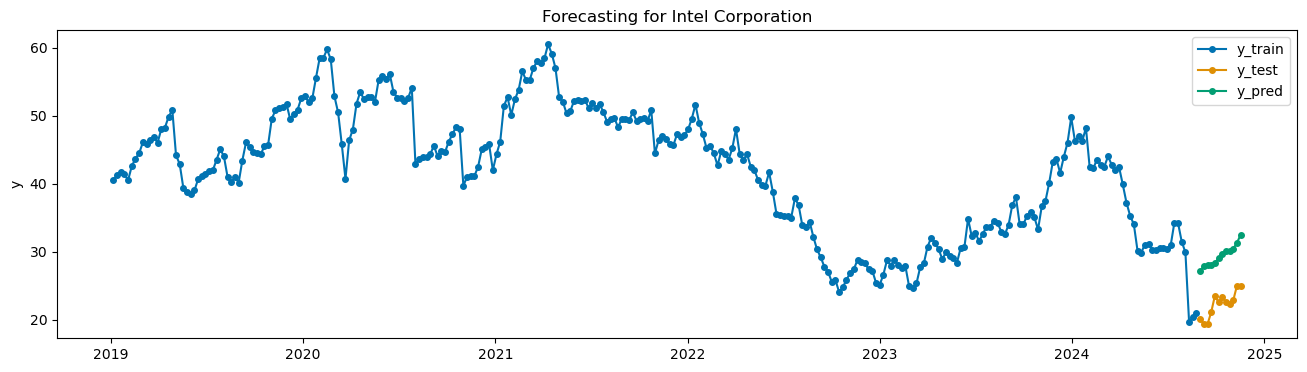

04:11:42 - cmdstanpy - INFO - Chain [1] start processing
04:11:43 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
# Dictionary to store each Prophet model by company
prophet_models = {}

# Total number of companies
total_companies = len(company_params)
company_counter = 0

# Iterate over each company in company_params
for company, params in company_params.items():
    company_counter += 1
    print(f"\nProcessing company: {company} ({company_counter}/{total_companies})...\n")

    # Retrieve parameter ranges for the current company
    param_ranges = {
        'changepoint_prior_scale': np.round(np.linspace(
            params['changepoint_prior_scale'] / 2,
            params['changepoint_prior_scale'] * 2,
            10), 5),
        'seasonality_prior_scale': np.round(np.linspace(
            params['seasonality_prior_scale'] / 2,
            params['seasonality_prior_scale'] * 2,
            10), 5),
        'seasonality_mode': ['additive', 'multiplicative'],
        'weekly_seasonality': [True, False],
        'yearly_seasonality': [True, False],
        'daily_seasonality': [True, False]
    }

    # Generate all parameter combinations
    param_combinations = list(product(
        param_ranges['changepoint_prior_scale'],
        param_ranges['seasonality_prior_scale'],
        param_ranges['seasonality_mode'],
        param_ranges['weekly_seasonality'],
        param_ranges['yearly_seasonality'],
        param_ranges['daily_seasonality']
    ))

    total_combinations = len(param_combinations)
    print(f"Total combinations to test for {company}: {total_combinations}")

    # Prepare data
    train_data = train_dataframes[company][['Close']].copy()
    train_data.index = pd.to_datetime(train_data.index)
    train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close': 'y'})

    test_data = test_dataframes[company][['Close']].copy()
    test_data.index = pd.to_datetime(test_data.index)

    # Initialize variables to track the best parameters
    best_mape = float('inf')
    best_rmse = float('inf')
    best_params = None

    # Iterate over all parameter combinations
    for idx, combination in enumerate(param_combinations, start=1):
        (changepoint_prior_scale,
         seasonality_prior_scale,
         seasonality_mode,
         weekly_seasonality,
         yearly_seasonality,
         daily_seasonality) = combination

        print(f"Processing combination {idx}/{total_combinations} for {company} ({company_counter}/{total_companies})...", end="\r")

        try:
            # Fit the Prophet model with the current parameter combination
            model = Prophet(
                changepoint_prior_scale=changepoint_prior_scale,
                seasonality_prior_scale=seasonality_prior_scale,
                seasonality_mode=seasonality_mode,
                weekly_seasonality=weekly_seasonality,
                yearly_seasonality=yearly_seasonality,
                daily_seasonality=daily_seasonality
            )
            model.fit(train_data_prophet)

            # Make predictions
            future = model.make_future_dataframe(periods=test_weeks, freq='W')
            forecast = model.predict(future)
            forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

            # Calculate MAPE and RMSE
            actuals = test_data['Close']
            predictions = forecast_filtered['Close']
            common_index = actuals.index.intersection(predictions.index)
            actuals = actuals.loc[common_index]
            predictions = predictions.loc[common_index]

            mape = mean_absolute_percentage_error(actuals, predictions) * 100
            rmse = root_mean_squared_error(actuals, predictions)

            # Update the best parameters if the current MAPE is lower
            if mape < best_mape:
                best_mape = mape
                best_rmse = rmse
                best_params = {
                    'changepoint_prior_scale': changepoint_prior_scale,
                    'seasonality_prior_scale': seasonality_prior_scale,
                    'seasonality_mode': seasonality_mode,
                    'weekly_seasonality': weekly_seasonality,
                    'yearly_seasonality': yearly_seasonality,
                    'daily_seasonality': daily_seasonality
                }
        except Exception as e:
            print(f"Error with combination {combination}: {e}")

    # Print the best parameters, MAPE, and RMSE for the current company
    print(f"\nBest parameters for {company}: {best_params}")
    print(f"MAPE: {best_mape:.2f}")
    print(f"RMSE: {best_rmse:.2f}")

    # Plot the forecast results for the best parameters
    model = Prophet(
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        seasonality_prior_scale=best_params['seasonality_prior_scale'],
        seasonality_mode=best_params['seasonality_mode'],
        weekly_seasonality=best_params['weekly_seasonality'],
        yearly_seasonality=best_params['yearly_seasonality'],
        daily_seasonality=best_params['daily_seasonality']
    )
    model.fit(train_data_prophet)

    future = model.make_future_dataframe(periods=test_weeks, freq='W')
    forecast = model.predict(future)
    forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

    plot_series(
        train_data_prophet.set_index("ds")['y'][-500:],  # Last 500 points of training data
        test_data['Close'],
        forecast_filtered['Close'],
        labels=["y_train", "y_test", "y_pred"]
    )
    plt.title(f"Forecasting for {company}")
    plt.show()

    # Fit the Prophet model with all data (train and test) for final storage
    prophet_model = Prophet(
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        seasonality_prior_scale=best_params['seasonality_prior_scale'],
        seasonality_mode=best_params['seasonality_mode'],
        weekly_seasonality=best_params['weekly_seasonality'],
        yearly_seasonality=best_params['yearly_seasonality'],
        daily_seasonality=best_params['daily_seasonality']
    )

    # Prepare combined data for final model training
    test_data = pd.DataFrame(actuals).rename(columns={'Close': 'y'}).reset_index(names="ds")
#     train_data_prophet = train_data_prophet.reset_index(names="ds")
    all_data = pd.concat([train_data_prophet, test_data])
    prophet_model.fit(all_data)

    # Store the model in the dictionary with the company name as key
    prophet_models[company] = prophet_model


The end results of the fine-tunning for the prophet models of all the suppliers and clients of ASML are shown bellow:

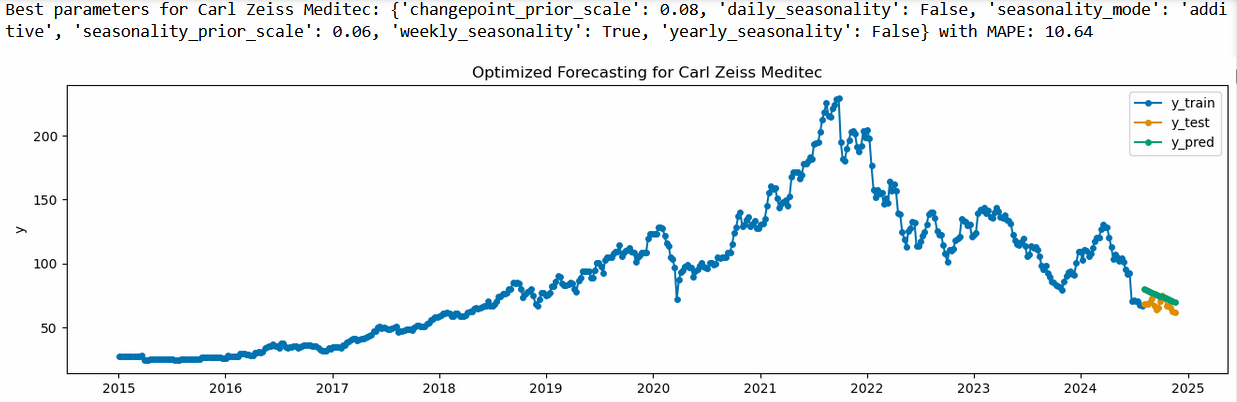
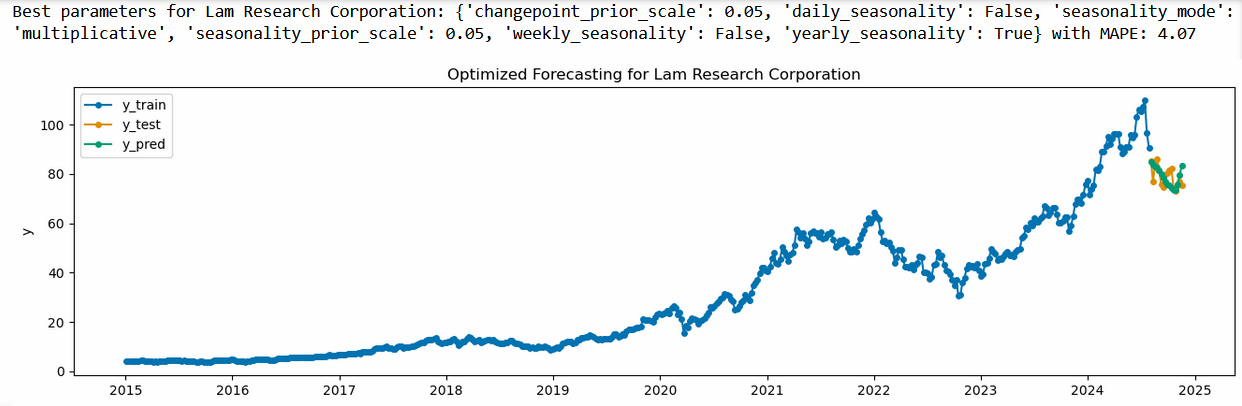
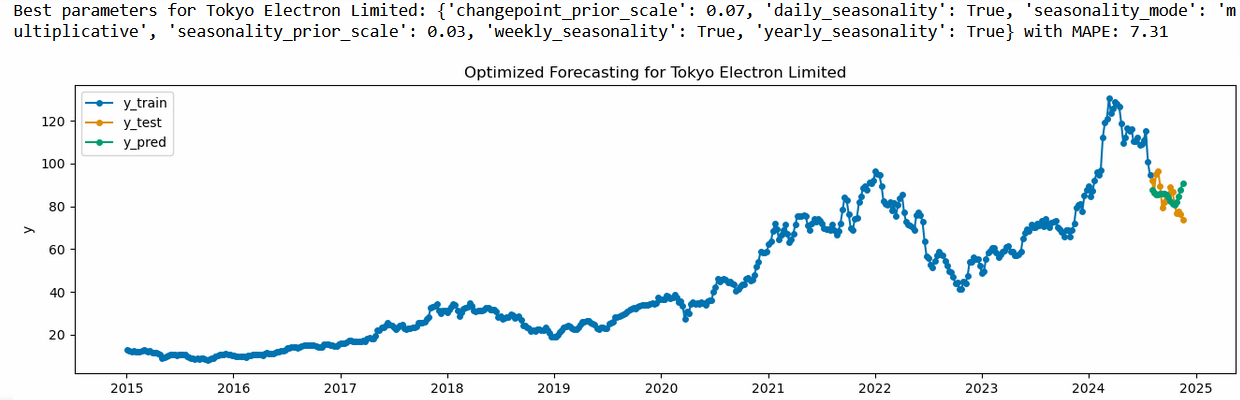
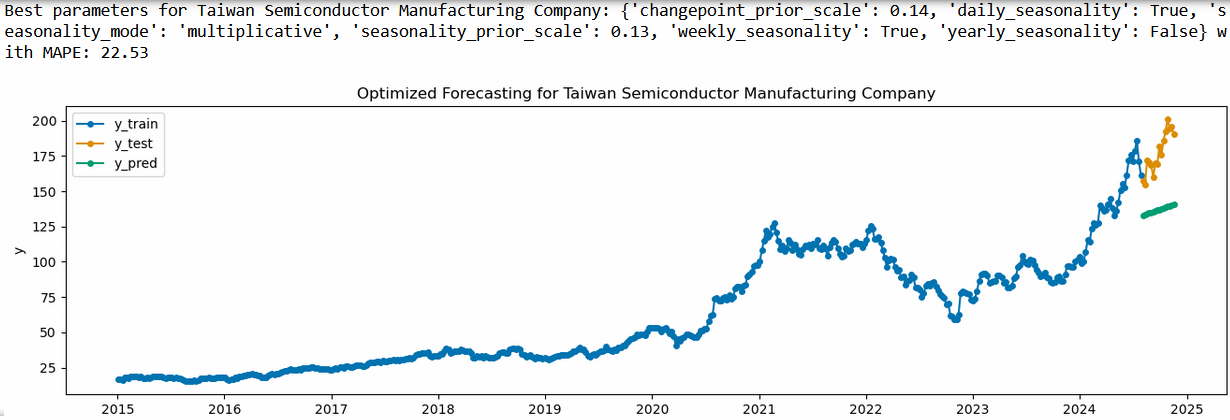
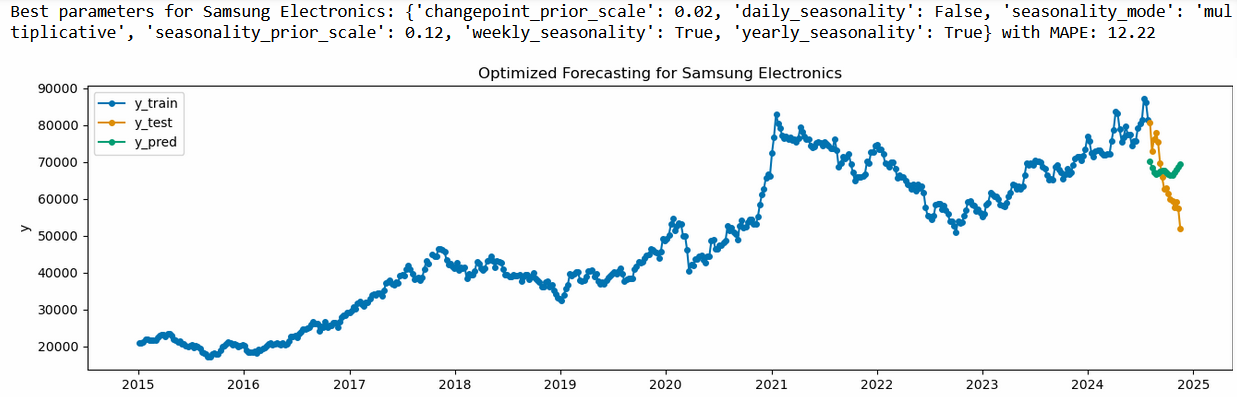
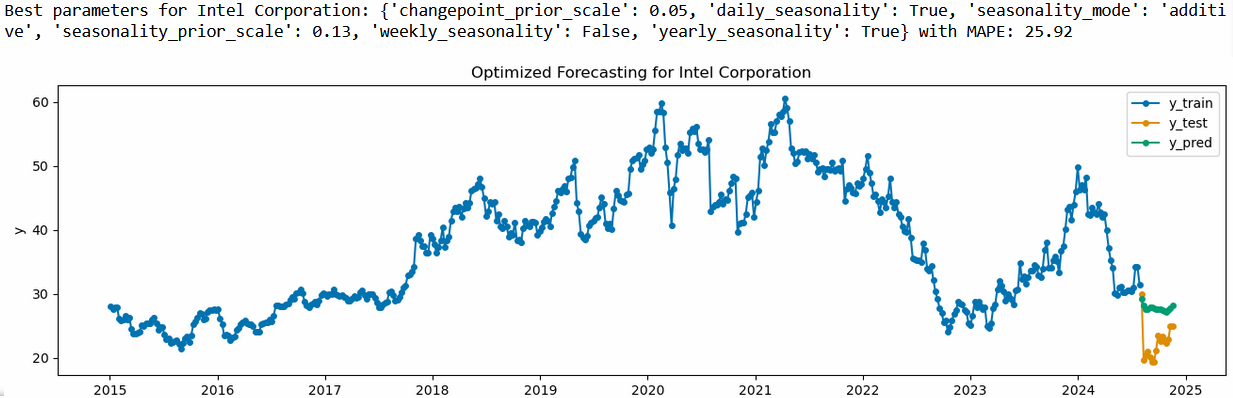

#### 2.5.6.4 Save the best prophet models of ASML's suppliers

In [ ]:
# Iterate over each company in prophet_models
for company in company_tickers.values():
    # Define the output path for the current company's model
    output_model_path = f'models/prophet_asml_supplier_{company.replace(" ", "_")}.pkl'

    # Save the current company's Prophet model
    joblib.dump(prophet_models[company], output_model_path)
    print(f'Prophet model for {company} saved at {output_model_path}')

# 3. Export the data

In [ ]:
# Export the weekly_data_suppliers to a CSV file
weekly_data_suppliers.to_csv(output_data, index=True, sep=';')